<a href="https://colab.research.google.com/github/QWL55/Predicting_Migration_Flow/blob/main/notebook/CS224W_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Final Project: Estimating U.S. County-level Migration Flows Using Graph Neural Networks**

Welcome to the Colab for our CS 224W Final Project. The problem we will investigate is the prediction of county-county migration flow levels in the United States. We formulated this as a link regression task and evaluated the efficacy of several different GNN models for the problem. Research is ongoing in this area, which is essential for policymaking, and our work here represents a new experimental direction! Please enjoy.

# Setup
Install and setup libraries.

In [ ]:
# Install torch geometric
import os
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 1) GNN: Link Regression Task

In this section we will build our baseline graph neural network using PyTorch Geometric. Then we will apply it to the task of predicting the volume of estimating U.S. county-county migration flow as a link regression.

## Setup

In [ ]:
import pandas as pd
import numpy as np
import copy
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric
import torch_geometric.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the path to your project folder
os.chdir('/content/drive/MyDrive/Stanford SOC/CS224W/final_projects')

In [ ]:
os.listdir()

['dataset',
 '.ipynb_checkpoints',
 'models',
 'predictions',
 'figs',
 'results',
 'baseline_models.ipynb',
 'Final Project Writeup.gdoc',
 'CS224W_Final_Project.ipynb']

## Load and Preprocess the Dataset

In [ ]:
# Load the datasets
county_flow_df = pd.read_csv('dataset/county_flow.csv', dtype={"fips_orig": str, "fips_dest": str})
county_node_df = pd.read_csv('dataset/county_node_info.csv', dtype={"GEOID": str})

In [ ]:
# log transformation
county_node_df['tot_pop'] = np.log1p(county_node_df['tot_pop'])
county_node_df['median_inc'] = np.log1p(county_node_df['median_inc'])

#county_flow_df['flow'] = np.log1p(county_flow_df['flow'])
county_flow_df['distance'] = np.log1p(county_flow_df['distance'])

In [ ]:
from torch_geometric.data import Data

def load_process_data(node_df=county_node_df, edge_df=county_flow_df,
                      feat_type="full", edge_type="full"):
    if edge_type == "within_state":
        # Filter for within-state flows
        edge_df, node_df = filter_within_state(edge_df, node_df)

    # Step 1: Create a mapping from GEOID to index and
    # map fips_orig and fips_dest in county_flow_df to indices
    geo_to_index = {geo_id: idx for idx, geo_id in enumerate(node_df['GEOID'])}

    edge_df['src'] = edge_df['fips_orig'].map(geo_to_index)
    edge_df['dst'] = edge_df['fips_dest'].map(geo_to_index)

    # Create different versions of county_node_features
    if feat_type == "full":
        columns_to_drop = ["GEOID"]
    elif feat_type == 'simple':
        # excludes columns with "feature" in their names
        columns_to_drop = ["GEOID"] + [col for col in node_df.columns if 'feature' in col.lower()]

    # select relevant features
    node_features = node_df.drop(columns=columns_to_drop, errors='ignore')
    node_tensor = torch.tensor(node_features.values, dtype=torch.float)

    # Step 2: Extract the edge list and label
    edge_index_df = edge_df[['src', 'dst']]
    edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)

    edge_labels = edge_df['flow'].values
    edge_labels = torch.tensor(edge_labels, dtype=torch.long)

    #Create a mapping dictionary from edge_index to edge_labels
    edge_maps = {
        tuple(edge): label for edge, label in zip(edge_index.T.tolist(), edge_labels.tolist())
    }

    # Create PyG Data object
    data = Data(x=node_tensor, edge_index=edge_index, edge_label=edge_labels)
    data.num_node_features = node_tensor.shape[1]

    return data, edge_maps


def filter_within_state(flow_df, node_df):
    # Extract state codes from FIPS codes (first two digits)
    flow_df['state_orig'] = flow_df['fips_orig'].str[:3]
    flow_df['state_dest'] = flow_df['fips_dest'].str[:3]

    # Filter for within-state flows
    county_flow_df = flow_df[flow_df['state_orig'] == flow_df['state_dest']].copy()

    # filter to only include relevant nodes
    unique_geoids = pd.concat([county_flow_df['fips_orig'],
                               county_flow_df['fips_dest']]).drop_duplicates().rename("GEOID")

    filtered_node_df = unique_geoids.to_frame().merge(
        node_df,
        on='GEOID',
        how='left'
    )
    return county_flow_df, filtered_node_df

In [ ]:
# a helper function to remap edge index to the label index
def edge_mapping(data, edge_maps):
    # create a mapping of edge to label
    # reassign labels in the order of pos_edge_label_index
    aligned_labels = []
    for edge in data.pos_edge_label_index.T.tolist():
        aligned_labels.append(edge_maps[tuple(edge)])

    # Convert aligned labels back to a tensor
    data.pos_edge_label = torch.tensor(aligned_labels, dtype=torch.float)

    return data

## Sanity Check

We sanity check that our mapping of edge labels is working as intended.

In [ ]:
transform = T.Compose([T.RandomLinkSplit(is_undirected=False,
                                             neg_sampling_ratio=0.5,
                                             split_labels=True)])
dataset, edge_maps = load_process_data(feat_type="full", edge_type="full")
data_split = list(transform(dataset))
train_data, val_data, test_data = [edge_mapping(dat, edge_maps) for dat in data_split]

In [ ]:
# Check if pos_edge_label corresponds to pos_edge_label_index
for i, (src, dst) in enumerate(train_data.pos_edge_label_index.T):
    label = train_data.pos_edge_label[i]
    print(f"Edge ({src.item()}, {dst.item()}) -> Label: {label.item()}")
    if i == 2:
        break

Edge (2598, 2607) -> Label: 46.0
Edge (2883, 1953) -> Label: 27.0
Edge (1011, 1793) -> Label: 33.0


In [ ]:
print(train_data.pos_edge_label_index)
print(train_data.pos_edge_label)

tensor([[2598, 2883, 1011,  ...,  329, 2662, 1771],
        [2607, 1953, 1793,  ..., 1807, 2624, 2996]])
tensor([46., 27., 33.,  ..., 35., 51., 28.])


# Model Building

In this section we build our model and our implementations of GCN, GraphSAGE, and GAT.

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

#import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, negative_sampling
from torch_geometric.nn import GCNConv#, SAGEConv, GATConv

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))


        # post-message-passing
        # times 2 because we concatenate node embedding
        self.link_regressor = nn.Sequential(
            nn.Linear(2 * args.heads * hidden_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout

        for _ in range(args.num_layers):
            self.bns.append(torch.nn.BatchNorm1d(args.heads *hidden_dim))

        self.num_layers = args.num_layers
        self.prelu = nn.PReLU()
        self.emb = emb
        self.reset_parameters()
        self.loss = args.loss

    def reset_parameters(self):
        # Reset parameters of convolutional layers
        for conv in self.convs:
            if hasattr(conv, 'reset_parameters'):
                conv.reset_parameters()
        # Reset parameters of link_regressor layers
        for layer in self.link_regressor:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()

        for bn in self.bns:
            bn.reset_parameters()


    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GCN':
            return GCNConv
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, post_edge_index, neg_edge_index = data.x, data.pos_edge_label_index, data.neg_edge_label_index
        out = x

        for i in range(self.num_layers):
            out = self.convs[i](out, data.edge_index)
            out = self.bns[i](out)
            out = self.prelu(out)
            out = F.dropout(out, p=self.dropout,training=self.training)

        if self.emb == True:
            return out

        predict_edge_index = torch.cat([post_edge_index, neg_edge_index], dim=1)

        return self.predict_edges(out, predict_edge_index)

    def predict_edges(self, node_features, edge_index):
        # Extract source and destination node embeddings
        node_features_src = node_features[edge_index[0]]  # Source nodes
        node_features_dst = node_features[edge_index[1]]  # Destination nodes

        # Combine embeddings (e.g., using dot product or concatenation)
        edge_features = torch.cat([node_features_src, node_features_dst], dim=1)

        # Predict edge values (continuous outputs)
        edge_predictions = self.link_regressor(edge_features)

        return edge_predictions

    def loss(self, pred, label):
        return self.loss(pred, label)

## GraphSage


In [ ]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, aggr="sum", **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.aggr = aggr
        ############################################################################
        # self.lin_l is the linear transformation to embedding for central node.
        # self.lin_r is the linear transformation to aggregated message from neighbors.
        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        ############################################################################
        # Implement message passing, as well as any post-processing (our update rule).
        out = self.propagate(edge_index, x=(x,x), size=size)
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

    def message(self, x_j):

        ############################################################################
        # Implement the message function here.
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce=self.aggr)

        ############################################################################

        return out

## GAT


In [ ]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0.1, **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        # self.lin_l is the linear transformation that you apply to embeddings
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using
        # multi-head attention.
        self.lin_l = nn.Linear(in_channels, heads * out_channels, bias=False)

        self.lin_r = self.lin_l

        # We need to deal with multi-head scenarios.
        self.att_l = nn.Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = nn.Parameter(torch.Tensor(1, heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        x_l, x_r = self.lin_l(x).view(-1, H, C), self.lin_r(x).view(-1, H, C)
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = (x_r * self.att_r).sum(dim=-1)

        out = self.propagate(edge_index, x=(x_l,x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.view(-1, H * C)

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        # Implement message function.
        alpha = alpha_i + alpha_j
        out = F.leaky_relu(alpha, self.negative_slope)
        out = torch_geometric.utils.softmax(out, index, ptr, size_i)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = x_j * out.unsqueeze(-1)

        return out


    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')

        return out

## Optimizer

We use the ADAM optimizer.

In [ ]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Model Training and Evaluation

Here we train and evaluate our models across a number of specifications: core and full node feature sets; within-state and all nodes; and GNN approaches (GCN, GraphSAGE, GAT) vs. linear model baselines.

In [ ]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
from torch_geometric.data import DataLoader
import pickle
from tqdm import trange
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score, multiclass_f1_score

def train(args):

    # Data pre-processing: splitting, adjusting errors in splitting
    transform = T.Compose([T.RandomLinkSplit(is_undirected=False,
                                             neg_sampling_ratio=args.neg_edge_ratio,
                                             split_labels=True)])
    dataset, edge_maps = load_process_data(feat_type=args.feature_type, edge_type=args.edge_type)
    data_split = list(transform(dataset))
    data_split = [edge_mapping(dat, edge_maps) for dat in data_split]

    # adjust the setup according to the task
    for dat in data_split:
        dat.edge_index = dataset.edge_index
        if args.task == "Regression":
            dat.pos_edge_label = torch.log1p(dat.pos_edge_label)
            eval_metric = "R2"
        else: # classification
            discrete_label = pd.qcut(dat.pos_edge_label.numpy(), q=args.qtiles, labels=False)
            dat.pos_edge_label = torch.tensor(discrete_label, dtype=torch.long)
            eval_metric = "F1 Score (Micro)"

    train_data, val_data, test_data = data_split
    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, args.out_dim,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    train_losses = []
    val_losses = []
    test_losses = []
    train_metrics = []
    val_metrics = []
    test_metrics = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        model.train()
        #for batch in loader:
        opt.zero_grad()
        pred = model(train_data).squeeze(-1)
        label = torch.cat([train_data.pos_edge_label, train_data.neg_edge_label]).long()
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()

        train_losses.append(loss.item())
        train_metric = args.metric(pred, label).item()
        train_metrics.append(train_metric)

        val_loss, val_metric = test(val_data, model, args)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        print(
            f"Epoch {epoch + 1}: Training Loss {round(loss.item(), 5)}, "
            f"Training {eval_metric} {round(train_metric, 5)}",
            f"Validation Loss {round(val_loss, 5)}",
            f"Validation {eval_metric} {round(val_metric, 5)}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        test_loss, test_metric = test(test_data, model, args)
        test_losses.append(test_loss)
        test_metrics.append(test_metric)

    return train_losses, val_losses, test_losses, best_model, test_data


def test(data, test_model, args, save_model_preds=False, model_type=None,
         feature_type=None):
    test_model.eval()

    # evaluate the performance of the best model
    with torch.no_grad():
        # max(dim=1) returns values, indices tuple; only need indices
        pred = test_model(data).squeeze(-1)
        label = torch.cat([data.pos_edge_label, data.neg_edge_label])
        loss = test_model.loss(pred, label)
        metric = args.metric(pred, label).item()

        if save_model_preds:
            print ("Saving Model Predictions for Model Type", model_type)

            data = {}
            if args.task == "Regression":
                data['pred'] = pred.view(-1).cpu().detach().numpy()
            else:
                data['pred'] = torch.argmax(pred, dim=1).view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()
            df = pd.DataFrame(data=data)
            # Save locally as csv
            model_path = args.task + "_" + args.model_type + "_" + args.feature_type + "_" + args.edge_type
            df.to_csv("predictions/" + model_path +
                      '.csv', sep=',', index=False)
            # save model object as a pickle
            with open("models/{0}.pkl".format(model_path), "wb") as f:
                pickle.dump(test_model, f)

            print(f"Model saved successfully as {model_path}")
    return loss.item(), metric

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [ ]:
def run_pipeline(arg):
    torch.manual_seed(0)

    args = objectview(arg)
    if args.task == "Regression":
        args.loss = F.l1_loss
        loss_string = "L1 Loss"
        args.metric = r2_score
    else:
        args.loss = F.cross_entropy
        args.qtiles = 5
        args.out_dim = args.qtiles
        loss_string = "Cross Entropy Loss"
        args.metric = multiclass_f1_score

    train_losses, val_losses, test_losses, best_model, test_data = train(args)

    # Run test for our best model to save the predictions!
    best_loss, best_metric = test(test_data, best_model, args, save_model_preds=True,
                              model_type=args.model_type, feature_type=args.feature_type)
    print("Minimum validation loss: {0}".format(min(val_losses)))
    print("Minimum test loss: {0}".format(min(test_losses)))
    print("Best test metric: {0}".format(best_metric))

    plt.title("Migration Flow {} {}".format(args.task, loss_string))
    plt.plot(train_losses, label="training loss" + " - " + args.model_type)
    plt.plot(val_losses, label="validation loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    fig_path = args.task + "_" + args.model_type + "_" + args.feature_type + "_" + args.edge_type
    plt.savefig("figs/{}.png".format(fig_path), dpi=600, bbox_inches="tight")

    plt.show()

    return best_loss, best_metric


## Running models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
    'num_layers': 2, # GNN hyper parameters
    'hidden_dim': 64,
    "out_dim": 1,
    "aggr": "sum",
    'model_type': "GCN",
    'heads': 1,
    "normalize": True,
    "loss": F.l1_loss, # training hyperparameters
    "qtiles": 5,
    'dropout': 0.2,
    'lr': 0.01,
    'epochs': 200,
    'batch_size': 32,
    'device': device,
    'opt': 'adam',
    'opt_scheduler': 'none',
    'opt_restart': 0,
    'weight_decay': 1e-5,
    'feature_type': 'full', # task hyperparameters
    'edge_type': 'full',
    'task': 'Classification',
    'neg_edge_ratio': 0.5
}

# args_GraphSage = args.copy()
# args_GraphSage["model_type"] = "GraphSage"

# args_GAT = args.copy()
# args_GAT["model_type"] = "GAT"
# args_GAT["heads"] = 2

model_type = ["GraphSage", "GAT", "GCN"]
task = ["Regression", "Classification"]
edge_type = ["full", "within_state"]
feature_type = ["full", "simple"]

Running pipeline with config: Regression_GraphSage_full_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 2.72098, Training R2 -1.88765 Validation Loss 2.77028 Validation R2 -1.38706


Training:   0%|          | 1/200 [00:01<04:30,  1.36s/Epochs]

Epoch 2: Training Loss 2.21659, Training R2 -0.56733 Validation Loss 2.6564 Validation R2 -1.12423


Training:   1%|          | 2/200 [00:02<04:38,  1.41s/Epochs]

Epoch 3: Training Loss 1.58968, Training R2 -0.06652 Validation Loss 2.59978 Validation R2 -0.96574


Training:   2%|▏         | 3/200 [00:04<04:33,  1.39s/Epochs]

Epoch 4: Training Loss 1.42261, Training R2 0.15858 Validation Loss 2.57354 Validation R2 -0.90712


Training:   2%|▏         | 4/200 [00:05<04:29,  1.38s/Epochs]

Epoch 5: Training Loss 1.44447, Training R2 0.15845 Validation Loss 2.535 Validation R2 -0.84556


Training:   2%|▎         | 5/200 [00:06<04:23,  1.35s/Epochs]

Epoch 6: Training Loss 1.37353, Training R2 0.14724 Validation Loss 2.52583 Validation R2 -0.85044


Training:   3%|▎         | 6/200 [00:08<04:19,  1.34s/Epochs]

Epoch 7: Training Loss 1.3965, Training R2 0.10546 Validation Loss 2.55484 Validation R2 -0.9289


Training:   4%|▎         | 7/200 [00:09<04:26,  1.38s/Epochs]

Epoch 8: Training Loss 1.35351, Training R2 0.18251 Validation Loss 2.59574 Validation R2 -1.03347


Training:   4%|▍         | 8/200 [00:11<04:54,  1.54s/Epochs]

Epoch 9: Training Loss 1.3604, Training R2 0.22304 Validation Loss 2.61523 Validation R2 -1.09556


Training:   4%|▍         | 9/200 [00:13<05:17,  1.66s/Epochs]

Epoch 10: Training Loss 1.35096, Training R2 0.23865 Validation Loss 2.61565 Validation R2 -1.11471


Training:   5%|▌         | 10/200 [00:14<04:57,  1.56s/Epochs]

Epoch 11: Training Loss 1.3264, Training R2 0.24037 Validation Loss 2.61585 Validation R2 -1.12716


Training:   6%|▌         | 11/200 [00:16<04:40,  1.49s/Epochs]

Epoch 12: Training Loss 1.33036, Training R2 0.22947 Validation Loss 2.6259 Validation R2 -1.15444


Training:   6%|▌         | 12/200 [00:17<04:28,  1.43s/Epochs]

Epoch 13: Training Loss 1.31676, Training R2 0.25284 Validation Loss 2.63989 Validation R2 -1.18689


Training:   6%|▋         | 13/200 [00:18<04:22,  1.40s/Epochs]

Epoch 14: Training Loss 1.3058, Training R2 0.28577 Validation Loss 2.63906 Validation R2 -1.18648


Training:   7%|▋         | 14/200 [00:20<04:15,  1.38s/Epochs]

Epoch 15: Training Loss 1.31263, Training R2 0.28923 Validation Loss 2.61781 Validation R2 -1.14325


Training:   8%|▊         | 15/200 [00:21<04:10,  1.36s/Epochs]

Epoch 16: Training Loss 1.29396, Training R2 0.29325 Validation Loss 2.59251 Validation R2 -1.09231


Training:   8%|▊         | 16/200 [00:22<04:08,  1.35s/Epochs]

Epoch 17: Training Loss 1.29941, Training R2 0.27646 Validation Loss 2.58295 Validation R2 -1.07359


Training:   8%|▊         | 17/200 [00:24<04:13,  1.39s/Epochs]

Epoch 18: Training Loss 1.29152, Training R2 0.28798 Validation Loss 2.58586 Validation R2 -1.08018


Training:   9%|▉         | 18/200 [00:25<04:37,  1.52s/Epochs]

Epoch 19: Training Loss 1.28403, Training R2 0.3037 Validation Loss 2.58394 Validation R2 -1.07807


Training:  10%|▉         | 19/200 [00:27<04:51,  1.61s/Epochs]

Epoch 20: Training Loss 1.28765, Training R2 0.30506 Validation Loss 2.57037 Validation R2 -1.05402


Training:  10%|█         | 20/200 [00:29<04:34,  1.52s/Epochs]

Epoch 21: Training Loss 1.27645, Training R2 0.30937 Validation Loss 2.55425 Validation R2 -1.02452


Training:  10%|█         | 21/200 [00:30<04:21,  1.46s/Epochs]

Epoch 22: Training Loss 1.2704, Training R2 0.31034 Validation Loss 2.54715 Validation R2 -1.01253


Training:  11%|█         | 22/200 [00:31<04:15,  1.43s/Epochs]

Epoch 23: Training Loss 1.26847, Training R2 0.31327 Validation Loss 2.54782 Validation R2 -1.01471


Training:  12%|█▏        | 23/200 [00:33<04:12,  1.43s/Epochs]

Epoch 24: Training Loss 1.26334, Training R2 0.32224 Validation Loss 2.54558 Validation R2 -1.01102


Training:  12%|█▏        | 24/200 [00:34<04:06,  1.40s/Epochs]

Epoch 25: Training Loss 1.26303, Training R2 0.32912 Validation Loss 2.52813 Validation R2 -0.97872


Training:  12%|█▎        | 25/200 [00:35<03:59,  1.37s/Epochs]

Epoch 26: Training Loss 1.25706, Training R2 0.33283 Validation Loss 2.50542 Validation R2 -0.93728


Training:  13%|█▎        | 26/200 [00:37<03:55,  1.36s/Epochs]

Epoch 27: Training Loss 1.25394, Training R2 0.33133 Validation Loss 2.49414 Validation R2 -0.91684


Training:  14%|█▎        | 27/200 [00:38<04:10,  1.45s/Epochs]

Epoch 28: Training Loss 1.25492, Training R2 0.3329 Validation Loss 2.49984 Validation R2 -0.9272


Training:  14%|█▍        | 28/200 [00:40<04:27,  1.56s/Epochs]

Epoch 29: Training Loss 1.24875, Training R2 0.34467 Validation Loss 2.49836 Validation R2 -0.92563


Training:  14%|█▍        | 29/200 [00:42<05:05,  1.78s/Epochs]

Epoch 30: Training Loss 1.2489, Training R2 0.34776 Validation Loss 2.47478 Validation R2 -0.88566


Training:  15%|█▌        | 30/200 [00:44<04:54,  1.73s/Epochs]

Epoch 31: Training Loss 1.24511, Training R2 0.34714 Validation Loss 2.45402 Validation R2 -0.85069


Training:  16%|█▌        | 31/200 [00:45<04:32,  1.61s/Epochs]

Epoch 32: Training Loss 1.24695, Training R2 0.34319 Validation Loss 2.45279 Validation R2 -0.8496


Training:  16%|█▌        | 32/200 [00:47<04:17,  1.53s/Epochs]

Epoch 33: Training Loss 1.24168, Training R2 0.34934 Validation Loss 2.45554 Validation R2 -0.85537


Training:  16%|█▋        | 33/200 [00:48<04:04,  1.46s/Epochs]

Epoch 34: Training Loss 1.24027, Training R2 0.35389 Validation Loss 2.43613 Validation R2 -0.82143


Training:  17%|█▋        | 34/200 [00:49<03:56,  1.43s/Epochs]

Epoch 35: Training Loss 1.2369, Training R2 0.35539 Validation Loss 2.39851 Validation R2 -0.75691


Training:  18%|█▊        | 35/200 [00:51<03:49,  1.39s/Epochs]

Epoch 36: Training Loss 1.23478, Training R2 0.35583 Validation Loss 2.37434 Validation R2 -0.71537


Training:  18%|█▊        | 36/200 [00:52<03:54,  1.43s/Epochs]

Epoch 37: Training Loss 1.23807, Training R2 0.35244 Validation Loss 2.37455 Validation R2 -0.71435


Training:  18%|█▊        | 37/200 [00:54<04:11,  1.54s/Epochs]

Epoch 38: Training Loss 1.23245, Training R2 0.35944 Validation Loss 2.35917 Validation R2 -0.68767


Training:  19%|█▉        | 38/200 [00:56<04:22,  1.62s/Epochs]

Epoch 39: Training Loss 1.23571, Training R2 0.35736 Validation Loss 2.3159 Validation R2 -0.61633


Training:  20%|█▉        | 39/200 [00:57<04:06,  1.53s/Epochs]

Epoch 40: Training Loss 1.22878, Training R2 0.36277 Validation Loss 2.27861 Validation R2 -0.55664


Training:  20%|██        | 40/200 [00:58<03:54,  1.46s/Epochs]

Epoch 41: Training Loss 1.23317, Training R2 0.35874 Validation Loss 2.2897 Validation R2 -0.57331


Training:  20%|██        | 41/200 [01:00<03:45,  1.42s/Epochs]

Epoch 42: Training Loss 1.22719, Training R2 0.36501 Validation Loss 2.28421 Validation R2 -0.56474


Training:  21%|██        | 42/200 [01:01<03:38,  1.38s/Epochs]

Epoch 43: Training Loss 1.23541, Training R2 0.35855 Validation Loss 2.23511 Validation R2 -0.49087


Training:  22%|██▏       | 43/200 [01:02<03:33,  1.36s/Epochs]

Epoch 44: Training Loss 1.22675, Training R2 0.36306 Validation Loss 2.21163 Validation R2 -0.45703


Training:  22%|██▏       | 44/200 [01:04<03:32,  1.37s/Epochs]

Epoch 45: Training Loss 1.22741, Training R2 0.36205 Validation Loss 2.21065 Validation R2 -0.45627


Training:  22%|██▎       | 45/200 [01:05<03:31,  1.36s/Epochs]

Epoch 46: Training Loss 1.22782, Training R2 0.36357 Validation Loss 2.19668 Validation R2 -0.43576


Training:  23%|██▎       | 46/200 [01:07<03:40,  1.43s/Epochs]

Epoch 47: Training Loss 1.22376, Training R2 0.36818 Validation Loss 2.15907 Validation R2 -0.3818


Training:  24%|██▎       | 47/200 [01:09<03:57,  1.55s/Epochs]

Epoch 48: Training Loss 1.22392, Training R2 0.36674 Validation Loss 2.13188 Validation R2 -0.34374


Training:  24%|██▍       | 48/200 [01:10<04:06,  1.62s/Epochs]

Epoch 49: Training Loss 1.22075, Training R2 0.36866 Validation Loss 2.12906 Validation R2 -0.33937


Training:  24%|██▍       | 49/200 [01:12<03:50,  1.53s/Epochs]

Epoch 50: Training Loss 1.22529, Training R2 0.36763 Validation Loss 2.08921 Validation R2 -0.28559


Training:  25%|██▌       | 50/200 [01:13<03:40,  1.47s/Epochs]

Epoch 51: Training Loss 1.22528, Training R2 0.36563 Validation Loss 2.03749 Validation R2 -0.21889


Training:  26%|██▌       | 51/200 [01:14<03:32,  1.43s/Epochs]

Epoch 52: Training Loss 1.2255, Training R2 0.36496 Validation Loss 2.05081 Validation R2 -0.23518


Training:  26%|██▌       | 52/200 [01:16<03:28,  1.41s/Epochs]

Epoch 53: Training Loss 1.22312, Training R2 0.36709 Validation Loss 2.03819 Validation R2 -0.21928


Training:  26%|██▋       | 53/200 [01:17<03:25,  1.40s/Epochs]

Epoch 54: Training Loss 1.2212, Training R2 0.37051 Validation Loss 1.97619 Validation R2 -0.14469


Training:  27%|██▋       | 54/200 [01:18<03:21,  1.38s/Epochs]

Epoch 55: Training Loss 1.21991, Training R2 0.36915 Validation Loss 1.94403 Validation R2 -0.10862


Training:  28%|██▊       | 55/200 [01:20<03:17,  1.36s/Epochs]

Epoch 56: Training Loss 1.21975, Training R2 0.36738 Validation Loss 1.96465 Validation R2 -0.13322


Training:  28%|██▊       | 56/200 [01:21<03:31,  1.47s/Epochs]

Epoch 57: Training Loss 1.22136, Training R2 0.3669 Validation Loss 1.94052 Validation R2 -0.10586


Training:  28%|██▊       | 57/200 [01:23<03:49,  1.60s/Epochs]

Epoch 58: Training Loss 1.22442, Training R2 0.36521 Validation Loss 1.86589 Validation R2 -0.02456


Training:  29%|██▉       | 58/200 [01:25<03:49,  1.61s/Epochs]

Epoch 59: Training Loss 1.22228, Training R2 0.36528 Validation Loss 1.83835 Validation R2 0.00447


Training:  30%|██▉       | 59/200 [01:26<03:36,  1.53s/Epochs]

Epoch 60: Training Loss 1.2224, Training R2 0.36517 Validation Loss 1.85505 Validation R2 -0.01081


Training:  30%|███       | 60/200 [01:28<03:26,  1.47s/Epochs]

Epoch 61: Training Loss 1.22163, Training R2 0.36702 Validation Loss 1.81464 Validation R2 0.03147


Training:  30%|███       | 61/200 [01:29<03:19,  1.43s/Epochs]

Epoch 62: Training Loss 1.22, Training R2 0.36915 Validation Loss 1.72504 Validation R2 0.11396


Training:  31%|███       | 62/200 [01:30<03:12,  1.39s/Epochs]

Epoch 63: Training Loss 1.22176, Training R2 0.36699 Validation Loss 1.73598 Validation R2 0.10518


Training:  32%|███▏      | 63/200 [01:32<03:07,  1.37s/Epochs]

Epoch 64: Training Loss 1.21961, Training R2 0.36884 Validation Loss 1.73113 Validation R2 0.10923


Training:  32%|███▏      | 64/200 [01:33<03:04,  1.36s/Epochs]

Epoch 65: Training Loss 1.22048, Training R2 0.36886 Validation Loss 1.67762 Validation R2 0.15221


Training:  32%|███▎      | 65/200 [01:34<03:01,  1.34s/Epochs]

Epoch 66: Training Loss 1.21606, Training R2 0.37035 Validation Loss 1.66939 Validation R2 0.15849


Training:  33%|███▎      | 66/200 [01:36<03:17,  1.48s/Epochs]

Epoch 67: Training Loss 1.21732, Training R2 0.36951 Validation Loss 1.66508 Validation R2 0.16104


Training:  34%|███▎      | 67/200 [01:38<03:31,  1.59s/Epochs]

Epoch 68: Training Loss 1.21596, Training R2 0.37052 Validation Loss 1.68466 Validation R2 0.14538


Training:  34%|███▍      | 68/200 [01:39<03:27,  1.57s/Epochs]

Epoch 69: Training Loss 1.21779, Training R2 0.3694 Validation Loss 1.6354 Validation R2 0.18351


Training:  34%|███▍      | 69/200 [01:41<03:18,  1.51s/Epochs]

Epoch 70: Training Loss 1.21434, Training R2 0.37297 Validation Loss 1.63742 Validation R2 0.18232


Training:  35%|███▌      | 70/200 [01:42<03:11,  1.47s/Epochs]

Epoch 71: Training Loss 1.21927, Training R2 0.36852 Validation Loss 1.61201 Validation R2 0.2011


Training:  36%|███▌      | 71/200 [01:43<03:04,  1.43s/Epochs]

Epoch 72: Training Loss 1.21772, Training R2 0.37063 Validation Loss 1.57208 Validation R2 0.22861


Training:  36%|███▌      | 72/200 [01:45<02:58,  1.39s/Epochs]

Epoch 73: Training Loss 1.2171, Training R2 0.36958 Validation Loss 1.59344 Validation R2 0.21402


Training:  36%|███▋      | 73/200 [01:46<02:54,  1.38s/Epochs]

Epoch 74: Training Loss 1.21842, Training R2 0.36893 Validation Loss 1.59335 Validation R2 0.21277


Training:  37%|███▋      | 74/200 [01:47<02:51,  1.36s/Epochs]

Epoch 75: Training Loss 1.21384, Training R2 0.37246 Validation Loss 1.54536 Validation R2 0.24306


Training:  38%|███▊      | 75/200 [01:49<02:52,  1.38s/Epochs]

Epoch 76: Training Loss 1.21725, Training R2 0.36855 Validation Loss 1.59088 Validation R2 0.2112


Training:  38%|███▊      | 76/200 [01:51<03:07,  1.51s/Epochs]

Epoch 77: Training Loss 1.21624, Training R2 0.36926 Validation Loss 1.5866 Validation R2 0.21278


Training:  38%|███▊      | 77/200 [01:53<03:21,  1.64s/Epochs]

Epoch 78: Training Loss 1.21433, Training R2 0.37089 Validation Loss 1.52544 Validation R2 0.25205


Training:  39%|███▉      | 78/200 [01:54<03:13,  1.59s/Epochs]

Epoch 79: Training Loss 1.21581, Training R2 0.3689 Validation Loss 1.48757 Validation R2 0.27587


Training:  40%|███▉      | 79/200 [01:55<03:04,  1.53s/Epochs]

Epoch 80: Training Loss 1.21726, Training R2 0.36885 Validation Loss 1.56602 Validation R2 0.22713


Training:  40%|████      | 80/200 [01:57<02:55,  1.47s/Epochs]

Epoch 81: Training Loss 1.21809, Training R2 0.36885 Validation Loss 1.53338 Validation R2 0.24926


Training:  40%|████      | 81/200 [01:58<02:48,  1.42s/Epochs]

Epoch 82: Training Loss 1.21374, Training R2 0.37177 Validation Loss 1.4531 Validation R2 0.29977


Training:  41%|████      | 82/200 [01:59<02:44,  1.39s/Epochs]

Epoch 83: Training Loss 1.21671, Training R2 0.36938 Validation Loss 1.52451 Validation R2 0.25659


Training:  42%|████▏     | 83/200 [02:01<02:41,  1.38s/Epochs]

Epoch 84: Training Loss 1.2112, Training R2 0.37527 Validation Loss 1.54845 Validation R2 0.24096


Training:  42%|████▏     | 84/200 [02:02<02:37,  1.36s/Epochs]

Epoch 85: Training Loss 1.22293, Training R2 0.36555 Validation Loss 1.43066 Validation R2 0.31328


Training:  42%|████▎     | 85/200 [02:04<02:45,  1.44s/Epochs]

Epoch 86: Training Loss 1.21666, Training R2 0.36905 Validation Loss 1.46335 Validation R2 0.29416


Training:  43%|████▎     | 86/200 [02:06<02:57,  1.56s/Epochs]

Epoch 87: Training Loss 1.21197, Training R2 0.37295 Validation Loss 1.50799 Validation R2 0.2674


Training:  44%|████▎     | 87/200 [02:07<03:00,  1.60s/Epochs]

Epoch 88: Training Loss 1.2162, Training R2 0.36888 Validation Loss 1.42502 Validation R2 0.31735


Training:  44%|████▍     | 88/200 [02:09<02:51,  1.53s/Epochs]

Epoch 89: Training Loss 1.21215, Training R2 0.3717 Validation Loss 1.3955 Validation R2 0.33498


Training:  44%|████▍     | 89/200 [02:10<02:43,  1.47s/Epochs]

Epoch 90: Training Loss 1.21344, Training R2 0.37018 Validation Loss 1.46003 Validation R2 0.29782


Training:  45%|████▌     | 90/200 [02:11<02:36,  1.43s/Epochs]

Epoch 91: Training Loss 1.21191, Training R2 0.37254 Validation Loss 1.46587 Validation R2 0.29462


Training:  46%|████▌     | 91/200 [02:13<02:31,  1.39s/Epochs]

Epoch 92: Training Loss 1.21515, Training R2 0.36995 Validation Loss 1.3836 Validation R2 0.34239


Training:  46%|████▌     | 92/200 [02:14<02:27,  1.37s/Epochs]

Epoch 93: Training Loss 1.21325, Training R2 0.37039 Validation Loss 1.39947 Validation R2 0.33371


Training:  46%|████▋     | 93/200 [02:15<02:25,  1.36s/Epochs]

Epoch 94: Training Loss 1.21379, Training R2 0.37106 Validation Loss 1.47876 Validation R2 0.28754


Training:  47%|████▋     | 94/200 [02:17<02:25,  1.37s/Epochs]

Epoch 95: Training Loss 1.21597, Training R2 0.36891 Validation Loss 1.41791 Validation R2 0.32311


Training:  48%|████▊     | 95/200 [02:19<02:40,  1.53s/Epochs]

Epoch 96: Training Loss 1.21215, Training R2 0.37192 Validation Loss 1.37282 Validation R2 0.34809


Training:  48%|████▊     | 96/200 [02:20<02:50,  1.64s/Epochs]

Epoch 97: Training Loss 1.2178, Training R2 0.36598 Validation Loss 1.49712 Validation R2 0.27507


Training:  48%|████▊     | 97/200 [02:22<02:40,  1.56s/Epochs]

Epoch 98: Training Loss 1.2218, Training R2 0.36385 Validation Loss 1.43449 Validation R2 0.31151


Training:  49%|████▉     | 98/200 [02:23<02:32,  1.49s/Epochs]

Epoch 99: Training Loss 1.21127, Training R2 0.37122 Validation Loss 1.35606 Validation R2 0.35559


Training:  50%|████▉     | 99/200 [02:24<02:26,  1.45s/Epochs]

Epoch 100: Training Loss 1.2192, Training R2 0.36385 Validation Loss 1.40487 Validation R2 0.32835


Training:  50%|█████     | 100/200 [02:26<02:21,  1.41s/Epochs]

Epoch 101: Training Loss 1.20883, Training R2 0.37299 Validation Loss 1.44035 Validation R2 0.30814


Training:  50%|█████     | 101/200 [02:27<02:17,  1.39s/Epochs]

Epoch 102: Training Loss 1.21967, Training R2 0.36406 Validation Loss 1.35363 Validation R2 0.35776


Training:  51%|█████     | 102/200 [02:28<02:14,  1.37s/Epochs]

Epoch 103: Training Loss 1.21341, Training R2 0.36794 Validation Loss 1.36554 Validation R2 0.35216


Training:  52%|█████▏    | 103/200 [02:30<02:12,  1.36s/Epochs]

Epoch 104: Training Loss 1.21088, Training R2 0.36998 Validation Loss 1.40916 Validation R2 0.32819


Training:  52%|█████▏    | 104/200 [02:31<02:17,  1.43s/Epochs]

Epoch 105: Training Loss 1.21162, Training R2 0.37121 Validation Loss 1.37826 Validation R2 0.34552


Training:  52%|█████▎    | 105/200 [02:33<02:28,  1.57s/Epochs]

Epoch 106: Training Loss 1.21361, Training R2 0.37047 Validation Loss 1.36077 Validation R2 0.35456


Training:  53%|█████▎    | 106/200 [02:35<02:33,  1.63s/Epochs]

Epoch 107: Training Loss 1.21033, Training R2 0.37147 Validation Loss 1.39638 Validation R2 0.33338


Training:  54%|█████▎    | 107/200 [02:36<02:23,  1.54s/Epochs]

Epoch 108: Training Loss 1.2102, Training R2 0.37175 Validation Loss 1.40121 Validation R2 0.3291


Training:  54%|█████▍    | 108/200 [02:38<02:16,  1.49s/Epochs]

Epoch 109: Training Loss 1.21106, Training R2 0.3705 Validation Loss 1.39133 Validation R2 0.3332


Training:  55%|█████▍    | 109/200 [02:39<02:10,  1.44s/Epochs]

Epoch 110: Training Loss 1.20948, Training R2 0.3719 Validation Loss 1.40291 Validation R2 0.32473


Training:  55%|█████▌    | 110/200 [02:40<02:06,  1.41s/Epochs]

Epoch 111: Training Loss 1.2096, Training R2 0.37098 Validation Loss 1.43192 Validation R2 0.30676


Training:  56%|█████▌    | 111/200 [02:42<02:02,  1.38s/Epochs]

Epoch 112: Training Loss 1.20819, Training R2 0.37117 Validation Loss 1.43287 Validation R2 0.30559


Training:  56%|█████▌    | 112/200 [02:43<01:59,  1.36s/Epochs]

Epoch 113: Training Loss 1.20862, Training R2 0.3704 Validation Loss 1.40534 Validation R2 0.32173


Training:  56%|█████▋    | 113/200 [02:44<01:57,  1.35s/Epochs]

Epoch 114: Training Loss 1.20898, Training R2 0.36981 Validation Loss 1.41225 Validation R2 0.31814


Training:  57%|█████▋    | 114/200 [02:46<02:05,  1.46s/Epochs]

Epoch 115: Training Loss 1.20931, Training R2 0.37101 Validation Loss 1.44615 Validation R2 0.29925


Training:  57%|█████▊    | 115/200 [02:48<02:14,  1.58s/Epochs]

Epoch 116: Training Loss 1.21453, Training R2 0.36633 Validation Loss 1.39541 Validation R2 0.32941


Training:  58%|█████▊    | 116/200 [02:50<02:14,  1.60s/Epochs]

Epoch 117: Training Loss 1.21065, Training R2 0.36954 Validation Loss 1.41747 Validation R2 0.31682


Training:  58%|█████▊    | 117/200 [02:51<02:06,  1.52s/Epochs]

Epoch 118: Training Loss 1.20763, Training R2 0.37254 Validation Loss 1.48242 Validation R2 0.27833


Training:  59%|█████▉    | 118/200 [02:52<02:00,  1.47s/Epochs]

Epoch 119: Training Loss 1.21386, Training R2 0.36666 Validation Loss 1.43754 Validation R2 0.30452


Training:  60%|█████▉    | 119/200 [02:54<01:55,  1.42s/Epochs]

Epoch 120: Training Loss 1.20874, Training R2 0.37107 Validation Loss 1.40821 Validation R2 0.32106


Training:  60%|██████    | 120/200 [02:55<01:51,  1.39s/Epochs]

Epoch 121: Training Loss 1.20966, Training R2 0.3697 Validation Loss 1.47514 Validation R2 0.28184


Training:  60%|██████    | 121/200 [02:56<01:48,  1.37s/Epochs]

Epoch 122: Training Loss 1.20851, Training R2 0.37014 Validation Loss 1.46335 Validation R2 0.28865


Training:  61%|██████    | 122/200 [02:58<01:46,  1.37s/Epochs]

Epoch 123: Training Loss 1.20937, Training R2 0.36956 Validation Loss 1.38728 Validation R2 0.33303


Training:  62%|██████▏   | 123/200 [02:59<01:44,  1.36s/Epochs]

Epoch 124: Training Loss 1.21228, Training R2 0.36651 Validation Loss 1.44226 Validation R2 0.3025


Training:  62%|██████▏   | 124/200 [03:01<01:52,  1.48s/Epochs]

Epoch 125: Training Loss 1.20978, Training R2 0.36885 Validation Loss 1.43021 Validation R2 0.31024


Training:  62%|██████▎   | 125/200 [03:03<01:59,  1.60s/Epochs]

Epoch 126: Training Loss 1.20839, Training R2 0.3695 Validation Loss 1.37364 Validation R2 0.34286


Training:  63%|██████▎   | 126/200 [03:04<01:54,  1.54s/Epochs]

Epoch 127: Training Loss 1.20825, Training R2 0.36862 Validation Loss 1.3885 Validation R2 0.33584


Training:  64%|██████▎   | 127/200 [03:06<01:54,  1.56s/Epochs]

Epoch 128: Training Loss 1.20963, Training R2 0.36917 Validation Loss 1.38719 Validation R2 0.33775


Training:  64%|██████▍   | 128/200 [03:07<01:58,  1.65s/Epochs]

Epoch 129: Training Loss 1.20584, Training R2 0.37205 Validation Loss 1.36012 Validation R2 0.35315


Training:  64%|██████▍   | 129/200 [03:09<01:59,  1.69s/Epochs]

Epoch 130: Training Loss 1.20762, Training R2 0.37038 Validation Loss 1.3825 Validation R2 0.34078


Training:  65%|██████▌   | 130/200 [03:11<01:51,  1.59s/Epochs]

Epoch 131: Training Loss 1.21006, Training R2 0.3689 Validation Loss 1.37592 Validation R2 0.34374


Training:  66%|██████▌   | 131/200 [03:12<01:44,  1.52s/Epochs]

Epoch 132: Training Loss 1.20682, Training R2 0.37097 Validation Loss 1.38879 Validation R2 0.33522


Training:  66%|██████▌   | 132/200 [03:13<01:42,  1.50s/Epochs]

Epoch 133: Training Loss 1.20666, Training R2 0.3713 Validation Loss 1.40437 Validation R2 0.32446


Training:  66%|██████▋   | 133/200 [03:15<01:46,  1.59s/Epochs]

Epoch 134: Training Loss 1.20675, Training R2 0.37013 Validation Loss 1.41256 Validation R2 0.31807


Training:  67%|██████▋   | 134/200 [03:17<01:47,  1.63s/Epochs]

Epoch 135: Training Loss 1.20637, Training R2 0.37025 Validation Loss 1.41297 Validation R2 0.31651


Training:  68%|██████▊   | 135/200 [03:18<01:39,  1.53s/Epochs]

Epoch 136: Training Loss 1.20708, Training R2 0.36987 Validation Loss 1.43807 Validation R2 0.30144


Training:  68%|██████▊   | 136/200 [03:20<01:35,  1.49s/Epochs]

Epoch 137: Training Loss 1.20783, Training R2 0.36918 Validation Loss 1.44879 Validation R2 0.29472


Training:  68%|██████▊   | 137/200 [03:21<01:33,  1.48s/Epochs]

Epoch 138: Training Loss 1.20694, Training R2 0.36996 Validation Loss 1.40778 Validation R2 0.31846


Training:  69%|██████▉   | 138/200 [03:22<01:28,  1.43s/Epochs]

Epoch 139: Training Loss 1.20872, Training R2 0.36789 Validation Loss 1.45289 Validation R2 0.29274


Training:  70%|██████▉   | 139/200 [03:24<01:25,  1.39s/Epochs]

Epoch 140: Training Loss 1.20524, Training R2 0.37058 Validation Loss 1.42525 Validation R2 0.30908


Training:  70%|███████   | 140/200 [03:25<01:22,  1.37s/Epochs]

Epoch 141: Training Loss 1.20573, Training R2 0.37163 Validation Loss 1.39742 Validation R2 0.3255


Training:  70%|███████   | 141/200 [03:26<01:19,  1.35s/Epochs]

Epoch 142: Training Loss 1.20623, Training R2 0.36958 Validation Loss 1.40914 Validation R2 0.31945


Training:  71%|███████   | 142/200 [03:28<01:25,  1.47s/Epochs]

Epoch 143: Training Loss 1.20468, Training R2 0.37032 Validation Loss 1.44042 Validation R2 0.30218


Training:  72%|███████▏  | 143/200 [03:30<01:30,  1.59s/Epochs]

Epoch 144: Training Loss 1.2087, Training R2 0.36757 Validation Loss 1.36538 Validation R2 0.34494


Training:  72%|███████▏  | 144/200 [03:32<01:28,  1.58s/Epochs]

Epoch 145: Training Loss 1.20948, Training R2 0.36606 Validation Loss 1.38943 Validation R2 0.33151


Training:  72%|███████▎  | 145/200 [03:33<01:22,  1.50s/Epochs]

Epoch 146: Training Loss 1.20674, Training R2 0.36895 Validation Loss 1.41683 Validation R2 0.31604


Training:  73%|███████▎  | 146/200 [03:34<01:18,  1.46s/Epochs]

Epoch 147: Training Loss 1.20971, Training R2 0.3674 Validation Loss 1.36238 Validation R2 0.34616


Training:  74%|███████▎  | 147/200 [03:36<01:15,  1.42s/Epochs]

Epoch 148: Training Loss 1.21048, Training R2 0.36564 Validation Loss 1.40986 Validation R2 0.32073


Training:  74%|███████▍  | 148/200 [03:37<01:12,  1.39s/Epochs]

Epoch 149: Training Loss 1.20708, Training R2 0.36974 Validation Loss 1.38368 Validation R2 0.33567


Training:  74%|███████▍  | 149/200 [03:38<01:10,  1.38s/Epochs]

Epoch 150: Training Loss 1.20511, Training R2 0.36993 Validation Loss 1.36935 Validation R2 0.34389


Training:  75%|███████▌  | 150/200 [03:40<01:08,  1.37s/Epochs]

Epoch 151: Training Loss 1.20488, Training R2 0.37009 Validation Loss 1.39346 Validation R2 0.33071


Training:  76%|███████▌  | 151/200 [03:41<01:06,  1.36s/Epochs]

Epoch 152: Training Loss 1.20615, Training R2 0.36978 Validation Loss 1.40549 Validation R2 0.32318


Training:  76%|███████▌  | 152/200 [03:42<01:08,  1.43s/Epochs]

Epoch 153: Training Loss 1.20443, Training R2 0.37073 Validation Loss 1.37517 Validation R2 0.33886


Training:  76%|███████▋  | 153/200 [03:44<01:08,  1.46s/Epochs]

Epoch 154: Training Loss 1.21008, Training R2 0.36559 Validation Loss 1.43358 Validation R2 0.30627


Training:  77%|███████▋  | 154/200 [03:46<01:09,  1.50s/Epochs]

Epoch 155: Training Loss 1.2075, Training R2 0.36808 Validation Loss 1.40323 Validation R2 0.32386


Training:  78%|███████▊  | 155/200 [03:47<01:06,  1.47s/Epochs]

Epoch 156: Training Loss 1.20641, Training R2 0.3689 Validation Loss 1.34218 Validation R2 0.35836


Training:  78%|███████▊  | 156/200 [03:48<01:02,  1.43s/Epochs]

Epoch 157: Training Loss 1.21793, Training R2 0.35824 Validation Loss 1.43729 Validation R2 0.30788


Training:  78%|███████▊  | 157/200 [03:50<01:00,  1.40s/Epochs]

Epoch 158: Training Loss 1.21785, Training R2 0.36103 Validation Loss 1.37076 Validation R2 0.34489


Training:  79%|███████▉  | 158/200 [03:51<00:58,  1.39s/Epochs]

Epoch 159: Training Loss 1.20725, Training R2 0.36752 Validation Loss 1.31454 Validation R2 0.37545


Training:  80%|███████▉  | 159/200 [03:52<00:56,  1.37s/Epochs]

Epoch 160: Training Loss 1.22812, Training R2 0.35121 Validation Loss 1.39782 Validation R2 0.33205


Training:  80%|████████  | 160/200 [03:54<00:54,  1.35s/Epochs]

Epoch 161: Training Loss 1.21473, Training R2 0.364 Validation Loss 1.38886 Validation R2 0.33678


Training:  80%|████████  | 161/200 [03:55<00:52,  1.34s/Epochs]

Epoch 162: Training Loss 1.21001, Training R2 0.36723 Validation Loss 1.32368 Validation R2 0.37099


Training:  81%|████████  | 162/200 [03:57<00:56,  1.48s/Epochs]

Epoch 163: Training Loss 1.21374, Training R2 0.36238 Validation Loss 1.36217 Validation R2 0.35097


Training:  82%|████████▏ | 163/200 [03:59<00:59,  1.60s/Epochs]

Epoch 164: Training Loss 1.20747, Training R2 0.36741 Validation Loss 1.38739 Validation R2 0.33752


Training:  82%|████████▏ | 164/200 [04:00<00:56,  1.58s/Epochs]

Epoch 165: Training Loss 1.21059, Training R2 0.36543 Validation Loss 1.33044 Validation R2 0.36662


Training:  82%|████████▎ | 165/200 [04:02<00:52,  1.50s/Epochs]

Epoch 166: Training Loss 1.21166, Training R2 0.3635 Validation Loss 1.35362 Validation R2 0.35455


Training:  83%|████████▎ | 166/200 [04:03<00:49,  1.45s/Epochs]

Epoch 167: Training Loss 1.20316, Training R2 0.37047 Validation Loss 1.37863 Validation R2 0.34122


Training:  84%|████████▎ | 167/200 [04:04<00:46,  1.42s/Epochs]

Epoch 168: Training Loss 1.20559, Training R2 0.36941 Validation Loss 1.35138 Validation R2 0.35486


Training:  84%|████████▍ | 168/200 [04:06<00:44,  1.39s/Epochs]

Epoch 169: Training Loss 1.20331, Training R2 0.37051 Validation Loss 1.36208 Validation R2 0.34859


Training:  84%|████████▍ | 169/200 [04:07<00:42,  1.38s/Epochs]

Epoch 170: Training Loss 1.20513, Training R2 0.3686 Validation Loss 1.37596 Validation R2 0.34022


Training:  85%|████████▌ | 170/200 [04:08<00:40,  1.36s/Epochs]

Epoch 171: Training Loss 1.20427, Training R2 0.36979 Validation Loss 1.36906 Validation R2 0.3426


Training:  86%|████████▌ | 171/200 [04:10<00:39,  1.36s/Epochs]

Epoch 172: Training Loss 1.2039, Training R2 0.37001 Validation Loss 1.39211 Validation R2 0.32919


Training:  86%|████████▌ | 172/200 [04:11<00:42,  1.50s/Epochs]

Epoch 173: Training Loss 1.2064, Training R2 0.36737 Validation Loss 1.39223 Validation R2 0.32753


Training:  86%|████████▋ | 173/200 [04:13<00:44,  1.63s/Epochs]

Epoch 174: Training Loss 1.20528, Training R2 0.3688 Validation Loss 1.40967 Validation R2 0.31683


Training:  87%|████████▋ | 174/200 [04:15<00:40,  1.57s/Epochs]

Epoch 175: Training Loss 1.2034, Training R2 0.37001 Validation Loss 1.4429 Validation R2 0.29748


Training:  88%|████████▊ | 175/200 [04:16<00:37,  1.49s/Epochs]

Epoch 176: Training Loss 1.20679, Training R2 0.36827 Validation Loss 1.40654 Validation R2 0.31647


Training:  88%|████████▊ | 176/200 [04:17<00:34,  1.44s/Epochs]

Epoch 177: Training Loss 1.20597, Training R2 0.36678 Validation Loss 1.43381 Validation R2 0.30076


Training:  88%|████████▊ | 177/200 [04:19<00:32,  1.40s/Epochs]

Epoch 178: Training Loss 1.20422, Training R2 0.36831 Validation Loss 1.47546 Validation R2 0.27638


Training:  89%|████████▉ | 178/200 [04:20<00:30,  1.37s/Epochs]

Epoch 179: Training Loss 1.20952, Training R2 0.36472 Validation Loss 1.41754 Validation R2 0.30841


Training:  90%|████████▉ | 179/200 [04:21<00:28,  1.37s/Epochs]

Epoch 180: Training Loss 1.20645, Training R2 0.36576 Validation Loss 1.44297 Validation R2 0.29519


Training:  90%|█████████ | 180/200 [04:23<00:27,  1.36s/Epochs]

Epoch 181: Training Loss 1.20414, Training R2 0.36855 Validation Loss 1.47278 Validation R2 0.27843


Training:  90%|█████████ | 181/200 [04:24<00:26,  1.39s/Epochs]

Epoch 182: Training Loss 1.20534, Training R2 0.36847 Validation Loss 1.41257 Validation R2 0.31269


Training:  91%|█████████ | 182/200 [04:26<00:27,  1.51s/Epochs]

Epoch 183: Training Loss 1.20519, Training R2 0.36657 Validation Loss 1.42665 Validation R2 0.30603


Training:  92%|█████████▏| 183/200 [04:28<00:27,  1.60s/Epochs]

Epoch 184: Training Loss 1.20154, Training R2 0.37058 Validation Loss 1.43212 Validation R2 0.30463


Training:  92%|█████████▏| 184/200 [04:29<00:24,  1.51s/Epochs]

Epoch 185: Training Loss 1.20565, Training R2 0.3686 Validation Loss 1.37007 Validation R2 0.3397


Training:  92%|█████████▎| 185/200 [04:30<00:21,  1.45s/Epochs]

Epoch 186: Training Loss 1.20525, Training R2 0.36756 Validation Loss 1.38371 Validation R2 0.33376


Training:  93%|█████████▎| 186/200 [04:32<00:19,  1.42s/Epochs]

Epoch 187: Training Loss 1.2024, Training R2 0.37004 Validation Loss 1.39745 Validation R2 0.32681


Training:  94%|█████████▎| 187/200 [04:33<00:18,  1.40s/Epochs]

Epoch 188: Training Loss 1.20656, Training R2 0.36684 Validation Loss 1.35915 Validation R2 0.34626


Training:  94%|█████████▍| 188/200 [04:34<00:16,  1.39s/Epochs]

Epoch 189: Training Loss 1.20678, Training R2 0.36525 Validation Loss 1.39552 Validation R2 0.32625


Training:  94%|█████████▍| 189/200 [04:36<00:15,  1.39s/Epochs]

Epoch 190: Training Loss 1.20386, Training R2 0.36786 Validation Loss 1.42748 Validation R2 0.30827


Training:  95%|█████████▌| 190/200 [04:37<00:13,  1.37s/Epochs]

Epoch 191: Training Loss 1.20592, Training R2 0.36644 Validation Loss 1.3854 Validation R2 0.32994


Training:  96%|█████████▌| 191/200 [04:39<00:13,  1.47s/Epochs]

Epoch 192: Training Loss 1.20317, Training R2 0.36808 Validation Loss 1.37547 Validation R2 0.33509


Training:  96%|█████████▌| 192/200 [04:41<00:12,  1.60s/Epochs]

Epoch 193: Training Loss 1.20731, Training R2 0.36515 Validation Loss 1.44208 Validation R2 0.30059


Training:  96%|█████████▋| 193/200 [04:42<00:10,  1.56s/Epochs]

Epoch 194: Training Loss 1.21014, Training R2 0.36371 Validation Loss 1.3939 Validation R2 0.32792


Training:  97%|█████████▋| 194/200 [04:44<00:09,  1.51s/Epochs]

Epoch 195: Training Loss 1.20288, Training R2 0.36843 Validation Loss 1.35421 Validation R2 0.34969


Training:  98%|█████████▊| 195/200 [04:45<00:07,  1.46s/Epochs]

Epoch 196: Training Loss 1.20823, Training R2 0.36432 Validation Loss 1.39391 Validation R2 0.32934


Training:  98%|█████████▊| 196/200 [04:46<00:05,  1.42s/Epochs]

Epoch 197: Training Loss 1.20847, Training R2 0.36465 Validation Loss 1.36857 Validation R2 0.34304


Training:  98%|█████████▊| 197/200 [04:48<00:04,  1.39s/Epochs]

Epoch 198: Training Loss 1.20277, Training R2 0.36755 Validation Loss 1.34855 Validation R2 0.35296


Training:  99%|█████████▉| 198/200 [04:49<00:02,  1.37s/Epochs]

Epoch 199: Training Loss 1.20649, Training R2 0.36469 Validation Loss 1.37257 Validation R2 0.34008


Training: 100%|█████████▉| 199/200 [04:50<00:01,  1.36s/Epochs]

Epoch 200: Training Loss 1.20638, Training R2 0.36422 Validation Loss 1.37065 Validation R2 0.34029


Training: 100%|██████████| 200/200 [04:52<00:00,  1.46s/Epochs]


Saving Model Predictions for Model Type GraphSage
Model saved successfully as Regression_GraphSage_full_full
Minimum validation loss: 1.3145419359207153
Minimum test loss: 1.2948917150497437
Best test metric: 0.3922240734100342


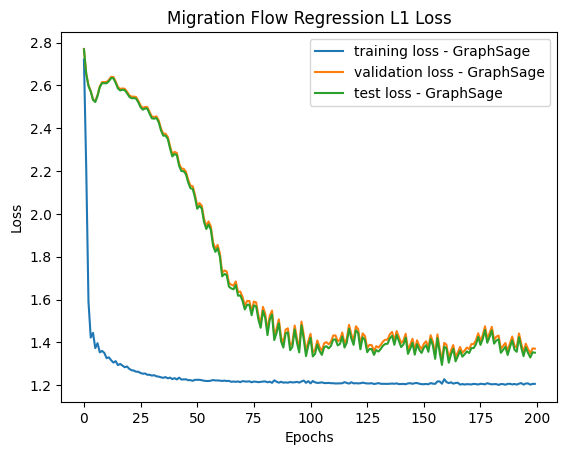

Running pipeline with config: Regression_GraphSage_simple_full


Training:   0%|          | 1/200 [00:00<02:00,  1.65Epochs/s]

Epoch 1: Training Loss 2.63939, Training R2 -1.74095 Validation Loss 2.81151 Validation R2 -1.53101


Training:   1%|          | 2/200 [00:01<01:36,  2.06Epochs/s]

Epoch 2: Training Loss 1.98086, Training R2 -0.29274 Validation Loss 2.79004 Validation R2 -1.4884


Training:   2%|▏         | 3/200 [00:01<01:26,  2.28Epochs/s]

Epoch 3: Training Loss 1.47068, Training R2 0.08135 Validation Loss 2.77011 Validation R2 -1.43598


Training:   2%|▏         | 4/200 [00:01<01:23,  2.36Epochs/s]

Epoch 4: Training Loss 1.41925, Training R2 0.1211 Validation Loss 2.75116 Validation R2 -1.38012


Training:   2%|▎         | 5/200 [00:02<01:22,  2.36Epochs/s]

Epoch 5: Training Loss 1.47169, Training R2 0.15712 Validation Loss 2.75544 Validation R2 -1.40587


Training:   3%|▎         | 6/200 [00:02<01:19,  2.44Epochs/s]

Epoch 6: Training Loss 1.39433, Training R2 0.18819 Validation Loss 2.78338 Validation R2 -1.4954


Training:   4%|▎         | 7/200 [00:02<01:15,  2.56Epochs/s]

Epoch 7: Training Loss 1.38986, Training R2 0.13011 Validation Loss 2.81151 Validation R2 -1.57186


Training:   4%|▍         | 8/200 [00:03<01:11,  2.67Epochs/s]

Epoch 8: Training Loss 1.40391, Training R2 0.11098 Validation Loss 2.81756 Validation R2 -1.58873


Training:   4%|▍         | 9/200 [00:03<01:09,  2.75Epochs/s]

Epoch 9: Training Loss 1.3546, Training R2 0.19341 Validation Loss 2.82105 Validation R2 -1.59895


Training:   5%|▌         | 10/200 [00:04<01:10,  2.70Epochs/s]

Epoch 10: Training Loss 1.38253, Training R2 0.21196 Validation Loss 2.83317 Validation R2 -1.62574


Training:   6%|▌         | 11/200 [00:04<01:10,  2.68Epochs/s]

Epoch 11: Training Loss 1.38181, Training R2 0.22064 Validation Loss 2.85655 Validation R2 -1.66849


Training:   6%|▌         | 12/200 [00:04<01:09,  2.71Epochs/s]

Epoch 12: Training Loss 1.34356, Training R2 0.23258 Validation Loss 2.88055 Validation R2 -1.70384


Training:   6%|▋         | 13/200 [00:05<01:07,  2.75Epochs/s]

Epoch 13: Training Loss 1.34733, Training R2 0.2048 Validation Loss 2.8833 Validation R2 -1.70436


Training:   7%|▋         | 14/200 [00:05<01:06,  2.81Epochs/s]

Epoch 14: Training Loss 1.35901, Training R2 0.19392 Validation Loss 2.8598 Validation R2 -1.66503


Training:   8%|▊         | 15/200 [00:05<01:07,  2.76Epochs/s]

Epoch 15: Training Loss 1.32251, Training R2 0.24393 Validation Loss 2.83243 Validation R2 -1.6157


Training:   8%|▊         | 16/200 [00:06<01:09,  2.66Epochs/s]

Epoch 16: Training Loss 1.32327, Training R2 0.2684 Validation Loss 2.81545 Validation R2 -1.58139


Training:   8%|▊         | 17/200 [00:06<01:09,  2.65Epochs/s]

Epoch 17: Training Loss 1.3423, Training R2 0.26462 Validation Loss 2.80791 Validation R2 -1.56254


Training:   9%|▉         | 18/200 [00:06<01:07,  2.69Epochs/s]

Epoch 18: Training Loss 1.31568, Training R2 0.27871 Validation Loss 2.80911 Validation R2 -1.55848


Training:  10%|▉         | 19/200 [00:07<01:05,  2.75Epochs/s]

Epoch 19: Training Loss 1.30311, Training R2 0.27229 Validation Loss 2.81216 Validation R2 -1.55737


Training:  10%|█         | 20/200 [00:07<01:04,  2.78Epochs/s]

Epoch 20: Training Loss 1.31902, Training R2 0.24866 Validation Loss 2.80275 Validation R2 -1.53744


Training:  10%|█         | 21/200 [00:08<01:06,  2.71Epochs/s]

Epoch 21: Training Loss 1.29836, Training R2 0.2736 Validation Loss 2.78801 Validation R2 -1.51095


Training:  11%|█         | 22/200 [00:08<01:04,  2.76Epochs/s]

Epoch 22: Training Loss 1.29352, Training R2 0.29792 Validation Loss 2.77537 Validation R2 -1.48576


Training:  12%|█▏        | 23/200 [00:08<01:03,  2.77Epochs/s]

Epoch 23: Training Loss 1.30094, Training R2 0.29998 Validation Loss 2.76243 Validation R2 -1.45594


Training:  12%|█▏        | 24/200 [00:09<01:04,  2.74Epochs/s]

Epoch 24: Training Loss 1.28147, Training R2 0.30924 Validation Loss 2.74625 Validation R2 -1.41859


Training:  12%|█▎        | 25/200 [00:09<01:03,  2.77Epochs/s]

Epoch 25: Training Loss 1.27728, Training R2 0.30397 Validation Loss 2.72575 Validation R2 -1.37651


Training:  13%|█▎        | 26/200 [00:09<01:01,  2.83Epochs/s]

Epoch 26: Training Loss 1.28573, Training R2 0.29615 Validation Loss 2.69939 Validation R2 -1.32595


Training:  14%|█▎        | 27/200 [00:10<01:00,  2.85Epochs/s]

Epoch 27: Training Loss 1.26555, Training R2 0.32103 Validation Loss 2.67175 Validation R2 -1.27149


Training:  14%|█▍        | 28/200 [00:10<01:00,  2.87Epochs/s]

Epoch 28: Training Loss 1.26077, Training R2 0.33406 Validation Loss 2.64532 Validation R2 -1.21733


Training:  14%|█▍        | 29/200 [00:10<01:05,  2.59Epochs/s]

Epoch 29: Training Loss 1.27952, Training R2 0.32172 Validation Loss 2.61481 Validation R2 -1.15614


Training:  15%|█▌        | 30/200 [00:11<01:11,  2.39Epochs/s]

Epoch 30: Training Loss 1.25908, Training R2 0.33357 Validation Loss 2.58099 Validation R2 -1.08989


Training:  16%|█▌        | 31/200 [00:11<01:14,  2.27Epochs/s]

Epoch 31: Training Loss 1.26458, Training R2 0.32228 Validation Loss 2.54518 Validation R2 -1.01992


Training:  16%|█▌        | 32/200 [00:12<01:17,  2.18Epochs/s]

Epoch 32: Training Loss 1.26398, Training R2 0.32425 Validation Loss 2.50724 Validation R2 -0.94494


Training:  16%|█▋        | 33/200 [00:12<01:17,  2.15Epochs/s]

Epoch 33: Training Loss 1.24875, Training R2 0.34288 Validation Loss 2.475 Validation R2 -0.88186


Training:  17%|█▋        | 34/200 [00:13<01:19,  2.09Epochs/s]

Epoch 34: Training Loss 1.25652, Training R2 0.34007 Validation Loss 2.445 Validation R2 -0.82744


Training:  18%|█▊        | 35/200 [00:13<01:21,  2.04Epochs/s]

Epoch 35: Training Loss 1.25093, Training R2 0.34151 Validation Loss 2.41691 Validation R2 -0.78026


Training:  18%|█▊        | 36/200 [00:14<01:21,  2.01Epochs/s]

Epoch 36: Training Loss 1.24553, Training R2 0.34346 Validation Loss 2.39173 Validation R2 -0.73853


Training:  18%|█▊        | 37/200 [00:14<01:20,  2.02Epochs/s]

Epoch 37: Training Loss 1.25012, Training R2 0.33899 Validation Loss 2.36658 Validation R2 -0.69433


Training:  19%|█▉        | 38/200 [00:15<01:14,  2.17Epochs/s]

Epoch 38: Training Loss 1.24217, Training R2 0.34621 Validation Loss 2.34153 Validation R2 -0.64959


Training:  20%|█▉        | 39/200 [00:15<01:08,  2.35Epochs/s]

Epoch 39: Training Loss 1.24528, Training R2 0.3475 Validation Loss 2.31058 Validation R2 -0.59902


Training:  20%|██        | 40/200 [00:16<01:04,  2.48Epochs/s]

Epoch 40: Training Loss 1.25498, Training R2 0.33926 Validation Loss 2.26599 Validation R2 -0.53146


Training:  20%|██        | 41/200 [00:16<01:02,  2.55Epochs/s]

Epoch 41: Training Loss 1.23961, Training R2 0.35073 Validation Loss 2.21848 Validation R2 -0.46071


Training:  21%|██        | 42/200 [00:16<01:01,  2.57Epochs/s]

Epoch 42: Training Loss 1.24498, Training R2 0.34464 Validation Loss 2.18088 Validation R2 -0.40225


Training:  22%|██▏       | 43/200 [00:17<01:00,  2.61Epochs/s]

Epoch 43: Training Loss 1.23632, Training R2 0.35211 Validation Loss 2.14967 Validation R2 -0.35371


Training:  22%|██▏       | 44/200 [00:17<01:00,  2.59Epochs/s]

Epoch 44: Training Loss 1.23824, Training R2 0.35165 Validation Loss 2.11356 Validation R2 -0.30293


Training:  22%|██▎       | 45/200 [00:17<00:59,  2.60Epochs/s]

Epoch 45: Training Loss 1.24091, Training R2 0.34974 Validation Loss 2.06521 Validation R2 -0.24072


Training:  23%|██▎       | 46/200 [00:18<00:58,  2.65Epochs/s]

Epoch 46: Training Loss 1.23285, Training R2 0.35324 Validation Loss 2.02106 Validation R2 -0.1857


Training:  24%|██▎       | 47/200 [00:18<00:58,  2.60Epochs/s]

Epoch 47: Training Loss 1.23673, Training R2 0.34925 Validation Loss 1.98883 Validation R2 -0.14622


Training:  24%|██▍       | 48/200 [00:19<00:58,  2.58Epochs/s]

Epoch 48: Training Loss 1.23353, Training R2 0.35317 Validation Loss 1.97409 Validation R2 -0.12697


Training:  24%|██▍       | 49/200 [00:19<00:57,  2.62Epochs/s]

Epoch 49: Training Loss 1.23469, Training R2 0.35526 Validation Loss 1.95798 Validation R2 -0.1073


Training:  25%|██▌       | 50/200 [00:19<00:55,  2.69Epochs/s]

Epoch 50: Training Loss 1.23887, Training R2 0.35283 Validation Loss 1.91476 Validation R2 -0.06074


Training:  26%|██▌       | 51/200 [00:20<00:54,  2.76Epochs/s]

Epoch 51: Training Loss 1.23109, Training R2 0.35611 Validation Loss 1.86603 Validation R2 -0.0121


Training:  26%|██▌       | 52/200 [00:20<00:53,  2.78Epochs/s]

Epoch 52: Training Loss 1.23545, Training R2 0.35027 Validation Loss 1.84608 Validation R2 0.00928


Training:  26%|██▋       | 53/200 [00:20<00:52,  2.81Epochs/s]

Epoch 53: Training Loss 1.23256, Training R2 0.35288 Validation Loss 1.84994 Validation R2 0.00822


Training:  27%|██▋       | 54/200 [00:21<00:51,  2.85Epochs/s]

Epoch 54: Training Loss 1.23027, Training R2 0.35892 Validation Loss 1.83441 Validation R2 0.02391


Training:  28%|██▊       | 55/200 [00:21<00:50,  2.85Epochs/s]

Epoch 55: Training Loss 1.23135, Training R2 0.35652 Validation Loss 1.78636 Validation R2 0.06773


Training:  28%|██▊       | 56/200 [00:21<00:50,  2.88Epochs/s]

Epoch 56: Training Loss 1.22671, Training R2 0.35802 Validation Loss 1.75053 Validation R2 0.09882


Training:  28%|██▊       | 57/200 [00:22<00:50,  2.84Epochs/s]

Epoch 57: Training Loss 1.23046, Training R2 0.35392 Validation Loss 1.7499 Validation R2 0.10058


Training:  29%|██▉       | 58/200 [00:22<00:50,  2.78Epochs/s]

Epoch 58: Training Loss 1.22741, Training R2 0.35807 Validation Loss 1.75456 Validation R2 0.09783


Training:  30%|██▉       | 59/200 [00:22<00:50,  2.79Epochs/s]

Epoch 59: Training Loss 1.22904, Training R2 0.35891 Validation Loss 1.73136 Validation R2 0.11748


Training:  30%|███       | 60/200 [00:23<00:49,  2.82Epochs/s]

Epoch 60: Training Loss 1.22845, Training R2 0.35979 Validation Loss 1.68137 Validation R2 0.15757


Training:  30%|███       | 61/200 [00:23<00:49,  2.82Epochs/s]

Epoch 61: Training Loss 1.22718, Training R2 0.35727 Validation Loss 1.64886 Validation R2 0.18228


Training:  31%|███       | 62/200 [00:24<00:48,  2.87Epochs/s]

Epoch 62: Training Loss 1.22933, Training R2 0.35618 Validation Loss 1.65009 Validation R2 0.18247


Training:  32%|███▏      | 63/200 [00:24<00:47,  2.91Epochs/s]

Epoch 63: Training Loss 1.22746, Training R2 0.35623 Validation Loss 1.66749 Validation R2 0.17001


Training:  32%|███▏      | 64/200 [00:24<00:46,  2.93Epochs/s]

Epoch 64: Training Loss 1.23257, Training R2 0.35401 Validation Loss 1.63682 Validation R2 0.19139


Training:  32%|███▎      | 65/200 [00:25<00:45,  2.94Epochs/s]

Epoch 65: Training Loss 1.22512, Training R2 0.35948 Validation Loss 1.59866 Validation R2 0.21616


Training:  33%|███▎      | 66/200 [00:25<00:51,  2.62Epochs/s]

Epoch 66: Training Loss 1.22648, Training R2 0.35753 Validation Loss 1.60591 Validation R2 0.21051


Training:  34%|███▎      | 67/200 [00:26<00:57,  2.32Epochs/s]

Epoch 67: Training Loss 1.22544, Training R2 0.35865 Validation Loss 1.63928 Validation R2 0.18633


Training:  34%|███▍      | 68/200 [00:26<01:00,  2.19Epochs/s]

Epoch 68: Training Loss 1.22718, Training R2 0.35866 Validation Loss 1.62087 Validation R2 0.19775


Training:  34%|███▍      | 69/200 [00:27<01:01,  2.14Epochs/s]

Epoch 69: Training Loss 1.22465, Training R2 0.36011 Validation Loss 1.59157 Validation R2 0.21658


Training:  35%|███▌      | 70/200 [00:27<01:01,  2.13Epochs/s]

Epoch 70: Training Loss 1.22228, Training R2 0.3608 Validation Loss 1.59367 Validation R2 0.21465


Training:  36%|███▌      | 71/200 [00:28<01:02,  2.06Epochs/s]

Epoch 71: Training Loss 1.22507, Training R2 0.35841 Validation Loss 1.60815 Validation R2 0.20442


Training:  36%|███▌      | 72/200 [00:28<01:02,  2.05Epochs/s]

Epoch 72: Training Loss 1.22398, Training R2 0.36076 Validation Loss 1.60315 Validation R2 0.20724


Training:  36%|███▋      | 73/200 [00:29<01:04,  1.96Epochs/s]

Epoch 73: Training Loss 1.22333, Training R2 0.36038 Validation Loss 1.58153 Validation R2 0.22168


Training:  37%|███▋      | 74/200 [00:29<01:03,  1.98Epochs/s]

Epoch 74: Training Loss 1.22333, Training R2 0.36072 Validation Loss 1.53676 Validation R2 0.25059


Training:  38%|███▊      | 75/200 [00:29<00:57,  2.18Epochs/s]

Epoch 75: Training Loss 1.22317, Training R2 0.36002 Validation Loss 1.56909 Validation R2 0.23065


Training:  38%|███▊      | 76/200 [00:30<00:52,  2.35Epochs/s]

Epoch 76: Training Loss 1.22133, Training R2 0.36275 Validation Loss 1.58154 Validation R2 0.22326


Training:  38%|███▊      | 77/200 [00:30<00:49,  2.49Epochs/s]

Epoch 77: Training Loss 1.22513, Training R2 0.36016 Validation Loss 1.49671 Validation R2 0.2775


Training:  39%|███▉      | 78/200 [00:31<00:47,  2.59Epochs/s]

Epoch 78: Training Loss 1.22143, Training R2 0.36097 Validation Loss 1.46807 Validation R2 0.29547


Training:  40%|███▉      | 79/200 [00:31<00:45,  2.68Epochs/s]

Epoch 79: Training Loss 1.22046, Training R2 0.36149 Validation Loss 1.49634 Validation R2 0.27931


Training:  40%|████      | 80/200 [00:31<00:43,  2.74Epochs/s]

Epoch 80: Training Loss 1.21949, Training R2 0.36391 Validation Loss 1.49161 Validation R2 0.28281


Training:  40%|████      | 81/200 [00:32<00:42,  2.77Epochs/s]

Epoch 81: Training Loss 1.22574, Training R2 0.35869 Validation Loss 1.40293 Validation R2 0.3349


Training:  41%|████      | 82/200 [00:32<00:42,  2.80Epochs/s]

Epoch 82: Training Loss 1.22668, Training R2 0.35782 Validation Loss 1.40128 Validation R2 0.3367


Training:  42%|████▏     | 83/200 [00:32<00:41,  2.81Epochs/s]

Epoch 83: Training Loss 1.22101, Training R2 0.36005 Validation Loss 1.423 Validation R2 0.32472


Training:  42%|████▏     | 84/200 [00:33<00:41,  2.82Epochs/s]

Epoch 84: Training Loss 1.22161, Training R2 0.36164 Validation Loss 1.39897 Validation R2 0.33839


Training:  42%|████▎     | 85/200 [00:33<00:40,  2.83Epochs/s]

Epoch 85: Training Loss 1.21971, Training R2 0.36249 Validation Loss 1.36215 Validation R2 0.35873


Training:  43%|████▎     | 86/200 [00:33<00:39,  2.86Epochs/s]

Epoch 86: Training Loss 1.22261, Training R2 0.35911 Validation Loss 1.38813 Validation R2 0.345


Training:  44%|████▎     | 87/200 [00:34<00:41,  2.74Epochs/s]

Epoch 87: Training Loss 1.22016, Training R2 0.36218 Validation Loss 1.40808 Validation R2 0.3344


Training:  44%|████▍     | 88/200 [00:34<00:40,  2.78Epochs/s]

Epoch 88: Training Loss 1.22509, Training R2 0.3579 Validation Loss 1.33791 Validation R2 0.3721


Training:  44%|████▍     | 89/200 [00:34<00:39,  2.82Epochs/s]

Epoch 89: Training Loss 1.22367, Training R2 0.35829 Validation Loss 1.34389 Validation R2 0.36923


Training:  45%|████▌     | 90/200 [00:35<00:38,  2.83Epochs/s]

Epoch 90: Training Loss 1.22303, Training R2 0.35741 Validation Loss 1.40376 Validation R2 0.33851


Training:  46%|████▌     | 91/200 [00:35<00:39,  2.76Epochs/s]

Epoch 91: Training Loss 1.22817, Training R2 0.35708 Validation Loss 1.35301 Validation R2 0.36501


Training:  46%|████▌     | 92/200 [00:36<00:40,  2.69Epochs/s]

Epoch 92: Training Loss 1.21769, Training R2 0.36213 Validation Loss 1.31715 Validation R2 0.38294


Training:  46%|████▋     | 93/200 [00:36<00:39,  2.68Epochs/s]

Epoch 93: Training Loss 1.22509, Training R2 0.35588 Validation Loss 1.35978 Validation R2 0.36076


Training:  47%|████▋     | 94/200 [00:36<00:39,  2.69Epochs/s]

Epoch 94: Training Loss 1.22069, Training R2 0.36098 Validation Loss 1.38487 Validation R2 0.34666


Training:  48%|████▊     | 95/200 [00:37<00:38,  2.74Epochs/s]

Epoch 95: Training Loss 1.22256, Training R2 0.35939 Validation Loss 1.34002 Validation R2 0.369


Training:  48%|████▊     | 96/200 [00:37<00:37,  2.77Epochs/s]

Epoch 96: Training Loss 1.21955, Training R2 0.36047 Validation Loss 1.34948 Validation R2 0.36299


Training:  48%|████▊     | 97/200 [00:37<00:36,  2.81Epochs/s]

Epoch 97: Training Loss 1.21577, Training R2 0.36344 Validation Loss 1.37974 Validation R2 0.34578


Training:  49%|████▉     | 98/200 [00:38<00:36,  2.79Epochs/s]

Epoch 98: Training Loss 1.21983, Training R2 0.36036 Validation Loss 1.37126 Validation R2 0.34939


Training:  50%|████▉     | 99/200 [00:38<00:35,  2.83Epochs/s]

Epoch 99: Training Loss 1.22041, Training R2 0.35921 Validation Loss 1.35706 Validation R2 0.35568


Training:  50%|█████     | 100/200 [00:38<00:35,  2.82Epochs/s]

Epoch 100: Training Loss 1.21917, Training R2 0.36144 Validation Loss 1.37653 Validation R2 0.344


Training:  50%|█████     | 101/200 [00:39<00:36,  2.71Epochs/s]

Epoch 101: Training Loss 1.22081, Training R2 0.36046 Validation Loss 1.41167 Validation R2 0.3236


Training:  51%|█████     | 102/200 [00:39<00:36,  2.69Epochs/s]

Epoch 102: Training Loss 1.22162, Training R2 0.35993 Validation Loss 1.36857 Validation R2 0.34775


Training:  52%|█████▏    | 103/200 [00:40<00:39,  2.48Epochs/s]

Epoch 103: Training Loss 1.21734, Training R2 0.36197 Validation Loss 1.35049 Validation R2 0.35771


Training:  52%|█████▏    | 104/200 [00:40<00:40,  2.35Epochs/s]

Epoch 104: Training Loss 1.22145, Training R2 0.35829 Validation Loss 1.40711 Validation R2 0.32591


Training:  52%|█████▎    | 105/200 [00:41<00:42,  2.25Epochs/s]

Epoch 105: Training Loss 1.2199, Training R2 0.35991 Validation Loss 1.41234 Validation R2 0.3229


Training:  53%|█████▎    | 106/200 [00:41<00:44,  2.12Epochs/s]

Epoch 106: Training Loss 1.21998, Training R2 0.36033 Validation Loss 1.35503 Validation R2 0.35485


Training:  54%|█████▎    | 107/200 [00:42<00:44,  2.08Epochs/s]

Epoch 107: Training Loss 1.22079, Training R2 0.358 Validation Loss 1.40266 Validation R2 0.32768


Training:  54%|█████▍    | 108/200 [00:42<00:44,  2.06Epochs/s]

Epoch 108: Training Loss 1.21882, Training R2 0.36085 Validation Loss 1.44 Validation R2 0.30541


Training:  55%|█████▍    | 109/200 [00:43<00:43,  2.07Epochs/s]

Epoch 109: Training Loss 1.21619, Training R2 0.36384 Validation Loss 1.3948 Validation R2 0.33046


Training:  55%|█████▌    | 110/200 [00:43<00:43,  2.06Epochs/s]

Epoch 110: Training Loss 1.22026, Training R2 0.35846 Validation Loss 1.42006 Validation R2 0.31577


Training:  56%|█████▌    | 111/200 [00:44<00:44,  1.98Epochs/s]

Epoch 111: Training Loss 1.21589, Training R2 0.36348 Validation Loss 1.42296 Validation R2 0.31519


Training:  56%|█████▌    | 112/200 [00:44<00:41,  2.10Epochs/s]

Epoch 112: Training Loss 1.2159, Training R2 0.36223 Validation Loss 1.38866 Validation R2 0.33639


Training:  56%|█████▋    | 113/200 [00:44<00:38,  2.28Epochs/s]

Epoch 113: Training Loss 1.21703, Training R2 0.3609 Validation Loss 1.38744 Validation R2 0.33866


Training:  57%|█████▋    | 114/200 [00:45<00:35,  2.45Epochs/s]

Epoch 114: Training Loss 1.21637, Training R2 0.36215 Validation Loss 1.36088 Validation R2 0.355


Training:  57%|█████▊    | 115/200 [00:45<00:33,  2.56Epochs/s]

Epoch 115: Training Loss 1.21774, Training R2 0.35976 Validation Loss 1.34434 Validation R2 0.36506


Training:  58%|█████▊    | 116/200 [00:45<00:31,  2.67Epochs/s]

Epoch 116: Training Loss 1.21699, Training R2 0.36075 Validation Loss 1.34437 Validation R2 0.36571


Training:  58%|█████▊    | 117/200 [00:46<00:30,  2.74Epochs/s]

Epoch 117: Training Loss 1.21663, Training R2 0.36136 Validation Loss 1.35236 Validation R2 0.36197


Training:  59%|█████▉    | 118/200 [00:46<00:29,  2.76Epochs/s]

Epoch 118: Training Loss 1.21571, Training R2 0.36232 Validation Loss 1.34901 Validation R2 0.36389


Training:  60%|█████▉    | 119/200 [00:46<00:29,  2.78Epochs/s]

Epoch 119: Training Loss 1.21547, Training R2 0.36265 Validation Loss 1.32118 Validation R2 0.37835


Training:  60%|██████    | 120/200 [00:47<00:28,  2.82Epochs/s]

Epoch 120: Training Loss 1.22264, Training R2 0.35551 Validation Loss 1.39786 Validation R2 0.33768


Training:  60%|██████    | 121/200 [00:47<00:27,  2.84Epochs/s]

Epoch 121: Training Loss 1.22095, Training R2 0.36046 Validation Loss 1.35816 Validation R2 0.35885


Training:  61%|██████    | 122/200 [00:48<00:27,  2.87Epochs/s]

Epoch 122: Training Loss 1.21629, Training R2 0.36208 Validation Loss 1.31819 Validation R2 0.37998


Training:  62%|██████▏   | 123/200 [00:48<00:26,  2.88Epochs/s]

Epoch 123: Training Loss 1.221, Training R2 0.35712 Validation Loss 1.35271 Validation R2 0.36138


Training:  62%|██████▏   | 124/200 [00:48<00:26,  2.89Epochs/s]

Epoch 124: Training Loss 1.2164, Training R2 0.36067 Validation Loss 1.39346 Validation R2 0.33911


Training:  62%|██████▎   | 125/200 [00:49<00:25,  2.92Epochs/s]

Epoch 125: Training Loss 1.2184, Training R2 0.36099 Validation Loss 1.33815 Validation R2 0.36851


Training:  63%|██████▎   | 126/200 [00:49<00:26,  2.81Epochs/s]

Epoch 126: Training Loss 1.2175, Training R2 0.36008 Validation Loss 1.36311 Validation R2 0.35598


Training:  64%|██████▎   | 127/200 [00:49<00:26,  2.71Epochs/s]

Epoch 127: Training Loss 1.21904, Training R2 0.35946 Validation Loss 1.34473 Validation R2 0.36646


Training:  64%|██████▍   | 128/200 [00:50<00:26,  2.76Epochs/s]

Epoch 128: Training Loss 1.2146, Training R2 0.36296 Validation Loss 1.31968 Validation R2 0.38029


Training:  64%|██████▍   | 129/200 [00:50<00:25,  2.77Epochs/s]

Epoch 129: Training Loss 1.21823, Training R2 0.35897 Validation Loss 1.3433 Validation R2 0.36913


Training:  65%|██████▌   | 130/200 [00:50<00:26,  2.68Epochs/s]

Epoch 130: Training Loss 1.21301, Training R2 0.36392 Validation Loss 1.34133 Validation R2 0.37055


Training:  66%|██████▌   | 131/200 [00:51<00:26,  2.64Epochs/s]

Epoch 131: Training Loss 1.21423, Training R2 0.36237 Validation Loss 1.32097 Validation R2 0.38133


Training:  66%|██████▌   | 132/200 [00:51<00:25,  2.70Epochs/s]

Epoch 132: Training Loss 1.21407, Training R2 0.36222 Validation Loss 1.31977 Validation R2 0.38192


Training:  66%|██████▋   | 133/200 [00:52<00:24,  2.75Epochs/s]

Epoch 133: Training Loss 1.2179, Training R2 0.35886 Validation Loss 1.3216 Validation R2 0.38041


Training:  67%|██████▋   | 134/200 [00:52<00:23,  2.79Epochs/s]

Epoch 134: Training Loss 1.21692, Training R2 0.36006 Validation Loss 1.34517 Validation R2 0.36749


Training:  68%|██████▊   | 135/200 [00:52<00:23,  2.82Epochs/s]

Epoch 135: Training Loss 1.21601, Training R2 0.36125 Validation Loss 1.32867 Validation R2 0.37552


Training:  68%|██████▊   | 136/200 [00:53<00:22,  2.83Epochs/s]

Epoch 136: Training Loss 1.21477, Training R2 0.36137 Validation Loss 1.33018 Validation R2 0.37451


Training:  68%|██████▊   | 137/200 [00:53<00:22,  2.84Epochs/s]

Epoch 137: Training Loss 1.21465, Training R2 0.36113 Validation Loss 1.31976 Validation R2 0.37959


Training:  69%|██████▉   | 138/200 [00:53<00:21,  2.84Epochs/s]

Epoch 138: Training Loss 1.21398, Training R2 0.36161 Validation Loss 1.31678 Validation R2 0.38057


Training:  70%|██████▉   | 139/200 [00:54<00:21,  2.86Epochs/s]

Epoch 139: Training Loss 1.21406, Training R2 0.3602 Validation Loss 1.32859 Validation R2 0.37393


Training:  70%|███████   | 140/200 [00:54<00:23,  2.57Epochs/s]

Epoch 140: Training Loss 1.21304, Training R2 0.36241 Validation Loss 1.33935 Validation R2 0.36815


Training:  70%|███████   | 141/200 [00:55<00:27,  2.18Epochs/s]

Epoch 141: Training Loss 1.21625, Training R2 0.35928 Validation Loss 1.32447 Validation R2 0.37636


Training:  71%|███████   | 142/200 [00:55<00:28,  2.07Epochs/s]

Epoch 142: Training Loss 1.21812, Training R2 0.35756 Validation Loss 1.31192 Validation R2 0.38271


Training:  72%|███████▏  | 143/200 [00:56<00:28,  2.02Epochs/s]

Epoch 143: Training Loss 1.21752, Training R2 0.35863 Validation Loss 1.35689 Validation R2 0.36012


Training:  72%|███████▏  | 144/200 [00:56<00:27,  2.02Epochs/s]

Epoch 144: Training Loss 1.21762, Training R2 0.35891 Validation Loss 1.32171 Validation R2 0.37832


Training:  72%|███████▎  | 145/200 [00:57<00:27,  2.02Epochs/s]

Epoch 145: Training Loss 1.21346, Training R2 0.36119 Validation Loss 1.31105 Validation R2 0.38377


Training:  73%|███████▎  | 146/200 [00:57<00:26,  2.04Epochs/s]

Epoch 146: Training Loss 1.21597, Training R2 0.35846 Validation Loss 1.33523 Validation R2 0.37253


Training:  74%|███████▎  | 147/200 [00:58<00:26,  2.03Epochs/s]

Epoch 147: Training Loss 1.22278, Training R2 0.35498 Validation Loss 1.30255 Validation R2 0.38699


Training:  74%|███████▍  | 148/200 [00:58<00:26,  1.98Epochs/s]

Epoch 148: Training Loss 1.21912, Training R2 0.35634 Validation Loss 1.32261 Validation R2 0.37737


Training:  74%|███████▍  | 149/200 [00:59<00:23,  2.13Epochs/s]

Epoch 149: Training Loss 1.21295, Training R2 0.36302 Validation Loss 1.34999 Validation R2 0.36364


Training:  75%|███████▌  | 150/200 [00:59<00:21,  2.30Epochs/s]

Epoch 150: Training Loss 1.2189, Training R2 0.35913 Validation Loss 1.30633 Validation R2 0.38432


Training:  76%|███████▌  | 151/200 [00:59<00:19,  2.45Epochs/s]

Epoch 151: Training Loss 1.21826, Training R2 0.35689 Validation Loss 1.31915 Validation R2 0.37865


Training:  76%|███████▌  | 152/200 [01:00<00:18,  2.56Epochs/s]

Epoch 152: Training Loss 1.21246, Training R2 0.36246 Validation Loss 1.34128 Validation R2 0.36781


Training:  76%|███████▋  | 153/200 [01:00<00:17,  2.67Epochs/s]

Epoch 153: Training Loss 1.21942, Training R2 0.35872 Validation Loss 1.30997 Validation R2 0.38157


Training:  77%|███████▋  | 154/200 [01:00<00:17,  2.65Epochs/s]

Epoch 154: Training Loss 1.21898, Training R2 0.35544 Validation Loss 1.33821 Validation R2 0.36878


Training:  78%|███████▊  | 155/200 [01:01<00:17,  2.62Epochs/s]

Epoch 155: Training Loss 1.21426, Training R2 0.3613 Validation Loss 1.34426 Validation R2 0.36536


Training:  78%|███████▊  | 156/200 [01:01<00:17,  2.57Epochs/s]

Epoch 156: Training Loss 1.2161, Training R2 0.35969 Validation Loss 1.31592 Validation R2 0.37773


Training:  78%|███████▊  | 157/200 [01:02<00:16,  2.64Epochs/s]

Epoch 157: Training Loss 1.21564, Training R2 0.35745 Validation Loss 1.33842 Validation R2 0.36704


Training:  79%|███████▉  | 158/200 [01:02<00:15,  2.63Epochs/s]

Epoch 158: Training Loss 1.21586, Training R2 0.35912 Validation Loss 1.33836 Validation R2 0.36713


Training:  80%|███████▉  | 159/200 [01:02<00:15,  2.66Epochs/s]

Epoch 159: Training Loss 1.2171, Training R2 0.35587 Validation Loss 1.31942 Validation R2 0.37443


Training:  80%|████████  | 160/200 [01:03<00:15,  2.61Epochs/s]

Epoch 160: Training Loss 1.21914, Training R2 0.35553 Validation Loss 1.38886 Validation R2 0.33861


Training:  80%|████████  | 161/200 [01:03<00:14,  2.69Epochs/s]

Epoch 161: Training Loss 1.22172, Training R2 0.35427 Validation Loss 1.3387 Validation R2 0.36445


Training:  81%|████████  | 162/200 [01:03<00:14,  2.69Epochs/s]

Epoch 162: Training Loss 1.21421, Training R2 0.35912 Validation Loss 1.33685 Validation R2 0.36648


Training:  82%|████████▏ | 163/200 [01:04<00:13,  2.72Epochs/s]

Epoch 163: Training Loss 1.21189, Training R2 0.36087 Validation Loss 1.3469 Validation R2 0.36167


Training:  82%|████████▏ | 164/200 [01:04<00:12,  2.78Epochs/s]

Epoch 164: Training Loss 1.21298, Training R2 0.35992 Validation Loss 1.32202 Validation R2 0.37424


Training:  82%|████████▎ | 165/200 [01:05<00:12,  2.74Epochs/s]

Epoch 165: Training Loss 1.21438, Training R2 0.35869 Validation Loss 1.31366 Validation R2 0.37968


Training:  83%|████████▎ | 166/200 [01:05<00:12,  2.71Epochs/s]

Epoch 166: Training Loss 1.21259, Training R2 0.35899 Validation Loss 1.31973 Validation R2 0.37866


Training:  84%|████████▎ | 167/200 [01:05<00:11,  2.79Epochs/s]

Epoch 167: Training Loss 1.21399, Training R2 0.35861 Validation Loss 1.31125 Validation R2 0.3827


Training:  84%|████████▍ | 168/200 [01:06<00:11,  2.83Epochs/s]

Epoch 168: Training Loss 1.2105, Training R2 0.36119 Validation Loss 1.3048 Validation R2 0.38658


Training:  84%|████████▍ | 169/200 [01:06<00:10,  2.83Epochs/s]

Epoch 169: Training Loss 1.21081, Training R2 0.36091 Validation Loss 1.30454 Validation R2 0.38877


Training:  85%|████████▌ | 170/200 [01:06<00:10,  2.86Epochs/s]

Epoch 170: Training Loss 1.21529, Training R2 0.35854 Validation Loss 1.29877 Validation R2 0.39063


Training:  86%|████████▌ | 171/200 [01:07<00:10,  2.90Epochs/s]

Epoch 171: Training Loss 1.214, Training R2 0.35846 Validation Loss 1.30102 Validation R2 0.3921


Training:  86%|████████▌ | 172/200 [01:07<00:09,  2.86Epochs/s]

Epoch 172: Training Loss 1.21522, Training R2 0.35771 Validation Loss 1.30122 Validation R2 0.38861


Training:  86%|████████▋ | 173/200 [01:07<00:09,  2.80Epochs/s]

Epoch 173: Training Loss 1.21353, Training R2 0.35815 Validation Loss 1.30318 Validation R2 0.38509


Training:  87%|████████▋ | 174/200 [01:08<00:09,  2.73Epochs/s]

Epoch 174: Training Loss 1.21481, Training R2 0.356 Validation Loss 1.3041 Validation R2 0.38926


Training:  88%|████████▊ | 175/200 [01:08<00:09,  2.71Epochs/s]

Epoch 175: Training Loss 1.21866, Training R2 0.35592 Validation Loss 1.29741 Validation R2 0.38716


Training:  88%|████████▊ | 176/200 [01:09<00:09,  2.50Epochs/s]

Epoch 176: Training Loss 1.21138, Training R2 0.35956 Validation Loss 1.29788 Validation R2 0.38519


Training:  88%|████████▊ | 177/200 [01:09<00:09,  2.31Epochs/s]

Epoch 177: Training Loss 1.21789, Training R2 0.35242 Validation Loss 1.29887 Validation R2 0.38747


Training:  89%|████████▉ | 178/200 [01:10<00:09,  2.26Epochs/s]

Epoch 178: Training Loss 1.21159, Training R2 0.35972 Validation Loss 1.29941 Validation R2 0.38818


Training:  90%|████████▉ | 179/200 [01:10<00:09,  2.20Epochs/s]

Epoch 179: Training Loss 1.21236, Training R2 0.35861 Validation Loss 1.30056 Validation R2 0.38307


Training:  90%|█████████ | 180/200 [01:11<00:09,  2.16Epochs/s]

Epoch 180: Training Loss 1.21767, Training R2 0.35238 Validation Loss 1.29906 Validation R2 0.38882


Training:  90%|█████████ | 181/200 [01:11<00:09,  2.03Epochs/s]

Epoch 181: Training Loss 1.21436, Training R2 0.35808 Validation Loss 1.29933 Validation R2 0.38835


Training:  91%|█████████ | 182/200 [01:12<00:09,  1.92Epochs/s]

Epoch 182: Training Loss 1.2162, Training R2 0.35682 Validation Loss 1.29753 Validation R2 0.3844


Training:  92%|█████████▏| 183/200 [01:12<00:08,  1.90Epochs/s]

Epoch 183: Training Loss 1.22231, Training R2 0.34934 Validation Loss 1.31431 Validation R2 0.38237


Training:  92%|█████████▏| 184/200 [01:13<00:08,  1.88Epochs/s]

Epoch 184: Training Loss 1.21821, Training R2 0.35453 Validation Loss 1.30087 Validation R2 0.38781


Training:  92%|█████████▎| 185/200 [01:13<00:07,  2.07Epochs/s]

Epoch 185: Training Loss 1.21064, Training R2 0.36028 Validation Loss 1.29732 Validation R2 0.38636


Training:  93%|█████████▎| 186/200 [01:13<00:06,  2.28Epochs/s]

Epoch 186: Training Loss 1.21515, Training R2 0.3557 Validation Loss 1.30495 Validation R2 0.38619


Training:  94%|█████████▎| 187/200 [01:14<00:05,  2.41Epochs/s]

Epoch 187: Training Loss 1.21546, Training R2 0.35609 Validation Loss 1.2978 Validation R2 0.38573


Training:  94%|█████████▍| 188/200 [01:14<00:04,  2.54Epochs/s]

Epoch 188: Training Loss 1.21088, Training R2 0.35919 Validation Loss 1.29764 Validation R2 0.38303


Training:  94%|█████████▍| 189/200 [01:14<00:04,  2.63Epochs/s]

Epoch 189: Training Loss 1.21812, Training R2 0.35181 Validation Loss 1.3129 Validation R2 0.38004


Training:  95%|█████████▌| 190/200 [01:15<00:03,  2.63Epochs/s]

Epoch 190: Training Loss 1.22036, Training R2 0.35391 Validation Loss 1.30199 Validation R2 0.38241


Training:  96%|█████████▌| 191/200 [01:15<00:03,  2.65Epochs/s]

Epoch 191: Training Loss 1.21109, Training R2 0.35766 Validation Loss 1.29813 Validation R2 0.3835


Training:  96%|█████████▌| 192/200 [01:16<00:02,  2.69Epochs/s]

Epoch 192: Training Loss 1.2125, Training R2 0.35724 Validation Loss 1.31015 Validation R2 0.38245


Training:  96%|█████████▋| 193/200 [01:16<00:02,  2.73Epochs/s]

Epoch 193: Training Loss 1.21437, Training R2 0.35648 Validation Loss 1.29968 Validation R2 0.38656


Training:  97%|█████████▋| 194/200 [01:16<00:02,  2.75Epochs/s]

Epoch 194: Training Loss 1.21045, Training R2 0.36033 Validation Loss 1.29783 Validation R2 0.38332


Training:  98%|█████████▊| 195/200 [01:17<00:01,  2.66Epochs/s]

Epoch 195: Training Loss 1.21766, Training R2 0.35199 Validation Loss 1.30455 Validation R2 0.3847


Training:  98%|█████████▊| 196/200 [01:17<00:01,  2.64Epochs/s]

Epoch 196: Training Loss 1.21254, Training R2 0.35759 Validation Loss 1.30721 Validation R2 0.38242


Training:  98%|█████████▊| 197/200 [01:17<00:01,  2.64Epochs/s]

Epoch 197: Training Loss 1.21415, Training R2 0.35626 Validation Loss 1.29718 Validation R2 0.38126


Training:  99%|█████████▉| 198/200 [01:18<00:00,  2.70Epochs/s]

Epoch 198: Training Loss 1.21934, Training R2 0.34943 Validation Loss 1.29977 Validation R2 0.38333


Training: 100%|█████████▉| 199/200 [01:18<00:00,  2.76Epochs/s]

Epoch 199: Training Loss 1.2088, Training R2 0.35965 Validation Loss 1.30894 Validation R2 0.38066


Training: 100%|██████████| 200/200 [01:19<00:00,  2.53Epochs/s]

Epoch 200: Training Loss 1.21915, Training R2 0.35479 Validation Loss 1.29713 Validation R2 0.38252
Saving Model Predictions for Model Type GraphSage
Model saved successfully as Regression_GraphSage_simple_full
Minimum validation loss: 1.2971343994140625
Minimum test loss: 1.279437780380249
Best test metric: 0.3957751989364624


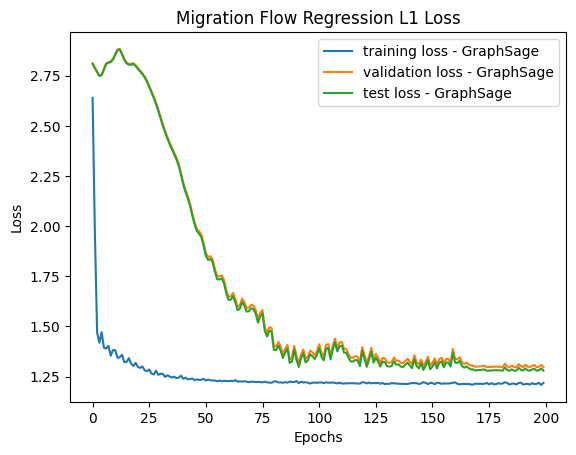

Running pipeline with config: Regression_GraphSage_full_within_state


Training:   0%|          | 1/200 [00:00<01:32,  2.16Epochs/s]

Epoch 1: Training Loss 2.86699, Training R2 -1.80279 Validation Loss 2.96392 Validation R2 -1.38523


Training:   1%|          | 2/200 [00:00<01:31,  2.17Epochs/s]

Epoch 2: Training Loss 2.00967, Training R2 -0.13798 Validation Loss 2.84115 Validation R2 -1.12612


Training:   2%|▏         | 3/200 [00:01<01:31,  2.16Epochs/s]

Epoch 3: Training Loss 2.64815, Training R2 -1.15556 Validation Loss 2.81077 Validation R2 -1.0071


Training:   2%|▏         | 4/200 [00:01<01:30,  2.17Epochs/s]

Epoch 4: Training Loss 1.75334, Training R2 -0.09451 Validation Loss 2.89014 Validation R2 -1.18175


Training:   2%|▎         | 5/200 [00:02<01:29,  2.19Epochs/s]

Epoch 5: Training Loss 1.94326, Training R2 -0.16427 Validation Loss 2.92112 Validation R2 -1.27519


Training:   3%|▎         | 6/200 [00:02<01:28,  2.19Epochs/s]

Epoch 6: Training Loss 1.87052, Training R2 -0.03642 Validation Loss 2.90829 Validation R2 -1.26183


Training:   4%|▎         | 7/200 [00:03<01:38,  1.95Epochs/s]

Epoch 7: Training Loss 1.77709, Training R2 0.0588 Validation Loss 2.86702 Validation R2 -1.17839


Training:   4%|▍         | 8/200 [00:04<01:45,  1.83Epochs/s]

Epoch 8: Training Loss 1.69171, Training R2 0.0886 Validation Loss 2.81047 Validation R2 -1.06065


Training:   4%|▍         | 9/200 [00:04<01:49,  1.74Epochs/s]

Epoch 9: Training Loss 1.68773, Training R2 0.05022 Validation Loss 2.7523 Validation R2 -0.94001


Training:   5%|▌         | 10/200 [00:05<01:50,  1.72Epochs/s]

Epoch 10: Training Loss 1.68975, Training R2 0.02599 Validation Loss 2.7067 Validation R2 -0.84436


Training:   6%|▌         | 11/200 [00:05<01:54,  1.66Epochs/s]

Epoch 11: Training Loss 1.65738, Training R2 0.05255 Validation Loss 2.68091 Validation R2 -0.78697


Training:   6%|▌         | 12/200 [00:06<01:56,  1.61Epochs/s]

Epoch 12: Training Loss 1.61209, Training R2 0.09722 Validation Loss 2.67049 Validation R2 -0.7612


Training:   6%|▋         | 13/200 [00:07<01:56,  1.60Epochs/s]

Epoch 13: Training Loss 1.60287, Training R2 0.1115 Validation Loss 2.66323 Validation R2 -0.74581


Training:   7%|▋         | 14/200 [00:07<01:47,  1.73Epochs/s]

Epoch 14: Training Loss 1.59713, Training R2 0.11915 Validation Loss 2.65138 Validation R2 -0.72554


Training:   8%|▊         | 15/200 [00:08<01:40,  1.84Epochs/s]

Epoch 15: Training Loss 1.59995, Training R2 0.11319 Validation Loss 2.63245 Validation R2 -0.69453


Training:   8%|▊         | 16/200 [00:08<01:36,  1.91Epochs/s]

Epoch 16: Training Loss 1.5835, Training R2 0.12209 Validation Loss 2.60762 Validation R2 -0.65426


Training:   8%|▊         | 17/200 [00:09<01:32,  1.98Epochs/s]

Epoch 17: Training Loss 1.57007, Training R2 0.12795 Validation Loss 2.58213 Validation R2 -0.61393


Training:   9%|▉         | 18/200 [00:09<01:29,  2.03Epochs/s]

Epoch 18: Training Loss 1.56426, Training R2 0.12613 Validation Loss 2.56186 Validation R2 -0.58371


Training:  10%|▉         | 19/200 [00:09<01:27,  2.06Epochs/s]

Epoch 19: Training Loss 1.56159, Training R2 0.12939 Validation Loss 2.54863 Validation R2 -0.56556


Training:  10%|█         | 20/200 [00:10<01:25,  2.10Epochs/s]

Epoch 20: Training Loss 1.5596, Training R2 0.13896 Validation Loss 2.53814 Validation R2 -0.55145


Training:  10%|█         | 21/200 [00:10<01:25,  2.10Epochs/s]

Epoch 21: Training Loss 1.54673, Training R2 0.1518 Validation Loss 2.5291 Validation R2 -0.53932


Training:  11%|█         | 22/200 [00:11<01:23,  2.13Epochs/s]

Epoch 22: Training Loss 1.5324, Training R2 0.1715 Validation Loss 2.5166 Validation R2 -0.52148


Training:  12%|█▏        | 23/200 [00:11<01:23,  2.13Epochs/s]

Epoch 23: Training Loss 1.53393, Training R2 0.1725 Validation Loss 2.49746 Validation R2 -0.49325


Training:  12%|█▏        | 24/200 [00:12<01:22,  2.15Epochs/s]

Epoch 24: Training Loss 1.53985, Training R2 0.16578 Validation Loss 2.47293 Validation R2 -0.45711


Training:  12%|█▎        | 25/200 [00:12<01:21,  2.14Epochs/s]

Epoch 25: Training Loss 1.52896, Training R2 0.17157 Validation Loss 2.44668 Validation R2 -0.4192


Training:  13%|█▎        | 26/200 [00:13<01:20,  2.15Epochs/s]

Epoch 26: Training Loss 1.52649, Training R2 0.16986 Validation Loss 2.42252 Validation R2 -0.38521


Training:  14%|█▎        | 27/200 [00:13<01:19,  2.16Epochs/s]

Epoch 27: Training Loss 1.52601, Training R2 0.17033 Validation Loss 2.40351 Validation R2 -0.3594


Training:  14%|█▍        | 28/200 [00:14<01:20,  2.15Epochs/s]

Epoch 28: Training Loss 1.52245, Training R2 0.17444 Validation Loss 2.38686 Validation R2 -0.3376


Training:  14%|█▍        | 29/200 [00:14<01:19,  2.16Epochs/s]

Epoch 29: Training Loss 1.52027, Training R2 0.17534 Validation Loss 2.37529 Validation R2 -0.32352


Training:  15%|█▌        | 30/200 [00:15<01:19,  2.14Epochs/s]

Epoch 30: Training Loss 1.51366, Training R2 0.18784 Validation Loss 2.36159 Validation R2 -0.30694


Training:  16%|█▌        | 31/200 [00:15<01:18,  2.14Epochs/s]

Epoch 31: Training Loss 1.51065, Training R2 0.19221 Validation Loss 2.34164 Validation R2 -0.28239


Training:  16%|█▌        | 32/200 [00:16<01:18,  2.13Epochs/s]

Epoch 32: Training Loss 1.50859, Training R2 0.19221 Validation Loss 2.31553 Validation R2 -0.2505


Training:  16%|█▋        | 33/200 [00:16<01:18,  2.12Epochs/s]

Epoch 33: Training Loss 1.50922, Training R2 0.19052 Validation Loss 2.2884 Validation R2 -0.21785


Training:  17%|█▋        | 34/200 [00:16<01:18,  2.12Epochs/s]

Epoch 34: Training Loss 1.50531, Training R2 0.19155 Validation Loss 2.26476 Validation R2 -0.18997


Training:  18%|█▊        | 35/200 [00:17<01:22,  1.99Epochs/s]

Epoch 35: Training Loss 1.501, Training R2 0.19098 Validation Loss 2.24835 Validation R2 -0.17099


Training:  18%|█▊        | 36/200 [00:18<01:28,  1.85Epochs/s]

Epoch 36: Training Loss 1.50346, Training R2 0.19068 Validation Loss 2.23965 Validation R2 -0.16136


Training:  18%|█▊        | 37/200 [00:18<01:33,  1.74Epochs/s]

Epoch 37: Training Loss 1.49642, Training R2 0.1998 Validation Loss 2.23131 Validation R2 -0.15267


Training:  19%|█▉        | 38/200 [00:19<01:35,  1.69Epochs/s]

Epoch 38: Training Loss 1.49022, Training R2 0.20848 Validation Loss 2.21576 Validation R2 -0.13627


Training:  20%|█▉        | 39/200 [00:20<01:39,  1.62Epochs/s]

Epoch 39: Training Loss 1.492, Training R2 0.20838 Validation Loss 2.18957 Validation R2 -0.10922


Training:  20%|██        | 40/200 [00:20<01:39,  1.60Epochs/s]

Epoch 40: Training Loss 1.49283, Training R2 0.2037 Validation Loss 2.16033 Validation R2 -0.08036


Training:  20%|██        | 41/200 [00:21<01:41,  1.56Epochs/s]

Epoch 41: Training Loss 1.49064, Training R2 0.20339 Validation Loss 2.14078 Validation R2 -0.06236


Training:  21%|██        | 42/200 [00:21<01:34,  1.66Epochs/s]

Epoch 42: Training Loss 1.48885, Training R2 0.20577 Validation Loss 2.12556 Validation R2 -0.04874


Training:  22%|██▏       | 43/200 [00:22<01:28,  1.78Epochs/s]

Epoch 43: Training Loss 1.48248, Training R2 0.21288 Validation Loss 2.11941 Validation R2 -0.04431


Training:  22%|██▏       | 44/200 [00:22<01:23,  1.88Epochs/s]

Epoch 44: Training Loss 1.48383, Training R2 0.21562 Validation Loss 2.1166 Validation R2 -0.04299


Training:  22%|██▎       | 45/200 [00:23<01:19,  1.94Epochs/s]

Epoch 45: Training Loss 1.47693, Training R2 0.22674 Validation Loss 2.1057 Validation R2 -0.03321


Training:  23%|██▎       | 46/200 [00:23<01:17,  2.00Epochs/s]

Epoch 46: Training Loss 1.47877, Training R2 0.22857 Validation Loss 2.08174 Validation R2 -0.01091


Training:  24%|██▎       | 47/200 [00:24<01:15,  2.03Epochs/s]

Epoch 47: Training Loss 1.47149, Training R2 0.23303 Validation Loss 2.04778 Validation R2 0.01958


Training:  24%|██▍       | 48/200 [00:24<01:13,  2.06Epochs/s]

Epoch 48: Training Loss 1.46993, Training R2 0.22911 Validation Loss 2.02541 Validation R2 0.03945


Training:  24%|██▍       | 49/200 [00:25<01:12,  2.09Epochs/s]

Epoch 49: Training Loss 1.47222, Training R2 0.22586 Validation Loss 2.01852 Validation R2 0.04627


Training:  25%|██▌       | 50/200 [00:25<01:11,  2.10Epochs/s]

Epoch 50: Training Loss 1.4714, Training R2 0.22735 Validation Loss 2.01883 Validation R2 0.0465


Training:  26%|██▌       | 51/200 [00:26<01:09,  2.13Epochs/s]

Epoch 51: Training Loss 1.47173, Training R2 0.23158 Validation Loss 2.0111 Validation R2 0.05301


Training:  26%|██▌       | 52/200 [00:26<01:13,  2.02Epochs/s]

Epoch 52: Training Loss 1.46802, Training R2 0.23672 Validation Loss 1.98694 Validation R2 0.07208


Training:  26%|██▋       | 53/200 [00:27<01:19,  1.85Epochs/s]

Epoch 53: Training Loss 1.46663, Training R2 0.2375 Validation Loss 1.9613 Validation R2 0.09096


Training:  27%|██▋       | 54/200 [00:28<01:23,  1.76Epochs/s]

Epoch 54: Training Loss 1.46298, Training R2 0.23577 Validation Loss 1.93661 Validation R2 0.10876


Training:  28%|██▊       | 55/200 [00:28<01:25,  1.71Epochs/s]

Epoch 55: Training Loss 1.46103, Training R2 0.23948 Validation Loss 1.93605 Validation R2 0.10924


Training:  28%|██▊       | 56/200 [00:29<01:25,  1.68Epochs/s]

Epoch 56: Training Loss 1.4605, Training R2 0.24276 Validation Loss 1.93632 Validation R2 0.10894


Training:  28%|██▊       | 57/200 [00:29<01:27,  1.63Epochs/s]

Epoch 57: Training Loss 1.45983, Training R2 0.24968 Validation Loss 1.91745 Validation R2 0.12231
Epoch 58: Training Loss 1.45674, Training R2 0.25141 Validation Loss 1.88883 Validation R2 0.14145


Training:  30%|██▉       | 59/200 [00:31<01:26,  1.62Epochs/s]

Epoch 59: Training Loss 1.4616, Training R2 0.24374 Validation Loss 1.86897 Validation R2 0.15464


Training:  30%|███       | 60/200 [00:31<01:21,  1.73Epochs/s]

Epoch 60: Training Loss 1.45688, Training R2 0.24237 Validation Loss 1.86294 Validation R2 0.15993


Training:  30%|███       | 61/200 [00:32<01:23,  1.67Epochs/s]

Epoch 61: Training Loss 1.45506, Training R2 0.24704 Validation Loss 1.84648 Validation R2 0.17098


Training:  31%|███       | 62/200 [00:32<01:24,  1.64Epochs/s]

Epoch 62: Training Loss 1.45342, Training R2 0.25091 Validation Loss 1.82243 Validation R2 0.18555


Training:  32%|███▏      | 63/200 [00:33<01:24,  1.63Epochs/s]

Epoch 63: Training Loss 1.45551, Training R2 0.25009 Validation Loss 1.80266 Validation R2 0.19687


Training:  32%|███▏      | 64/200 [00:34<01:23,  1.63Epochs/s]

Epoch 64: Training Loss 1.4534, Training R2 0.24923 Validation Loss 1.79854 Validation R2 0.1993


Training:  32%|███▎      | 65/200 [00:34<01:24,  1.60Epochs/s]

Epoch 65: Training Loss 1.45647, Training R2 0.24578 Validation Loss 1.81916 Validation R2 0.18759


Training:  33%|███▎      | 66/200 [00:35<01:24,  1.58Epochs/s]

Epoch 66: Training Loss 1.44834, Training R2 0.25931 Validation Loss 1.82049 Validation R2 0.18599


Training:  34%|███▎      | 67/200 [00:36<01:24,  1.58Epochs/s]

Epoch 67: Training Loss 1.45056, Training R2 0.25782 Validation Loss 1.79484 Validation R2 0.1999


Training:  34%|███▍      | 68/200 [00:36<01:16,  1.72Epochs/s]

Epoch 68: Training Loss 1.45116, Training R2 0.25462 Validation Loss 1.76348 Validation R2 0.21675


Training:  34%|███▍      | 69/200 [00:37<01:12,  1.82Epochs/s]

Epoch 69: Training Loss 1.45048, Training R2 0.24927 Validation Loss 1.76398 Validation R2 0.21789


Training:  35%|███▌      | 70/200 [00:37<01:07,  1.91Epochs/s]

Epoch 70: Training Loss 1.45019, Training R2 0.25487 Validation Loss 1.76905 Validation R2 0.21596


Training:  36%|███▌      | 71/200 [00:37<01:05,  1.96Epochs/s]

Epoch 71: Training Loss 1.44595, Training R2 0.26068 Validation Loss 1.76228 Validation R2 0.21963


Training:  36%|███▌      | 72/200 [00:38<01:03,  2.02Epochs/s]

Epoch 72: Training Loss 1.45652, Training R2 0.2529 Validation Loss 1.74049 Validation R2 0.23053


Training:  36%|███▋      | 73/200 [00:38<01:02,  2.05Epochs/s]

Epoch 73: Training Loss 1.45138, Training R2 0.25389 Validation Loss 1.73844 Validation R2 0.23161


Training:  37%|███▋      | 74/200 [00:39<01:00,  2.07Epochs/s]

Epoch 74: Training Loss 1.44698, Training R2 0.25332 Validation Loss 1.75647 Validation R2 0.22277


Training:  38%|███▊      | 75/200 [00:39<01:00,  2.08Epochs/s]

Epoch 75: Training Loss 1.44662, Training R2 0.25871 Validation Loss 1.75754 Validation R2 0.22223


Training:  38%|███▊      | 76/200 [00:40<00:59,  2.10Epochs/s]

Epoch 76: Training Loss 1.44498, Training R2 0.25804 Validation Loss 1.73709 Validation R2 0.23331


Training:  38%|███▊      | 77/200 [00:40<00:58,  2.11Epochs/s]

Epoch 77: Training Loss 1.44608, Training R2 0.25647 Validation Loss 1.71382 Validation R2 0.24488


Training:  39%|███▉      | 78/200 [00:41<00:57,  2.12Epochs/s]

Epoch 78: Training Loss 1.44166, Training R2 0.25946 Validation Loss 1.71427 Validation R2 0.24518


Training:  40%|███▉      | 79/200 [00:41<00:56,  2.13Epochs/s]

Epoch 79: Training Loss 1.44532, Training R2 0.25647 Validation Loss 1.72391 Validation R2 0.24136


Training:  40%|████      | 80/200 [00:42<00:56,  2.13Epochs/s]

Epoch 80: Training Loss 1.44675, Training R2 0.26123 Validation Loss 1.71205 Validation R2 0.2471


Training:  40%|████      | 81/200 [00:42<00:55,  2.13Epochs/s]

Epoch 81: Training Loss 1.44228, Training R2 0.26099 Validation Loss 1.68387 Validation R2 0.25896


Training:  41%|████      | 82/200 [00:43<00:55,  2.12Epochs/s]

Epoch 82: Training Loss 1.44962, Training R2 0.24679 Validation Loss 1.68886 Validation R2 0.25731


Training:  42%|████▏     | 83/200 [00:43<00:54,  2.13Epochs/s]

Epoch 83: Training Loss 1.44096, Training R2 0.2576 Validation Loss 1.70905 Validation R2 0.24913


Training:  42%|████▏     | 84/200 [00:44<00:54,  2.12Epochs/s]

Epoch 84: Training Loss 1.44119, Training R2 0.26573 Validation Loss 1.69616 Validation R2 0.2547


Training:  42%|████▎     | 85/200 [00:44<00:54,  2.13Epochs/s]

Epoch 85: Training Loss 1.44172, Training R2 0.26255 Validation Loss 1.67298 Validation R2 0.26458


Training:  43%|████▎     | 86/200 [00:45<00:53,  2.11Epochs/s]

Epoch 86: Training Loss 1.44026, Training R2 0.26031 Validation Loss 1.66557 Validation R2 0.26761


Training:  44%|████▎     | 87/200 [00:45<00:53,  2.13Epochs/s]

Epoch 87: Training Loss 1.44093, Training R2 0.25975 Validation Loss 1.66871 Validation R2 0.26554


Training:  44%|████▍     | 88/200 [00:45<00:52,  2.13Epochs/s]

Epoch 88: Training Loss 1.44013, Training R2 0.25787 Validation Loss 1.68596 Validation R2 0.25883


Training:  44%|████▍     | 89/200 [00:46<00:57,  1.94Epochs/s]

Epoch 89: Training Loss 1.44233, Training R2 0.26002 Validation Loss 1.68186 Validation R2 0.26084


Training:  45%|████▌     | 90/200 [00:47<01:01,  1.79Epochs/s]

Epoch 90: Training Loss 1.43771, Training R2 0.26477 Validation Loss 1.6684 Validation R2 0.26684


Training:  46%|████▌     | 91/200 [00:47<01:03,  1.73Epochs/s]

Epoch 91: Training Loss 1.43921, Training R2 0.26008 Validation Loss 1.66995 Validation R2 0.26665


Training:  46%|████▌     | 92/200 [00:48<01:04,  1.68Epochs/s]

Epoch 92: Training Loss 1.4369, Training R2 0.25938 Validation Loss 1.69777 Validation R2 0.25512


Training:  46%|████▋     | 93/200 [00:49<01:05,  1.64Epochs/s]

Epoch 93: Training Loss 1.43878, Training R2 0.26367 Validation Loss 1.70166 Validation R2 0.25361


Training:  47%|████▋     | 94/200 [00:49<01:06,  1.60Epochs/s]

Epoch 94: Training Loss 1.43803, Training R2 0.26477 Validation Loss 1.6939 Validation R2 0.25704


Training:  48%|████▊     | 95/200 [00:50<01:06,  1.58Epochs/s]

Epoch 95: Training Loss 1.43644, Training R2 0.2629 Validation Loss 1.68451 Validation R2 0.26147


Training:  48%|████▊     | 96/200 [00:50<01:01,  1.69Epochs/s]

Epoch 96: Training Loss 1.43998, Training R2 0.25697 Validation Loss 1.72297 Validation R2 0.24402


Training:  48%|████▊     | 97/200 [00:51<00:57,  1.80Epochs/s]

Epoch 97: Training Loss 1.4353, Training R2 0.26902 Validation Loss 1.73467 Validation R2 0.23823


Training:  49%|████▉     | 98/200 [00:51<00:54,  1.89Epochs/s]

Epoch 98: Training Loss 1.43868, Training R2 0.26456 Validation Loss 1.70693 Validation R2 0.25137


Training:  50%|████▉     | 99/200 [00:52<00:51,  1.96Epochs/s]

Epoch 99: Training Loss 1.43387, Training R2 0.2648 Validation Loss 1.69484 Validation R2 0.2566


Training:  50%|█████     | 100/200 [00:52<00:49,  2.00Epochs/s]

Epoch 100: Training Loss 1.43724, Training R2 0.25737 Validation Loss 1.72498 Validation R2 0.24248


Training:  50%|█████     | 101/200 [00:53<00:48,  2.05Epochs/s]

Epoch 101: Training Loss 1.43425, Training R2 0.26155 Validation Loss 1.72807 Validation R2 0.2408


Training:  51%|█████     | 102/200 [00:53<00:47,  2.07Epochs/s]

Epoch 102: Training Loss 1.43793, Training R2 0.26486 Validation Loss 1.69218 Validation R2 0.25789


Training:  52%|█████▏    | 103/200 [00:54<00:46,  2.10Epochs/s]

Epoch 103: Training Loss 1.43649, Training R2 0.26432 Validation Loss 1.66798 Validation R2 0.26809


Training:  52%|█████▏    | 104/200 [00:54<00:45,  2.10Epochs/s]

Epoch 104: Training Loss 1.4388, Training R2 0.26126 Validation Loss 1.68412 Validation R2 0.26245


Training:  52%|█████▎    | 105/200 [00:55<00:45,  2.11Epochs/s]

Epoch 105: Training Loss 1.43568, Training R2 0.26492 Validation Loss 1.71186 Validation R2 0.24944


Training:  53%|█████▎    | 106/200 [00:55<00:44,  2.11Epochs/s]

Epoch 106: Training Loss 1.44076, Training R2 0.26288 Validation Loss 1.68895 Validation R2 0.2601


Training:  54%|█████▎    | 107/200 [00:56<00:43,  2.12Epochs/s]

Epoch 107: Training Loss 1.43262, Training R2 0.26452 Validation Loss 1.66944 Validation R2 0.2674


Training:  54%|█████▍    | 108/200 [00:56<00:43,  2.12Epochs/s]

Epoch 108: Training Loss 1.43611, Training R2 0.26183 Validation Loss 1.67308 Validation R2 0.26772


Training:  55%|█████▍    | 109/200 [00:57<00:42,  2.12Epochs/s]

Epoch 109: Training Loss 1.43526, Training R2 0.26542 Validation Loss 1.67666 Validation R2 0.267


Training:  55%|█████▌    | 110/200 [00:57<00:42,  2.11Epochs/s]

Epoch 110: Training Loss 1.43705, Training R2 0.26562 Validation Loss 1.67203 Validation R2 0.26892


Training:  56%|█████▌    | 111/200 [00:58<00:42,  2.11Epochs/s]

Epoch 111: Training Loss 1.43116, Training R2 0.26699 Validation Loss 1.66235 Validation R2 0.2728


Training:  56%|█████▌    | 112/200 [00:58<00:41,  2.12Epochs/s]

Epoch 112: Training Loss 1.43085, Training R2 0.26546 Validation Loss 1.67035 Validation R2 0.2694


Training:  56%|█████▋    | 113/200 [00:58<00:41,  2.11Epochs/s]

Epoch 113: Training Loss 1.43344, Training R2 0.26378 Validation Loss 1.67739 Validation R2 0.26657


Training:  57%|█████▋    | 114/200 [00:59<00:40,  2.12Epochs/s]

Epoch 114: Training Loss 1.42993, Training R2 0.26601 Validation Loss 1.68236 Validation R2 0.26426


Training:  57%|█████▊    | 115/200 [00:59<00:40,  2.12Epochs/s]

Epoch 115: Training Loss 1.43246, Training R2 0.26691 Validation Loss 1.67101 Validation R2 0.2693


Training:  58%|█████▊    | 116/200 [01:00<00:39,  2.13Epochs/s]

Epoch 116: Training Loss 1.42688, Training R2 0.26988 Validation Loss 1.65629 Validation R2 0.27456


Training:  58%|█████▊    | 117/200 [01:00<00:41,  1.99Epochs/s]

Epoch 117: Training Loss 1.42894, Training R2 0.26408 Validation Loss 1.66358 Validation R2 0.27192


Training:  59%|█████▉    | 118/200 [01:01<00:44,  1.85Epochs/s]

Epoch 118: Training Loss 1.4315, Training R2 0.26226 Validation Loss 1.70208 Validation R2 0.25564


Training:  60%|█████▉    | 119/200 [01:02<00:46,  1.75Epochs/s]

Epoch 119: Training Loss 1.43334, Training R2 0.27104 Validation Loss 1.69389 Validation R2 0.25907


Training:  60%|██████    | 120/200 [01:02<00:47,  1.68Epochs/s]

Epoch 120: Training Loss 1.42924, Training R2 0.26961 Validation Loss 1.67829 Validation R2 0.26533


Training:  60%|██████    | 121/200 [01:03<00:48,  1.64Epochs/s]

Epoch 121: Training Loss 1.43236, Training R2 0.26257 Validation Loss 1.66719 Validation R2 0.26997


Training:  61%|██████    | 122/200 [01:04<00:48,  1.60Epochs/s]

Epoch 122: Training Loss 1.43002, Training R2 0.26705 Validation Loss 1.66194 Validation R2 0.27269


Training:  62%|██████▏   | 123/200 [01:04<00:48,  1.57Epochs/s]

Epoch 123: Training Loss 1.43195, Training R2 0.26693 Validation Loss 1.66139 Validation R2 0.27161


Training:  62%|██████▏   | 124/200 [01:05<00:45,  1.65Epochs/s]

Epoch 124: Training Loss 1.43419, Training R2 0.26216 Validation Loss 1.65768 Validation R2 0.27439


Training:  62%|██████▎   | 125/200 [01:05<00:42,  1.76Epochs/s]

Epoch 125: Training Loss 1.42989, Training R2 0.26512 Validation Loss 1.65893 Validation R2 0.27359


Training:  63%|██████▎   | 126/200 [01:06<00:40,  1.85Epochs/s]

Epoch 126: Training Loss 1.43267, Training R2 0.26581 Validation Loss 1.66873 Validation R2 0.27045


Training:  64%|██████▎   | 127/200 [01:06<00:38,  1.91Epochs/s]

Epoch 127: Training Loss 1.4297, Training R2 0.27021 Validation Loss 1.65972 Validation R2 0.27387


Training:  64%|██████▍   | 128/200 [01:07<00:36,  1.95Epochs/s]

Epoch 128: Training Loss 1.42666, Training R2 0.27099 Validation Loss 1.64179 Validation R2 0.28046


Training:  64%|██████▍   | 129/200 [01:07<00:35,  1.99Epochs/s]

Epoch 129: Training Loss 1.42727, Training R2 0.26742 Validation Loss 1.64606 Validation R2 0.27834


Training:  65%|██████▌   | 130/200 [01:08<00:34,  2.02Epochs/s]

Epoch 130: Training Loss 1.43104, Training R2 0.26561 Validation Loss 1.67698 Validation R2 0.26662


Training:  66%|██████▌   | 131/200 [01:08<00:33,  2.03Epochs/s]

Epoch 131: Training Loss 1.43333, Training R2 0.27277 Validation Loss 1.6568 Validation R2 0.27367


Training:  66%|██████▌   | 132/200 [01:09<00:33,  2.04Epochs/s]

Epoch 132: Training Loss 1.42639, Training R2 0.2684 Validation Loss 1.64658 Validation R2 0.27698


Training:  66%|██████▋   | 133/200 [01:09<00:32,  2.06Epochs/s]

Epoch 133: Training Loss 1.43405, Training R2 0.25962 Validation Loss 1.66744 Validation R2 0.26838


Training:  67%|██████▋   | 134/200 [01:10<00:32,  2.06Epochs/s]

Epoch 134: Training Loss 1.42676, Training R2 0.27415 Validation Loss 1.63295 Validation R2 0.28056


Training:  68%|██████▊   | 135/200 [01:10<00:31,  2.08Epochs/s]

Epoch 135: Training Loss 1.42936, Training R2 0.26493 Validation Loss 1.62835 Validation R2 0.2837


Training:  68%|██████▊   | 136/200 [01:11<00:30,  2.09Epochs/s]

Epoch 136: Training Loss 1.42707, Training R2 0.26608 Validation Loss 1.64921 Validation R2 0.27673


Training:  68%|██████▊   | 137/200 [01:11<00:30,  2.09Epochs/s]

Epoch 137: Training Loss 1.43396, Training R2 0.26796 Validation Loss 1.62269 Validation R2 0.28564


Training:  69%|██████▉   | 138/200 [01:12<00:29,  2.09Epochs/s]

Epoch 138: Training Loss 1.42801, Training R2 0.26348 Validation Loss 1.63905 Validation R2 0.27896


Training:  70%|██████▉   | 139/200 [01:12<00:29,  2.09Epochs/s]

Epoch 139: Training Loss 1.42866, Training R2 0.26319 Validation Loss 1.69367 Validation R2 0.25936


Training:  70%|███████   | 140/200 [01:13<00:28,  2.11Epochs/s]

Epoch 140: Training Loss 1.42975, Training R2 0.27809 Validation Loss 1.6429 Validation R2 0.27897


Training:  70%|███████   | 141/200 [01:13<00:28,  2.10Epochs/s]

Epoch 141: Training Loss 1.43046, Training R2 0.2646 Validation Loss 1.6171 Validation R2 0.28749


Training:  71%|███████   | 142/200 [01:13<00:27,  2.10Epochs/s]

Epoch 142: Training Loss 1.43078, Training R2 0.25673 Validation Loss 1.66491 Validation R2 0.27114


Training:  72%|███████▏  | 143/200 [01:14<00:27,  2.09Epochs/s]

Epoch 143: Training Loss 1.43411, Training R2 0.27139 Validation Loss 1.64514 Validation R2 0.27919


Training:  72%|███████▏  | 144/200 [01:14<00:26,  2.07Epochs/s]

Epoch 144: Training Loss 1.42578, Training R2 0.27171 Validation Loss 1.61108 Validation R2 0.29014


Training:  72%|███████▎  | 145/200 [01:15<00:29,  1.88Epochs/s]

Epoch 145: Training Loss 1.43264, Training R2 0.25381 Validation Loss 1.67924 Validation R2 0.26586


Training:  73%|███████▎  | 146/200 [01:16<00:30,  1.76Epochs/s]

Epoch 146: Training Loss 1.42854, Training R2 0.27614 Validation Loss 1.67312 Validation R2 0.26848


Training:  74%|███████▎  | 147/200 [01:16<00:31,  1.69Epochs/s]

Epoch 147: Training Loss 1.42729, Training R2 0.27413 Validation Loss 1.61268 Validation R2 0.28872


Training:  74%|███████▍  | 148/200 [01:17<00:31,  1.66Epochs/s]

Epoch 148: Training Loss 1.42721, Training R2 0.2587 Validation Loss 1.61994 Validation R2 0.28735


Training:  74%|███████▍  | 149/200 [01:18<00:31,  1.61Epochs/s]

Epoch 149: Training Loss 1.42347, Training R2 0.26703 Validation Loss 1.65798 Validation R2 0.27539


Training:  75%|███████▌  | 150/200 [01:18<00:31,  1.58Epochs/s]

Epoch 150: Training Loss 1.42482, Training R2 0.27836 Validation Loss 1.63649 Validation R2 0.28301


Training:  76%|███████▌  | 151/200 [01:19<00:30,  1.60Epochs/s]

Epoch 151: Training Loss 1.42337, Training R2 0.27141 Validation Loss 1.61219 Validation R2 0.28967


Training:  76%|███████▌  | 152/200 [01:19<00:27,  1.72Epochs/s]

Epoch 152: Training Loss 1.43155, Training R2 0.25727 Validation Loss 1.67535 Validation R2 0.2675


Training:  76%|███████▋  | 153/200 [01:20<00:25,  1.82Epochs/s]

Epoch 153: Training Loss 1.42432, Training R2 0.27233 Validation Loss 1.69132 Validation R2 0.26098


Training:  77%|███████▋  | 154/200 [01:20<00:24,  1.89Epochs/s]

Epoch 154: Training Loss 1.42811, Training R2 0.27541 Validation Loss 1.62825 Validation R2 0.28465


Training:  78%|███████▊  | 155/200 [01:21<00:23,  1.96Epochs/s]

Epoch 155: Training Loss 1.42451, Training R2 0.26112 Validation Loss 1.64178 Validation R2 0.28024


Training:  78%|███████▊  | 156/200 [01:21<00:21,  2.00Epochs/s]

Epoch 156: Training Loss 1.41865, Training R2 0.26879 Validation Loss 1.71158 Validation R2 0.25156


Training:  78%|███████▊  | 157/200 [01:22<00:21,  2.04Epochs/s]

Epoch 157: Training Loss 1.42661, Training R2 0.27903 Validation Loss 1.66382 Validation R2 0.27155


Training:  79%|███████▉  | 158/200 [01:22<00:20,  2.06Epochs/s]

Epoch 158: Training Loss 1.42157, Training R2 0.26878 Validation Loss 1.6543 Validation R2 0.27526


Training:  80%|███████▉  | 159/200 [01:23<00:19,  2.07Epochs/s]

Epoch 159: Training Loss 1.42142, Training R2 0.26179 Validation Loss 1.71906 Validation R2 0.24859


Training:  80%|████████  | 160/200 [01:23<00:19,  2.07Epochs/s]

Epoch 160: Training Loss 1.4238, Training R2 0.28127 Validation Loss 1.67304 Validation R2 0.26961


Training:  80%|████████  | 161/200 [01:24<00:18,  2.09Epochs/s]

Epoch 161: Training Loss 1.42156, Training R2 0.27375 Validation Loss 1.63074 Validation R2 0.285


Training:  81%|████████  | 162/200 [01:24<00:18,  2.10Epochs/s]

Epoch 162: Training Loss 1.42025, Training R2 0.26435 Validation Loss 1.68896 Validation R2 0.26273


Training:  82%|████████▏ | 163/200 [01:25<00:17,  2.11Epochs/s]

Epoch 163: Training Loss 1.41921, Training R2 0.27865 Validation Loss 1.70818 Validation R2 0.25462


Training:  82%|████████▏ | 164/200 [01:25<00:17,  2.12Epochs/s]

Epoch 164: Training Loss 1.42077, Training R2 0.28161 Validation Loss 1.62316 Validation R2 0.28817


Training:  82%|████████▎ | 165/200 [01:26<00:16,  2.12Epochs/s]

Epoch 165: Training Loss 1.42374, Training R2 0.25724 Validation Loss 1.65248 Validation R2 0.27835


Training:  83%|████████▎ | 166/200 [01:26<00:15,  2.14Epochs/s]

Epoch 166: Training Loss 1.41932, Training R2 0.27222 Validation Loss 1.70137 Validation R2 0.25793


Training:  84%|████████▎ | 167/200 [01:27<00:15,  2.14Epochs/s]

Epoch 167: Training Loss 1.42646, Training R2 0.27992 Validation Loss 1.66286 Validation R2 0.27307


Training:  84%|████████▍ | 168/200 [01:27<00:15,  2.13Epochs/s]

Epoch 168: Training Loss 1.41963, Training R2 0.27253 Validation Loss 1.61528 Validation R2 0.28897


Training:  84%|████████▍ | 169/200 [01:27<00:14,  2.11Epochs/s]

Epoch 169: Training Loss 1.42474, Training R2 0.25172 Validation Loss 1.69698 Validation R2 0.25839


Training:  85%|████████▌ | 170/200 [01:28<00:14,  2.11Epochs/s]

Epoch 170: Training Loss 1.42581, Training R2 0.27465 Validation Loss 1.68381 Validation R2 0.26453


Training:  86%|████████▌ | 171/200 [01:28<00:13,  2.11Epochs/s]

Epoch 171: Training Loss 1.41535, Training R2 0.28272 Validation Loss 1.62456 Validation R2 0.28621


Training:  86%|████████▌ | 172/200 [01:29<00:13,  2.05Epochs/s]

Epoch 172: Training Loss 1.42195, Training R2 0.26004 Validation Loss 1.66184 Validation R2 0.27334


Training:  86%|████████▋ | 173/200 [01:30<00:14,  1.87Epochs/s]

Epoch 173: Training Loss 1.41307, Training R2 0.28026 Validation Loss 1.68463 Validation R2 0.26346


Training:  87%|████████▋ | 174/200 [01:30<00:14,  1.78Epochs/s]

Epoch 174: Training Loss 1.42078, Training R2 0.27946 Validation Loss 1.6287 Validation R2 0.28423


Training:  88%|████████▊ | 175/200 [01:31<00:14,  1.70Epochs/s]

Epoch 175: Training Loss 1.41444, Training R2 0.26999 Validation Loss 1.60911 Validation R2 0.28926


Training:  88%|████████▊ | 176/200 [01:32<00:14,  1.63Epochs/s]

Epoch 176: Training Loss 1.41805, Training R2 0.26405 Validation Loss 1.66153 Validation R2 0.27183


Training:  88%|████████▊ | 177/200 [01:32<00:14,  1.61Epochs/s]

Epoch 177: Training Loss 1.41722, Training R2 0.28136 Validation Loss 1.64866 Validation R2 0.27722


Training:  89%|████████▉ | 178/200 [01:33<00:14,  1.56Epochs/s]

Epoch 178: Training Loss 1.41897, Training R2 0.2816 Validation Loss 1.59134 Validation R2 0.29414


Training:  90%|████████▉ | 179/200 [01:33<00:13,  1.60Epochs/s]

Epoch 179: Training Loss 1.41993, Training R2 0.25928 Validation Loss 1.63576 Validation R2 0.28129


Training:  90%|█████████ | 180/200 [01:34<00:11,  1.72Epochs/s]

Epoch 180: Training Loss 1.41796, Training R2 0.27656 Validation Loss 1.63373 Validation R2 0.28223


Training:  90%|█████████ | 181/200 [01:34<00:10,  1.82Epochs/s]

Epoch 181: Training Loss 1.41553, Training R2 0.27777 Validation Loss 1.60934 Validation R2 0.28984


Training:  91%|█████████ | 182/200 [01:35<00:09,  1.90Epochs/s]

Epoch 182: Training Loss 1.4152, Training R2 0.2736 Validation Loss 1.61682 Validation R2 0.28776


Training:  92%|█████████▏| 183/200 [01:35<00:08,  1.94Epochs/s]

Epoch 183: Training Loss 1.41011, Training R2 0.2781 Validation Loss 1.64813 Validation R2 0.27701


Training:  92%|█████████▏| 184/200 [01:36<00:08,  1.98Epochs/s]

Epoch 184: Training Loss 1.41569, Training R2 0.2792 Validation Loss 1.63647 Validation R2 0.28012


Training:  92%|█████████▎| 185/200 [01:36<00:07,  2.02Epochs/s]

Epoch 185: Training Loss 1.41601, Training R2 0.27427 Validation Loss 1.6227 Validation R2 0.28464


Training:  93%|█████████▎| 186/200 [01:37<00:06,  2.03Epochs/s]

Epoch 186: Training Loss 1.41623, Training R2 0.2693 Validation Loss 1.64922 Validation R2 0.27624


Training:  94%|█████████▎| 187/200 [01:37<00:06,  2.06Epochs/s]

Epoch 187: Training Loss 1.41317, Training R2 0.27569 Validation Loss 1.69381 Validation R2 0.25829


Training:  94%|█████████▍| 188/200 [01:38<00:05,  2.06Epochs/s]

Epoch 188: Training Loss 1.4237, Training R2 0.27849 Validation Loss 1.64085 Validation R2 0.27891


Training:  94%|█████████▍| 189/200 [01:38<00:05,  2.08Epochs/s]

Epoch 189: Training Loss 1.41233, Training R2 0.27162 Validation Loss 1.63608 Validation R2 0.28087


Training:  95%|█████████▌| 190/200 [01:39<00:04,  2.07Epochs/s]

Epoch 190: Training Loss 1.41433, Training R2 0.26887 Validation Loss 1.70253 Validation R2 0.25448


Training:  96%|█████████▌| 191/200 [01:39<00:04,  2.08Epochs/s]

Epoch 191: Training Loss 1.41794, Training R2 0.28478 Validation Loss 1.65478 Validation R2 0.27401


Training:  96%|█████████▌| 192/200 [01:40<00:03,  2.10Epochs/s]

Epoch 192: Training Loss 1.40785, Training R2 0.28091 Validation Loss 1.59819 Validation R2 0.29176


Training:  96%|█████████▋| 193/200 [01:40<00:03,  2.09Epochs/s]

Epoch 193: Training Loss 1.4177, Training R2 0.26133 Validation Loss 1.67308 Validation R2 0.26622


Training:  97%|█████████▋| 194/200 [01:41<00:02,  2.10Epochs/s]

Epoch 194: Training Loss 1.41996, Training R2 0.27945 Validation Loss 1.67131 Validation R2 0.26741


Training:  98%|█████████▊| 195/200 [01:41<00:02,  2.10Epochs/s]

Epoch 195: Training Loss 1.41665, Training R2 0.28024 Validation Loss 1.60869 Validation R2 0.28917


Training:  98%|█████████▊| 196/200 [01:42<00:01,  2.11Epochs/s]

Epoch 196: Training Loss 1.41777, Training R2 0.26432 Validation Loss 1.63068 Validation R2 0.28306


Training:  98%|█████████▊| 197/200 [01:42<00:01,  2.10Epochs/s]

Epoch 197: Training Loss 1.41166, Training R2 0.27476 Validation Loss 1.67922 Validation R2 0.26551


Training:  99%|█████████▉| 198/200 [01:43<00:00,  2.12Epochs/s]

Epoch 198: Training Loss 1.41774, Training R2 0.28198 Validation Loss 1.61311 Validation R2 0.28862


Training: 100%|█████████▉| 199/200 [01:43<00:00,  2.11Epochs/s]

Epoch 199: Training Loss 1.4139, Training R2 0.26891 Validation Loss 1.60841 Validation R2 0.2901


Training: 100%|██████████| 200/200 [01:44<00:00,  1.92Epochs/s]

Epoch 200: Training Loss 1.41428, Training R2 0.26896 Validation Loss 1.67564 Validation R2 0.26703


Saving Model Predictions for Model Type GraphSage
Model saved successfully as Regression_GraphSage_full_within_state
Minimum validation loss: 1.59134042263031
Minimum test loss: 1.5807111263275146
Best test metric: 0.2747216820716858


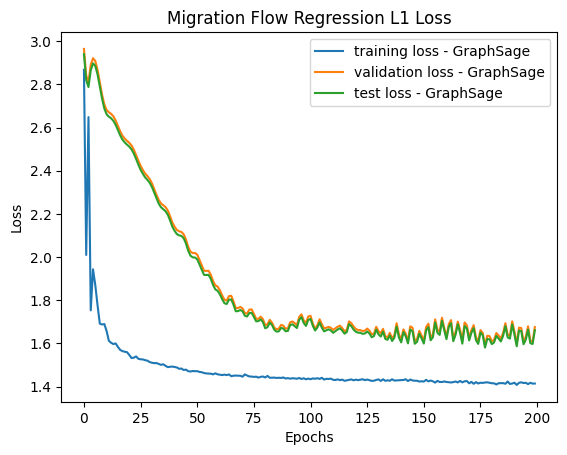

Running pipeline with config: Regression_GraphSage_simple_within_state


Training:   0%|          | 1/200 [00:00<00:40,  4.89Epochs/s]

Epoch 1: Training Loss 2.69383, Training R2 -1.4667 Validation Loss 2.95822 Validation R2 -1.35264


Training:   1%|          | 2/200 [00:00<00:41,  4.82Epochs/s]

Epoch 2: Training Loss 2.00542, Training R2 -0.1379 Validation Loss 2.87453 Validation R2 -1.15891


Training:   2%|▏         | 3/200 [00:00<00:42,  4.63Epochs/s]

Epoch 3: Training Loss 2.41301, Training R2 -0.87792 Validation Loss 2.83286 Validation R2 -1.05666


Training:   2%|▏         | 4/200 [00:00<00:41,  4.70Epochs/s]

Epoch 4: Training Loss 1.66704, Training R2 -0.01023 Validation Loss 2.8552 Validation R2 -1.10973


Training:   2%|▎         | 5/200 [00:01<00:40,  4.80Epochs/s]

Epoch 5: Training Loss 1.86123, Training R2 -0.09547 Validation Loss 2.88917 Validation R2 -1.2044
Epoch 6: Training Loss 1.8348, Training R2 -0.02855 Validation Loss 2.90006 Validation R2 -1.24605


Training:   4%|▎         | 7/200 [00:01<00:40,  4.81Epochs/s]

Epoch 7: Training Loss 1.69767, Training R2 0.08869 Validation Loss 2.89354 Validation R2 -1.24432


Training:   4%|▍         | 8/200 [00:01<00:40,  4.76Epochs/s]

Epoch 8: Training Loss 1.64037, Training R2 0.07722 Validation Loss 2.87679 Validation R2 -1.21473
Epoch 9: Training Loss 1.68868, Training R2 -0.03291 Validation Loss 2.8501 Validation R2 -1.15655


Training:   5%|▌         | 10/200 [00:02<00:38,  4.93Epochs/s]

Epoch 10: Training Loss 1.69426, Training R2 -0.056 Validation Loss 2.82037 Validation R2 -1.08719
Epoch 11: Training Loss 1.64111, Training R2 0.0086 Validation Loss 2.79457 Validation R2 -1.02467


Training:   6%|▌         | 12/200 [00:02<00:37,  4.96Epochs/s]

Epoch 12: Training Loss 1.58609, Training R2 0.09145 Validation Loss 2.77541 Validation R2 -0.97761


Training:   7%|▋         | 14/200 [00:02<00:34,  5.38Epochs/s]

Epoch 13: Training Loss 1.58729, Training R2 0.12426 Validation Loss 2.75844 Validation R2 -0.93796
Epoch 14: Training Loss 1.6166, Training R2 0.11119 Validation Loss 2.73685 Validation R2 -0.89224


Training:   8%|▊         | 15/200 [00:02<00:32,  5.74Epochs/s]

Epoch 15: Training Loss 1.62703, Training R2 0.09903 Validation Loss 2.70799 Validation R2 -0.8358
Epoch 16: Training Loss 1.60405, Training R2 0.10352 Validation Loss 2.67445 Validation R2 -0.77398


Training:   9%|▉         | 18/200 [00:03<00:30,  5.99Epochs/s]

Epoch 17: Training Loss 1.58625, Training R2 0.10376 Validation Loss 2.64295 Validation R2 -0.71904
Epoch 18: Training Loss 1.57174, Training R2 0.09626 Validation Loss 2.62034 Validation R2 -0.68155


Training:  10%|█         | 20/200 [00:03<00:28,  6.21Epochs/s]

Epoch 19: Training Loss 1.57153, Training R2 0.098 Validation Loss 2.60844 Validation R2 -0.6622
Epoch 20: Training Loss 1.56989, Training R2 0.10689 Validation Loss 2.60489 Validation R2 -0.65588


Training:  11%|█         | 22/200 [00:04<00:27,  6.44Epochs/s]

Epoch 21: Training Loss 1.55754, Training R2 0.13728 Validation Loss 2.60152 Validation R2 -0.64878
Epoch 22: Training Loss 1.5588, Training R2 0.15297 Validation Loss 2.59075 Validation R2 -0.62867


Training:  12%|█▏        | 24/200 [00:04<00:27,  6.51Epochs/s]

Epoch 23: Training Loss 1.57168, Training R2 0.15462 Validation Loss 2.56659 Validation R2 -0.58631
Epoch 24: Training Loss 1.57087, Training R2 0.15506 Validation Loss 2.52606 Validation R2 -0.51881


Training:  13%|█▎        | 26/200 [00:04<00:27,  6.37Epochs/s]

Epoch 25: Training Loss 1.55926, Training R2 0.15531 Validation Loss 2.47219 Validation R2 -0.43415
Epoch 26: Training Loss 1.54608, Training R2 0.14936 Validation Loss 2.41626 Validation R2 -0.35176


Training:  14%|█▍        | 28/200 [00:05<00:26,  6.59Epochs/s]

Epoch 27: Training Loss 1.54891, Training R2 0.12604 Validation Loss 2.3725 Validation R2 -0.29104
Epoch 28: Training Loss 1.54342, Training R2 0.1247 Validation Loss 2.34749 Validation R2 -0.25801


Training:  15%|█▌        | 30/200 [00:05<00:26,  6.54Epochs/s]

Epoch 29: Training Loss 1.5373, Training R2 0.13371 Validation Loss 2.33922 Validation R2 -0.24818
Epoch 30: Training Loss 1.52866, Training R2 0.15467 Validation Loss 2.33603 Validation R2 -0.24613


Training:  16%|█▌        | 31/200 [00:05<00:25,  6.57Epochs/s]

Epoch 31: Training Loss 1.53208, Training R2 0.16167 Validation Loss 2.32739 Validation R2 -0.23896
Epoch 32: Training Loss 1.53233, Training R2 0.17188 Validation Loss 2.3069 Validation R2 -0.21853


Training:  17%|█▋        | 34/200 [00:05<00:25,  6.51Epochs/s]

Epoch 33: Training Loss 1.52422, Training R2 0.18146 Validation Loss 2.27527 Validation R2 -0.18612
Epoch 34: Training Loss 1.52124, Training R2 0.17979 Validation Loss 2.23867 Validation R2 -0.14961


Training:  18%|█▊        | 36/200 [00:06<00:25,  6.54Epochs/s]

Epoch 35: Training Loss 1.51466, Training R2 0.17861 Validation Loss 2.20446 Validation R2 -0.11657
Epoch 36: Training Loss 1.51826, Training R2 0.17133 Validation Loss 2.1811 Validation R2 -0.09395


Training:  19%|█▉        | 38/200 [00:06<00:25,  6.47Epochs/s]

Epoch 37: Training Loss 1.5146, Training R2 0.17435 Validation Loss 2.16784 Validation R2 -0.07971
Epoch 38: Training Loss 1.50928, Training R2 0.18424 Validation Loss 2.15502 Validation R2 -0.06489


Training:  20%|██        | 40/200 [00:06<00:24,  6.44Epochs/s]

Epoch 39: Training Loss 1.50179, Training R2 0.20001 Validation Loss 2.12932 Validation R2 -0.03777
Epoch 40: Training Loss 1.49586, Training R2 0.20919 Validation Loss 2.08948 Validation R2 0.0


Training:  21%|██        | 42/200 [00:07<00:24,  6.55Epochs/s]

Epoch 41: Training Loss 1.49424, Training R2 0.2087 Validation Loss 2.04125 Validation R2 0.04122
Epoch 42: Training Loss 1.48915, Training R2 0.20583 Validation Loss 1.99943 Validation R2 0.07331


Training:  22%|██▏       | 44/200 [00:07<00:23,  6.52Epochs/s]

Epoch 43: Training Loss 1.49206, Training R2 0.19743 Validation Loss 1.97261 Validation R2 0.09179
Epoch 44: Training Loss 1.48855, Training R2 0.20199 Validation Loss 1.96321 Validation R2 0.09706


Training:  23%|██▎       | 46/200 [00:07<00:24,  6.36Epochs/s]

Epoch 45: Training Loss 1.48124, Training R2 0.21666 Validation Loss 1.95738 Validation R2 0.10012
Epoch 46: Training Loss 1.47716, Training R2 0.2261 Validation Loss 1.9513 Validation R2 0.10421


Training:  24%|██▍       | 48/200 [00:08<00:23,  6.37Epochs/s]

Epoch 47: Training Loss 1.47921, Training R2 0.23259 Validation Loss 1.9362 Validation R2 0.11543
Epoch 48: Training Loss 1.47715, Training R2 0.23769 Validation Loss 1.91009 Validation R2 0.13291


Training:  25%|██▌       | 50/200 [00:08<00:23,  6.37Epochs/s]

Epoch 49: Training Loss 1.4723, Training R2 0.23889 Validation Loss 1.87919 Validation R2 0.15156
Epoch 50: Training Loss 1.46894, Training R2 0.23159 Validation Loss 1.87054 Validation R2 0.15671


Training:  26%|██▌       | 52/200 [00:08<00:23,  6.35Epochs/s]

Epoch 51: Training Loss 1.47037, Training R2 0.22789 Validation Loss 1.89463 Validation R2 0.14239
Epoch 52: Training Loss 1.46477, Training R2 0.23891 Validation Loss 1.93222 Validation R2 0.11741


Training:  27%|██▋       | 54/200 [00:09<00:22,  6.56Epochs/s]

Epoch 53: Training Loss 1.471, Training R2 0.24567 Validation Loss 1.94495 Validation R2 0.10593
Epoch 54: Training Loss 1.46389, Training R2 0.25026 Validation Loss 1.93723 Validation R2 0.10867


Training:  28%|██▊       | 56/200 [00:09<00:21,  6.69Epochs/s]

Epoch 55: Training Loss 1.46088, Training R2 0.24569 Validation Loss 1.9376 Validation R2 0.10768
Epoch 56: Training Loss 1.46371, Training R2 0.24343 Validation Loss 1.94832 Validation R2 0.10047


Training:  29%|██▉       | 58/200 [00:09<00:21,  6.55Epochs/s]

Epoch 57: Training Loss 1.45557, Training R2 0.25064 Validation Loss 1.95054 Validation R2 0.09894
Epoch 58: Training Loss 1.46216, Training R2 0.24762 Validation Loss 1.92811 Validation R2 0.11441


Training:  30%|███       | 60/200 [00:09<00:20,  6.68Epochs/s]

Epoch 59: Training Loss 1.45674, Training R2 0.24287 Validation Loss 1.90118 Validation R2 0.13196
Epoch 60: Training Loss 1.45992, Training R2 0.24123 Validation Loss 1.88337 Validation R2 0.14277


Training:  31%|███       | 62/200 [00:10<00:20,  6.77Epochs/s]

Epoch 61: Training Loss 1.45794, Training R2 0.2429 Validation Loss 1.88203 Validation R2 0.14327
Epoch 62: Training Loss 1.45799, Training R2 0.2485 Validation Loss 1.88589 Validation R2 0.14064


Training:  32%|███▏      | 64/200 [00:10<00:20,  6.72Epochs/s]

Epoch 63: Training Loss 1.45638, Training R2 0.25249 Validation Loss 1.87193 Validation R2 0.14959
Epoch 64: Training Loss 1.45423, Training R2 0.25375 Validation Loss 1.83928 Validation R2 0.17001


Training:  33%|███▎      | 66/200 [00:10<00:20,  6.44Epochs/s]

Epoch 65: Training Loss 1.45357, Training R2 0.25064 Validation Loss 1.81862 Validation R2 0.18288
Epoch 66: Training Loss 1.45377, Training R2 0.25048 Validation Loss 1.80489 Validation R2 0.19184


Training:  34%|███▍      | 68/200 [00:11<00:20,  6.56Epochs/s]

Epoch 67: Training Loss 1.45393, Training R2 0.25014 Validation Loss 1.79567 Validation R2 0.19842
Epoch 68: Training Loss 1.45268, Training R2 0.25245 Validation Loss 1.77108 Validation R2 0.213


Training:  35%|███▌      | 70/200 [00:11<00:19,  6.56Epochs/s]

Epoch 69: Training Loss 1.45258, Training R2 0.25781 Validation Loss 1.72774 Validation R2 0.23624
Epoch 70: Training Loss 1.45053, Training R2 0.25377 Validation Loss 1.69261 Validation R2 0.25394


Training:  36%|███▌      | 72/200 [00:11<00:19,  6.42Epochs/s]

Epoch 71: Training Loss 1.45182, Training R2 0.25309 Validation Loss 1.67051 Validation R2 0.26459
Epoch 72: Training Loss 1.44887, Training R2 0.25448 Validation Loss 1.6665 Validation R2 0.26722


Training:  37%|███▋      | 74/200 [00:12<00:19,  6.63Epochs/s]

Epoch 73: Training Loss 1.44871, Training R2 0.25714 Validation Loss 1.65461 Validation R2 0.27266
Epoch 74: Training Loss 1.44739, Training R2 0.25704 Validation Loss 1.62169 Validation R2 0.28388


Training:  38%|███▊      | 76/200 [00:12<00:18,  6.60Epochs/s]

Epoch 75: Training Loss 1.44992, Training R2 0.2517 Validation Loss 1.61863 Validation R2 0.2851
Epoch 76: Training Loss 1.4487, Training R2 0.25604 Validation Loss 1.63783 Validation R2 0.27959


Training:  38%|███▊      | 77/200 [00:12<00:18,  6.56Epochs/s]

Epoch 77: Training Loss 1.44847, Training R2 0.25698 Validation Loss 1.65899 Validation R2 0.27174
Epoch 78: Training Loss 1.44708, Training R2 0.26105 Validation Loss 1.63356 Validation R2 0.28099


Training:  40%|███▉      | 79/200 [00:12<00:21,  5.65Epochs/s]

Epoch 79: Training Loss 1.4508, Training R2 0.24901 Validation Loss 1.61889 Validation R2 0.28577


Training:  40%|████      | 80/200 [00:13<00:22,  5.22Epochs/s]

Epoch 80: Training Loss 1.44692, Training R2 0.25382 Validation Loss 1.62406 Validation R2 0.2844


Training:  40%|████      | 81/200 [00:13<00:23,  5.13Epochs/s]

Epoch 81: Training Loss 1.44722, Training R2 0.25408 Validation Loss 1.63483 Validation R2 0.28085


Training:  41%|████      | 82/200 [00:13<00:23,  4.96Epochs/s]

Epoch 82: Training Loss 1.44842, Training R2 0.25603 Validation Loss 1.61473 Validation R2 0.28709


Training:  42%|████▏     | 83/200 [00:13<00:23,  4.93Epochs/s]

Epoch 83: Training Loss 1.44846, Training R2 0.25444 Validation Loss 1.58805 Validation R2 0.29253


Training:  42%|████▏     | 84/200 [00:14<00:23,  4.87Epochs/s]

Epoch 84: Training Loss 1.44873, Training R2 0.25097 Validation Loss 1.59602 Validation R2 0.29111


Training:  42%|████▎     | 85/200 [00:14<00:23,  4.84Epochs/s]

Epoch 85: Training Loss 1.44924, Training R2 0.2567 Validation Loss 1.60781 Validation R2 0.28866


Training:  43%|████▎     | 86/200 [00:14<00:23,  4.84Epochs/s]

Epoch 86: Training Loss 1.44655, Training R2 0.26045 Validation Loss 1.5923 Validation R2 0.29252


Training:  44%|████▎     | 87/200 [00:14<00:23,  4.75Epochs/s]

Epoch 87: Training Loss 1.44297, Training R2 0.25786 Validation Loss 1.58215 Validation R2 0.29431


Training:  44%|████▍     | 88/200 [00:14<00:23,  4.78Epochs/s]

Epoch 88: Training Loss 1.44664, Training R2 0.24975 Validation Loss 1.58123 Validation R2 0.29451


Training:  44%|████▍     | 89/200 [00:15<00:23,  4.75Epochs/s]

Epoch 89: Training Loss 1.44661, Training R2 0.25456 Validation Loss 1.56841 Validation R2 0.29389


Training:  45%|████▌     | 90/200 [00:15<00:23,  4.77Epochs/s]

Epoch 90: Training Loss 1.44614, Training R2 0.25369 Validation Loss 1.57197 Validation R2 0.29467


Training:  46%|████▌     | 91/200 [00:15<00:22,  4.79Epochs/s]

Epoch 91: Training Loss 1.44431, Training R2 0.25745 Validation Loss 1.58069 Validation R2 0.29496


Training:  46%|████▌     | 92/200 [00:15<00:23,  4.65Epochs/s]

Epoch 92: Training Loss 1.4431, Training R2 0.26587 Validation Loss 1.56216 Validation R2 0.29336


Training:  46%|████▋     | 93/200 [00:15<00:22,  4.67Epochs/s]

Epoch 93: Training Loss 1.44815, Training R2 0.25313 Validation Loss 1.55729 Validation R2 0.28595


Training:  47%|████▋     | 94/200 [00:16<00:22,  4.63Epochs/s]

Epoch 94: Training Loss 1.44873, Training R2 0.24345 Validation Loss 1.56616 Validation R2 0.29534


Training:  48%|████▊     | 95/200 [00:16<00:22,  4.62Epochs/s]

Epoch 95: Training Loss 1.44737, Training R2 0.25226 Validation Loss 1.58125 Validation R2 0.29553


Training:  48%|████▊     | 96/200 [00:16<00:22,  4.71Epochs/s]

Epoch 96: Training Loss 1.45122, Training R2 0.25891 Validation Loss 1.55988 Validation R2 0.29144


Training:  48%|████▊     | 97/200 [00:16<00:21,  4.68Epochs/s]

Epoch 97: Training Loss 1.44119, Training R2 0.26129 Validation Loss 1.56422 Validation R2 0.272


Training:  49%|████▉     | 98/200 [00:16<00:21,  4.66Epochs/s]

Epoch 98: Training Loss 1.44588, Training R2 0.24794 Validation Loss 1.55888 Validation R2 0.28947


Training:  50%|████▉     | 99/200 [00:17<00:21,  4.61Epochs/s]

Epoch 99: Training Loss 1.44131, Training R2 0.25726 Validation Loss 1.58012 Validation R2 0.29554


Training:  50%|█████     | 100/200 [00:17<00:21,  4.59Epochs/s]

Epoch 100: Training Loss 1.44686, Training R2 0.26134 Validation Loss 1.55824 Validation R2 0.29081


Training:  50%|█████     | 101/200 [00:17<00:21,  4.53Epochs/s]

Epoch 101: Training Loss 1.43977, Training R2 0.2602 Validation Loss 1.56292 Validation R2 0.26849


Training:  51%|█████     | 102/200 [00:17<00:21,  4.60Epochs/s]

Epoch 102: Training Loss 1.44058, Training R2 0.25226 Validation Loss 1.55885 Validation R2 0.27256


Training:  52%|█████▏    | 104/200 [00:18<00:19,  5.02Epochs/s]

Epoch 103: Training Loss 1.44351, Training R2 0.25233 Validation Loss 1.55499 Validation R2 0.28847
Epoch 104: Training Loss 1.44595, Training R2 0.26048 Validation Loss 1.55342 Validation R2 0.28448


Training:  53%|█████▎    | 106/200 [00:18<00:16,  5.77Epochs/s]

Epoch 105: Training Loss 1.44361, Training R2 0.26027 Validation Loss 1.5647 Validation R2 0.261
Epoch 106: Training Loss 1.44546, Training R2 0.25375 Validation Loss 1.57678 Validation R2 0.24654


Training:  54%|█████▍    | 108/200 [00:18<00:14,  6.18Epochs/s]

Epoch 107: Training Loss 1.44159, Training R2 0.25059 Validation Loss 1.55304 Validation R2 0.28165
Epoch 108: Training Loss 1.44328, Training R2 0.26037 Validation Loss 1.55272 Validation R2 0.28057


Training:  55%|█████▌    | 110/200 [00:19<00:14,  6.31Epochs/s]

Epoch 109: Training Loss 1.44412, Training R2 0.26106 Validation Loss 1.57335 Validation R2 0.24944
Epoch 110: Training Loss 1.44094, Training R2 0.25164 Validation Loss 1.56228 Validation R2 0.26359


Training:  56%|█████▌    | 112/200 [00:19<00:13,  6.48Epochs/s]

Epoch 111: Training Loss 1.43971, Training R2 0.25409 Validation Loss 1.55277 Validation R2 0.28682
Epoch 112: Training Loss 1.44249, Training R2 0.26338 Validation Loss 1.55359 Validation R2 0.28605


Training:  57%|█████▋    | 114/200 [00:19<00:13,  6.41Epochs/s]

Epoch 113: Training Loss 1.43882, Training R2 0.26288 Validation Loss 1.57581 Validation R2 0.25314
Epoch 114: Training Loss 1.43893, Training R2 0.257 Validation Loss 1.56275 Validation R2 0.2692


Training:  58%|█████▊    | 116/200 [00:20<00:12,  6.55Epochs/s]

Epoch 115: Training Loss 1.43951, Training R2 0.25633 Validation Loss 1.56491 Validation R2 0.29614
Epoch 116: Training Loss 1.44664, Training R2 0.26421 Validation Loss 1.55206 Validation R2 0.28815


Training:  59%|█████▉    | 118/200 [00:20<00:12,  6.59Epochs/s]

Epoch 117: Training Loss 1.43905, Training R2 0.26048 Validation Loss 1.57789 Validation R2 0.24809
Epoch 118: Training Loss 1.44092, Training R2 0.24847 Validation Loss 1.5624 Validation R2 0.26742


Training:  60%|██████    | 120/200 [00:20<00:12,  6.62Epochs/s]

Epoch 119: Training Loss 1.43709, Training R2 0.25695 Validation Loss 1.55439 Validation R2 0.28999
Epoch 120: Training Loss 1.44429, Training R2 0.26476 Validation Loss 1.55555 Validation R2 0.27722


Training:  61%|██████    | 122/200 [00:20<00:11,  6.62Epochs/s]

Epoch 121: Training Loss 1.43892, Training R2 0.26298 Validation Loss 1.57274 Validation R2 0.25255
Epoch 122: Training Loss 1.43692, Training R2 0.25422 Validation Loss 1.5557 Validation R2 0.27371


Training:  62%|██████▏   | 124/200 [00:21<00:11,  6.47Epochs/s]

Epoch 123: Training Loss 1.43872, Training R2 0.25481 Validation Loss 1.56217 Validation R2 0.29497
Epoch 124: Training Loss 1.44327, Training R2 0.25833 Validation Loss 1.5576 Validation R2 0.29477


Training:  63%|██████▎   | 126/200 [00:21<00:11,  6.40Epochs/s]

Epoch 125: Training Loss 1.43568, Training R2 0.26431 Validation Loss 1.55175 Validation R2 0.28415
Epoch 126: Training Loss 1.43923, Training R2 0.25288 Validation Loss 1.55488 Validation R2 0.29046


Training:  64%|██████▍   | 128/200 [00:21<00:11,  6.06Epochs/s]

Epoch 127: Training Loss 1.43948, Training R2 0.25582 Validation Loss 1.61308 Validation R2 0.28773
Epoch 128: Training Loss 1.44331, Training R2 0.26468 Validation Loss 1.59619 Validation R2 0.29174


Training:  65%|██████▌   | 130/200 [00:22<00:11,  6.32Epochs/s]

Epoch 129: Training Loss 1.43981, Training R2 0.2606 Validation Loss 1.56461 Validation R2 0.29449
Epoch 130: Training Loss 1.44033, Training R2 0.24798 Validation Loss 1.61223 Validation R2 0.28729


Training:  66%|██████▌   | 132/200 [00:22<00:10,  6.38Epochs/s]

Epoch 131: Training Loss 1.43409, Training R2 0.25855 Validation Loss 1.64291 Validation R2 0.27757
Epoch 132: Training Loss 1.44087, Training R2 0.2607 Validation Loss 1.59468 Validation R2 0.29112


Training:  67%|██████▋   | 134/200 [00:22<00:10,  6.49Epochs/s]

Epoch 133: Training Loss 1.43526, Training R2 0.25938 Validation Loss 1.57577 Validation R2 0.29347
Epoch 134: Training Loss 1.43742, Training R2 0.25894 Validation Loss 1.60237 Validation R2 0.29004


Training:  68%|██████▊   | 136/200 [00:23<00:09,  6.49Epochs/s]

Epoch 135: Training Loss 1.43333, Training R2 0.26247 Validation Loss 1.617 Validation R2 0.28644
Epoch 136: Training Loss 1.43714, Training R2 0.26226 Validation Loss 1.58802 Validation R2 0.29303


Training:  69%|██████▉   | 138/200 [00:23<00:09,  6.35Epochs/s]

Epoch 137: Training Loss 1.43491, Training R2 0.25999 Validation Loss 1.5972 Validation R2 0.29099
Epoch 138: Training Loss 1.43778, Training R2 0.25776 Validation Loss 1.62169 Validation R2 0.2846


Training:  70%|███████   | 140/200 [00:23<00:09,  6.15Epochs/s]

Epoch 139: Training Loss 1.43317, Training R2 0.26224 Validation Loss 1.66816 Validation R2 0.26834
Epoch 140: Training Loss 1.43868, Training R2 0.26099 Validation Loss 1.62894 Validation R2 0.28163


Training:  71%|███████   | 142/200 [00:24<00:09,  6.36Epochs/s]

Epoch 141: Training Loss 1.42927, Training R2 0.26297 Validation Loss 1.6234 Validation R2 0.28291
Epoch 142: Training Loss 1.43325, Training R2 0.26033 Validation Loss 1.67265 Validation R2 0.2652


Training:  72%|███████▏  | 144/200 [00:24<00:08,  6.46Epochs/s]

Epoch 143: Training Loss 1.43481, Training R2 0.262 Validation Loss 1.64771 Validation R2 0.27347
Epoch 144: Training Loss 1.43642, Training R2 0.25763 Validation Loss 1.64583 Validation R2 0.27361


Training:  73%|███████▎  | 146/200 [00:24<00:08,  6.25Epochs/s]

Epoch 145: Training Loss 1.43279, Training R2 0.26171 Validation Loss 1.6589 Validation R2 0.26915
Epoch 146: Training Loss 1.43277, Training R2 0.26274 Validation Loss 1.64477 Validation R2 0.27422


Training:  74%|███████▍  | 148/200 [00:25<00:08,  6.45Epochs/s]

Epoch 147: Training Loss 1.43171, Training R2 0.26473 Validation Loss 1.6508 Validation R2 0.2728
Epoch 148: Training Loss 1.43498, Training R2 0.25986 Validation Loss 1.70202 Validation R2 0.25273


Training:  75%|███████▌  | 150/200 [00:25<00:07,  6.36Epochs/s]

Epoch 149: Training Loss 1.43582, Training R2 0.2613 Validation Loss 1.66165 Validation R2 0.26845
Epoch 150: Training Loss 1.43265, Training R2 0.26022 Validation Loss 1.60336 Validation R2 0.28726


Training:  76%|███████▌  | 151/200 [00:25<00:07,  6.26Epochs/s]

Epoch 151: Training Loss 1.4346, Training R2 0.25416 Validation Loss 1.6562 Validation R2 0.2698
Epoch 152: Training Loss 1.4308, Training R2 0.26735 Validation Loss 1.62077 Validation R2 0.28175


Training:  77%|███████▋  | 154/200 [00:26<00:07,  6.31Epochs/s]

Epoch 153: Training Loss 1.43184, Training R2 0.2659 Validation Loss 1.59009 Validation R2 0.29007
Epoch 154: Training Loss 1.43181, Training R2 0.25998 Validation Loss 1.5948 Validation R2 0.28859


Training:  78%|███████▊  | 156/200 [00:26<00:06,  6.32Epochs/s]

Epoch 155: Training Loss 1.43344, Training R2 0.25884 Validation Loss 1.62462 Validation R2 0.2792
Epoch 156: Training Loss 1.43458, Training R2 0.26291 Validation Loss 1.5648 Validation R2 0.29094


Training:  79%|███████▉  | 158/200 [00:26<00:06,  6.14Epochs/s]

Epoch 157: Training Loss 1.43627, Training R2 0.25805 Validation Loss 1.57698 Validation R2 0.28851
Epoch 158: Training Loss 1.42986, Training R2 0.26474 Validation Loss 1.5914 Validation R2 0.28516


Training:  80%|████████  | 160/200 [00:27<00:06,  6.43Epochs/s]

Epoch 159: Training Loss 1.43346, Training R2 0.26518 Validation Loss 1.55615 Validation R2 0.28532
Epoch 160: Training Loss 1.43818, Training R2 0.25475 Validation Loss 1.57441 Validation R2 0.28691


Training:  81%|████████  | 162/200 [00:27<00:05,  6.59Epochs/s]

Epoch 161: Training Loss 1.42963, Training R2 0.26616 Validation Loss 1.5679 Validation R2 0.28808
Epoch 162: Training Loss 1.43061, Training R2 0.26899 Validation Loss 1.54962 Validation R2 0.27909


Training:  82%|████████▏ | 164/200 [00:27<00:05,  6.25Epochs/s]

Epoch 163: Training Loss 1.43603, Training R2 0.25475 Validation Loss 1.57388 Validation R2 0.28682
Epoch 164: Training Loss 1.4328, Training R2 0.26368 Validation Loss 1.60358 Validation R2 0.28233


Training:  83%|████████▎ | 166/200 [00:27<00:05,  6.34Epochs/s]

Epoch 165: Training Loss 1.43648, Training R2 0.2651 Validation Loss 1.5588 Validation R2 0.28383
Epoch 166: Training Loss 1.43165, Training R2 0.25987 Validation Loss 1.55761 Validation R2 0.28187


Training:  84%|████████▎ | 167/200 [00:28<00:05,  6.29Epochs/s]

Epoch 167: Training Loss 1.43179, Training R2 0.25717 Validation Loss 1.61717 Validation R2 0.27817


Training:  84%|████████▍ | 168/200 [00:28<00:05,  5.76Epochs/s]

Epoch 168: Training Loss 1.43438, Training R2 0.2692 Validation Loss 1.57635 Validation R2 0.28349


Training:  84%|████████▍ | 169/200 [00:28<00:05,  5.40Epochs/s]

Epoch 169: Training Loss 1.42795, Training R2 0.26492 Validation Loss 1.56802 Validation R2 0.28257


Training:  85%|████████▌ | 170/200 [00:28<00:06,  4.92Epochs/s]

Epoch 170: Training Loss 1.43189, Training R2 0.26161 Validation Loss 1.61801 Validation R2 0.277


Training:  86%|████████▌ | 171/200 [00:29<00:06,  4.75Epochs/s]

Epoch 171: Training Loss 1.43236, Training R2 0.26757 Validation Loss 1.58951 Validation R2 0.28187


Training:  86%|████████▌ | 172/200 [00:29<00:05,  4.76Epochs/s]

Epoch 172: Training Loss 1.42973, Training R2 0.26624 Validation Loss 1.56159 Validation R2 0.27999
Epoch 173: Training Loss 1.43168, Training R2 0.25637 Validation Loss 1.58935 Validation R2 0.28226


Training:  87%|████████▋ | 174/200 [00:29<00:05,  4.66Epochs/s]

Epoch 174: Training Loss 1.42997, Training R2 0.26881 Validation Loss 1.59213 Validation R2 0.28355


Training:  88%|████████▊ | 175/200 [00:29<00:05,  4.55Epochs/s]

Epoch 175: Training Loss 1.42904, Training R2 0.26686 Validation Loss 1.56567 Validation R2 0.28843


Training:  88%|████████▊ | 176/200 [00:30<00:05,  4.61Epochs/s]

Epoch 176: Training Loss 1.42994, Training R2 0.25957 Validation Loss 1.56739 Validation R2 0.29149


Training:  88%|████████▊ | 177/200 [00:30<00:04,  4.62Epochs/s]

Epoch 177: Training Loss 1.4297, Training R2 0.26453 Validation Loss 1.58787 Validation R2 0.29059


Training:  89%|████████▉ | 178/200 [00:30<00:04,  4.66Epochs/s]

Epoch 178: Training Loss 1.42792, Training R2 0.2716 Validation Loss 1.55813 Validation R2 0.29139


Training:  90%|████████▉ | 179/200 [00:30<00:04,  4.59Epochs/s]

Epoch 179: Training Loss 1.42783, Training R2 0.26518 Validation Loss 1.57559 Validation R2 0.29467


Training:  90%|█████████ | 180/200 [00:30<00:04,  4.66Epochs/s]

Epoch 180: Training Loss 1.42888, Training R2 0.26973 Validation Loss 1.54999 Validation R2 0.28944


Training:  90%|█████████ | 181/200 [00:31<00:04,  4.58Epochs/s]

Epoch 181: Training Loss 1.42762, Training R2 0.26369 Validation Loss 1.5549 Validation R2 0.29689


Training:  91%|█████████ | 182/200 [00:31<00:04,  4.47Epochs/s]

Epoch 182: Training Loss 1.42542, Training R2 0.26528 Validation Loss 1.59384 Validation R2 0.29524


Training:  92%|█████████▏| 183/200 [00:31<00:03,  4.31Epochs/s]

Epoch 183: Training Loss 1.42879, Training R2 0.26981 Validation Loss 1.55459 Validation R2 0.29557


Training:  92%|█████████▏| 184/200 [00:31<00:03,  4.28Epochs/s]

Epoch 184: Training Loss 1.43311, Training R2 0.25858 Validation Loss 1.58202 Validation R2 0.29777


Training:  92%|█████████▎| 185/200 [00:32<00:03,  4.33Epochs/s]

Epoch 185: Training Loss 1.42481, Training R2 0.27093 Validation Loss 1.56309 Validation R2 0.30024


Training:  93%|█████████▎| 186/200 [00:32<00:03,  4.51Epochs/s]

Epoch 186: Training Loss 1.42679, Training R2 0.26744 Validation Loss 1.56188 Validation R2 0.27714


Training:  94%|█████████▎| 187/200 [00:32<00:02,  4.56Epochs/s]

Epoch 187: Training Loss 1.43231, Training R2 0.25162 Validation Loss 1.60992 Validation R2 0.29017


Training:  94%|█████████▍| 188/200 [00:32<00:02,  4.51Epochs/s]

Epoch 188: Training Loss 1.43776, Training R2 0.26836 Validation Loss 1.5561 Validation R2 0.29082
Epoch 189: Training Loss 1.42678, Training R2 0.26661 Validation Loss 1.56289 Validation R2 0.27982


Training:  95%|█████████▌| 190/200 [00:33<00:02,  4.70Epochs/s]

Epoch 190: Training Loss 1.43198, Training R2 0.26019 Validation Loss 1.59988 Validation R2 0.29273


Training:  96%|█████████▌| 191/200 [00:33<00:01,  4.65Epochs/s]

Epoch 191: Training Loss 1.42858, Training R2 0.27399 Validation Loss 1.58572 Validation R2 0.29664


Training:  96%|█████████▌| 192/200 [00:33<00:01,  4.68Epochs/s]

Epoch 192: Training Loss 1.42949, Training R2 0.26282 Validation Loss 1.59535 Validation R2 0.29498


Training:  96%|█████████▋| 193/200 [00:33<00:01,  4.69Epochs/s]

Epoch 193: Training Loss 1.43035, Training R2 0.25268 Validation Loss 1.66094 Validation R2 0.27079


Training:  97%|█████████▋| 194/200 [00:34<00:01,  4.60Epochs/s]

Epoch 194: Training Loss 1.43578, Training R2 0.26728 Validation Loss 1.60886 Validation R2 0.29226
Epoch 195: Training Loss 1.42818, Training R2 0.26658 Validation Loss 1.61148 Validation R2 0.29039


Training:  98%|█████████▊| 197/200 [00:34<00:00,  5.60Epochs/s]

Epoch 196: Training Loss 1.4294, Training R2 0.26367 Validation Loss 1.64581 Validation R2 0.27554
Epoch 197: Training Loss 1.42833, Training R2 0.27196 Validation Loss 1.65754 Validation R2 0.27154


Training: 100%|█████████▉| 199/200 [00:34<00:00,  5.76Epochs/s]

Epoch 198: Training Loss 1.42996, Training R2 0.26297 Validation Loss 1.64451 Validation R2 0.27303
Epoch 199: Training Loss 1.43286, Training R2 0.25289 Validation Loss 1.62416 Validation R2 0.28185


Training: 100%|██████████| 200/200 [00:35<00:00,  5.71Epochs/s]


Epoch 200: Training Loss 1.4253, Training R2 0.27592 Validation Loss 1.62031 Validation R2 0.28078
Saving Model Predictions for Model Type GraphSage
Model saved successfully as Regression_GraphSage_simple_within_state
Minimum validation loss: 1.5496177673339844
Minimum test loss: 1.557656168937683
Best test metric: 0.25201958417892456


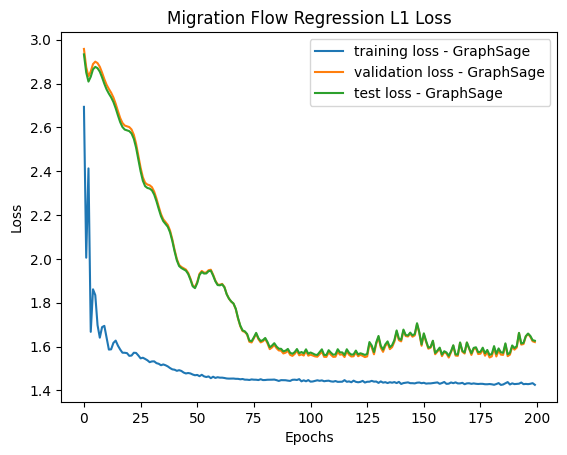

Running pipeline with config: Classification_GraphSage_full_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 1.63825, Training F1 Score (Micro) 0.19288 Validation Loss 1.53108 Validation F1 Score (Micro) 0.47818


Training:   0%|          | 1/200 [00:01<05:00,  1.51s/Epochs]

Epoch 2: Training Loss 1.3815, Training F1 Score (Micro) 0.47539 Validation Loss 1.50182 Validation F1 Score (Micro) 0.47818


Training:   1%|          | 2/200 [00:03<04:58,  1.51s/Epochs]

Epoch 3: Training Loss 1.39915, Training F1 Score (Micro) 0.44761 Validation Loss 1.49545 Validation F1 Score (Micro) 0.47818


Training:   2%|▏         | 3/200 [00:04<04:55,  1.50s/Epochs]

Epoch 4: Training Loss 1.35018, Training F1 Score (Micro) 0.47702 Validation Loss 1.49486 Validation F1 Score (Micro) 0.47818


Training:   2%|▏         | 4/200 [00:05<04:48,  1.47s/Epochs]

Epoch 5: Training Loss 1.32635, Training F1 Score (Micro) 0.47553 Validation Loss 1.49696 Validation F1 Score (Micro) 0.47818


Training:   2%|▎         | 5/200 [00:07<04:52,  1.50s/Epochs]

Epoch 6: Training Loss 1.32184, Training F1 Score (Micro) 0.47818 Validation Loss 1.49504 Validation F1 Score (Micro) 0.47818


Training:   3%|▎         | 6/200 [00:09<05:21,  1.66s/Epochs]

Epoch 7: Training Loss 1.315, Training F1 Score (Micro) 0.49001 Validation Loss 1.48595 Validation F1 Score (Micro) 0.47818


Training:   4%|▎         | 7/200 [00:11<05:39,  1.76s/Epochs]

Epoch 8: Training Loss 1.30359, Training F1 Score (Micro) 0.49217 Validation Loss 1.47514 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 8/200 [00:12<05:18,  1.66s/Epochs]

Epoch 9: Training Loss 1.29875, Training F1 Score (Micro) 0.49357 Validation Loss 1.47165 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 9/200 [00:14<05:03,  1.59s/Epochs]

Epoch 10: Training Loss 1.29906, Training F1 Score (Micro) 0.49343 Validation Loss 1.47712 Validation F1 Score (Micro) 0.47818


Training:   5%|▌         | 10/200 [00:15<04:53,  1.54s/Epochs]

Epoch 11: Training Loss 1.29542, Training F1 Score (Micro) 0.49561 Validation Loss 1.48422 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 11/200 [00:17<04:45,  1.51s/Epochs]

Epoch 12: Training Loss 1.29458, Training F1 Score (Micro) 0.4953 Validation Loss 1.48558 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 12/200 [00:18<04:37,  1.48s/Epochs]

Epoch 13: Training Loss 1.29213, Training F1 Score (Micro) 0.49647 Validation Loss 1.47947 Validation F1 Score (Micro) 0.47818


Training:   6%|▋         | 13/200 [00:19<04:33,  1.46s/Epochs]

Epoch 14: Training Loss 1.28805, Training F1 Score (Micro) 0.49505 Validation Loss 1.46724 Validation F1 Score (Micro) 0.47818


Training:   7%|▋         | 14/200 [00:21<04:32,  1.47s/Epochs]

Epoch 15: Training Loss 1.28531, Training F1 Score (Micro) 0.4937 Validation Loss 1.45434 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 15/200 [00:23<05:02,  1.63s/Epochs]

Epoch 16: Training Loss 1.28687, Training F1 Score (Micro) 0.49317 Validation Loss 1.44696 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 16/200 [00:25<05:22,  1.75s/Epochs]

Epoch 17: Training Loss 1.28349, Training F1 Score (Micro) 0.49632 Validation Loss 1.44345 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 17/200 [00:27<05:09,  1.69s/Epochs]

Epoch 18: Training Loss 1.28196, Training F1 Score (Micro) 0.49813 Validation Loss 1.4386 Validation F1 Score (Micro) 0.47818


Training:   9%|▉         | 18/200 [00:28<04:55,  1.63s/Epochs]

Epoch 19: Training Loss 1.28033, Training F1 Score (Micro) 0.49749 Validation Loss 1.42808 Validation F1 Score (Micro) 0.47818


Training:  10%|▉         | 19/200 [00:29<04:44,  1.57s/Epochs]

Epoch 20: Training Loss 1.27917, Training F1 Score (Micro) 0.49767 Validation Loss 1.41246 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 20/200 [00:31<04:36,  1.53s/Epochs]

Epoch 21: Training Loss 1.27712, Training F1 Score (Micro) 0.49921 Validation Loss 1.39647 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 21/200 [00:32<04:31,  1.52s/Epochs]

Epoch 22: Training Loss 1.27642, Training F1 Score (Micro) 0.49742 Validation Loss 1.38571 Validation F1 Score (Micro) 0.47818


Training:  11%|█         | 22/200 [00:34<04:24,  1.48s/Epochs]

Epoch 23: Training Loss 1.27555, Training F1 Score (Micro) 0.49885 Validation Loss 1.38095 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 23/200 [00:35<04:24,  1.49s/Epochs]

Epoch 24: Training Loss 1.27365, Training F1 Score (Micro) 0.50073 Validation Loss 1.37892 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 24/200 [00:37<04:46,  1.63s/Epochs]

Epoch 25: Training Loss 1.2744, Training F1 Score (Micro) 0.4997 Validation Loss 1.37199 Validation F1 Score (Micro) 0.47818


Training:  12%|█▎        | 25/200 [00:39<05:02,  1.73s/Epochs]

Epoch 26: Training Loss 1.27325, Training F1 Score (Micro) 0.4998 Validation Loss 1.35777 Validation F1 Score (Micro) 0.47818


Training:  13%|█▎        | 26/200 [00:41<04:52,  1.68s/Epochs]

Epoch 27: Training Loss 1.27135, Training F1 Score (Micro) 0.50022 Validation Loss 1.34234 Validation F1 Score (Micro) 0.47818


Training:  14%|█▎        | 27/200 [00:42<04:38,  1.61s/Epochs]

Epoch 28: Training Loss 1.26968, Training F1 Score (Micro) 0.50018 Validation Loss 1.33113 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 28/200 [00:44<04:26,  1.55s/Epochs]

Epoch 29: Training Loss 1.27098, Training F1 Score (Micro) 0.49979 Validation Loss 1.32811 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 29/200 [00:45<04:16,  1.50s/Epochs]

Epoch 30: Training Loss 1.26995, Training F1 Score (Micro) 0.49982 Validation Loss 1.32575 Validation F1 Score (Micro) 0.48082


Training:  15%|█▌        | 30/200 [00:46<04:10,  1.48s/Epochs]

Epoch 31: Training Loss 1.26945, Training F1 Score (Micro) 0.49831 Validation Loss 1.3189 Validation F1 Score (Micro) 0.47937


Training:  16%|█▌        | 31/200 [00:48<04:06,  1.46s/Epochs]

Epoch 32: Training Loss 1.26922, Training F1 Score (Micro) 0.49892 Validation Loss 1.30935 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 32/200 [00:49<03:53,  1.39s/Epochs]

Epoch 33: Training Loss 1.26787, Training F1 Score (Micro) 0.49953 Validation Loss 1.30146 Validation F1 Score (Micro) 0.47818


Training:  16%|█▋        | 33/200 [00:51<03:53,  1.40s/Epochs]

Epoch 34: Training Loss 1.26676, Training F1 Score (Micro) 0.50019 Validation Loss 1.29743 Validation F1 Score (Micro) 0.47818


Training:  17%|█▋        | 34/200 [00:52<04:12,  1.52s/Epochs]

Epoch 35: Training Loss 1.26764, Training F1 Score (Micro) 0.50047 Validation Loss 1.29532 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 35/200 [00:54<04:26,  1.62s/Epochs]

Epoch 36: Training Loss 1.26615, Training F1 Score (Micro) 0.49988 Validation Loss 1.29323 Validation F1 Score (Micro) 0.47918


Training:  18%|█▊        | 36/200 [00:56<04:14,  1.55s/Epochs]

Epoch 37: Training Loss 1.2664, Training F1 Score (Micro) 0.49914 Validation Loss 1.28832 Validation F1 Score (Micro) 0.47975


Training:  18%|█▊        | 37/200 [00:57<04:05,  1.50s/Epochs]

Epoch 38: Training Loss 1.26539, Training F1 Score (Micro) 0.49876 Validation Loss 1.28374 Validation F1 Score (Micro) 0.4783


Training:  19%|█▉        | 38/200 [00:58<03:57,  1.47s/Epochs]

Epoch 39: Training Loss 1.26582, Training F1 Score (Micro) 0.49928 Validation Loss 1.28256 Validation F1 Score (Micro) 0.47818


Training:  20%|█▉        | 39/200 [01:00<03:53,  1.45s/Epochs]

Epoch 40: Training Loss 1.26538, Training F1 Score (Micro) 0.4995 Validation Loss 1.28137 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 40/200 [01:01<03:50,  1.44s/Epochs]

Epoch 41: Training Loss 1.26458, Training F1 Score (Micro) 0.49982 Validation Loss 1.27753 Validation F1 Score (Micro) 0.48196


Training:  20%|██        | 41/200 [01:03<03:46,  1.42s/Epochs]

Epoch 42: Training Loss 1.26491, Training F1 Score (Micro) 0.4996 Validation Loss 1.27622 Validation F1 Score (Micro) 0.48196


Training:  21%|██        | 42/200 [01:04<03:43,  1.42s/Epochs]

Epoch 43: Training Loss 1.26489, Training F1 Score (Micro) 0.499 Validation Loss 1.27896 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 43/200 [01:06<04:03,  1.55s/Epochs]

Epoch 44: Training Loss 1.26459, Training F1 Score (Micro) 0.49951 Validation Loss 1.27744 Validation F1 Score (Micro) 0.47843


Training:  22%|██▏       | 44/200 [01:08<04:21,  1.68s/Epochs]

Epoch 45: Training Loss 1.2639, Training F1 Score (Micro) 0.49996 Validation Loss 1.272 Validation F1 Score (Micro) 0.48498


Training:  22%|██▎       | 45/200 [01:09<04:12,  1.63s/Epochs]

Epoch 46: Training Loss 1.26373, Training F1 Score (Micro) 0.49946 Validation Loss 1.26973 Validation F1 Score (Micro) 0.49115


Training:  23%|██▎       | 46/200 [01:11<04:02,  1.57s/Epochs]

Epoch 47: Training Loss 1.2636, Training F1 Score (Micro) 0.4996 Validation Loss 1.27399 Validation F1 Score (Micro) 0.48296


Training:  24%|██▎       | 47/200 [01:12<03:52,  1.52s/Epochs]

Epoch 48: Training Loss 1.26317, Training F1 Score (Micro) 0.50036 Validation Loss 1.27517 Validation F1 Score (Micro) 0.48315


Training:  24%|██▍       | 48/200 [01:14<03:46,  1.49s/Epochs]

Epoch 49: Training Loss 1.26298, Training F1 Score (Micro) 0.50086 Validation Loss 1.27144 Validation F1 Score (Micro) 0.49071


Training:  24%|██▍       | 49/200 [01:15<03:42,  1.47s/Epochs]

Epoch 50: Training Loss 1.26257, Training F1 Score (Micro) 0.50026 Validation Loss 1.26866 Validation F1 Score (Micro) 0.49474


Training:  25%|██▌       | 50/200 [01:16<03:39,  1.46s/Epochs]

Epoch 51: Training Loss 1.26283, Training F1 Score (Micro) 0.50078 Validation Loss 1.2695 Validation F1 Score (Micro) 0.49417


Training:  26%|██▌       | 51/200 [01:18<03:34,  1.44s/Epochs]

Epoch 52: Training Loss 1.26274, Training F1 Score (Micro) 0.50089 Validation Loss 1.26745 Validation F1 Score (Micro) 0.49619


Training:  26%|██▌       | 52/200 [01:20<03:52,  1.57s/Epochs]

Epoch 53: Training Loss 1.26254, Training F1 Score (Micro) 0.50035 Validation Loss 1.26779 Validation F1 Score (Micro) 0.49562


Training:  26%|██▋       | 53/200 [01:22<04:09,  1.70s/Epochs]

Epoch 54: Training Loss 1.26217, Training F1 Score (Micro) 0.50051 Validation Loss 1.26568 Validation F1 Score (Micro) 0.50003


Training:  27%|██▋       | 54/200 [01:23<04:04,  1.68s/Epochs]

Epoch 55: Training Loss 1.26224, Training F1 Score (Micro) 0.50012 Validation Loss 1.26759 Validation F1 Score (Micro) 0.49644


Training:  28%|██▊       | 55/200 [01:25<03:49,  1.58s/Epochs]

Epoch 56: Training Loss 1.26248, Training F1 Score (Micro) 0.50024 Validation Loss 1.26217 Validation F1 Score (Micro) 0.50368


Training:  28%|██▊       | 56/200 [01:26<03:39,  1.52s/Epochs]

Epoch 57: Training Loss 1.26237, Training F1 Score (Micro) 0.49931 Validation Loss 1.26474 Validation F1 Score (Micro) 0.50198


Training:  28%|██▊       | 57/200 [01:27<03:32,  1.49s/Epochs]

Epoch 58: Training Loss 1.26166, Training F1 Score (Micro) 0.49951 Validation Loss 1.26788 Validation F1 Score (Micro) 0.4972


Training:  29%|██▉       | 58/200 [01:29<03:26,  1.46s/Epochs]

Epoch 59: Training Loss 1.26153, Training F1 Score (Micro) 0.50045 Validation Loss 1.26247 Validation F1 Score (Micro) 0.50224


Training:  30%|██▉       | 59/200 [01:30<03:21,  1.43s/Epochs]

Epoch 60: Training Loss 1.26147, Training F1 Score (Micro) 0.49983 Validation Loss 1.26318 Validation F1 Score (Micro) 0.50242


Training:  30%|███       | 60/200 [01:32<03:18,  1.42s/Epochs]

Epoch 61: Training Loss 1.26138, Training F1 Score (Micro) 0.50055 Validation Loss 1.26798 Validation F1 Score (Micro) 0.49946


Training:  30%|███       | 61/200 [01:33<03:23,  1.47s/Epochs]

Epoch 62: Training Loss 1.26146, Training F1 Score (Micro) 0.49973 Validation Loss 1.26046 Validation F1 Score (Micro) 0.50362


Training:  31%|███       | 62/200 [01:35<03:40,  1.60s/Epochs]

Epoch 63: Training Loss 1.26142, Training F1 Score (Micro) 0.49959 Validation Loss 1.2604 Validation F1 Score (Micro) 0.50387


Training:  32%|███▏      | 63/200 [01:37<03:49,  1.67s/Epochs]

Epoch 64: Training Loss 1.26129, Training F1 Score (Micro) 0.49971 Validation Loss 1.27057 Validation F1 Score (Micro) 0.4965


Training:  32%|███▏      | 64/200 [01:38<03:38,  1.61s/Epochs]

Epoch 65: Training Loss 1.26106, Training F1 Score (Micro) 0.50063 Validation Loss 1.26098 Validation F1 Score (Micro) 0.50331


Training:  32%|███▎      | 65/200 [01:40<03:52,  1.72s/Epochs]

Epoch 66: Training Loss 1.26039, Training F1 Score (Micro) 0.49998 Validation Loss 1.25961 Validation F1 Score (Micro) 0.50299


Training:  33%|███▎      | 66/200 [01:42<03:58,  1.78s/Epochs]

Epoch 67: Training Loss 1.26103, Training F1 Score (Micro) 0.49862 Validation Loss 1.26642 Validation F1 Score (Micro) 0.50148


Training:  34%|███▎      | 67/200 [01:44<03:46,  1.70s/Epochs]

Epoch 68: Training Loss 1.26077, Training F1 Score (Micro) 0.50071 Validation Loss 1.26394 Validation F1 Score (Micro) 0.5035


Training:  34%|███▍      | 68/200 [01:45<03:33,  1.61s/Epochs]

Epoch 69: Training Loss 1.26046, Training F1 Score (Micro) 0.49976 Validation Loss 1.26154 Validation F1 Score (Micro) 0.50387


Training:  34%|███▍      | 69/200 [01:47<03:26,  1.57s/Epochs]

Epoch 70: Training Loss 1.26037, Training F1 Score (Micro) 0.5001 Validation Loss 1.26481 Validation F1 Score (Micro) 0.50072


Training:  35%|███▌      | 70/200 [01:49<03:40,  1.70s/Epochs]

Epoch 71: Training Loss 1.26041, Training F1 Score (Micro) 0.50079 Validation Loss 1.26493 Validation F1 Score (Micro) 0.49978


Training:  36%|███▌      | 71/200 [01:51<03:48,  1.77s/Epochs]

Epoch 72: Training Loss 1.2598, Training F1 Score (Micro) 0.50083 Validation Loss 1.25878 Validation F1 Score (Micro) 0.5035


Training:  36%|███▌      | 72/200 [01:52<03:36,  1.69s/Epochs]

Epoch 73: Training Loss 1.26069, Training F1 Score (Micro) 0.49973 Validation Loss 1.26022 Validation F1 Score (Micro) 0.50413


Training:  36%|███▋      | 73/200 [01:54<03:23,  1.60s/Epochs]

Epoch 74: Training Loss 1.25996, Training F1 Score (Micro) 0.49934 Validation Loss 1.26791 Validation F1 Score (Micro) 0.49839


Training:  37%|███▋      | 74/200 [01:55<03:15,  1.55s/Epochs]

Epoch 75: Training Loss 1.26008, Training F1 Score (Micro) 0.50121 Validation Loss 1.26287 Validation F1 Score (Micro) 0.49814


Training:  38%|███▊      | 75/200 [01:56<03:08,  1.50s/Epochs]

Epoch 76: Training Loss 1.26189, Training F1 Score (Micro) 0.49704 Validation Loss 1.26136 Validation F1 Score (Micro) 0.50299


Training:  38%|███▊      | 76/200 [01:58<03:03,  1.48s/Epochs]

Epoch 77: Training Loss 1.25964, Training F1 Score (Micro) 0.50047 Validation Loss 1.26687 Validation F1 Score (Micro) 0.49833


Training:  38%|███▊      | 77/200 [01:59<03:00,  1.47s/Epochs]

Epoch 78: Training Loss 1.26074, Training F1 Score (Micro) 0.50051 Validation Loss 1.2626 Validation F1 Score (Micro) 0.49802


Training:  39%|███▉      | 78/200 [02:01<02:56,  1.45s/Epochs]

Epoch 79: Training Loss 1.25957, Training F1 Score (Micro) 0.49795 Validation Loss 1.25843 Validation F1 Score (Micro) 0.50072


Training:  40%|███▉      | 79/200 [02:03<03:11,  1.58s/Epochs]

Epoch 80: Training Loss 1.25967, Training F1 Score (Micro) 0.49939 Validation Loss 1.27216 Validation F1 Score (Micro) 0.49474


Training:  40%|████      | 80/200 [02:05<03:25,  1.71s/Epochs]

Epoch 81: Training Loss 1.2613, Training F1 Score (Micro) 0.50014 Validation Loss 1.25894 Validation F1 Score (Micro) 0.50098


Training:  40%|████      | 81/200 [02:06<03:21,  1.69s/Epochs]

Epoch 82: Training Loss 1.25902, Training F1 Score (Micro) 0.5004 Validation Loss 1.26026 Validation F1 Score (Micro) 0.49877


Training:  41%|████      | 82/200 [02:08<03:09,  1.61s/Epochs]

Epoch 83: Training Loss 1.26009, Training F1 Score (Micro) 0.49868 Validation Loss 1.26257 Validation F1 Score (Micro) 0.50413


Training:  42%|████▏     | 83/200 [02:09<03:00,  1.54s/Epochs]

Epoch 84: Training Loss 1.25961, Training F1 Score (Micro) 0.50066 Validation Loss 1.2608 Validation F1 Score (Micro) 0.50305


Training:  42%|████▏     | 84/200 [02:10<02:54,  1.50s/Epochs]

Epoch 85: Training Loss 1.2594, Training F1 Score (Micro) 0.50063 Validation Loss 1.25904 Validation F1 Score (Micro) 0.50016


Training:  42%|████▎     | 85/200 [02:12<02:50,  1.48s/Epochs]

Epoch 86: Training Loss 1.25936, Training F1 Score (Micro) 0.49921 Validation Loss 1.25872 Validation F1 Score (Micro) 0.50312


Training:  43%|████▎     | 86/200 [02:13<02:48,  1.48s/Epochs]

Epoch 87: Training Loss 1.25899, Training F1 Score (Micro) 0.50023 Validation Loss 1.26986 Validation F1 Score (Micro) 0.49644


Training:  44%|████▎     | 87/200 [02:15<02:45,  1.46s/Epochs]

Epoch 88: Training Loss 1.25957, Training F1 Score (Micro) 0.50236 Validation Loss 1.25831 Validation F1 Score (Micro) 0.50091


Training:  44%|████▍     | 88/200 [02:16<02:52,  1.54s/Epochs]

Epoch 89: Training Loss 1.25894, Training F1 Score (Micro) 0.4991 Validation Loss 1.25815 Validation F1 Score (Micro) 0.50375


Training:  44%|████▍     | 89/200 [02:18<03:06,  1.68s/Epochs]

Epoch 90: Training Loss 1.2587, Training F1 Score (Micro) 0.50055 Validation Loss 1.27015 Validation F1 Score (Micro) 0.49619


Training:  45%|████▌     | 90/200 [02:20<03:09,  1.72s/Epochs]

Epoch 91: Training Loss 1.25949, Training F1 Score (Micro) 0.50108 Validation Loss 1.25867 Validation F1 Score (Micro) 0.50381


Training:  46%|████▌     | 91/200 [02:22<02:57,  1.63s/Epochs]

Epoch 92: Training Loss 1.25843, Training F1 Score (Micro) 0.50045 Validation Loss 1.25751 Validation F1 Score (Micro) 0.50255


Training:  46%|████▌     | 92/200 [02:23<02:48,  1.56s/Epochs]

Epoch 93: Training Loss 1.25916, Training F1 Score (Micro) 0.4996 Validation Loss 1.26887 Validation F1 Score (Micro) 0.49739


Training:  46%|████▋     | 93/200 [02:24<02:41,  1.51s/Epochs]

Epoch 94: Training Loss 1.25905, Training F1 Score (Micro) 0.49983 Validation Loss 1.26086 Validation F1 Score (Micro) 0.50368


Training:  47%|████▋     | 94/200 [02:26<02:35,  1.47s/Epochs]

Epoch 95: Training Loss 1.25843, Training F1 Score (Micro) 0.50088 Validation Loss 1.2602 Validation F1 Score (Micro) 0.50627


Training:  48%|████▊     | 95/200 [02:27<02:33,  1.46s/Epochs]

Epoch 96: Training Loss 1.25799, Training F1 Score (Micro) 0.50053 Validation Loss 1.26624 Validation F1 Score (Micro) 0.50242


Training:  48%|████▊     | 96/200 [02:29<02:30,  1.45s/Epochs]

Epoch 97: Training Loss 1.25809, Training F1 Score (Micro) 0.5014 Validation Loss 1.26509 Validation F1 Score (Micro) 0.5035


Training:  48%|████▊     | 97/200 [02:30<02:35,  1.51s/Epochs]

Epoch 98: Training Loss 1.25785, Training F1 Score (Micro) 0.50126 Validation Loss 1.26182 Validation F1 Score (Micro) 0.50526


Training:  49%|████▉     | 98/200 [02:32<02:44,  1.62s/Epochs]

Epoch 99: Training Loss 1.25802, Training F1 Score (Micro) 0.50059 Validation Loss 1.27599 Validation F1 Score (Micro) 0.48699


Training:  50%|████▉     | 99/200 [02:34<02:52,  1.71s/Epochs]

Epoch 100: Training Loss 1.25849, Training F1 Score (Micro) 0.50119 Validation Loss 1.25702 Validation F1 Score (Micro) 0.49991


Training:  50%|█████     | 100/200 [02:36<02:42,  1.62s/Epochs]

Epoch 101: Training Loss 1.25943, Training F1 Score (Micro) 0.49804 Validation Loss 1.27717 Validation F1 Score (Micro) 0.4868


Training:  50%|█████     | 101/200 [02:37<02:34,  1.56s/Epochs]

Epoch 102: Training Loss 1.25895, Training F1 Score (Micro) 0.50054 Validation Loss 1.25976 Validation F1 Score (Micro) 0.5074


Training:  51%|█████     | 102/200 [02:38<02:27,  1.50s/Epochs]

Epoch 103: Training Loss 1.25822, Training F1 Score (Micro) 0.49948 Validation Loss 1.25839 Validation F1 Score (Micro) 0.50557


Training:  52%|█████▏    | 103/200 [02:40<02:21,  1.46s/Epochs]

Epoch 104: Training Loss 1.25765, Training F1 Score (Micro) 0.50006 Validation Loss 1.28851 Validation F1 Score (Micro) 0.48498


Training:  52%|█████▏    | 104/200 [02:41<02:17,  1.43s/Epochs]

Epoch 105: Training Loss 1.25867, Training F1 Score (Micro) 0.50043 Validation Loss 1.26142 Validation F1 Score (Micro) 0.49474


Training:  52%|█████▎    | 105/200 [02:42<02:14,  1.41s/Epochs]

Epoch 106: Training Loss 1.25962, Training F1 Score (Micro) 0.49713 Validation Loss 1.25643 Validation F1 Score (Micro) 0.50186


Training:  53%|█████▎    | 106/200 [02:44<02:11,  1.40s/Epochs]

Epoch 107: Training Loss 1.25864, Training F1 Score (Micro) 0.49913 Validation Loss 1.29327 Validation F1 Score (Micro) 0.48227


Training:  54%|█████▎    | 107/200 [02:46<02:23,  1.54s/Epochs]

Epoch 108: Training Loss 1.26153, Training F1 Score (Micro) 0.49794 Validation Loss 1.2647 Validation F1 Score (Micro) 0.49638


Training:  54%|█████▍    | 108/200 [02:48<02:32,  1.66s/Epochs]

Epoch 109: Training Loss 1.25904, Training F1 Score (Micro) 0.49762 Validation Loss 1.2678 Validation F1 Score (Micro) 0.49254


Training:  55%|█████▍    | 109/200 [02:49<02:28,  1.63s/Epochs]

Epoch 110: Training Loss 1.25967, Training F1 Score (Micro) 0.49722 Validation Loss 1.2591 Validation F1 Score (Micro) 0.50123


Training:  55%|█████▌    | 110/200 [02:51<02:19,  1.55s/Epochs]

Epoch 111: Training Loss 1.25813, Training F1 Score (Micro) 0.50072 Validation Loss 1.27235 Validation F1 Score (Micro) 0.49594


Training:  56%|█████▌    | 111/200 [02:52<02:14,  1.51s/Epochs]

Epoch 112: Training Loss 1.25994, Training F1 Score (Micro) 0.49953 Validation Loss 1.2603 Validation F1 Score (Micro) 0.50186


Training:  56%|█████▌    | 112/200 [02:53<02:09,  1.47s/Epochs]

Epoch 113: Training Loss 1.25852, Training F1 Score (Micro) 0.49946 Validation Loss 1.26097 Validation F1 Score (Micro) 0.50022


Training:  56%|█████▋    | 113/200 [02:55<02:06,  1.45s/Epochs]

Epoch 114: Training Loss 1.25863, Training F1 Score (Micro) 0.49892 Validation Loss 1.26506 Validation F1 Score (Micro) 0.50469


Training:  57%|█████▋    | 114/200 [02:56<02:03,  1.43s/Epochs]

Epoch 115: Training Loss 1.25827, Training F1 Score (Micro) 0.5005 Validation Loss 1.27858 Validation F1 Score (Micro) 0.49121


Training:  57%|█████▊    | 115/200 [02:58<02:02,  1.44s/Epochs]

Epoch 116: Training Loss 1.25862, Training F1 Score (Micro) 0.50139 Validation Loss 1.25881 Validation F1 Score (Micro) 0.50299


Training:  58%|█████▊    | 116/200 [02:59<02:07,  1.52s/Epochs]

Epoch 117: Training Loss 1.25795, Training F1 Score (Micro) 0.50019 Validation Loss 1.25716 Validation F1 Score (Micro) 0.50236


Training:  58%|█████▊    | 117/200 [03:01<02:15,  1.64s/Epochs]

Epoch 118: Training Loss 1.25778, Training F1 Score (Micro) 0.49954 Validation Loss 1.2676 Validation F1 Score (Micro) 0.50041


Training:  59%|█████▉    | 118/200 [03:03<02:18,  1.68s/Epochs]

Epoch 119: Training Loss 1.25819, Training F1 Score (Micro) 0.50108 Validation Loss 1.27307 Validation F1 Score (Micro) 0.49701


Training:  60%|█████▉    | 119/200 [03:04<02:09,  1.60s/Epochs]

Epoch 120: Training Loss 1.2569, Training F1 Score (Micro) 0.50127 Validation Loss 1.25923 Validation F1 Score (Micro) 0.50356


Training:  60%|██████    | 120/200 [03:06<02:03,  1.54s/Epochs]

Epoch 121: Training Loss 1.25789, Training F1 Score (Micro) 0.49928 Validation Loss 1.26188 Validation F1 Score (Micro) 0.50431


Training:  60%|██████    | 121/200 [03:07<01:57,  1.49s/Epochs]

Epoch 122: Training Loss 1.25781, Training F1 Score (Micro) 0.50005 Validation Loss 1.2884 Validation F1 Score (Micro) 0.49115


Training:  61%|██████    | 122/200 [03:09<01:53,  1.46s/Epochs]

Epoch 123: Training Loss 1.25783, Training F1 Score (Micro) 0.50242 Validation Loss 1.26245 Validation F1 Score (Micro) 0.50646


Training:  62%|██████▏   | 123/200 [03:10<01:49,  1.43s/Epochs]

Epoch 124: Training Loss 1.25654, Training F1 Score (Micro) 0.50149 Validation Loss 1.25733 Validation F1 Score (Micro) 0.50079


Training:  62%|██████▏   | 124/200 [03:11<01:47,  1.42s/Epochs]

Epoch 125: Training Loss 1.25801, Training F1 Score (Micro) 0.49852 Validation Loss 1.26342 Validation F1 Score (Micro) 0.50595


Training:  62%|██████▎   | 125/200 [03:13<01:47,  1.43s/Epochs]

Epoch 126: Training Loss 1.25619, Training F1 Score (Micro) 0.501 Validation Loss 1.2855 Validation F1 Score (Micro) 0.49147


Training:  63%|██████▎   | 126/200 [03:15<01:57,  1.58s/Epochs]

Epoch 127: Training Loss 1.25779, Training F1 Score (Micro) 0.50189 Validation Loss 1.26467 Validation F1 Score (Micro) 0.49398


Training:  64%|██████▎   | 127/200 [03:17<02:04,  1.70s/Epochs]

Epoch 128: Training Loss 1.25848, Training F1 Score (Micro) 0.49758 Validation Loss 1.26011 Validation F1 Score (Micro) 0.50469


Training:  64%|██████▍   | 128/200 [03:18<01:57,  1.63s/Epochs]

Epoch 129: Training Loss 1.25719, Training F1 Score (Micro) 0.50041 Validation Loss 1.28309 Validation F1 Score (Micro) 0.48359


Training:  64%|██████▍   | 129/200 [03:20<01:51,  1.57s/Epochs]

Epoch 130: Training Loss 1.25859, Training F1 Score (Micro) 0.4996 Validation Loss 1.25988 Validation F1 Score (Micro) 0.49814


Training:  65%|██████▌   | 130/200 [03:21<01:46,  1.52s/Epochs]

Epoch 131: Training Loss 1.25758, Training F1 Score (Micro) 0.49849 Validation Loss 1.26326 Validation F1 Score (Micro) 0.50104


Training:  66%|██████▌   | 131/200 [03:22<01:42,  1.48s/Epochs]

Epoch 132: Training Loss 1.25769, Training F1 Score (Micro) 0.49943 Validation Loss 1.27498 Validation F1 Score (Micro) 0.49329


Training:  66%|██████▌   | 132/200 [03:24<01:38,  1.45s/Epochs]

Epoch 133: Training Loss 1.25716, Training F1 Score (Micro) 0.50137 Validation Loss 1.26454 Validation F1 Score (Micro) 0.49991


Training:  66%|██████▋   | 133/200 [03:25<01:32,  1.38s/Epochs]

Epoch 134: Training Loss 1.25741, Training F1 Score (Micro) 0.50174 Validation Loss 1.26148 Validation F1 Score (Micro) 0.49839


Training:  67%|██████▋   | 134/200 [03:26<01:29,  1.36s/Epochs]

Epoch 135: Training Loss 1.25769, Training F1 Score (Micro) 0.49985 Validation Loss 1.25788 Validation F1 Score (Micro) 0.50028


Training:  68%|██████▊   | 135/200 [03:28<01:34,  1.45s/Epochs]

Epoch 136: Training Loss 1.25649, Training F1 Score (Micro) 0.49921 Validation Loss 1.27586 Validation F1 Score (Micro) 0.4948


Training:  68%|██████▊   | 136/200 [03:30<01:41,  1.59s/Epochs]

Epoch 137: Training Loss 1.25748, Training F1 Score (Micro) 0.50024 Validation Loss 1.25696 Validation F1 Score (Micro) 0.50104


Training:  68%|██████▊   | 137/200 [03:32<01:43,  1.64s/Epochs]

Epoch 138: Training Loss 1.2564, Training F1 Score (Micro) 0.49917 Validation Loss 1.25782 Validation F1 Score (Micro) 0.50072


Training:  69%|██████▉   | 138/200 [03:33<01:36,  1.56s/Epochs]

Epoch 139: Training Loss 1.25709, Training F1 Score (Micro) 0.50002 Validation Loss 1.27533 Validation F1 Score (Micro) 0.48888


Training:  70%|██████▉   | 139/200 [03:34<01:32,  1.52s/Epochs]

Epoch 140: Training Loss 1.25698, Training F1 Score (Micro) 0.50305 Validation Loss 1.25825 Validation F1 Score (Micro) 0.50633


Training:  70%|███████   | 140/200 [03:36<01:28,  1.48s/Epochs]

Epoch 141: Training Loss 1.256, Training F1 Score (Micro) 0.50065 Validation Loss 1.2588 Validation F1 Score (Micro) 0.49701


Training:  70%|███████   | 141/200 [03:37<01:26,  1.46s/Epochs]

Epoch 142: Training Loss 1.25656, Training F1 Score (Micro) 0.50027 Validation Loss 1.25569 Validation F1 Score (Micro) 0.50117


Training:  71%|███████   | 142/200 [03:39<01:24,  1.45s/Epochs]

Epoch 143: Training Loss 1.25589, Training F1 Score (Micro) 0.50055 Validation Loss 1.25616 Validation F1 Score (Micro) 0.50268


Training:  72%|███████▏  | 143/200 [03:40<01:21,  1.43s/Epochs]

Epoch 144: Training Loss 1.25634, Training F1 Score (Micro) 0.50127 Validation Loss 1.25723 Validation F1 Score (Micro) 0.49928


Training:  72%|███████▏  | 144/200 [03:42<01:21,  1.46s/Epochs]

Epoch 145: Training Loss 1.25553, Training F1 Score (Micro) 0.49991 Validation Loss 1.25701 Validation F1 Score (Micro) 0.50343


Training:  72%|███████▎  | 145/200 [03:43<01:27,  1.59s/Epochs]

Epoch 146: Training Loss 1.25553, Training F1 Score (Micro) 0.50085 Validation Loss 1.2769 Validation F1 Score (Micro) 0.49147


Training:  73%|███████▎  | 146/200 [03:45<01:30,  1.67s/Epochs]

Epoch 147: Training Loss 1.25529, Training F1 Score (Micro) 0.50278 Validation Loss 1.26377 Validation F1 Score (Micro) 0.5028


Training:  74%|███████▎  | 147/200 [03:47<01:21,  1.53s/Epochs]

Epoch 148: Training Loss 1.2564, Training F1 Score (Micro) 0.49958 Validation Loss 1.26505 Validation F1 Score (Micro) 0.50425


Training:  74%|███████▍  | 148/200 [03:48<01:16,  1.47s/Epochs]

Epoch 149: Training Loss 1.25567, Training F1 Score (Micro) 0.50154 Validation Loss 1.25648 Validation F1 Score (Micro) 0.50186


Training:  74%|███████▍  | 149/200 [03:49<01:14,  1.45s/Epochs]

Epoch 150: Training Loss 1.25541, Training F1 Score (Micro) 0.49918 Validation Loss 1.26204 Validation F1 Score (Micro) 0.504


Training:  75%|███████▌  | 150/200 [03:51<01:11,  1.43s/Epochs]

Epoch 151: Training Loss 1.25553, Training F1 Score (Micro) 0.50143 Validation Loss 1.2608 Validation F1 Score (Micro) 0.50236


Training:  76%|███████▌  | 151/200 [03:52<01:09,  1.42s/Epochs]

Epoch 152: Training Loss 1.25624, Training F1 Score (Micro) 0.50069 Validation Loss 1.26211 Validation F1 Score (Micro) 0.50035


Training:  76%|███████▌  | 152/200 [03:53<01:07,  1.41s/Epochs]

Epoch 153: Training Loss 1.25567, Training F1 Score (Micro) 0.50043 Validation Loss 1.28027 Validation F1 Score (Micro) 0.49512


Training:  76%|███████▋  | 153/200 [03:55<01:05,  1.40s/Epochs]

Epoch 154: Training Loss 1.25639, Training F1 Score (Micro) 0.50108 Validation Loss 1.26398 Validation F1 Score (Micro) 0.49443


Training:  77%|███████▋  | 154/200 [03:57<01:09,  1.51s/Epochs]

Epoch 155: Training Loss 1.25703, Training F1 Score (Micro) 0.4984 Validation Loss 1.25827 Validation F1 Score (Micro) 0.50079


Training:  78%|███████▊  | 155/200 [03:59<01:14,  1.65s/Epochs]

Epoch 156: Training Loss 1.25555, Training F1 Score (Micro) 0.49982 Validation Loss 1.27462 Validation F1 Score (Micro) 0.49455


Training:  78%|███████▊  | 156/200 [04:00<01:13,  1.68s/Epochs]

Epoch 157: Training Loss 1.25714, Training F1 Score (Micro) 0.50042 Validation Loss 1.3101 Validation F1 Score (Micro) 0.47213


Training:  78%|███████▊  | 157/200 [04:02<01:08,  1.60s/Epochs]

Epoch 158: Training Loss 1.26095, Training F1 Score (Micro) 0.49454 Validation Loss 1.26559 Validation F1 Score (Micro) 0.4943


Training:  79%|███████▉  | 158/200 [04:03<01:05,  1.55s/Epochs]

Epoch 159: Training Loss 1.25719, Training F1 Score (Micro) 0.49939 Validation Loss 1.28678 Validation F1 Score (Micro) 0.47906


Training:  80%|███████▉  | 159/200 [04:05<01:02,  1.52s/Epochs]

Epoch 160: Training Loss 1.26053, Training F1 Score (Micro) 0.49846 Validation Loss 1.26214 Validation F1 Score (Micro) 0.50091


Training:  80%|████████  | 160/200 [04:06<00:59,  1.49s/Epochs]

Epoch 161: Training Loss 1.25743, Training F1 Score (Micro) 0.49985 Validation Loss 1.27745 Validation F1 Score (Micro) 0.48995


Training:  80%|████████  | 161/200 [04:07<00:57,  1.48s/Epochs]

Epoch 162: Training Loss 1.25848, Training F1 Score (Micro) 0.498 Validation Loss 1.26981 Validation F1 Score (Micro) 0.49228


Training:  81%|████████  | 162/200 [04:09<00:55,  1.47s/Epochs]

Epoch 163: Training Loss 1.25712, Training F1 Score (Micro) 0.49937 Validation Loss 1.2642 Validation F1 Score (Micro) 0.50016


Training:  82%|████████▏ | 163/200 [04:11<00:56,  1.52s/Epochs]

Epoch 164: Training Loss 1.25777, Training F1 Score (Micro) 0.5002 Validation Loss 1.26533 Validation F1 Score (Micro) 0.50268


Training:  82%|████████▏ | 164/200 [04:13<00:59,  1.66s/Epochs]

Epoch 165: Training Loss 1.25704, Training F1 Score (Micro) 0.50102 Validation Loss 1.26348 Validation F1 Score (Micro) 0.50224


Training:  82%|████████▎ | 165/200 [04:14<00:58,  1.68s/Epochs]

Epoch 166: Training Loss 1.25738, Training F1 Score (Micro) 0.50072 Validation Loss 1.26218 Validation F1 Score (Micro) 0.50431


Training:  83%|████████▎ | 166/200 [04:16<00:54,  1.61s/Epochs]

Epoch 167: Training Loss 1.25689, Training F1 Score (Micro) 0.50018 Validation Loss 1.27516 Validation F1 Score (Micro) 0.49291


Training:  84%|████████▎ | 167/200 [04:17<00:51,  1.55s/Epochs]

Epoch 168: Training Loss 1.2568, Training F1 Score (Micro) 0.50266 Validation Loss 1.27571 Validation F1 Score (Micro) 0.49487


Training:  84%|████████▍ | 168/200 [04:19<00:48,  1.51s/Epochs]

Epoch 169: Training Loss 1.2566, Training F1 Score (Micro) 0.50088 Validation Loss 1.26462 Validation F1 Score (Micro) 0.49997


Training:  84%|████████▍ | 169/200 [04:20<00:46,  1.49s/Epochs]

Epoch 170: Training Loss 1.25664, Training F1 Score (Micro) 0.50089 Validation Loss 1.26671 Validation F1 Score (Micro) 0.50305


Training:  85%|████████▌ | 170/200 [04:21<00:44,  1.47s/Epochs]

Epoch 171: Training Loss 1.25544, Training F1 Score (Micro) 0.50003 Validation Loss 1.27838 Validation F1 Score (Micro) 0.50318


Training:  86%|████████▌ | 171/200 [04:23<00:42,  1.46s/Epochs]

Epoch 172: Training Loss 1.25592, Training F1 Score (Micro) 0.50091 Validation Loss 1.28881 Validation F1 Score (Micro) 0.48781


Training:  86%|████████▌ | 172/200 [04:25<00:43,  1.55s/Epochs]

Epoch 173: Training Loss 1.25575, Training F1 Score (Micro) 0.50177 Validation Loss 1.26489 Validation F1 Score (Micro) 0.50268


Training:  86%|████████▋ | 173/200 [04:26<00:44,  1.66s/Epochs]

Epoch 174: Training Loss 1.25651, Training F1 Score (Micro) 0.50029 Validation Loss 1.27499 Validation F1 Score (Micro) 0.49115


Training:  87%|████████▋ | 174/200 [04:28<00:43,  1.68s/Epochs]

Epoch 175: Training Loss 1.25556, Training F1 Score (Micro) 0.50079 Validation Loss 1.30148 Validation F1 Score (Micro) 0.4868


Training:  88%|████████▊ | 175/200 [04:30<00:39,  1.59s/Epochs]

Epoch 176: Training Loss 1.25499, Training F1 Score (Micro) 0.50095 Validation Loss 1.26459 Validation F1 Score (Micro) 0.5006


Training:  88%|████████▊ | 176/200 [04:31<00:36,  1.53s/Epochs]

Epoch 177: Training Loss 1.25616, Training F1 Score (Micro) 0.49861 Validation Loss 1.27108 Validation F1 Score (Micro) 0.50494


Training:  88%|████████▊ | 177/200 [04:32<00:34,  1.50s/Epochs]

Epoch 178: Training Loss 1.25561, Training F1 Score (Micro) 0.50073 Validation Loss 1.28517 Validation F1 Score (Micro) 0.49147


Training:  89%|████████▉ | 178/200 [04:34<00:32,  1.46s/Epochs]

Epoch 179: Training Loss 1.25614, Training F1 Score (Micro) 0.50088 Validation Loss 1.26058 Validation F1 Score (Micro) 0.49726


Training:  90%|████████▉ | 179/200 [04:35<00:30,  1.43s/Epochs]

Epoch 180: Training Loss 1.25654, Training F1 Score (Micro) 0.49785 Validation Loss 1.25977 Validation F1 Score (Micro) 0.50009


Training:  90%|█████████ | 180/200 [04:37<00:28,  1.41s/Epochs]

Epoch 181: Training Loss 1.25532, Training F1 Score (Micro) 0.5002 Validation Loss 1.29335 Validation F1 Score (Micro) 0.4858


Training:  90%|█████████ | 181/200 [04:38<00:27,  1.44s/Epochs]

Epoch 182: Training Loss 1.25616, Training F1 Score (Micro) 0.50138 Validation Loss 1.25761 Validation F1 Score (Micro) 0.50098


Training:  91%|█████████ | 182/200 [04:40<00:28,  1.58s/Epochs]

Epoch 183: Training Loss 1.25474, Training F1 Score (Micro) 0.49971 Validation Loss 1.25853 Validation F1 Score (Micro) 0.49858


Training:  92%|█████████▏| 183/200 [04:42<00:28,  1.69s/Epochs]

Epoch 184: Training Loss 1.25487, Training F1 Score (Micro) 0.49921 Validation Loss 1.27062 Validation F1 Score (Micro) 0.50337


Training:  92%|█████████▏| 184/200 [04:43<00:25,  1.60s/Epochs]

Epoch 185: Training Loss 1.25562, Training F1 Score (Micro) 0.50117 Validation Loss 1.25636 Validation F1 Score (Micro) 0.50079


Training:  92%|█████████▎| 185/200 [04:45<00:22,  1.53s/Epochs]

Epoch 186: Training Loss 1.2545, Training F1 Score (Micro) 0.50028 Validation Loss 1.25747 Validation F1 Score (Micro) 0.49978


Training:  93%|█████████▎| 186/200 [04:46<00:20,  1.48s/Epochs]

Epoch 187: Training Loss 1.25483, Training F1 Score (Micro) 0.49961 Validation Loss 1.26401 Validation F1 Score (Micro) 0.50476


Training:  94%|█████████▎| 187/200 [04:47<00:18,  1.45s/Epochs]

Epoch 188: Training Loss 1.25435, Training F1 Score (Micro) 0.50189 Validation Loss 1.26219 Validation F1 Score (Micro) 0.50633


Training:  94%|█████████▍| 188/200 [04:49<00:17,  1.43s/Epochs]

Epoch 189: Training Loss 1.25427, Training F1 Score (Micro) 0.50219 Validation Loss 1.25613 Validation F1 Score (Micro) 0.50192


Training:  94%|█████████▍| 189/200 [04:50<00:15,  1.42s/Epochs]

Epoch 190: Training Loss 1.25428, Training F1 Score (Micro) 0.50027 Validation Loss 1.26176 Validation F1 Score (Micro) 0.50041


Training:  95%|█████████▌| 190/200 [04:52<00:14,  1.40s/Epochs]

Epoch 191: Training Loss 1.25368, Training F1 Score (Micro) 0.50188 Validation Loss 1.25762 Validation F1 Score (Micro) 0.50438


Training:  96%|█████████▌| 191/200 [04:53<00:13,  1.49s/Epochs]

Epoch 192: Training Loss 1.2534, Training F1 Score (Micro) 0.50083 Validation Loss 1.26162 Validation F1 Score (Micro) 0.50797


Training:  96%|█████████▌| 192/200 [04:55<00:12,  1.61s/Epochs]

Epoch 193: Training Loss 1.25399, Training F1 Score (Micro) 0.50194 Validation Loss 1.25795 Validation F1 Score (Micro) 0.49959


Training:  96%|█████████▋| 193/200 [04:57<00:11,  1.64s/Epochs]

Epoch 194: Training Loss 1.25398, Training F1 Score (Micro) 0.50035 Validation Loss 1.26845 Validation F1 Score (Micro) 0.49644


Training:  97%|█████████▋| 194/200 [04:58<00:09,  1.57s/Epochs]

Epoch 195: Training Loss 1.25427, Training F1 Score (Micro) 0.50296 Validation Loss 1.26142 Validation F1 Score (Micro) 0.4955


Training:  98%|█████████▊| 195/200 [05:00<00:07,  1.52s/Epochs]

Epoch 196: Training Loss 1.25467, Training F1 Score (Micro) 0.49911 Validation Loss 1.25791 Validation F1 Score (Micro) 0.50117


Training:  98%|█████████▊| 196/200 [05:01<00:05,  1.47s/Epochs]

Epoch 197: Training Loss 1.25389, Training F1 Score (Micro) 0.50081 Validation Loss 1.26001 Validation F1 Score (Micro) 0.50413


Training:  98%|█████████▊| 197/200 [05:02<00:04,  1.44s/Epochs]

Epoch 198: Training Loss 1.25409, Training F1 Score (Micro) 0.501 Validation Loss 1.2634 Validation F1 Score (Micro) 0.4972


Training:  99%|█████████▉| 198/200 [05:04<00:02,  1.41s/Epochs]

Epoch 199: Training Loss 1.2548, Training F1 Score (Micro) 0.49951 Validation Loss 1.26432 Validation F1 Score (Micro) 0.5035


Training: 100%|█████████▉| 199/200 [05:05<00:01,  1.40s/Epochs]

Epoch 200: Training Loss 1.25383, Training F1 Score (Micro) 0.50218 Validation Loss 1.27954 Validation F1 Score (Micro) 0.49846


Training: 100%|██████████| 200/200 [05:06<00:00,  1.53s/Epochs]


Saving Model Predictions for Model Type GraphSage
Model saved successfully as Classification_GraphSage_full_full
Minimum validation loss: 1.2556910514831543
Minimum test loss: 1.257540225982666
Best test metric: 0.5016847848892212


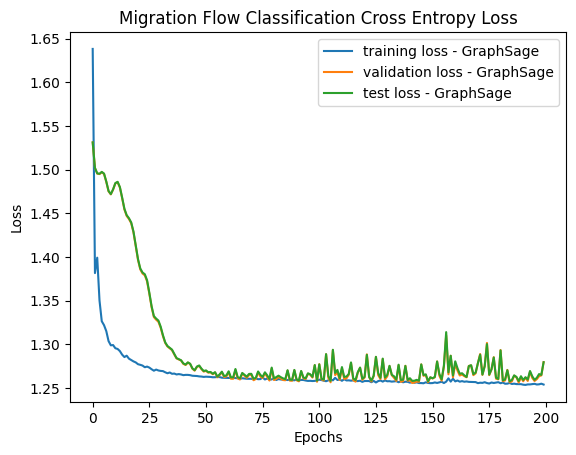

Running pipeline with config: Classification_GraphSage_simple_full


Training:   0%|          | 1/200 [00:00<01:37,  2.05Epochs/s]

Epoch 1: Training Loss 1.59308, Training F1 Score (Micro) 0.29724 Validation Loss 1.51723 Validation F1 Score (Micro) 0.47818


Training:   1%|          | 2/200 [00:00<01:25,  2.31Epochs/s]

Epoch 2: Training Loss 1.40434, Training F1 Score (Micro) 0.47546 Validation Loss 1.4635 Validation F1 Score (Micro) 0.47818


Training:   2%|▏         | 3/200 [00:01<01:21,  2.41Epochs/s]

Epoch 3: Training Loss 1.41369, Training F1 Score (Micro) 0.42878 Validation Loss 1.44179 Validation F1 Score (Micro) 0.47818


Training:   2%|▏         | 4/200 [00:01<01:27,  2.25Epochs/s]

Epoch 4: Training Loss 1.37616, Training F1 Score (Micro) 0.46124 Validation Loss 1.44453 Validation F1 Score (Micro) 0.47818


Training:   2%|▎         | 5/200 [00:02<01:32,  2.11Epochs/s]

Epoch 5: Training Loss 1.34032, Training F1 Score (Micro) 0.47428 Validation Loss 1.45689 Validation F1 Score (Micro) 0.47818


Training:   3%|▎         | 6/200 [00:02<01:36,  2.01Epochs/s]

Epoch 6: Training Loss 1.35655, Training F1 Score (Micro) 0.47464 Validation Loss 1.46889 Validation F1 Score (Micro) 0.47818


Training:   4%|▎         | 7/200 [00:03<01:39,  1.95Epochs/s]

Epoch 7: Training Loss 1.33706, Training F1 Score (Micro) 0.47481 Validation Loss 1.46424 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 8/200 [00:03<01:40,  1.91Epochs/s]

Epoch 8: Training Loss 1.33312, Training F1 Score (Micro) 0.47646 Validation Loss 1.44406 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 9/200 [00:04<01:40,  1.90Epochs/s]

Epoch 9: Training Loss 1.32737, Training F1 Score (Micro) 0.48429 Validation Loss 1.41969 Validation F1 Score (Micro) 0.47818


Training:   5%|▌         | 10/200 [00:04<01:40,  1.89Epochs/s]

Epoch 10: Training Loss 1.3192, Training F1 Score (Micro) 0.48807 Validation Loss 1.40369 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 11/200 [00:05<01:40,  1.88Epochs/s]

Epoch 11: Training Loss 1.31485, Training F1 Score (Micro) 0.47844 Validation Loss 1.39952 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 12/200 [00:05<01:35,  1.97Epochs/s]

Epoch 12: Training Loss 1.31299, Training F1 Score (Micro) 0.47557 Validation Loss 1.40129 Validation F1 Score (Micro) 0.47818


Training:   6%|▋         | 13/200 [00:06<01:28,  2.12Epochs/s]

Epoch 13: Training Loss 1.30746, Training F1 Score (Micro) 0.47549 Validation Loss 1.40846 Validation F1 Score (Micro) 0.47818


Training:   7%|▋         | 14/200 [00:06<01:23,  2.23Epochs/s]

Epoch 14: Training Loss 1.29977, Training F1 Score (Micro) 0.47567 Validation Loss 1.41722 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 15/200 [00:07<01:19,  2.33Epochs/s]

Epoch 15: Training Loss 1.29742, Training F1 Score (Micro) 0.47791 Validation Loss 1.41866 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 16/200 [00:07<01:17,  2.38Epochs/s]

Epoch 16: Training Loss 1.29673, Training F1 Score (Micro) 0.48573 Validation Loss 1.40873 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 17/200 [00:07<01:15,  2.44Epochs/s]

Epoch 17: Training Loss 1.2909, Training F1 Score (Micro) 0.49355 Validation Loss 1.39165 Validation F1 Score (Micro) 0.47818


Training:   9%|▉         | 18/200 [00:08<01:13,  2.47Epochs/s]

Epoch 18: Training Loss 1.28682, Training F1 Score (Micro) 0.49283 Validation Loss 1.37663 Validation F1 Score (Micro) 0.47818


Training:  10%|▉         | 19/200 [00:08<01:12,  2.48Epochs/s]

Epoch 19: Training Loss 1.28773, Training F1 Score (Micro) 0.49442 Validation Loss 1.36961 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 20/200 [00:09<01:10,  2.54Epochs/s]

Epoch 20: Training Loss 1.28648, Training F1 Score (Micro) 0.49862 Validation Loss 1.37102 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 21/200 [00:09<01:09,  2.56Epochs/s]

Epoch 21: Training Loss 1.28448, Training F1 Score (Micro) 0.49751 Validation Loss 1.37792 Validation F1 Score (Micro) 0.47818


Training:  11%|█         | 22/200 [00:09<01:09,  2.55Epochs/s]

Epoch 22: Training Loss 1.28124, Training F1 Score (Micro) 0.49584 Validation Loss 1.3829 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 23/200 [00:10<01:08,  2.57Epochs/s]

Epoch 23: Training Loss 1.28009, Training F1 Score (Micro) 0.49811 Validation Loss 1.3818 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 24/200 [00:10<01:14,  2.36Epochs/s]

Epoch 24: Training Loss 1.27926, Training F1 Score (Micro) 0.49856 Validation Loss 1.37529 Validation F1 Score (Micro) 0.47818


Training:  12%|█▎        | 25/200 [00:11<01:19,  2.21Epochs/s]

Epoch 25: Training Loss 1.27945, Training F1 Score (Micro) 0.49201 Validation Loss 1.36497 Validation F1 Score (Micro) 0.47818


Training:  13%|█▎        | 26/200 [00:11<01:23,  2.10Epochs/s]

Epoch 26: Training Loss 1.27674, Training F1 Score (Micro) 0.49519 Validation Loss 1.35344 Validation F1 Score (Micro) 0.47818


Training:  14%|█▎        | 27/200 [00:12<01:26,  1.99Epochs/s]

Epoch 27: Training Loss 1.27572, Training F1 Score (Micro) 0.4989 Validation Loss 1.34405 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 28/200 [00:12<01:29,  1.93Epochs/s]

Epoch 28: Training Loss 1.27656, Training F1 Score (Micro) 0.49805 Validation Loss 1.33728 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 29/200 [00:13<01:30,  1.89Epochs/s]

Epoch 29: Training Loss 1.27532, Training F1 Score (Micro) 0.49802 Validation Loss 1.33383 Validation F1 Score (Micro) 0.47818


Training:  15%|█▌        | 30/200 [00:14<01:30,  1.87Epochs/s]

Epoch 30: Training Loss 1.27443, Training F1 Score (Micro) 0.49901 Validation Loss 1.33434 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 31/200 [00:14<01:29,  1.88Epochs/s]

Epoch 31: Training Loss 1.27301, Training F1 Score (Micro) 0.50006 Validation Loss 1.33542 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 32/200 [00:14<01:22,  2.04Epochs/s]

Epoch 32: Training Loss 1.27295, Training F1 Score (Micro) 0.49952 Validation Loss 1.33344 Validation F1 Score (Micro) 0.47818


Training:  16%|█▋        | 33/200 [00:15<01:16,  2.19Epochs/s]

Epoch 33: Training Loss 1.27316, Training F1 Score (Micro) 0.49938 Validation Loss 1.32829 Validation F1 Score (Micro) 0.47818


Training:  17%|█▋        | 34/200 [00:15<01:12,  2.30Epochs/s]

Epoch 34: Training Loss 1.27197, Training F1 Score (Micro) 0.49974 Validation Loss 1.32232 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 35/200 [00:16<01:09,  2.37Epochs/s]

Epoch 35: Training Loss 1.27242, Training F1 Score (Micro) 0.49876 Validation Loss 1.31702 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 36/200 [00:16<01:07,  2.44Epochs/s]

Epoch 36: Training Loss 1.27072, Training F1 Score (Micro) 0.49859 Validation Loss 1.3146 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 37/200 [00:16<01:05,  2.50Epochs/s]

Epoch 37: Training Loss 1.27065, Training F1 Score (Micro) 0.4996 Validation Loss 1.31373 Validation F1 Score (Micro) 0.47818


Training:  19%|█▉        | 38/200 [00:17<01:05,  2.47Epochs/s]

Epoch 38: Training Loss 1.27151, Training F1 Score (Micro) 0.49982 Validation Loss 1.31071 Validation F1 Score (Micro) 0.47818


Training:  20%|█▉        | 39/200 [00:17<01:05,  2.46Epochs/s]

Epoch 39: Training Loss 1.27026, Training F1 Score (Micro) 0.4984 Validation Loss 1.30855 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 40/200 [00:18<01:06,  2.39Epochs/s]

Epoch 40: Training Loss 1.27002, Training F1 Score (Micro) 0.49893 Validation Loss 1.30652 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 41/200 [00:18<01:06,  2.39Epochs/s]

Epoch 41: Training Loss 1.26982, Training F1 Score (Micro) 0.49906 Validation Loss 1.30372 Validation F1 Score (Micro) 0.47818


Training:  21%|██        | 42/200 [00:18<01:05,  2.40Epochs/s]

Epoch 42: Training Loss 1.27003, Training F1 Score (Micro) 0.49846 Validation Loss 1.30055 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 43/200 [00:19<01:03,  2.46Epochs/s]

Epoch 43: Training Loss 1.26892, Training F1 Score (Micro) 0.49916 Validation Loss 1.29663 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 44/200 [00:19<01:02,  2.48Epochs/s]

Epoch 44: Training Loss 1.26919, Training F1 Score (Micro) 0.4993 Validation Loss 1.29435 Validation F1 Score (Micro) 0.47818


Training:  22%|██▎       | 45/200 [00:20<01:01,  2.51Epochs/s]

Epoch 45: Training Loss 1.26781, Training F1 Score (Micro) 0.49968 Validation Loss 1.29165 Validation F1 Score (Micro) 0.47818


Training:  23%|██▎       | 46/200 [00:20<01:00,  2.54Epochs/s]

Epoch 46: Training Loss 1.26903, Training F1 Score (Micro) 0.49932 Validation Loss 1.29024 Validation F1 Score (Micro) 0.47818


Training:  24%|██▎       | 47/200 [00:20<00:59,  2.57Epochs/s]

Epoch 47: Training Loss 1.26928, Training F1 Score (Micro) 0.49831 Validation Loss 1.29433 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 48/200 [00:21<01:00,  2.53Epochs/s]

Epoch 48: Training Loss 1.26802, Training F1 Score (Micro) 0.4994 Validation Loss 1.29683 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 49/200 [00:21<01:00,  2.49Epochs/s]

Epoch 49: Training Loss 1.26844, Training F1 Score (Micro) 0.49956 Validation Loss 1.29626 Validation F1 Score (Micro) 0.47818


Training:  25%|██▌       | 50/200 [00:22<01:00,  2.49Epochs/s]

Epoch 50: Training Loss 1.26768, Training F1 Score (Micro) 0.5001 Validation Loss 1.29375 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 51/200 [00:22<00:58,  2.54Epochs/s]

Epoch 51: Training Loss 1.26721, Training F1 Score (Micro) 0.49901 Validation Loss 1.29414 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 52/200 [00:22<00:57,  2.56Epochs/s]

Epoch 52: Training Loss 1.26719, Training F1 Score (Micro) 0.49961 Validation Loss 1.29619 Validation F1 Score (Micro) 0.47818


Training:  26%|██▋       | 53/200 [00:23<00:57,  2.57Epochs/s]

Epoch 53: Training Loss 1.26659, Training F1 Score (Micro) 0.50027 Validation Loss 1.30161 Validation F1 Score (Micro) 0.47818


Training:  27%|██▋       | 54/200 [00:23<00:57,  2.55Epochs/s]

Epoch 54: Training Loss 1.26726, Training F1 Score (Micro) 0.49951 Validation Loss 1.29657 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 55/200 [00:24<00:56,  2.57Epochs/s]

Epoch 55: Training Loss 1.26744, Training F1 Score (Micro) 0.49984 Validation Loss 1.28982 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 56/200 [00:24<00:56,  2.57Epochs/s]

Epoch 56: Training Loss 1.26693, Training F1 Score (Micro) 0.4991 Validation Loss 1.29784 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 57/200 [00:24<01:01,  2.31Epochs/s]

Epoch 57: Training Loss 1.26727, Training F1 Score (Micro) 0.49896 Validation Loss 1.30166 Validation F1 Score (Micro) 0.47818


Training:  29%|██▉       | 58/200 [00:25<01:06,  2.12Epochs/s]

Epoch 58: Training Loss 1.26784, Training F1 Score (Micro) 0.49948 Validation Loss 1.29118 Validation F1 Score (Micro) 0.47818


Training:  30%|██▉       | 59/200 [00:26<01:09,  2.04Epochs/s]

Epoch 59: Training Loss 1.26714, Training F1 Score (Micro) 0.49952 Validation Loss 1.28896 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 60/200 [00:26<01:11,  1.97Epochs/s]

Epoch 60: Training Loss 1.26612, Training F1 Score (Micro) 0.49964 Validation Loss 1.30453 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 61/200 [00:27<01:11,  1.95Epochs/s]

Epoch 61: Training Loss 1.26678, Training F1 Score (Micro) 0.49952 Validation Loss 1.30257 Validation F1 Score (Micro) 0.47818


Training:  31%|███       | 62/200 [00:27<01:11,  1.92Epochs/s]

Epoch 62: Training Loss 1.26626, Training F1 Score (Micro) 0.50009 Validation Loss 1.28554 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 63/200 [00:28<01:11,  1.90Epochs/s]

Epoch 63: Training Loss 1.26634, Training F1 Score (Micro) 0.49886 Validation Loss 1.29261 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 64/200 [00:28<01:13,  1.86Epochs/s]

Epoch 64: Training Loss 1.26589, Training F1 Score (Micro) 0.49896 Validation Loss 1.30599 Validation F1 Score (Micro) 0.47818


Training:  32%|███▎      | 65/200 [00:29<01:08,  1.96Epochs/s]

Epoch 65: Training Loss 1.26604, Training F1 Score (Micro) 0.49949 Validation Loss 1.29538 Validation F1 Score (Micro) 0.47818


Training:  33%|███▎      | 66/200 [00:29<01:03,  2.10Epochs/s]

Epoch 66: Training Loss 1.26626, Training F1 Score (Micro) 0.49936 Validation Loss 1.29996 Validation F1 Score (Micro) 0.47818


Training:  34%|███▎      | 67/200 [00:30<00:59,  2.24Epochs/s]

Epoch 67: Training Loss 1.26582, Training F1 Score (Micro) 0.49935 Validation Loss 1.29612 Validation F1 Score (Micro) 0.47818


Training:  34%|███▍      | 68/200 [00:30<00:56,  2.34Epochs/s]

Epoch 68: Training Loss 1.26547, Training F1 Score (Micro) 0.49894 Validation Loss 1.32286 Validation F1 Score (Micro) 0.47818


Training:  34%|███▍      | 69/200 [00:30<00:56,  2.33Epochs/s]

Epoch 69: Training Loss 1.26542, Training F1 Score (Micro) 0.50019 Validation Loss 1.30305 Validation F1 Score (Micro) 0.47818


Training:  35%|███▌      | 70/200 [00:31<00:54,  2.38Epochs/s]

Epoch 70: Training Loss 1.26573, Training F1 Score (Micro) 0.49934 Validation Loss 1.30414 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 71/200 [00:31<00:52,  2.44Epochs/s]

Epoch 71: Training Loss 1.26496, Training F1 Score (Micro) 0.49946 Validation Loss 1.32361 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 72/200 [00:31<00:51,  2.48Epochs/s]

Epoch 72: Training Loss 1.26504, Training F1 Score (Micro) 0.5001 Validation Loss 1.29582 Validation F1 Score (Micro) 0.47818


Training:  36%|███▋      | 73/200 [00:32<00:50,  2.53Epochs/s]

Epoch 73: Training Loss 1.26476, Training F1 Score (Micro) 0.49939 Validation Loss 1.29933 Validation F1 Score (Micro) 0.47818


Training:  37%|███▋      | 74/200 [00:32<00:49,  2.53Epochs/s]

Epoch 74: Training Loss 1.26539, Training F1 Score (Micro) 0.49874 Validation Loss 1.35142 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 75/200 [00:33<00:48,  2.56Epochs/s]

Epoch 75: Training Loss 1.26522, Training F1 Score (Micro) 0.49986 Validation Loss 1.27696 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 76/200 [00:33<00:48,  2.56Epochs/s]

Epoch 76: Training Loss 1.26543, Training F1 Score (Micro) 0.4983 Validation Loss 1.31806 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 77/200 [00:33<00:48,  2.55Epochs/s]

Epoch 77: Training Loss 1.26408, Training F1 Score (Micro) 0.50072 Validation Loss 1.34397 Validation F1 Score (Micro) 0.47818


Training:  39%|███▉      | 78/200 [00:34<00:47,  2.58Epochs/s]

Epoch 78: Training Loss 1.26536, Training F1 Score (Micro) 0.49987 Validation Loss 1.28024 Validation F1 Score (Micro) 0.47818


Training:  40%|███▉      | 79/200 [00:34<00:47,  2.57Epochs/s]

Epoch 79: Training Loss 1.26535, Training F1 Score (Micro) 0.49786 Validation Loss 1.37277 Validation F1 Score (Micro) 0.47818


Training:  40%|████      | 80/200 [00:35<00:46,  2.60Epochs/s]

Epoch 80: Training Loss 1.26569, Training F1 Score (Micro) 0.50018 Validation Loss 1.27722 Validation F1 Score (Micro) 0.47818


Training:  40%|████      | 81/200 [00:35<00:45,  2.60Epochs/s]

Epoch 81: Training Loss 1.2651, Training F1 Score (Micro) 0.49744 Validation Loss 1.32348 Validation F1 Score (Micro) 0.47818


Training:  41%|████      | 82/200 [00:35<00:45,  2.59Epochs/s]

Epoch 82: Training Loss 1.26371, Training F1 Score (Micro) 0.49984 Validation Loss 1.35695 Validation F1 Score (Micro) 0.47818


Training:  42%|████▏     | 83/200 [00:36<00:45,  2.59Epochs/s]

Epoch 83: Training Loss 1.26526, Training F1 Score (Micro) 0.50014 Validation Loss 1.26282 Validation F1 Score (Micro) 0.49701


Training:  42%|████▏     | 84/200 [00:36<00:44,  2.58Epochs/s]

Epoch 84: Training Loss 1.26582, Training F1 Score (Micro) 0.49617 Validation Loss 1.288 Validation F1 Score (Micro) 0.47818


Training:  42%|████▎     | 85/200 [00:37<00:44,  2.56Epochs/s]

Epoch 85: Training Loss 1.26486, Training F1 Score (Micro) 0.49847 Validation Loss 1.39514 Validation F1 Score (Micro) 0.47818


Training:  43%|████▎     | 86/200 [00:37<00:44,  2.54Epochs/s]

Epoch 86: Training Loss 1.26902, Training F1 Score (Micro) 0.49622 Validation Loss 1.26268 Validation F1 Score (Micro) 0.50217


Training:  44%|████▎     | 87/200 [00:37<00:44,  2.55Epochs/s]

Epoch 87: Training Loss 1.26778, Training F1 Score (Micro) 0.49527 Validation Loss 1.26337 Validation F1 Score (Micro) 0.5035


Training:  44%|████▍     | 88/200 [00:38<00:44,  2.52Epochs/s]

Epoch 88: Training Loss 1.26802, Training F1 Score (Micro) 0.49509 Validation Loss 1.3231 Validation F1 Score (Micro) 0.47818


Training:  44%|████▍     | 89/200 [00:38<00:43,  2.55Epochs/s]

Epoch 89: Training Loss 1.26589, Training F1 Score (Micro) 0.49898 Validation Loss 1.32416 Validation F1 Score (Micro) 0.47818


Training:  45%|████▌     | 90/200 [00:38<00:42,  2.57Epochs/s]

Epoch 90: Training Loss 1.26663, Training F1 Score (Micro) 0.49936 Validation Loss 1.26366 Validation F1 Score (Micro) 0.50129


Training:  46%|████▌     | 91/200 [00:39<00:46,  2.36Epochs/s]

Epoch 91: Training Loss 1.26443, Training F1 Score (Micro) 0.49835 Validation Loss 1.26577 Validation F1 Score (Micro) 0.50274


Training:  46%|████▌     | 92/200 [00:40<00:49,  2.16Epochs/s]

Epoch 92: Training Loss 1.26722, Training F1 Score (Micro) 0.49558 Validation Loss 1.27248 Validation F1 Score (Micro) 0.47818


Training:  46%|████▋     | 93/200 [00:40<00:51,  2.09Epochs/s]

Epoch 93: Training Loss 1.26427, Training F1 Score (Micro) 0.49938 Validation Loss 1.32614 Validation F1 Score (Micro) 0.47818


Training:  47%|████▋     | 94/200 [00:41<00:52,  2.01Epochs/s]

Epoch 94: Training Loss 1.26626, Training F1 Score (Micro) 0.49811 Validation Loss 1.29658 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 95/200 [00:41<00:53,  1.96Epochs/s]

Epoch 95: Training Loss 1.26451, Training F1 Score (Micro) 0.5 Validation Loss 1.2745 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 96/200 [00:42<00:55,  1.87Epochs/s]

Epoch 96: Training Loss 1.2653, Training F1 Score (Micro) 0.49754 Validation Loss 1.28951 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 97/200 [00:42<00:56,  1.84Epochs/s]

Epoch 97: Training Loss 1.26476, Training F1 Score (Micro) 0.49855 Validation Loss 1.367 Validation F1 Score (Micro) 0.47818


Training:  49%|████▉     | 98/200 [00:43<00:54,  1.86Epochs/s]

Epoch 98: Training Loss 1.26424, Training F1 Score (Micro) 0.50077 Validation Loss 1.42416 Validation F1 Score (Micro) 0.47818


Training:  50%|████▉     | 99/200 [00:43<00:53,  1.88Epochs/s]

Epoch 99: Training Loss 1.26485, Training F1 Score (Micro) 0.5006 Validation Loss 1.36936 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 100/200 [00:44<00:49,  2.03Epochs/s]

Epoch 100: Training Loss 1.26341, Training F1 Score (Micro) 0.50043 Validation Loss 1.335 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 101/200 [00:44<00:45,  2.16Epochs/s]

Epoch 101: Training Loss 1.26443, Training F1 Score (Micro) 0.49837 Validation Loss 1.37148 Validation F1 Score (Micro) 0.47818


Training:  51%|█████     | 102/200 [00:45<00:42,  2.28Epochs/s]

Epoch 102: Training Loss 1.26448, Training F1 Score (Micro) 0.49929 Validation Loss 1.43047 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 103/200 [00:45<00:42,  2.30Epochs/s]

Epoch 103: Training Loss 1.26455, Training F1 Score (Micro) 0.50078 Validation Loss 1.39296 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 104/200 [00:45<00:41,  2.33Epochs/s]

Epoch 104: Training Loss 1.26337, Training F1 Score (Micro) 0.50057 Validation Loss 1.34226 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▎    | 105/200 [00:46<00:40,  2.35Epochs/s]

Epoch 105: Training Loss 1.26364, Training F1 Score (Micro) 0.49861 Validation Loss 1.3608 Validation F1 Score (Micro) 0.47818


Training:  53%|█████▎    | 106/200 [00:46<00:38,  2.42Epochs/s]

Epoch 106: Training Loss 1.26363, Training F1 Score (Micro) 0.4998 Validation Loss 1.39748 Validation F1 Score (Micro) 0.47818


Training:  54%|█████▎    | 107/200 [00:47<00:37,  2.48Epochs/s]

Epoch 107: Training Loss 1.26406, Training F1 Score (Micro) 0.5009 Validation Loss 1.34384 Validation F1 Score (Micro) 0.47818


Training:  54%|█████▍    | 108/200 [00:47<00:36,  2.49Epochs/s]

Epoch 108: Training Loss 1.26344, Training F1 Score (Micro) 0.50009 Validation Loss 1.30903 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▍    | 109/200 [00:47<00:36,  2.51Epochs/s]

Epoch 109: Training Loss 1.26372, Training F1 Score (Micro) 0.49829 Validation Loss 1.33722 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▌    | 110/200 [00:48<00:36,  2.47Epochs/s]

Epoch 110: Training Loss 1.26276, Training F1 Score (Micro) 0.50042 Validation Loss 1.36046 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 111/200 [00:48<00:35,  2.49Epochs/s]

Epoch 111: Training Loss 1.26347, Training F1 Score (Micro) 0.50077 Validation Loss 1.28847 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 112/200 [00:49<00:35,  2.51Epochs/s]

Epoch 112: Training Loss 1.26412, Training F1 Score (Micro) 0.49893 Validation Loss 1.29116 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▋    | 113/200 [00:49<00:34,  2.50Epochs/s]

Epoch 113: Training Loss 1.26318, Training F1 Score (Micro) 0.49888 Validation Loss 1.36878 Validation F1 Score (Micro) 0.47818


Training:  57%|█████▋    | 114/200 [00:49<00:33,  2.53Epochs/s]

Epoch 114: Training Loss 1.26423, Training F1 Score (Micro) 0.50098 Validation Loss 1.27498 Validation F1 Score (Micro) 0.48743


Training:  57%|█████▊    | 115/200 [00:50<00:33,  2.54Epochs/s]

Epoch 115: Training Loss 1.26332, Training F1 Score (Micro) 0.49845 Validation Loss 1.27757 Validation F1 Score (Micro) 0.48177


Training:  58%|█████▊    | 116/200 [00:50<00:33,  2.54Epochs/s]

Epoch 116: Training Loss 1.26364, Training F1 Score (Micro) 0.49929 Validation Loss 1.34498 Validation F1 Score (Micro) 0.47818


Training:  58%|█████▊    | 117/200 [00:50<00:32,  2.56Epochs/s]

Epoch 117: Training Loss 1.26415, Training F1 Score (Micro) 0.50018 Validation Loss 1.27432 Validation F1 Score (Micro) 0.48051


Training:  59%|█████▉    | 118/200 [00:51<00:32,  2.55Epochs/s]

Epoch 118: Training Loss 1.26297, Training F1 Score (Micro) 0.49894 Validation Loss 1.26726 Validation F1 Score (Micro) 0.49405


Training:  60%|█████▉    | 119/200 [00:51<00:31,  2.58Epochs/s]

Epoch 119: Training Loss 1.26325, Training F1 Score (Micro) 0.49862 Validation Loss 1.31318 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 120/200 [00:52<00:31,  2.58Epochs/s]

Epoch 120: Training Loss 1.26259, Training F1 Score (Micro) 0.5001 Validation Loss 1.29388 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 121/200 [00:52<00:30,  2.56Epochs/s]

Epoch 121: Training Loss 1.26243, Training F1 Score (Micro) 0.50052 Validation Loss 1.27049 Validation F1 Score (Micro) 0.48762


Training:  61%|██████    | 122/200 [00:52<00:30,  2.57Epochs/s]

Epoch 122: Training Loss 1.26224, Training F1 Score (Micro) 0.49809 Validation Loss 1.30711 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 123/200 [00:53<00:29,  2.58Epochs/s]

Epoch 123: Training Loss 1.26305, Training F1 Score (Micro) 0.50053 Validation Loss 1.28133 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 124/200 [00:53<00:30,  2.52Epochs/s]

Epoch 124: Training Loss 1.26224, Training F1 Score (Micro) 0.49998 Validation Loss 1.27526 Validation F1 Score (Micro) 0.47981


Training:  62%|██████▎   | 125/200 [00:54<00:33,  2.27Epochs/s]

Epoch 125: Training Loss 1.2628, Training F1 Score (Micro) 0.49925 Validation Loss 1.31484 Validation F1 Score (Micro) 0.47818


Training:  63%|██████▎   | 126/200 [00:54<00:34,  2.15Epochs/s]

Epoch 126: Training Loss 1.26161, Training F1 Score (Micro) 0.50108 Validation Loss 1.27536 Validation F1 Score (Micro) 0.48145


Training:  64%|██████▎   | 127/200 [00:55<00:35,  2.07Epochs/s]

Epoch 127: Training Loss 1.26319, Training F1 Score (Micro) 0.499 Validation Loss 1.29539 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 128/200 [00:55<00:36,  1.96Epochs/s]

Epoch 128: Training Loss 1.26236, Training F1 Score (Micro) 0.50054 Validation Loss 1.29279 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 129/200 [00:56<00:36,  1.93Epochs/s]

Epoch 129: Training Loss 1.2624, Training F1 Score (Micro) 0.50026 Validation Loss 1.27103 Validation F1 Score (Micro) 0.4938


Training:  65%|██████▌   | 130/200 [00:56<00:36,  1.90Epochs/s]

Epoch 130: Training Loss 1.26222, Training F1 Score (Micro) 0.49987 Validation Loss 1.28698 Validation F1 Score (Micro) 0.48057


Training:  66%|██████▌   | 131/200 [00:57<00:36,  1.87Epochs/s]

Epoch 131: Training Loss 1.26244, Training F1 Score (Micro) 0.49982 Validation Loss 1.28358 Validation F1 Score (Micro) 0.48668


Training:  66%|██████▌   | 132/200 [00:58<00:36,  1.88Epochs/s]

Epoch 132: Training Loss 1.26177, Training F1 Score (Micro) 0.49986 Validation Loss 1.28766 Validation F1 Score (Micro) 0.48284


Training:  66%|██████▋   | 133/200 [00:58<00:34,  1.95Epochs/s]

Epoch 133: Training Loss 1.26145, Training F1 Score (Micro) 0.50033 Validation Loss 1.29249 Validation F1 Score (Micro) 0.47887


Training:  67%|██████▋   | 134/200 [00:58<00:31,  2.09Epochs/s]

Epoch 134: Training Loss 1.26223, Training F1 Score (Micro) 0.50013 Validation Loss 1.30893 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 135/200 [00:59<00:29,  2.18Epochs/s]

Epoch 135: Training Loss 1.26184, Training F1 Score (Micro) 0.50011 Validation Loss 1.30913 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 136/200 [00:59<00:28,  2.26Epochs/s]

Epoch 136: Training Loss 1.26206, Training F1 Score (Micro) 0.49955 Validation Loss 1.37933 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 137/200 [01:00<00:27,  2.32Epochs/s]

Epoch 137: Training Loss 1.26276, Training F1 Score (Micro) 0.50062 Validation Loss 1.25974 Validation F1 Score (Micro) 0.4955


Training:  69%|██████▉   | 138/200 [01:00<00:26,  2.36Epochs/s]

Epoch 138: Training Loss 1.27117, Training F1 Score (Micro) 0.49116 Validation Loss 1.3226 Validation F1 Score (Micro) 0.47818


Training:  70%|██████▉   | 139/200 [01:00<00:26,  2.33Epochs/s]

Epoch 139: Training Loss 1.26258, Training F1 Score (Micro) 0.50106 Validation Loss 1.4292 Validation F1 Score (Micro) 0.47818


Training:  70%|███████   | 140/200 [01:01<00:25,  2.35Epochs/s]

Epoch 140: Training Loss 1.26901, Training F1 Score (Micro) 0.49229 Validation Loss 1.29791 Validation F1 Score (Micro) 0.48271


Training:  70%|███████   | 141/200 [01:01<00:25,  2.34Epochs/s]

Epoch 141: Training Loss 1.27234, Training F1 Score (Micro) 0.48937 Validation Loss 1.32695 Validation F1 Score (Micro) 0.4693


Training:  71%|███████   | 142/200 [01:02<00:24,  2.36Epochs/s]

Epoch 142: Training Loss 1.27237, Training F1 Score (Micro) 0.48889 Validation Loss 1.27863 Validation F1 Score (Micro) 0.49991


Training:  72%|███████▏  | 143/200 [01:02<00:24,  2.35Epochs/s]

Epoch 143: Training Loss 1.26546, Training F1 Score (Micro) 0.49808 Validation Loss 1.30324 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▏  | 144/200 [01:03<00:23,  2.41Epochs/s]

Epoch 144: Training Loss 1.27027, Training F1 Score (Micro) 0.48475 Validation Loss 1.28649 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▎  | 145/200 [01:03<00:22,  2.44Epochs/s]

Epoch 145: Training Loss 1.26871, Training F1 Score (Micro) 0.48923 Validation Loss 1.28635 Validation F1 Score (Micro) 0.49512


Training:  73%|███████▎  | 146/200 [01:03<00:22,  2.43Epochs/s]

Epoch 146: Training Loss 1.26571, Training F1 Score (Micro) 0.49869 Validation Loss 1.31341 Validation F1 Score (Micro) 0.47471


Training:  74%|███████▎  | 147/200 [01:04<00:21,  2.43Epochs/s]

Epoch 147: Training Loss 1.26767, Training F1 Score (Micro) 0.49647 Validation Loss 1.29714 Validation F1 Score (Micro) 0.48485


Training:  74%|███████▍  | 148/200 [01:04<00:21,  2.45Epochs/s]

Epoch 148: Training Loss 1.26835, Training F1 Score (Micro) 0.49526 Validation Loss 1.2694 Validation F1 Score (Micro) 0.50513


Training:  74%|███████▍  | 149/200 [01:05<00:20,  2.47Epochs/s]

Epoch 149: Training Loss 1.26608, Training F1 Score (Micro) 0.49734 Validation Loss 1.29432 Validation F1 Score (Micro) 0.47818


Training:  75%|███████▌  | 150/200 [01:05<00:20,  2.49Epochs/s]

Epoch 150: Training Loss 1.26533, Training F1 Score (Micro) 0.49969 Validation Loss 1.36263 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 151/200 [01:05<00:19,  2.47Epochs/s]

Epoch 151: Training Loss 1.26636, Training F1 Score (Micro) 0.49811 Validation Loss 1.37524 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 152/200 [01:06<00:19,  2.43Epochs/s]

Epoch 152: Training Loss 1.2655, Training F1 Score (Micro) 0.5009 Validation Loss 1.36202 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▋  | 153/200 [01:06<00:19,  2.47Epochs/s]

Epoch 153: Training Loss 1.26439, Training F1 Score (Micro) 0.49947 Validation Loss 1.37303 Validation F1 Score (Micro) 0.47818


Training:  77%|███████▋  | 154/200 [01:07<00:19,  2.42Epochs/s]

Epoch 154: Training Loss 1.2647, Training F1 Score (Micro) 0.49745 Validation Loss 1.41415 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 155/200 [01:07<00:18,  2.43Epochs/s]

Epoch 155: Training Loss 1.26473, Training F1 Score (Micro) 0.49823 Validation Loss 1.48373 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 156/200 [01:07<00:18,  2.43Epochs/s]

Epoch 156: Training Loss 1.26381, Training F1 Score (Micro) 0.50027 Validation Loss 1.53312 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 157/200 [01:08<00:17,  2.44Epochs/s]

Epoch 157: Training Loss 1.26462, Training F1 Score (Micro) 0.50037 Validation Loss 1.49152 Validation F1 Score (Micro) 0.47818


Training:  79%|███████▉  | 158/200 [01:08<00:19,  2.19Epochs/s]

Epoch 158: Training Loss 1.2638, Training F1 Score (Micro) 0.50084 Validation Loss 1.42506 Validation F1 Score (Micro) 0.47818


Training:  80%|███████▉  | 159/200 [01:09<00:19,  2.07Epochs/s]

Epoch 159: Training Loss 1.26364, Training F1 Score (Micro) 0.49905 Validation Loss 1.41111 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 160/200 [01:10<00:20,  1.94Epochs/s]

Epoch 160: Training Loss 1.264, Training F1 Score (Micro) 0.49805 Validation Loss 1.4581 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 161/200 [01:10<00:20,  1.90Epochs/s]

Epoch 161: Training Loss 1.26313, Training F1 Score (Micro) 0.49939 Validation Loss 1.50716 Validation F1 Score (Micro) 0.47818


Training:  81%|████████  | 162/200 [01:11<00:20,  1.83Epochs/s]

Epoch 162: Training Loss 1.26368, Training F1 Score (Micro) 0.50063 Validation Loss 1.42508 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▏ | 163/200 [01:11<00:20,  1.83Epochs/s]

Epoch 163: Training Loss 1.26257, Training F1 Score (Micro) 0.50146 Validation Loss 1.35359 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▏ | 164/200 [01:12<00:19,  1.81Epochs/s]

Epoch 164: Training Loss 1.2632, Training F1 Score (Micro) 0.49775 Validation Loss 1.36342 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▎ | 165/200 [01:12<00:19,  1.82Epochs/s]

Epoch 165: Training Loss 1.26236, Training F1 Score (Micro) 0.50008 Validation Loss 1.39791 Validation F1 Score (Micro) 0.47818


Training:  83%|████████▎ | 166/200 [01:13<00:17,  1.91Epochs/s]

Epoch 166: Training Loss 1.26305, Training F1 Score (Micro) 0.50076 Validation Loss 1.33814 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▎ | 167/200 [01:13<00:16,  2.06Epochs/s]

Epoch 167: Training Loss 1.26246, Training F1 Score (Micro) 0.50004 Validation Loss 1.29005 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▍ | 168/200 [01:14<00:14,  2.16Epochs/s]

Epoch 168: Training Loss 1.26311, Training F1 Score (Micro) 0.49881 Validation Loss 1.29182 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▍ | 169/200 [01:14<00:13,  2.26Epochs/s]

Epoch 169: Training Loss 1.26252, Training F1 Score (Micro) 0.49966 Validation Loss 1.31679 Validation F1 Score (Micro) 0.47818


Training:  85%|████████▌ | 170/200 [01:14<00:12,  2.33Epochs/s]

Epoch 170: Training Loss 1.2629, Training F1 Score (Micro) 0.50031 Validation Loss 1.28757 Validation F1 Score (Micro) 0.47862


Training:  86%|████████▌ | 171/200 [01:15<00:12,  2.38Epochs/s]

Epoch 171: Training Loss 1.26204, Training F1 Score (Micro) 0.49973 Validation Loss 1.27574 Validation F1 Score (Micro) 0.49417


Training:  86%|████████▌ | 172/200 [01:15<00:11,  2.43Epochs/s]

Epoch 172: Training Loss 1.26241, Training F1 Score (Micro) 0.49916 Validation Loss 1.29595 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▋ | 173/200 [01:16<00:11,  2.45Epochs/s]

Epoch 173: Training Loss 1.26221, Training F1 Score (Micro) 0.50072 Validation Loss 1.29129 Validation F1 Score (Micro) 0.47818


Training:  87%|████████▋ | 174/200 [01:16<00:10,  2.45Epochs/s]

Epoch 174: Training Loss 1.26138, Training F1 Score (Micro) 0.50115 Validation Loss 1.27836 Validation F1 Score (Micro) 0.49172


Training:  88%|████████▊ | 175/200 [01:16<00:10,  2.49Epochs/s]

Epoch 175: Training Loss 1.26229, Training F1 Score (Micro) 0.49928 Validation Loss 1.2875 Validation F1 Score (Micro) 0.47843


Training:  88%|████████▊ | 176/200 [01:17<00:09,  2.51Epochs/s]

Epoch 176: Training Loss 1.26123, Training F1 Score (Micro) 0.4997 Validation Loss 1.29813 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 177/200 [01:17<00:09,  2.46Epochs/s]

Epoch 177: Training Loss 1.26157, Training F1 Score (Micro) 0.50055 Validation Loss 1.27254 Validation F1 Score (Micro) 0.48844


Training:  89%|████████▉ | 178/200 [01:18<00:09,  2.41Epochs/s]

Epoch 178: Training Loss 1.26191, Training F1 Score (Micro) 0.49861 Validation Loss 1.2805 Validation F1 Score (Micro) 0.47912


Training:  90%|████████▉ | 179/200 [01:18<00:08,  2.38Epochs/s]

Epoch 179: Training Loss 1.26105, Training F1 Score (Micro) 0.49983 Validation Loss 1.31505 Validation F1 Score (Micro) 0.47818


Training:  90%|█████████ | 180/200 [01:19<00:08,  2.38Epochs/s]

Epoch 180: Training Loss 1.26282, Training F1 Score (Micro) 0.50072 Validation Loss 1.28178 Validation F1 Score (Micro) 0.49398


Training:  90%|█████████ | 181/200 [01:19<00:07,  2.40Epochs/s]

Epoch 181: Training Loss 1.2625, Training F1 Score (Micro) 0.49848 Validation Loss 1.29954 Validation F1 Score (Micro) 0.47818


Training:  91%|█████████ | 182/200 [01:19<00:07,  2.44Epochs/s]

Epoch 182: Training Loss 1.26144, Training F1 Score (Micro) 0.5001 Validation Loss 1.31709 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▏| 183/200 [01:20<00:07,  2.43Epochs/s]

Epoch 183: Training Loss 1.26183, Training F1 Score (Micro) 0.5009 Validation Loss 1.28265 Validation F1 Score (Micro) 0.50148


Training:  92%|█████████▏| 184/200 [01:20<00:06,  2.39Epochs/s]

Epoch 184: Training Loss 1.26129, Training F1 Score (Micro) 0.49942 Validation Loss 1.28414 Validation F1 Score (Micro) 0.50557


Training:  92%|█████████▎| 185/200 [01:21<00:06,  2.45Epochs/s]

Epoch 185: Training Loss 1.26153, Training F1 Score (Micro) 0.50015 Validation Loss 1.2835 Validation F1 Score (Micro) 0.50469


Training:  93%|█████████▎| 186/200 [01:21<00:05,  2.47Epochs/s]

Epoch 186: Training Loss 1.26075, Training F1 Score (Micro) 0.50072 Validation Loss 1.26791 Validation F1 Score (Micro) 0.50381


Training:  94%|█████████▎| 187/200 [01:21<00:05,  2.51Epochs/s]

Epoch 187: Training Loss 1.26117, Training F1 Score (Micro) 0.49905 Validation Loss 1.26576 Validation F1 Score (Micro) 0.50318


Training:  94%|█████████▍| 188/200 [01:22<00:04,  2.50Epochs/s]

Epoch 188: Training Loss 1.26068, Training F1 Score (Micro) 0.49962 Validation Loss 1.28082 Validation F1 Score (Micro) 0.50526


Training:  94%|█████████▍| 189/200 [01:22<00:04,  2.48Epochs/s]

Epoch 189: Training Loss 1.26204, Training F1 Score (Micro) 0.50044 Validation Loss 1.27309 Validation F1 Score (Micro) 0.488


Training:  95%|█████████▌| 190/200 [01:23<00:03,  2.51Epochs/s]

Epoch 190: Training Loss 1.2653, Training F1 Score (Micro) 0.49453 Validation Loss 1.27214 Validation F1 Score (Micro) 0.50457


Training:  96%|█████████▌| 191/200 [01:23<00:03,  2.26Epochs/s]

Epoch 191: Training Loss 1.26103, Training F1 Score (Micro) 0.50122 Validation Loss 1.2996 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▌| 192/200 [01:24<00:03,  2.13Epochs/s]

Epoch 192: Training Loss 1.26348, Training F1 Score (Micro) 0.49947 Validation Loss 1.26587 Validation F1 Score (Micro) 0.49329


Training:  96%|█████████▋| 193/200 [01:24<00:03,  2.04Epochs/s]

Epoch 193: Training Loss 1.26385, Training F1 Score (Micro) 0.49595 Validation Loss 1.26481 Validation F1 Score (Micro) 0.49795


Training:  97%|█████████▋| 194/200 [01:25<00:03,  1.97Epochs/s]

Epoch 194: Training Loss 1.26278, Training F1 Score (Micro) 0.49753 Validation Loss 1.30512 Validation F1 Score (Micro) 0.47824


Training:  98%|█████████▊| 195/200 [01:25<00:02,  1.93Epochs/s]

Epoch 195: Training Loss 1.26271, Training F1 Score (Micro) 0.50081 Validation Loss 1.28706 Validation F1 Score (Micro) 0.48869


Training:  98%|█████████▊| 196/200 [01:26<00:02,  1.92Epochs/s]

Epoch 196: Training Loss 1.26223, Training F1 Score (Micro) 0.50091 Validation Loss 1.26353 Validation F1 Score (Micro) 0.4977


Training:  98%|█████████▊| 197/200 [01:26<00:01,  1.85Epochs/s]

Epoch 197: Training Loss 1.26265, Training F1 Score (Micro) 0.49776 Validation Loss 1.26374 Validation F1 Score (Micro) 0.49984


Training:  99%|█████████▉| 198/200 [01:27<00:01,  1.85Epochs/s]

Epoch 198: Training Loss 1.26147, Training F1 Score (Micro) 0.49815 Validation Loss 1.30008 Validation F1 Score (Micro) 0.47818


Training: 100%|█████████▉| 199/200 [01:27<00:00,  1.92Epochs/s]

Epoch 199: Training Loss 1.26175, Training F1 Score (Micro) 0.50021 Validation Loss 1.29659 Validation F1 Score (Micro) 0.47818


Training: 100%|██████████| 200/200 [01:28<00:00,  2.27Epochs/s]

Epoch 200: Training Loss 1.26191, Training F1 Score (Micro) 0.50068 Validation Loss 1.26267 Validation F1 Score (Micro) 0.50091
Saving Model Predictions for Model Type GraphSage
Model saved successfully as Classification_GraphSage_simple_full
Minimum validation loss: 1.2597442865371704
Minimum test loss: 1.262942910194397
Best test metric: 0.4963627755641937


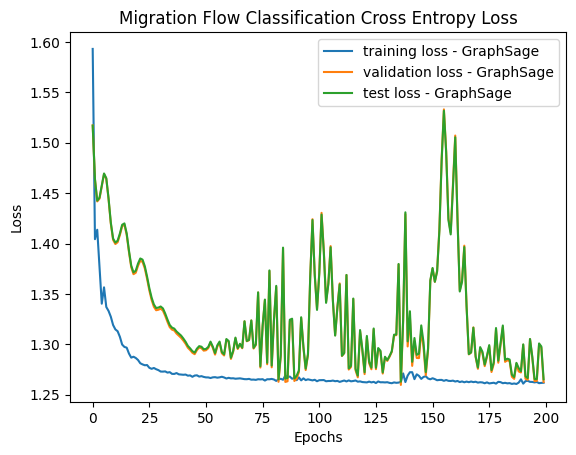

Running pipeline with config: Classification_GraphSage_full_within_state


Training:   0%|          | 1/200 [00:00<01:06,  2.98Epochs/s]

Epoch 1: Training Loss 1.67644, Training F1 Score (Micro) 0.1717 Validation Loss 1.55784 Validation F1 Score (Micro) 0.47407


Training:   1%|          | 2/200 [00:00<01:06,  3.00Epochs/s]

Epoch 2: Training Loss 1.45234, Training F1 Score (Micro) 0.47341 Validation Loss 1.58342 Validation F1 Score (Micro) 0.31797


Training:   2%|▏         | 3/200 [00:01<01:06,  2.95Epochs/s]

Epoch 3: Training Loss 1.43594, Training F1 Score (Micro) 0.47081 Validation Loss 1.59862 Validation F1 Score (Micro) 0.20086


Training:   2%|▏         | 4/200 [00:01<01:06,  2.94Epochs/s]

Epoch 4: Training Loss 1.3872, Training F1 Score (Micro) 0.47272 Validation Loss 1.59142 Validation F1 Score (Micro) 0.20482


Training:   2%|▎         | 5/200 [00:01<01:06,  2.94Epochs/s]

Epoch 5: Training Loss 1.38592, Training F1 Score (Micro) 0.4665 Validation Loss 1.57078 Validation F1 Score (Micro) 0.33515


Training:   3%|▎         | 6/200 [00:02<01:05,  2.95Epochs/s]

Epoch 6: Training Loss 1.37583, Training F1 Score (Micro) 0.47792 Validation Loss 1.54203 Validation F1 Score (Micro) 0.47374


Training:   4%|▎         | 7/200 [00:02<01:05,  2.95Epochs/s]

Epoch 7: Training Loss 1.35245, Training F1 Score (Micro) 0.48839 Validation Loss 1.51334 Validation F1 Score (Micro) 0.47407


Training:   4%|▍         | 8/200 [00:02<01:04,  2.96Epochs/s]

Epoch 8: Training Loss 1.34824, Training F1 Score (Micro) 0.48634 Validation Loss 1.4978 Validation F1 Score (Micro) 0.47407


Training:   4%|▍         | 9/200 [00:03<01:04,  2.95Epochs/s]

Epoch 9: Training Loss 1.34442, Training F1 Score (Micro) 0.48426 Validation Loss 1.49722 Validation F1 Score (Micro) 0.47456


Training:   5%|▌         | 10/200 [00:03<01:04,  2.94Epochs/s]

Epoch 10: Training Loss 1.33291, Training F1 Score (Micro) 0.48896 Validation Loss 1.50223 Validation F1 Score (Micro) 0.48646


Training:   6%|▌         | 11/200 [00:03<01:04,  2.95Epochs/s]

Epoch 11: Training Loss 1.32805, Training F1 Score (Micro) 0.49266 Validation Loss 1.50582 Validation F1 Score (Micro) 0.48745


Training:   6%|▌         | 12/200 [00:04<01:03,  2.97Epochs/s]

Epoch 12: Training Loss 1.3236, Training F1 Score (Micro) 0.48702 Validation Loss 1.50533 Validation F1 Score (Micro) 0.49009


Training:   6%|▋         | 13/200 [00:04<01:03,  2.96Epochs/s]

Epoch 13: Training Loss 1.32141, Training F1 Score (Micro) 0.49042 Validation Loss 1.49871 Validation F1 Score (Micro) 0.49125


Training:   7%|▋         | 14/200 [00:04<01:02,  2.97Epochs/s]

Epoch 14: Training Loss 1.31644, Training F1 Score (Micro) 0.49313 Validation Loss 1.48595 Validation F1 Score (Micro) 0.49174


Training:   8%|▊         | 15/200 [00:05<01:02,  2.96Epochs/s]

Epoch 15: Training Loss 1.31252, Training F1 Score (Micro) 0.49304 Validation Loss 1.47039 Validation F1 Score (Micro) 0.49108


Training:   8%|▊         | 16/200 [00:05<01:02,  2.97Epochs/s]

Epoch 16: Training Loss 1.309, Training F1 Score (Micro) 0.49955 Validation Loss 1.45762 Validation F1 Score (Micro) 0.49851


Training:   8%|▊         | 17/200 [00:05<01:01,  2.95Epochs/s]

Epoch 17: Training Loss 1.30465, Training F1 Score (Micro) 0.49939 Validation Loss 1.45003 Validation F1 Score (Micro) 0.50231


Training:   9%|▉         | 18/200 [00:06<01:01,  2.95Epochs/s]

Epoch 18: Training Loss 1.29976, Training F1 Score (Micro) 0.50297 Validation Loss 1.44652 Validation F1 Score (Micro) 0.50512


Training:  10%|▉         | 19/200 [00:06<01:02,  2.91Epochs/s]

Epoch 19: Training Loss 1.29975, Training F1 Score (Micro) 0.5026 Validation Loss 1.44371 Validation F1 Score (Micro) 0.50628


Training:  10%|█         | 20/200 [00:06<01:01,  2.92Epochs/s]

Epoch 20: Training Loss 1.29605, Training F1 Score (Micro) 0.50623 Validation Loss 1.4382 Validation F1 Score (Micro) 0.50743


Training:  10%|█         | 21/200 [00:07<01:00,  2.94Epochs/s]

Epoch 21: Training Loss 1.29392, Training F1 Score (Micro) 0.50821 Validation Loss 1.42669 Validation F1 Score (Micro) 0.50743


Training:  11%|█         | 22/200 [00:07<01:00,  2.94Epochs/s]

Epoch 22: Training Loss 1.28875, Training F1 Score (Micro) 0.5105 Validation Loss 1.41098 Validation F1 Score (Micro) 0.4962


Training:  12%|█▏        | 23/200 [00:07<00:59,  2.96Epochs/s]

Epoch 23: Training Loss 1.28937, Training F1 Score (Micro) 0.50809 Validation Loss 1.39574 Validation F1 Score (Micro) 0.50066


Training:  12%|█▏        | 24/200 [00:08<00:59,  2.98Epochs/s]

Epoch 24: Training Loss 1.28591, Training F1 Score (Micro) 0.51189 Validation Loss 1.38518 Validation F1 Score (Micro) 0.50479


Training:  12%|█▎        | 25/200 [00:08<01:04,  2.70Epochs/s]

Epoch 25: Training Loss 1.28458, Training F1 Score (Micro) 0.51123 Validation Loss 1.37958 Validation F1 Score (Micro) 0.50562


Training:  13%|█▎        | 26/200 [00:08<01:06,  2.60Epochs/s]

Epoch 26: Training Loss 1.28135, Training F1 Score (Micro) 0.51239 Validation Loss 1.37711 Validation F1 Score (Micro) 0.50545


Training:  14%|█▎        | 27/200 [00:09<01:09,  2.51Epochs/s]

Epoch 27: Training Loss 1.28108, Training F1 Score (Micro) 0.51217 Validation Loss 1.37453 Validation F1 Score (Micro) 0.51041


Training:  14%|█▍        | 28/200 [00:09<01:10,  2.45Epochs/s]

Epoch 28: Training Loss 1.27932, Training F1 Score (Micro) 0.51248 Validation Loss 1.36737 Validation F1 Score (Micro) 0.50842


Training:  14%|█▍        | 29/200 [00:10<01:10,  2.44Epochs/s]

Epoch 29: Training Loss 1.2786, Training F1 Score (Micro) 0.51531 Validation Loss 1.35747 Validation F1 Score (Micro) 0.5038


Training:  15%|█▌        | 30/200 [00:10<01:10,  2.43Epochs/s]

Epoch 30: Training Loss 1.27863, Training F1 Score (Micro) 0.51427 Validation Loss 1.34902 Validation F1 Score (Micro) 0.50628


Training:  16%|█▌        | 31/200 [00:11<01:10,  2.39Epochs/s]

Epoch 31: Training Loss 1.2753, Training F1 Score (Micro) 0.51671 Validation Loss 1.34256 Validation F1 Score (Micro) 0.50942


Training:  16%|█▌        | 32/200 [00:11<01:12,  2.33Epochs/s]

Epoch 32: Training Loss 1.2738, Training F1 Score (Micro) 0.51536 Validation Loss 1.33683 Validation F1 Score (Micro) 0.50942


Training:  16%|█▋        | 33/200 [00:12<01:11,  2.33Epochs/s]

Epoch 33: Training Loss 1.27311, Training F1 Score (Micro) 0.51496 Validation Loss 1.33204 Validation F1 Score (Micro) 0.50925


Training:  17%|█▋        | 34/200 [00:12<01:11,  2.34Epochs/s]

Epoch 34: Training Loss 1.27241, Training F1 Score (Micro) 0.51704 Validation Loss 1.32769 Validation F1 Score (Micro) 0.51189


Training:  18%|█▊        | 35/200 [00:12<01:11,  2.29Epochs/s]

Epoch 35: Training Loss 1.27178, Training F1 Score (Micro) 0.51468 Validation Loss 1.32076 Validation F1 Score (Micro) 0.5033


Training:  18%|█▊        | 36/200 [00:13<01:08,  2.39Epochs/s]

Epoch 36: Training Loss 1.27181, Training F1 Score (Micro) 0.5142 Validation Loss 1.31505 Validation F1 Score (Micro) 0.49901


Training:  18%|█▊        | 37/200 [00:13<01:04,  2.55Epochs/s]

Epoch 37: Training Loss 1.27123, Training F1 Score (Micro) 0.51512 Validation Loss 1.30893 Validation F1 Score (Micro) 0.50892


Training:  19%|█▉        | 38/200 [00:13<01:01,  2.65Epochs/s]

Epoch 38: Training Loss 1.27098, Training F1 Score (Micro) 0.51529 Validation Loss 1.30481 Validation F1 Score (Micro) 0.50446


Training:  20%|█▉        | 39/200 [00:14<00:58,  2.76Epochs/s]

Epoch 39: Training Loss 1.26904, Training F1 Score (Micro) 0.51781 Validation Loss 1.30303 Validation F1 Score (Micro) 0.50578


Training:  20%|██        | 40/200 [00:14<00:56,  2.83Epochs/s]

Epoch 40: Training Loss 1.2682, Training F1 Score (Micro) 0.51819 Validation Loss 1.30045 Validation F1 Score (Micro) 0.51008


Training:  20%|██        | 41/200 [00:14<00:55,  2.85Epochs/s]

Epoch 41: Training Loss 1.269, Training F1 Score (Micro) 0.51604 Validation Loss 1.29542 Validation F1 Score (Micro) 0.50793


Training:  21%|██        | 42/200 [00:15<00:54,  2.90Epochs/s]

Epoch 42: Training Loss 1.26655, Training F1 Score (Micro) 0.51701 Validation Loss 1.29095 Validation F1 Score (Micro) 0.50958


Training:  22%|██▏       | 43/200 [00:15<00:53,  2.91Epochs/s]

Epoch 43: Training Loss 1.2666, Training F1 Score (Micro) 0.51779 Validation Loss 1.28792 Validation F1 Score (Micro) 0.51024


Training:  22%|██▏       | 44/200 [00:15<00:53,  2.89Epochs/s]

Epoch 44: Training Loss 1.26603, Training F1 Score (Micro) 0.51722 Validation Loss 1.28587 Validation F1 Score (Micro) 0.51156


Training:  22%|██▎       | 45/200 [00:16<00:53,  2.92Epochs/s]

Epoch 45: Training Loss 1.26519, Training F1 Score (Micro) 0.51744 Validation Loss 1.28257 Validation F1 Score (Micro) 0.50809


Training:  23%|██▎       | 46/200 [00:16<00:52,  2.93Epochs/s]

Epoch 46: Training Loss 1.26456, Training F1 Score (Micro) 0.51916 Validation Loss 1.27805 Validation F1 Score (Micro) 0.51206


Training:  24%|██▎       | 47/200 [00:16<00:52,  2.93Epochs/s]

Epoch 47: Training Loss 1.26403, Training F1 Score (Micro) 0.51798 Validation Loss 1.27572 Validation F1 Score (Micro) 0.51255


Training:  24%|██▍       | 48/200 [00:17<00:51,  2.95Epochs/s]

Epoch 48: Training Loss 1.2635, Training F1 Score (Micro) 0.51895 Validation Loss 1.27383 Validation F1 Score (Micro) 0.51635


Training:  24%|██▍       | 49/200 [00:17<00:51,  2.96Epochs/s]

Epoch 49: Training Loss 1.26362, Training F1 Score (Micro) 0.51906 Validation Loss 1.27281 Validation F1 Score (Micro) 0.51635


Training:  25%|██▌       | 50/200 [00:17<00:50,  2.94Epochs/s]

Epoch 50: Training Loss 1.26245, Training F1 Score (Micro) 0.51755 Validation Loss 1.26871 Validation F1 Score (Micro) 0.51833


Training:  26%|██▌       | 51/200 [00:18<00:50,  2.95Epochs/s]

Epoch 51: Training Loss 1.26123, Training F1 Score (Micro) 0.5189 Validation Loss 1.26713 Validation F1 Score (Micro) 0.51569


Training:  26%|██▌       | 52/200 [00:18<00:51,  2.90Epochs/s]

Epoch 52: Training Loss 1.26311, Training F1 Score (Micro) 0.5181 Validation Loss 1.26545 Validation F1 Score (Micro) 0.51652


Training:  26%|██▋       | 53/200 [00:19<00:50,  2.92Epochs/s]

Epoch 53: Training Loss 1.26215, Training F1 Score (Micro) 0.51847 Validation Loss 1.26508 Validation F1 Score (Micro) 0.51652


Training:  27%|██▋       | 54/200 [00:19<00:49,  2.93Epochs/s]

Epoch 54: Training Loss 1.26523, Training F1 Score (Micro) 0.51744 Validation Loss 1.2663 Validation F1 Score (Micro) 0.51602


Training:  28%|██▊       | 55/200 [00:19<00:49,  2.95Epochs/s]

Epoch 55: Training Loss 1.26418, Training F1 Score (Micro) 0.51748 Validation Loss 1.26419 Validation F1 Score (Micro) 0.51833


Training:  28%|██▊       | 56/200 [00:20<00:49,  2.93Epochs/s]

Epoch 56: Training Loss 1.26153, Training F1 Score (Micro) 0.5194 Validation Loss 1.2628 Validation F1 Score (Micro) 0.518


Training:  28%|██▊       | 57/200 [00:20<00:48,  2.95Epochs/s]

Epoch 57: Training Loss 1.26296, Training F1 Score (Micro) 0.51713 Validation Loss 1.26204 Validation F1 Score (Micro) 0.51718


Training:  29%|██▉       | 58/200 [00:20<00:47,  2.98Epochs/s]

Epoch 58: Training Loss 1.2602, Training F1 Score (Micro) 0.52048 Validation Loss 1.26347 Validation F1 Score (Micro) 0.51437


Training:  30%|██▉       | 59/200 [00:21<00:47,  2.97Epochs/s]

Epoch 59: Training Loss 1.26022, Training F1 Score (Micro) 0.51817 Validation Loss 1.26429 Validation F1 Score (Micro) 0.51635


Training:  30%|███       | 60/200 [00:21<00:46,  3.00Epochs/s]

Epoch 60: Training Loss 1.26089, Training F1 Score (Micro) 0.51779 Validation Loss 1.26143 Validation F1 Score (Micro) 0.51569


Training:  30%|███       | 61/200 [00:21<00:46,  3.02Epochs/s]

Epoch 61: Training Loss 1.26167, Training F1 Score (Micro) 0.51763 Validation Loss 1.25784 Validation F1 Score (Micro) 0.51833


Training:  31%|███       | 62/200 [00:22<00:46,  2.99Epochs/s]

Epoch 62: Training Loss 1.26291, Training F1 Score (Micro) 0.51803 Validation Loss 1.25461 Validation F1 Score (Micro) 0.51933


Training:  32%|███▏      | 63/200 [00:22<00:45,  3.00Epochs/s]

Epoch 63: Training Loss 1.25828, Training F1 Score (Micro) 0.51975 Validation Loss 1.25897 Validation F1 Score (Micro) 0.51933


Training:  32%|███▏      | 64/200 [00:22<00:45,  3.01Epochs/s]

Epoch 64: Training Loss 1.26122, Training F1 Score (Micro) 0.51744 Validation Loss 1.25378 Validation F1 Score (Micro) 0.51982


Training:  32%|███▎      | 65/200 [00:23<00:45,  2.98Epochs/s]

Epoch 65: Training Loss 1.25876, Training F1 Score (Micro) 0.51996 Validation Loss 1.25383 Validation F1 Score (Micro) 0.51933


Training:  33%|███▎      | 66/200 [00:23<00:48,  2.74Epochs/s]

Epoch 66: Training Loss 1.26069, Training F1 Score (Micro) 0.51876 Validation Loss 1.26087 Validation F1 Score (Micro) 0.51685


Training:  34%|███▎      | 67/200 [00:23<00:51,  2.59Epochs/s]

Epoch 67: Training Loss 1.26168, Training F1 Score (Micro) 0.51652 Validation Loss 1.25474 Validation F1 Score (Micro) 0.51685


Training:  34%|███▍      | 68/200 [00:24<00:53,  2.48Epochs/s]

Epoch 68: Training Loss 1.25911, Training F1 Score (Micro) 0.518 Validation Loss 1.25637 Validation F1 Score (Micro) 0.5147


Training:  34%|███▍      | 69/200 [00:24<00:54,  2.42Epochs/s]

Epoch 69: Training Loss 1.26145, Training F1 Score (Micro) 0.51715 Validation Loss 1.25368 Validation F1 Score (Micro) 0.51784


Training:  35%|███▌      | 70/200 [00:25<00:54,  2.40Epochs/s]

Epoch 70: Training Loss 1.25642, Training F1 Score (Micro) 0.52065 Validation Loss 1.2534 Validation F1 Score (Micro) 0.51933


Training:  36%|███▌      | 71/200 [00:25<00:53,  2.42Epochs/s]

Epoch 71: Training Loss 1.2597, Training F1 Score (Micro) 0.51909 Validation Loss 1.24984 Validation F1 Score (Micro) 0.52098


Training:  36%|███▌      | 72/200 [00:26<00:53,  2.39Epochs/s]

Epoch 72: Training Loss 1.25482, Training F1 Score (Micro) 0.52234 Validation Loss 1.25016 Validation F1 Score (Micro) 0.52081


Training:  36%|███▋      | 73/200 [00:26<00:53,  2.36Epochs/s]

Epoch 73: Training Loss 1.25858, Training F1 Score (Micro) 0.51753 Validation Loss 1.24886 Validation F1 Score (Micro) 0.51999


Training:  37%|███▋      | 74/200 [00:26<00:53,  2.37Epochs/s]

Epoch 74: Training Loss 1.2556, Training F1 Score (Micro) 0.52046 Validation Loss 1.25241 Validation F1 Score (Micro) 0.51867


Training:  38%|███▊      | 75/200 [00:27<00:53,  2.32Epochs/s]

Epoch 75: Training Loss 1.2561, Training F1 Score (Micro) 0.51831 Validation Loss 1.25021 Validation F1 Score (Micro) 0.51999


Training:  38%|███▊      | 76/200 [00:27<00:53,  2.33Epochs/s]

Epoch 76: Training Loss 1.25458, Training F1 Score (Micro) 0.52133 Validation Loss 1.25185 Validation F1 Score (Micro) 0.5185


Training:  38%|███▊      | 77/200 [00:28<00:50,  2.45Epochs/s]

Epoch 77: Training Loss 1.25658, Training F1 Score (Micro) 0.52046 Validation Loss 1.25063 Validation F1 Score (Micro) 0.51751


Training:  39%|███▉      | 78/200 [00:28<00:47,  2.59Epochs/s]

Epoch 78: Training Loss 1.25458, Training F1 Score (Micro) 0.52161 Validation Loss 1.24864 Validation F1 Score (Micro) 0.51767


Training:  40%|███▉      | 79/200 [00:28<00:44,  2.69Epochs/s]

Epoch 79: Training Loss 1.25379, Training F1 Score (Micro) 0.52079 Validation Loss 1.2493 Validation F1 Score (Micro) 0.51933


Training:  40%|████      | 80/200 [00:29<00:43,  2.74Epochs/s]

Epoch 80: Training Loss 1.25483, Training F1 Score (Micro) 0.52147 Validation Loss 1.25005 Validation F1 Score (Micro) 0.51982


Training:  40%|████      | 81/200 [00:29<00:42,  2.81Epochs/s]

Epoch 81: Training Loss 1.25247, Training F1 Score (Micro) 0.52242 Validation Loss 1.24873 Validation F1 Score (Micro) 0.52048


Training:  41%|████      | 82/200 [00:29<00:41,  2.85Epochs/s]

Epoch 82: Training Loss 1.25347, Training F1 Score (Micro) 0.52135 Validation Loss 1.24652 Validation F1 Score (Micro) 0.52346


Training:  42%|████▏     | 83/200 [00:30<00:40,  2.90Epochs/s]

Epoch 83: Training Loss 1.25205, Training F1 Score (Micro) 0.52225 Validation Loss 1.24835 Validation F1 Score (Micro) 0.52081


Training:  42%|████▏     | 84/200 [00:30<00:39,  2.91Epochs/s]

Epoch 84: Training Loss 1.25432, Training F1 Score (Micro) 0.52218 Validation Loss 1.2458 Validation F1 Score (Micro) 0.52246


Training:  42%|████▎     | 85/200 [00:30<00:39,  2.93Epochs/s]

Epoch 85: Training Loss 1.25157, Training F1 Score (Micro) 0.52109 Validation Loss 1.24506 Validation F1 Score (Micro) 0.52032


Training:  43%|████▎     | 86/200 [00:31<00:38,  2.97Epochs/s]

Epoch 86: Training Loss 1.25143, Training F1 Score (Micro) 0.52303 Validation Loss 1.24757 Validation F1 Score (Micro) 0.51949


Training:  44%|████▎     | 87/200 [00:31<00:38,  2.96Epochs/s]

Epoch 87: Training Loss 1.25534, Training F1 Score (Micro) 0.52079 Validation Loss 1.24607 Validation F1 Score (Micro) 0.5223


Training:  44%|████▍     | 88/200 [00:31<00:37,  2.96Epochs/s]

Epoch 88: Training Loss 1.25217, Training F1 Score (Micro) 0.52204 Validation Loss 1.24706 Validation F1 Score (Micro) 0.5223


Training:  44%|████▍     | 89/200 [00:32<00:37,  2.98Epochs/s]

Epoch 89: Training Loss 1.25248, Training F1 Score (Micro) 0.52166 Validation Loss 1.25247 Validation F1 Score (Micro) 0.51701


Training:  45%|████▌     | 90/200 [00:32<00:36,  2.98Epochs/s]

Epoch 90: Training Loss 1.25322, Training F1 Score (Micro) 0.52109 Validation Loss 1.24607 Validation F1 Score (Micro) 0.52065


Training:  46%|████▌     | 91/200 [00:32<00:36,  2.97Epochs/s]

Epoch 91: Training Loss 1.2503, Training F1 Score (Micro) 0.52258 Validation Loss 1.2454 Validation F1 Score (Micro) 0.51966


Training:  46%|████▌     | 92/200 [00:33<00:36,  2.99Epochs/s]

Epoch 92: Training Loss 1.25097, Training F1 Score (Micro) 0.52006 Validation Loss 1.25217 Validation F1 Score (Micro) 0.51833


Training:  46%|████▋     | 93/200 [00:33<00:36,  2.97Epochs/s]

Epoch 93: Training Loss 1.25086, Training F1 Score (Micro) 0.5227 Validation Loss 1.24874 Validation F1 Score (Micro) 0.52015


Training:  47%|████▋     | 94/200 [00:33<00:35,  2.97Epochs/s]

Epoch 94: Training Loss 1.24979, Training F1 Score (Micro) 0.52246 Validation Loss 1.24445 Validation F1 Score (Micro) 0.5218


Training:  48%|████▊     | 95/200 [00:34<00:35,  2.99Epochs/s]

Epoch 95: Training Loss 1.24822, Training F1 Score (Micro) 0.52242 Validation Loss 1.24448 Validation F1 Score (Micro) 0.52081


Training:  48%|████▊     | 96/200 [00:34<00:35,  2.97Epochs/s]

Epoch 96: Training Loss 1.24917, Training F1 Score (Micro) 0.52192 Validation Loss 1.24576 Validation F1 Score (Micro) 0.52147


Training:  48%|████▊     | 97/200 [00:34<00:34,  2.98Epochs/s]

Epoch 97: Training Loss 1.2516, Training F1 Score (Micro) 0.52164 Validation Loss 1.24294 Validation F1 Score (Micro) 0.5218


Training:  49%|████▉     | 98/200 [00:35<00:34,  2.97Epochs/s]

Epoch 98: Training Loss 1.25157, Training F1 Score (Micro) 0.52107 Validation Loss 1.25309 Validation F1 Score (Micro) 0.5185


Training:  50%|████▉     | 99/200 [00:35<00:34,  2.95Epochs/s]

Epoch 99: Training Loss 1.24838, Training F1 Score (Micro) 0.52324 Validation Loss 1.24685 Validation F1 Score (Micro) 0.52279


Training:  50%|█████     | 100/200 [00:35<00:33,  2.94Epochs/s]

Epoch 100: Training Loss 1.24866, Training F1 Score (Micro) 0.52343 Validation Loss 1.24374 Validation F1 Score (Micro) 0.5223


Training:  50%|█████     | 101/200 [00:36<00:33,  2.98Epochs/s]

Epoch 101: Training Loss 1.24859, Training F1 Score (Micro) 0.52149 Validation Loss 1.24785 Validation F1 Score (Micro) 0.51966


Training:  51%|█████     | 102/200 [00:36<00:32,  2.97Epochs/s]

Epoch 102: Training Loss 1.24727, Training F1 Score (Micro) 0.52466 Validation Loss 1.2461 Validation F1 Score (Micro) 0.52098


Training:  52%|█████▏    | 103/200 [00:36<00:32,  2.96Epochs/s]

Epoch 103: Training Loss 1.24851, Training F1 Score (Micro) 0.5231 Validation Loss 1.24271 Validation F1 Score (Micro) 0.5218


Training:  52%|█████▏    | 104/200 [00:37<00:32,  2.96Epochs/s]

Epoch 104: Training Loss 1.24844, Training F1 Score (Micro) 0.5219 Validation Loss 1.24219 Validation F1 Score (Micro) 0.52346


Training:  52%|█████▎    | 105/200 [00:37<00:32,  2.97Epochs/s]

Epoch 105: Training Loss 1.24619, Training F1 Score (Micro) 0.52234 Validation Loss 1.24375 Validation F1 Score (Micro) 0.52346


Training:  53%|█████▎    | 106/200 [00:37<00:31,  2.97Epochs/s]

Epoch 106: Training Loss 1.24788, Training F1 Score (Micro) 0.5243 Validation Loss 1.24226 Validation F1 Score (Micro) 0.52346


Training:  54%|█████▎    | 107/200 [00:38<00:33,  2.75Epochs/s]

Epoch 107: Training Loss 1.24771, Training F1 Score (Micro) 0.52206 Validation Loss 1.24034 Validation F1 Score (Micro) 0.52461


Training:  54%|█████▍    | 108/200 [00:38<00:35,  2.61Epochs/s]

Epoch 108: Training Loss 1.24749, Training F1 Score (Micro) 0.52244 Validation Loss 1.24315 Validation F1 Score (Micro) 0.52412


Training:  55%|█████▍    | 109/200 [00:39<00:35,  2.59Epochs/s]

Epoch 109: Training Loss 1.2483, Training F1 Score (Micro) 0.52388 Validation Loss 1.24105 Validation F1 Score (Micro) 0.52379


Training:  55%|█████▌    | 110/200 [00:39<00:35,  2.50Epochs/s]

Epoch 110: Training Loss 1.24822, Training F1 Score (Micro) 0.52147 Validation Loss 1.2416 Validation F1 Score (Micro) 0.52296


Training:  56%|█████▌    | 111/200 [00:40<00:36,  2.41Epochs/s]

Epoch 111: Training Loss 1.24622, Training F1 Score (Micro) 0.5231 Validation Loss 1.24572 Validation F1 Score (Micro) 0.52131


Training:  56%|█████▌    | 112/200 [00:40<00:36,  2.38Epochs/s]

Epoch 112: Training Loss 1.24823, Training F1 Score (Micro) 0.5219 Validation Loss 1.24267 Validation F1 Score (Micro) 0.52032


Training:  56%|█████▋    | 113/200 [00:40<00:37,  2.30Epochs/s]

Epoch 113: Training Loss 1.24641, Training F1 Score (Micro) 0.5222 Validation Loss 1.24391 Validation F1 Score (Micro) 0.52147


Training:  57%|█████▋    | 114/200 [00:41<00:37,  2.29Epochs/s]

Epoch 114: Training Loss 1.24567, Training F1 Score (Micro) 0.52461 Validation Loss 1.24729 Validation F1 Score (Micro) 0.52098


Training:  57%|█████▊    | 115/200 [00:41<00:37,  2.29Epochs/s]

Epoch 115: Training Loss 1.24551, Training F1 Score (Micro) 0.52371 Validation Loss 1.24447 Validation F1 Score (Micro) 0.52461


Training:  58%|█████▊    | 116/200 [00:42<00:36,  2.29Epochs/s]

Epoch 116: Training Loss 1.24676, Training F1 Score (Micro) 0.52381 Validation Loss 1.24368 Validation F1 Score (Micro) 0.52296


Training:  58%|█████▊    | 117/200 [00:42<00:36,  2.27Epochs/s]

Epoch 117: Training Loss 1.24552, Training F1 Score (Micro) 0.52305 Validation Loss 1.24306 Validation F1 Score (Micro) 0.52379


Training:  59%|█████▉    | 118/200 [00:43<00:34,  2.37Epochs/s]

Epoch 118: Training Loss 1.24566, Training F1 Score (Micro) 0.52397 Validation Loss 1.24163 Validation F1 Score (Micro) 0.52428


Training:  60%|█████▉    | 119/200 [00:43<00:31,  2.54Epochs/s]

Epoch 119: Training Loss 1.2463, Training F1 Score (Micro) 0.52362 Validation Loss 1.24472 Validation F1 Score (Micro) 0.52296


Training:  60%|██████    | 120/200 [00:43<00:30,  2.67Epochs/s]

Epoch 120: Training Loss 1.24569, Training F1 Score (Micro) 0.52303 Validation Loss 1.24389 Validation F1 Score (Micro) 0.52362


Training:  60%|██████    | 121/200 [00:44<00:28,  2.75Epochs/s]

Epoch 121: Training Loss 1.24563, Training F1 Score (Micro) 0.52473 Validation Loss 1.24267 Validation F1 Score (Micro) 0.52346


Training:  61%|██████    | 122/200 [00:44<00:27,  2.83Epochs/s]

Epoch 122: Training Loss 1.24377, Training F1 Score (Micro) 0.52383 Validation Loss 1.24491 Validation F1 Score (Micro) 0.52313


Training:  62%|██████▏   | 123/200 [00:44<00:26,  2.90Epochs/s]

Epoch 123: Training Loss 1.24602, Training F1 Score (Micro) 0.52376 Validation Loss 1.24286 Validation F1 Score (Micro) 0.52263


Training:  62%|██████▏   | 124/200 [00:45<00:26,  2.90Epochs/s]

Epoch 124: Training Loss 1.24288, Training F1 Score (Micro) 0.52492 Validation Loss 1.24575 Validation F1 Score (Micro) 0.52279


Training:  62%|██████▎   | 125/200 [00:45<00:25,  2.95Epochs/s]

Epoch 125: Training Loss 1.2451, Training F1 Score (Micro) 0.52555 Validation Loss 1.24617 Validation F1 Score (Micro) 0.52246


Training:  63%|██████▎   | 126/200 [00:45<00:24,  2.99Epochs/s]

Epoch 126: Training Loss 1.24234, Training F1 Score (Micro) 0.52492 Validation Loss 1.24451 Validation F1 Score (Micro) 0.52147


Training:  64%|██████▎   | 127/200 [00:46<00:24,  2.97Epochs/s]

Epoch 127: Training Loss 1.24239, Training F1 Score (Micro) 0.52452 Validation Loss 1.24125 Validation F1 Score (Micro) 0.52395


Training:  64%|██████▍   | 128/200 [00:46<00:24,  2.98Epochs/s]

Epoch 128: Training Loss 1.24424, Training F1 Score (Micro) 0.52416 Validation Loss 1.24816 Validation F1 Score (Micro) 0.52246


Training:  64%|██████▍   | 129/200 [00:46<00:23,  2.99Epochs/s]

Epoch 129: Training Loss 1.24233, Training F1 Score (Micro) 0.52428 Validation Loss 1.2411 Validation F1 Score (Micro) 0.52246


Training:  65%|██████▌   | 130/200 [00:47<00:23,  2.95Epochs/s]

Epoch 130: Training Loss 1.24387, Training F1 Score (Micro) 0.52291 Validation Loss 1.24184 Validation F1 Score (Micro) 0.52263


Training:  66%|██████▌   | 131/200 [00:47<00:23,  2.96Epochs/s]

Epoch 131: Training Loss 1.2434, Training F1 Score (Micro) 0.52426 Validation Loss 1.24363 Validation F1 Score (Micro) 0.52544


Training:  66%|██████▌   | 132/200 [00:47<00:22,  2.97Epochs/s]

Epoch 132: Training Loss 1.24404, Training F1 Score (Micro) 0.52315 Validation Loss 1.24371 Validation F1 Score (Micro) 0.52213


Training:  66%|██████▋   | 133/200 [00:48<00:22,  2.95Epochs/s]

Epoch 133: Training Loss 1.24554, Training F1 Score (Micro) 0.52298 Validation Loss 1.24727 Validation F1 Score (Micro) 0.5223


Training:  67%|██████▋   | 134/200 [00:48<00:22,  2.98Epochs/s]

Epoch 134: Training Loss 1.24142, Training F1 Score (Micro) 0.52501 Validation Loss 1.25071 Validation F1 Score (Micro) 0.51933


Training:  68%|██████▊   | 135/200 [00:48<00:22,  2.94Epochs/s]

Epoch 135: Training Loss 1.24682, Training F1 Score (Micro) 0.52308 Validation Loss 1.24318 Validation F1 Score (Micro) 0.52279


Training:  68%|██████▊   | 136/200 [00:49<00:21,  2.93Epochs/s]

Epoch 136: Training Loss 1.24442, Training F1 Score (Micro) 0.52216 Validation Loss 1.24191 Validation F1 Score (Micro) 0.5218


Training:  68%|██████▊   | 137/200 [00:49<00:21,  2.97Epochs/s]

Epoch 137: Training Loss 1.24376, Training F1 Score (Micro) 0.52334 Validation Loss 1.24573 Validation F1 Score (Micro) 0.52379


Training:  69%|██████▉   | 138/200 [00:49<00:20,  2.98Epochs/s]

Epoch 138: Training Loss 1.24634, Training F1 Score (Micro) 0.52305 Validation Loss 1.24091 Validation F1 Score (Micro) 0.52329


Training:  70%|██████▉   | 139/200 [00:50<00:20,  2.97Epochs/s]

Epoch 139: Training Loss 1.24186, Training F1 Score (Micro) 0.52546 Validation Loss 1.24136 Validation F1 Score (Micro) 0.52279


Training:  70%|███████   | 140/200 [00:50<00:20,  2.99Epochs/s]

Epoch 140: Training Loss 1.24324, Training F1 Score (Micro) 0.52459 Validation Loss 1.24092 Validation F1 Score (Micro) 0.52412


Training:  70%|███████   | 141/200 [00:50<00:19,  2.99Epochs/s]

Epoch 141: Training Loss 1.24134, Training F1 Score (Micro) 0.52553 Validation Loss 1.24003 Validation F1 Score (Micro) 0.52428


Training:  71%|███████   | 142/200 [00:51<00:19,  2.99Epochs/s]

Epoch 142: Training Loss 1.24222, Training F1 Score (Micro) 0.52482 Validation Loss 1.24053 Validation F1 Score (Micro) 0.5218


Training:  72%|███████▏  | 143/200 [00:51<00:18,  3.00Epochs/s]

Epoch 143: Training Loss 1.24275, Training F1 Score (Micro) 0.52345 Validation Loss 1.24001 Validation F1 Score (Micro) 0.52412


Training:  72%|███████▏  | 144/200 [00:51<00:18,  3.00Epochs/s]

Epoch 144: Training Loss 1.24203, Training F1 Score (Micro) 0.52423 Validation Loss 1.24497 Validation F1 Score (Micro) 0.5223


Training:  72%|███████▎  | 145/200 [00:52<00:18,  2.97Epochs/s]

Epoch 145: Training Loss 1.24161, Training F1 Score (Micro) 0.52492 Validation Loss 1.2417 Validation F1 Score (Micro) 0.52428


Training:  73%|███████▎  | 146/200 [00:52<00:18,  2.99Epochs/s]

Epoch 146: Training Loss 1.23905, Training F1 Score (Micro) 0.52536 Validation Loss 1.24245 Validation F1 Score (Micro) 0.52213


Training:  74%|███████▎  | 147/200 [00:52<00:17,  2.98Epochs/s]

Epoch 147: Training Loss 1.24098, Training F1 Score (Micro) 0.52404 Validation Loss 1.24111 Validation F1 Score (Micro) 0.5261


Training:  74%|███████▍  | 148/200 [00:53<00:19,  2.73Epochs/s]

Epoch 148: Training Loss 1.24019, Training F1 Score (Micro) 0.52494 Validation Loss 1.24042 Validation F1 Score (Micro) 0.52544


Training:  74%|███████▍  | 149/200 [00:53<00:19,  2.60Epochs/s]

Epoch 149: Training Loss 1.23896, Training F1 Score (Micro) 0.52664 Validation Loss 1.24117 Validation F1 Score (Micro) 0.52279


Training:  75%|███████▌  | 150/200 [00:54<00:19,  2.53Epochs/s]

Epoch 150: Training Loss 1.24008, Training F1 Score (Micro) 0.52369 Validation Loss 1.24103 Validation F1 Score (Micro) 0.5223


Training:  76%|███████▌  | 151/200 [00:54<00:20,  2.44Epochs/s]

Epoch 151: Training Loss 1.23883, Training F1 Score (Micro) 0.52477 Validation Loss 1.24176 Validation F1 Score (Micro) 0.52197


Training:  76%|███████▌  | 152/200 [00:54<00:20,  2.36Epochs/s]

Epoch 152: Training Loss 1.24074, Training F1 Score (Micro) 0.52452 Validation Loss 1.24438 Validation F1 Score (Micro) 0.52246


Training:  76%|███████▋  | 153/200 [00:55<00:19,  2.37Epochs/s]

Epoch 153: Training Loss 1.24066, Training F1 Score (Micro) 0.52433 Validation Loss 1.24393 Validation F1 Score (Micro) 0.52279


Training:  77%|███████▋  | 154/200 [00:55<00:19,  2.38Epochs/s]

Epoch 154: Training Loss 1.23717, Training F1 Score (Micro) 0.52503 Validation Loss 1.25265 Validation F1 Score (Micro) 0.51867


Training:  78%|███████▊  | 155/200 [00:56<00:19,  2.36Epochs/s]

Epoch 155: Training Loss 1.24172, Training F1 Score (Micro) 0.5248 Validation Loss 1.24253 Validation F1 Score (Micro) 0.52379


Training:  78%|███████▊  | 156/200 [00:56<00:18,  2.34Epochs/s]

Epoch 156: Training Loss 1.2396, Training F1 Score (Micro) 0.52574 Validation Loss 1.24221 Validation F1 Score (Micro) 0.52329


Training:  78%|███████▊  | 157/200 [00:57<00:18,  2.34Epochs/s]

Epoch 157: Training Loss 1.24017, Training F1 Score (Micro) 0.52426 Validation Loss 1.24217 Validation F1 Score (Micro) 0.52494


Training:  79%|███████▉  | 158/200 [00:58<00:24,  1.69Epochs/s]

Epoch 158: Training Loss 1.23846, Training F1 Score (Micro) 0.52628 Validation Loss 1.24413 Validation F1 Score (Micro) 0.52346


Training:  80%|███████▉  | 159/200 [00:58<00:21,  1.90Epochs/s]

Epoch 159: Training Loss 1.23919, Training F1 Score (Micro) 0.52593 Validation Loss 1.24112 Validation F1 Score (Micro) 0.52577


Training:  80%|████████  | 160/200 [00:58<00:18,  2.13Epochs/s]

Epoch 160: Training Loss 1.23809, Training F1 Score (Micro) 0.52475 Validation Loss 1.24216 Validation F1 Score (Micro) 0.52511


Training:  80%|████████  | 161/200 [00:59<00:16,  2.33Epochs/s]

Epoch 161: Training Loss 1.23687, Training F1 Score (Micro) 0.52631 Validation Loss 1.24171 Validation F1 Score (Micro) 0.52428


Training:  81%|████████  | 162/200 [00:59<00:15,  2.48Epochs/s]

Epoch 162: Training Loss 1.23965, Training F1 Score (Micro) 0.52532 Validation Loss 1.23947 Validation F1 Score (Micro) 0.52346


Training:  82%|████████▏ | 163/200 [00:59<00:14,  2.62Epochs/s]

Epoch 163: Training Loss 1.23729, Training F1 Score (Micro) 0.52558 Validation Loss 1.23903 Validation F1 Score (Micro) 0.52296


Training:  82%|████████▏ | 164/200 [01:00<00:13,  2.73Epochs/s]

Epoch 164: Training Loss 1.23664, Training F1 Score (Micro) 0.52593 Validation Loss 1.23942 Validation F1 Score (Micro) 0.52494


Training:  82%|████████▎ | 165/200 [01:00<00:12,  2.80Epochs/s]

Epoch 165: Training Loss 1.23731, Training F1 Score (Micro) 0.52586 Validation Loss 1.24041 Validation F1 Score (Micro) 0.52428


Training:  83%|████████▎ | 166/200 [01:00<00:11,  2.84Epochs/s]

Epoch 166: Training Loss 1.23711, Training F1 Score (Micro) 0.52466 Validation Loss 1.23996 Validation F1 Score (Micro) 0.52527


Training:  84%|████████▎ | 167/200 [01:01<00:11,  2.89Epochs/s]

Epoch 167: Training Loss 1.23717, Training F1 Score (Micro) 0.52525 Validation Loss 1.2404 Validation F1 Score (Micro) 0.52428


Training:  84%|████████▍ | 168/200 [01:01<00:10,  2.92Epochs/s]

Epoch 168: Training Loss 1.23632, Training F1 Score (Micro) 0.52598 Validation Loss 1.24134 Validation F1 Score (Micro) 0.52197


Training:  84%|████████▍ | 169/200 [01:01<00:10,  2.94Epochs/s]

Epoch 169: Training Loss 1.23659, Training F1 Score (Micro) 0.52459 Validation Loss 1.23984 Validation F1 Score (Micro) 0.52131


Training:  85%|████████▌ | 170/200 [01:02<00:10,  2.95Epochs/s]

Epoch 170: Training Loss 1.23544, Training F1 Score (Micro) 0.52499 Validation Loss 1.24013 Validation F1 Score (Micro) 0.52428


Training:  86%|████████▌ | 171/200 [01:02<00:09,  2.96Epochs/s]

Epoch 171: Training Loss 1.23505, Training F1 Score (Micro) 0.52617 Validation Loss 1.23894 Validation F1 Score (Micro) 0.5256


Training:  86%|████████▌ | 172/200 [01:02<00:09,  2.98Epochs/s]

Epoch 172: Training Loss 1.23358, Training F1 Score (Micro) 0.52761 Validation Loss 1.23932 Validation F1 Score (Micro) 0.52362


Training:  86%|████████▋ | 173/200 [01:03<00:09,  2.97Epochs/s]

Epoch 173: Training Loss 1.23304, Training F1 Score (Micro) 0.52612 Validation Loss 1.23879 Validation F1 Score (Micro) 0.52527


Training:  87%|████████▋ | 174/200 [01:03<00:08,  2.98Epochs/s]

Epoch 174: Training Loss 1.23382, Training F1 Score (Micro) 0.52645 Validation Loss 1.2381 Validation F1 Score (Micro) 0.52362


Training:  88%|████████▊ | 175/200 [01:03<00:08,  2.96Epochs/s]

Epoch 175: Training Loss 1.23575, Training F1 Score (Micro) 0.52541 Validation Loss 1.23936 Validation F1 Score (Micro) 0.52296


Training:  88%|████████▊ | 176/200 [01:04<00:08,  2.99Epochs/s]

Epoch 176: Training Loss 1.23505, Training F1 Score (Micro) 0.52553 Validation Loss 1.23958 Validation F1 Score (Micro) 0.52279


Training:  88%|████████▊ | 177/200 [01:04<00:07,  3.00Epochs/s]

Epoch 177: Training Loss 1.23399, Training F1 Score (Micro) 0.52711 Validation Loss 1.23861 Validation F1 Score (Micro) 0.52445


Training:  89%|████████▉ | 178/200 [01:04<00:07,  2.99Epochs/s]

Epoch 178: Training Loss 1.23347, Training F1 Score (Micro) 0.52746 Validation Loss 1.24055 Validation F1 Score (Micro) 0.52015


Training:  90%|████████▉ | 179/200 [01:05<00:07,  2.98Epochs/s]

Epoch 179: Training Loss 1.2354, Training F1 Score (Micro) 0.52525 Validation Loss 1.23863 Validation F1 Score (Micro) 0.52346


Training:  90%|█████████ | 180/200 [01:05<00:06,  2.99Epochs/s]

Epoch 180: Training Loss 1.23222, Training F1 Score (Micro) 0.52607 Validation Loss 1.24141 Validation F1 Score (Micro) 0.52395


Training:  90%|█████████ | 181/200 [01:05<00:06,  2.92Epochs/s]

Epoch 181: Training Loss 1.23475, Training F1 Score (Micro) 0.52565 Validation Loss 1.2396 Validation F1 Score (Micro) 0.52114


Training:  91%|█████████ | 182/200 [01:06<00:06,  2.95Epochs/s]

Epoch 182: Training Loss 1.23264, Training F1 Score (Micro) 0.52407 Validation Loss 1.24091 Validation F1 Score (Micro) 0.52346


Training:  92%|█████████▏| 183/200 [01:06<00:05,  2.93Epochs/s]

Epoch 183: Training Loss 1.23417, Training F1 Score (Micro) 0.52643 Validation Loss 1.2413 Validation F1 Score (Micro) 0.52577


Training:  92%|█████████▏| 184/200 [01:06<00:05,  2.93Epochs/s]

Epoch 184: Training Loss 1.23142, Training F1 Score (Micro) 0.52723 Validation Loss 1.24397 Validation F1 Score (Micro) 0.52478


Training:  92%|█████████▎| 185/200 [01:07<00:05,  2.96Epochs/s]

Epoch 185: Training Loss 1.2351, Training F1 Score (Micro) 0.52567 Validation Loss 1.24137 Validation F1 Score (Micro) 0.52395


Training:  93%|█████████▎| 186/200 [01:07<00:04,  2.97Epochs/s]

Epoch 186: Training Loss 1.2322, Training F1 Score (Micro) 0.52586 Validation Loss 1.24242 Validation F1 Score (Micro) 0.52296


Training:  94%|█████████▎| 187/200 [01:07<00:04,  2.91Epochs/s]

Epoch 187: Training Loss 1.23332, Training F1 Score (Micro) 0.52631 Validation Loss 1.24326 Validation F1 Score (Micro) 0.52346


Training:  94%|█████████▍| 188/200 [01:08<00:04,  2.68Epochs/s]

Epoch 188: Training Loss 1.23216, Training F1 Score (Micro) 0.52591 Validation Loss 1.244 Validation F1 Score (Micro) 0.52362


Training:  94%|█████████▍| 189/200 [01:08<00:04,  2.53Epochs/s]

Epoch 189: Training Loss 1.23209, Training F1 Score (Micro) 0.52506 Validation Loss 1.24481 Validation F1 Score (Micro) 0.52527


Training:  95%|█████████▌| 190/200 [01:09<00:04,  2.43Epochs/s]

Epoch 190: Training Loss 1.23372, Training F1 Score (Micro) 0.52654 Validation Loss 1.24008 Validation F1 Score (Micro) 0.52577


Training:  96%|█████████▌| 191/200 [01:09<00:03,  2.40Epochs/s]

Epoch 191: Training Loss 1.23338, Training F1 Score (Micro) 0.52442 Validation Loss 1.23897 Validation F1 Score (Micro) 0.5256


Training:  96%|█████████▌| 192/200 [01:10<00:03,  2.37Epochs/s]

Epoch 192: Training Loss 1.2318, Training F1 Score (Micro) 0.52569 Validation Loss 1.23905 Validation F1 Score (Micro) 0.52461


Training:  96%|█████████▋| 193/200 [01:10<00:02,  2.36Epochs/s]

Epoch 193: Training Loss 1.23102, Training F1 Score (Micro) 0.5265 Validation Loss 1.23869 Validation F1 Score (Micro) 0.52643


Training:  97%|█████████▋| 194/200 [01:10<00:02,  2.28Epochs/s]

Epoch 194: Training Loss 1.2317, Training F1 Score (Micro) 0.5273 Validation Loss 1.23741 Validation F1 Score (Micro) 0.52445


Training:  98%|█████████▊| 195/200 [01:11<00:02,  2.28Epochs/s]

Epoch 195: Training Loss 1.23059, Training F1 Score (Micro) 0.52603 Validation Loss 1.2381 Validation F1 Score (Micro) 0.52544


Training:  98%|█████████▊| 196/200 [01:11<00:01,  2.26Epochs/s]

Epoch 196: Training Loss 1.23018, Training F1 Score (Micro) 0.52633 Validation Loss 1.23777 Validation F1 Score (Micro) 0.52577


Training:  98%|█████████▊| 197/200 [01:12<00:01,  2.29Epochs/s]

Epoch 197: Training Loss 1.23086, Training F1 Score (Micro) 0.52562 Validation Loss 1.24393 Validation F1 Score (Micro) 0.52329


Training:  99%|█████████▉| 198/200 [01:12<00:00,  2.43Epochs/s]

Epoch 198: Training Loss 1.23187, Training F1 Score (Micro) 0.52659 Validation Loss 1.23856 Validation F1 Score (Micro) 0.52692


Training: 100%|█████████▉| 199/200 [01:13<00:00,  2.51Epochs/s]

Epoch 199: Training Loss 1.2303, Training F1 Score (Micro) 0.52506 Validation Loss 1.23914 Validation F1 Score (Micro) 0.52676


Training: 100%|██████████| 200/200 [01:13<00:00,  2.73Epochs/s]

Epoch 200: Training Loss 1.23165, Training F1 Score (Micro) 0.52506 Validation Loss 1.2435 Validation F1 Score (Micro) 0.5261
Saving Model Predictions for Model Type GraphSage
Model saved successfully as Classification_GraphSage_full_within_state
Minimum validation loss: 1.237405776977539
Minimum test loss: 1.2493008375167847
Best test metric: 0.5257681012153625


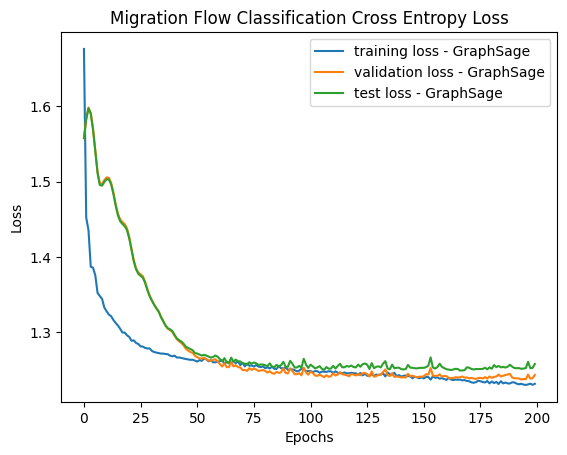

Running pipeline with config: Classification_GraphSage_simple_within_state


Training:   0%|          | 1/200 [00:00<00:34,  5.84Epochs/s]

Epoch 1: Training Loss 1.64857, Training F1 Score (Micro) 0.2086 Validation Loss 1.5243 Validation F1 Score (Micro) 0.47407
Epoch 2: Training Loss 1.44135, Training F1 Score (Micro) 0.47372 Validation Loss 1.52421 Validation F1 Score (Micro) 0.47407


Training:   2%|▏         | 4/200 [00:00<00:32,  6.00Epochs/s]

Epoch 3: Training Loss 1.45622, Training F1 Score (Micro) 0.44873 Validation Loss 1.55273 Validation F1 Score (Micro) 0.47407
Epoch 4: Training Loss 1.38853, Training F1 Score (Micro) 0.47591 Validation Loss 1.56239 Validation F1 Score (Micro) 0.47407


Training:   3%|▎         | 6/200 [00:01<00:32,  6.01Epochs/s]

Epoch 5: Training Loss 1.38423, Training F1 Score (Micro) 0.46206 Validation Loss 1.55833 Validation F1 Score (Micro) 0.47407
Epoch 6: Training Loss 1.39353, Training F1 Score (Micro) 0.46067 Validation Loss 1.54778 Validation F1 Score (Micro) 0.47407


Training:   4%|▎         | 7/200 [00:01<00:33,  5.82Epochs/s]

Epoch 7: Training Loss 1.38227, Training F1 Score (Micro) 0.46772 Validation Loss 1.53372 Validation F1 Score (Micro) 0.47407
Epoch 8: Training Loss 1.36228, Training F1 Score (Micro) 0.48056 Validation Loss 1.5185 Validation F1 Score (Micro) 0.47407


Training:   5%|▌         | 10/200 [00:01<00:32,  5.83Epochs/s]

Epoch 9: Training Loss 1.35463, Training F1 Score (Micro) 0.48858 Validation Loss 1.50397 Validation F1 Score (Micro) 0.47407
Epoch 10: Training Loss 1.35695, Training F1 Score (Micro) 0.48613 Validation Loss 1.49316 Validation F1 Score (Micro) 0.47407


Training:   6%|▌         | 12/200 [00:02<00:32,  5.81Epochs/s]

Epoch 11: Training Loss 1.35782, Training F1 Score (Micro) 0.48811 Validation Loss 1.48761 Validation F1 Score (Micro) 0.47407
Epoch 12: Training Loss 1.35252, Training F1 Score (Micro) 0.4911 Validation Loss 1.48487 Validation F1 Score (Micro) 0.47407


Training:   6%|▋         | 13/200 [00:02<00:32,  5.75Epochs/s]

Epoch 13: Training Loss 1.34924, Training F1 Score (Micro) 0.49085 Validation Loss 1.48106 Validation F1 Score (Micro) 0.47407
Epoch 14: Training Loss 1.34691, Training F1 Score (Micro) 0.48433 Validation Loss 1.47459 Validation F1 Score (Micro) 0.47407


Training:   8%|▊         | 16/200 [00:02<00:31,  5.80Epochs/s]

Epoch 15: Training Loss 1.34476, Training F1 Score (Micro) 0.47987 Validation Loss 1.46718 Validation F1 Score (Micro) 0.47407
Epoch 16: Training Loss 1.33725, Training F1 Score (Micro) 0.48219 Validation Loss 1.46098 Validation F1 Score (Micro) 0.47407


Training:   9%|▉         | 18/200 [00:03<00:30,  5.89Epochs/s]

Epoch 17: Training Loss 1.33601, Training F1 Score (Micro) 0.48563 Validation Loss 1.45868 Validation F1 Score (Micro) 0.47407
Epoch 18: Training Loss 1.33435, Training F1 Score (Micro) 0.49167 Validation Loss 1.45895 Validation F1 Score (Micro) 0.47407


Training:  10%|█         | 20/200 [00:03<00:30,  5.99Epochs/s]

Epoch 19: Training Loss 1.33329, Training F1 Score (Micro) 0.49172 Validation Loss 1.45895 Validation F1 Score (Micro) 0.47407
Epoch 20: Training Loss 1.33013, Training F1 Score (Micro) 0.49148 Validation Loss 1.45632 Validation F1 Score (Micro) 0.47407


Training:  11%|█         | 22/200 [00:03<00:29,  6.04Epochs/s]

Epoch 21: Training Loss 1.32415, Training F1 Score (Micro) 0.49361 Validation Loss 1.4502 Validation F1 Score (Micro) 0.47407
Epoch 22: Training Loss 1.32025, Training F1 Score (Micro) 0.49448 Validation Loss 1.44229 Validation F1 Score (Micro) 0.47407


Training:  12%|█▏        | 23/200 [00:03<00:31,  5.70Epochs/s]

Epoch 23: Training Loss 1.31711, Training F1 Score (Micro) 0.49594 Validation Loss 1.43528 Validation F1 Score (Micro) 0.47407
Epoch 24: Training Loss 1.31487, Training F1 Score (Micro) 0.49344 Validation Loss 1.43174 Validation F1 Score (Micro) 0.47407


Training:  13%|█▎        | 26/200 [00:04<00:30,  5.80Epochs/s]

Epoch 25: Training Loss 1.31143, Training F1 Score (Micro) 0.49597 Validation Loss 1.43113 Validation F1 Score (Micro) 0.47787
Epoch 26: Training Loss 1.30787, Training F1 Score (Micro) 0.5 Validation Loss 1.43213 Validation F1 Score (Micro) 0.50595


Training:  14%|█▍        | 28/200 [00:04<00:28,  5.97Epochs/s]

Epoch 27: Training Loss 1.30393, Training F1 Score (Micro) 0.5033 Validation Loss 1.43356 Validation F1 Score (Micro) 0.48001
Epoch 28: Training Loss 1.30155, Training F1 Score (Micro) 0.50503 Validation Loss 1.43402 Validation F1 Score (Micro) 0.44813


Training:  15%|█▌        | 30/200 [00:05<00:28,  5.95Epochs/s]

Epoch 29: Training Loss 1.29835, Training F1 Score (Micro) 0.50519 Validation Loss 1.43317 Validation F1 Score (Micro) 0.42782
Epoch 30: Training Loss 1.29492, Training F1 Score (Micro) 0.50672 Validation Loss 1.43427 Validation F1 Score (Micro) 0.40287


Training:  16%|█▌        | 31/200 [00:05<00:29,  5.78Epochs/s]

Epoch 31: Training Loss 1.29438, Training F1 Score (Micro) 0.51022 Validation Loss 1.44177 Validation F1 Score (Micro) 0.38041
Epoch 32: Training Loss 1.29232, Training F1 Score (Micro) 0.50934 Validation Loss 1.45023 Validation F1 Score (Micro) 0.36984


Training:  17%|█▋        | 34/200 [00:05<00:27,  5.97Epochs/s]

Epoch 33: Training Loss 1.28981, Training F1 Score (Micro) 0.50913 Validation Loss 1.46658 Validation F1 Score (Micro) 0.36009
Epoch 34: Training Loss 1.29017, Training F1 Score (Micro) 0.50927 Validation Loss 1.497 Validation F1 Score (Micro) 0.34159


Training:  18%|█▊        | 36/200 [00:06<00:27,  5.99Epochs/s]

Epoch 35: Training Loss 1.28734, Training F1 Score (Micro) 0.51005 Validation Loss 1.51615 Validation F1 Score (Micro) 0.33234
Epoch 36: Training Loss 1.28503, Training F1 Score (Micro) 0.50923 Validation Loss 1.51263 Validation F1 Score (Micro) 0.33845


Training:  19%|█▉        | 38/200 [00:06<00:27,  5.90Epochs/s]

Epoch 37: Training Loss 1.28528, Training F1 Score (Micro) 0.51043 Validation Loss 1.49892 Validation F1 Score (Micro) 0.34985
Epoch 38: Training Loss 1.2842, Training F1 Score (Micro) 0.51003 Validation Loss 1.48535 Validation F1 Score (Micro) 0.36092


Training:  20%|██        | 40/200 [00:06<00:26,  5.96Epochs/s]

Epoch 39: Training Loss 1.28342, Training F1 Score (Micro) 0.51038 Validation Loss 1.46123 Validation F1 Score (Micro) 0.37645
Epoch 40: Training Loss 1.28215, Training F1 Score (Micro) 0.5122 Validation Loss 1.42677 Validation F1 Score (Micro) 0.40618


Training:  21%|██        | 42/200 [00:07<00:26,  5.89Epochs/s]

Epoch 41: Training Loss 1.28191, Training F1 Score (Micro) 0.51154 Validation Loss 1.39934 Validation F1 Score (Micro) 0.43079
Epoch 42: Training Loss 1.27935, Training F1 Score (Micro) 0.51159 Validation Loss 1.38087 Validation F1 Score (Micro) 0.44698


Training:  22%|██▏       | 43/200 [00:07<00:29,  5.30Epochs/s]

Epoch 43: Training Loss 1.28076, Training F1 Score (Micro) 0.51173 Validation Loss 1.35854 Validation F1 Score (Micro) 0.46696


Training:  22%|██▏       | 44/200 [00:07<00:32,  4.78Epochs/s]

Epoch 44: Training Loss 1.27824, Training F1 Score (Micro) 0.51319 Validation Loss 1.35044 Validation F1 Score (Micro) 0.47192


Training:  22%|██▎       | 45/200 [00:07<00:33,  4.69Epochs/s]

Epoch 45: Training Loss 1.27857, Training F1 Score (Micro) 0.51062 Validation Loss 1.34383 Validation F1 Score (Micro) 0.47654


Training:  23%|██▎       | 46/200 [00:08<00:33,  4.66Epochs/s]

Epoch 46: Training Loss 1.2754, Training F1 Score (Micro) 0.51404 Validation Loss 1.33168 Validation F1 Score (Micro) 0.48646


Training:  24%|██▎       | 47/200 [00:08<00:32,  4.66Epochs/s]

Epoch 47: Training Loss 1.27726, Training F1 Score (Micro) 0.51107 Validation Loss 1.3264 Validation F1 Score (Micro) 0.49009


Training:  24%|██▍       | 48/200 [00:08<00:34,  4.46Epochs/s]

Epoch 48: Training Loss 1.27579, Training F1 Score (Micro) 0.51149 Validation Loss 1.32573 Validation F1 Score (Micro) 0.4891


Training:  24%|██▍       | 49/200 [00:08<00:35,  4.28Epochs/s]

Epoch 49: Training Loss 1.27645, Training F1 Score (Micro) 0.51012 Validation Loss 1.31651 Validation F1 Score (Micro) 0.49587


Training:  25%|██▌       | 50/200 [00:09<00:34,  4.30Epochs/s]

Epoch 50: Training Loss 1.27493, Training F1 Score (Micro) 0.5131 Validation Loss 1.31792 Validation F1 Score (Micro) 0.49389


Training:  26%|██▌       | 51/200 [00:09<00:33,  4.40Epochs/s]

Epoch 51: Training Loss 1.27433, Training F1 Score (Micro) 0.51439 Validation Loss 1.32158 Validation F1 Score (Micro) 0.49058


Training:  26%|██▌       | 52/200 [00:09<00:32,  4.50Epochs/s]

Epoch 52: Training Loss 1.27398, Training F1 Score (Micro) 0.51293 Validation Loss 1.31888 Validation F1 Score (Micro) 0.49092


Training:  26%|██▋       | 53/200 [00:09<00:33,  4.45Epochs/s]

Epoch 53: Training Loss 1.27347, Training F1 Score (Micro) 0.5134 Validation Loss 1.30993 Validation F1 Score (Micro) 0.49703


Training:  27%|██▋       | 54/200 [00:09<00:32,  4.47Epochs/s]

Epoch 54: Training Loss 1.27522, Training F1 Score (Micro) 0.51402 Validation Loss 1.32068 Validation F1 Score (Micro) 0.48992


Training:  28%|██▊       | 55/200 [00:10<00:32,  4.40Epochs/s]

Epoch 55: Training Loss 1.27228, Training F1 Score (Micro) 0.51321 Validation Loss 1.29478 Validation F1 Score (Micro) 0.50429


Training:  28%|██▊       | 56/200 [00:10<00:32,  4.50Epochs/s]

Epoch 56: Training Loss 1.2714, Training F1 Score (Micro) 0.51435 Validation Loss 1.30579 Validation F1 Score (Micro) 0.50116


Training:  28%|██▊       | 57/200 [00:10<00:32,  4.40Epochs/s]

Epoch 57: Training Loss 1.27234, Training F1 Score (Micro) 0.51331 Validation Loss 1.30225 Validation F1 Score (Micro) 0.50396


Training:  29%|██▉       | 58/200 [00:10<00:33,  4.26Epochs/s]

Epoch 58: Training Loss 1.27202, Training F1 Score (Micro) 0.51335 Validation Loss 1.28969 Validation F1 Score (Micro) 0.50859


Training:  30%|██▉       | 59/200 [00:11<00:32,  4.29Epochs/s]

Epoch 59: Training Loss 1.27173, Training F1 Score (Micro) 0.5135 Validation Loss 1.29254 Validation F1 Score (Micro) 0.50991


Training:  30%|███       | 60/200 [00:11<00:33,  4.21Epochs/s]

Epoch 60: Training Loss 1.27188, Training F1 Score (Micro) 0.51359 Validation Loss 1.30328 Validation F1 Score (Micro) 0.49752


Training:  30%|███       | 61/200 [00:11<00:32,  4.25Epochs/s]

Epoch 61: Training Loss 1.27051, Training F1 Score (Micro) 0.51288 Validation Loss 1.29058 Validation F1 Score (Micro) 0.5071


Training:  31%|███       | 62/200 [00:11<00:32,  4.27Epochs/s]

Epoch 62: Training Loss 1.26915, Training F1 Score (Micro) 0.5152 Validation Loss 1.29345 Validation F1 Score (Micro) 0.50529


Training:  32%|███▏      | 63/200 [00:12<00:31,  4.29Epochs/s]

Epoch 63: Training Loss 1.26864, Training F1 Score (Micro) 0.51694 Validation Loss 1.28764 Validation F1 Score (Micro) 0.50842


Training:  32%|███▏      | 64/200 [00:12<00:31,  4.25Epochs/s]

Epoch 64: Training Loss 1.26957, Training F1 Score (Micro) 0.51498 Validation Loss 1.28727 Validation F1 Score (Micro) 0.50991


Training:  32%|███▎      | 65/200 [00:12<00:32,  4.17Epochs/s]

Epoch 65: Training Loss 1.26802, Training F1 Score (Micro) 0.51637 Validation Loss 1.28605 Validation F1 Score (Micro) 0.50991
Epoch 66: Training Loss 1.26925, Training F1 Score (Micro) 0.51512 Validation Loss 1.28537 Validation F1 Score (Micro) 0.5071


Training:  34%|███▍      | 68/200 [00:13<00:25,  5.20Epochs/s]

Epoch 67: Training Loss 1.26775, Training F1 Score (Micro) 0.51607 Validation Loss 1.28585 Validation F1 Score (Micro) 0.50776
Epoch 68: Training Loss 1.26717, Training F1 Score (Micro) 0.5152 Validation Loss 1.28685 Validation F1 Score (Micro) 0.51156


Training:  35%|███▌      | 70/200 [00:13<00:23,  5.61Epochs/s]

Epoch 69: Training Loss 1.26824, Training F1 Score (Micro) 0.51482 Validation Loss 1.33279 Validation F1 Score (Micro) 0.49158
Epoch 70: Training Loss 1.2724, Training F1 Score (Micro) 0.51173 Validation Loss 1.2946 Validation F1 Score (Micro) 0.50958


Training:  36%|███▌      | 72/200 [00:13<00:21,  5.90Epochs/s]

Epoch 71: Training Loss 1.27189, Training F1 Score (Micro) 0.51352 Validation Loss 1.30239 Validation F1 Score (Micro) 0.50248
Epoch 72: Training Loss 1.26533, Training F1 Score (Micro) 0.51595 Validation Loss 1.31218 Validation F1 Score (Micro) 0.49736


Training:  37%|███▋      | 74/200 [00:14<00:21,  5.79Epochs/s]

Epoch 73: Training Loss 1.26875, Training F1 Score (Micro) 0.51472 Validation Loss 1.28886 Validation F1 Score (Micro) 0.50908
Epoch 74: Training Loss 1.26798, Training F1 Score (Micro) 0.5135 Validation Loss 1.28023 Validation F1 Score (Micro) 0.51123


Training:  38%|███▊      | 76/200 [00:14<00:21,  5.75Epochs/s]

Epoch 75: Training Loss 1.26504, Training F1 Score (Micro) 0.51621 Validation Loss 1.32477 Validation F1 Score (Micro) 0.49042
Epoch 76: Training Loss 1.26938, Training F1 Score (Micro) 0.51302 Validation Loss 1.27763 Validation F1 Score (Micro) 0.50727


Training:  39%|███▉      | 78/200 [00:14<00:20,  5.86Epochs/s]

Epoch 77: Training Loss 1.26473, Training F1 Score (Micro) 0.51659 Validation Loss 1.28119 Validation F1 Score (Micro) 0.50892
Epoch 78: Training Loss 1.26767, Training F1 Score (Micro) 0.51343 Validation Loss 1.27267 Validation F1 Score (Micro) 0.50958


Training:  40%|████      | 80/200 [00:15<00:20,  5.85Epochs/s]

Epoch 79: Training Loss 1.26431, Training F1 Score (Micro) 0.51671 Validation Loss 1.30778 Validation F1 Score (Micro) 0.49141
Epoch 80: Training Loss 1.2693, Training F1 Score (Micro) 0.51255 Validation Loss 1.27356 Validation F1 Score (Micro) 0.51321


Training:  41%|████      | 82/200 [00:15<00:19,  5.95Epochs/s]

Epoch 81: Training Loss 1.26322, Training F1 Score (Micro) 0.51571 Validation Loss 1.27432 Validation F1 Score (Micro) 0.51206
Epoch 82: Training Loss 1.26558, Training F1 Score (Micro) 0.51548 Validation Loss 1.32518 Validation F1 Score (Micro) 0.48381


Training:  42%|████▏     | 84/200 [00:15<00:19,  5.92Epochs/s]

Epoch 83: Training Loss 1.26482, Training F1 Score (Micro) 0.51803 Validation Loss 1.29382 Validation F1 Score (Micro) 0.49339
Epoch 84: Training Loss 1.26279, Training F1 Score (Micro) 0.51786 Validation Loss 1.27127 Validation F1 Score (Micro) 0.51338


Training:  43%|████▎     | 86/200 [00:16<00:19,  5.71Epochs/s]

Epoch 85: Training Loss 1.26369, Training F1 Score (Micro) 0.51553 Validation Loss 1.26523 Validation F1 Score (Micro) 0.51388
Epoch 86: Training Loss 1.26291, Training F1 Score (Micro) 0.51649 Validation Loss 1.29227 Validation F1 Score (Micro) 0.49405


Training:  44%|████▍     | 88/200 [00:16<00:18,  5.90Epochs/s]

Epoch 87: Training Loss 1.26608, Training F1 Score (Micro) 0.5151 Validation Loss 1.27532 Validation F1 Score (Micro) 0.51437
Epoch 88: Training Loss 1.26106, Training F1 Score (Micro) 0.51732 Validation Loss 1.28329 Validation F1 Score (Micro) 0.51487


Training:  45%|████▌     | 90/200 [00:16<00:18,  5.90Epochs/s]

Epoch 89: Training Loss 1.26061, Training F1 Score (Micro) 0.51715 Validation Loss 1.2718 Validation F1 Score (Micro) 0.50496
Epoch 90: Training Loss 1.26068, Training F1 Score (Micro) 0.51899 Validation Loss 1.26415 Validation F1 Score (Micro) 0.5152


Training:  46%|████▌     | 92/200 [00:17<00:18,  5.86Epochs/s]

Epoch 91: Training Loss 1.26031, Training F1 Score (Micro) 0.51921 Validation Loss 1.28777 Validation F1 Score (Micro) 0.50595
Epoch 92: Training Loss 1.2601, Training F1 Score (Micro) 0.51788 Validation Loss 1.38335 Validation F1 Score (Micro) 0.47539


Training:  47%|████▋     | 94/200 [00:17<00:18,  5.82Epochs/s]

Epoch 93: Training Loss 1.25912, Training F1 Score (Micro) 0.5185 Validation Loss 1.33128 Validation F1 Score (Micro) 0.48745
Epoch 94: Training Loss 1.25978, Training F1 Score (Micro) 0.51704 Validation Loss 1.36472 Validation F1 Score (Micro) 0.47572


Training:  48%|████▊     | 96/200 [00:17<00:17,  5.85Epochs/s]

Epoch 95: Training Loss 1.25839, Training F1 Score (Micro) 0.51843 Validation Loss 1.36036 Validation F1 Score (Micro) 0.47522
Epoch 96: Training Loss 1.25685, Training F1 Score (Micro) 0.51954 Validation Loss 1.30879 Validation F1 Score (Micro) 0.49009


Training:  49%|████▉     | 98/200 [00:18<00:17,  5.87Epochs/s]

Epoch 97: Training Loss 1.25853, Training F1 Score (Micro) 0.5181 Validation Loss 1.36803 Validation F1 Score (Micro) 0.47902
Epoch 98: Training Loss 1.25595, Training F1 Score (Micro) 0.52013 Validation Loss 1.39154 Validation F1 Score (Micro) 0.47539


Training:  50%|█████     | 100/200 [00:18<00:16,  5.94Epochs/s]

Epoch 99: Training Loss 1.25455, Training F1 Score (Micro) 0.52091 Validation Loss 1.33984 Validation F1 Score (Micro) 0.48431
Epoch 100: Training Loss 1.25664, Training F1 Score (Micro) 0.51876 Validation Loss 1.37354 Validation F1 Score (Micro) 0.4744


Training:  51%|█████     | 102/200 [00:18<00:16,  6.03Epochs/s]

Epoch 101: Training Loss 1.25603, Training F1 Score (Micro) 0.51812 Validation Loss 1.39062 Validation F1 Score (Micro) 0.481
Epoch 102: Training Loss 1.2574, Training F1 Score (Micro) 0.51862 Validation Loss 1.46502 Validation F1 Score (Micro) 0.47407


Training:  52%|█████▏    | 104/200 [00:19<00:16,  5.94Epochs/s]

Epoch 103: Training Loss 1.25757, Training F1 Score (Micro) 0.51807 Validation Loss 1.30318 Validation F1 Score (Micro) 0.49438
Epoch 104: Training Loss 1.25932, Training F1 Score (Micro) 0.51472 Validation Loss 1.51027 Validation F1 Score (Micro) 0.47407


Training:  53%|█████▎    | 106/200 [00:19<00:15,  6.06Epochs/s]

Epoch 105: Training Loss 1.26725, Training F1 Score (Micro) 0.51406 Validation Loss 1.38016 Validation F1 Score (Micro) 0.48646
Epoch 106: Training Loss 1.26359, Training F1 Score (Micro) 0.51453 Validation Loss 1.38363 Validation F1 Score (Micro) 0.47572


Training:  54%|█████▍    | 108/200 [00:19<00:15,  6.11Epochs/s]

Epoch 107: Training Loss 1.2571, Training F1 Score (Micro) 0.51973 Validation Loss 1.45552 Validation F1 Score (Micro) 0.47407
Epoch 108: Training Loss 1.26188, Training F1 Score (Micro) 0.51583 Validation Loss 1.38023 Validation F1 Score (Micro) 0.49108


Training:  55%|█████▌    | 110/200 [00:20<00:14,  6.12Epochs/s]

Epoch 109: Training Loss 1.25615, Training F1 Score (Micro) 0.51706 Validation Loss 1.36115 Validation F1 Score (Micro) 0.49604
Epoch 110: Training Loss 1.25893, Training F1 Score (Micro) 0.51682 Validation Loss 1.39554 Validation F1 Score (Micro) 0.47423


Training:  56%|█████▌    | 112/200 [00:20<00:14,  6.15Epochs/s]

Epoch 111: Training Loss 1.25797, Training F1 Score (Micro) 0.51758 Validation Loss 1.36475 Validation F1 Score (Micro) 0.47489
Epoch 112: Training Loss 1.25474, Training F1 Score (Micro) 0.51991 Validation Loss 1.39578 Validation F1 Score (Micro) 0.47638


Training:  57%|█████▋    | 114/200 [00:20<00:14,  6.11Epochs/s]

Epoch 113: Training Loss 1.25532, Training F1 Score (Micro) 0.52074 Validation Loss 1.39808 Validation F1 Score (Micro) 0.47489
Epoch 114: Training Loss 1.25511, Training F1 Score (Micro) 0.51991 Validation Loss 1.2912 Validation F1 Score (Micro) 0.48233


Training:  58%|█████▊    | 116/200 [00:21<00:13,  6.05Epochs/s]

Epoch 115: Training Loss 1.25412, Training F1 Score (Micro) 0.52022 Validation Loss 1.27247 Validation F1 Score (Micro) 0.50363
Epoch 116: Training Loss 1.25326, Training F1 Score (Micro) 0.51987 Validation Loss 1.32535 Validation F1 Score (Micro) 0.48282


Training:  59%|█████▉    | 118/200 [00:21<00:13,  6.07Epochs/s]

Epoch 117: Training Loss 1.25366, Training F1 Score (Micro) 0.52027 Validation Loss 1.28392 Validation F1 Score (Micro) 0.50231
Epoch 118: Training Loss 1.25505, Training F1 Score (Micro) 0.5189 Validation Loss 1.31616 Validation F1 Score (Micro) 0.47721


Training:  60%|██████    | 120/200 [00:21<00:13,  5.93Epochs/s]

Epoch 119: Training Loss 1.2566, Training F1 Score (Micro) 0.51921 Validation Loss 1.2668 Validation F1 Score (Micro) 0.51668
Epoch 120: Training Loss 1.25802, Training F1 Score (Micro) 0.51583 Validation Loss 1.47415 Validation F1 Score (Micro) 0.47423


Training:  60%|██████    | 121/200 [00:21<00:13,  5.89Epochs/s]

Epoch 121: Training Loss 1.25563, Training F1 Score (Micro) 0.52032 Validation Loss 1.47374 Validation F1 Score (Micro) 0.47588
Epoch 122: Training Loss 1.25648, Training F1 Score (Micro) 0.52107 Validation Loss 1.36499 Validation F1 Score (Micro) 0.49835


Training:  62%|██████▏   | 124/200 [00:22<00:12,  5.92Epochs/s]

Epoch 123: Training Loss 1.25831, Training F1 Score (Micro) 0.51522 Validation Loss 1.40074 Validation F1 Score (Micro) 0.48381
Epoch 124: Training Loss 1.25641, Training F1 Score (Micro) 0.51855 Validation Loss 1.49366 Validation F1 Score (Micro) 0.47473


Training:  62%|██████▎   | 125/200 [00:22<00:13,  5.38Epochs/s]

Epoch 125: Training Loss 1.254, Training F1 Score (Micro) 0.52069 Validation Loss 1.42875 Validation F1 Score (Micro) 0.47704


Training:  63%|██████▎   | 126/200 [00:22<00:15,  4.90Epochs/s]

Epoch 126: Training Loss 1.25565, Training F1 Score (Micro) 0.52013 Validation Loss 1.29818 Validation F1 Score (Micro) 0.48662


Training:  64%|██████▎   | 127/200 [00:23<00:15,  4.64Epochs/s]

Epoch 127: Training Loss 1.25446, Training F1 Score (Micro) 0.51951 Validation Loss 1.25942 Validation F1 Score (Micro) 0.51041


Training:  64%|██████▍   | 128/200 [00:23<00:15,  4.61Epochs/s]

Epoch 128: Training Loss 1.25408, Training F1 Score (Micro) 0.51987 Validation Loss 1.24935 Validation F1 Score (Micro) 0.52032


Training:  64%|██████▍   | 129/200 [00:23<00:15,  4.61Epochs/s]

Epoch 129: Training Loss 1.25307, Training F1 Score (Micro) 0.5197 Validation Loss 1.25406 Validation F1 Score (Micro) 0.51487


Training:  65%|██████▌   | 130/200 [00:23<00:15,  4.60Epochs/s]

Epoch 130: Training Loss 1.25261, Training F1 Score (Micro) 0.52086 Validation Loss 1.25491 Validation F1 Score (Micro) 0.51437


Training:  66%|██████▌   | 131/200 [00:24<00:15,  4.51Epochs/s]

Epoch 131: Training Loss 1.25134, Training F1 Score (Micro) 0.52267 Validation Loss 1.28326 Validation F1 Score (Micro) 0.47737


Training:  66%|██████▌   | 132/200 [00:24<00:15,  4.40Epochs/s]

Epoch 132: Training Loss 1.25435, Training F1 Score (Micro) 0.52112 Validation Loss 1.25513 Validation F1 Score (Micro) 0.51635


Training:  66%|██████▋   | 133/200 [00:24<00:15,  4.38Epochs/s]

Epoch 133: Training Loss 1.26017, Training F1 Score (Micro) 0.51359 Validation Loss 1.50517 Validation F1 Score (Micro) 0.47489


Training:  67%|██████▋   | 134/200 [00:24<00:14,  4.42Epochs/s]

Epoch 134: Training Loss 1.2559, Training F1 Score (Micro) 0.52015 Validation Loss 1.44522 Validation F1 Score (Micro) 0.47687


Training:  68%|██████▊   | 135/200 [00:25<00:14,  4.51Epochs/s]

Epoch 135: Training Loss 1.25288, Training F1 Score (Micro) 0.52091 Validation Loss 1.34797 Validation F1 Score (Micro) 0.47605


Training:  68%|██████▊   | 136/200 [00:25<00:14,  4.46Epochs/s]

Epoch 136: Training Loss 1.25293, Training F1 Score (Micro) 0.51869 Validation Loss 1.31879 Validation F1 Score (Micro) 0.47621


Training:  68%|██████▊   | 137/200 [00:25<00:14,  4.45Epochs/s]

Epoch 137: Training Loss 1.25493, Training F1 Score (Micro) 0.51824 Validation Loss 1.36428 Validation F1 Score (Micro) 0.47522


Training:  69%|██████▉   | 138/200 [00:25<00:13,  4.47Epochs/s]

Epoch 138: Training Loss 1.25279, Training F1 Score (Micro) 0.51975 Validation Loss 1.39089 Validation F1 Score (Micro) 0.47572


Training:  70%|██████▉   | 139/200 [00:25<00:14,  4.32Epochs/s]

Epoch 139: Training Loss 1.25339, Training F1 Score (Micro) 0.52133 Validation Loss 1.37819 Validation F1 Score (Micro) 0.4744


Training:  70%|███████   | 140/200 [00:26<00:13,  4.30Epochs/s]

Epoch 140: Training Loss 1.25161, Training F1 Score (Micro) 0.52157 Validation Loss 1.31958 Validation F1 Score (Micro) 0.47522


Training:  70%|███████   | 141/200 [00:26<00:13,  4.28Epochs/s]

Epoch 141: Training Loss 1.25127, Training F1 Score (Micro) 0.52095 Validation Loss 1.26521 Validation F1 Score (Micro) 0.49554


Training:  71%|███████   | 142/200 [00:26<00:13,  4.29Epochs/s]

Epoch 142: Training Loss 1.25131, Training F1 Score (Micro) 0.51973 Validation Loss 1.30949 Validation F1 Score (Micro) 0.48299


Training:  72%|███████▏  | 143/200 [00:26<00:13,  4.23Epochs/s]

Epoch 143: Training Loss 1.25358, Training F1 Score (Micro) 0.52147 Validation Loss 1.26017 Validation F1 Score (Micro) 0.51718


Training:  72%|███████▏  | 144/200 [00:27<00:13,  4.27Epochs/s]

Epoch 144: Training Loss 1.26209, Training F1 Score (Micro) 0.51489 Validation Loss 1.32144 Validation F1 Score (Micro) 0.47539


Training:  72%|███████▎  | 145/200 [00:27<00:12,  4.35Epochs/s]

Epoch 145: Training Loss 1.26095, Training F1 Score (Micro) 0.51685 Validation Loss 1.313 Validation F1 Score (Micro) 0.47555


Training:  74%|███████▎  | 147/200 [00:27<00:11,  4.81Epochs/s]

Epoch 146: Training Loss 1.25585, Training F1 Score (Micro) 0.52086 Validation Loss 1.34174 Validation F1 Score (Micro) 0.47704
Epoch 147: Training Loss 1.2562, Training F1 Score (Micro) 0.51654 Validation Loss 1.43297 Validation F1 Score (Micro) 0.47489


Training:  74%|███████▍  | 149/200 [00:28<00:09,  5.33Epochs/s]

Epoch 148: Training Loss 1.25366, Training F1 Score (Micro) 0.52116 Validation Loss 1.4556 Validation F1 Score (Micro) 0.47522
Epoch 149: Training Loss 1.25552, Training F1 Score (Micro) 0.5194 Validation Loss 1.33535 Validation F1 Score (Micro) 0.50347


Training:  76%|███████▌  | 151/200 [00:28<00:08,  5.72Epochs/s]

Epoch 150: Training Loss 1.25581, Training F1 Score (Micro) 0.51897 Validation Loss 1.27292 Validation F1 Score (Micro) 0.51189
Epoch 151: Training Loss 1.2523, Training F1 Score (Micro) 0.51942 Validation Loss 1.25019 Validation F1 Score (Micro) 0.51718


Training:  76%|███████▋  | 153/200 [00:28<00:08,  5.80Epochs/s]

Epoch 152: Training Loss 1.2559, Training F1 Score (Micro) 0.51873 Validation Loss 1.25368 Validation F1 Score (Micro) 0.51751
Epoch 153: Training Loss 1.25342, Training F1 Score (Micro) 0.51977 Validation Loss 1.26992 Validation F1 Score (Micro) 0.51123


Training:  78%|███████▊  | 155/200 [00:29<00:07,  5.91Epochs/s]

Epoch 154: Training Loss 1.25448, Training F1 Score (Micro) 0.51855 Validation Loss 1.33716 Validation F1 Score (Micro) 0.47687
Epoch 155: Training Loss 1.25161, Training F1 Score (Micro) 0.52074 Validation Loss 1.34295 Validation F1 Score (Micro) 0.47721


Training:  78%|███████▊  | 157/200 [00:29<00:07,  5.96Epochs/s]

Epoch 156: Training Loss 1.25205, Training F1 Score (Micro) 0.51963 Validation Loss 1.25308 Validation F1 Score (Micro) 0.51437
Epoch 157: Training Loss 1.25099, Training F1 Score (Micro) 0.51876 Validation Loss 1.24306 Validation F1 Score (Micro) 0.5223


Training:  80%|███████▉  | 159/200 [00:29<00:07,  5.81Epochs/s]

Epoch 158: Training Loss 1.24875, Training F1 Score (Micro) 0.5223 Validation Loss 1.25321 Validation F1 Score (Micro) 0.50859
Epoch 159: Training Loss 1.25062, Training F1 Score (Micro) 0.52249 Validation Loss 1.24608 Validation F1 Score (Micro) 0.52015


Training:  80%|████████  | 161/200 [00:30<00:06,  5.91Epochs/s]

Epoch 160: Training Loss 1.25005, Training F1 Score (Micro) 0.52272 Validation Loss 1.25094 Validation F1 Score (Micro) 0.52445
Epoch 161: Training Loss 1.25077, Training F1 Score (Micro) 0.52291 Validation Loss 1.25595 Validation F1 Score (Micro) 0.51734


Training:  82%|████████▏ | 163/200 [00:30<00:06,  5.95Epochs/s]

Epoch 162: Training Loss 1.24976, Training F1 Score (Micro) 0.5231 Validation Loss 1.25366 Validation F1 Score (Micro) 0.52065
Epoch 163: Training Loss 1.25055, Training F1 Score (Micro) 0.52164 Validation Loss 1.24523 Validation F1 Score (Micro) 0.51949


Training:  82%|████████▎ | 165/200 [00:30<00:05,  6.02Epochs/s]

Epoch 164: Training Loss 1.25069, Training F1 Score (Micro) 0.52029 Validation Loss 1.30606 Validation F1 Score (Micro) 0.4891
Epoch 165: Training Loss 1.25073, Training F1 Score (Micro) 0.52308 Validation Loss 1.32606 Validation F1 Score (Micro) 0.48695


Training:  84%|████████▎ | 167/200 [00:31<00:05,  5.96Epochs/s]

Epoch 166: Training Loss 1.24847, Training F1 Score (Micro) 0.52204 Validation Loss 1.29891 Validation F1 Score (Micro) 0.50083
Epoch 167: Training Loss 1.2492, Training F1 Score (Micro) 0.52194 Validation Loss 1.30132 Validation F1 Score (Micro) 0.50413


Training:  84%|████████▍ | 169/200 [00:31<00:05,  6.01Epochs/s]

Epoch 168: Training Loss 1.24878, Training F1 Score (Micro) 0.52239 Validation Loss 1.24985 Validation F1 Score (Micro) 0.52246
Epoch 169: Training Loss 1.25118, Training F1 Score (Micro) 0.52093 Validation Loss 1.31541 Validation F1 Score (Micro) 0.50149


Training:  86%|████████▌ | 171/200 [00:31<00:04,  5.92Epochs/s]

Epoch 170: Training Loss 1.24918, Training F1 Score (Micro) 0.52175 Validation Loss 1.32618 Validation F1 Score (Micro) 0.48084
Epoch 171: Training Loss 1.24804, Training F1 Score (Micro) 0.52284 Validation Loss 1.36598 Validation F1 Score (Micro) 0.4777


Training:  86%|████████▋ | 173/200 [00:32<00:04,  5.93Epochs/s]

Epoch 172: Training Loss 1.24888, Training F1 Score (Micro) 0.52154 Validation Loss 1.41273 Validation F1 Score (Micro) 0.47787
Epoch 173: Training Loss 1.24865, Training F1 Score (Micro) 0.52282 Validation Loss 1.37932 Validation F1 Score (Micro) 0.48728


Training:  88%|████████▊ | 175/200 [00:32<00:04,  6.06Epochs/s]

Epoch 174: Training Loss 1.24625, Training F1 Score (Micro) 0.5226 Validation Loss 1.3189 Validation F1 Score (Micro) 0.50132
Epoch 175: Training Loss 1.24898, Training F1 Score (Micro) 0.521 Validation Loss 1.39847 Validation F1 Score (Micro) 0.47687


Training:  88%|████████▊ | 177/200 [00:32<00:03,  5.97Epochs/s]

Epoch 176: Training Loss 1.25314, Training F1 Score (Micro) 0.52208 Validation Loss 1.27064 Validation F1 Score (Micro) 0.51536
Epoch 177: Training Loss 1.25808, Training F1 Score (Micro) 0.51496 Validation Loss 1.31118 Validation F1 Score (Micro) 0.50116


Training:  90%|████████▉ | 179/200 [00:33<00:03,  6.00Epochs/s]

Epoch 178: Training Loss 1.24809, Training F1 Score (Micro) 0.52201 Validation Loss 1.40596 Validation F1 Score (Micro) 0.47671
Epoch 179: Training Loss 1.25718, Training F1 Score (Micro) 0.51767 Validation Loss 1.36185 Validation F1 Score (Micro) 0.49504


Training:  90%|█████████ | 181/200 [00:33<00:03,  6.09Epochs/s]

Epoch 180: Training Loss 1.24997, Training F1 Score (Micro) 0.52008 Validation Loss 1.35399 Validation F1 Score (Micro) 0.49917
Epoch 181: Training Loss 1.25347, Training F1 Score (Micro) 0.51807 Validation Loss 1.409 Validation F1 Score (Micro) 0.47985


Training:  92%|█████████▏| 183/200 [00:33<00:02,  6.10Epochs/s]

Epoch 182: Training Loss 1.24943, Training F1 Score (Micro) 0.521 Validation Loss 1.45514 Validation F1 Score (Micro) 0.47522
Epoch 183: Training Loss 1.25506, Training F1 Score (Micro) 0.51871 Validation Loss 1.27089 Validation F1 Score (Micro) 0.51189


Training:  92%|█████████▎| 185/200 [00:34<00:02,  6.01Epochs/s]

Epoch 184: Training Loss 1.25066, Training F1 Score (Micro) 0.52105 Validation Loss 1.25726 Validation F1 Score (Micro) 0.51454
Epoch 185: Training Loss 1.25351, Training F1 Score (Micro) 0.51973 Validation Loss 1.28711 Validation F1 Score (Micro) 0.50925


Training:  94%|█████████▎| 187/200 [00:34<00:02,  5.94Epochs/s]

Epoch 186: Training Loss 1.24875, Training F1 Score (Micro) 0.52223 Validation Loss 1.3107 Validation F1 Score (Micro) 0.49438
Epoch 187: Training Loss 1.2514, Training F1 Score (Micro) 0.52116 Validation Loss 1.27759 Validation F1 Score (Micro) 0.49785


Training:  94%|█████████▍| 189/200 [00:34<00:01,  5.89Epochs/s]

Epoch 188: Training Loss 1.24769, Training F1 Score (Micro) 0.52272 Validation Loss 1.25743 Validation F1 Score (Micro) 0.51685
Epoch 189: Training Loss 1.25393, Training F1 Score (Micro) 0.51944 Validation Loss 1.25049 Validation F1 Score (Micro) 0.51503


Training:  96%|█████████▌| 191/200 [00:35<00:01,  5.94Epochs/s]

Epoch 190: Training Loss 1.24799, Training F1 Score (Micro) 0.52267 Validation Loss 1.25451 Validation F1 Score (Micro) 0.51024
Epoch 191: Training Loss 1.24972, Training F1 Score (Micro) 0.52298 Validation Loss 1.23578 Validation F1 Score (Micro) 0.52445


Training:  96%|█████████▋| 193/200 [00:35<00:01,  6.05Epochs/s]

Epoch 192: Training Loss 1.24689, Training F1 Score (Micro) 0.52312 Validation Loss 1.25137 Validation F1 Score (Micro) 0.51966
Epoch 193: Training Loss 1.24933, Training F1 Score (Micro) 0.51977 Validation Loss 1.25979 Validation F1 Score (Micro) 0.52131


Training:  98%|█████████▊| 195/200 [00:35<00:00,  5.95Epochs/s]

Epoch 194: Training Loss 1.24701, Training F1 Score (Micro) 0.5231 Validation Loss 1.2596 Validation F1 Score (Micro) 0.52279
Epoch 195: Training Loss 1.24805, Training F1 Score (Micro) 0.52199 Validation Loss 1.26435 Validation F1 Score (Micro) 0.52065


Training:  98%|█████████▊| 197/200 [00:36<00:00,  6.04Epochs/s]

Epoch 196: Training Loss 1.24807, Training F1 Score (Micro) 0.52131 Validation Loss 1.2425 Validation F1 Score (Micro) 0.51949
Epoch 197: Training Loss 1.24692, Training F1 Score (Micro) 0.52272 Validation Loss 1.28769 Validation F1 Score (Micro) 0.47737


Training: 100%|█████████▉| 199/200 [00:36<00:00,  6.14Epochs/s]

Epoch 198: Training Loss 1.2496, Training F1 Score (Micro) 0.52199 Validation Loss 1.27377 Validation F1 Score (Micro) 0.48282
Epoch 199: Training Loss 1.24812, Training F1 Score (Micro) 0.52149 Validation Loss 1.34185 Validation F1 Score (Micro) 0.47687


Training: 100%|██████████| 200/200 [00:36<00:00,  5.46Epochs/s]


Epoch 200: Training Loss 1.24703, Training F1 Score (Micro) 0.52232 Validation Loss 1.43652 Validation F1 Score (Micro) 0.47902
Saving Model Predictions for Model Type GraphSage
Model saved successfully as Classification_GraphSage_simple_within_state
Minimum validation loss: 1.2357771396636963
Minimum test loss: 1.2520766258239746
Best test metric: 0.5242814421653748


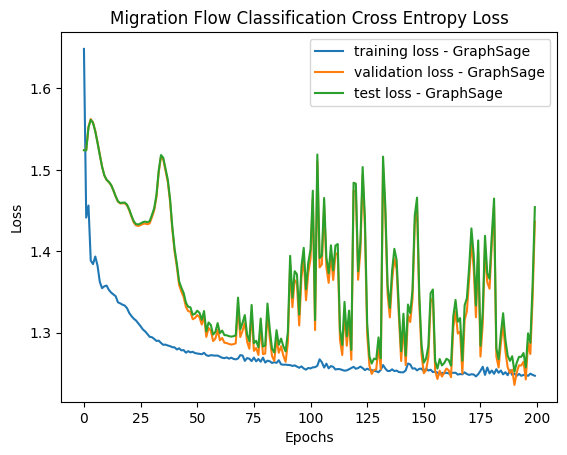

Running pipeline with config: Regression_GAT_full_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 2.63184, Training R2 -1.71281 Validation Loss 3.38043 Validation R2 -2.1887


Training:   0%|          | 1/200 [00:01<05:16,  1.59s/Epochs]

Epoch 2: Training Loss 1.84002, Training R2 -0.29074 Validation Loss 14.72074 Validation R2 -45.84473


Training:   2%|▏         | 3/200 [00:04<04:37,  1.41s/Epochs]

Epoch 3: Training Loss 1.76566, Training R2 -0.27143 Validation Loss 26.01967 Validation R2 -144.39178
Epoch 4: Training Loss 2.22212, Training R2 -0.88379 Validation Loss 18.23777 Validation R2 -70.52591


Training:   2%|▎         | 5/200 [00:06<04:16,  1.32s/Epochs]

Epoch 5: Training Loss 1.62782, Training R2 0.07651 Validation Loss 15.37164 Validation R2 -50.04156


Training:   3%|▎         | 6/200 [00:08<04:06,  1.27s/Epochs]

Epoch 6: Training Loss 1.70952, Training R2 -0.00947 Validation Loss 16.38211 Validation R2 -57.09255
Epoch 7: Training Loss 1.48299, Training R2 0.10646 Validation Loss 15.65102 Validation R2 -53.18088


Training:   4%|▎         | 7/200 [00:09<04:15,  1.33s/Epochs]

Epoch 8: Training Loss 1.59631, Training R2 -0.08869 Validation Loss 13.929 Validation R2 -41.84833


Training:   4%|▍         | 9/200 [00:12<04:38,  1.46s/Epochs]

Epoch 9: Training Loss 1.50428, Training R2 0.0252 Validation Loss 10.10588 Validation R2 -21.8133


Training:   5%|▌         | 10/200 [00:13<04:18,  1.36s/Epochs]

Epoch 10: Training Loss 1.47405, Training R2 0.09254 Validation Loss 7.6324 Validation R2 -12.28216


Training:   6%|▌         | 11/200 [00:15<04:14,  1.35s/Epochs]

Epoch 11: Training Loss 1.4978, Training R2 0.09799 Validation Loss 6.89926 Validation R2 -10.00771


Training:   6%|▌         | 12/200 [00:16<04:05,  1.31s/Epochs]

Epoch 12: Training Loss 1.44311, Training R2 0.15329 Validation Loss 6.93732 Validation R2 -10.20703


Training:   6%|▋         | 13/200 [00:17<03:58,  1.27s/Epochs]

Epoch 13: Training Loss 1.42843, Training R2 0.16145 Validation Loss 6.31727 Validation R2 -8.45193


Training:   7%|▋         | 14/200 [00:18<03:39,  1.18s/Epochs]

Epoch 14: Training Loss 1.45948, Training R2 0.13199 Validation Loss 5.2346 Validation R2 -5.66735


Training:   8%|▊         | 15/200 [00:19<03:23,  1.10s/Epochs]

Epoch 15: Training Loss 1.42179, Training R2 0.19233 Validation Loss 4.41732 Validation R2 -3.90038


Training:   8%|▊         | 16/200 [00:20<03:08,  1.02s/Epochs]

Epoch 16: Training Loss 1.42145, Training R2 0.20402 Validation Loss 3.87861 Validation R2 -2.89867


Training:   8%|▊         | 17/200 [00:21<02:57,  1.03Epochs/s]

Epoch 17: Training Loss 1.41462, Training R2 0.2097 Validation Loss 3.54103 Validation R2 -2.33099


Training:   9%|▉         | 18/200 [00:22<02:53,  1.05Epochs/s]

Epoch 18: Training Loss 1.39322, Training R2 0.21345 Validation Loss 3.31709 Validation R2 -1.97973


Training:  10%|▉         | 19/200 [00:23<02:56,  1.03Epochs/s]

Epoch 19: Training Loss 1.39142, Training R2 0.20407 Validation Loss 2.90125 Validation R2 -1.36127


Training:  10%|█         | 20/200 [00:24<02:53,  1.04Epochs/s]

Epoch 20: Training Loss 1.38523, Training R2 0.20579 Validation Loss 2.42851 Validation R2 -0.74532


Training:  10%|█         | 21/200 [00:24<02:49,  1.05Epochs/s]

Epoch 21: Training Loss 1.36163, Training R2 0.22374 Validation Loss 1.97429 Validation R2 -0.24669


Training:  11%|█         | 22/200 [00:25<02:47,  1.06Epochs/s]

Epoch 22: Training Loss 1.37867, Training R2 0.21672 Validation Loss 1.69036 Validation R2 0.02948


Training:  12%|█▏        | 23/200 [00:26<02:49,  1.04Epochs/s]

Epoch 23: Training Loss 1.38442, Training R2 0.21617 Validation Loss 1.5302 Validation R2 0.17955


Training:  12%|█▏        | 24/200 [00:27<02:52,  1.02Epochs/s]

Epoch 24: Training Loss 1.36993, Training R2 0.21784 Validation Loss 1.46315 Validation R2 0.23731


Training:  12%|█▎        | 25/200 [00:29<03:12,  1.10s/Epochs]

Epoch 25: Training Loss 1.36873, Training R2 0.21137 Validation Loss 1.43071 Validation R2 0.2611


Training:  13%|█▎        | 26/200 [00:30<03:21,  1.16s/Epochs]

Epoch 26: Training Loss 1.39522, Training R2 0.18215 Validation Loss 1.50856 Validation R2 0.22858


Training:  14%|█▎        | 27/200 [00:31<03:30,  1.22s/Epochs]

Epoch 27: Training Loss 1.36218, Training R2 0.22183 Validation Loss 1.7022 Validation R2 0.1172


Training:  14%|█▍        | 28/200 [00:33<03:19,  1.16s/Epochs]

Epoch 28: Training Loss 1.3646, Training R2 0.23836 Validation Loss 1.80696 Validation R2 0.03371


Training:  14%|█▍        | 29/200 [00:34<03:12,  1.12s/Epochs]

Epoch 29: Training Loss 1.36679, Training R2 0.2443 Validation Loss 1.77923 Validation R2 0.04616


Training:  15%|█▌        | 30/200 [00:35<03:05,  1.09s/Epochs]

Epoch 30: Training Loss 1.36064, Training R2 0.24382 Validation Loss 1.67724 Validation R2 0.10635


Training:  16%|█▌        | 31/200 [00:36<02:58,  1.06s/Epochs]

Epoch 31: Training Loss 1.36152, Training R2 0.22889 Validation Loss 1.64469 Validation R2 0.12702


Training:  16%|█▌        | 32/200 [00:36<02:49,  1.01s/Epochs]

Epoch 32: Training Loss 1.35877, Training R2 0.228 Validation Loss 1.68613 Validation R2 0.10854


Training:  16%|█▋        | 33/200 [00:37<02:43,  1.02Epochs/s]

Epoch 33: Training Loss 1.3425, Training R2 0.25085 Validation Loss 1.77121 Validation R2 0.05835


Training:  17%|█▋        | 34/200 [00:38<02:43,  1.02Epochs/s]

Epoch 34: Training Loss 1.35242, Training R2 0.25285 Validation Loss 1.81052 Validation R2 0.02728


Training:  18%|█▊        | 35/200 [00:40<02:51,  1.04s/Epochs]

Epoch 35: Training Loss 1.3651, Training R2 0.24695 Validation Loss 1.75076 Validation R2 0.06977


Training:  18%|█▊        | 36/200 [00:41<02:52,  1.05s/Epochs]

Epoch 36: Training Loss 1.33927, Training R2 0.26258 Validation Loss 1.66509 Validation R2 0.11571


Training:  18%|█▊        | 37/200 [00:42<02:56,  1.08s/Epochs]

Epoch 37: Training Loss 1.33082, Training R2 0.25805 Validation Loss 1.65651 Validation R2 0.10597


Training:  19%|█▉        | 38/200 [00:43<03:10,  1.18s/Epochs]

Epoch 38: Training Loss 1.37365, Training R2 0.21396 Validation Loss 1.77955 Validation R2 0.01411
Epoch 39: Training Loss 1.33804, Training R2 0.25044 Validation Loss 1.94646 Validation R2 -0.14328


Training:  20%|██        | 40/200 [00:46<03:39,  1.37s/Epochs]

Epoch 40: Training Loss 1.329, Training R2 0.26595 Validation Loss 2.07246 Validation R2 -0.29142


Training:  20%|██        | 41/200 [00:47<03:29,  1.32s/Epochs]

Epoch 41: Training Loss 1.35987, Training R2 0.24606 Validation Loss 2.11193 Validation R2 -0.34842


Training:  21%|██        | 42/200 [00:49<03:15,  1.24s/Epochs]

Epoch 42: Training Loss 1.32843, Training R2 0.26935 Validation Loss 2.10871 Validation R2 -0.35177


Training:  22%|██▏       | 43/200 [00:50<03:09,  1.20s/Epochs]

Epoch 43: Training Loss 1.31784, Training R2 0.27069 Validation Loss 2.12675 Validation R2 -0.37934


Training:  22%|██▏       | 44/200 [00:51<03:02,  1.17s/Epochs]

Epoch 44: Training Loss 1.35157, Training R2 0.23759 Validation Loss 2.19864 Validation R2 -0.47326
Epoch 45: Training Loss 1.33373, Training R2 0.2539 Validation Loss 2.27317 Validation R2 -0.57914


Training:  23%|██▎       | 46/200 [00:53<02:56,  1.15s/Epochs]

Epoch 46: Training Loss 1.32045, Training R2 0.27104 Validation Loss 2.32568 Validation R2 -0.65955


Training:  24%|██▎       | 47/200 [00:54<02:55,  1.15s/Epochs]

Epoch 47: Training Loss 1.32442, Training R2 0.27583 Validation Loss 2.30821 Validation R2 -0.63281


Training:  24%|██▍       | 48/200 [00:55<02:49,  1.11s/Epochs]

Epoch 48: Training Loss 1.32032, Training R2 0.27781 Validation Loss 2.23273 Validation R2 -0.5207


Training:  24%|██▍       | 49/200 [00:56<02:42,  1.08s/Epochs]

Epoch 49: Training Loss 1.31603, Training R2 0.27366 Validation Loss 2.14199 Validation R2 -0.39527


Training:  25%|██▌       | 50/200 [00:58<02:54,  1.16s/Epochs]

Epoch 50: Training Loss 1.32074, Training R2 0.26471 Validation Loss 2.10922 Validation R2 -0.34957
Epoch 51: Training Loss 1.30975, Training R2 0.27708 Validation Loss 2.11024 Validation R2 -0.34616


Training:  26%|██▌       | 51/200 [00:59<03:14,  1.30s/Epochs]

Epoch 52: Training Loss 1.30696, Training R2 0.28604 Validation Loss 2.08669 Validation R2 -0.3138


Training:  26%|██▌       | 52/200 [01:01<03:27,  1.40s/Epochs]

Epoch 53: Training Loss 1.30904, Training R2 0.28399 Validation Loss 2.01558 Validation R2 -0.22859


Training:  27%|██▋       | 54/200 [01:03<03:07,  1.28s/Epochs]

Epoch 54: Training Loss 1.30573, Training R2 0.28409 Validation Loss 1.987 Validation R2 -0.19711


Training:  28%|██▊       | 55/200 [01:04<02:55,  1.21s/Epochs]

Epoch 55: Training Loss 1.30599, Training R2 0.28127 Validation Loss 2.01683 Validation R2 -0.23065


Training:  28%|██▊       | 56/200 [01:05<02:49,  1.17s/Epochs]

Epoch 56: Training Loss 1.30111, Training R2 0.2885 Validation Loss 2.06262 Validation R2 -0.28635
Epoch 57: Training Loss 1.29784, Training R2 0.29169 Validation Loss 2.1324 Validation R2 -0.37735


Training:  29%|██▉       | 58/200 [01:08<02:45,  1.17s/Epochs]

Epoch 58: Training Loss 1.30308, Training R2 0.29195 Validation Loss 2.16663 Validation R2 -0.42763


Training:  30%|██▉       | 59/200 [01:09<02:38,  1.12s/Epochs]

Epoch 59: Training Loss 1.29232, Training R2 0.30168 Validation Loss 2.18135 Validation R2 -0.45093


Training:  30%|███       | 60/200 [01:10<02:31,  1.08s/Epochs]

Epoch 60: Training Loss 1.29378, Training R2 0.29471 Validation Loss 2.1754 Validation R2 -0.44382


Training:  30%|███       | 61/200 [01:11<02:30,  1.08s/Epochs]

Epoch 61: Training Loss 1.29537, Training R2 0.29438 Validation Loss 2.17243 Validation R2 -0.43998


Training:  31%|███       | 62/200 [01:12<02:41,  1.17s/Epochs]

Epoch 62: Training Loss 1.29545, Training R2 0.29493 Validation Loss 2.16311 Validation R2 -0.42477


Training:  32%|███▏      | 63/200 [01:14<02:46,  1.22s/Epochs]

Epoch 63: Training Loss 1.29064, Training R2 0.30103 Validation Loss 2.13732 Validation R2 -0.38628


Training:  32%|███▏      | 64/200 [01:15<02:48,  1.24s/Epochs]

Epoch 64: Training Loss 1.28876, Training R2 0.30282 Validation Loss 2.09596 Validation R2 -0.32833


Training:  32%|███▎      | 65/200 [01:16<02:34,  1.14s/Epochs]

Epoch 65: Training Loss 1.29284, Training R2 0.30099 Validation Loss 2.03642 Validation R2 -0.25017


Training:  33%|███▎      | 66/200 [01:17<02:21,  1.05s/Epochs]

Epoch 66: Training Loss 1.29021, Training R2 0.30227 Validation Loss 1.95858 Validation R2 -0.15955


Training:  34%|███▎      | 67/200 [01:18<02:18,  1.04s/Epochs]

Epoch 67: Training Loss 1.29157, Training R2 0.29731 Validation Loss 1.94814 Validation R2 -0.14394
Epoch 68: Training Loss 1.28544, Training R2 0.30028 Validation Loss 1.97707 Validation R2 -0.17053


Training:  34%|███▍      | 69/200 [01:20<02:25,  1.11s/Epochs]

Epoch 69: Training Loss 1.28273, Training R2 0.30656 Validation Loss 2.00378 Validation R2 -0.19689


Training:  35%|███▌      | 70/200 [01:21<02:27,  1.13s/Epochs]

Epoch 70: Training Loss 1.29599, Training R2 0.29894 Validation Loss 1.90614 Validation R2 -0.08807


Training:  36%|███▌      | 71/200 [01:22<02:28,  1.15s/Epochs]

Epoch 71: Training Loss 1.27992, Training R2 0.3049 Validation Loss 1.82624 Validation R2 -0.00923
Epoch 72: Training Loss 1.29674, Training R2 0.28827 Validation Loss 1.87376 Validation R2 -0.05167


Training:  36%|███▋      | 73/200 [01:25<02:28,  1.17s/Epochs]

Epoch 73: Training Loss 1.28262, Training R2 0.30724 Validation Loss 1.92473 Validation R2 -0.1046


Training:  37%|███▋      | 74/200 [01:26<02:34,  1.23s/Epochs]

Epoch 74: Training Loss 1.28572, Training R2 0.30572 Validation Loss 1.90885 Validation R2 -0.09012


Training:  38%|███▊      | 75/200 [01:28<02:43,  1.31s/Epochs]

Epoch 75: Training Loss 1.27959, Training R2 0.31064 Validation Loss 1.88026 Validation R2 -0.065


Training:  38%|███▊      | 76/200 [01:29<02:47,  1.35s/Epochs]

Epoch 76: Training Loss 1.28169, Training R2 0.30679 Validation Loss 1.86158 Validation R2 -0.05012


Training:  38%|███▊      | 77/200 [01:30<02:35,  1.26s/Epochs]

Epoch 77: Training Loss 1.28694, Training R2 0.30175 Validation Loss 1.89876 Validation R2 -0.08487


Training:  39%|███▉      | 78/200 [01:31<02:22,  1.17s/Epochs]

Epoch 78: Training Loss 1.27571, Training R2 0.31519 Validation Loss 1.89072 Validation R2 -0.07182


Training:  40%|███▉      | 79/200 [01:32<02:12,  1.09s/Epochs]

Epoch 79: Training Loss 1.27894, Training R2 0.31382 Validation Loss 1.79136 Validation R2 0.0309


Training:  40%|████      | 80/200 [01:33<02:07,  1.06s/Epochs]

Epoch 80: Training Loss 1.27599, Training R2 0.31371 Validation Loss 1.74246 Validation R2 0.07844


Training:  40%|████      | 81/200 [01:34<02:02,  1.03s/Epochs]

Epoch 81: Training Loss 1.27623, Training R2 0.30983 Validation Loss 1.72969 Validation R2 0.09358


Training:  41%|████      | 82/200 [01:35<01:59,  1.02s/Epochs]

Epoch 82: Training Loss 1.27468, Training R2 0.31428 Validation Loss 1.72626 Validation R2 0.09657


Training:  42%|████▏     | 83/200 [01:36<01:59,  1.02s/Epochs]

Epoch 83: Training Loss 1.2789, Training R2 0.30734 Validation Loss 1.7415 Validation R2 0.07776


Training:  42%|████▏     | 84/200 [01:37<01:59,  1.03s/Epochs]

Epoch 84: Training Loss 1.27903, Training R2 0.30526 Validation Loss 1.8009 Validation R2 0.01888


Training:  42%|████▎     | 85/200 [01:38<01:57,  1.02s/Epochs]

Epoch 85: Training Loss 1.27127, Training R2 0.31439 Validation Loss 1.86593 Validation R2 -0.04617


Training:  43%|████▎     | 86/200 [01:39<01:51,  1.02Epochs/s]

Epoch 86: Training Loss 1.27132, Training R2 0.31874 Validation Loss 1.87823 Validation R2 -0.0613


Training:  44%|████▎     | 87/200 [01:40<01:56,  1.03s/Epochs]

Epoch 87: Training Loss 1.28205, Training R2 0.3118 Validation Loss 1.77877 Validation R2 0.03189


Training:  44%|████▍     | 88/200 [01:41<02:03,  1.10s/Epochs]

Epoch 88: Training Loss 1.28345, Training R2 0.30423 Validation Loss 1.73623 Validation R2 0.07776


Training:  44%|████▍     | 89/200 [01:43<02:12,  1.19s/Epochs]

Epoch 89: Training Loss 1.27643, Training R2 0.31038 Validation Loss 1.76633 Validation R2 0.0622


Training:  45%|████▌     | 90/200 [01:44<02:09,  1.18s/Epochs]

Epoch 90: Training Loss 1.28124, Training R2 0.30967 Validation Loss 1.77941 Validation R2 0.05223


Training:  46%|████▌     | 91/200 [01:45<02:06,  1.16s/Epochs]

Epoch 91: Training Loss 1.28473, Training R2 0.30937 Validation Loss 1.66438 Validation R2 0.13652
Epoch 92: Training Loss 1.27157, Training R2 0.31222 Validation Loss 1.62429 Validation R2 0.15446


Training:  46%|████▋     | 93/200 [01:47<02:08,  1.20s/Epochs]

Epoch 93: Training Loss 1.29525, Training R2 0.28851 Validation Loss 1.82461 Validation R2 -0.00291


Training:  47%|████▋     | 94/200 [01:48<02:01,  1.15s/Epochs]

Epoch 94: Training Loss 1.27847, Training R2 0.31351 Validation Loss 1.88692 Validation R2 -0.06631


Training:  48%|████▊     | 95/200 [01:49<01:56,  1.11s/Epochs]

Epoch 95: Training Loss 1.29073, Training R2 0.30822 Validation Loss 1.75772 Validation R2 0.05064


Training:  48%|████▊     | 96/200 [01:51<01:54,  1.10s/Epochs]

Epoch 96: Training Loss 1.27171, Training R2 0.3153 Validation Loss 1.69755 Validation R2 0.10144


Training:  48%|████▊     | 97/200 [01:52<01:48,  1.06s/Epochs]

Epoch 97: Training Loss 1.28265, Training R2 0.30496 Validation Loss 1.76849 Validation R2 0.05583


Training:  49%|████▉     | 98/200 [01:52<01:44,  1.02s/Epochs]

Epoch 98: Training Loss 1.27307, Training R2 0.31854 Validation Loss 1.74168 Validation R2 0.08419


Training:  50%|████▉     | 99/200 [01:53<01:40,  1.00Epochs/s]

Epoch 99: Training Loss 1.27036, Training R2 0.32026 Validation Loss 1.63615 Validation R2 0.16445


Training:  50%|█████     | 100/200 [01:55<01:43,  1.03s/Epochs]

Epoch 100: Training Loss 1.26752, Training R2 0.31874 Validation Loss 1.56844 Validation R2 0.21383


Training:  50%|█████     | 101/200 [01:56<01:51,  1.13s/Epochs]

Epoch 101: Training Loss 1.26964, Training R2 0.31421 Validation Loss 1.59112 Validation R2 0.20619


Training:  51%|█████     | 102/200 [01:57<01:57,  1.20s/Epochs]

Epoch 102: Training Loss 1.26621, Training R2 0.31846 Validation Loss 1.61631 Validation R2 0.19434


Training:  52%|█████▏    | 103/200 [01:58<01:57,  1.21s/Epochs]

Epoch 103: Training Loss 1.26585, Training R2 0.32357 Validation Loss 1.59203 Validation R2 0.20785


Training:  52%|█████▏    | 104/200 [01:59<01:48,  1.13s/Epochs]

Epoch 104: Training Loss 1.26664, Training R2 0.32283 Validation Loss 1.56979 Validation R2 0.21725


Training:  52%|█████▎    | 105/200 [02:00<01:41,  1.07s/Epochs]

Epoch 105: Training Loss 1.26738, Training R2 0.31665 Validation Loss 1.61717 Validation R2 0.18663


Training:  53%|█████▎    | 106/200 [02:01<01:42,  1.09s/Epochs]

Epoch 106: Training Loss 1.26751, Training R2 0.32086 Validation Loss 1.64404 Validation R2 0.16888


Training:  54%|█████▎    | 107/200 [02:03<01:42,  1.10s/Epochs]

Epoch 107: Training Loss 1.26461, Training R2 0.32566 Validation Loss 1.64381 Validation R2 0.16875


Training:  54%|█████▍    | 108/200 [02:04<01:42,  1.12s/Epochs]

Epoch 108: Training Loss 1.26293, Training R2 0.32571 Validation Loss 1.58767 Validation R2 0.20486


Training:  55%|█████▍    | 109/200 [02:05<01:43,  1.13s/Epochs]

Epoch 109: Training Loss 1.26608, Training R2 0.32126 Validation Loss 1.56039 Validation R2 0.22303


Training:  55%|█████▌    | 110/200 [02:06<01:42,  1.14s/Epochs]

Epoch 110: Training Loss 1.26289, Training R2 0.32161 Validation Loss 1.59016 Validation R2 0.20712


Training:  56%|█████▌    | 111/200 [02:07<01:39,  1.12s/Epochs]

Epoch 111: Training Loss 1.26617, Training R2 0.32312 Validation Loss 1.55878 Validation R2 0.22338


Training:  56%|█████▌    | 112/200 [02:08<01:34,  1.08s/Epochs]

Epoch 112: Training Loss 1.26266, Training R2 0.32005 Validation Loss 1.57806 Validation R2 0.2107
Epoch 113: Training Loss 1.26486, Training R2 0.32306 Validation Loss 1.64323 Validation R2 0.17199


Training:  57%|█████▋    | 114/200 [02:11<01:52,  1.30s/Epochs]

Epoch 114: Training Loss 1.27002, Training R2 0.32532 Validation Loss 1.55908 Validation R2 0.22621


Training:  57%|█████▊    | 115/200 [02:13<01:53,  1.33s/Epochs]

Epoch 115: Training Loss 1.26179, Training R2 0.32581 Validation Loss 1.50165 Validation R2 0.26039


Training:  58%|█████▊    | 116/200 [02:14<01:44,  1.25s/Epochs]

Epoch 116: Training Loss 1.27075, Training R2 0.31595 Validation Loss 1.5505 Validation R2 0.23871


Training:  58%|█████▊    | 117/200 [02:15<01:38,  1.18s/Epochs]

Epoch 117: Training Loss 1.26306, Training R2 0.32412 Validation Loss 1.58443 Validation R2 0.22031


Training:  59%|█████▉    | 118/200 [02:16<01:33,  1.15s/Epochs]

Epoch 118: Training Loss 1.26165, Training R2 0.32739 Validation Loss 1.57389 Validation R2 0.22499


Training:  60%|█████▉    | 119/200 [02:17<01:32,  1.14s/Epochs]

Epoch 119: Training Loss 1.26031, Training R2 0.32752 Validation Loss 1.53779 Validation R2 0.24503


Training:  60%|██████    | 120/200 [02:18<01:32,  1.15s/Epochs]

Epoch 120: Training Loss 1.25839, Training R2 0.32531 Validation Loss 1.5494 Validation R2 0.23912


Training:  60%|██████    | 121/200 [02:19<01:28,  1.12s/Epochs]

Epoch 121: Training Loss 1.26155, Training R2 0.32613 Validation Loss 1.54083 Validation R2 0.24653
Epoch 122: Training Loss 1.25956, Training R2 0.32606 Validation Loss 1.57818 Validation R2 0.22697


Training:  62%|██████▏   | 123/200 [02:22<01:31,  1.19s/Epochs]

Epoch 123: Training Loss 1.26151, Training R2 0.33017 Validation Loss 1.52994 Validation R2 0.25529


Training:  62%|██████▏   | 124/200 [02:23<01:28,  1.16s/Epochs]

Epoch 124: Training Loss 1.25972, Training R2 0.32685 Validation Loss 1.54746 Validation R2 0.24545


Training:  62%|██████▎   | 125/200 [02:24<01:32,  1.23s/Epochs]

Epoch 125: Training Loss 1.25683, Training R2 0.33105 Validation Loss 1.52066 Validation R2 0.26059
Epoch 126: Training Loss 1.25494, Training R2 0.32983 Validation Loss 1.56894 Validation R2 0.23219


Training:  64%|██████▎   | 127/200 [02:27<01:39,  1.36s/Epochs]

Epoch 127: Training Loss 1.25918, Training R2 0.32985 Validation Loss 1.61023 Validation R2 0.20781


Training:  64%|██████▍   | 128/200 [02:28<01:30,  1.25s/Epochs]

Epoch 128: Training Loss 1.26499, Training R2 0.32589 Validation Loss 1.51203 Validation R2 0.26864


Training:  64%|██████▍   | 129/200 [02:29<01:23,  1.17s/Epochs]

Epoch 129: Training Loss 1.26202, Training R2 0.32589 Validation Loss 1.41726 Validation R2 0.32084


Training:  65%|██████▌   | 130/200 [02:30<01:16,  1.09s/Epochs]

Epoch 130: Training Loss 1.28699, Training R2 0.29886 Validation Loss 1.5719 Validation R2 0.24057


Training:  66%|██████▌   | 131/200 [02:31<01:12,  1.05s/Epochs]

Epoch 131: Training Loss 1.27214, Training R2 0.32343 Validation Loss 1.58695 Validation R2 0.23045


Training:  66%|██████▌   | 132/200 [02:32<01:09,  1.03s/Epochs]

Epoch 132: Training Loss 1.25991, Training R2 0.33158 Validation Loss 1.47716 Validation R2 0.29116


Training:  66%|██████▋   | 133/200 [02:33<01:07,  1.00s/Epochs]

Epoch 133: Training Loss 1.26351, Training R2 0.32408 Validation Loss 1.45779 Validation R2 0.30374


Training:  67%|██████▋   | 134/200 [02:34<01:08,  1.05s/Epochs]

Epoch 134: Training Loss 1.262, Training R2 0.3231 Validation Loss 1.55097 Validation R2 0.2576


Training:  68%|██████▊   | 135/200 [02:35<01:07,  1.04s/Epochs]

Epoch 135: Training Loss 1.26439, Training R2 0.32774 Validation Loss 1.49229 Validation R2 0.29158


Training:  68%|██████▊   | 136/200 [02:36<01:06,  1.03s/Epochs]

Epoch 136: Training Loss 1.26129, Training R2 0.33223 Validation Loss 1.36528 Validation R2 0.35174


Training:  68%|██████▊   | 137/200 [02:37<01:06,  1.06s/Epochs]

Epoch 137: Training Loss 1.27515, Training R2 0.31261 Validation Loss 1.38107 Validation R2 0.34687
Epoch 138: Training Loss 1.25848, Training R2 0.32733 Validation Loss 1.46445 Validation R2 0.31017


Training:  70%|██████▉   | 139/200 [02:40<01:18,  1.28s/Epochs]

Epoch 139: Training Loss 1.28235, Training R2 0.31628 Validation Loss 1.43203 Validation R2 0.32206


Training:  70%|███████   | 140/200 [02:42<01:18,  1.30s/Epochs]

Epoch 140: Training Loss 1.25693, Training R2 0.3296 Validation Loss 1.41259 Validation R2 0.32542


Training:  70%|███████   | 141/200 [02:43<01:12,  1.23s/Epochs]

Epoch 141: Training Loss 1.26737, Training R2 0.31942 Validation Loss 1.54518 Validation R2 0.25061
Epoch 142: Training Loss 1.25139, Training R2 0.33421 Validation Loss 1.69307 Validation R2 0.15184


Training:  72%|███████▏  | 143/200 [02:45<01:11,  1.25s/Epochs]

Epoch 143: Training Loss 1.27607, Training R2 0.32364 Validation Loss 1.62059 Validation R2 0.19654


Training:  72%|███████▏  | 144/200 [02:46<01:08,  1.22s/Epochs]

Epoch 144: Training Loss 1.25147, Training R2 0.33561 Validation Loss 1.5411 Validation R2 0.24409


Training:  72%|███████▎  | 145/200 [02:48<01:07,  1.23s/Epochs]

Epoch 145: Training Loss 1.26535, Training R2 0.319 Validation Loss 1.56635 Validation R2 0.23465


Training:  73%|███████▎  | 146/200 [02:49<01:02,  1.17s/Epochs]

Epoch 146: Training Loss 1.25364, Training R2 0.33136 Validation Loss 1.64465 Validation R2 0.19259


Training:  74%|███████▎  | 147/200 [02:50<00:58,  1.11s/Epochs]

Epoch 147: Training Loss 1.26676, Training R2 0.32722 Validation Loss 1.59891 Validation R2 0.21966


Training:  74%|███████▍  | 148/200 [02:51<00:54,  1.05s/Epochs]

Epoch 148: Training Loss 1.2568, Training R2 0.3332 Validation Loss 1.52317 Validation R2 0.25622
Epoch 149: Training Loss 1.26, Training R2 0.32429 Validation Loss 1.54558 Validation R2 0.24314


Training:  75%|███████▌  | 150/200 [02:53<00:59,  1.19s/Epochs]

Epoch 150: Training Loss 1.25613, Training R2 0.33026 Validation Loss 1.69458 Validation R2 0.14776


Training:  76%|███████▌  | 151/200 [02:55<01:01,  1.25s/Epochs]

Epoch 151: Training Loss 1.25759, Training R2 0.33753 Validation Loss 1.714 Validation R2 0.13059


Training:  76%|███████▌  | 152/200 [02:56<01:02,  1.30s/Epochs]

Epoch 152: Training Loss 1.25939, Training R2 0.33259 Validation Loss 1.58552 Validation R2 0.21647


Training:  76%|███████▋  | 153/200 [02:57<00:56,  1.21s/Epochs]

Epoch 153: Training Loss 1.25894, Training R2 0.32871 Validation Loss 1.51679 Validation R2 0.25973


Training:  77%|███████▋  | 154/200 [02:58<00:52,  1.13s/Epochs]

Epoch 154: Training Loss 1.25827, Training R2 0.3252 Validation Loss 1.54736 Validation R2 0.25073


Training:  78%|███████▊  | 155/200 [02:59<00:51,  1.15s/Epochs]

Epoch 155: Training Loss 1.25922, Training R2 0.33081 Validation Loss 1.49332 Validation R2 0.28329


Training:  78%|███████▊  | 156/200 [03:00<00:47,  1.09s/Epochs]

Epoch 156: Training Loss 1.25354, Training R2 0.3334 Validation Loss 1.39746 Validation R2 0.33362


Training:  78%|███████▊  | 157/200 [03:01<00:43,  1.01s/Epochs]

Epoch 157: Training Loss 1.26243, Training R2 0.32385 Validation Loss 1.43249 Validation R2 0.31836


Training:  79%|███████▉  | 158/200 [03:02<00:41,  1.02Epochs/s]

Epoch 158: Training Loss 1.24749, Training R2 0.33788 Validation Loss 1.50454 Validation R2 0.28112


Training:  80%|███████▉  | 159/200 [03:03<00:41,  1.02s/Epochs]

Epoch 159: Training Loss 1.25793, Training R2 0.3364 Validation Loss 1.45946 Validation R2 0.30295


Training:  80%|████████  | 160/200 [03:04<00:40,  1.02s/Epochs]

Epoch 160: Training Loss 1.24934, Training R2 0.34037 Validation Loss 1.44316 Validation R2 0.30976


Training:  80%|████████  | 161/200 [03:05<00:40,  1.04s/Epochs]

Epoch 161: Training Loss 1.2502, Training R2 0.33741 Validation Loss 1.49198 Validation R2 0.28271


Training:  81%|████████  | 162/200 [03:06<00:39,  1.05s/Epochs]

Epoch 162: Training Loss 1.24629, Training R2 0.34124 Validation Loss 1.54255 Validation R2 0.25487
Epoch 163: Training Loss 1.25382, Training R2 0.3351 Validation Loss 1.50397 Validation R2 0.27162


Training:  82%|████████▏ | 163/200 [03:08<00:44,  1.21s/Epochs]

Epoch 164: Training Loss 1.24923, Training R2 0.33438 Validation Loss 1.48761 Validation R2 0.27577


Training:  82%|████████▎ | 165/200 [03:10<00:45,  1.29s/Epochs]

Epoch 165: Training Loss 1.25196, Training R2 0.33129 Validation Loss 1.55618 Validation R2 0.23723


Training:  83%|████████▎ | 166/200 [03:12<00:42,  1.26s/Epochs]

Epoch 166: Training Loss 1.24967, Training R2 0.33494 Validation Loss 1.62756 Validation R2 0.19708


Training:  84%|████████▎ | 167/200 [03:13<00:40,  1.23s/Epochs]

Epoch 167: Training Loss 1.26167, Training R2 0.33195 Validation Loss 1.50888 Validation R2 0.27078
Epoch 168: Training Loss 1.24777, Training R2 0.33917 Validation Loss 1.40397 Validation R2 0.32805


Training:  84%|████████▍ | 169/200 [03:15<00:37,  1.20s/Epochs]

Epoch 169: Training Loss 1.27155, Training R2 0.31633 Validation Loss 1.47487 Validation R2 0.29673


Training:  85%|████████▌ | 170/200 [03:16<00:35,  1.18s/Epochs]

Epoch 170: Training Loss 1.24988, Training R2 0.33873 Validation Loss 1.5495 Validation R2 0.26046


Training:  86%|████████▌ | 171/200 [03:17<00:32,  1.13s/Epochs]

Epoch 171: Training Loss 1.26933, Training R2 0.32981 Validation Loss 1.42179 Validation R2 0.32667


Training:  86%|████████▌ | 172/200 [03:18<00:28,  1.03s/Epochs]

Epoch 172: Training Loss 1.24905, Training R2 0.33851 Validation Loss 1.35733 Validation R2 0.35508


Training:  86%|████████▋ | 173/200 [03:19<00:27,  1.01s/Epochs]

Epoch 173: Training Loss 1.27325, Training R2 0.31406 Validation Loss 1.41949 Validation R2 0.32838
Epoch 174: Training Loss 1.2495, Training R2 0.33665 Validation Loss 1.57559 Validation R2 0.24909


Training:  88%|████████▊ | 175/200 [03:22<00:29,  1.20s/Epochs]

Epoch 175: Training Loss 1.27074, Training R2 0.32718 Validation Loss 1.50673 Validation R2 0.28734


Training:  88%|████████▊ | 176/200 [03:23<00:29,  1.23s/Epochs]

Epoch 176: Training Loss 1.25452, Training R2 0.33816 Validation Loss 1.39575 Validation R2 0.33948


Training:  88%|████████▊ | 177/200 [03:24<00:26,  1.17s/Epochs]

Epoch 177: Training Loss 1.2742, Training R2 0.31254 Validation Loss 1.4847 Validation R2 0.29279


Training:  89%|████████▉ | 178/200 [03:25<00:24,  1.10s/Epochs]

Epoch 178: Training Loss 1.25261, Training R2 0.33296 Validation Loss 1.70059 Validation R2 0.15455


Training:  90%|████████▉ | 179/200 [03:26<00:22,  1.07s/Epochs]

Epoch 179: Training Loss 1.26578, Training R2 0.33052 Validation Loss 1.67812 Validation R2 0.16481


Training:  90%|█████████ | 180/200 [03:27<00:21,  1.06s/Epochs]

Epoch 180: Training Loss 1.25756, Training R2 0.33575 Validation Loss 1.56535 Validation R2 0.22702


Training:  90%|█████████ | 181/200 [03:28<00:20,  1.10s/Epochs]

Epoch 181: Training Loss 1.2565, Training R2 0.3297 Validation Loss 1.54016 Validation R2 0.24141
Epoch 182: Training Loss 1.25877, Training R2 0.32799 Validation Loss 1.60781 Validation R2 0.20992


Training:  92%|█████████▏| 183/200 [03:31<00:19,  1.16s/Epochs]

Epoch 183: Training Loss 1.25258, Training R2 0.33648 Validation Loss 1.6143 Validation R2 0.20651


Training:  92%|█████████▏| 184/200 [03:32<00:18,  1.14s/Epochs]

Epoch 184: Training Loss 1.25486, Training R2 0.33613 Validation Loss 1.55455 Validation R2 0.23775


Training:  92%|█████████▎| 185/200 [03:33<00:16,  1.10s/Epochs]

Epoch 185: Training Loss 1.24536, Training R2 0.34098 Validation Loss 1.50383 Validation R2 0.2605
Epoch 186: Training Loss 1.26148, Training R2 0.32467 Validation Loss 1.56304 Validation R2 0.23164


Training:  93%|█████████▎| 186/200 [03:34<00:17,  1.22s/Epochs]

Epoch 187: Training Loss 1.24651, Training R2 0.34012 Validation Loss 1.62806 Validation R2 0.19468


Training:  94%|█████████▎| 187/200 [03:36<00:17,  1.38s/Epochs]

Epoch 188: Training Loss 1.26712, Training R2 0.32882 Validation Loss 1.4982 Validation R2 0.27562


Training:  94%|█████████▍| 188/200 [03:38<00:17,  1.49s/Epochs]

Epoch 189: Training Loss 1.24636, Training R2 0.33664 Validation Loss 1.41273 Validation R2 0.3235


Training:  95%|█████████▌| 190/200 [03:41<00:15,  1.54s/Epochs]

Epoch 190: Training Loss 1.25136, Training R2 0.33157 Validation Loss 1.4203 Validation R2 0.32293


Training:  96%|█████████▌| 191/200 [03:43<00:13,  1.53s/Epochs]

Epoch 191: Training Loss 1.24418, Training R2 0.33911 Validation Loss 1.46888 Validation R2 0.29806


Training:  96%|█████████▌| 192/200 [03:44<00:11,  1.43s/Epochs]

Epoch 192: Training Loss 1.24924, Training R2 0.33732 Validation Loss 1.48172 Validation R2 0.28612


Training:  96%|█████████▋| 193/200 [03:45<00:09,  1.32s/Epochs]

Epoch 193: Training Loss 1.24588, Training R2 0.34055 Validation Loss 1.58122 Validation R2 0.22168


Training:  97%|█████████▋| 194/200 [03:46<00:07,  1.22s/Epochs]

Epoch 194: Training Loss 1.24812, Training R2 0.34323 Validation Loss 1.62025 Validation R2 0.18849


Training:  98%|█████████▊| 195/200 [03:47<00:05,  1.14s/Epochs]

Epoch 195: Training Loss 1.24788, Training R2 0.34082 Validation Loss 1.61997 Validation R2 0.19015


Training:  98%|█████████▊| 196/200 [03:48<00:04,  1.07s/Epochs]

Epoch 196: Training Loss 1.24601, Training R2 0.34165 Validation Loss 1.55103 Validation R2 0.23987


Training:  98%|█████████▊| 197/200 [03:49<00:03,  1.18s/Epochs]

Epoch 197: Training Loss 1.24248, Training R2 0.34249 Validation Loss 1.47181 Validation R2 0.29214


Training:  99%|█████████▉| 198/200 [03:51<00:02,  1.23s/Epochs]

Epoch 198: Training Loss 1.24242, Training R2 0.33973 Validation Loss 1.4499 Validation R2 0.30776


Training: 100%|█████████▉| 199/200 [03:52<00:01,  1.27s/Epochs]

Epoch 199: Training Loss 1.24926, Training R2 0.33376 Validation Loss 1.45304 Validation R2 0.30566


Training: 100%|██████████| 200/200 [03:53<00:00,  1.17s/Epochs]

Epoch 200: Training Loss 1.24544, Training R2 0.33602 Validation Loss 1.4714 Validation R2 0.29435


Saving Model Predictions for Model Type GAT
Model saved successfully as Regression_GAT_full_full
Minimum validation loss: 1.357334017753601
Minimum test loss: 1.349206805229187
Best test metric: 0.3608037829399109


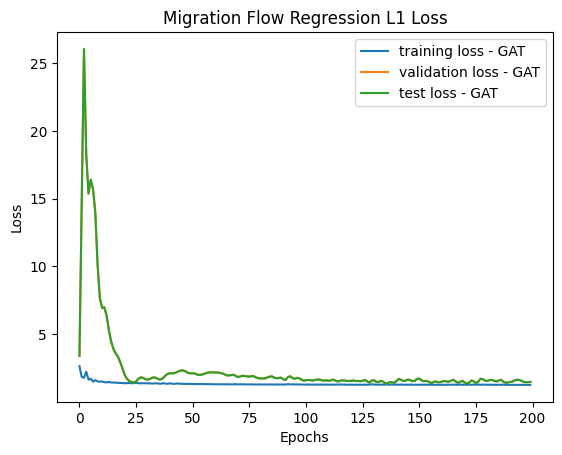

Running pipeline with config: Regression_GAT_simple_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 2.6093, Training R2 -1.70226 Validation Loss 2.05751 Validation R2 -0.57588


Training:   0%|          | 1/200 [00:01<04:08,  1.25s/Epochs]

Epoch 2: Training Loss 2.00088, Training R2 -0.55478 Validation Loss 10.58845 Validation R2 -23.64153


Training:   2%|▏         | 3/200 [00:03<04:09,  1.27s/Epochs]

Epoch 3: Training Loss 2.28581, Training R2 -1.11197 Validation Loss 10.16146 Validation R2 -21.77014


Training:   2%|▏         | 4/200 [00:04<03:47,  1.16s/Epochs]

Epoch 4: Training Loss 1.79442, Training R2 -0.309 Validation Loss 7.19431 Validation R2 -10.85379


Training:   2%|▎         | 5/200 [00:05<03:29,  1.07s/Epochs]

Epoch 5: Training Loss 1.88174, Training R2 -0.25167 Validation Loss 6.54999 Validation R2 -8.9696


Training:   3%|▎         | 6/200 [00:06<03:38,  1.13s/Epochs]

Epoch 6: Training Loss 1.83838, Training R2 -0.20396 Validation Loss 7.29979 Validation R2 -11.16139


Training:   4%|▎         | 7/200 [00:08<03:48,  1.18s/Epochs]

Epoch 7: Training Loss 1.70809, Training R2 -0.16577 Validation Loss 7.33782 Validation R2 -11.27898
Epoch 8: Training Loss 1.66984, Training R2 -0.18292 Validation Loss 5.70138 Validation R2 -6.75148


Training:   4%|▍         | 9/200 [00:11<04:27,  1.40s/Epochs]

Epoch 9: Training Loss 1.56753, Training R2 -0.02408 Validation Loss 3.63833 Validation R2 -2.6162


Training:   5%|▌         | 10/200 [00:12<04:06,  1.30s/Epochs]

Epoch 10: Training Loss 1.5785, Training R2 -0.02374 Validation Loss 2.01811 Validation R2 -0.45296


Training:   6%|▌         | 11/200 [00:13<03:52,  1.23s/Epochs]

Epoch 11: Training Loss 1.56417, Training R2 0.05713 Validation Loss 1.85055 Validation R2 -0.24892


Training:   6%|▌         | 12/200 [00:14<03:42,  1.18s/Epochs]

Epoch 12: Training Loss 1.52505, Training R2 0.09791 Validation Loss 1.94805 Validation R2 -0.35734


Training:   6%|▋         | 13/200 [00:15<03:37,  1.16s/Epochs]

Epoch 13: Training Loss 1.5082, Training R2 0.11118 Validation Loss 1.88434 Validation R2 -0.28175
Epoch 14: Training Loss 1.51295, Training R2 0.10231 Validation Loss 1.71081 Validation R2 -0.07006


Training:   8%|▊         | 15/200 [00:18<03:31,  1.14s/Epochs]

Epoch 15: Training Loss 1.49888, Training R2 0.13522 Validation Loss 1.64845 Validation R2 0.03758


Training:   8%|▊         | 16/200 [00:19<03:16,  1.07s/Epochs]

Epoch 16: Training Loss 1.50736, Training R2 0.12564 Validation Loss 1.64159 Validation R2 0.08094


Training:   8%|▊         | 17/200 [00:20<03:12,  1.05s/Epochs]

Epoch 17: Training Loss 1.47817, Training R2 0.14324 Validation Loss 1.6526 Validation R2 0.12667


Training:   9%|▉         | 18/200 [00:21<03:07,  1.03s/Epochs]

Epoch 18: Training Loss 1.47197, Training R2 0.13604 Validation Loss 1.73576 Validation R2 0.14126


Training:  10%|▉         | 19/200 [00:22<03:13,  1.07s/Epochs]

Epoch 19: Training Loss 1.46702, Training R2 0.14524 Validation Loss 1.80981 Validation R2 0.12516
Epoch 20: Training Loss 1.47239, Training R2 0.12839 Validation Loss 1.85551 Validation R2 0.09893


Training:  10%|█         | 21/200 [00:25<03:53,  1.31s/Epochs]

Epoch 21: Training Loss 1.49065, Training R2 0.10611 Validation Loss 1.96697 Validation R2 -0.0007


Training:  11%|█         | 22/200 [00:26<03:36,  1.22s/Epochs]

Epoch 22: Training Loss 1.4712, Training R2 0.13686 Validation Loss 2.08368 Validation R2 -0.14981


Training:  12%|█▏        | 23/200 [00:27<03:21,  1.14s/Epochs]

Epoch 23: Training Loss 1.48408, Training R2 0.12037 Validation Loss 2.22548 Validation R2 -0.35985


Training:  12%|█▏        | 24/200 [00:28<03:18,  1.13s/Epochs]

Epoch 24: Training Loss 1.4514, Training R2 0.16968 Validation Loss 2.32727 Validation R2 -0.5468


Training:  12%|█▎        | 25/200 [00:29<03:10,  1.09s/Epochs]

Epoch 25: Training Loss 1.46269, Training R2 0.16654 Validation Loss 2.41484 Validation R2 -0.72669


Training:  13%|█▎        | 26/200 [00:30<03:05,  1.07s/Epochs]

Epoch 26: Training Loss 1.46359, Training R2 0.17182 Validation Loss 2.53718 Validation R2 -0.95808


Training:  14%|█▎        | 27/200 [00:31<03:07,  1.08s/Epochs]

Epoch 27: Training Loss 1.45005, Training R2 0.17187 Validation Loss 2.73412 Validation R2 -1.28229


Training:  14%|█▍        | 28/200 [00:32<03:12,  1.12s/Epochs]

Epoch 28: Training Loss 1.46071, Training R2 0.15112 Validation Loss 2.93205 Validation R2 -1.58046


Training:  14%|█▍        | 29/200 [00:33<03:08,  1.10s/Epochs]

Epoch 29: Training Loss 1.44856, Training R2 0.16476 Validation Loss 3.06001 Validation R2 -1.7665
Epoch 30: Training Loss 1.43203, Training R2 0.18878 Validation Loss 3.19259 Validation R2 -1.94995


Training:  15%|█▌        | 30/200 [00:34<03:14,  1.15s/Epochs]

Epoch 31: Training Loss 1.43819, Training R2 0.17873 Validation Loss 3.36813 Validation R2 -2.19924


Training:  16%|█▌        | 32/200 [00:37<03:35,  1.28s/Epochs]

Epoch 32: Training Loss 1.42457, Training R2 0.18665 Validation Loss 3.58904 Validation R2 -2.52755


Training:  16%|█▋        | 33/200 [00:39<03:38,  1.31s/Epochs]

Epoch 33: Training Loss 1.42069, Training R2 0.17954 Validation Loss 3.80598 Validation R2 -2.87029


Training:  17%|█▋        | 34/200 [00:40<03:31,  1.27s/Epochs]

Epoch 34: Training Loss 1.42258, Training R2 0.17223 Validation Loss 3.96153 Validation R2 -3.1308


Training:  18%|█▊        | 35/200 [00:41<03:19,  1.21s/Epochs]

Epoch 35: Training Loss 1.43229, Training R2 0.16478 Validation Loss 4.08832 Validation R2 -3.35581


Training:  18%|█▊        | 36/200 [00:42<03:11,  1.17s/Epochs]

Epoch 36: Training Loss 1.41946, Training R2 0.18502 Validation Loss 4.25493 Validation R2 -3.653


Training:  18%|█▊        | 37/200 [00:43<03:06,  1.14s/Epochs]

Epoch 37: Training Loss 1.42521, Training R2 0.17597 Validation Loss 4.37133 Validation R2 -3.87392


Training:  19%|█▉        | 38/200 [00:44<03:05,  1.15s/Epochs]

Epoch 38: Training Loss 1.40256, Training R2 0.19344 Validation Loss 4.39204 Validation R2 -3.92166
Epoch 39: Training Loss 1.40669, Training R2 0.19865 Validation Loss 4.32338 Validation R2 -3.80082


Training:  20%|██        | 40/200 [00:47<03:10,  1.19s/Epochs]

Epoch 40: Training Loss 1.40973, Training R2 0.19479 Validation Loss 4.25666 Validation R2 -3.68445


Training:  20%|██        | 41/200 [00:48<03:00,  1.13s/Epochs]

Epoch 41: Training Loss 1.40106, Training R2 0.20006 Validation Loss 4.09864 Validation R2 -3.40591


Training:  21%|██        | 42/200 [00:49<02:50,  1.08s/Epochs]

Epoch 42: Training Loss 1.40703, Training R2 0.18784 Validation Loss 3.88262 Validation R2 -3.03629


Training:  22%|██▏       | 43/200 [00:50<02:51,  1.09s/Epochs]

Epoch 43: Training Loss 1.39257, Training R2 0.20261 Validation Loss 3.54773 Validation R2 -2.48423


Training:  22%|██▏       | 44/200 [00:51<03:02,  1.17s/Epochs]

Epoch 44: Training Loss 1.39517, Training R2 0.19617 Validation Loss 3.173 Validation R2 -1.90608
Epoch 45: Training Loss 1.37739, Training R2 0.21415 Validation Loss 2.96062 Validation R2 -1.5894


Training:  23%|██▎       | 46/200 [00:54<03:17,  1.28s/Epochs]

Epoch 46: Training Loss 1.38534, Training R2 0.19751 Validation Loss 2.92763 Validation R2 -1.54987


Training:  24%|██▎       | 47/200 [00:55<03:09,  1.24s/Epochs]

Epoch 47: Training Loss 1.38123, Training R2 0.19707 Validation Loss 3.10895 Validation R2 -1.8337


Training:  24%|██▍       | 48/200 [00:56<02:59,  1.18s/Epochs]

Epoch 48: Training Loss 1.38526, Training R2 0.20305 Validation Loss 3.22178 Validation R2 -2.01167


Training:  24%|██▍       | 49/200 [00:57<02:55,  1.16s/Epochs]

Epoch 49: Training Loss 1.3782, Training R2 0.21138 Validation Loss 3.16981 Validation R2 -1.94191
Epoch 50: Training Loss 1.36327, Training R2 0.22296 Validation Loss 3.08006 Validation R2 -1.8252


Training:  26%|██▌       | 51/200 [00:59<02:44,  1.10s/Epochs]

Epoch 51: Training Loss 1.36591, Training R2 0.22879 Validation Loss 2.97072 Validation R2 -1.67576
Epoch 52: Training Loss 1.37498, Training R2 0.21804 Validation Loss 2.78683 Validation R2 -1.404


Training:  26%|██▋       | 53/200 [01:02<02:48,  1.14s/Epochs]

Epoch 53: Training Loss 1.3722, Training R2 0.22675 Validation Loss 2.58519 Validation R2 -1.07445


Training:  27%|██▋       | 54/200 [01:03<02:42,  1.11s/Epochs]

Epoch 54: Training Loss 1.35735, Training R2 0.23521 Validation Loss 2.40348 Validation R2 -0.74719
Epoch 55: Training Loss 1.35631, Training R2 0.22244 Validation Loss 2.4477 Validation R2 -0.81973


Training:  28%|██▊       | 56/200 [01:05<02:56,  1.22s/Epochs]

Epoch 56: Training Loss 1.36801, Training R2 0.22802 Validation Loss 2.36236 Validation R2 -0.6632
Epoch 57: Training Loss 1.35763, Training R2 0.22636 Validation Loss 2.2133 Validation R2 -0.41894


Training:  29%|██▉       | 58/200 [01:09<03:18,  1.40s/Epochs]

Epoch 58: Training Loss 1.37401, Training R2 0.19623 Validation Loss 2.46608 Validation R2 -0.86628


Training:  30%|██▉       | 59/200 [01:10<03:02,  1.29s/Epochs]

Epoch 59: Training Loss 1.36009, Training R2 0.21877 Validation Loss 2.66611 Validation R2 -1.23891


Training:  30%|███       | 60/200 [01:11<02:47,  1.19s/Epochs]

Epoch 60: Training Loss 1.41022, Training R2 0.21107 Validation Loss 2.53673 Validation R2 -0.99179


Training:  30%|███       | 61/200 [01:12<02:36,  1.13s/Epochs]

Epoch 61: Training Loss 1.35951, Training R2 0.24143 Validation Loss 2.0992 Validation R2 -0.22875


Training:  31%|███       | 62/200 [01:13<02:26,  1.06s/Epochs]

Epoch 62: Training Loss 1.4065, Training R2 0.17579 Validation Loss 2.00574 Validation R2 -0.06997


Training:  32%|███▏      | 63/200 [01:13<02:18,  1.01s/Epochs]

Epoch 63: Training Loss 1.3508, Training R2 0.23028 Validation Loss 2.00281 Validation R2 -0.02291


Training:  32%|███▏      | 64/200 [01:14<02:14,  1.01Epochs/s]

Epoch 64: Training Loss 1.36068, Training R2 0.2477 Validation Loss 1.91229 Validation R2 0.07607


Training:  32%|███▎      | 65/200 [01:15<02:11,  1.03Epochs/s]

Epoch 65: Training Loss 1.37544, Training R2 0.2361 Validation Loss 1.68369 Validation R2 0.19637


Training:  33%|███▎      | 66/200 [01:16<02:09,  1.04Epochs/s]

Epoch 66: Training Loss 1.35119, Training R2 0.23811 Validation Loss 1.55467 Validation R2 0.20268


Training:  34%|███▎      | 67/200 [01:17<02:08,  1.03Epochs/s]

Epoch 67: Training Loss 1.36833, Training R2 0.21054 Validation Loss 1.56844 Validation R2 0.20279


Training:  34%|███▍      | 68/200 [01:18<02:15,  1.03s/Epochs]

Epoch 68: Training Loss 1.3613, Training R2 0.22027 Validation Loss 1.751 Validation R2 0.16831
Epoch 69: Training Loss 1.35182, Training R2 0.24581 Validation Loss 1.89909 Validation R2 0.08733


Training:  35%|███▌      | 70/200 [01:21<02:45,  1.27s/Epochs]

Epoch 70: Training Loss 1.36171, Training R2 0.24212 Validation Loss 2.04584 Validation R2 -0.0663


Training:  36%|███▌      | 71/200 [01:23<02:52,  1.33s/Epochs]

Epoch 71: Training Loss 1.34622, Training R2 0.25045 Validation Loss 2.19279 Validation R2 -0.28176


Training:  36%|███▌      | 72/200 [01:24<02:41,  1.26s/Epochs]

Epoch 72: Training Loss 1.34843, Training R2 0.24088 Validation Loss 2.28521 Validation R2 -0.44692


Training:  36%|███▋      | 73/200 [01:25<02:30,  1.18s/Epochs]

Epoch 73: Training Loss 1.35063, Training R2 0.23432 Validation Loss 2.34528 Validation R2 -0.56334


Training:  37%|███▋      | 74/200 [01:26<02:26,  1.16s/Epochs]

Epoch 74: Training Loss 1.33928, Training R2 0.24123 Validation Loss 2.37246 Validation R2 -0.62885


Training:  38%|███▊      | 75/200 [01:27<02:21,  1.13s/Epochs]

Epoch 75: Training Loss 1.33656, Training R2 0.24554 Validation Loss 2.37971 Validation R2 -0.66552


Training:  38%|███▊      | 76/200 [01:28<02:13,  1.07s/Epochs]

Epoch 76: Training Loss 1.33613, Training R2 0.2509 Validation Loss 2.4337 Validation R2 -0.79055


Training:  38%|███▊      | 77/200 [01:29<02:12,  1.08s/Epochs]

Epoch 77: Training Loss 1.33146, Training R2 0.25172 Validation Loss 2.67931 Validation R2 -1.26959


Training:  39%|███▉      | 78/200 [01:30<02:10,  1.07s/Epochs]

Epoch 78: Training Loss 1.33358, Training R2 0.25641 Validation Loss 2.96056 Validation R2 -1.73942


Training:  40%|███▉      | 79/200 [01:31<02:13,  1.10s/Epochs]

Epoch 79: Training Loss 1.32604, Training R2 0.26437 Validation Loss 3.06764 Validation R2 -1.88393


Training:  40%|████      | 80/200 [01:33<02:10,  1.09s/Epochs]

Epoch 80: Training Loss 1.32872, Training R2 0.26303 Validation Loss 2.79069 Validation R2 -1.4384


Training:  40%|████      | 81/200 [01:34<02:23,  1.20s/Epochs]

Epoch 81: Training Loss 1.32113, Training R2 0.27555 Validation Loss 2.43858 Validation R2 -0.81354
Epoch 82: Training Loss 1.32343, Training R2 0.26686 Validation Loss 2.32766 Validation R2 -0.619


Training:  42%|████▏     | 83/200 [01:37<02:38,  1.35s/Epochs]

Epoch 83: Training Loss 1.32454, Training R2 0.26009 Validation Loss 2.70442 Validation R2 -1.29082


Training:  42%|████▏     | 84/200 [01:38<02:23,  1.23s/Epochs]

Epoch 84: Training Loss 1.33016, Training R2 0.25052 Validation Loss 3.51756 Validation R2 -2.52727


Training:  42%|████▎     | 85/200 [01:39<02:16,  1.18s/Epochs]

Epoch 85: Training Loss 1.31012, Training R2 0.28304 Validation Loss 3.97391 Validation R2 -3.26519


Training:  43%|████▎     | 86/200 [01:40<02:09,  1.14s/Epochs]

Epoch 86: Training Loss 1.32502, Training R2 0.27907 Validation Loss 3.558 Validation R2 -2.58916


Training:  44%|████▎     | 87/200 [01:41<02:02,  1.09s/Epochs]

Epoch 87: Training Loss 1.32699, Training R2 0.27689 Validation Loss 2.56167 Validation R2 -1.01604


Training:  44%|████▍     | 88/200 [01:42<01:59,  1.07s/Epochs]

Epoch 88: Training Loss 1.31917, Training R2 0.26575 Validation Loss 1.96363 Validation R2 -0.01827


Training:  44%|████▍     | 89/200 [01:43<02:01,  1.09s/Epochs]

Epoch 89: Training Loss 1.3278, Training R2 0.25049 Validation Loss 1.95833 Validation R2 -0.01101


Training:  45%|████▌     | 90/200 [01:44<01:53,  1.04s/Epochs]

Epoch 90: Training Loss 1.31483, Training R2 0.27111 Validation Loss 2.07756 Validation R2 -0.1501
Epoch 91: Training Loss 1.32056, Training R2 0.26524 Validation Loss 2.33748 Validation R2 -0.59108


Training:  46%|████▌     | 92/200 [01:47<02:01,  1.13s/Epochs]

Epoch 92: Training Loss 1.31168, Training R2 0.27235 Validation Loss 2.69371 Validation R2 -1.27169


Training:  46%|████▋     | 93/200 [01:48<01:58,  1.11s/Epochs]

Epoch 93: Training Loss 1.31901, Training R2 0.27462 Validation Loss 2.8625 Validation R2 -1.58138


Training:  47%|████▋     | 94/200 [01:49<02:03,  1.16s/Epochs]

Epoch 94: Training Loss 1.31633, Training R2 0.28568 Validation Loss 2.66675 Validation R2 -1.2224
Epoch 95: Training Loss 1.31243, Training R2 0.2859 Validation Loss 2.58269 Validation R2 -1.02091


Training:  48%|████▊     | 96/200 [01:52<02:13,  1.28s/Epochs]

Epoch 96: Training Loss 1.30773, Training R2 0.28436 Validation Loss 2.47294 Validation R2 -0.74897


Training:  48%|████▊     | 97/200 [01:53<02:00,  1.17s/Epochs]

Epoch 97: Training Loss 1.31414, Training R2 0.26764 Validation Loss 2.37862 Validation R2 -0.55622


Training:  49%|████▉     | 98/200 [01:54<01:56,  1.15s/Epochs]

Epoch 98: Training Loss 1.30837, Training R2 0.27729 Validation Loss 2.44662 Validation R2 -0.66453


Training:  50%|████▉     | 99/200 [01:55<01:50,  1.10s/Epochs]

Epoch 99: Training Loss 1.305, Training R2 0.28101 Validation Loss 2.50388 Validation R2 -0.76865


Training:  50%|█████     | 100/200 [01:56<01:50,  1.11s/Epochs]

Epoch 100: Training Loss 1.30216, Training R2 0.28628 Validation Loss 2.57283 Validation R2 -0.91566


Training:  50%|█████     | 101/200 [01:57<01:47,  1.09s/Epochs]

Epoch 101: Training Loss 1.302, Training R2 0.29079 Validation Loss 2.58496 Validation R2 -0.94666


Training:  51%|█████     | 102/200 [01:58<01:46,  1.09s/Epochs]

Epoch 102: Training Loss 1.29562, Training R2 0.29874 Validation Loss 2.60695 Validation R2 -1.00818


Training:  52%|█████▏    | 103/200 [01:59<01:49,  1.13s/Epochs]

Epoch 103: Training Loss 1.3009, Training R2 0.29403 Validation Loss 2.62244 Validation R2 -1.06693


Training:  52%|█████▏    | 104/200 [02:00<01:48,  1.13s/Epochs]

Epoch 104: Training Loss 1.30539, Training R2 0.28396 Validation Loss 2.62028 Validation R2 -1.07981


Training:  52%|█████▎    | 105/200 [02:01<01:44,  1.10s/Epochs]

Epoch 105: Training Loss 1.30411, Training R2 0.28604 Validation Loss 2.64776 Validation R2 -1.16056


Training:  53%|█████▎    | 106/200 [02:03<01:49,  1.16s/Epochs]

Epoch 106: Training Loss 1.30118, Training R2 0.28531 Validation Loss 2.71735 Validation R2 -1.32533


Training:  54%|█████▎    | 107/200 [02:04<01:53,  1.22s/Epochs]

Epoch 107: Training Loss 1.30371, Training R2 0.28912 Validation Loss 2.70449 Validation R2 -1.28533


Training:  54%|█████▍    | 108/200 [02:05<01:57,  1.28s/Epochs]

Epoch 108: Training Loss 1.30674, Training R2 0.27376 Validation Loss 2.96804 Validation R2 -1.69749


Training:  55%|█████▍    | 109/200 [02:06<01:47,  1.18s/Epochs]

Epoch 109: Training Loss 1.29777, Training R2 0.29108 Validation Loss 3.14368 Validation R2 -1.96885


Training:  55%|█████▌    | 110/200 [02:07<01:36,  1.07s/Epochs]

Epoch 110: Training Loss 1.30868, Training R2 0.29363 Validation Loss 3.03871 Validation R2 -1.78691


Training:  56%|█████▌    | 111/200 [02:08<01:31,  1.03s/Epochs]

Epoch 111: Training Loss 1.29309, Training R2 0.30368 Validation Loss 2.98914 Validation R2 -1.68062


Training:  56%|█████▌    | 112/200 [02:09<01:27,  1.01Epochs/s]

Epoch 112: Training Loss 1.31146, Training R2 0.27968 Validation Loss 3.12613 Validation R2 -1.87497


Training:  56%|█████▋    | 113/200 [02:10<01:29,  1.02s/Epochs]

Epoch 113: Training Loss 1.29608, Training R2 0.29379 Validation Loss 3.2388 Validation R2 -2.04719
Epoch 114: Training Loss 1.29544, Training R2 0.29637 Validation Loss 3.04238 Validation R2 -1.76453


Training:  57%|█████▋    | 114/200 [02:11<01:34,  1.10s/Epochs]

Epoch 115: Training Loss 1.29971, Training R2 0.29071 Validation Loss 2.98674 Validation R2 -1.70504


Training:  58%|█████▊    | 116/200 [02:14<01:34,  1.13s/Epochs]

Epoch 116: Training Loss 1.30338, Training R2 0.28246 Validation Loss 3.19706 Validation R2 -2.04377


Training:  58%|█████▊    | 117/200 [02:15<01:29,  1.08s/Epochs]

Epoch 117: Training Loss 1.29259, Training R2 0.29568 Validation Loss 3.37887 Validation R2 -2.32836


Training:  59%|█████▉    | 118/200 [02:16<01:23,  1.01s/Epochs]

Epoch 118: Training Loss 1.29999, Training R2 0.29557 Validation Loss 3.4223 Validation R2 -2.39042
Epoch 119: Training Loss 1.2934, Training R2 0.28794 Validation Loss 3.54876 Validation R2 -2.60162


Training:  60%|██████    | 120/200 [02:19<01:39,  1.24s/Epochs]

Epoch 120: Training Loss 1.29511, Training R2 0.30003 Validation Loss 3.48259 Validation R2 -2.49792
Epoch 121: Training Loss 1.29215, Training R2 0.29677 Validation Loss 3.39139 Validation R2 -2.35926


Training:  60%|██████    | 121/200 [02:20<01:47,  1.37s/Epochs]

Epoch 122: Training Loss 1.29156, Training R2 0.30187 Validation Loss 3.19978 Validation R2 -2.06131


Training:  62%|██████▏   | 123/200 [02:22<01:34,  1.23s/Epochs]

Epoch 123: Training Loss 1.28956, Training R2 0.29868 Validation Loss 3.11144 Validation R2 -1.92795


Training:  62%|██████▏   | 124/200 [02:23<01:28,  1.16s/Epochs]

Epoch 124: Training Loss 1.28979, Training R2 0.29887 Validation Loss 3.11088 Validation R2 -1.92991


Training:  62%|██████▎   | 125/200 [02:25<01:25,  1.14s/Epochs]

Epoch 125: Training Loss 1.29969, Training R2 0.29156 Validation Loss 3.19613 Validation R2 -2.0579


Training:  63%|██████▎   | 126/200 [02:26<01:21,  1.11s/Epochs]

Epoch 126: Training Loss 1.29183, Training R2 0.29628 Validation Loss 3.2263 Validation R2 -2.1127


Training:  64%|██████▎   | 127/200 [02:27<01:20,  1.11s/Epochs]

Epoch 127: Training Loss 1.29265, Training R2 0.29848 Validation Loss 3.18592 Validation R2 -2.0673
Epoch 128: Training Loss 1.29139, Training R2 0.30787 Validation Loss 3.11938 Validation R2 -1.96695


Training:  64%|██████▍   | 129/200 [02:29<01:19,  1.12s/Epochs]

Epoch 129: Training Loss 1.30817, Training R2 0.29909 Validation Loss 3.00252 Validation R2 -1.76407
Epoch 130: Training Loss 1.28928, Training R2 0.29951 Validation Loss 2.85531 Validation R2 -1.52949


Training:  66%|██████▌   | 131/200 [02:32<01:23,  1.21s/Epochs]

Epoch 131: Training Loss 1.32885, Training R2 0.257 Validation Loss 2.86989 Validation R2 -1.61106


Training:  66%|██████▌   | 132/200 [02:33<01:23,  1.22s/Epochs]

Epoch 132: Training Loss 1.29754, Training R2 0.29919 Validation Loss 2.908 Validation R2 -1.70057


Training:  66%|██████▋   | 133/200 [02:34<01:24,  1.26s/Epochs]

Epoch 133: Training Loss 1.30363, Training R2 0.29846 Validation Loss 2.75346 Validation R2 -1.41322


Training:  67%|██████▋   | 134/200 [02:35<01:18,  1.18s/Epochs]

Epoch 134: Training Loss 1.28953, Training R2 0.29778 Validation Loss 2.7506 Validation R2 -1.41028


Training:  68%|██████▊   | 135/200 [02:36<01:11,  1.10s/Epochs]

Epoch 135: Training Loss 1.29091, Training R2 0.29617 Validation Loss 2.81519 Validation R2 -1.55272


Training:  68%|██████▊   | 136/200 [02:37<01:06,  1.03s/Epochs]

Epoch 136: Training Loss 1.29796, Training R2 0.30521 Validation Loss 2.78685 Validation R2 -1.48581


Training:  68%|██████▊   | 137/200 [02:38<01:03,  1.00s/Epochs]

Epoch 137: Training Loss 1.28928, Training R2 0.31091 Validation Loss 2.76072 Validation R2 -1.42349


Training:  69%|██████▉   | 138/200 [02:39<01:00,  1.03Epochs/s]

Epoch 138: Training Loss 1.28165, Training R2 0.30767 Validation Loss 2.76136 Validation R2 -1.42088


Training:  70%|██████▉   | 139/200 [02:40<00:59,  1.02Epochs/s]

Epoch 139: Training Loss 1.2856, Training R2 0.30146 Validation Loss 2.83086 Validation R2 -1.55947


Training:  70%|███████   | 140/200 [02:41<00:58,  1.02Epochs/s]

Epoch 140: Training Loss 1.28354, Training R2 0.30973 Validation Loss 2.93709 Validation R2 -1.72129


Training:  70%|███████   | 141/200 [02:42<00:57,  1.03Epochs/s]

Epoch 141: Training Loss 1.28711, Training R2 0.29808 Validation Loss 3.24016 Validation R2 -2.16804


Training:  71%|███████   | 142/200 [02:43<00:56,  1.03Epochs/s]

Epoch 142: Training Loss 1.28352, Training R2 0.30688 Validation Loss 3.20322 Validation R2 -2.1404


Training:  72%|███████▏  | 143/200 [02:44<00:57,  1.01s/Epochs]

Epoch 143: Training Loss 1.28818, Training R2 0.31052 Validation Loss 2.91352 Validation R2 -1.7079
Epoch 144: Training Loss 1.28777, Training R2 0.30794 Validation Loss 2.68385 Validation R2 -1.2518


Training:  72%|███████▎  | 145/200 [02:46<01:05,  1.19s/Epochs]

Epoch 145: Training Loss 1.28118, Training R2 0.32139 Validation Loss 2.63872 Validation R2 -1.15191


Training:  73%|███████▎  | 146/200 [02:48<01:06,  1.23s/Epochs]

Epoch 146: Training Loss 1.287, Training R2 0.30848 Validation Loss 2.70551 Validation R2 -1.28272


Training:  74%|███████▎  | 147/200 [02:49<01:06,  1.26s/Epochs]

Epoch 147: Training Loss 1.2865, Training R2 0.30584 Validation Loss 2.60905 Validation R2 -1.08719


Training:  74%|███████▍  | 148/200 [02:50<01:00,  1.17s/Epochs]

Epoch 148: Training Loss 1.28586, Training R2 0.29752 Validation Loss 2.5472 Validation R2 -0.96461


Training:  74%|███████▍  | 149/200 [02:51<00:56,  1.10s/Epochs]

Epoch 149: Training Loss 1.28159, Training R2 0.30151 Validation Loss 2.62509 Validation R2 -1.11419


Training:  75%|███████▌  | 150/200 [02:52<00:54,  1.10s/Epochs]

Epoch 150: Training Loss 1.31739, Training R2 0.28699 Validation Loss 2.71925 Validation R2 -1.31984


Training:  76%|███████▌  | 151/200 [02:53<00:52,  1.06s/Epochs]

Epoch 151: Training Loss 1.30502, Training R2 0.28137 Validation Loss 2.94022 Validation R2 -1.71162


Training:  76%|███████▌  | 152/200 [02:54<00:49,  1.02s/Epochs]

Epoch 152: Training Loss 1.28315, Training R2 0.30328 Validation Loss 3.06852 Validation R2 -1.9084


Training:  76%|███████▋  | 153/200 [02:55<00:46,  1.00Epochs/s]

Epoch 153: Training Loss 1.29718, Training R2 0.30798 Validation Loss 2.83522 Validation R2 -1.56375


Training:  77%|███████▋  | 154/200 [02:56<00:44,  1.03Epochs/s]

Epoch 154: Training Loss 1.2918, Training R2 0.31328 Validation Loss 2.57697 Validation R2 -1.02869


Training:  78%|███████▊  | 155/200 [02:57<00:42,  1.06Epochs/s]

Epoch 155: Training Loss 1.3003, Training R2 0.2903 Validation Loss 2.54939 Validation R2 -0.96884


Training:  78%|███████▊  | 156/200 [02:58<00:40,  1.08Epochs/s]

Epoch 156: Training Loss 1.29413, Training R2 0.29319 Validation Loss 2.65855 Validation R2 -1.19289


Training:  78%|███████▊  | 157/200 [02:58<00:38,  1.11Epochs/s]

Epoch 157: Training Loss 1.28538, Training R2 0.30598 Validation Loss 2.6887 Validation R2 -1.23915


Training:  79%|███████▉  | 158/200 [03:00<00:39,  1.07Epochs/s]

Epoch 158: Training Loss 1.29103, Training R2 0.30186 Validation Loss 2.46598 Validation R2 -0.81996


Training:  80%|███████▉  | 159/200 [03:01<00:40,  1.00Epochs/s]

Epoch 159: Training Loss 1.28528, Training R2 0.30282 Validation Loss 2.08016 Validation R2 -0.21105


Training:  80%|████████  | 160/200 [03:02<00:41,  1.03s/Epochs]

Epoch 160: Training Loss 1.28411, Training R2 0.30698 Validation Loss 1.9124 Validation R2 -8e-05


Training:  80%|████████  | 161/200 [03:04<00:56,  1.45s/Epochs]

Epoch 161: Training Loss 1.28019, Training R2 0.31233 Validation Loss 1.9897 Validation R2 -0.05478


Training:  81%|████████  | 162/200 [03:05<00:50,  1.34s/Epochs]

Epoch 162: Training Loss 1.28806, Training R2 0.32018 Validation Loss 1.87578 Validation R2 0.05072


Training:  82%|████████▏ | 163/200 [03:06<00:45,  1.24s/Epochs]

Epoch 163: Training Loss 1.27793, Training R2 0.32508 Validation Loss 1.7286 Validation R2 0.14271


Training:  82%|████████▏ | 164/200 [03:07<00:41,  1.16s/Epochs]

Epoch 164: Training Loss 1.28582, Training R2 0.30045 Validation Loss 1.75977 Validation R2 0.12264


Training:  82%|████████▎ | 165/200 [03:08<00:40,  1.17s/Epochs]

Epoch 165: Training Loss 1.29469, Training R2 0.28209 Validation Loss 2.04307 Validation R2 -0.11501


Training:  83%|████████▎ | 166/200 [03:09<00:37,  1.11s/Epochs]

Epoch 166: Training Loss 1.29776, Training R2 0.29199 Validation Loss 2.27934 Validation R2 -0.44577


Training:  84%|████████▎ | 167/200 [03:10<00:36,  1.09s/Epochs]

Epoch 167: Training Loss 1.28698, Training R2 0.30863 Validation Loss 2.63846 Validation R2 -1.17893


Training:  84%|████████▍ | 168/200 [03:12<00:35,  1.10s/Epochs]

Epoch 168: Training Loss 1.28385, Training R2 0.30933 Validation Loss 3.00284 Validation R2 -1.81428


Training:  84%|████████▍ | 169/200 [03:13<00:34,  1.13s/Epochs]

Epoch 169: Training Loss 1.27935, Training R2 0.32466 Validation Loss 3.13479 Validation R2 -1.99891
Epoch 170: Training Loss 1.2784, Training R2 0.3245 Validation Loss 3.04448 Validation R2 -1.83387


Training:  85%|████████▌ | 170/200 [03:14<00:37,  1.25s/Epochs]

Epoch 171: Training Loss 1.27541, Training R2 0.31822 Validation Loss 2.63017 Validation R2 -1.13327


Training:  86%|████████▌ | 172/200 [03:18<00:40,  1.44s/Epochs]

Epoch 172: Training Loss 1.27022, Training R2 0.31644 Validation Loss 2.33902 Validation R2 -0.59362


Training:  86%|████████▋ | 173/200 [03:19<00:39,  1.46s/Epochs]

Epoch 173: Training Loss 1.27588, Training R2 0.31005 Validation Loss 2.04241 Validation R2 -0.13287


Training:  87%|████████▋ | 174/200 [03:21<00:38,  1.49s/Epochs]

Epoch 174: Training Loss 1.27506, Training R2 0.31294 Validation Loss 1.96708 Validation R2 -0.03596


Training:  88%|████████▊ | 175/200 [03:22<00:34,  1.39s/Epochs]

Epoch 175: Training Loss 1.27976, Training R2 0.3103 Validation Loss 2.13473 Validation R2 -0.22809


Training:  88%|████████▊ | 176/200 [03:23<00:30,  1.27s/Epochs]

Epoch 176: Training Loss 1.27656, Training R2 0.32029 Validation Loss 2.17995 Validation R2 -0.28292


Training:  88%|████████▊ | 177/200 [03:24<00:27,  1.18s/Epochs]

Epoch 177: Training Loss 1.27047, Training R2 0.32574 Validation Loss 2.19025 Validation R2 -0.30069


Training:  89%|████████▉ | 178/200 [03:25<00:23,  1.08s/Epochs]

Epoch 178: Training Loss 1.27141, Training R2 0.32064 Validation Loss 2.34125 Validation R2 -0.55251


Training:  90%|████████▉ | 179/200 [03:25<00:21,  1.01s/Epochs]

Epoch 179: Training Loss 1.27396, Training R2 0.3182 Validation Loss 2.30835 Validation R2 -0.49262


Training:  90%|█████████ | 180/200 [03:26<00:19,  1.01Epochs/s]

Epoch 180: Training Loss 1.27014, Training R2 0.31893 Validation Loss 2.07311 Validation R2 -0.13298


Training:  90%|█████████ | 181/200 [03:27<00:18,  1.03Epochs/s]

Epoch 181: Training Loss 1.27241, Training R2 0.31806 Validation Loss 1.81043 Validation R2 0.1265


Training:  91%|█████████ | 182/200 [03:28<00:17,  1.05Epochs/s]

Epoch 182: Training Loss 1.27708, Training R2 0.3108 Validation Loss 1.83521 Validation R2 0.10896


Training:  92%|█████████▏| 183/200 [03:29<00:17,  1.00s/Epochs]

Epoch 183: Training Loss 1.26872, Training R2 0.32337 Validation Loss 1.92728 Validation R2 0.03381


Training:  92%|█████████▏| 184/200 [03:30<00:16,  1.02s/Epochs]

Epoch 184: Training Loss 1.28712, Training R2 0.31766 Validation Loss 1.75775 Validation R2 0.14836
Epoch 185: Training Loss 1.32859, Training R2 0.26666 Validation Loss 2.06761 Validation R2 -0.15669


Training:  92%|█████████▎| 185/200 [03:32<00:17,  1.14s/Epochs]

Epoch 186: Training Loss 1.27322, Training R2 0.32184 Validation Loss 2.28028 Validation R2 -0.46948


Training:  93%|█████████▎| 186/200 [03:34<00:18,  1.31s/Epochs]

Epoch 187: Training Loss 1.31564, Training R2 0.29412 Validation Loss 2.20806 Validation R2 -0.32752


Training:  94%|█████████▍| 188/200 [03:37<00:16,  1.36s/Epochs]

Epoch 188: Training Loss 1.26836, Training R2 0.31751 Validation Loss 2.21145 Validation R2 -0.31153


Training:  94%|█████████▍| 189/200 [03:37<00:13,  1.23s/Epochs]

Epoch 189: Training Loss 1.30612, Training R2 0.28178 Validation Loss 2.4751 Validation R2 -0.77316


Training:  95%|█████████▌| 190/200 [03:38<00:11,  1.15s/Epochs]

Epoch 190: Training Loss 1.27711, Training R2 0.30555 Validation Loss 2.82191 Validation R2 -1.56371


Training:  96%|█████████▌| 191/200 [03:39<00:09,  1.09s/Epochs]

Epoch 191: Training Loss 1.29827, Training R2 0.2942 Validation Loss 2.68554 Validation R2 -1.22182


Training:  96%|█████████▌| 192/200 [03:40<00:08,  1.04s/Epochs]

Epoch 192: Training Loss 1.29912, Training R2 0.30547 Validation Loss 2.35012 Validation R2 -0.50081


Training:  96%|█████████▋| 193/200 [03:41<00:06,  1.02Epochs/s]

Epoch 193: Training Loss 1.27784, Training R2 0.3163 Validation Loss 2.20771 Validation R2 -0.30812


Training:  97%|█████████▋| 194/200 [03:42<00:05,  1.02Epochs/s]

Epoch 194: Training Loss 1.33399, Training R2 0.2598 Validation Loss 2.32601 Validation R2 -0.54987


Training:  98%|█████████▊| 195/200 [03:43<00:04,  1.07Epochs/s]

Epoch 195: Training Loss 1.27264, Training R2 0.31954 Validation Loss 2.53047 Validation R2 -0.96247


Training:  98%|█████████▊| 196/200 [03:44<00:03,  1.06Epochs/s]

Epoch 196: Training Loss 1.31724, Training R2 0.29017 Validation Loss 2.48467 Validation R2 -0.88456


Training:  98%|█████████▊| 197/200 [03:45<00:02,  1.07Epochs/s]

Epoch 197: Training Loss 1.2822, Training R2 0.31125 Validation Loss 2.44649 Validation R2 -0.8108
Epoch 198: Training Loss 1.29775, Training R2 0.29199 Validation Loss 2.47572 Validation R2 -0.86569


Training:  99%|█████████▉| 198/200 [03:46<00:02,  1.09s/Epochs]

Epoch 199: Training Loss 1.29755, Training R2 0.2897 Validation Loss 2.48811 Validation R2 -0.89906


Training: 100%|█████████▉| 199/200 [03:48<00:01,  1.28s/Epochs]

Epoch 200: Training Loss 1.28382, Training R2 0.31581 Validation Loss 2.52097 Validation R2 -0.95902


Training: 100%|██████████| 200/200 [03:50<00:00,  1.15s/Epochs]


Saving Model Predictions for Model Type GAT
Model saved successfully as Regression_GAT_simple_full
Minimum validation loss: 1.5546705722808838
Minimum test loss: 1.5384479761123657
Best test metric: 0.21169966459274292


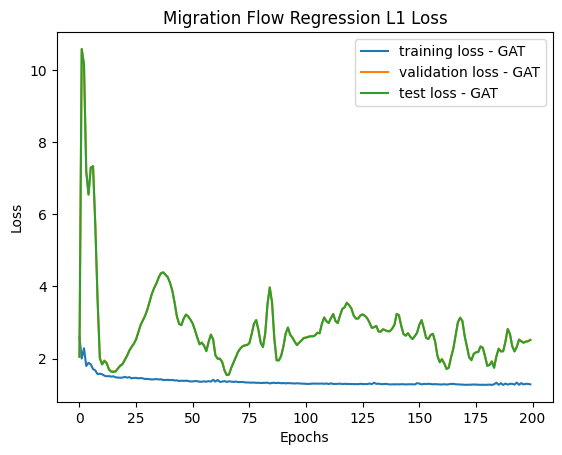

Running pipeline with config: Regression_GAT_full_within_state


Training:   0%|          | 1/200 [00:00<01:06,  3.00Epochs/s]

Epoch 1: Training Loss 2.77893, Training R2 -1.63678 Validation Loss 3.67219 Validation R2 -2.41224


Training:   1%|          | 2/200 [00:00<01:07,  2.94Epochs/s]

Epoch 2: Training Loss 2.19967, Training R2 -0.59832 Validation Loss 2.17714 Validation R2 -0.25791


Training:   2%|▏         | 3/200 [00:00<01:04,  3.05Epochs/s]

Epoch 3: Training Loss 2.63835, Training R2 -1.24844 Validation Loss 2.42366 Validation R2 -0.45476


Training:   2%|▏         | 4/200 [00:01<01:04,  3.06Epochs/s]

Epoch 4: Training Loss 2.08562, Training R2 -0.35209 Validation Loss 2.16717 Validation R2 -0.21267


Training:   2%|▎         | 5/200 [00:01<01:04,  3.01Epochs/s]

Epoch 5: Training Loss 2.01487, Training R2 -0.16398 Validation Loss 2.67343 Validation R2 -0.87773


Training:   3%|▎         | 6/200 [00:01<01:03,  3.04Epochs/s]

Epoch 6: Training Loss 1.99575, Training R2 -0.20348 Validation Loss 3.81132 Validation R2 -2.65139


Training:   4%|▎         | 7/200 [00:02<01:03,  3.04Epochs/s]

Epoch 7: Training Loss 1.97864, Training R2 -0.26403 Validation Loss 4.595 Validation R2 -4.0786


Training:   4%|▍         | 8/200 [00:02<01:03,  3.01Epochs/s]

Epoch 8: Training Loss 1.94512, Training R2 -0.24778 Validation Loss 4.71838 Validation R2 -4.26415


Training:   4%|▍         | 9/200 [00:02<01:02,  3.05Epochs/s]

Epoch 9: Training Loss 1.90497, Training R2 -0.2002 Validation Loss 4.20729 Validation R2 -3.20858


Training:   5%|▌         | 10/200 [00:03<01:02,  3.06Epochs/s]

Epoch 10: Training Loss 1.85634, Training R2 -0.12154 Validation Loss 3.81768 Validation R2 -2.50572


Training:   6%|▌         | 11/200 [00:03<01:02,  3.02Epochs/s]

Epoch 11: Training Loss 1.82576, Training R2 -0.06595 Validation Loss 3.59809 Validation R2 -2.16251


Training:   6%|▌         | 12/200 [00:03<01:02,  3.01Epochs/s]

Epoch 12: Training Loss 1.79517, Training R2 -0.02553 Validation Loss 3.35686 Validation R2 -1.79087


Training:   6%|▋         | 13/200 [00:04<01:02,  3.01Epochs/s]

Epoch 13: Training Loss 1.77561, Training R2 -0.00632 Validation Loss 2.98935 Validation R2 -1.2703


Training:   7%|▋         | 14/200 [00:04<01:02,  2.99Epochs/s]

Epoch 14: Training Loss 1.75773, Training R2 0.00965 Validation Loss 2.52573 Validation R2 -0.70281


Training:   8%|▊         | 15/200 [00:04<01:01,  3.02Epochs/s]

Epoch 15: Training Loss 1.73642, Training R2 0.01649 Validation Loss 2.1706 Validation R2 -0.32565


Training:   8%|▊         | 16/200 [00:05<01:00,  3.02Epochs/s]

Epoch 16: Training Loss 1.73185, Training R2 0.02039 Validation Loss 2.00137 Validation R2 -0.14986


Training:   8%|▊         | 17/200 [00:05<01:01,  2.99Epochs/s]

Epoch 17: Training Loss 1.72487, Training R2 0.02608 Validation Loss 1.945 Validation R2 -0.08422


Training:   9%|▉         | 18/200 [00:05<01:00,  3.00Epochs/s]

Epoch 18: Training Loss 1.70362, Training R2 0.04438 Validation Loss 1.92429 Validation R2 -0.0588


Training:  10%|▉         | 19/200 [00:06<00:59,  3.02Epochs/s]

Epoch 19: Training Loss 1.69358, Training R2 0.05546 Validation Loss 1.91526 Validation R2 -0.04787


Training:  10%|█         | 20/200 [00:06<01:00,  2.97Epochs/s]

Epoch 20: Training Loss 1.69967, Training R2 0.05452 Validation Loss 1.8891 Validation R2 -0.02069


Training:  10%|█         | 21/200 [00:06<00:59,  3.01Epochs/s]

Epoch 21: Training Loss 1.71253, Training R2 0.04455 Validation Loss 1.84339 Validation R2 0.03252


Training:  11%|█         | 22/200 [00:07<00:59,  3.02Epochs/s]

Epoch 22: Training Loss 1.69642, Training R2 0.06523 Validation Loss 1.81709 Validation R2 0.0696


Training:  12%|█▏        | 23/200 [00:07<00:58,  3.02Epochs/s]

Epoch 23: Training Loss 1.68728, Training R2 0.07723 Validation Loss 1.80195 Validation R2 0.08335


Training:  12%|█▏        | 24/200 [00:07<00:58,  3.03Epochs/s]

Epoch 24: Training Loss 1.68445, Training R2 0.071 Validation Loss 1.79219 Validation R2 0.08951


Training:  12%|█▎        | 25/200 [00:08<00:57,  3.02Epochs/s]

Epoch 25: Training Loss 1.67507, Training R2 0.07763 Validation Loss 1.7905 Validation R2 0.08113


Training:  13%|█▎        | 26/200 [00:08<00:58,  3.00Epochs/s]

Epoch 26: Training Loss 1.66855, Training R2 0.07493 Validation Loss 1.78427 Validation R2 0.08383


Training:  14%|█▎        | 27/200 [00:09<01:02,  2.77Epochs/s]

Epoch 27: Training Loss 1.66548, Training R2 0.07397 Validation Loss 1.77472 Validation R2 0.10325
Epoch 28: Training Loss 1.66922, Training R2 0.07569 Validation Loss 1.77338 Validation R2 0.10917


Training:  14%|█▍        | 29/200 [00:10<01:30,  1.89Epochs/s]

Epoch 29: Training Loss 1.65994, Training R2 0.08273 Validation Loss 1.77052 Validation R2 0.11159


Training:  15%|█▌        | 30/200 [00:11<01:52,  1.51Epochs/s]

Epoch 30: Training Loss 1.65253, Training R2 0.08417 Validation Loss 1.76838 Validation R2 0.11101


Training:  16%|█▌        | 31/200 [00:12<02:02,  1.37Epochs/s]

Epoch 31: Training Loss 1.65066, Training R2 0.08197 Validation Loss 1.76667 Validation R2 0.11733


Training:  16%|█▌        | 32/200 [00:12<01:49,  1.54Epochs/s]

Epoch 32: Training Loss 1.65768, Training R2 0.07136 Validation Loss 1.76934 Validation R2 0.12527


Training:  16%|█▋        | 33/200 [00:13<01:39,  1.68Epochs/s]

Epoch 33: Training Loss 1.63658, Training R2 0.08828 Validation Loss 1.77286 Validation R2 0.12793


Training:  17%|█▋        | 34/200 [00:13<01:29,  1.85Epochs/s]

Epoch 34: Training Loss 1.64008, Training R2 0.08329 Validation Loss 1.77348 Validation R2 0.12714


Training:  18%|█▊        | 35/200 [00:13<01:18,  2.10Epochs/s]

Epoch 35: Training Loss 1.64156, Training R2 0.07091 Validation Loss 1.77438 Validation R2 0.12668


Training:  18%|█▊        | 36/200 [00:14<01:10,  2.32Epochs/s]

Epoch 36: Training Loss 1.64543, Training R2 0.06595 Validation Loss 1.78539 Validation R2 0.13039


Training:  18%|█▊        | 37/200 [00:14<01:05,  2.50Epochs/s]

Epoch 37: Training Loss 1.64217, Training R2 0.07486 Validation Loss 1.79372 Validation R2 0.13191


Training:  19%|█▉        | 38/200 [00:14<01:00,  2.66Epochs/s]

Epoch 38: Training Loss 1.64063, Training R2 0.08189 Validation Loss 1.7927 Validation R2 0.13304


Training:  20%|█▉        | 39/200 [00:15<00:58,  2.74Epochs/s]

Epoch 39: Training Loss 1.62734, Training R2 0.08689 Validation Loss 1.78997 Validation R2 0.1338


Training:  20%|██        | 40/200 [00:15<00:56,  2.82Epochs/s]

Epoch 40: Training Loss 1.62782, Training R2 0.08527 Validation Loss 1.79735 Validation R2 0.13422


Training:  20%|██        | 41/200 [00:15<00:54,  2.90Epochs/s]

Epoch 41: Training Loss 1.63923, Training R2 0.07521 Validation Loss 1.79659 Validation R2 0.13447


Training:  21%|██        | 42/200 [00:16<00:54,  2.90Epochs/s]

Epoch 42: Training Loss 1.62597, Training R2 0.084 Validation Loss 1.79772 Validation R2 0.13449


Training:  22%|██▏       | 43/200 [00:16<00:53,  2.96Epochs/s]

Epoch 43: Training Loss 1.62819, Training R2 0.08151 Validation Loss 1.80703 Validation R2 0.1349


Training:  22%|██▏       | 44/200 [00:16<00:52,  2.99Epochs/s]

Epoch 44: Training Loss 1.63083, Training R2 0.08172 Validation Loss 1.79653 Validation R2 0.13779


Training:  22%|██▎       | 45/200 [00:17<00:51,  3.00Epochs/s]

Epoch 45: Training Loss 1.62078, Training R2 0.08659 Validation Loss 1.788 Validation R2 0.14115


Training:  23%|██▎       | 46/200 [00:17<00:50,  3.03Epochs/s]

Epoch 46: Training Loss 1.62173, Training R2 0.08713 Validation Loss 1.79619 Validation R2 0.14355


Training:  24%|██▎       | 47/200 [00:17<00:50,  3.06Epochs/s]

Epoch 47: Training Loss 1.62417, Training R2 0.08956 Validation Loss 1.80396 Validation R2 0.1463


Training:  24%|██▍       | 48/200 [00:18<00:50,  3.03Epochs/s]

Epoch 48: Training Loss 1.60818, Training R2 0.10842 Validation Loss 1.79521 Validation R2 0.14776


Training:  24%|██▍       | 49/200 [00:18<00:49,  3.04Epochs/s]

Epoch 49: Training Loss 1.6254, Training R2 0.0947 Validation Loss 1.79765 Validation R2 0.14817


Training:  25%|██▌       | 50/200 [00:18<00:48,  3.08Epochs/s]

Epoch 50: Training Loss 1.61292, Training R2 0.10087 Validation Loss 1.81311 Validation R2 0.1469


Training:  26%|██▌       | 51/200 [00:19<00:48,  3.07Epochs/s]

Epoch 51: Training Loss 1.61221, Training R2 0.10099 Validation Loss 1.84459 Validation R2 0.1423


Training:  26%|██▌       | 52/200 [00:19<00:48,  3.06Epochs/s]

Epoch 52: Training Loss 1.61962, Training R2 0.105 Validation Loss 1.8401 Validation R2 0.14402


Training:  26%|██▋       | 53/200 [00:19<00:47,  3.07Epochs/s]

Epoch 53: Training Loss 1.61665, Training R2 0.09721 Validation Loss 1.85358 Validation R2 0.14098


Training:  27%|██▋       | 54/200 [00:20<00:48,  3.01Epochs/s]

Epoch 54: Training Loss 1.62468, Training R2 0.0921 Validation Loss 1.87969 Validation R2 0.13286


Training:  28%|██▊       | 55/200 [00:20<00:48,  3.01Epochs/s]

Epoch 55: Training Loss 1.61628, Training R2 0.10138 Validation Loss 1.91029 Validation R2 0.11972


Training:  28%|██▊       | 56/200 [00:20<00:47,  3.03Epochs/s]

Epoch 56: Training Loss 1.60938, Training R2 0.10823 Validation Loss 1.94311 Validation R2 0.10205


Training:  28%|██▊       | 57/200 [00:21<00:47,  3.02Epochs/s]

Epoch 57: Training Loss 1.61195, Training R2 0.11361 Validation Loss 1.96388 Validation R2 0.08702


Training:  29%|██▉       | 58/200 [00:21<00:46,  3.06Epochs/s]

Epoch 58: Training Loss 1.61882, Training R2 0.10175 Validation Loss 1.96398 Validation R2 0.0835


Training:  30%|██▉       | 59/200 [00:21<00:46,  3.06Epochs/s]

Epoch 59: Training Loss 1.60249, Training R2 0.11051 Validation Loss 1.99114 Validation R2 0.06826


Training:  30%|███       | 60/200 [00:22<00:45,  3.06Epochs/s]

Epoch 60: Training Loss 1.60924, Training R2 0.1065 Validation Loss 2.04088 Validation R2 0.03775


Training:  30%|███       | 61/200 [00:22<00:45,  3.04Epochs/s]

Epoch 61: Training Loss 1.61062, Training R2 0.11955 Validation Loss 2.03008 Validation R2 0.04491


Training:  31%|███       | 62/200 [00:22<00:44,  3.07Epochs/s]

Epoch 62: Training Loss 1.60625, Training R2 0.12024 Validation Loss 1.98853 Validation R2 0.06871


Training:  32%|███▏      | 63/200 [00:23<00:44,  3.05Epochs/s]

Epoch 63: Training Loss 1.60581, Training R2 0.10355 Validation Loss 1.97384 Validation R2 0.07565


Training:  32%|███▏      | 64/200 [00:23<00:44,  3.03Epochs/s]

Epoch 64: Training Loss 1.60315, Training R2 0.10568 Validation Loss 1.98548 Validation R2 0.06906


Training:  32%|███▎      | 65/200 [00:23<00:48,  2.78Epochs/s]

Epoch 65: Training Loss 1.60526, Training R2 0.11178 Validation Loss 1.98373 Validation R2 0.07071


Training:  33%|███▎      | 66/200 [00:24<00:51,  2.60Epochs/s]

Epoch 66: Training Loss 1.60481, Training R2 0.11275 Validation Loss 1.98981 Validation R2 0.06787


Training:  34%|███▎      | 67/200 [00:24<00:52,  2.51Epochs/s]

Epoch 67: Training Loss 1.59762, Training R2 0.11925 Validation Loss 1.9871 Validation R2 0.06793


Training:  34%|███▍      | 68/200 [00:25<00:54,  2.42Epochs/s]

Epoch 68: Training Loss 1.60274, Training R2 0.10861 Validation Loss 1.99514 Validation R2 0.05856


Training:  34%|███▍      | 69/200 [00:25<00:56,  2.32Epochs/s]

Epoch 69: Training Loss 1.60081, Training R2 0.10659 Validation Loss 2.03414 Validation R2 0.03035


Training:  35%|███▌      | 70/200 [00:26<00:56,  2.29Epochs/s]

Epoch 70: Training Loss 1.60155, Training R2 0.11588 Validation Loss 2.03841 Validation R2 0.02093


Training:  36%|███▌      | 71/200 [00:26<00:56,  2.27Epochs/s]

Epoch 71: Training Loss 1.5905, Training R2 0.11963 Validation Loss 2.0495 Validation R2 0.00628


Training:  36%|███▌      | 72/200 [00:27<00:56,  2.26Epochs/s]

Epoch 72: Training Loss 1.60422, Training R2 0.10898 Validation Loss 2.07011 Validation R2 -0.01032


Training:  36%|███▋      | 73/200 [00:27<00:57,  2.20Epochs/s]

Epoch 73: Training Loss 1.59352, Training R2 0.1271 Validation Loss 2.06735 Validation R2 -0.00399


Training:  37%|███▋      | 74/200 [00:27<00:56,  2.22Epochs/s]

Epoch 74: Training Loss 1.59626, Training R2 0.12522 Validation Loss 2.03149 Validation R2 0.02714


Training:  38%|███▊      | 75/200 [00:28<00:54,  2.28Epochs/s]

Epoch 75: Training Loss 1.59396, Training R2 0.1169 Validation Loss 2.06729 Validation R2 0.00754


Training:  38%|███▊      | 76/200 [00:28<00:50,  2.45Epochs/s]

Epoch 76: Training Loss 1.58484, Training R2 0.13915 Validation Loss 2.05072 Validation R2 0.02427


Training:  38%|███▊      | 77/200 [00:29<00:46,  2.63Epochs/s]

Epoch 77: Training Loss 1.59612, Training R2 0.12879 Validation Loss 1.99093 Validation R2 0.0671


Training:  39%|███▉      | 78/200 [00:29<00:44,  2.76Epochs/s]

Epoch 78: Training Loss 1.59309, Training R2 0.11555 Validation Loss 1.98626 Validation R2 0.07152


Training:  40%|███▉      | 79/200 [00:29<00:42,  2.83Epochs/s]

Epoch 79: Training Loss 1.59367, Training R2 0.11259 Validation Loss 2.06468 Validation R2 0.01724


Training:  40%|████      | 80/200 [00:30<00:41,  2.91Epochs/s]

Epoch 80: Training Loss 1.59354, Training R2 0.13348 Validation Loss 2.0639 Validation R2 0.0113


Training:  40%|████      | 81/200 [00:30<00:40,  2.97Epochs/s]

Epoch 81: Training Loss 1.58454, Training R2 0.13187 Validation Loss 2.05026 Validation R2 0.01567


Training:  41%|████      | 82/200 [00:30<00:39,  2.96Epochs/s]

Epoch 82: Training Loss 1.58073, Training R2 0.13228 Validation Loss 2.04964 Validation R2 0.01503


Training:  42%|████▏     | 83/200 [00:30<00:38,  3.00Epochs/s]

Epoch 83: Training Loss 1.58634, Training R2 0.12579 Validation Loss 2.08502 Validation R2 -0.01261


Training:  42%|████▏     | 84/200 [00:31<00:38,  3.01Epochs/s]

Epoch 84: Training Loss 1.59426, Training R2 0.12755 Validation Loss 2.06957 Validation R2 -0.00256


Training:  42%|████▎     | 85/200 [00:31<00:38,  2.97Epochs/s]

Epoch 85: Training Loss 1.583, Training R2 0.13437 Validation Loss 2.01832 Validation R2 0.03471


Training:  43%|████▎     | 86/200 [00:32<00:38,  3.00Epochs/s]

Epoch 86: Training Loss 1.5854, Training R2 0.12688 Validation Loss 2.01348 Validation R2 0.04284


Training:  44%|████▎     | 87/200 [00:32<00:37,  3.01Epochs/s]

Epoch 87: Training Loss 1.58155, Training R2 0.13396 Validation Loss 2.00248 Validation R2 0.04676


Training:  44%|████▍     | 88/200 [00:32<00:37,  2.98Epochs/s]

Epoch 88: Training Loss 1.60203, Training R2 0.11676 Validation Loss 1.98186 Validation R2 0.06201


Training:  44%|████▍     | 89/200 [00:32<00:36,  3.02Epochs/s]

Epoch 89: Training Loss 1.58447, Training R2 0.12677 Validation Loss 1.96739 Validation R2 0.0772


Training:  45%|████▌     | 90/200 [00:33<00:36,  3.05Epochs/s]

Epoch 90: Training Loss 1.581, Training R2 0.12427 Validation Loss 2.01654 Validation R2 0.05101


Training:  46%|████▌     | 91/200 [00:33<00:35,  3.06Epochs/s]

Epoch 91: Training Loss 1.58031, Training R2 0.14132 Validation Loss 2.05555 Validation R2 0.01792


Training:  46%|████▌     | 92/200 [00:33<00:35,  3.01Epochs/s]

Epoch 92: Training Loss 1.57834, Training R2 0.14433 Validation Loss 2.06949 Validation R2 -0.00336


Training:  46%|████▋     | 93/200 [00:34<00:35,  3.03Epochs/s]

Epoch 93: Training Loss 1.57949, Training R2 0.13279 Validation Loss 2.08785 Validation R2 -0.02629


Training:  47%|████▋     | 94/200 [00:34<00:34,  3.05Epochs/s]

Epoch 94: Training Loss 1.58109, Training R2 0.13495 Validation Loss 2.08426 Validation R2 -0.02572


Training:  48%|████▊     | 95/200 [00:34<00:34,  3.04Epochs/s]

Epoch 95: Training Loss 1.57598, Training R2 0.14106 Validation Loss 2.03277 Validation R2 0.02164


Training:  48%|████▊     | 96/200 [00:35<00:34,  3.03Epochs/s]

Epoch 96: Training Loss 1.57473, Training R2 0.14008 Validation Loss 1.98216 Validation R2 0.06635


Training:  48%|████▊     | 97/200 [00:35<00:33,  3.05Epochs/s]

Epoch 97: Training Loss 1.579, Training R2 0.13659 Validation Loss 1.92798 Validation R2 0.10767


Training:  49%|████▉     | 98/200 [00:35<00:33,  3.04Epochs/s]

Epoch 98: Training Loss 1.57785, Training R2 0.13357 Validation Loss 1.94255 Validation R2 0.0985


Training:  50%|████▉     | 99/200 [00:36<00:33,  3.05Epochs/s]

Epoch 99: Training Loss 1.57099, Training R2 0.14411 Validation Loss 1.97808 Validation R2 0.06632


Training:  50%|█████     | 100/200 [00:36<00:32,  3.06Epochs/s]

Epoch 100: Training Loss 1.57555, Training R2 0.14441 Validation Loss 2.01183 Validation R2 0.02994


Training:  50%|█████     | 101/200 [00:36<00:32,  3.05Epochs/s]

Epoch 101: Training Loss 1.56531, Training R2 0.15204 Validation Loss 2.01125 Validation R2 0.02035


Training:  51%|█████     | 102/200 [00:37<00:32,  3.05Epochs/s]

Epoch 102: Training Loss 1.5865, Training R2 0.12591 Validation Loss 2.06885 Validation R2 -0.02434


Training:  52%|█████▏    | 103/200 [00:37<00:31,  3.08Epochs/s]

Epoch 103: Training Loss 1.56786, Training R2 0.15362 Validation Loss 2.04476 Validation R2 -0.00589


Training:  52%|█████▏    | 104/200 [00:37<00:31,  3.06Epochs/s]

Epoch 104: Training Loss 1.572, Training R2 0.13975 Validation Loss 2.0162 Validation R2 0.0253


Training:  52%|█████▎    | 105/200 [00:38<00:30,  3.07Epochs/s]

Epoch 105: Training Loss 1.5766, Training R2 0.13354 Validation Loss 2.0378 Validation R2 0.01959


Training:  53%|█████▎    | 106/200 [00:38<00:33,  2.79Epochs/s]

Epoch 106: Training Loss 1.57174, Training R2 0.15 Validation Loss 1.96422 Validation R2 0.07676


Training:  54%|█████▎    | 107/200 [00:39<00:36,  2.54Epochs/s]

Epoch 107: Training Loss 1.56936, Training R2 0.14343 Validation Loss 1.8836 Validation R2 0.1272


Training:  54%|█████▍    | 108/200 [00:39<00:37,  2.47Epochs/s]

Epoch 108: Training Loss 1.57058, Training R2 0.13001 Validation Loss 1.93798 Validation R2 0.09896


Training:  55%|█████▍    | 109/200 [00:40<00:38,  2.35Epochs/s]

Epoch 109: Training Loss 1.57357, Training R2 0.14523 Validation Loss 2.05779 Validation R2 0.00395


Training:  55%|█████▌    | 110/200 [00:40<00:38,  2.33Epochs/s]

Epoch 110: Training Loss 1.57119, Training R2 0.16671 Validation Loss 2.02347 Validation R2 0.01361


Training:  56%|█████▌    | 111/200 [00:40<00:38,  2.33Epochs/s]

Epoch 111: Training Loss 1.57219, Training R2 0.1398 Validation Loss 2.06158 Validation R2 -0.02357


Training:  56%|█████▌    | 112/200 [00:41<00:38,  2.29Epochs/s]

Epoch 112: Training Loss 1.57347, Training R2 0.12673 Validation Loss 2.17722 Validation R2 -0.11907


Training:  56%|█████▋    | 113/200 [00:41<00:38,  2.24Epochs/s]

Epoch 113: Training Loss 1.57675, Training R2 0.15733 Validation Loss 2.0928 Validation R2 -0.0358


Training:  57%|█████▋    | 114/200 [00:42<00:39,  2.20Epochs/s]

Epoch 114: Training Loss 1.56368, Training R2 0.15862 Validation Loss 1.98109 Validation R2 0.0489


Training:  57%|█████▊    | 115/200 [00:42<00:38,  2.22Epochs/s]

Epoch 115: Training Loss 1.5611, Training R2 0.13621 Validation Loss 1.99656 Validation R2 0.04205


Training:  58%|█████▊    | 116/200 [00:43<00:37,  2.25Epochs/s]

Epoch 116: Training Loss 1.56145, Training R2 0.14942 Validation Loss 2.04483 Validation R2 0.00702


Training:  58%|█████▊    | 117/200 [00:43<00:35,  2.31Epochs/s]

Epoch 117: Training Loss 1.57102, Training R2 0.16127 Validation Loss 1.9454 Validation R2 0.08185


Training:  59%|█████▉    | 118/200 [00:43<00:32,  2.50Epochs/s]

Epoch 118: Training Loss 1.55775, Training R2 0.1541 Validation Loss 1.9083 Validation R2 0.10597


Training:  60%|█████▉    | 119/200 [00:44<00:30,  2.63Epochs/s]

Epoch 119: Training Loss 1.56208, Training R2 0.1374 Validation Loss 2.03318 Validation R2 0.02328


Training:  60%|██████    | 120/200 [00:44<00:29,  2.75Epochs/s]

Epoch 120: Training Loss 1.55941, Training R2 0.16587 Validation Loss 2.08753 Validation R2 -0.02533


Training:  60%|██████    | 121/200 [00:44<00:27,  2.86Epochs/s]

Epoch 121: Training Loss 1.56533, Training R2 0.16509 Validation Loss 2.02575 Validation R2 0.01642


Training:  61%|██████    | 122/200 [00:45<00:26,  2.90Epochs/s]

Epoch 122: Training Loss 1.55445, Training R2 0.15101 Validation Loss 1.98405 Validation R2 0.04923


Training:  62%|██████▏   | 123/200 [00:45<00:26,  2.92Epochs/s]

Epoch 123: Training Loss 1.5585, Training R2 0.14339 Validation Loss 1.99815 Validation R2 0.04481


Training:  62%|██████▏   | 124/200 [00:45<00:25,  2.97Epochs/s]

Epoch 124: Training Loss 1.567, Training R2 0.15763 Validation Loss 1.92621 Validation R2 0.0987


Training:  62%|██████▎   | 125/200 [00:46<00:24,  3.01Epochs/s]

Epoch 125: Training Loss 1.56391, Training R2 0.15143 Validation Loss 1.92215 Validation R2 0.1015


Training:  63%|██████▎   | 126/200 [00:46<00:24,  3.00Epochs/s]

Epoch 126: Training Loss 1.55343, Training R2 0.16064 Validation Loss 1.96389 Validation R2 0.07324


Training:  64%|██████▎   | 127/200 [00:46<00:24,  3.03Epochs/s]

Epoch 127: Training Loss 1.55004, Training R2 0.16976 Validation Loss 1.95893 Validation R2 0.06845


Training:  64%|██████▍   | 128/200 [00:47<00:23,  3.06Epochs/s]

Epoch 128: Training Loss 1.56239, Training R2 0.15408 Validation Loss 1.95279 Validation R2 0.06417


Training:  64%|██████▍   | 129/200 [00:47<00:23,  3.04Epochs/s]

Epoch 129: Training Loss 1.55509, Training R2 0.15372 Validation Loss 1.9864 Validation R2 0.04802


Training:  65%|██████▌   | 130/200 [00:47<00:22,  3.05Epochs/s]

Epoch 130: Training Loss 1.55501, Training R2 0.15732 Validation Loss 1.95096 Validation R2 0.0868


Training:  66%|██████▌   | 131/200 [00:48<00:22,  3.06Epochs/s]

Epoch 131: Training Loss 1.56173, Training R2 0.16229 Validation Loss 1.88215 Validation R2 0.12822


Training:  66%|██████▌   | 132/200 [00:48<00:22,  3.02Epochs/s]

Epoch 132: Training Loss 1.55969, Training R2 0.14855 Validation Loss 1.95889 Validation R2 0.0749


Training:  66%|██████▋   | 133/200 [00:48<00:21,  3.06Epochs/s]

Epoch 133: Training Loss 1.5517, Training R2 0.1696 Validation Loss 2.03427 Validation R2 0.0068


Training:  67%|██████▋   | 134/200 [00:49<00:21,  3.08Epochs/s]

Epoch 134: Training Loss 1.55886, Training R2 0.17394 Validation Loss 1.97404 Validation R2 0.04716


Training:  68%|██████▊   | 135/200 [00:49<00:21,  3.06Epochs/s]

Epoch 135: Training Loss 1.55713, Training R2 0.15807 Validation Loss 1.9171 Validation R2 0.09889


Training:  68%|██████▊   | 136/200 [00:49<00:20,  3.07Epochs/s]

Epoch 136: Training Loss 1.56258, Training R2 0.13777 Validation Loss 2.01863 Validation R2 0.04128


Training:  68%|██████▊   | 137/200 [00:50<00:21,  2.99Epochs/s]

Epoch 137: Training Loss 1.56646, Training R2 0.17011 Validation Loss 1.92548 Validation R2 0.11197


Training:  69%|██████▉   | 138/200 [00:50<00:20,  2.97Epochs/s]

Epoch 138: Training Loss 1.56057, Training R2 0.16244 Validation Loss 1.80339 Validation R2 0.17448


Training:  70%|██████▉   | 139/200 [00:50<00:20,  2.98Epochs/s]

Epoch 139: Training Loss 1.55444, Training R2 0.14006 Validation Loss 1.89707 Validation R2 0.12134


Training:  70%|███████   | 140/200 [00:51<00:20,  2.99Epochs/s]

Epoch 140: Training Loss 1.54802, Training R2 0.16593 Validation Loss 2.01963 Validation R2 0.0278


Training:  70%|███████   | 141/200 [00:51<00:19,  2.98Epochs/s]

Epoch 141: Training Loss 1.56356, Training R2 0.17782 Validation Loss 1.90603 Validation R2 0.0995


Training:  71%|███████   | 142/200 [00:51<00:19,  2.99Epochs/s]

Epoch 142: Training Loss 1.55911, Training R2 0.15381 Validation Loss 1.84732 Validation R2 0.14128


Training:  72%|███████▏  | 143/200 [00:52<00:18,  3.02Epochs/s]

Epoch 143: Training Loss 1.56532, Training R2 0.13197 Validation Loss 2.01113 Validation R2 0.04511


Training:  72%|███████▏  | 144/200 [00:52<00:18,  3.01Epochs/s]

Epoch 144: Training Loss 1.5559, Training R2 0.18205 Validation Loss 1.98906 Validation R2 0.06441


Training:  72%|███████▎  | 145/200 [00:52<00:18,  3.03Epochs/s]

Epoch 145: Training Loss 1.56256, Training R2 0.17405 Validation Loss 1.82879 Validation R2 0.15921


Training:  73%|███████▎  | 146/200 [00:53<00:17,  3.04Epochs/s]

Epoch 146: Training Loss 1.54875, Training R2 0.14297 Validation Loss 1.86647 Validation R2 0.13816


Training:  74%|███████▎  | 147/200 [00:53<00:17,  3.02Epochs/s]

Epoch 147: Training Loss 1.55093, Training R2 0.15245 Validation Loss 2.0065 Validation R2 0.03669


Training:  74%|███████▍  | 148/200 [00:53<00:18,  2.76Epochs/s]

Epoch 148: Training Loss 1.54946, Training R2 0.17594 Validation Loss 1.9978 Validation R2 0.04335


Training:  74%|███████▍  | 149/200 [00:54<00:20,  2.55Epochs/s]

Epoch 149: Training Loss 1.54264, Training R2 0.18526 Validation Loss 1.88649 Validation R2 0.11734


Training:  75%|███████▌  | 150/200 [00:54<00:20,  2.43Epochs/s]

Epoch 150: Training Loss 1.54395, Training R2 0.15991 Validation Loss 1.89309 Validation R2 0.10733


Training:  76%|███████▌  | 151/200 [00:55<00:20,  2.37Epochs/s]

Epoch 151: Training Loss 1.55574, Training R2 0.14785 Validation Loss 2.02969 Validation R2 0.01259


Training:  76%|███████▌  | 152/200 [00:55<00:20,  2.29Epochs/s]

Epoch 152: Training Loss 1.55502, Training R2 0.17985 Validation Loss 1.98028 Validation R2 0.04837


Training:  76%|███████▋  | 153/200 [00:56<00:20,  2.29Epochs/s]

Epoch 153: Training Loss 1.55446, Training R2 0.17366 Validation Loss 1.83961 Validation R2 0.1347


Training:  77%|███████▋  | 154/200 [00:56<00:20,  2.27Epochs/s]

Epoch 154: Training Loss 1.54809, Training R2 0.14787 Validation Loss 1.85509 Validation R2 0.13431


Training:  78%|███████▊  | 155/200 [00:57<00:20,  2.24Epochs/s]

Epoch 155: Training Loss 1.54113, Training R2 0.15492 Validation Loss 1.9991 Validation R2 0.04585


Training:  78%|███████▊  | 156/200 [00:57<00:19,  2.22Epochs/s]

Epoch 156: Training Loss 1.55157, Training R2 0.18114 Validation Loss 1.94719 Validation R2 0.08408


Training:  78%|███████▊  | 157/200 [00:58<00:19,  2.19Epochs/s]

Epoch 157: Training Loss 1.53741, Training R2 0.18204 Validation Loss 1.78129 Validation R2 0.17702


Training:  79%|███████▉  | 158/200 [00:58<00:18,  2.23Epochs/s]

Epoch 158: Training Loss 1.56655, Training R2 0.12368 Validation Loss 1.81734 Validation R2 0.15994


Training:  80%|███████▉  | 159/200 [00:58<00:17,  2.31Epochs/s]

Epoch 159: Training Loss 1.54123, Training R2 0.16641 Validation Loss 1.89964 Validation R2 0.11743


Training:  80%|████████  | 160/200 [00:59<00:16,  2.48Epochs/s]

Epoch 160: Training Loss 1.55641, Training R2 0.1753 Validation Loss 1.82379 Validation R2 0.16459


Training:  80%|████████  | 161/200 [00:59<00:14,  2.64Epochs/s]

Epoch 161: Training Loss 1.53961, Training R2 0.17376 Validation Loss 1.75359 Validation R2 0.19563


Training:  81%|████████  | 162/200 [00:59<00:13,  2.76Epochs/s]

Epoch 162: Training Loss 1.54786, Training R2 0.14024 Validation Loss 1.83334 Validation R2 0.16702


Training:  82%|████████▏ | 163/200 [01:00<00:13,  2.83Epochs/s]

Epoch 163: Training Loss 1.53153, Training R2 0.17622 Validation Loss 1.90385 Validation R2 0.13328


Training:  82%|████████▏ | 164/200 [01:00<00:12,  2.92Epochs/s]

Epoch 164: Training Loss 1.5472, Training R2 0.18386 Validation Loss 1.83743 Validation R2 0.16614


Training:  82%|████████▎ | 165/200 [01:00<00:11,  2.96Epochs/s]

Epoch 165: Training Loss 1.53173, Training R2 0.18494 Validation Loss 1.78049 Validation R2 0.18215


Training:  83%|████████▎ | 166/200 [01:01<00:11,  2.98Epochs/s]

Epoch 166: Training Loss 1.54348, Training R2 0.15257 Validation Loss 1.82769 Validation R2 0.15243


Training:  84%|████████▎ | 167/200 [01:01<00:10,  3.02Epochs/s]

Epoch 167: Training Loss 1.53553, Training R2 0.1715 Validation Loss 1.93781 Validation R2 0.08758


Training:  84%|████████▍ | 168/200 [01:01<00:10,  3.02Epochs/s]

Epoch 168: Training Loss 1.53537, Training R2 0.19035 Validation Loss 1.87777 Validation R2 0.12606


Training:  84%|████████▍ | 169/200 [01:02<00:10,  3.02Epochs/s]

Epoch 169: Training Loss 1.53444, Training R2 0.17691 Validation Loss 1.81258 Validation R2 0.16102


Training:  85%|████████▌ | 170/200 [01:02<00:09,  3.05Epochs/s]

Epoch 170: Training Loss 1.54282, Training R2 0.15068 Validation Loss 1.83139 Validation R2 0.15769


Training:  86%|████████▌ | 171/200 [01:02<00:09,  3.04Epochs/s]

Epoch 171: Training Loss 1.53979, Training R2 0.174 Validation Loss 1.85193 Validation R2 0.14847


Training:  86%|████████▌ | 172/200 [01:03<00:09,  3.04Epochs/s]

Epoch 172: Training Loss 1.5356, Training R2 0.18742 Validation Loss 1.8124 Validation R2 0.16057


Training:  86%|████████▋ | 173/200 [01:03<00:08,  3.03Epochs/s]

Epoch 173: Training Loss 1.52437, Training R2 0.18273 Validation Loss 1.781 Validation R2 0.17151


Training:  87%|████████▋ | 174/200 [01:03<00:08,  3.02Epochs/s]

Epoch 174: Training Loss 1.53598, Training R2 0.16766 Validation Loss 1.80241 Validation R2 0.16779


Training:  88%|████████▊ | 175/200 [01:04<00:08,  3.02Epochs/s]

Epoch 175: Training Loss 1.53027, Training R2 0.17531 Validation Loss 1.84795 Validation R2 0.15208


Training:  88%|████████▊ | 176/200 [01:04<00:07,  3.04Epochs/s]

Epoch 176: Training Loss 1.53605, Training R2 0.18265 Validation Loss 1.82455 Validation R2 0.16588


Training:  88%|████████▊ | 177/200 [01:04<00:07,  3.05Epochs/s]

Epoch 177: Training Loss 1.53913, Training R2 0.17407 Validation Loss 1.75365 Validation R2 0.19721


Training:  89%|████████▉ | 178/200 [01:05<00:07,  3.04Epochs/s]

Epoch 178: Training Loss 1.53689, Training R2 0.16321 Validation Loss 1.81029 Validation R2 0.17289


Training:  90%|████████▉ | 179/200 [01:05<00:06,  3.04Epochs/s]

Epoch 179: Training Loss 1.52491, Training R2 0.18654 Validation Loss 1.87131 Validation R2 0.13688


Training:  90%|█████████ | 180/200 [01:05<00:06,  3.02Epochs/s]

Epoch 180: Training Loss 1.52251, Training R2 0.19997 Validation Loss 1.83327 Validation R2 0.15608


Training:  90%|█████████ | 181/200 [01:06<00:06,  3.01Epochs/s]

Epoch 181: Training Loss 1.524, Training R2 0.18577 Validation Loss 1.80998 Validation R2 0.17238


Training:  91%|█████████ | 182/200 [01:06<00:05,  3.01Epochs/s]

Epoch 182: Training Loss 1.52836, Training R2 0.16834 Validation Loss 1.87509 Validation R2 0.14399


Training:  92%|█████████▏| 183/200 [01:06<00:05,  2.99Epochs/s]

Epoch 183: Training Loss 1.53423, Training R2 0.17935 Validation Loss 1.91288 Validation R2 0.11958


Training:  92%|█████████▏| 184/200 [01:07<00:05,  3.00Epochs/s]

Epoch 184: Training Loss 1.53753, Training R2 0.1885 Validation Loss 1.86296 Validation R2 0.14228


Training:  92%|█████████▎| 185/200 [01:07<00:05,  2.98Epochs/s]

Epoch 185: Training Loss 1.53155, Training R2 0.17764 Validation Loss 1.97332 Validation R2 0.04739


Training:  93%|█████████▎| 186/200 [01:07<00:04,  3.01Epochs/s]

Epoch 186: Training Loss 1.52867, Training R2 0.17817 Validation Loss 2.08188 Validation R2 -0.06444


Training:  94%|█████████▎| 187/200 [01:08<00:04,  3.05Epochs/s]

Epoch 187: Training Loss 1.53625, Training R2 0.17697 Validation Loss 2.12044 Validation R2 -0.09713


Training:  94%|█████████▍| 188/200 [01:08<00:03,  3.05Epochs/s]

Epoch 188: Training Loss 1.52844, Training R2 0.18475 Validation Loss 2.01209 Validation R2 0.01602


Training:  94%|█████████▍| 189/200 [01:08<00:03,  2.98Epochs/s]

Epoch 189: Training Loss 1.53299, Training R2 0.17126 Validation Loss 1.96662 Validation R2 0.06403


Training:  95%|█████████▌| 190/200 [01:09<00:03,  2.67Epochs/s]

Epoch 190: Training Loss 1.52013, Training R2 0.19033 Validation Loss 1.91846 Validation R2 0.10413


Training:  96%|█████████▌| 191/200 [01:09<00:03,  2.46Epochs/s]

Epoch 191: Training Loss 1.51618, Training R2 0.19761 Validation Loss 1.85412 Validation R2 0.13947


Training:  96%|█████████▌| 192/200 [01:10<00:03,  2.37Epochs/s]

Epoch 192: Training Loss 1.53194, Training R2 0.18225 Validation Loss 1.8291 Validation R2 0.15301


Training:  96%|█████████▋| 193/200 [01:10<00:03,  2.33Epochs/s]

Epoch 193: Training Loss 1.53217, Training R2 0.1758 Validation Loss 1.86297 Validation R2 0.13845


Training:  97%|█████████▋| 194/200 [01:11<00:02,  2.33Epochs/s]

Epoch 194: Training Loss 1.52656, Training R2 0.17598 Validation Loss 1.95828 Validation R2 0.07325


Training:  98%|█████████▊| 195/200 [01:11<00:02,  2.31Epochs/s]

Epoch 195: Training Loss 1.53318, Training R2 0.17926 Validation Loss 1.97004 Validation R2 0.06568


Training:  98%|█████████▊| 196/200 [01:11<00:01,  2.26Epochs/s]

Epoch 196: Training Loss 1.52565, Training R2 0.19122 Validation Loss 1.87445 Validation R2 0.13166


Training:  98%|█████████▊| 197/200 [01:12<00:01,  2.23Epochs/s]

Epoch 197: Training Loss 1.52125, Training R2 0.18278 Validation Loss 1.7932 Validation R2 0.17721


Training:  99%|█████████▉| 198/200 [01:12<00:00,  2.16Epochs/s]

Epoch 198: Training Loss 1.52537, Training R2 0.18457 Validation Loss 1.74254 Validation R2 0.20404


Training: 100%|█████████▉| 199/200 [01:13<00:00,  2.20Epochs/s]

Epoch 199: Training Loss 1.51827, Training R2 0.18822 Validation Loss 1.71467 Validation R2 0.21487


Training: 100%|██████████| 200/200 [01:13<00:00,  2.71Epochs/s]

Epoch 200: Training Loss 1.53409, Training R2 0.16481 Validation Loss 1.83835 Validation R2 0.16583
Saving Model Predictions for Model Type GAT
Model saved successfully as Regression_GAT_full_within_state
Minimum validation loss: 1.7146670818328857
Minimum test loss: 1.7097713947296143
Best test metric: 0.202328622341156


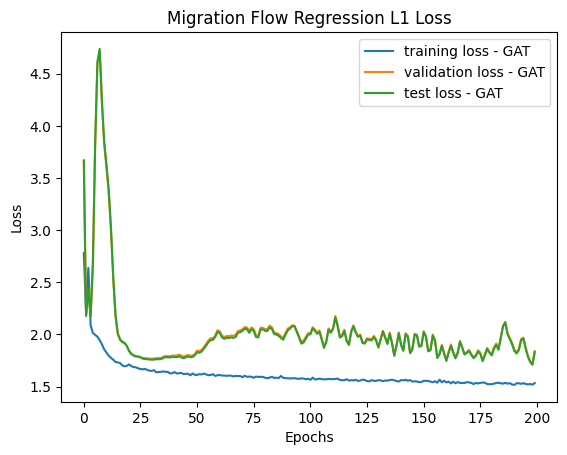

Running pipeline with config: Regression_GAT_simple_within_state


Training:   0%|          | 1/200 [00:00<01:00,  3.30Epochs/s]

Epoch 1: Training Loss 2.8924, Training R2 -1.83967 Validation Loss 4.28964 Validation R2 -3.20198


Training:   1%|          | 2/200 [00:00<00:59,  3.33Epochs/s]

Epoch 2: Training Loss 2.1194, Training R2 -0.30629 Validation Loss 14.19865 Validation R2 -36.38834


Training:   2%|▏         | 3/200 [00:00<00:58,  3.34Epochs/s]

Epoch 3: Training Loss 2.80933, Training R2 -1.67597 Validation Loss 8.0007 Validation R2 -11.51797


Training:   2%|▏         | 4/200 [00:01<00:58,  3.37Epochs/s]

Epoch 4: Training Loss 2.10771, Training R2 -0.53732 Validation Loss 3.59508 Validation R2 -2.19955


Training:   2%|▎         | 5/200 [00:01<00:58,  3.31Epochs/s]

Epoch 5: Training Loss 2.17977, Training R2 -0.41773 Validation Loss 2.89542 Validation R2 -1.28484


Training:   3%|▎         | 6/200 [00:01<00:58,  3.34Epochs/s]

Epoch 6: Training Loss 2.09641, Training R2 -0.23856 Validation Loss 3.19053 Validation R2 -1.64425


Training:   4%|▎         | 7/200 [00:02<00:57,  3.35Epochs/s]

Epoch 7: Training Loss 2.03208, Training R2 -0.23382 Validation Loss 3.64183 Validation R2 -2.24232


Training:   4%|▍         | 8/200 [00:02<00:57,  3.31Epochs/s]

Epoch 8: Training Loss 1.99764, Training R2 -0.2792 Validation Loss 3.37143 Validation R2 -1.86498


Training:   4%|▍         | 9/200 [00:02<00:57,  3.35Epochs/s]

Epoch 9: Training Loss 1.97564, Training R2 -0.25654 Validation Loss 2.46476 Validation R2 -0.77181


Training:   5%|▌         | 10/200 [00:02<00:56,  3.35Epochs/s]

Epoch 10: Training Loss 1.92451, Training R2 -0.185 Validation Loss 1.87269 Validation R2 -0.03185


Training:   6%|▌         | 11/200 [00:03<00:56,  3.36Epochs/s]

Epoch 11: Training Loss 1.84097, Training R2 -0.0536 Validation Loss 2.0515 Validation R2 0.04329


Training:   6%|▌         | 12/200 [00:03<00:56,  3.32Epochs/s]

Epoch 12: Training Loss 1.90825, Training R2 -0.10231 Validation Loss 2.17823 Validation R2 -0.04058


Training:   6%|▋         | 13/200 [00:03<00:55,  3.35Epochs/s]

Epoch 13: Training Loss 1.83867, Training R2 -0.09253 Validation Loss 2.1255 Validation R2 0.01719


Training:   7%|▋         | 14/200 [00:04<00:55,  3.37Epochs/s]

Epoch 14: Training Loss 1.81239, Training R2 -0.06128 Validation Loss 2.16998 Validation R2 -0.0065


Training:   8%|▊         | 15/200 [00:04<00:55,  3.33Epochs/s]

Epoch 15: Training Loss 1.82651, Training R2 -0.10528 Validation Loss 2.24263 Validation R2 -0.07312


Training:   8%|▊         | 16/200 [00:04<00:54,  3.36Epochs/s]

Epoch 16: Training Loss 1.82424, Training R2 -0.11245 Validation Loss 2.34608 Validation R2 -0.18834


Training:   8%|▊         | 17/200 [00:05<00:54,  3.38Epochs/s]

Epoch 17: Training Loss 1.79759, Training R2 -0.0756 Validation Loss 2.45083 Validation R2 -0.34106


Training:   9%|▉         | 18/200 [00:05<00:54,  3.36Epochs/s]

Epoch 18: Training Loss 1.76445, Training R2 -0.01084 Validation Loss 2.50698 Validation R2 -0.42743


Training:  10%|▉         | 19/200 [00:05<00:53,  3.35Epochs/s]

Epoch 19: Training Loss 1.79077, Training R2 -0.01943 Validation Loss 2.52573 Validation R2 -0.46353


Training:  10%|█         | 20/200 [00:05<00:53,  3.36Epochs/s]

Epoch 20: Training Loss 1.76751, Training R2 -0.01155 Validation Loss 2.52892 Validation R2 -0.4678


Training:  10%|█         | 21/200 [00:06<00:53,  3.36Epochs/s]

Epoch 21: Training Loss 1.77743, Training R2 -0.01023 Validation Loss 2.51874 Validation R2 -0.44442


Training:  11%|█         | 22/200 [00:06<00:53,  3.33Epochs/s]

Epoch 22: Training Loss 1.74558, Training R2 0.01694 Validation Loss 2.52683 Validation R2 -0.45314


Training:  12%|█▏        | 23/200 [00:06<00:52,  3.37Epochs/s]

Epoch 23: Training Loss 1.74343, Training R2 0.02737 Validation Loss 2.53311 Validation R2 -0.46744


Training:  12%|█▏        | 24/200 [00:07<00:51,  3.39Epochs/s]

Epoch 24: Training Loss 1.73845, Training R2 0.00668 Validation Loss 2.56001 Validation R2 -0.52097


Training:  12%|█▎        | 25/200 [00:07<00:51,  3.39Epochs/s]

Epoch 25: Training Loss 1.73442, Training R2 0.00309 Validation Loss 2.56462 Validation R2 -0.53823


Training:  13%|█▎        | 26/200 [00:07<00:51,  3.35Epochs/s]

Epoch 26: Training Loss 1.73928, Training R2 0.01432 Validation Loss 2.55478 Validation R2 -0.52882


Training:  14%|█▎        | 27/200 [00:08<00:51,  3.38Epochs/s]

Epoch 27: Training Loss 1.729, Training R2 0.04266 Validation Loss 2.51282 Validation R2 -0.46263


Training:  14%|█▍        | 28/200 [00:08<00:50,  3.38Epochs/s]

Epoch 28: Training Loss 1.73245, Training R2 0.05057 Validation Loss 2.46052 Validation R2 -0.38686


Training:  14%|█▍        | 29/200 [00:08<00:55,  3.08Epochs/s]

Epoch 29: Training Loss 1.70845, Training R2 0.05519 Validation Loss 2.39902 Validation R2 -0.30087


Training:  15%|█▌        | 30/200 [00:09<00:58,  2.89Epochs/s]

Epoch 30: Training Loss 1.71052, Training R2 0.03201 Validation Loss 2.3416 Validation R2 -0.22108


Training:  16%|█▌        | 31/200 [00:09<01:01,  2.75Epochs/s]

Epoch 31: Training Loss 1.7012, Training R2 0.04998 Validation Loss 2.35296 Validation R2 -0.23139


Training:  16%|█▌        | 32/200 [00:09<01:03,  2.66Epochs/s]

Epoch 32: Training Loss 1.7225, Training R2 0.02024 Validation Loss 2.28783 Validation R2 -0.15443


Training:  16%|█▋        | 33/200 [00:10<01:04,  2.58Epochs/s]

Epoch 33: Training Loss 1.68874, Training R2 0.06255 Validation Loss 2.28266 Validation R2 -0.15305


Training:  17%|█▋        | 34/200 [00:10<01:05,  2.52Epochs/s]

Epoch 34: Training Loss 1.70487, Training R2 0.0571 Validation Loss 2.29566 Validation R2 -0.17394


Training:  18%|█▊        | 35/200 [00:11<01:05,  2.50Epochs/s]

Epoch 35: Training Loss 1.68777, Training R2 0.0799 Validation Loss 2.34124 Validation R2 -0.23815


Training:  18%|█▊        | 36/200 [00:11<01:05,  2.50Epochs/s]

Epoch 36: Training Loss 1.68718, Training R2 0.08143 Validation Loss 2.38098 Validation R2 -0.29999


Training:  18%|█▊        | 37/200 [00:11<01:05,  2.48Epochs/s]

Epoch 37: Training Loss 1.696, Training R2 0.07014 Validation Loss 2.44638 Validation R2 -0.40237


Training:  19%|█▉        | 38/200 [00:12<01:06,  2.44Epochs/s]

Epoch 38: Training Loss 1.67896, Training R2 0.09706 Validation Loss 2.49259 Validation R2 -0.48254


Training:  20%|█▉        | 39/200 [00:12<01:05,  2.46Epochs/s]

Epoch 39: Training Loss 1.66452, Training R2 0.09757 Validation Loss 2.48422 Validation R2 -0.47058


Training:  20%|██        | 40/200 [00:13<01:04,  2.47Epochs/s]

Epoch 40: Training Loss 1.67742, Training R2 0.08475 Validation Loss 2.49813 Validation R2 -0.49176


Training:  20%|██        | 41/200 [00:13<01:03,  2.49Epochs/s]

Epoch 41: Training Loss 1.67005, Training R2 0.09042 Validation Loss 2.48491 Validation R2 -0.46583


Training:  21%|██        | 42/200 [00:13<00:59,  2.68Epochs/s]

Epoch 42: Training Loss 1.6774, Training R2 0.08119 Validation Loss 2.46007 Validation R2 -0.42116


Training:  22%|██▏       | 43/200 [00:14<00:55,  2.84Epochs/s]

Epoch 43: Training Loss 1.65357, Training R2 0.10423 Validation Loss 2.42908 Validation R2 -0.37528


Training:  22%|██▏       | 44/200 [00:14<00:52,  2.95Epochs/s]

Epoch 44: Training Loss 1.64495, Training R2 0.10527 Validation Loss 2.41977 Validation R2 -0.36365


Training:  22%|██▎       | 45/200 [00:14<00:50,  3.06Epochs/s]

Epoch 45: Training Loss 1.64533, Training R2 0.11306 Validation Loss 2.4289 Validation R2 -0.38007


Training:  23%|██▎       | 46/200 [00:15<00:49,  3.12Epochs/s]

Epoch 46: Training Loss 1.62805, Training R2 0.11904 Validation Loss 2.45856 Validation R2 -0.42873


Training:  24%|██▎       | 47/200 [00:15<00:48,  3.17Epochs/s]

Epoch 47: Training Loss 1.62213, Training R2 0.13316 Validation Loss 2.48336 Validation R2 -0.47219


Training:  24%|██▍       | 48/200 [00:15<00:46,  3.24Epochs/s]

Epoch 48: Training Loss 1.61994, Training R2 0.1267 Validation Loss 2.51145 Validation R2 -0.52324


Training:  24%|██▍       | 49/200 [00:16<00:46,  3.23Epochs/s]

Epoch 49: Training Loss 1.63032, Training R2 0.11225 Validation Loss 2.5565 Validation R2 -0.60306


Training:  25%|██▌       | 50/200 [00:16<00:46,  3.25Epochs/s]

Epoch 50: Training Loss 1.62402, Training R2 0.09928 Validation Loss 2.61337 Validation R2 -0.69821


Training:  26%|██▌       | 51/200 [00:16<00:45,  3.28Epochs/s]

Epoch 51: Training Loss 1.62031, Training R2 0.12605 Validation Loss 2.62732 Validation R2 -0.72229


Training:  26%|██▌       | 52/200 [00:16<00:44,  3.31Epochs/s]

Epoch 52: Training Loss 1.61953, Training R2 0.12791 Validation Loss 2.63044 Validation R2 -0.72893


Training:  26%|██▋       | 53/200 [00:17<00:44,  3.28Epochs/s]

Epoch 53: Training Loss 1.61296, Training R2 0.13209 Validation Loss 2.62622 Validation R2 -0.7209


Training:  27%|██▋       | 54/200 [00:17<00:44,  3.29Epochs/s]

Epoch 54: Training Loss 1.60856, Training R2 0.12318 Validation Loss 2.63184 Validation R2 -0.73322


Training:  28%|██▊       | 55/200 [00:17<00:43,  3.31Epochs/s]

Epoch 55: Training Loss 1.60718, Training R2 0.11564 Validation Loss 2.65105 Validation R2 -0.7662


Training:  28%|██▊       | 56/200 [00:18<00:43,  3.29Epochs/s]

Epoch 56: Training Loss 1.60651, Training R2 0.126 Validation Loss 2.65794 Validation R2 -0.77301


Training:  28%|██▊       | 57/200 [00:18<00:43,  3.30Epochs/s]

Epoch 57: Training Loss 1.59988, Training R2 0.13964 Validation Loss 2.65876 Validation R2 -0.77266


Training:  29%|██▉       | 58/200 [00:18<00:42,  3.32Epochs/s]

Epoch 58: Training Loss 1.59994, Training R2 0.13398 Validation Loss 2.66604 Validation R2 -0.79113


Training:  30%|██▉       | 59/200 [00:19<00:42,  3.33Epochs/s]

Epoch 59: Training Loss 1.59223, Training R2 0.12967 Validation Loss 2.73432 Validation R2 -0.92936


Training:  30%|███       | 60/200 [00:19<00:42,  3.31Epochs/s]

Epoch 60: Training Loss 1.59301, Training R2 0.13967 Validation Loss 2.71147 Validation R2 -0.88679


Training:  30%|███       | 61/200 [00:19<00:42,  3.30Epochs/s]

Epoch 61: Training Loss 1.59788, Training R2 0.14162 Validation Loss 2.63781 Validation R2 -0.74039


Training:  31%|███       | 62/200 [00:19<00:41,  3.33Epochs/s]

Epoch 62: Training Loss 1.59583, Training R2 0.14341 Validation Loss 2.56069 Validation R2 -0.58914


Training:  32%|███▏      | 63/200 [00:20<00:41,  3.28Epochs/s]

Epoch 63: Training Loss 1.59713, Training R2 0.13564 Validation Loss 2.52187 Validation R2 -0.52021


Training:  32%|███▏      | 64/200 [00:20<00:41,  3.29Epochs/s]

Epoch 64: Training Loss 1.59001, Training R2 0.13231 Validation Loss 2.54688 Validation R2 -0.56889


Training:  32%|███▎      | 65/200 [00:20<00:40,  3.32Epochs/s]

Epoch 65: Training Loss 1.5904, Training R2 0.12796 Validation Loss 2.65171 Validation R2 -0.76759


Training:  33%|███▎      | 66/200 [00:21<00:40,  3.30Epochs/s]

Epoch 66: Training Loss 1.59119, Training R2 0.14108 Validation Loss 2.72444 Validation R2 -0.9075


Training:  34%|███▎      | 67/200 [00:21<00:40,  3.31Epochs/s]

Epoch 67: Training Loss 1.59371, Training R2 0.15048 Validation Loss 2.69286 Validation R2 -0.85161


Training:  34%|███▍      | 68/200 [00:21<00:39,  3.34Epochs/s]

Epoch 68: Training Loss 1.58319, Training R2 0.15051 Validation Loss 2.63373 Validation R2 -0.74595


Training:  34%|███▍      | 69/200 [00:22<00:39,  3.33Epochs/s]

Epoch 69: Training Loss 1.59164, Training R2 0.13054 Validation Loss 2.61946 Validation R2 -0.72298


Training:  35%|███▌      | 70/200 [00:22<00:39,  3.27Epochs/s]

Epoch 70: Training Loss 1.58246, Training R2 0.14157 Validation Loss 2.62783 Validation R2 -0.73822


Training:  36%|███▌      | 71/200 [00:22<00:39,  3.29Epochs/s]

Epoch 71: Training Loss 1.58033, Training R2 0.1413 Validation Loss 2.68397 Validation R2 -0.84156


Training:  36%|███▌      | 72/200 [00:22<00:38,  3.31Epochs/s]

Epoch 72: Training Loss 1.58376, Training R2 0.15006 Validation Loss 2.72444 Validation R2 -0.918


Training:  36%|███▋      | 73/200 [00:23<00:38,  3.28Epochs/s]

Epoch 73: Training Loss 1.58417, Training R2 0.13788 Validation Loss 2.80037 Validation R2 -1.0438


Training:  37%|███▋      | 74/200 [00:23<00:39,  3.17Epochs/s]

Epoch 74: Training Loss 1.58052, Training R2 0.14432 Validation Loss 2.88392 Validation R2 -1.17192


Training:  38%|███▊      | 75/200 [00:24<00:42,  2.92Epochs/s]

Epoch 75: Training Loss 1.57522, Training R2 0.1583 Validation Loss 2.94177 Validation R2 -1.25561


Training:  38%|███▊      | 76/200 [00:24<00:44,  2.78Epochs/s]

Epoch 76: Training Loss 1.58532, Training R2 0.14461 Validation Loss 2.87107 Validation R2 -1.1438


Training:  38%|███▊      | 77/200 [00:24<00:45,  2.71Epochs/s]

Epoch 77: Training Loss 1.58659, Training R2 0.14093 Validation Loss 2.82011 Validation R2 -1.0626


Training:  39%|███▉      | 78/200 [00:25<00:46,  2.60Epochs/s]

Epoch 78: Training Loss 1.58435, Training R2 0.14368 Validation Loss 2.75865 Validation R2 -0.96382


Training:  40%|███▉      | 79/200 [00:25<00:47,  2.55Epochs/s]

Epoch 79: Training Loss 1.57885, Training R2 0.15193 Validation Loss 2.72231 Validation R2 -0.90244


Training:  40%|████      | 80/200 [00:26<00:47,  2.50Epochs/s]

Epoch 80: Training Loss 1.57333, Training R2 0.15134 Validation Loss 2.72201 Validation R2 -0.89997


Training:  40%|████      | 81/200 [00:26<00:48,  2.48Epochs/s]

Epoch 81: Training Loss 1.57574, Training R2 0.14633 Validation Loss 2.77404 Validation R2 -0.98068


Training:  41%|████      | 82/200 [00:26<00:47,  2.47Epochs/s]

Epoch 82: Training Loss 1.57749, Training R2 0.14632 Validation Loss 2.74928 Validation R2 -0.9421


Training:  42%|████▏     | 83/200 [00:27<00:47,  2.45Epochs/s]

Epoch 83: Training Loss 1.58258, Training R2 0.13979 Validation Loss 2.71313 Validation R2 -0.88082


Training:  42%|████▏     | 84/200 [00:27<00:48,  2.39Epochs/s]

Epoch 84: Training Loss 1.57816, Training R2 0.15356 Validation Loss 2.64585 Validation R2 -0.76625


Training:  42%|████▎     | 85/200 [00:28<00:46,  2.46Epochs/s]

Epoch 85: Training Loss 1.58303, Training R2 0.15481 Validation Loss 2.55501 Validation R2 -0.61807


Training:  43%|████▎     | 86/200 [00:28<00:45,  2.50Epochs/s]

Epoch 86: Training Loss 1.5728, Training R2 0.14886 Validation Loss 2.53765 Validation R2 -0.59783


Training:  44%|████▎     | 87/200 [00:28<00:45,  2.49Epochs/s]

Epoch 87: Training Loss 1.58496, Training R2 0.12099 Validation Loss 2.59936 Validation R2 -0.69693


Training:  44%|████▍     | 88/200 [00:29<00:41,  2.69Epochs/s]

Epoch 88: Training Loss 1.57454, Training R2 0.14074 Validation Loss 2.73593 Validation R2 -0.91188


Training:  44%|████▍     | 89/200 [00:29<00:38,  2.85Epochs/s]

Epoch 89: Training Loss 1.58584, Training R2 0.15636 Validation Loss 2.85797 Validation R2 -1.10174


Training:  45%|████▌     | 90/200 [00:29<00:37,  2.94Epochs/s]

Epoch 90: Training Loss 1.57681, Training R2 0.16416 Validation Loss 2.95516 Validation R2 -1.24936


Training:  46%|████▌     | 91/200 [00:30<00:35,  3.06Epochs/s]

Epoch 91: Training Loss 1.57632, Training R2 0.15473 Validation Loss 2.97489 Validation R2 -1.27842


Training:  46%|████▌     | 92/200 [00:30<00:34,  3.11Epochs/s]

Epoch 92: Training Loss 1.57898, Training R2 0.1271 Validation Loss 3.00109 Validation R2 -1.31277


Training:  46%|████▋     | 93/200 [00:30<00:34,  3.13Epochs/s]

Epoch 93: Training Loss 1.56523, Training R2 0.1649 Validation Loss 3.00217 Validation R2 -1.31694


Training:  47%|████▋     | 94/200 [00:31<00:33,  3.20Epochs/s]

Epoch 94: Training Loss 1.57605, Training R2 0.17109 Validation Loss 2.98354 Validation R2 -1.2847


Training:  48%|████▊     | 95/200 [00:31<00:32,  3.20Epochs/s]

Epoch 95: Training Loss 1.5624, Training R2 0.15693 Validation Loss 2.99468 Validation R2 -1.29717


Training:  48%|████▊     | 96/200 [00:31<00:32,  3.24Epochs/s]

Epoch 96: Training Loss 1.58369, Training R2 0.12747 Validation Loss 3.09432 Validation R2 -1.44741


Training:  48%|████▊     | 97/200 [00:31<00:31,  3.23Epochs/s]

Epoch 97: Training Loss 1.56656, Training R2 0.1546 Validation Loss 3.08772 Validation R2 -1.44128


Training:  49%|████▉     | 98/200 [00:32<00:31,  3.26Epochs/s]

Epoch 98: Training Loss 1.56764, Training R2 0.16621 Validation Loss 3.12626 Validation R2 -1.4963


Training:  50%|████▉     | 99/200 [00:32<00:30,  3.30Epochs/s]

Epoch 99: Training Loss 1.55865, Training R2 0.16777 Validation Loss 3.15667 Validation R2 -1.53935


Training:  50%|█████     | 100/200 [00:32<00:30,  3.26Epochs/s]

Epoch 100: Training Loss 1.57057, Training R2 0.14689 Validation Loss 3.28847 Validation R2 -1.73302


Training:  50%|█████     | 101/200 [00:33<00:30,  3.26Epochs/s]

Epoch 101: Training Loss 1.56577, Training R2 0.15604 Validation Loss 3.45578 Validation R2 -1.97934


Training:  51%|█████     | 102/200 [00:33<00:29,  3.28Epochs/s]

Epoch 102: Training Loss 1.56614, Training R2 0.15743 Validation Loss 3.64715 Validation R2 -2.26133


Training:  52%|█████▏    | 103/200 [00:33<00:29,  3.24Epochs/s]

Epoch 103: Training Loss 1.5685, Training R2 0.16198 Validation Loss 3.83927 Validation R2 -2.54579


Training:  52%|█████▏    | 104/200 [00:34<00:29,  3.25Epochs/s]

Epoch 104: Training Loss 1.55978, Training R2 0.17402 Validation Loss 3.89966 Validation R2 -2.63627


Training:  52%|█████▎    | 105/200 [00:34<00:29,  3.25Epochs/s]

Epoch 105: Training Loss 1.5559, Training R2 0.16421 Validation Loss 3.87278 Validation R2 -2.5954


Training:  53%|█████▎    | 106/200 [00:34<00:29,  3.21Epochs/s]

Epoch 106: Training Loss 1.56573, Training R2 0.14597 Validation Loss 3.89321 Validation R2 -2.62684


Training:  54%|█████▎    | 107/200 [00:35<00:28,  3.21Epochs/s]

Epoch 107: Training Loss 1.55831, Training R2 0.15671 Validation Loss 3.80308 Validation R2 -2.49527


Training:  54%|█████▍    | 108/200 [00:35<00:28,  3.21Epochs/s]

Epoch 108: Training Loss 1.55722, Training R2 0.17819 Validation Loss 3.6609 Validation R2 -2.28619


Training:  55%|█████▍    | 109/200 [00:35<00:27,  3.25Epochs/s]

Epoch 109: Training Loss 1.56379, Training R2 0.15772 Validation Loss 3.56907 Validation R2 -2.15155


Training:  55%|█████▌    | 110/200 [00:35<00:27,  3.24Epochs/s]

Epoch 110: Training Loss 1.56905, Training R2 0.1503 Validation Loss 3.59995 Validation R2 -2.19861


Training:  56%|█████▌    | 111/200 [00:36<00:27,  3.23Epochs/s]

Epoch 111: Training Loss 1.56382, Training R2 0.14974 Validation Loss 3.76074 Validation R2 -2.43816


Training:  56%|█████▌    | 112/200 [00:36<00:27,  3.25Epochs/s]

Epoch 112: Training Loss 1.5529, Training R2 0.1755 Validation Loss 3.83199 Validation R2 -2.54751


Training:  56%|█████▋    | 113/200 [00:36<00:27,  3.22Epochs/s]

Epoch 113: Training Loss 1.55219, Training R2 0.18032 Validation Loss 3.72388 Validation R2 -2.39078


Training:  57%|█████▋    | 114/200 [00:37<00:26,  3.23Epochs/s]

Epoch 114: Training Loss 1.55698, Training R2 0.16316 Validation Loss 3.60489 Validation R2 -2.22004


Training:  57%|█████▊    | 115/200 [00:37<00:26,  3.25Epochs/s]

Epoch 115: Training Loss 1.55366, Training R2 0.15986 Validation Loss 3.49733 Validation R2 -2.06796


Training:  58%|█████▊    | 116/200 [00:37<00:25,  3.26Epochs/s]

Epoch 116: Training Loss 1.55425, Training R2 0.17012 Validation Loss 3.32906 Validation R2 -1.82839


Training:  58%|█████▊    | 117/200 [00:38<00:25,  3.25Epochs/s]

Epoch 117: Training Loss 1.56537, Training R2 0.16914 Validation Loss 3.14636 Validation R2 -1.56142


Training:  59%|█████▉    | 118/200 [00:38<00:25,  3.25Epochs/s]

Epoch 118: Training Loss 1.54925, Training R2 0.17223 Validation Loss 3.03135 Validation R2 -1.38805


Training:  60%|█████▉    | 119/200 [00:38<00:24,  3.29Epochs/s]

Epoch 119: Training Loss 1.54671, Training R2 0.17376 Validation Loss 2.94945 Validation R2 -1.2604


Training:  60%|██████    | 120/200 [00:39<00:25,  3.08Epochs/s]

Epoch 120: Training Loss 1.55434, Training R2 0.16559 Validation Loss 3.00758 Validation R2 -1.34401


Training:  60%|██████    | 121/200 [00:39<00:27,  2.86Epochs/s]

Epoch 121: Training Loss 1.55355, Training R2 0.16755 Validation Loss 3.22272 Validation R2 -1.66244


Training:  61%|██████    | 122/200 [00:39<00:28,  2.72Epochs/s]

Epoch 122: Training Loss 1.5399, Training R2 0.18419 Validation Loss 3.45713 Validation R2 -1.99448


Training:  62%|██████▏   | 123/200 [00:40<00:29,  2.58Epochs/s]

Epoch 123: Training Loss 1.54745, Training R2 0.17055 Validation Loss 3.60897 Validation R2 -2.20795


Training:  62%|██████▏   | 124/200 [00:40<00:30,  2.47Epochs/s]

Epoch 124: Training Loss 1.54877, Training R2 0.16905 Validation Loss 3.71021 Validation R2 -2.35402


Training:  62%|██████▎   | 125/200 [00:41<00:30,  2.48Epochs/s]

Epoch 125: Training Loss 1.5458, Training R2 0.17672 Validation Loss 3.71881 Validation R2 -2.36536


Training:  63%|██████▎   | 126/200 [00:41<00:30,  2.46Epochs/s]

Epoch 126: Training Loss 1.54517, Training R2 0.17887 Validation Loss 3.65393 Validation R2 -2.26988


Training:  64%|██████▎   | 127/200 [00:42<00:29,  2.46Epochs/s]

Epoch 127: Training Loss 1.54186, Training R2 0.18672 Validation Loss 3.53138 Validation R2 -2.08921


Training:  64%|██████▍   | 128/200 [00:42<00:29,  2.41Epochs/s]

Epoch 128: Training Loss 1.54443, Training R2 0.1755 Validation Loss 3.50045 Validation R2 -2.0418


Training:  64%|██████▍   | 129/200 [00:42<00:30,  2.36Epochs/s]

Epoch 129: Training Loss 1.54581, Training R2 0.1722 Validation Loss 3.50598 Validation R2 -2.04531


Training:  65%|██████▌   | 130/200 [00:43<00:30,  2.32Epochs/s]

Epoch 130: Training Loss 1.54423, Training R2 0.16946 Validation Loss 3.64259 Validation R2 -2.24505


Training:  66%|██████▌   | 131/200 [00:43<00:28,  2.39Epochs/s]

Epoch 131: Training Loss 1.55151, Training R2 0.18063 Validation Loss 3.48283 Validation R2 -2.01127


Training:  66%|██████▌   | 132/200 [00:44<00:27,  2.45Epochs/s]

Epoch 132: Training Loss 1.54643, Training R2 0.17385 Validation Loss 3.45136 Validation R2 -1.96328


Training:  66%|██████▋   | 133/200 [00:44<00:25,  2.64Epochs/s]

Epoch 133: Training Loss 1.54166, Training R2 0.17155 Validation Loss 3.34809 Validation R2 -1.81334


Training:  67%|██████▋   | 134/200 [00:44<00:23,  2.81Epochs/s]

Epoch 134: Training Loss 1.56029, Training R2 0.14684 Validation Loss 3.4655 Validation R2 -1.99522


Training:  68%|██████▊   | 135/200 [00:45<00:22,  2.93Epochs/s]

Epoch 135: Training Loss 1.55009, Training R2 0.19015 Validation Loss 3.42466 Validation R2 -1.9357


Training:  68%|██████▊   | 136/200 [00:45<00:21,  3.00Epochs/s]

Epoch 136: Training Loss 1.54637, Training R2 0.18804 Validation Loss 3.17901 Validation R2 -1.57425


Training:  68%|██████▊   | 137/200 [00:45<00:20,  3.07Epochs/s]

Epoch 137: Training Loss 1.55442, Training R2 0.15096 Validation Loss 3.26332 Validation R2 -1.70873


Training:  69%|██████▉   | 138/200 [00:46<00:20,  3.09Epochs/s]

Epoch 138: Training Loss 1.54486, Training R2 0.176 Validation Loss 3.35773 Validation R2 -1.86067


Training:  70%|██████▉   | 139/200 [00:46<00:19,  3.14Epochs/s]

Epoch 139: Training Loss 1.55984, Training R2 0.17969 Validation Loss 3.13698 Validation R2 -1.53513


Training:  70%|███████   | 140/200 [00:46<00:18,  3.19Epochs/s]

Epoch 140: Training Loss 1.53646, Training R2 0.18347 Validation Loss 2.95665 Validation R2 -1.25495


Training:  70%|███████   | 141/200 [00:46<00:18,  3.21Epochs/s]

Epoch 141: Training Loss 1.5604, Training R2 0.14122 Validation Loss 3.11501 Validation R2 -1.49481


Training:  71%|███████   | 142/200 [00:47<00:18,  3.20Epochs/s]

Epoch 142: Training Loss 1.54271, Training R2 0.18708 Validation Loss 3.15682 Validation R2 -1.55989


Training:  72%|███████▏  | 143/200 [00:47<00:17,  3.19Epochs/s]

Epoch 143: Training Loss 1.55267, Training R2 0.19431 Validation Loss 2.99694 Validation R2 -1.31813


Training:  72%|███████▏  | 144/200 [00:47<00:17,  3.20Epochs/s]

Epoch 144: Training Loss 1.54492, Training R2 0.17004 Validation Loss 3.04463 Validation R2 -1.38759


Training:  72%|███████▎  | 145/200 [00:48<00:17,  3.22Epochs/s]

Epoch 145: Training Loss 1.5585, Training R2 0.1433 Validation Loss 3.28892 Validation R2 -1.75027


Training:  73%|███████▎  | 146/200 [00:48<00:16,  3.19Epochs/s]

Epoch 146: Training Loss 1.54428, Training R2 0.17898 Validation Loss 3.29615 Validation R2 -1.76292


Training:  74%|███████▎  | 147/200 [00:48<00:16,  3.22Epochs/s]

Epoch 147: Training Loss 1.55426, Training R2 0.18362 Validation Loss 3.089 Validation R2 -1.45569


Training:  74%|███████▍  | 148/200 [00:49<00:16,  3.20Epochs/s]

Epoch 148: Training Loss 1.5361, Training R2 0.18422 Validation Loss 2.98801 Validation R2 -1.30245


Training:  74%|███████▍  | 149/200 [00:49<00:15,  3.23Epochs/s]

Epoch 149: Training Loss 1.54204, Training R2 0.15835 Validation Loss 3.11227 Validation R2 -1.49938


Training:  75%|███████▌  | 150/200 [00:49<00:15,  3.20Epochs/s]

Epoch 150: Training Loss 1.53611, Training R2 0.17609 Validation Loss 3.40825 Validation R2 -1.9452


Training:  76%|███████▌  | 151/200 [00:50<00:15,  3.22Epochs/s]

Epoch 151: Training Loss 1.55678, Training R2 0.18984 Validation Loss 3.32345 Validation R2 -1.83144


Training:  76%|███████▌  | 152/200 [00:50<00:14,  3.23Epochs/s]

Epoch 152: Training Loss 1.54731, Training R2 0.18562 Validation Loss 3.01933 Validation R2 -1.38257


Training:  76%|███████▋  | 153/200 [00:50<00:14,  3.24Epochs/s]

Epoch 153: Training Loss 1.54104, Training R2 0.16616 Validation Loss 2.99254 Validation R2 -1.34878


Training:  77%|███████▋  | 154/200 [00:50<00:14,  3.26Epochs/s]

Epoch 154: Training Loss 1.55121, Training R2 0.15623 Validation Loss 3.24439 Validation R2 -1.74366


Training:  78%|███████▊  | 155/200 [00:51<00:13,  3.26Epochs/s]

Epoch 155: Training Loss 1.57056, Training R2 0.18813 Validation Loss 2.90579 Validation R2 -1.21173


Training:  78%|███████▊  | 156/200 [00:51<00:13,  3.26Epochs/s]

Epoch 156: Training Loss 1.54276, Training R2 0.19748 Validation Loss 2.60102 Validation R2 -0.70895


Training:  78%|███████▊  | 157/200 [00:51<00:13,  3.26Epochs/s]

Epoch 157: Training Loss 1.55506, Training R2 0.15049 Validation Loss 2.65617 Validation R2 -0.79408


Training:  79%|███████▉  | 158/200 [00:52<00:12,  3.29Epochs/s]

Epoch 158: Training Loss 1.55002, Training R2 0.15476 Validation Loss 2.92415 Validation R2 -1.25508


Training:  80%|███████▉  | 159/200 [00:52<00:12,  3.29Epochs/s]

Epoch 159: Training Loss 1.54045, Training R2 0.20031 Validation Loss 3.09755 Validation R2 -1.53552


Training:  80%|████████  | 160/200 [00:52<00:12,  3.28Epochs/s]

Epoch 160: Training Loss 1.54469, Training R2 0.19571 Validation Loss 2.95374 Validation R2 -1.30105


Training:  80%|████████  | 161/200 [00:53<00:11,  3.29Epochs/s]

Epoch 161: Training Loss 1.53239, Training R2 0.17208 Validation Loss 2.8707 Validation R2 -1.16402


Training:  81%|████████  | 162/200 [00:53<00:11,  3.28Epochs/s]

Epoch 162: Training Loss 1.53546, Training R2 0.17235 Validation Loss 2.98223 Validation R2 -1.35911


Training:  82%|████████▏ | 163/200 [00:53<00:11,  3.27Epochs/s]

Epoch 163: Training Loss 1.53933, Training R2 0.18379 Validation Loss 3.13587 Validation R2 -1.60854


Training:  82%|████████▏ | 164/200 [00:54<00:11,  3.25Epochs/s]

Epoch 164: Training Loss 1.54406, Training R2 0.19596 Validation Loss 3.07906 Validation R2 -1.51733


Training:  82%|████████▎ | 165/200 [00:54<00:11,  3.06Epochs/s]

Epoch 165: Training Loss 1.53574, Training R2 0.19715 Validation Loss 2.97961 Validation R2 -1.342


Training:  83%|████████▎ | 166/200 [00:54<00:12,  2.81Epochs/s]

Epoch 166: Training Loss 1.54746, Training R2 0.15603 Validation Loss 3.09542 Validation R2 -1.52704


Training:  84%|████████▎ | 167/200 [00:55<00:12,  2.73Epochs/s]

Epoch 167: Training Loss 1.53354, Training R2 0.17777 Validation Loss 3.40812 Validation R2 -1.97972


Training:  84%|████████▍ | 168/200 [00:55<00:11,  2.67Epochs/s]

Epoch 168: Training Loss 1.54016, Training R2 0.1966 Validation Loss 3.40991 Validation R2 -1.97848


Training:  84%|████████▍ | 169/200 [00:55<00:11,  2.61Epochs/s]

Epoch 169: Training Loss 1.54621, Training R2 0.18917 Validation Loss 3.16156 Validation R2 -1.61131


Training:  85%|████████▌ | 170/200 [00:56<00:11,  2.61Epochs/s]

Epoch 170: Training Loss 1.53142, Training R2 0.1786 Validation Loss 3.20784 Validation R2 -1.67466


Training:  86%|████████▌ | 171/200 [00:56<00:11,  2.60Epochs/s]

Epoch 171: Training Loss 1.54319, Training R2 0.15666 Validation Loss 3.72515 Validation R2 -2.41053


Training:  86%|████████▌ | 172/200 [00:57<00:11,  2.53Epochs/s]

Epoch 172: Training Loss 1.53138, Training R2 0.19027 Validation Loss 4.11318 Validation R2 -2.99128


Training:  86%|████████▋ | 173/200 [00:57<00:11,  2.44Epochs/s]

Epoch 173: Training Loss 1.55148, Training R2 0.19248 Validation Loss 4.24043 Validation R2 -3.18692


Training:  87%|████████▋ | 174/200 [00:58<00:10,  2.45Epochs/s]

Epoch 174: Training Loss 1.53742, Training R2 0.1944 Validation Loss 4.1624 Validation R2 -3.05748


Training:  88%|████████▊ | 175/200 [00:58<00:10,  2.46Epochs/s]

Epoch 175: Training Loss 1.5352, Training R2 0.16741 Validation Loss 4.16227 Validation R2 -3.06029


Training:  88%|████████▊ | 176/200 [00:58<00:09,  2.48Epochs/s]

Epoch 176: Training Loss 1.54001, Training R2 0.16831 Validation Loss 4.19667 Validation R2 -3.12285


Training:  88%|████████▊ | 177/200 [00:59<00:09,  2.47Epochs/s]

Epoch 177: Training Loss 1.53237, Training R2 0.19531 Validation Loss 4.09816 Validation R2 -2.9732


Training:  89%|████████▉ | 178/200 [00:59<00:08,  2.49Epochs/s]

Epoch 178: Training Loss 1.54226, Training R2 0.1939 Validation Loss 3.88334 Validation R2 -2.64541


Training:  90%|████████▉ | 179/200 [00:59<00:08,  2.62Epochs/s]

Epoch 179: Training Loss 1.53325, Training R2 0.1759 Validation Loss 3.83313 Validation R2 -2.57382


Training:  90%|█████████ | 180/200 [01:00<00:07,  2.75Epochs/s]

Epoch 180: Training Loss 1.53323, Training R2 0.17303 Validation Loss 3.79078 Validation R2 -2.51229


Training:  90%|█████████ | 181/200 [01:00<00:06,  2.90Epochs/s]

Epoch 181: Training Loss 1.53189, Training R2 0.19837 Validation Loss 3.66295 Validation R2 -2.32796


Training:  91%|█████████ | 182/200 [01:00<00:06,  2.99Epochs/s]

Epoch 182: Training Loss 1.53031, Training R2 0.19851 Validation Loss 3.4783 Validation R2 -2.06823


Training:  92%|█████████▏| 183/200 [01:01<00:05,  3.07Epochs/s]

Epoch 183: Training Loss 1.53172, Training R2 0.19347 Validation Loss 3.31908 Validation R2 -1.85278


Training:  92%|█████████▏| 184/200 [01:01<00:05,  3.11Epochs/s]

Epoch 184: Training Loss 1.54007, Training R2 0.16373 Validation Loss 3.4743 Validation R2 -2.07176


Training:  92%|█████████▎| 185/200 [01:01<00:04,  3.16Epochs/s]

Epoch 185: Training Loss 1.52947, Training R2 0.18659 Validation Loss 3.69218 Validation R2 -2.38269


Training:  93%|█████████▎| 186/200 [01:02<00:04,  3.22Epochs/s]

Epoch 186: Training Loss 1.54318, Training R2 0.19506 Validation Loss 3.39544 Validation R2 -1.97739


Training:  94%|█████████▎| 187/200 [01:02<00:04,  3.20Epochs/s]

Epoch 187: Training Loss 1.52745, Training R2 0.19067 Validation Loss 3.10401 Validation R2 -1.58381


Training:  94%|█████████▍| 188/200 [01:02<00:03,  3.26Epochs/s]

Epoch 188: Training Loss 1.53618, Training R2 0.17036 Validation Loss 3.13411 Validation R2 -1.62415


Training:  94%|█████████▍| 189/200 [01:03<00:03,  3.27Epochs/s]

Epoch 189: Training Loss 1.52663, Training R2 0.19196 Validation Loss 3.43315 Validation R2 -2.02759


Training:  95%|█████████▌| 190/200 [01:03<00:03,  3.23Epochs/s]

Epoch 190: Training Loss 1.53318, Training R2 0.19924 Validation Loss 3.38568 Validation R2 -1.96074


Training:  96%|█████████▌| 191/200 [01:03<00:02,  3.27Epochs/s]

Epoch 191: Training Loss 1.52847, Training R2 0.20026 Validation Loss 3.38958 Validation R2 -1.96474


Training:  96%|█████████▌| 192/200 [01:03<00:02,  3.26Epochs/s]

Epoch 192: Training Loss 1.5237, Training R2 0.18944 Validation Loss 3.43677 Validation R2 -2.0311


Training:  96%|█████████▋| 193/200 [01:04<00:02,  3.28Epochs/s]

Epoch 193: Training Loss 1.53201, Training R2 0.18377 Validation Loss 3.36114 Validation R2 -1.9266


Training:  97%|█████████▋| 194/200 [01:04<00:01,  3.27Epochs/s]

Epoch 194: Training Loss 1.52016, Training R2 0.20563 Validation Loss 3.02999 Validation R2 -1.45952


Training:  98%|█████████▊| 195/200 [01:04<00:01,  3.29Epochs/s]

Epoch 195: Training Loss 1.52375, Training R2 0.19612 Validation Loss 2.93819 Validation R2 -1.30072


Training:  98%|█████████▊| 196/200 [01:05<00:01,  3.30Epochs/s]

Epoch 196: Training Loss 1.52412, Training R2 0.19169 Validation Loss 3.06123 Validation R2 -1.49985


Training:  98%|█████████▊| 197/200 [01:05<00:00,  3.24Epochs/s]

Epoch 197: Training Loss 1.52525, Training R2 0.20015 Validation Loss 3.09338 Validation R2 -1.54507


Training:  99%|█████████▉| 198/200 [01:05<00:00,  3.27Epochs/s]

Epoch 198: Training Loss 1.52904, Training R2 0.19307 Validation Loss 3.17546 Validation R2 -1.6547


Training: 100%|█████████▉| 199/200 [01:06<00:00,  3.29Epochs/s]

Epoch 199: Training Loss 1.52328, Training R2 0.19214 Validation Loss 3.19763 Validation R2 -1.67886


Training: 100%|██████████| 200/200 [01:06<00:00,  3.01Epochs/s]

Epoch 200: Training Loss 1.52347, Training R2 0.19985 Validation Loss 3.01124 Validation R2 -1.39474
Saving Model Predictions for Model Type GAT
Model saved successfully as Regression_GAT_simple_within_state
Minimum validation loss: 1.8726933002471924
Minimum test loss: 1.8643107414245605
Best test metric: -0.0424654483795166


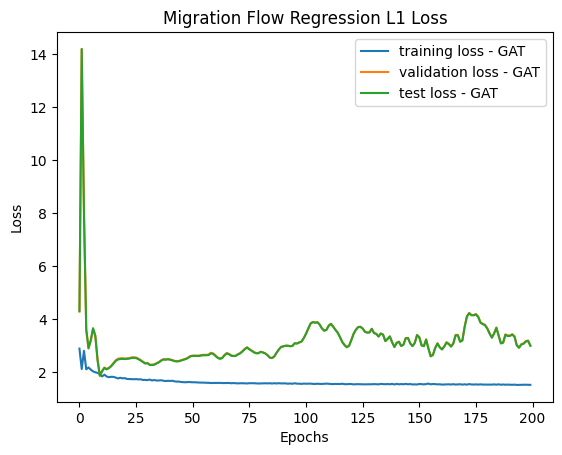

Running pipeline with config: Classification_GAT_full_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 1.55447, Training F1 Score (Micro) 0.31677 Validation Loss 2.85416 Validation F1 Score (Micro) 0.47818


Training:   0%|          | 1/200 [00:01<04:29,  1.35s/Epochs]

Epoch 2: Training Loss 1.67025, Training F1 Score (Micro) 0.47546 Validation Loss 3.06751 Validation F1 Score (Micro) 0.13321


Training:   1%|          | 2/200 [00:03<05:21,  1.63s/Epochs]

Epoch 3: Training Loss 1.39945, Training F1 Score (Micro) 0.4666 Validation Loss 4.20843 Validation F1 Score (Micro) 0.13315


Training:   2%|▏         | 4/200 [00:06<05:23,  1.65s/Epochs]

Epoch 4: Training Loss 1.34734, Training F1 Score (Micro) 0.46547 Validation Loss 2.65428 Validation F1 Score (Micro) 0.13554


Training:   2%|▎         | 5/200 [00:07<04:52,  1.50s/Epochs]

Epoch 5: Training Loss 1.36224, Training F1 Score (Micro) 0.45629 Validation Loss 1.66885 Validation F1 Score (Micro) 0.47534
Epoch 6: Training Loss 1.35287, Training F1 Score (Micro) 0.4707 Validation Loss 2.75056 Validation F1 Score (Micro) 0.47818


Training:   4%|▎         | 7/200 [00:10<04:16,  1.33s/Epochs]

Epoch 7: Training Loss 1.34175, Training F1 Score (Micro) 0.47284 Validation Loss 3.19591 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 8/200 [00:11<04:08,  1.29s/Epochs]

Epoch 8: Training Loss 1.33043, Training F1 Score (Micro) 0.48026 Validation Loss 3.35726 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 9/200 [00:12<03:59,  1.25s/Epochs]

Epoch 9: Training Loss 1.3278, Training F1 Score (Micro) 0.48403 Validation Loss 3.54405 Validation F1 Score (Micro) 0.47818


Training:   5%|▌         | 10/200 [00:13<03:50,  1.21s/Epochs]

Epoch 10: Training Loss 1.32489, Training F1 Score (Micro) 0.4857 Validation Loss 3.81416 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 11/200 [00:14<03:39,  1.16s/Epochs]

Epoch 11: Training Loss 1.32256, Training F1 Score (Micro) 0.48021 Validation Loss 3.36145 Validation F1 Score (Micro) 0.47818
Epoch 12: Training Loss 1.3152, Training F1 Score (Micro) 0.47964 Validation Loss 2.80973 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 12/200 [00:16<03:49,  1.22s/Epochs]

Epoch 13: Training Loss 1.30925, Training F1 Score (Micro) 0.48964 Validation Loss 2.78245 Validation F1 Score (Micro) 0.47818


Training:   7%|▋         | 14/200 [00:19<04:33,  1.47s/Epochs]

Epoch 14: Training Loss 1.30905, Training F1 Score (Micro) 0.49017 Validation Loss 3.20061 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 15/200 [00:20<04:27,  1.44s/Epochs]

Epoch 15: Training Loss 1.30797, Training F1 Score (Micro) 0.4899 Validation Loss 3.86044 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 16/200 [00:22<04:11,  1.37s/Epochs]

Epoch 16: Training Loss 1.30453, Training F1 Score (Micro) 0.48705 Validation Loss 4.10382 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 17/200 [00:23<04:00,  1.31s/Epochs]

Epoch 17: Training Loss 1.30722, Training F1 Score (Micro) 0.47842 Validation Loss 3.73168 Validation F1 Score (Micro) 0.47818


Training:   9%|▉         | 18/200 [00:24<03:55,  1.30s/Epochs]

Epoch 18: Training Loss 1.30568, Training F1 Score (Micro) 0.48753 Validation Loss 3.26065 Validation F1 Score (Micro) 0.47818


Training:  10%|▉         | 19/200 [00:25<03:44,  1.24s/Epochs]

Epoch 19: Training Loss 1.30447, Training F1 Score (Micro) 0.49114 Validation Loss 3.31866 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 20/200 [00:26<03:35,  1.20s/Epochs]

Epoch 20: Training Loss 1.30394, Training F1 Score (Micro) 0.4923 Validation Loss 3.52075 Validation F1 Score (Micro) 0.47818
Epoch 21: Training Loss 1.30122, Training F1 Score (Micro) 0.49074 Validation Loss 3.44614 Validation F1 Score (Micro) 0.47818


Training:  11%|█         | 22/200 [00:29<03:54,  1.32s/Epochs]

Epoch 22: Training Loss 1.30634, Training F1 Score (Micro) 0.48073 Validation Loss 2.97169 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 23/200 [00:31<04:05,  1.39s/Epochs]

Epoch 23: Training Loss 1.29675, Training F1 Score (Micro) 0.49409 Validation Loss 2.61875 Validation F1 Score (Micro) 0.47818
Epoch 24: Training Loss 1.30147, Training F1 Score (Micro) 0.4858 Validation Loss 2.31307 Validation F1 Score (Micro) 0.47818


Training:  12%|█▎        | 25/200 [00:34<04:30,  1.55s/Epochs]

Epoch 25: Training Loss 1.30071, Training F1 Score (Micro) 0.49117 Validation Loss 2.3928 Validation F1 Score (Micro) 0.47818


Training:  13%|█▎        | 26/200 [00:36<04:33,  1.57s/Epochs]

Epoch 26: Training Loss 1.29895, Training F1 Score (Micro) 0.49237 Validation Loss 2.73961 Validation F1 Score (Micro) 0.47818


Training:  14%|█▎        | 27/200 [00:37<04:13,  1.47s/Epochs]

Epoch 27: Training Loss 1.29628, Training F1 Score (Micro) 0.49469 Validation Loss 3.05818 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 28/200 [00:38<04:01,  1.40s/Epochs]

Epoch 28: Training Loss 1.29981, Training F1 Score (Micro) 0.48214 Validation Loss 2.68078 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 29/200 [00:40<03:50,  1.35s/Epochs]

Epoch 29: Training Loss 1.29523, Training F1 Score (Micro) 0.48641 Validation Loss 2.17028 Validation F1 Score (Micro) 0.47818


Training:  15%|█▌        | 30/200 [00:41<03:35,  1.27s/Epochs]

Epoch 30: Training Loss 1.29382, Training F1 Score (Micro) 0.49433 Validation Loss 1.81591 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 31/200 [00:42<03:31,  1.25s/Epochs]

Epoch 31: Training Loss 1.29457, Training F1 Score (Micro) 0.49427 Validation Loss 1.73236 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 32/200 [00:43<03:21,  1.20s/Epochs]

Epoch 32: Training Loss 1.29246, Training F1 Score (Micro) 0.49578 Validation Loss 1.79044 Validation F1 Score (Micro) 0.47818


Training:  16%|█▋        | 33/200 [00:44<03:22,  1.21s/Epochs]

Epoch 33: Training Loss 1.28971, Training F1 Score (Micro) 0.49507 Validation Loss 2.02755 Validation F1 Score (Micro) 0.47818
Epoch 34: Training Loss 1.28865, Training F1 Score (Micro) 0.49752 Validation Loss 2.19882 Validation F1 Score (Micro) 0.47818


Training:  17%|█▋        | 34/200 [00:45<03:26,  1.25s/Epochs]

Epoch 35: Training Loss 1.29439, Training F1 Score (Micro) 0.48867 Validation Loss 1.95188 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 35/200 [00:47<03:47,  1.38s/Epochs]

Epoch 36: Training Loss 1.29277, Training F1 Score (Micro) 0.49383 Validation Loss 1.62523 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 37/200 [00:50<04:07,  1.52s/Epochs]

Epoch 37: Training Loss 1.28823, Training F1 Score (Micro) 0.49661 Validation Loss 1.49379 Validation F1 Score (Micro) 0.47818
Epoch 38: Training Loss 1.28931, Training F1 Score (Micro) 0.49503 Validation Loss 1.52304 Validation F1 Score (Micro) 0.47818


Training:  20%|█▉        | 39/200 [00:53<03:46,  1.41s/Epochs]

Epoch 39: Training Loss 1.29221, Training F1 Score (Micro) 0.4922 Validation Loss 1.76692 Validation F1 Score (Micro) 0.47818
Epoch 40: Training Loss 1.28645, Training F1 Score (Micro) 0.49741 Validation Loss 1.90131 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 41/200 [00:56<03:34,  1.35s/Epochs]

Epoch 41: Training Loss 1.28766, Training F1 Score (Micro) 0.49162 Validation Loss 1.69383 Validation F1 Score (Micro) 0.47818


Training:  21%|██        | 42/200 [00:57<03:26,  1.31s/Epochs]

Epoch 42: Training Loss 1.2851, Training F1 Score (Micro) 0.49218 Validation Loss 1.44878 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 43/200 [00:58<03:16,  1.25s/Epochs]

Epoch 43: Training Loss 1.2857, Training F1 Score (Micro) 0.49707 Validation Loss 1.36651 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 44/200 [00:59<03:12,  1.24s/Epochs]

Epoch 44: Training Loss 1.2871, Training F1 Score (Micro) 0.49663 Validation Loss 1.38779 Validation F1 Score (Micro) 0.47818


Training:  22%|██▎       | 45/200 [01:00<03:10,  1.23s/Epochs]

Epoch 45: Training Loss 1.28463, Training F1 Score (Micro) 0.49928 Validation Loss 1.45019 Validation F1 Score (Micro) 0.47818
Epoch 46: Training Loss 1.28284, Training F1 Score (Micro) 0.4971 Validation Loss 1.50188 Validation F1 Score (Micro) 0.47818


Training:  23%|██▎       | 46/200 [01:02<03:36,  1.41s/Epochs]

Epoch 47: Training Loss 1.28352, Training F1 Score (Micro) 0.49417 Validation Loss 1.52755 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 48/200 [01:05<03:43,  1.47s/Epochs]

Epoch 48: Training Loss 1.28275, Training F1 Score (Micro) 0.49435 Validation Loss 1.47192 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 49/200 [01:07<03:27,  1.38s/Epochs]

Epoch 49: Training Loss 1.28337, Training F1 Score (Micro) 0.49679 Validation Loss 1.41369 Validation F1 Score (Micro) 0.47818


Training:  25%|██▌       | 50/200 [01:08<03:15,  1.30s/Epochs]

Epoch 50: Training Loss 1.28473, Training F1 Score (Micro) 0.49538 Validation Loss 1.36379 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 51/200 [01:09<03:06,  1.25s/Epochs]

Epoch 51: Training Loss 1.28456, Training F1 Score (Micro) 0.49693 Validation Loss 1.37303 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 52/200 [01:10<02:57,  1.20s/Epochs]

Epoch 52: Training Loss 1.28112, Training F1 Score (Micro) 0.49914 Validation Loss 1.41995 Validation F1 Score (Micro) 0.47818


Training:  26%|██▋       | 53/200 [01:11<02:58,  1.21s/Epochs]

Epoch 53: Training Loss 1.28134, Training F1 Score (Micro) 0.49927 Validation Loss 1.48394 Validation F1 Score (Micro) 0.47818


Training:  27%|██▋       | 54/200 [01:12<02:59,  1.23s/Epochs]

Epoch 54: Training Loss 1.28074, Training F1 Score (Micro) 0.49816 Validation Loss 1.49626 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 55/200 [01:14<02:58,  1.23s/Epochs]

Epoch 55: Training Loss 1.28206, Training F1 Score (Micro) 0.49754 Validation Loss 1.45783 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 56/200 [01:15<03:02,  1.26s/Epochs]

Epoch 56: Training Loss 1.28077, Training F1 Score (Micro) 0.49901 Validation Loss 1.40156 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 57/200 [01:17<03:12,  1.35s/Epochs]

Epoch 57: Training Loss 1.28209, Training F1 Score (Micro) 0.49617 Validation Loss 1.35262 Validation F1 Score (Micro) 0.47818


Training:  29%|██▉       | 58/200 [01:18<03:15,  1.38s/Epochs]

Epoch 58: Training Loss 1.28103, Training F1 Score (Micro) 0.49668 Validation Loss 1.36254 Validation F1 Score (Micro) 0.47818


Training:  30%|██▉       | 59/200 [01:19<03:13,  1.37s/Epochs]

Epoch 59: Training Loss 1.28018, Training F1 Score (Micro) 0.49798 Validation Loss 1.38299 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 60/200 [01:20<03:00,  1.29s/Epochs]

Epoch 60: Training Loss 1.27952, Training F1 Score (Micro) 0.49792 Validation Loss 1.40077 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 61/200 [01:22<02:50,  1.23s/Epochs]

Epoch 61: Training Loss 1.27737, Training F1 Score (Micro) 0.49999 Validation Loss 1.39138 Validation F1 Score (Micro) 0.47818


Training:  31%|███       | 62/200 [01:23<02:48,  1.22s/Epochs]

Epoch 62: Training Loss 1.27729, Training F1 Score (Micro) 0.50043 Validation Loss 1.3719 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 63/200 [01:24<02:43,  1.20s/Epochs]

Epoch 63: Training Loss 1.27783, Training F1 Score (Micro) 0.49947 Validation Loss 1.35052 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 64/200 [01:25<02:38,  1.16s/Epochs]

Epoch 64: Training Loss 1.27714, Training F1 Score (Micro) 0.4984 Validation Loss 1.33812 Validation F1 Score (Micro) 0.47818


Training:  32%|███▎      | 65/200 [01:26<02:37,  1.17s/Epochs]

Epoch 65: Training Loss 1.27849, Training F1 Score (Micro) 0.49737 Validation Loss 1.32579 Validation F1 Score (Micro) 0.47818
Epoch 66: Training Loss 1.2766, Training F1 Score (Micro) 0.49907 Validation Loss 1.32249 Validation F1 Score (Micro) 0.47818


Training:  34%|███▎      | 67/200 [01:29<02:44,  1.24s/Epochs]

Epoch 67: Training Loss 1.27816, Training F1 Score (Micro) 0.4987 Validation Loss 1.3356 Validation F1 Score (Micro) 0.47818
Epoch 68: Training Loss 1.27802, Training F1 Score (Micro) 0.49932 Validation Loss 1.37712 Validation F1 Score (Micro) 0.47818


Training:  34%|███▍      | 69/200 [01:32<03:03,  1.40s/Epochs]

Epoch 69: Training Loss 1.27947, Training F1 Score (Micro) 0.49634 Validation Loss 1.34552 Validation F1 Score (Micro) 0.47818


Training:  35%|███▌      | 70/200 [01:33<03:01,  1.40s/Epochs]

Epoch 70: Training Loss 1.27588, Training F1 Score (Micro) 0.49906 Validation Loss 1.31929 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 71/200 [01:34<02:42,  1.26s/Epochs]

Epoch 71: Training Loss 1.2757, Training F1 Score (Micro) 0.49813 Validation Loss 1.30934 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 72/200 [01:35<02:34,  1.21s/Epochs]

Epoch 72: Training Loss 1.27593, Training F1 Score (Micro) 0.49856 Validation Loss 1.3091 Validation F1 Score (Micro) 0.47818


Training:  36%|███▋      | 73/200 [01:36<02:27,  1.16s/Epochs]

Epoch 73: Training Loss 1.27643, Training F1 Score (Micro) 0.49727 Validation Loss 1.31365 Validation F1 Score (Micro) 0.47818


Training:  37%|███▋      | 74/200 [01:37<02:20,  1.11s/Epochs]

Epoch 74: Training Loss 1.27557, Training F1 Score (Micro) 0.49993 Validation Loss 1.3335 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 75/200 [01:38<02:14,  1.07s/Epochs]

Epoch 75: Training Loss 1.27671, Training F1 Score (Micro) 0.49958 Validation Loss 1.34618 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 76/200 [01:39<02:10,  1.05s/Epochs]

Epoch 76: Training Loss 1.27749, Training F1 Score (Micro) 0.49813 Validation Loss 1.31622 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 77/200 [01:40<02:10,  1.06s/Epochs]

Epoch 77: Training Loss 1.27601, Training F1 Score (Micro) 0.49844 Validation Loss 1.30792 Validation F1 Score (Micro) 0.47818


Training:  39%|███▉      | 78/200 [01:42<02:08,  1.05s/Epochs]

Epoch 78: Training Loss 1.27471, Training F1 Score (Micro) 0.49968 Validation Loss 1.3116 Validation F1 Score (Micro) 0.47818


Training:  40%|███▉      | 79/200 [01:43<02:07,  1.05s/Epochs]

Epoch 79: Training Loss 1.27653, Training F1 Score (Micro) 0.4991 Validation Loss 1.34104 Validation F1 Score (Micro) 0.47818
Epoch 80: Training Loss 1.27683, Training F1 Score (Micro) 0.49902 Validation Loss 1.34754 Validation F1 Score (Micro) 0.47818


Training:  40%|████      | 81/200 [01:46<02:35,  1.30s/Epochs]

Epoch 81: Training Loss 1.27522, Training F1 Score (Micro) 0.49971 Validation Loss 1.32938 Validation F1 Score (Micro) 0.47818


Training:  41%|████      | 82/200 [01:47<02:42,  1.38s/Epochs]

Epoch 82: Training Loss 1.27519, Training F1 Score (Micro) 0.49883 Validation Loss 1.32233 Validation F1 Score (Micro) 0.47818


Training:  42%|████▏     | 83/200 [01:48<02:29,  1.28s/Epochs]

Epoch 83: Training Loss 1.27525, Training F1 Score (Micro) 0.49784 Validation Loss 1.32893 Validation F1 Score (Micro) 0.47818


Training:  42%|████▏     | 84/200 [01:49<02:21,  1.22s/Epochs]

Epoch 84: Training Loss 1.27412, Training F1 Score (Micro) 0.49928 Validation Loss 1.36531 Validation F1 Score (Micro) 0.47818


Training:  42%|████▎     | 85/200 [01:50<02:14,  1.17s/Epochs]

Epoch 85: Training Loss 1.27569, Training F1 Score (Micro) 0.49954 Validation Loss 1.35479 Validation F1 Score (Micro) 0.47818


Training:  43%|████▎     | 86/200 [01:51<02:09,  1.14s/Epochs]

Epoch 86: Training Loss 1.27466, Training F1 Score (Micro) 0.49992 Validation Loss 1.31392 Validation F1 Score (Micro) 0.47818
Epoch 87: Training Loss 1.27476, Training F1 Score (Micro) 0.49939 Validation Loss 1.31825 Validation F1 Score (Micro) 0.47818


Training:  44%|████▍     | 88/200 [01:54<02:14,  1.20s/Epochs]

Epoch 88: Training Loss 1.27347, Training F1 Score (Micro) 0.49803 Validation Loss 1.36467 Validation F1 Score (Micro) 0.47818


Training:  44%|████▍     | 89/200 [01:55<02:13,  1.20s/Epochs]

Epoch 89: Training Loss 1.27419, Training F1 Score (Micro) 0.49937 Validation Loss 1.42182 Validation F1 Score (Micro) 0.47818
Epoch 90: Training Loss 1.2744, Training F1 Score (Micro) 0.49888 Validation Loss 1.39782 Validation F1 Score (Micro) 0.47818


Training:  46%|████▌     | 91/200 [01:58<02:17,  1.26s/Epochs]

Epoch 91: Training Loss 1.27354, Training F1 Score (Micro) 0.50058 Validation Loss 1.35121 Validation F1 Score (Micro) 0.47818
Epoch 92: Training Loss 1.2741, Training F1 Score (Micro) 0.49926 Validation Loss 1.33457 Validation F1 Score (Micro) 0.47818


Training:  46%|████▌     | 92/200 [02:00<02:34,  1.44s/Epochs]

Epoch 93: Training Loss 1.27372, Training F1 Score (Micro) 0.49747 Validation Loss 1.37953 Validation F1 Score (Micro) 0.47818


Training:  47%|████▋     | 94/200 [02:03<02:31,  1.42s/Epochs]

Epoch 94: Training Loss 1.27262, Training F1 Score (Micro) 0.49892 Validation Loss 1.40304 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 95/200 [02:04<02:18,  1.31s/Epochs]

Epoch 95: Training Loss 1.27561, Training F1 Score (Micro) 0.4971 Validation Loss 1.33748 Validation F1 Score (Micro) 0.47818
Epoch 96: Training Loss 1.27387, Training F1 Score (Micro) 0.49931 Validation Loss 1.33178 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 97/200 [02:06<02:13,  1.30s/Epochs]

Epoch 97: Training Loss 1.27252, Training F1 Score (Micro) 0.49913 Validation Loss 1.36346 Validation F1 Score (Micro) 0.47818


Training:  49%|████▉     | 98/200 [02:08<02:11,  1.29s/Epochs]

Epoch 98: Training Loss 1.27405, Training F1 Score (Micro) 0.49977 Validation Loss 1.33565 Validation F1 Score (Micro) 0.47818


Training:  50%|████▉     | 99/200 [02:09<02:04,  1.23s/Epochs]

Epoch 99: Training Loss 1.2734, Training F1 Score (Micro) 0.4996 Validation Loss 1.3224 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 100/200 [02:10<01:57,  1.17s/Epochs]

Epoch 100: Training Loss 1.27244, Training F1 Score (Micro) 0.50094 Validation Loss 1.30507 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 101/200 [02:11<01:57,  1.18s/Epochs]

Epoch 101: Training Loss 1.27183, Training F1 Score (Micro) 0.49948 Validation Loss 1.30363 Validation F1 Score (Micro) 0.47818
Epoch 102: Training Loss 1.27191, Training F1 Score (Micro) 0.49965 Validation Loss 1.31655 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 103/200 [02:14<02:10,  1.35s/Epochs]

Epoch 103: Training Loss 1.27372, Training F1 Score (Micro) 0.49825 Validation Loss 1.3069 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 104/200 [02:15<02:10,  1.36s/Epochs]

Epoch 104: Training Loss 1.27186, Training F1 Score (Micro) 0.49859 Validation Loss 1.31706 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▎    | 105/200 [02:17<02:08,  1.35s/Epochs]

Epoch 105: Training Loss 1.27271, Training F1 Score (Micro) 0.49978 Validation Loss 1.35583 Validation F1 Score (Micro) 0.47818
Epoch 106: Training Loss 1.27424, Training F1 Score (Micro) 0.49804 Validation Loss 1.31724 Validation F1 Score (Micro) 0.47818


Training:  54%|█████▎    | 107/200 [02:19<02:03,  1.33s/Epochs]

Epoch 107: Training Loss 1.27184, Training F1 Score (Micro) 0.49917 Validation Loss 1.31497 Validation F1 Score (Micro) 0.47818
Epoch 108: Training Loss 1.27254, Training F1 Score (Micro) 0.49756 Validation Loss 1.37533 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▍    | 109/200 [02:22<01:59,  1.31s/Epochs]

Epoch 109: Training Loss 1.27223, Training F1 Score (Micro) 0.49946 Validation Loss 1.4078 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▌    | 110/200 [02:23<01:56,  1.30s/Epochs]

Epoch 110: Training Loss 1.2747, Training F1 Score (Micro) 0.49731 Validation Loss 1.30642 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 111/200 [02:24<01:50,  1.24s/Epochs]

Epoch 111: Training Loss 1.27249, Training F1 Score (Micro) 0.49911 Validation Loss 1.30729 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 112/200 [02:25<01:49,  1.25s/Epochs]

Epoch 112: Training Loss 1.27405, Training F1 Score (Micro) 0.49631 Validation Loss 1.33511 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▋    | 113/200 [02:27<01:50,  1.27s/Epochs]

Epoch 113: Training Loss 1.27092, Training F1 Score (Micro) 0.50073 Validation Loss 1.41901 Validation F1 Score (Micro) 0.47818


Training:  57%|█████▋    | 114/200 [02:28<01:52,  1.31s/Epochs]

Epoch 114: Training Loss 1.27369, Training F1 Score (Micro) 0.49675 Validation Loss 1.32834 Validation F1 Score (Micro) 0.47818


Training:  57%|█████▊    | 115/200 [02:30<01:55,  1.36s/Epochs]

Epoch 115: Training Loss 1.2715, Training F1 Score (Micro) 0.49885 Validation Loss 1.31144 Validation F1 Score (Micro) 0.47818


Training:  58%|█████▊    | 116/200 [02:31<01:48,  1.29s/Epochs]

Epoch 116: Training Loss 1.27347, Training F1 Score (Micro) 0.49597 Validation Loss 1.30503 Validation F1 Score (Micro) 0.47818


Training:  58%|█████▊    | 117/200 [02:32<01:43,  1.24s/Epochs]

Epoch 117: Training Loss 1.27285, Training F1 Score (Micro) 0.49837 Validation Loss 1.35968 Validation F1 Score (Micro) 0.47818


Training:  59%|█████▉    | 118/200 [02:33<01:36,  1.18s/Epochs]

Epoch 118: Training Loss 1.27227, Training F1 Score (Micro) 0.49976 Validation Loss 1.41318 Validation F1 Score (Micro) 0.47818


Training:  60%|█████▉    | 119/200 [02:34<01:33,  1.15s/Epochs]

Epoch 119: Training Loss 1.27387, Training F1 Score (Micro) 0.49828 Validation Loss 1.33027 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 120/200 [02:35<01:30,  1.13s/Epochs]

Epoch 120: Training Loss 1.27048, Training F1 Score (Micro) 0.50065 Validation Loss 1.31081 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 121/200 [02:36<01:22,  1.05s/Epochs]

Epoch 121: Training Loss 1.27388, Training F1 Score (Micro) 0.49803 Validation Loss 1.31112 Validation F1 Score (Micro) 0.47818


Training:  61%|██████    | 122/200 [02:37<01:24,  1.09s/Epochs]

Epoch 122: Training Loss 1.27158, Training F1 Score (Micro) 0.49901 Validation Loss 1.36203 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 123/200 [02:38<01:20,  1.05s/Epochs]

Epoch 123: Training Loss 1.27213, Training F1 Score (Micro) 0.49714 Validation Loss 1.35975 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 124/200 [02:39<01:20,  1.06s/Epochs]

Epoch 124: Training Loss 1.27137, Training F1 Score (Micro) 0.50004 Validation Loss 1.32798 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▎   | 125/200 [02:40<01:22,  1.10s/Epochs]

Epoch 125: Training Loss 1.2712, Training F1 Score (Micro) 0.49962 Validation Loss 1.3196 Validation F1 Score (Micro) 0.47818
Epoch 126: Training Loss 1.2711, Training F1 Score (Micro) 0.49989 Validation Loss 1.33219 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▎   | 127/200 [02:44<01:37,  1.34s/Epochs]

Epoch 127: Training Loss 1.27105, Training F1 Score (Micro) 0.49953 Validation Loss 1.35419 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 128/200 [02:45<01:32,  1.28s/Epochs]

Epoch 128: Training Loss 1.27169, Training F1 Score (Micro) 0.49964 Validation Loss 1.31877 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 129/200 [02:46<01:26,  1.22s/Epochs]

Epoch 129: Training Loss 1.27113, Training F1 Score (Micro) 0.49895 Validation Loss 1.31629 Validation F1 Score (Micro) 0.47818


Training:  65%|██████▌   | 130/200 [02:47<01:22,  1.18s/Epochs]

Epoch 130: Training Loss 1.27058, Training F1 Score (Micro) 0.4988 Validation Loss 1.35752 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▌   | 131/200 [02:48<01:19,  1.15s/Epochs]

Epoch 131: Training Loss 1.26985, Training F1 Score (Micro) 0.50061 Validation Loss 1.4238 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▌   | 132/200 [02:49<01:15,  1.12s/Epochs]

Epoch 132: Training Loss 1.27121, Training F1 Score (Micro) 0.49813 Validation Loss 1.35533 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▋   | 133/200 [02:50<01:13,  1.10s/Epochs]

Epoch 133: Training Loss 1.27184, Training F1 Score (Micro) 0.49991 Validation Loss 1.30817 Validation F1 Score (Micro) 0.47818


Training:  67%|██████▋   | 134/200 [02:51<01:12,  1.09s/Epochs]

Epoch 134: Training Loss 1.2727, Training F1 Score (Micro) 0.49857 Validation Loss 1.31019 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 135/200 [02:52<01:08,  1.06s/Epochs]

Epoch 135: Training Loss 1.27347, Training F1 Score (Micro) 0.49712 Validation Loss 1.40276 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 136/200 [02:53<01:07,  1.06s/Epochs]

Epoch 136: Training Loss 1.26924, Training F1 Score (Micro) 0.50011 Validation Loss 1.49814 Validation F1 Score (Micro) 0.47818
Epoch 137: Training Loss 1.27362, Training F1 Score (Micro) 0.49789 Validation Loss 1.36445 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 137/200 [02:55<01:12,  1.15s/Epochs]

Epoch 138: Training Loss 1.26834, Training F1 Score (Micro) 0.50107 Validation Loss 1.30982 Validation F1 Score (Micro) 0.47818


Training:  70%|██████▉   | 139/200 [02:58<01:27,  1.44s/Epochs]

Epoch 139: Training Loss 1.27021, Training F1 Score (Micro) 0.4986 Validation Loss 1.3104 Validation F1 Score (Micro) 0.47818


Training:  70%|███████   | 140/200 [02:59<01:19,  1.33s/Epochs]

Epoch 140: Training Loss 1.27025, Training F1 Score (Micro) 0.49864 Validation Loss 1.34168 Validation F1 Score (Micro) 0.47818


Training:  70%|███████   | 141/200 [03:00<01:15,  1.27s/Epochs]

Epoch 141: Training Loss 1.26915, Training F1 Score (Micro) 0.50041 Validation Loss 1.38542 Validation F1 Score (Micro) 0.47818


Training:  71%|███████   | 142/200 [03:01<01:12,  1.25s/Epochs]

Epoch 142: Training Loss 1.27058, Training F1 Score (Micro) 0.50083 Validation Loss 1.35433 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▏  | 143/200 [03:03<01:08,  1.21s/Epochs]

Epoch 143: Training Loss 1.27031, Training F1 Score (Micro) 0.5006 Validation Loss 1.31784 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▏  | 144/200 [03:04<01:08,  1.22s/Epochs]

Epoch 144: Training Loss 1.2691, Training F1 Score (Micro) 0.50099 Validation Loss 1.31242 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▎  | 145/200 [03:05<01:05,  1.19s/Epochs]

Epoch 145: Training Loss 1.26908, Training F1 Score (Micro) 0.49903 Validation Loss 1.33211 Validation F1 Score (Micro) 0.47818


Training:  73%|███████▎  | 146/200 [03:06<01:02,  1.16s/Epochs]

Epoch 146: Training Loss 1.26914, Training F1 Score (Micro) 0.4989 Validation Loss 1.40691 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▎  | 147/200 [03:07<01:02,  1.18s/Epochs]

Epoch 147: Training Loss 1.26979, Training F1 Score (Micro) 0.49969 Validation Loss 1.40724 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▍  | 148/200 [03:09<01:02,  1.21s/Epochs]

Epoch 148: Training Loss 1.26883, Training F1 Score (Micro) 0.50051 Validation Loss 1.33691 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▍  | 149/200 [03:10<01:04,  1.27s/Epochs]

Epoch 149: Training Loss 1.26746, Training F1 Score (Micro) 0.49984 Validation Loss 1.32034 Validation F1 Score (Micro) 0.47818


Training:  75%|███████▌  | 150/200 [03:11<01:06,  1.32s/Epochs]

Epoch 150: Training Loss 1.26945, Training F1 Score (Micro) 0.49916 Validation Loss 1.34228 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 151/200 [03:13<01:05,  1.34s/Epochs]

Epoch 151: Training Loss 1.26874, Training F1 Score (Micro) 0.49987 Validation Loss 1.40484 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 152/200 [03:14<01:01,  1.28s/Epochs]

Epoch 152: Training Loss 1.26848, Training F1 Score (Micro) 0.501 Validation Loss 1.38704 Validation F1 Score (Micro) 0.47818
Epoch 153: Training Loss 1.26859, Training F1 Score (Micro) 0.50019 Validation Loss 1.32623 Validation F1 Score (Micro) 0.47818


Training:  77%|███████▋  | 154/200 [03:16<00:57,  1.26s/Epochs]

Epoch 154: Training Loss 1.26861, Training F1 Score (Micro) 0.5003 Validation Loss 1.31351 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 155/200 [03:17<00:54,  1.21s/Epochs]

Epoch 155: Training Loss 1.26913, Training F1 Score (Micro) 0.49883 Validation Loss 1.33818 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 156/200 [03:19<00:51,  1.18s/Epochs]

Epoch 156: Training Loss 1.26711, Training F1 Score (Micro) 0.50073 Validation Loss 1.38936 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 157/200 [03:20<00:49,  1.15s/Epochs]

Epoch 157: Training Loss 1.26709, Training F1 Score (Micro) 0.50112 Validation Loss 1.40591 Validation F1 Score (Micro) 0.47818


Training:  79%|███████▉  | 158/200 [03:21<00:46,  1.10s/Epochs]

Epoch 158: Training Loss 1.26989, Training F1 Score (Micro) 0.5004 Validation Loss 1.3334 Validation F1 Score (Micro) 0.47818


Training:  80%|███████▉  | 159/200 [03:22<00:43,  1.06s/Epochs]

Epoch 159: Training Loss 1.26787, Training F1 Score (Micro) 0.50022 Validation Loss 1.32061 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 160/200 [03:23<00:43,  1.08s/Epochs]

Epoch 160: Training Loss 1.26877, Training F1 Score (Micro) 0.49884 Validation Loss 1.34965 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 161/200 [03:24<00:46,  1.20s/Epochs]

Epoch 161: Training Loss 1.26769, Training F1 Score (Micro) 0.50088 Validation Loss 1.41842 Validation F1 Score (Micro) 0.47818


Training:  81%|████████  | 162/200 [03:26<00:47,  1.26s/Epochs]

Epoch 162: Training Loss 1.26844, Training F1 Score (Micro) 0.50044 Validation Loss 1.40371 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▏ | 163/200 [03:27<00:49,  1.34s/Epochs]

Epoch 163: Training Loss 1.26763, Training F1 Score (Micro) 0.5003 Validation Loss 1.3694 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▏ | 164/200 [03:28<00:46,  1.28s/Epochs]

Epoch 164: Training Loss 1.26778, Training F1 Score (Micro) 0.5005 Validation Loss 1.37368 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▎ | 165/200 [03:29<00:43,  1.24s/Epochs]

Epoch 165: Training Loss 1.2675, Training F1 Score (Micro) 0.50059 Validation Loss 1.3917 Validation F1 Score (Micro) 0.47818


Training:  83%|████████▎ | 166/200 [03:31<00:40,  1.20s/Epochs]

Epoch 166: Training Loss 1.2669, Training F1 Score (Micro) 0.50091 Validation Loss 1.40813 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▎ | 167/200 [03:32<00:38,  1.16s/Epochs]

Epoch 167: Training Loss 1.2668, Training F1 Score (Micro) 0.50117 Validation Loss 1.40176 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▍ | 168/200 [03:33<00:35,  1.11s/Epochs]

Epoch 168: Training Loss 1.26758, Training F1 Score (Micro) 0.50002 Validation Loss 1.36265 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▍ | 169/200 [03:34<00:32,  1.06s/Epochs]

Epoch 169: Training Loss 1.26669, Training F1 Score (Micro) 0.50055 Validation Loss 1.34158 Validation F1 Score (Micro) 0.47818


Training:  85%|████████▌ | 170/200 [03:35<00:30,  1.02s/Epochs]

Epoch 170: Training Loss 1.26727, Training F1 Score (Micro) 0.49883 Validation Loss 1.36658 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▌ | 171/200 [03:35<00:28,  1.00Epochs/s]

Epoch 171: Training Loss 1.26667, Training F1 Score (Micro) 0.50085 Validation Loss 1.38791 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▌ | 172/200 [03:36<00:27,  1.03Epochs/s]

Epoch 172: Training Loss 1.26704, Training F1 Score (Micro) 0.50074 Validation Loss 1.33932 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▋ | 173/200 [03:37<00:26,  1.00Epochs/s]

Epoch 173: Training Loss 1.26603, Training F1 Score (Micro) 0.50036 Validation Loss 1.32124 Validation F1 Score (Micro) 0.47818


Training:  87%|████████▋ | 174/200 [03:39<00:29,  1.12s/Epochs]

Epoch 174: Training Loss 1.26733, Training F1 Score (Micro) 0.5009 Validation Loss 1.3259 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 175/200 [03:40<00:29,  1.19s/Epochs]

Epoch 175: Training Loss 1.26677, Training F1 Score (Micro) 0.50072 Validation Loss 1.34766 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 176/200 [03:42<00:29,  1.24s/Epochs]

Epoch 176: Training Loss 1.26611, Training F1 Score (Micro) 0.50068 Validation Loss 1.35326 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 177/200 [03:43<00:27,  1.18s/Epochs]

Epoch 177: Training Loss 1.26727, Training F1 Score (Micro) 0.5005 Validation Loss 1.35685 Validation F1 Score (Micro) 0.47818


Training:  89%|████████▉ | 178/200 [03:44<00:24,  1.13s/Epochs]

Epoch 178: Training Loss 1.26672, Training F1 Score (Micro) 0.50009 Validation Loss 1.36437 Validation F1 Score (Micro) 0.47818


Training:  90%|████████▉ | 179/200 [03:45<00:23,  1.11s/Epochs]

Epoch 179: Training Loss 1.26606, Training F1 Score (Micro) 0.50197 Validation Loss 1.3701 Validation F1 Score (Micro) 0.47818


Training:  90%|█████████ | 180/200 [03:46<00:21,  1.05s/Epochs]

Epoch 180: Training Loss 1.2668, Training F1 Score (Micro) 0.50153 Validation Loss 1.3631 Validation F1 Score (Micro) 0.47818


Training:  90%|█████████ | 181/200 [03:47<00:19,  1.03s/Epochs]

Epoch 181: Training Loss 1.26616, Training F1 Score (Micro) 0.50071 Validation Loss 1.34845 Validation F1 Score (Micro) 0.47818


Training:  91%|█████████ | 182/200 [03:48<00:18,  1.02s/Epochs]

Epoch 182: Training Loss 1.26617, Training F1 Score (Micro) 0.49974 Validation Loss 1.35552 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▏| 183/200 [03:49<00:17,  1.03s/Epochs]

Epoch 183: Training Loss 1.26588, Training F1 Score (Micro) 0.50085 Validation Loss 1.35168 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▏| 184/200 [03:50<00:16,  1.03s/Epochs]

Epoch 184: Training Loss 1.26635, Training F1 Score (Micro) 0.50003 Validation Loss 1.35646 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▎| 185/200 [03:51<00:16,  1.08s/Epochs]

Epoch 185: Training Loss 1.26556, Training F1 Score (Micro) 0.50178 Validation Loss 1.35149 Validation F1 Score (Micro) 0.47818


Training:  93%|█████████▎| 186/200 [03:52<00:16,  1.14s/Epochs]

Epoch 186: Training Loss 1.26663, Training F1 Score (Micro) 0.50029 Validation Loss 1.34942 Validation F1 Score (Micro) 0.47818


Training:  94%|█████████▎| 187/200 [03:54<00:16,  1.28s/Epochs]

Epoch 187: Training Loss 1.26575, Training F1 Score (Micro) 0.50033 Validation Loss 1.35494 Validation F1 Score (Micro) 0.47818


Training:  94%|█████████▍| 188/200 [03:55<00:16,  1.35s/Epochs]

Epoch 188: Training Loss 1.26523, Training F1 Score (Micro) 0.5015 Validation Loss 1.35232 Validation F1 Score (Micro) 0.47818


Training:  94%|█████████▍| 189/200 [03:57<00:16,  1.46s/Epochs]

Epoch 189: Training Loss 1.26424, Training F1 Score (Micro) 0.50077 Validation Loss 1.33573 Validation F1 Score (Micro) 0.47818
Epoch 190: Training Loss 1.2661, Training F1 Score (Micro) 0.5004 Validation Loss 1.36471 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▌| 191/200 [04:00<00:13,  1.52s/Epochs]

Epoch 191: Training Loss 1.26535, Training F1 Score (Micro) 0.50109 Validation Loss 1.35369 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▌| 192/200 [04:01<00:11,  1.39s/Epochs]

Epoch 192: Training Loss 1.26445, Training F1 Score (Micro) 0.50118 Validation Loss 1.34653 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▋| 193/200 [04:02<00:08,  1.28s/Epochs]

Epoch 193: Training Loss 1.26524, Training F1 Score (Micro) 0.49949 Validation Loss 1.35654 Validation F1 Score (Micro) 0.47818
Epoch 194: Training Loss 1.2656, Training F1 Score (Micro) 0.49969 Validation Loss 1.42296 Validation F1 Score (Micro) 0.47818


Training:  98%|█████████▊| 195/200 [04:05<00:06,  1.26s/Epochs]

Epoch 195: Training Loss 1.26532, Training F1 Score (Micro) 0.50054 Validation Loss 1.37259 Validation F1 Score (Micro) 0.47818
Epoch 196: Training Loss 1.26572, Training F1 Score (Micro) 0.49994 Validation Loss 1.35614 Validation F1 Score (Micro) 0.47818


Training:  98%|█████████▊| 197/200 [04:08<00:04,  1.37s/Epochs]

Epoch 197: Training Loss 1.26599, Training F1 Score (Micro) 0.50063 Validation Loss 1.34933 Validation F1 Score (Micro) 0.47818


Training:  99%|█████████▉| 198/200 [04:09<00:02,  1.41s/Epochs]

Epoch 198: Training Loss 1.2656, Training F1 Score (Micro) 0.49955 Validation Loss 1.37254 Validation F1 Score (Micro) 0.47818


Training: 100%|█████████▉| 199/200 [04:11<00:01,  1.41s/Epochs]

Epoch 199: Training Loss 1.26551, Training F1 Score (Micro) 0.5007 Validation Loss 1.35199 Validation F1 Score (Micro) 0.47818


Training: 100%|██████████| 200/200 [04:12<00:00,  1.26s/Epochs]

Epoch 200: Training Loss 1.26439, Training F1 Score (Micro) 0.50111 Validation Loss 1.3261 Validation F1 Score (Micro) 0.47818


Saving Model Predictions for Model Type GAT
Model saved successfully as Classification_GAT_full_full
Minimum validation loss: 1.3036270141601562
Minimum test loss: 1.3034111261367798
Best test metric: 0.4773421585559845


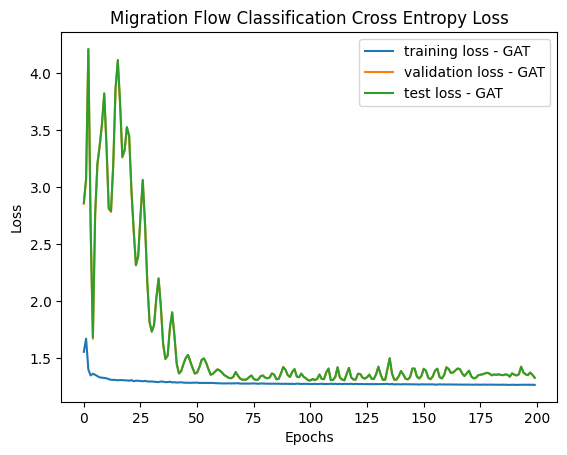

Running pipeline with config: Classification_GAT_simple_full


Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 1.67105, Training F1 Score (Micro) 0.16247 Validation Loss 3.46771 Validation F1 Score (Micro) 0.47799


Training:   1%|          | 2/200 [00:02<04:07,  1.25s/Epochs]

Epoch 2: Training Loss 1.64378, Training F1 Score (Micro) 0.47546 Validation Loss 2.126 Validation F1 Score (Micro) 0.14102


Training:   2%|▏         | 3/200 [00:03<03:39,  1.11s/Epochs]

Epoch 3: Training Loss 1.55801, Training F1 Score (Micro) 0.39181 Validation Loss 1.48878 Validation F1 Score (Micro) 0.47818


Training:   2%|▏         | 4/200 [00:04<03:16,  1.00s/Epochs]

Epoch 4: Training Loss 1.46033, Training F1 Score (Micro) 0.41342 Validation Loss 2.24685 Validation F1 Score (Micro) 0.47818


Training:   2%|▎         | 5/200 [00:05<03:14,  1.00Epochs/s]

Epoch 5: Training Loss 1.37626, Training F1 Score (Micro) 0.47383 Validation Loss 3.56128 Validation F1 Score (Micro) 0.47818


Training:   3%|▎         | 6/200 [00:06<03:14,  1.00s/Epochs]

Epoch 6: Training Loss 1.41852, Training F1 Score (Micro) 0.46771 Validation Loss 3.85525 Validation F1 Score (Micro) 0.47818


Training:   4%|▎         | 7/200 [00:07<03:12,  1.00Epochs/s]

Epoch 7: Training Loss 1.42062, Training F1 Score (Micro) 0.47451 Validation Loss 3.21624 Validation F1 Score (Micro) 0.47818


Training:   4%|▍         | 8/200 [00:08<03:38,  1.14s/Epochs]

Epoch 8: Training Loss 1.37585, Training F1 Score (Micro) 0.47543 Validation Loss 2.61012 Validation F1 Score (Micro) 0.47818
Epoch 9: Training Loss 1.3563, Training F1 Score (Micro) 0.47508 Validation Loss 2.39096 Validation F1 Score (Micro) 0.47818


Training:   5%|▌         | 10/200 [00:11<04:19,  1.36s/Epochs]

Epoch 10: Training Loss 1.36037, Training F1 Score (Micro) 0.4754 Validation Loss 2.45202 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 11/200 [00:12<04:00,  1.27s/Epochs]

Epoch 11: Training Loss 1.35366, Training F1 Score (Micro) 0.47228 Validation Loss 2.71972 Validation F1 Score (Micro) 0.47818


Training:   6%|▌         | 12/200 [00:13<03:43,  1.19s/Epochs]

Epoch 12: Training Loss 1.34264, Training F1 Score (Micro) 0.47349 Validation Loss 3.15002 Validation F1 Score (Micro) 0.47818


Training:   6%|▋         | 13/200 [00:14<03:29,  1.12s/Epochs]

Epoch 13: Training Loss 1.33047, Training F1 Score (Micro) 0.4744 Validation Loss 3.58383 Validation F1 Score (Micro) 0.47818


Training:   7%|▋         | 14/200 [00:15<03:15,  1.05s/Epochs]

Epoch 14: Training Loss 1.32864, Training F1 Score (Micro) 0.4753 Validation Loss 3.95267 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 15/200 [00:16<02:59,  1.03Epochs/s]

Epoch 15: Training Loss 1.32814, Training F1 Score (Micro) 0.47548 Validation Loss 4.08351 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 16/200 [00:17<02:49,  1.09Epochs/s]

Epoch 16: Training Loss 1.32444, Training F1 Score (Micro) 0.47543 Validation Loss 4.18559 Validation F1 Score (Micro) 0.47818


Training:   8%|▊         | 17/200 [00:18<02:47,  1.10Epochs/s]

Epoch 17: Training Loss 1.321, Training F1 Score (Micro) 0.47549 Validation Loss 4.35586 Validation F1 Score (Micro) 0.47818


Training:   9%|▉         | 18/200 [00:19<02:43,  1.11Epochs/s]

Epoch 18: Training Loss 1.32231, Training F1 Score (Micro) 0.47565 Validation Loss 4.67201 Validation F1 Score (Micro) 0.47818


Training:  10%|▉         | 19/200 [00:19<02:36,  1.16Epochs/s]

Epoch 19: Training Loss 1.31703, Training F1 Score (Micro) 0.47641 Validation Loss 5.08801 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 20/200 [00:20<02:35,  1.16Epochs/s]

Epoch 20: Training Loss 1.31377, Training F1 Score (Micro) 0.47677 Validation Loss 5.45933 Validation F1 Score (Micro) 0.47818


Training:  10%|█         | 21/200 [00:21<02:39,  1.12Epochs/s]

Epoch 21: Training Loss 1.31387, Training F1 Score (Micro) 0.47911 Validation Loss 5.64295 Validation F1 Score (Micro) 0.47818


Training:  11%|█         | 22/200 [00:22<02:51,  1.04Epochs/s]

Epoch 22: Training Loss 1.31126, Training F1 Score (Micro) 0.47667 Validation Loss 5.58282 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 23/200 [00:24<03:01,  1.03s/Epochs]

Epoch 23: Training Loss 1.30923, Training F1 Score (Micro) 0.47772 Validation Loss 5.36768 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 24/200 [00:25<03:08,  1.07s/Epochs]

Epoch 24: Training Loss 1.3068, Training F1 Score (Micro) 0.47869 Validation Loss 4.91467 Validation F1 Score (Micro) 0.47818


Training:  12%|█▎        | 25/200 [00:26<03:02,  1.04s/Epochs]

Epoch 25: Training Loss 1.30898, Training F1 Score (Micro) 0.47702 Validation Loss 4.4255 Validation F1 Score (Micro) 0.47818


Training:  13%|█▎        | 26/200 [00:27<02:53,  1.00Epochs/s]

Epoch 26: Training Loss 1.30495, Training F1 Score (Micro) 0.47921 Validation Loss 4.0102 Validation F1 Score (Micro) 0.47818


Training:  14%|█▎        | 27/200 [00:28<02:50,  1.02Epochs/s]

Epoch 27: Training Loss 1.30452, Training F1 Score (Micro) 0.4782 Validation Loss 3.6749 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 28/200 [00:28<02:46,  1.04Epochs/s]

Epoch 28: Training Loss 1.30214, Training F1 Score (Micro) 0.48041 Validation Loss 3.47113 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 29/200 [00:29<02:41,  1.06Epochs/s]

Epoch 29: Training Loss 1.30356, Training F1 Score (Micro) 0.47949 Validation Loss 3.37008 Validation F1 Score (Micro) 0.47818


Training:  15%|█▌        | 30/200 [00:30<02:36,  1.09Epochs/s]

Epoch 30: Training Loss 1.30409, Training F1 Score (Micro) 0.47873 Validation Loss 3.30554 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 31/200 [00:31<02:35,  1.09Epochs/s]

Epoch 31: Training Loss 1.29926, Training F1 Score (Micro) 0.47801 Validation Loss 3.16438 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 32/200 [00:32<02:33,  1.09Epochs/s]

Epoch 32: Training Loss 1.29648, Training F1 Score (Micro) 0.47785 Validation Loss 2.96342 Validation F1 Score (Micro) 0.47818


Training:  16%|█▋        | 33/200 [00:33<02:32,  1.10Epochs/s]

Epoch 33: Training Loss 1.29775, Training F1 Score (Micro) 0.48007 Validation Loss 2.74108 Validation F1 Score (Micro) 0.47818


Training:  17%|█▋        | 34/200 [00:34<02:31,  1.09Epochs/s]

Epoch 34: Training Loss 1.29554, Training F1 Score (Micro) 0.47861 Validation Loss 2.4288 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 35/200 [00:35<02:31,  1.09Epochs/s]

Epoch 35: Training Loss 1.29541, Training F1 Score (Micro) 0.49471 Validation Loss 2.22537 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 36/200 [00:36<02:46,  1.01s/Epochs]

Epoch 36: Training Loss 1.29497, Training F1 Score (Micro) 0.49619 Validation Loss 2.18013 Validation F1 Score (Micro) 0.47818


Training:  18%|█▊        | 37/200 [00:37<02:53,  1.06s/Epochs]

Epoch 37: Training Loss 1.29524, Training F1 Score (Micro) 0.48611 Validation Loss 2.08056 Validation F1 Score (Micro) 0.47818


Training:  19%|█▉        | 38/200 [00:38<02:55,  1.08s/Epochs]

Epoch 38: Training Loss 1.29283, Training F1 Score (Micro) 0.48944 Validation Loss 1.98485 Validation F1 Score (Micro) 0.47818


Training:  20%|█▉        | 39/200 [00:40<03:00,  1.12s/Epochs]

Epoch 39: Training Loss 1.29385, Training F1 Score (Micro) 0.48585 Validation Loss 1.88763 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 40/200 [00:41<02:53,  1.09s/Epochs]

Epoch 40: Training Loss 1.2931, Training F1 Score (Micro) 0.49106 Validation Loss 1.83137 Validation F1 Score (Micro) 0.47818


Training:  20%|██        | 41/200 [00:41<02:45,  1.04s/Epochs]

Epoch 41: Training Loss 1.29268, Training F1 Score (Micro) 0.49705 Validation Loss 1.89747 Validation F1 Score (Micro) 0.47818


Training:  21%|██        | 42/200 [00:42<02:31,  1.04Epochs/s]

Epoch 42: Training Loss 1.29048, Training F1 Score (Micro) 0.49492 Validation Loss 2.01829 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 43/200 [00:43<02:26,  1.07Epochs/s]

Epoch 43: Training Loss 1.29349, Training F1 Score (Micro) 0.48405 Validation Loss 1.88299 Validation F1 Score (Micro) 0.47818


Training:  22%|██▏       | 44/200 [00:44<02:22,  1.10Epochs/s]

Epoch 44: Training Loss 1.28946, Training F1 Score (Micro) 0.489 Validation Loss 1.72021 Validation F1 Score (Micro) 0.47818


Training:  22%|██▎       | 45/200 [00:45<02:20,  1.10Epochs/s]

Epoch 45: Training Loss 1.28839, Training F1 Score (Micro) 0.49659 Validation Loss 1.68189 Validation F1 Score (Micro) 0.47818


Training:  23%|██▎       | 46/200 [00:46<02:32,  1.01Epochs/s]

Epoch 46: Training Loss 1.28784, Training F1 Score (Micro) 0.49939 Validation Loss 1.76431 Validation F1 Score (Micro) 0.47818


Training:  24%|██▎       | 47/200 [00:47<02:35,  1.02s/Epochs]

Epoch 47: Training Loss 1.28692, Training F1 Score (Micro) 0.49649 Validation Loss 1.81996 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 48/200 [00:48<02:32,  1.00s/Epochs]

Epoch 48: Training Loss 1.28806, Training F1 Score (Micro) 0.49149 Validation Loss 1.88353 Validation F1 Score (Micro) 0.47818


Training:  24%|██▍       | 49/200 [00:49<02:38,  1.05s/Epochs]

Epoch 49: Training Loss 1.28709, Training F1 Score (Micro) 0.48671 Validation Loss 1.90678 Validation F1 Score (Micro) 0.47818


Training:  25%|██▌       | 50/200 [00:51<02:50,  1.13s/Epochs]

Epoch 50: Training Loss 1.28555, Training F1 Score (Micro) 0.49505 Validation Loss 1.94469 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 51/200 [00:52<02:51,  1.15s/Epochs]

Epoch 51: Training Loss 1.28513, Training F1 Score (Micro) 0.49749 Validation Loss 1.94555 Validation F1 Score (Micro) 0.47818


Training:  26%|██▌       | 52/200 [00:53<02:54,  1.18s/Epochs]

Epoch 52: Training Loss 1.28544, Training F1 Score (Micro) 0.49858 Validation Loss 1.98134 Validation F1 Score (Micro) 0.47818


Training:  26%|██▋       | 53/200 [00:54<02:52,  1.17s/Epochs]

Epoch 53: Training Loss 1.28273, Training F1 Score (Micro) 0.49908 Validation Loss 2.05999 Validation F1 Score (Micro) 0.47818


Training:  27%|██▋       | 54/200 [00:55<02:41,  1.11s/Epochs]

Epoch 54: Training Loss 1.28281, Training F1 Score (Micro) 0.50027 Validation Loss 2.0333 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 55/200 [00:56<02:33,  1.06s/Epochs]

Epoch 55: Training Loss 1.28227, Training F1 Score (Micro) 0.49735 Validation Loss 1.96327 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 56/200 [00:57<02:24,  1.01s/Epochs]

Epoch 56: Training Loss 1.28376, Training F1 Score (Micro) 0.49772 Validation Loss 1.80164 Validation F1 Score (Micro) 0.47818


Training:  28%|██▊       | 57/200 [00:58<02:17,  1.04Epochs/s]

Epoch 57: Training Loss 1.28291, Training F1 Score (Micro) 0.49815 Validation Loss 1.66815 Validation F1 Score (Micro) 0.47818


Training:  29%|██▉       | 58/200 [00:59<02:13,  1.06Epochs/s]

Epoch 58: Training Loss 1.28054, Training F1 Score (Micro) 0.50132 Validation Loss 1.66909 Validation F1 Score (Micro) 0.47818


Training:  30%|██▉       | 59/200 [01:00<02:13,  1.06Epochs/s]

Epoch 59: Training Loss 1.28204, Training F1 Score (Micro) 0.49637 Validation Loss 1.71209 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 60/200 [01:01<02:09,  1.08Epochs/s]

Epoch 60: Training Loss 1.28185, Training F1 Score (Micro) 0.49918 Validation Loss 1.83787 Validation F1 Score (Micro) 0.47818


Training:  30%|███       | 61/200 [01:02<02:09,  1.07Epochs/s]

Epoch 61: Training Loss 1.28136, Training F1 Score (Micro) 0.49882 Validation Loss 2.08017 Validation F1 Score (Micro) 0.47818


Training:  31%|███       | 62/200 [01:02<02:07,  1.09Epochs/s]

Epoch 62: Training Loss 1.28069, Training F1 Score (Micro) 0.50013 Validation Loss 2.30476 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 63/200 [01:03<02:01,  1.13Epochs/s]

Epoch 63: Training Loss 1.2802, Training F1 Score (Micro) 0.49916 Validation Loss 2.36629 Validation F1 Score (Micro) 0.47818


Training:  32%|███▏      | 64/200 [01:04<01:59,  1.13Epochs/s]

Epoch 64: Training Loss 1.28208, Training F1 Score (Micro) 0.49947 Validation Loss 2.35307 Validation F1 Score (Micro) 0.47818


Training:  32%|███▎      | 65/200 [01:05<02:10,  1.03Epochs/s]

Epoch 65: Training Loss 1.27879, Training F1 Score (Micro) 0.49887 Validation Loss 2.28146 Validation F1 Score (Micro) 0.47818


Training:  33%|███▎      | 66/200 [01:07<02:21,  1.05s/Epochs]

Epoch 66: Training Loss 1.27955, Training F1 Score (Micro) 0.49967 Validation Loss 2.24732 Validation F1 Score (Micro) 0.47818


Training:  34%|███▎      | 67/200 [01:08<02:31,  1.14s/Epochs]

Epoch 67: Training Loss 1.28097, Training F1 Score (Micro) 0.49847 Validation Loss 2.2461 Validation F1 Score (Micro) 0.47818


Training:  34%|███▍      | 68/200 [01:09<02:31,  1.15s/Epochs]

Epoch 68: Training Loss 1.28024, Training F1 Score (Micro) 0.49644 Validation Loss 2.27421 Validation F1 Score (Micro) 0.47818


Training:  34%|███▍      | 69/200 [01:10<02:21,  1.08s/Epochs]

Epoch 69: Training Loss 1.28082, Training F1 Score (Micro) 0.49833 Validation Loss 2.39176 Validation F1 Score (Micro) 0.47818


Training:  35%|███▌      | 70/200 [01:11<02:22,  1.09s/Epochs]

Epoch 70: Training Loss 1.27774, Training F1 Score (Micro) 0.49854 Validation Loss 2.44298 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 71/200 [01:12<02:16,  1.06s/Epochs]

Epoch 71: Training Loss 1.28003, Training F1 Score (Micro) 0.50103 Validation Loss 2.64359 Validation F1 Score (Micro) 0.47818


Training:  36%|███▌      | 72/200 [01:13<02:14,  1.05s/Epochs]

Epoch 72: Training Loss 1.28097, Training F1 Score (Micro) 0.50008 Validation Loss 2.79282 Validation F1 Score (Micro) 0.47818


Training:  36%|███▋      | 73/200 [01:14<02:13,  1.05s/Epochs]

Epoch 73: Training Loss 1.27817, Training F1 Score (Micro) 0.49919 Validation Loss 2.78255 Validation F1 Score (Micro) 0.47818


Training:  37%|███▋      | 74/200 [01:15<02:06,  1.00s/Epochs]

Epoch 74: Training Loss 1.2778, Training F1 Score (Micro) 0.49866 Validation Loss 2.9945 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 75/200 [01:16<02:07,  1.02s/Epochs]

Epoch 75: Training Loss 1.27877, Training F1 Score (Micro) 0.49811 Validation Loss 3.07308 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 76/200 [01:17<02:08,  1.04s/Epochs]

Epoch 76: Training Loss 1.27934, Training F1 Score (Micro) 0.49734 Validation Loss 2.87895 Validation F1 Score (Micro) 0.47818


Training:  38%|███▊      | 77/200 [01:18<02:07,  1.03s/Epochs]

Epoch 77: Training Loss 1.27753, Training F1 Score (Micro) 0.49874 Validation Loss 2.60169 Validation F1 Score (Micro) 0.47818


Training:  39%|███▉      | 78/200 [01:19<02:09,  1.07s/Epochs]

Epoch 78: Training Loss 1.27564, Training F1 Score (Micro) 0.49946 Validation Loss 2.38267 Validation F1 Score (Micro) 0.47818


Training:  40%|███▉      | 79/200 [01:21<02:21,  1.17s/Epochs]

Epoch 79: Training Loss 1.2784, Training F1 Score (Micro) 0.49962 Validation Loss 2.30445 Validation F1 Score (Micro) 0.47818


Training:  40%|████      | 80/200 [01:22<02:27,  1.23s/Epochs]

Epoch 80: Training Loss 1.2772, Training F1 Score (Micro) 0.49963 Validation Loss 2.40557 Validation F1 Score (Micro) 0.47818


Training:  40%|████      | 81/200 [01:23<02:26,  1.23s/Epochs]

Epoch 81: Training Loss 1.27686, Training F1 Score (Micro) 0.4993 Validation Loss 2.42762 Validation F1 Score (Micro) 0.47818


Training:  41%|████      | 82/200 [01:24<02:17,  1.17s/Epochs]

Epoch 82: Training Loss 1.27515, Training F1 Score (Micro) 0.50018 Validation Loss 2.56684 Validation F1 Score (Micro) 0.47818


Training:  42%|████▏     | 83/200 [01:25<02:10,  1.11s/Epochs]

Epoch 83: Training Loss 1.27822, Training F1 Score (Micro) 0.49845 Validation Loss 2.66495 Validation F1 Score (Micro) 0.47818


Training:  42%|████▏     | 84/200 [01:26<02:03,  1.07s/Epochs]

Epoch 84: Training Loss 1.27945, Training F1 Score (Micro) 0.49836 Validation Loss 2.69056 Validation F1 Score (Micro) 0.47818


Training:  42%|████▎     | 85/200 [01:27<02:02,  1.06s/Epochs]

Epoch 85: Training Loss 1.2765, Training F1 Score (Micro) 0.4991 Validation Loss 2.57679 Validation F1 Score (Micro) 0.47818


Training:  43%|████▎     | 86/200 [01:28<02:00,  1.06s/Epochs]

Epoch 86: Training Loss 1.27591, Training F1 Score (Micro) 0.50048 Validation Loss 2.43286 Validation F1 Score (Micro) 0.47818


Training:  44%|████▎     | 87/200 [01:29<01:59,  1.06s/Epochs]

Epoch 87: Training Loss 1.28064, Training F1 Score (Micro) 0.49849 Validation Loss 2.36904 Validation F1 Score (Micro) 0.47818


Training:  44%|████▍     | 88/200 [01:30<01:55,  1.03s/Epochs]

Epoch 88: Training Loss 1.27561, Training F1 Score (Micro) 0.49896 Validation Loss 2.43524 Validation F1 Score (Micro) 0.47818


Training:  44%|████▍     | 89/200 [01:31<01:51,  1.01s/Epochs]

Epoch 89: Training Loss 1.27525, Training F1 Score (Micro) 0.49937 Validation Loss 2.60579 Validation F1 Score (Micro) 0.47818


Training:  45%|████▌     | 90/200 [01:32<01:47,  1.02Epochs/s]

Epoch 90: Training Loss 1.27639, Training F1 Score (Micro) 0.49852 Validation Loss 2.83255 Validation F1 Score (Micro) 0.47818


Training:  46%|████▌     | 91/200 [01:33<01:40,  1.08Epochs/s]

Epoch 91: Training Loss 1.2753, Training F1 Score (Micro) 0.49576 Validation Loss 2.8036 Validation F1 Score (Micro) 0.47818


Training:  46%|████▌     | 92/200 [01:34<01:43,  1.04Epochs/s]

Epoch 92: Training Loss 1.27453, Training F1 Score (Micro) 0.49896 Validation Loss 2.82724 Validation F1 Score (Micro) 0.47818


Training:  46%|████▋     | 93/200 [01:35<01:48,  1.01s/Epochs]

Epoch 93: Training Loss 1.27415, Training F1 Score (Micro) 0.4989 Validation Loss 2.79084 Validation F1 Score (Micro) 0.47818


Training:  47%|████▋     | 94/200 [01:36<01:52,  1.06s/Epochs]

Epoch 94: Training Loss 1.27522, Training F1 Score (Micro) 0.49982 Validation Loss 2.55878 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 95/200 [01:38<01:55,  1.10s/Epochs]

Epoch 95: Training Loss 1.27679, Training F1 Score (Micro) 0.49896 Validation Loss 2.38028 Validation F1 Score (Micro) 0.47818


Training:  48%|████▊     | 96/200 [01:39<01:48,  1.05s/Epochs]

Epoch 96: Training Loss 1.27433, Training F1 Score (Micro) 0.50095 Validation Loss 2.34069 Validation F1 Score (Micro) 0.47818
Epoch 97: Training Loss 1.27359, Training F1 Score (Micro) 0.50015 Validation Loss 2.28717 Validation F1 Score (Micro) 0.47818


Training:  49%|████▉     | 98/200 [01:41<01:49,  1.07s/Epochs]

Epoch 98: Training Loss 1.27427, Training F1 Score (Micro) 0.50039 Validation Loss 2.19704 Validation F1 Score (Micro) 0.47818


Training:  50%|████▉     | 99/200 [01:42<01:42,  1.02s/Epochs]

Epoch 99: Training Loss 1.27449, Training F1 Score (Micro) 0.49896 Validation Loss 1.945 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 100/200 [01:43<01:42,  1.02s/Epochs]

Epoch 100: Training Loss 1.27465, Training F1 Score (Micro) 0.50066 Validation Loss 2.00008 Validation F1 Score (Micro) 0.47818


Training:  50%|█████     | 101/200 [01:44<01:39,  1.01s/Epochs]

Epoch 101: Training Loss 1.27654, Training F1 Score (Micro) 0.49838 Validation Loss 2.62977 Validation F1 Score (Micro) 0.47818


Training:  51%|█████     | 102/200 [01:45<01:42,  1.05s/Epochs]

Epoch 102: Training Loss 1.27588, Training F1 Score (Micro) 0.49973 Validation Loss 3.2202 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 103/200 [01:46<01:42,  1.06s/Epochs]

Epoch 103: Training Loss 1.27408, Training F1 Score (Micro) 0.50216 Validation Loss 3.40219 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▏    | 104/200 [01:47<01:44,  1.09s/Epochs]

Epoch 104: Training Loss 1.27391, Training F1 Score (Micro) 0.50099 Validation Loss 3.49725 Validation F1 Score (Micro) 0.47818


Training:  52%|█████▎    | 105/200 [01:48<01:45,  1.11s/Epochs]

Epoch 105: Training Loss 1.27793, Training F1 Score (Micro) 0.50014 Validation Loss 3.40671 Validation F1 Score (Micro) 0.47818


Training:  53%|█████▎    | 106/200 [01:50<01:53,  1.21s/Epochs]

Epoch 106: Training Loss 1.27308, Training F1 Score (Micro) 0.49891 Validation Loss 3.14438 Validation F1 Score (Micro) 0.47818


Training:  54%|█████▎    | 107/200 [01:51<01:59,  1.28s/Epochs]

Epoch 107: Training Loss 1.27368, Training F1 Score (Micro) 0.50017 Validation Loss 3.05077 Validation F1 Score (Micro) 0.47818


Training:  54%|█████▍    | 108/200 [01:53<02:02,  1.33s/Epochs]

Epoch 108: Training Loss 1.27273, Training F1 Score (Micro) 0.49885 Validation Loss 2.91629 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▍    | 109/200 [01:54<01:55,  1.27s/Epochs]

Epoch 109: Training Loss 1.27718, Training F1 Score (Micro) 0.5009 Validation Loss 2.77213 Validation F1 Score (Micro) 0.47818


Training:  55%|█████▌    | 110/200 [01:55<01:48,  1.20s/Epochs]

Epoch 110: Training Loss 1.27338, Training F1 Score (Micro) 0.50043 Validation Loss 2.85094 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 111/200 [01:56<01:38,  1.11s/Epochs]

Epoch 111: Training Loss 1.27279, Training F1 Score (Micro) 0.50033 Validation Loss 2.89593 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▌    | 112/200 [01:57<01:32,  1.06s/Epochs]

Epoch 112: Training Loss 1.27306, Training F1 Score (Micro) 0.50059 Validation Loss 2.68346 Validation F1 Score (Micro) 0.47818


Training:  56%|█████▋    | 113/200 [01:57<01:27,  1.00s/Epochs]

Epoch 113: Training Loss 1.27315, Training F1 Score (Micro) 0.50008 Validation Loss 2.38161 Validation F1 Score (Micro) 0.47818


Training:  57%|█████▋    | 114/200 [01:58<01:24,  1.01Epochs/s]

Epoch 114: Training Loss 1.27324, Training F1 Score (Micro) 0.49951 Validation Loss 2.36764 Validation F1 Score (Micro) 0.47818


Training:  57%|█████▊    | 115/200 [01:59<01:20,  1.06Epochs/s]

Epoch 115: Training Loss 1.27436, Training F1 Score (Micro) 0.50006 Validation Loss 2.67125 Validation F1 Score (Micro) 0.47818


Training:  58%|█████▊    | 116/200 [02:00<01:17,  1.08Epochs/s]

Epoch 116: Training Loss 1.27198, Training F1 Score (Micro) 0.50008 Validation Loss 3.6446 Validation F1 Score (Micro) 0.47818


Training:  58%|█████▊    | 117/200 [02:01<01:16,  1.08Epochs/s]

Epoch 117: Training Loss 1.27324, Training F1 Score (Micro) 0.4986 Validation Loss 4.3145 Validation F1 Score (Micro) 0.47818


Training:  59%|█████▉    | 118/200 [02:02<01:16,  1.08Epochs/s]

Epoch 118: Training Loss 1.27317, Training F1 Score (Micro) 0.5003 Validation Loss 5.14131 Validation F1 Score (Micro) 0.47818


Training:  60%|█████▉    | 119/200 [02:03<01:19,  1.01Epochs/s]

Epoch 119: Training Loss 1.27526, Training F1 Score (Micro) 0.50056 Validation Loss 5.76597 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 120/200 [02:04<01:21,  1.02s/Epochs]

Epoch 120: Training Loss 1.27372, Training F1 Score (Micro) 0.49999 Validation Loss 5.79521 Validation F1 Score (Micro) 0.47818


Training:  60%|██████    | 121/200 [02:05<01:24,  1.07s/Epochs]

Epoch 121: Training Loss 1.27196, Training F1 Score (Micro) 0.49906 Validation Loss 5.60048 Validation F1 Score (Micro) 0.47818


Training:  61%|██████    | 122/200 [02:07<01:27,  1.12s/Epochs]

Epoch 122: Training Loss 1.27761, Training F1 Score (Micro) 0.4985 Validation Loss 5.46926 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 123/200 [02:08<01:22,  1.08s/Epochs]

Epoch 123: Training Loss 1.27194, Training F1 Score (Micro) 0.49915 Validation Loss 5.72398 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▏   | 124/200 [02:09<01:17,  1.02s/Epochs]

Epoch 124: Training Loss 1.27044, Training F1 Score (Micro) 0.50031 Validation Loss 5.74873 Validation F1 Score (Micro) 0.47818


Training:  62%|██████▎   | 125/200 [02:09<01:13,  1.01Epochs/s]

Epoch 125: Training Loss 1.27132, Training F1 Score (Micro) 0.50092 Validation Loss 5.21379 Validation F1 Score (Micro) 0.47818


Training:  63%|██████▎   | 126/200 [02:10<01:08,  1.08Epochs/s]

Epoch 126: Training Loss 1.27468, Training F1 Score (Micro) 0.49912 Validation Loss 4.5883 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▎   | 127/200 [02:11<01:07,  1.08Epochs/s]

Epoch 127: Training Loss 1.27324, Training F1 Score (Micro) 0.50007 Validation Loss 4.06306 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 128/200 [02:12<01:06,  1.08Epochs/s]

Epoch 128: Training Loss 1.27193, Training F1 Score (Micro) 0.5006 Validation Loss 3.62266 Validation F1 Score (Micro) 0.47818


Training:  64%|██████▍   | 129/200 [02:13<01:05,  1.09Epochs/s]

Epoch 129: Training Loss 1.27202, Training F1 Score (Micro) 0.49914 Validation Loss 3.16936 Validation F1 Score (Micro) 0.47818


Training:  65%|██████▌   | 130/200 [02:14<01:04,  1.08Epochs/s]

Epoch 130: Training Loss 1.27241, Training F1 Score (Micro) 0.49921 Validation Loss 2.87799 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▌   | 131/200 [02:15<01:03,  1.09Epochs/s]

Epoch 131: Training Loss 1.277, Training F1 Score (Micro) 0.49872 Validation Loss 2.85642 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▌   | 132/200 [02:16<01:03,  1.06Epochs/s]

Epoch 132: Training Loss 1.2712, Training F1 Score (Micro) 0.50045 Validation Loss 2.8089 Validation F1 Score (Micro) 0.47818


Training:  66%|██████▋   | 133/200 [02:17<01:06,  1.01Epochs/s]

Epoch 133: Training Loss 1.27523, Training F1 Score (Micro) 0.50067 Validation Loss 2.51489 Validation F1 Score (Micro) 0.47818


Training:  67%|██████▋   | 134/200 [02:18<01:12,  1.10s/Epochs]

Epoch 134: Training Loss 1.27177, Training F1 Score (Micro) 0.49878 Validation Loss 2.42885 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 135/200 [02:20<01:14,  1.14s/Epochs]

Epoch 135: Training Loss 1.27016, Training F1 Score (Micro) 0.50108 Validation Loss 2.43899 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 136/200 [02:21<01:14,  1.16s/Epochs]

Epoch 136: Training Loss 1.27324, Training F1 Score (Micro) 0.49907 Validation Loss 2.4251 Validation F1 Score (Micro) 0.47818


Training:  68%|██████▊   | 137/200 [02:22<01:08,  1.09s/Epochs]

Epoch 137: Training Loss 1.27275, Training F1 Score (Micro) 0.4987 Validation Loss 2.37145 Validation F1 Score (Micro) 0.47818


Training:  69%|██████▉   | 138/200 [02:22<01:02,  1.01s/Epochs]

Epoch 138: Training Loss 1.27085, Training F1 Score (Micro) 0.50023 Validation Loss 2.22544 Validation F1 Score (Micro) 0.47818


Training:  70%|██████▉   | 139/200 [02:23<00:58,  1.04Epochs/s]

Epoch 139: Training Loss 1.27062, Training F1 Score (Micro) 0.50108 Validation Loss 2.25108 Validation F1 Score (Micro) 0.47818


Training:  70%|███████   | 140/200 [02:24<00:55,  1.07Epochs/s]

Epoch 140: Training Loss 1.27173, Training F1 Score (Micro) 0.50036 Validation Loss 2.40109 Validation F1 Score (Micro) 0.47818


Training:  70%|███████   | 141/200 [02:25<00:52,  1.12Epochs/s]

Epoch 141: Training Loss 1.27087, Training F1 Score (Micro) 0.4993 Validation Loss 2.46173 Validation F1 Score (Micro) 0.47818


Training:  71%|███████   | 142/200 [02:26<00:51,  1.13Epochs/s]

Epoch 142: Training Loss 1.27164, Training F1 Score (Micro) 0.50084 Validation Loss 2.25033 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▏  | 143/200 [02:27<00:50,  1.13Epochs/s]

Epoch 143: Training Loss 1.27193, Training F1 Score (Micro) 0.50044 Validation Loss 1.99014 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▏  | 144/200 [02:28<00:48,  1.15Epochs/s]

Epoch 144: Training Loss 1.27254, Training F1 Score (Micro) 0.49907 Validation Loss 1.77085 Validation F1 Score (Micro) 0.47818


Training:  72%|███████▎  | 145/200 [02:28<00:48,  1.14Epochs/s]

Epoch 145: Training Loss 1.26977, Training F1 Score (Micro) 0.50031 Validation Loss 1.93939 Validation F1 Score (Micro) 0.47818


Training:  73%|███████▎  | 146/200 [02:29<00:47,  1.14Epochs/s]

Epoch 146: Training Loss 1.27159, Training F1 Score (Micro) 0.49972 Validation Loss 2.51523 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▎  | 147/200 [02:30<00:47,  1.11Epochs/s]

Epoch 147: Training Loss 1.26997, Training F1 Score (Micro) 0.50067 Validation Loss 2.91882 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▍  | 148/200 [02:31<00:49,  1.06Epochs/s]

Epoch 148: Training Loss 1.27163, Training F1 Score (Micro) 0.49844 Validation Loss 2.83397 Validation F1 Score (Micro) 0.47818


Training:  74%|███████▍  | 149/200 [02:33<00:51,  1.02s/Epochs]

Epoch 149: Training Loss 1.27037, Training F1 Score (Micro) 0.49953 Validation Loss 2.42567 Validation F1 Score (Micro) 0.47818


Training:  75%|███████▌  | 150/200 [02:34<00:52,  1.06s/Epochs]

Epoch 150: Training Loss 1.27098, Training F1 Score (Micro) 0.49935 Validation Loss 2.30463 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 151/200 [02:35<00:54,  1.10s/Epochs]

Epoch 151: Training Loss 1.27414, Training F1 Score (Micro) 0.49613 Validation Loss 2.57937 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▌  | 152/200 [02:36<00:50,  1.04s/Epochs]

Epoch 152: Training Loss 1.26956, Training F1 Score (Micro) 0.49975 Validation Loss 2.59723 Validation F1 Score (Micro) 0.47818


Training:  76%|███████▋  | 153/200 [02:37<00:46,  1.01Epochs/s]

Epoch 153: Training Loss 1.27394, Training F1 Score (Micro) 0.4998 Validation Loss 2.17874 Validation F1 Score (Micro) 0.47818


Training:  77%|███████▋  | 154/200 [02:38<00:43,  1.05Epochs/s]

Epoch 154: Training Loss 1.27009, Training F1 Score (Micro) 0.49896 Validation Loss 2.05057 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 155/200 [02:38<00:42,  1.06Epochs/s]

Epoch 155: Training Loss 1.27379, Training F1 Score (Micro) 0.49851 Validation Loss 2.35423 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 156/200 [02:39<00:41,  1.05Epochs/s]

Epoch 156: Training Loss 1.27068, Training F1 Score (Micro) 0.50055 Validation Loss 3.03483 Validation F1 Score (Micro) 0.47818


Training:  78%|███████▊  | 157/200 [02:40<00:40,  1.06Epochs/s]

Epoch 157: Training Loss 1.27568, Training F1 Score (Micro) 0.49639 Validation Loss 5.46303 Validation F1 Score (Micro) 0.47818


Training:  79%|███████▉  | 158/200 [02:41<00:38,  1.09Epochs/s]

Epoch 158: Training Loss 1.27093, Training F1 Score (Micro) 0.49916 Validation Loss 7.28941 Validation F1 Score (Micro) 0.47818


Training:  80%|███████▉  | 159/200 [02:42<00:37,  1.10Epochs/s]

Epoch 159: Training Loss 1.27233, Training F1 Score (Micro) 0.49771 Validation Loss 8.31302 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 160/200 [02:43<00:36,  1.10Epochs/s]

Epoch 160: Training Loss 1.27166, Training F1 Score (Micro) 0.49928 Validation Loss 8.75668 Validation F1 Score (Micro) 0.47818


Training:  80%|████████  | 161/200 [02:44<00:34,  1.12Epochs/s]

Epoch 161: Training Loss 1.27278, Training F1 Score (Micro) 0.49687 Validation Loss 8.20066 Validation F1 Score (Micro) 0.47818


Training:  81%|████████  | 162/200 [02:45<00:35,  1.08Epochs/s]

Epoch 162: Training Loss 1.27283, Training F1 Score (Micro) 0.49769 Validation Loss 7.17889 Validation F1 Score (Micro) 0.47818
Epoch 163: Training Loss 1.27166, Training F1 Score (Micro) 0.50019 Validation Loss 6.63459 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▏ | 164/200 [02:48<00:43,  1.20s/Epochs]

Epoch 164: Training Loss 1.27317, Training F1 Score (Micro) 0.49965 Validation Loss 6.61954 Validation F1 Score (Micro) 0.47818


Training:  82%|████████▎ | 165/200 [02:49<00:43,  1.25s/Epochs]

Epoch 165: Training Loss 1.27093, Training F1 Score (Micro) 0.50106 Validation Loss 6.58975 Validation F1 Score (Micro) 0.47818


Training:  83%|████████▎ | 166/200 [02:50<00:43,  1.27s/Epochs]

Epoch 166: Training Loss 1.27281, Training F1 Score (Micro) 0.49725 Validation Loss 5.83141 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▎ | 167/200 [02:52<00:39,  1.20s/Epochs]

Epoch 167: Training Loss 1.27339, Training F1 Score (Micro) 0.50137 Validation Loss 4.78947 Validation F1 Score (Micro) 0.47818


Training:  84%|████████▍ | 168/200 [02:53<00:37,  1.16s/Epochs]

Epoch 168: Training Loss 1.27166, Training F1 Score (Micro) 0.49937 Validation Loss 4.26022 Validation F1 Score (Micro) 0.47818
Epoch 169: Training Loss 1.27305, Training F1 Score (Micro) 0.49831 Validation Loss 4.30684 Validation F1 Score (Micro) 0.47818


Training:  85%|████████▌ | 170/200 [02:55<00:34,  1.16s/Epochs]

Epoch 170: Training Loss 1.27145, Training F1 Score (Micro) 0.49933 Validation Loss 4.40476 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▌ | 171/200 [02:56<00:33,  1.16s/Epochs]

Epoch 171: Training Loss 1.27118, Training F1 Score (Micro) 0.49942 Validation Loss 4.15889 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▌ | 172/200 [02:57<00:32,  1.14s/Epochs]

Epoch 172: Training Loss 1.27176, Training F1 Score (Micro) 0.49811 Validation Loss 3.47002 Validation F1 Score (Micro) 0.47818


Training:  86%|████████▋ | 173/200 [02:58<00:30,  1.12s/Epochs]

Epoch 173: Training Loss 1.27023, Training F1 Score (Micro) 0.50119 Validation Loss 2.92137 Validation F1 Score (Micro) 0.47818


Training:  87%|████████▋ | 174/200 [02:59<00:27,  1.07s/Epochs]

Epoch 174: Training Loss 1.27068, Training F1 Score (Micro) 0.50036 Validation Loss 2.80726 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 175/200 [03:00<00:27,  1.08s/Epochs]

Epoch 175: Training Loss 1.27122, Training F1 Score (Micro) 0.49981 Validation Loss 2.97539 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 176/200 [03:02<00:27,  1.16s/Epochs]

Epoch 176: Training Loss 1.27037, Training F1 Score (Micro) 0.50086 Validation Loss 3.10486 Validation F1 Score (Micro) 0.47818


Training:  88%|████████▊ | 177/200 [03:03<00:27,  1.19s/Epochs]

Epoch 177: Training Loss 1.27066, Training F1 Score (Micro) 0.50055 Validation Loss 2.82288 Validation F1 Score (Micro) 0.47818


Training:  89%|████████▉ | 178/200 [03:04<00:26,  1.18s/Epochs]

Epoch 178: Training Loss 1.27123, Training F1 Score (Micro) 0.50024 Validation Loss 2.58158 Validation F1 Score (Micro) 0.47818


Training:  90%|████████▉ | 179/200 [03:05<00:23,  1.10s/Epochs]

Epoch 179: Training Loss 1.26938, Training F1 Score (Micro) 0.50157 Validation Loss 2.43026 Validation F1 Score (Micro) 0.47818


Training:  90%|█████████ | 180/200 [03:06<00:20,  1.04s/Epochs]

Epoch 180: Training Loss 1.26944, Training F1 Score (Micro) 0.50051 Validation Loss 2.49962 Validation F1 Score (Micro) 0.47818


Training:  90%|█████████ | 181/200 [03:07<00:20,  1.07s/Epochs]

Epoch 181: Training Loss 1.27013, Training F1 Score (Micro) 0.50082 Validation Loss 2.6038 Validation F1 Score (Micro) 0.47818


Training:  91%|█████████ | 182/200 [03:08<00:20,  1.14s/Epochs]

Epoch 182: Training Loss 1.26893, Training F1 Score (Micro) 0.50003 Validation Loss 2.66155 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▏| 183/200 [03:10<00:20,  1.18s/Epochs]

Epoch 183: Training Loss 1.27019, Training F1 Score (Micro) 0.50016 Validation Loss 2.54648 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▏| 184/200 [03:11<00:20,  1.25s/Epochs]

Epoch 184: Training Loss 1.26965, Training F1 Score (Micro) 0.50036 Validation Loss 2.35302 Validation F1 Score (Micro) 0.47818


Training:  92%|█████████▎| 185/200 [03:12<00:17,  1.18s/Epochs]

Epoch 185: Training Loss 1.26922, Training F1 Score (Micro) 0.50019 Validation Loss 2.17014 Validation F1 Score (Micro) 0.47818


Training:  93%|█████████▎| 186/200 [03:13<00:16,  1.16s/Epochs]

Epoch 186: Training Loss 1.27014, Training F1 Score (Micro) 0.49867 Validation Loss 2.23485 Validation F1 Score (Micro) 0.47818


Training:  94%|█████████▎| 187/200 [03:14<00:15,  1.16s/Epochs]

Epoch 187: Training Loss 1.26875, Training F1 Score (Micro) 0.50045 Validation Loss 2.49499 Validation F1 Score (Micro) 0.47818


Training:  94%|█████████▍| 188/200 [03:16<00:15,  1.26s/Epochs]

Epoch 188: Training Loss 1.26952, Training F1 Score (Micro) 0.50047 Validation Loss 2.81593 Validation F1 Score (Micro) 0.47818
Epoch 189: Training Loss 1.27196, Training F1 Score (Micro) 0.49937 Validation Loss 2.44895 Validation F1 Score (Micro) 0.47818


Training:  95%|█████████▌| 190/200 [03:19<00:13,  1.38s/Epochs]

Epoch 190: Training Loss 1.26963, Training F1 Score (Micro) 0.50002 Validation Loss 2.05011 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▌| 191/200 [03:20<00:11,  1.28s/Epochs]

Epoch 191: Training Loss 1.27139, Training F1 Score (Micro) 0.4991 Validation Loss 2.12665 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▌| 192/200 [03:21<00:09,  1.23s/Epochs]

Epoch 192: Training Loss 1.27002, Training F1 Score (Micro) 0.49807 Validation Loss 2.64296 Validation F1 Score (Micro) 0.47818


Training:  96%|█████████▋| 193/200 [03:22<00:08,  1.17s/Epochs]

Epoch 193: Training Loss 1.26877, Training F1 Score (Micro) 0.50063 Validation Loss 3.2261 Validation F1 Score (Micro) 0.47818


Training:  97%|█████████▋| 194/200 [03:23<00:07,  1.18s/Epochs]

Epoch 194: Training Loss 1.2717, Training F1 Score (Micro) 0.49971 Validation Loss 2.7127 Validation F1 Score (Micro) 0.47818


Training:  98%|█████████▊| 195/200 [03:24<00:05,  1.12s/Epochs]

Epoch 195: Training Loss 1.2697, Training F1 Score (Micro) 0.50072 Validation Loss 2.32046 Validation F1 Score (Micro) 0.47818


Training:  98%|█████████▊| 196/200 [03:25<00:04,  1.08s/Epochs]

Epoch 196: Training Loss 1.27059, Training F1 Score (Micro) 0.49905 Validation Loss 2.21408 Validation F1 Score (Micro) 0.47818


Training:  98%|█████████▊| 197/200 [03:26<00:03,  1.06s/Epochs]

Epoch 197: Training Loss 1.26873, Training F1 Score (Micro) 0.49993 Validation Loss 2.30873 Validation F1 Score (Micro) 0.47818


Training:  99%|█████████▉| 198/200 [03:27<00:02,  1.06s/Epochs]

Epoch 198: Training Loss 1.26839, Training F1 Score (Micro) 0.50096 Validation Loss 2.42088 Validation F1 Score (Micro) 0.47818


Training: 100%|█████████▉| 199/200 [03:28<00:01,  1.05s/Epochs]

Epoch 199: Training Loss 1.26795, Training F1 Score (Micro) 0.50126 Validation Loss 2.53076 Validation F1 Score (Micro) 0.47818


Training: 100%|██████████| 200/200 [03:30<00:00,  1.05s/Epochs]

Epoch 200: Training Loss 1.26935, Training F1 Score (Micro) 0.50116 Validation Loss 2.21114 Validation F1 Score (Micro) 0.47818


Saving Model Predictions for Model Type GAT
Model saved successfully as Classification_GAT_simple_full
Minimum validation loss: 1.488776445388794
Minimum test loss: 1.4941301345825195
Best test metric: 0.4773421585559845


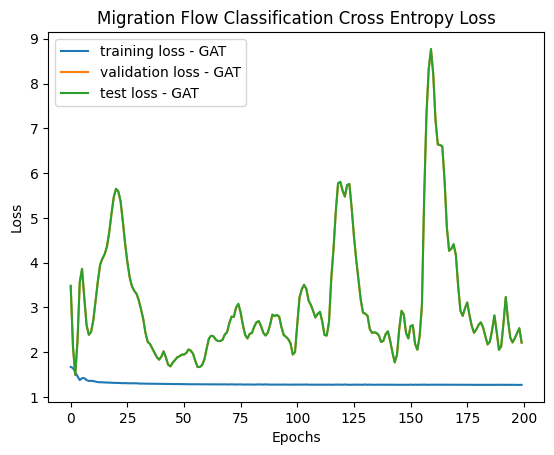

Running pipeline with config: Classification_GAT_full_within_state


Training:   0%|          | 1/200 [00:00<01:29,  2.22Epochs/s]

Epoch 1: Training Loss 1.63525, Training F1 Score (Micro) 0.20955 Validation Loss 2.08368 Validation F1 Score (Micro) 0.47407


Training:   1%|          | 2/200 [00:00<01:30,  2.18Epochs/s]

Epoch 2: Training Loss 1.86497, Training F1 Score (Micro) 0.47388 Validation Loss 1.98212 Validation F1 Score (Micro) 0.16518


Training:   2%|▏         | 3/200 [00:01<01:30,  2.17Epochs/s]

Epoch 3: Training Loss 1.51589, Training F1 Score (Micro) 0.458 Validation Loss 1.85301 Validation F1 Score (Micro) 0.14222


Training:   2%|▏         | 4/200 [00:01<01:29,  2.20Epochs/s]

Epoch 4: Training Loss 1.51783, Training F1 Score (Micro) 0.38986 Validation Loss 1.63386 Validation F1 Score (Micro) 0.21804


Training:   2%|▎         | 5/200 [00:02<01:25,  2.29Epochs/s]

Epoch 5: Training Loss 1.54902, Training F1 Score (Micro) 0.34913 Validation Loss 1.53838 Validation F1 Score (Micro) 0.41691


Training:   3%|▎         | 6/200 [00:02<01:19,  2.45Epochs/s]

Epoch 6: Training Loss 1.5058, Training F1 Score (Micro) 0.4131 Validation Loss 1.47683 Validation F1 Score (Micro) 0.45193


Training:   4%|▎         | 7/200 [00:02<01:14,  2.59Epochs/s]

Epoch 7: Training Loss 1.44028, Training F1 Score (Micro) 0.4697 Validation Loss 1.47384 Validation F1 Score (Micro) 0.46019


Training:   4%|▍         | 8/200 [00:03<01:11,  2.67Epochs/s]

Epoch 8: Training Loss 1.40073, Training F1 Score (Micro) 0.48551 Validation Loss 1.47474 Validation F1 Score (Micro) 0.47093


Training:   4%|▍         | 9/200 [00:03<01:10,  2.73Epochs/s]

Epoch 9: Training Loss 1.38923, Training F1 Score (Micro) 0.48669 Validation Loss 1.50411 Validation F1 Score (Micro) 0.482


Training:   5%|▌         | 10/200 [00:03<01:08,  2.77Epochs/s]

Epoch 10: Training Loss 1.38819, Training F1 Score (Micro) 0.48761 Validation Loss 1.56226 Validation F1 Score (Micro) 0.4777


Training:   6%|▌         | 11/200 [00:04<01:08,  2.75Epochs/s]

Epoch 11: Training Loss 1.37639, Training F1 Score (Micro) 0.48598 Validation Loss 1.59601 Validation F1 Score (Micro) 0.47687


Training:   6%|▌         | 12/200 [00:04<01:07,  2.79Epochs/s]

Epoch 12: Training Loss 1.36897, Training F1 Score (Micro) 0.48396 Validation Loss 1.62023 Validation F1 Score (Micro) 0.47324


Training:   6%|▋         | 13/200 [00:05<01:08,  2.74Epochs/s]

Epoch 13: Training Loss 1.36938, Training F1 Score (Micro) 0.48254 Validation Loss 1.59284 Validation F1 Score (Micro) 0.47341


Training:   7%|▋         | 14/200 [00:05<01:07,  2.75Epochs/s]

Epoch 14: Training Loss 1.37883, Training F1 Score (Micro) 0.48181 Validation Loss 1.52436 Validation F1 Score (Micro) 0.47605


Training:   8%|▊         | 15/200 [00:05<01:07,  2.75Epochs/s]

Epoch 15: Training Loss 1.37208, Training F1 Score (Micro) 0.47933 Validation Loss 1.47441 Validation F1 Score (Micro) 0.47588


Training:   8%|▊         | 16/200 [00:06<01:06,  2.76Epochs/s]

Epoch 16: Training Loss 1.36851, Training F1 Score (Micro) 0.47912 Validation Loss 1.42858 Validation F1 Score (Micro) 0.47225


Training:   8%|▊         | 17/200 [00:06<01:06,  2.75Epochs/s]

Epoch 17: Training Loss 1.36037, Training F1 Score (Micro) 0.4823 Validation Loss 1.415 Validation F1 Score (Micro) 0.47522


Training:   9%|▉         | 18/200 [00:06<01:06,  2.74Epochs/s]

Epoch 18: Training Loss 1.35456, Training F1 Score (Micro) 0.48299 Validation Loss 1.41247 Validation F1 Score (Micro) 0.47787


Training:  10%|▉         | 19/200 [00:07<01:05,  2.76Epochs/s]

Epoch 19: Training Loss 1.35701, Training F1 Score (Micro) 0.48731 Validation Loss 1.41108 Validation F1 Score (Micro) 0.47985


Training:  10%|█         | 20/200 [00:07<01:05,  2.76Epochs/s]

Epoch 20: Training Loss 1.36223, Training F1 Score (Micro) 0.48473 Validation Loss 1.41331 Validation F1 Score (Micro) 0.47968


Training:  10%|█         | 21/200 [00:07<01:03,  2.81Epochs/s]

Epoch 21: Training Loss 1.35715, Training F1 Score (Micro) 0.48839 Validation Loss 1.41771 Validation F1 Score (Micro) 0.48084


Training:  11%|█         | 22/200 [00:08<01:02,  2.85Epochs/s]

Epoch 22: Training Loss 1.34669, Training F1 Score (Micro) 0.49063 Validation Loss 1.42794 Validation F1 Score (Micro) 0.47902


Training:  12%|█▏        | 23/200 [00:08<01:02,  2.82Epochs/s]

Epoch 23: Training Loss 1.34544, Training F1 Score (Micro) 0.48813 Validation Loss 1.44012 Validation F1 Score (Micro) 0.47886


Training:  12%|█▏        | 24/200 [00:08<01:01,  2.85Epochs/s]

Epoch 24: Training Loss 1.34532, Training F1 Score (Micro) 0.4912 Validation Loss 1.45462 Validation F1 Score (Micro) 0.47935


Training:  12%|█▎        | 25/200 [00:09<01:00,  2.88Epochs/s]

Epoch 25: Training Loss 1.34277, Training F1 Score (Micro) 0.49153 Validation Loss 1.49436 Validation F1 Score (Micro) 0.47473


Training:  13%|█▎        | 26/200 [00:09<01:00,  2.86Epochs/s]

Epoch 26: Training Loss 1.34737, Training F1 Score (Micro) 0.48941 Validation Loss 1.53958 Validation F1 Score (Micro) 0.4744


Training:  14%|█▎        | 27/200 [00:10<00:59,  2.89Epochs/s]

Epoch 27: Training Loss 1.34346, Training F1 Score (Micro) 0.4916 Validation Loss 1.57746 Validation F1 Score (Micro) 0.47506


Training:  14%|█▍        | 28/200 [00:10<00:59,  2.89Epochs/s]

Epoch 28: Training Loss 1.3407, Training F1 Score (Micro) 0.49169 Validation Loss 1.59486 Validation F1 Score (Micro) 0.47489


Training:  14%|█▍        | 29/200 [00:10<00:59,  2.86Epochs/s]

Epoch 29: Training Loss 1.33641, Training F1 Score (Micro) 0.49146 Validation Loss 1.62479 Validation F1 Score (Micro) 0.4744


Training:  15%|█▌        | 30/200 [00:11<00:59,  2.88Epochs/s]

Epoch 30: Training Loss 1.33571, Training F1 Score (Micro) 0.49132 Validation Loss 1.64813 Validation F1 Score (Micro) 0.4744


Training:  16%|█▌        | 31/200 [00:11<00:58,  2.87Epochs/s]

Epoch 31: Training Loss 1.33753, Training F1 Score (Micro) 0.49054 Validation Loss 1.62291 Validation F1 Score (Micro) 0.4744


Training:  16%|█▌        | 32/200 [00:11<00:58,  2.86Epochs/s]

Epoch 32: Training Loss 1.33516, Training F1 Score (Micro) 0.49283 Validation Loss 1.58768 Validation F1 Score (Micro) 0.47621


Training:  16%|█▋        | 33/200 [00:12<01:01,  2.69Epochs/s]

Epoch 33: Training Loss 1.33948, Training F1 Score (Micro) 0.48974 Validation Loss 1.53066 Validation F1 Score (Micro) 0.47522


Training:  17%|█▋        | 34/200 [00:12<01:06,  2.49Epochs/s]

Epoch 34: Training Loss 1.33294, Training F1 Score (Micro) 0.48931 Validation Loss 1.51218 Validation F1 Score (Micro) 0.4744


Training:  18%|█▊        | 35/200 [00:13<01:09,  2.39Epochs/s]

Epoch 35: Training Loss 1.33009, Training F1 Score (Micro) 0.49066 Validation Loss 1.5023 Validation F1 Score (Micro) 0.4744


Training:  18%|█▊        | 36/200 [00:13<01:11,  2.30Epochs/s]

Epoch 36: Training Loss 1.33174, Training F1 Score (Micro) 0.49184 Validation Loss 1.51002 Validation F1 Score (Micro) 0.4744


Training:  18%|█▊        | 37/200 [00:14<01:12,  2.24Epochs/s]

Epoch 37: Training Loss 1.33117, Training F1 Score (Micro) 0.48945 Validation Loss 1.50755 Validation F1 Score (Micro) 0.4744


Training:  19%|█▉        | 38/200 [00:14<01:12,  2.22Epochs/s]

Epoch 38: Training Loss 1.33173, Training F1 Score (Micro) 0.49226 Validation Loss 1.51455 Validation F1 Score (Micro) 0.4744


Training:  20%|█▉        | 39/200 [00:14<01:12,  2.22Epochs/s]

Epoch 39: Training Loss 1.33195, Training F1 Score (Micro) 0.49269 Validation Loss 1.51025 Validation F1 Score (Micro) 0.4744


Training:  20%|██        | 40/200 [00:15<01:13,  2.17Epochs/s]

Epoch 40: Training Loss 1.33271, Training F1 Score (Micro) 0.48957 Validation Loss 1.50829 Validation F1 Score (Micro) 0.4744


Training:  20%|██        | 41/200 [00:15<01:14,  2.14Epochs/s]

Epoch 41: Training Loss 1.32835, Training F1 Score (Micro) 0.4912 Validation Loss 1.50054 Validation F1 Score (Micro) 0.47456


Training:  21%|██        | 42/200 [00:16<01:13,  2.16Epochs/s]

Epoch 42: Training Loss 1.329, Training F1 Score (Micro) 0.48879 Validation Loss 1.49122 Validation F1 Score (Micro) 0.47456


Training:  22%|██▏       | 43/200 [00:16<01:12,  2.17Epochs/s]

Epoch 43: Training Loss 1.331, Training F1 Score (Micro) 0.48719 Validation Loss 1.48495 Validation F1 Score (Micro) 0.47489


Training:  22%|██▏       | 44/200 [00:17<01:11,  2.17Epochs/s]

Epoch 44: Training Loss 1.32646, Training F1 Score (Micro) 0.49523 Validation Loss 1.50085 Validation F1 Score (Micro) 0.4744


Training:  22%|██▎       | 45/200 [00:17<01:06,  2.33Epochs/s]

Epoch 45: Training Loss 1.32911, Training F1 Score (Micro) 0.49243 Validation Loss 1.51904 Validation F1 Score (Micro) 0.4744


Training:  23%|██▎       | 46/200 [00:18<01:02,  2.46Epochs/s]

Epoch 46: Training Loss 1.32519, Training F1 Score (Micro) 0.49261 Validation Loss 1.54374 Validation F1 Score (Micro) 0.4744


Training:  24%|██▎       | 47/200 [00:18<00:59,  2.58Epochs/s]

Epoch 47: Training Loss 1.3252, Training F1 Score (Micro) 0.49467 Validation Loss 1.56244 Validation F1 Score (Micro) 0.47407


Training:  24%|██▍       | 48/200 [00:18<00:57,  2.65Epochs/s]

Epoch 48: Training Loss 1.32815, Training F1 Score (Micro) 0.49273 Validation Loss 1.55532 Validation F1 Score (Micro) 0.47407


Training:  24%|██▍       | 49/200 [00:19<00:56,  2.68Epochs/s]

Epoch 49: Training Loss 1.32465, Training F1 Score (Micro) 0.4916 Validation Loss 1.51756 Validation F1 Score (Micro) 0.47407


Training:  25%|██▌       | 50/200 [00:19<00:54,  2.73Epochs/s]

Epoch 50: Training Loss 1.32616, Training F1 Score (Micro) 0.49538 Validation Loss 1.49502 Validation F1 Score (Micro) 0.47423


Training:  26%|██▌       | 51/200 [00:19<00:53,  2.77Epochs/s]

Epoch 51: Training Loss 1.32376, Training F1 Score (Micro) 0.49394 Validation Loss 1.49327 Validation F1 Score (Micro) 0.47473


Training:  26%|██▌       | 52/200 [00:20<00:53,  2.77Epochs/s]

Epoch 52: Training Loss 1.32387, Training F1 Score (Micro) 0.49519 Validation Loss 1.49831 Validation F1 Score (Micro) 0.4744


Training:  26%|██▋       | 53/200 [00:20<00:52,  2.80Epochs/s]

Epoch 53: Training Loss 1.32384, Training F1 Score (Micro) 0.4966 Validation Loss 1.50185 Validation F1 Score (Micro) 0.47456


Training:  27%|██▋       | 54/200 [00:20<00:51,  2.83Epochs/s]

Epoch 54: Training Loss 1.32156, Training F1 Score (Micro) 0.49174 Validation Loss 1.4864 Validation F1 Score (Micro) 0.47456


Training:  28%|██▊       | 55/200 [00:21<00:51,  2.83Epochs/s]

Epoch 55: Training Loss 1.31953, Training F1 Score (Micro) 0.49542 Validation Loss 1.44819 Validation F1 Score (Micro) 0.4744


Training:  28%|██▊       | 56/200 [00:21<00:50,  2.85Epochs/s]

Epoch 56: Training Loss 1.32432, Training F1 Score (Micro) 0.49077 Validation Loss 1.41883 Validation F1 Score (Micro) 0.4744


Training:  28%|██▊       | 57/200 [00:21<00:50,  2.84Epochs/s]

Epoch 57: Training Loss 1.31966, Training F1 Score (Micro) 0.4954 Validation Loss 1.40262 Validation F1 Score (Micro) 0.47456


Training:  29%|██▉       | 58/200 [00:22<00:50,  2.83Epochs/s]

Epoch 58: Training Loss 1.32232, Training F1 Score (Micro) 0.49172 Validation Loss 1.39408 Validation F1 Score (Micro) 0.47671


Training:  30%|██▉       | 59/200 [00:22<00:49,  2.84Epochs/s]

Epoch 59: Training Loss 1.32148, Training F1 Score (Micro) 0.49377 Validation Loss 1.40376 Validation F1 Score (Micro) 0.47489


Training:  30%|███       | 60/200 [00:22<00:49,  2.84Epochs/s]

Epoch 60: Training Loss 1.32348, Training F1 Score (Micro) 0.48884 Validation Loss 1.41243 Validation F1 Score (Micro) 0.47489


Training:  30%|███       | 61/200 [00:23<00:49,  2.81Epochs/s]

Epoch 61: Training Loss 1.32001, Training F1 Score (Micro) 0.49568 Validation Loss 1.4253 Validation F1 Score (Micro) 0.47489


Training:  31%|███       | 62/200 [00:23<00:48,  2.83Epochs/s]

Epoch 62: Training Loss 1.32439, Training F1 Score (Micro) 0.49158 Validation Loss 1.42163 Validation F1 Score (Micro) 0.47489


Training:  32%|███▏      | 63/200 [00:24<00:48,  2.82Epochs/s]

Epoch 63: Training Loss 1.31962, Training F1 Score (Micro) 0.4937 Validation Loss 1.41569 Validation F1 Score (Micro) 0.47869


Training:  32%|███▏      | 64/200 [00:24<00:48,  2.81Epochs/s]

Epoch 64: Training Loss 1.3214, Training F1 Score (Micro) 0.49578 Validation Loss 1.41149 Validation F1 Score (Micro) 0.47919


Training:  32%|███▎      | 65/200 [00:24<00:47,  2.81Epochs/s]

Epoch 65: Training Loss 1.3203, Training F1 Score (Micro) 0.49752 Validation Loss 1.40984 Validation F1 Score (Micro) 0.47721


Training:  33%|███▎      | 66/200 [00:25<00:47,  2.83Epochs/s]

Epoch 66: Training Loss 1.32275, Training F1 Score (Micro) 0.49648 Validation Loss 1.39824 Validation F1 Score (Micro) 0.47456


Training:  34%|███▎      | 67/200 [00:25<00:47,  2.79Epochs/s]

Epoch 67: Training Loss 1.31894, Training F1 Score (Micro) 0.49745 Validation Loss 1.38524 Validation F1 Score (Micro) 0.47853


Training:  34%|███▍      | 68/200 [00:25<00:47,  2.79Epochs/s]

Epoch 68: Training Loss 1.31639, Training F1 Score (Micro) 0.49797 Validation Loss 1.37955 Validation F1 Score (Micro) 0.47919


Training:  34%|███▍      | 69/200 [00:26<00:46,  2.79Epochs/s]

Epoch 69: Training Loss 1.32006, Training F1 Score (Micro) 0.49589 Validation Loss 1.3779 Validation F1 Score (Micro) 0.4777


Training:  35%|███▌      | 70/200 [00:26<00:46,  2.78Epochs/s]

Epoch 70: Training Loss 1.31947, Training F1 Score (Micro) 0.49514 Validation Loss 1.37735 Validation F1 Score (Micro) 0.47886


Training:  36%|███▌      | 71/200 [00:26<00:46,  2.79Epochs/s]

Epoch 71: Training Loss 1.31574, Training F1 Score (Micro) 0.49693 Validation Loss 1.37704 Validation F1 Score (Micro) 0.47919


Training:  36%|███▌      | 72/200 [00:27<00:46,  2.76Epochs/s]

Epoch 72: Training Loss 1.31462, Training F1 Score (Micro) 0.49686 Validation Loss 1.38311 Validation F1 Score (Micro) 0.47886


Training:  36%|███▋      | 73/200 [00:27<00:49,  2.55Epochs/s]

Epoch 73: Training Loss 1.31598, Training F1 Score (Micro) 0.49719 Validation Loss 1.38412 Validation F1 Score (Micro) 0.47869


Training:  37%|███▋      | 74/200 [00:28<00:52,  2.40Epochs/s]

Epoch 74: Training Loss 1.31404, Training F1 Score (Micro) 0.49969 Validation Loss 1.38199 Validation F1 Score (Micro) 0.47886


Training:  38%|███▊      | 75/200 [00:28<00:53,  2.32Epochs/s]

Epoch 75: Training Loss 1.31767, Training F1 Score (Micro) 0.49523 Validation Loss 1.38123 Validation F1 Score (Micro) 0.47787


Training:  38%|███▊      | 76/200 [00:29<00:55,  2.22Epochs/s]

Epoch 76: Training Loss 1.32123, Training F1 Score (Micro) 0.49401 Validation Loss 1.36593 Validation F1 Score (Micro) 0.4782


Training:  38%|███▊      | 77/200 [00:29<00:56,  2.18Epochs/s]

Epoch 77: Training Loss 1.32027, Training F1 Score (Micro) 0.49361 Validation Loss 1.35748 Validation F1 Score (Micro) 0.47886


Training:  39%|███▉      | 78/200 [00:30<00:56,  2.17Epochs/s]

Epoch 78: Training Loss 1.31469, Training F1 Score (Micro) 0.49719 Validation Loss 1.35651 Validation F1 Score (Micro) 0.47919


Training:  40%|███▉      | 79/200 [00:30<00:57,  2.10Epochs/s]

Epoch 79: Training Loss 1.31745, Training F1 Score (Micro) 0.49863 Validation Loss 1.35851 Validation F1 Score (Micro) 0.47985


Training:  40%|████      | 80/200 [00:31<00:58,  2.05Epochs/s]

Epoch 80: Training Loss 1.31902, Training F1 Score (Micro) 0.49717 Validation Loss 1.363 Validation F1 Score (Micro) 0.47952


Training:  40%|████      | 81/200 [00:31<00:57,  2.05Epochs/s]

Epoch 81: Training Loss 1.31764, Training F1 Score (Micro) 0.49731 Validation Loss 1.37159 Validation F1 Score (Micro) 0.4782


Training:  41%|████      | 82/200 [00:32<00:57,  2.04Epochs/s]

Epoch 82: Training Loss 1.31997, Training F1 Score (Micro) 0.4949 Validation Loss 1.37058 Validation F1 Score (Micro) 0.47803


Training:  42%|████▏     | 83/200 [00:32<00:55,  2.12Epochs/s]

Epoch 83: Training Loss 1.31692, Training F1 Score (Micro) 0.49686 Validation Loss 1.37191 Validation F1 Score (Micro) 0.4777


Training:  42%|████▏     | 84/200 [00:32<00:51,  2.27Epochs/s]

Epoch 84: Training Loss 1.3158, Training F1 Score (Micro) 0.49559 Validation Loss 1.3709 Validation F1 Score (Micro) 0.47754


Training:  42%|████▎     | 85/200 [00:33<00:47,  2.42Epochs/s]

Epoch 85: Training Loss 1.31442, Training F1 Score (Micro) 0.49814 Validation Loss 1.37426 Validation F1 Score (Micro) 0.47489


Training:  43%|████▎     | 86/200 [00:33<00:45,  2.50Epochs/s]

Epoch 86: Training Loss 1.31805, Training F1 Score (Micro) 0.49318 Validation Loss 1.37505 Validation F1 Score (Micro) 0.47489


Training:  44%|████▎     | 87/200 [00:33<00:44,  2.55Epochs/s]

Epoch 87: Training Loss 1.31743, Training F1 Score (Micro) 0.49207 Validation Loss 1.3655 Validation F1 Score (Micro) 0.47489


Training:  44%|████▍     | 88/200 [00:34<00:42,  2.61Epochs/s]

Epoch 88: Training Loss 1.30964, Training F1 Score (Micro) 0.50059 Validation Loss 1.36369 Validation F1 Score (Micro) 0.48133


Training:  44%|████▍     | 89/200 [00:34<00:42,  2.58Epochs/s]

Epoch 89: Training Loss 1.31244, Training F1 Score (Micro) 0.5004 Validation Loss 1.36573 Validation F1 Score (Micro) 0.48315


Training:  45%|████▌     | 90/200 [00:35<00:41,  2.64Epochs/s]

Epoch 90: Training Loss 1.30859, Training F1 Score (Micro) 0.5004 Validation Loss 1.36653 Validation F1 Score (Micro) 0.48315


Training:  46%|████▌     | 91/200 [00:35<00:41,  2.62Epochs/s]

Epoch 91: Training Loss 1.31135, Training F1 Score (Micro) 0.49974 Validation Loss 1.37465 Validation F1 Score (Micro) 0.48183


Training:  46%|████▌     | 92/200 [00:35<00:40,  2.65Epochs/s]

Epoch 92: Training Loss 1.30965, Training F1 Score (Micro) 0.49809 Validation Loss 1.37803 Validation F1 Score (Micro) 0.48117


Training:  46%|████▋     | 93/200 [00:36<00:39,  2.68Epochs/s]

Epoch 93: Training Loss 1.3125, Training F1 Score (Micro) 0.49988 Validation Loss 1.38025 Validation F1 Score (Micro) 0.47935


Training:  47%|████▋     | 94/200 [00:36<00:38,  2.73Epochs/s]

Epoch 94: Training Loss 1.31095, Training F1 Score (Micro) 0.49891 Validation Loss 1.38532 Validation F1 Score (Micro) 0.47935


Training:  48%|████▊     | 95/200 [00:36<00:38,  2.72Epochs/s]

Epoch 95: Training Loss 1.30841, Training F1 Score (Micro) 0.49974 Validation Loss 1.39892 Validation F1 Score (Micro) 0.47853


Training:  48%|████▊     | 96/200 [00:37<00:37,  2.74Epochs/s]

Epoch 96: Training Loss 1.30915, Training F1 Score (Micro) 0.50083 Validation Loss 1.38449 Validation F1 Score (Micro) 0.47853


Training:  48%|████▊     | 97/200 [00:37<00:37,  2.77Epochs/s]

Epoch 97: Training Loss 1.31117, Training F1 Score (Micro) 0.49809 Validation Loss 1.34751 Validation F1 Score (Micro) 0.482


Training:  49%|████▉     | 98/200 [00:38<00:37,  2.75Epochs/s]

Epoch 98: Training Loss 1.31054, Training F1 Score (Micro) 0.50255 Validation Loss 1.33234 Validation F1 Score (Micro) 0.48579


Training:  50%|████▉     | 99/200 [00:38<00:36,  2.77Epochs/s]

Epoch 99: Training Loss 1.30837, Training F1 Score (Micro) 0.50281 Validation Loss 1.33518 Validation F1 Score (Micro) 0.4848


Training:  50%|█████     | 100/200 [00:38<00:35,  2.79Epochs/s]

Epoch 100: Training Loss 1.30857, Training F1 Score (Micro) 0.50021 Validation Loss 1.34253 Validation F1 Score (Micro) 0.4777


Training:  50%|█████     | 101/200 [00:39<00:35,  2.78Epochs/s]

Epoch 101: Training Loss 1.30836, Training F1 Score (Micro) 0.49958 Validation Loss 1.34844 Validation F1 Score (Micro) 0.47787


Training:  51%|█████     | 102/200 [00:39<00:34,  2.81Epochs/s]

Epoch 102: Training Loss 1.31078, Training F1 Score (Micro) 0.49469 Validation Loss 1.3462 Validation F1 Score (Micro) 0.47985


Training:  52%|█████▏    | 103/200 [00:39<00:34,  2.79Epochs/s]

Epoch 103: Training Loss 1.30877, Training F1 Score (Micro) 0.49811 Validation Loss 1.34809 Validation F1 Score (Micro) 0.48249


Training:  52%|█████▏    | 104/200 [00:40<00:34,  2.77Epochs/s]

Epoch 104: Training Loss 1.30973, Training F1 Score (Micro) 0.50031 Validation Loss 1.35861 Validation F1 Score (Micro) 0.47787


Training:  52%|█████▎    | 105/200 [00:40<00:34,  2.78Epochs/s]

Epoch 105: Training Loss 1.30618, Training F1 Score (Micro) 0.50057 Validation Loss 1.36394 Validation F1 Score (Micro) 0.47787


Training:  53%|█████▎    | 106/200 [00:40<00:33,  2.78Epochs/s]

Epoch 106: Training Loss 1.30504, Training F1 Score (Micro) 0.50111 Validation Loss 1.35698 Validation F1 Score (Micro) 0.47836


Training:  54%|█████▎    | 107/200 [00:41<00:33,  2.74Epochs/s]

Epoch 107: Training Loss 1.30757, Training F1 Score (Micro) 0.49729 Validation Loss 1.33972 Validation F1 Score (Micro) 0.48629


Training:  54%|█████▍    | 108/200 [00:41<00:34,  2.68Epochs/s]

Epoch 108: Training Loss 1.30697, Training F1 Score (Micro) 0.50333 Validation Loss 1.32777 Validation F1 Score (Micro) 0.48992


Training:  55%|█████▍    | 109/200 [00:42<00:34,  2.67Epochs/s]

Epoch 109: Training Loss 1.30629, Training F1 Score (Micro) 0.50111 Validation Loss 1.3322 Validation F1 Score (Micro) 0.48679


Training:  55%|█████▌    | 110/200 [00:42<00:34,  2.60Epochs/s]

Epoch 110: Training Loss 1.3044, Training F1 Score (Micro) 0.50087 Validation Loss 1.34548 Validation F1 Score (Micro) 0.48497


Training:  56%|█████▌    | 111/200 [00:42<00:36,  2.43Epochs/s]

Epoch 111: Training Loss 1.30891, Training F1 Score (Micro) 0.49835 Validation Loss 1.35371 Validation F1 Score (Micro) 0.48018


Training:  56%|█████▌    | 112/200 [00:43<00:38,  2.31Epochs/s]

Epoch 112: Training Loss 1.30512, Training F1 Score (Micro) 0.50087 Validation Loss 1.35342 Validation F1 Score (Micro) 0.47935


Training:  56%|█████▋    | 113/200 [00:43<00:39,  2.23Epochs/s]

Epoch 113: Training Loss 1.30564, Training F1 Score (Micro) 0.50271 Validation Loss 1.35051 Validation F1 Score (Micro) 0.47902


Training:  57%|█████▋    | 114/200 [00:44<00:38,  2.21Epochs/s]

Epoch 114: Training Loss 1.30361, Training F1 Score (Micro) 0.50536 Validation Loss 1.35264 Validation F1 Score (Micro) 0.47869


Training:  57%|█████▊    | 115/200 [00:44<00:38,  2.20Epochs/s]

Epoch 115: Training Loss 1.30345, Training F1 Score (Micro) 0.50217 Validation Loss 1.359 Validation F1 Score (Micro) 0.47919


Training:  58%|█████▊    | 116/200 [00:45<00:38,  2.19Epochs/s]

Epoch 116: Training Loss 1.3055, Training F1 Score (Micro) 0.49851 Validation Loss 1.35967 Validation F1 Score (Micro) 0.48266


Training:  58%|█████▊    | 117/200 [00:45<00:38,  2.15Epochs/s]

Epoch 117: Training Loss 1.30153, Training F1 Score (Micro) 0.50302 Validation Loss 1.36457 Validation F1 Score (Micro) 0.48067


Training:  59%|█████▉    | 118/200 [00:46<00:39,  2.09Epochs/s]

Epoch 118: Training Loss 1.30405, Training F1 Score (Micro) 0.50153 Validation Loss 1.36659 Validation F1 Score (Micro) 0.48249


Training:  60%|█████▉    | 119/200 [00:46<00:38,  2.12Epochs/s]

Epoch 119: Training Loss 1.30196, Training F1 Score (Micro) 0.50286 Validation Loss 1.38042 Validation F1 Score (Micro) 0.482


Training:  60%|██████    | 120/200 [00:47<00:37,  2.14Epochs/s]

Epoch 120: Training Loss 1.30184, Training F1 Score (Micro) 0.5013 Validation Loss 1.38371 Validation F1 Score (Micro) 0.482


Training:  60%|██████    | 121/200 [00:47<00:34,  2.30Epochs/s]

Epoch 121: Training Loss 1.29983, Training F1 Score (Micro) 0.50352 Validation Loss 1.38713 Validation F1 Score (Micro) 0.47853


Training:  61%|██████    | 122/200 [00:47<00:32,  2.43Epochs/s]

Epoch 122: Training Loss 1.30352, Training F1 Score (Micro) 0.50134 Validation Loss 1.38953 Validation F1 Score (Micro) 0.4782


Training:  62%|██████▏   | 123/200 [00:48<00:30,  2.53Epochs/s]

Epoch 123: Training Loss 1.30264, Training F1 Score (Micro) 0.50066 Validation Loss 1.37618 Validation F1 Score (Micro) 0.48282


Training:  62%|██████▏   | 124/200 [00:48<00:29,  2.58Epochs/s]

Epoch 124: Training Loss 1.29902, Training F1 Score (Micro) 0.5042 Validation Loss 1.36905 Validation F1 Score (Micro) 0.48431


Training:  62%|██████▎   | 125/200 [00:48<00:28,  2.65Epochs/s]

Epoch 125: Training Loss 1.29748, Training F1 Score (Micro) 0.50609 Validation Loss 1.36077 Validation F1 Score (Micro) 0.48431


Training:  63%|██████▎   | 126/200 [00:49<00:27,  2.70Epochs/s]

Epoch 126: Training Loss 1.3026, Training F1 Score (Micro) 0.50394 Validation Loss 1.34232 Validation F1 Score (Micro) 0.48315


Training:  64%|██████▎   | 127/200 [00:49<00:27,  2.70Epochs/s]

Epoch 127: Training Loss 1.29725, Training F1 Score (Micro) 0.50255 Validation Loss 1.3294 Validation F1 Score (Micro) 0.48348


Training:  64%|██████▍   | 128/200 [00:50<00:26,  2.73Epochs/s]

Epoch 128: Training Loss 1.29882, Training F1 Score (Micro) 0.50342 Validation Loss 1.33228 Validation F1 Score (Micro) 0.47935


Training:  64%|██████▍   | 129/200 [00:50<00:25,  2.77Epochs/s]

Epoch 129: Training Loss 1.29852, Training F1 Score (Micro) 0.50536 Validation Loss 1.34791 Validation F1 Score (Micro) 0.47539


Training:  65%|██████▌   | 130/200 [00:50<00:25,  2.77Epochs/s]

Epoch 130: Training Loss 1.30204, Training F1 Score (Micro) 0.49958 Validation Loss 1.36436 Validation F1 Score (Micro) 0.4782


Training:  66%|██████▌   | 131/200 [00:51<00:24,  2.79Epochs/s]

Epoch 131: Training Loss 1.30235, Training F1 Score (Micro) 0.50139 Validation Loss 1.35495 Validation F1 Score (Micro) 0.4815


Training:  66%|██████▌   | 132/200 [00:51<00:24,  2.76Epochs/s]

Epoch 132: Training Loss 1.29401, Training F1 Score (Micro) 0.50488 Validation Loss 1.34145 Validation F1 Score (Micro) 0.48679


Training:  66%|██████▋   | 133/200 [00:51<00:24,  2.77Epochs/s]

Epoch 133: Training Loss 1.29808, Training F1 Score (Micro) 0.50373 Validation Loss 1.32923 Validation F1 Score (Micro) 0.48679


Training:  67%|██████▋   | 134/200 [00:52<00:24,  2.75Epochs/s]

Epoch 134: Training Loss 1.29896, Training F1 Score (Micro) 0.50387 Validation Loss 1.32695 Validation F1 Score (Micro) 0.48332


Training:  68%|██████▊   | 135/200 [00:52<00:23,  2.72Epochs/s]

Epoch 135: Training Loss 1.29535, Training F1 Score (Micro) 0.50519 Validation Loss 1.32569 Validation F1 Score (Micro) 0.4782


Training:  68%|██████▊   | 136/200 [00:52<00:23,  2.72Epochs/s]

Epoch 136: Training Loss 1.2959, Training F1 Score (Micro) 0.50111 Validation Loss 1.32202 Validation F1 Score (Micro) 0.48018


Training:  68%|██████▊   | 137/200 [00:53<00:22,  2.75Epochs/s]

Epoch 137: Training Loss 1.29856, Training F1 Score (Micro) 0.50189 Validation Loss 1.3195 Validation F1 Score (Micro) 0.48794


Training:  69%|██████▉   | 138/200 [00:53<00:22,  2.74Epochs/s]

Epoch 138: Training Loss 1.29521, Training F1 Score (Micro) 0.50257 Validation Loss 1.32533 Validation F1 Score (Micro) 0.48051


Training:  70%|██████▉   | 139/200 [00:54<00:22,  2.75Epochs/s]

Epoch 139: Training Loss 1.29475, Training F1 Score (Micro) 0.50613 Validation Loss 1.32826 Validation F1 Score (Micro) 0.48381


Training:  70%|███████   | 140/200 [00:54<00:21,  2.79Epochs/s]

Epoch 140: Training Loss 1.29247, Training F1 Score (Micro) 0.50609 Validation Loss 1.32582 Validation F1 Score (Micro) 0.48827


Training:  70%|███████   | 141/200 [00:54<00:21,  2.77Epochs/s]

Epoch 141: Training Loss 1.29211, Training F1 Score (Micro) 0.50795 Validation Loss 1.32111 Validation F1 Score (Micro) 0.48976


Training:  71%|███████   | 142/200 [00:55<00:21,  2.75Epochs/s]

Epoch 142: Training Loss 1.29673, Training F1 Score (Micro) 0.50302 Validation Loss 1.31585 Validation F1 Score (Micro) 0.48695


Training:  72%|███████▏  | 143/200 [00:55<00:20,  2.76Epochs/s]

Epoch 143: Training Loss 1.29402, Training F1 Score (Micro) 0.50486 Validation Loss 1.32051 Validation F1 Score (Micro) 0.4848


Training:  72%|███████▏  | 144/200 [00:55<00:20,  2.76Epochs/s]

Epoch 144: Training Loss 1.29183, Training F1 Score (Micro) 0.50453 Validation Loss 1.32995 Validation F1 Score (Micro) 0.48216


Training:  72%|███████▎  | 145/200 [00:56<00:19,  2.78Epochs/s]

Epoch 145: Training Loss 1.29329, Training F1 Score (Micro) 0.50644 Validation Loss 1.32122 Validation F1 Score (Micro) 0.48282


Training:  73%|███████▎  | 146/200 [00:56<00:19,  2.80Epochs/s]

Epoch 146: Training Loss 1.29183, Training F1 Score (Micro) 0.50583 Validation Loss 1.32076 Validation F1 Score (Micro) 0.48431


Training:  74%|███████▎  | 147/200 [00:56<00:19,  2.77Epochs/s]

Epoch 147: Training Loss 1.29267, Training F1 Score (Micro) 0.50665 Validation Loss 1.33405 Validation F1 Score (Micro) 0.48992


Training:  74%|███████▍  | 148/200 [00:57<00:19,  2.66Epochs/s]

Epoch 148: Training Loss 1.29435, Training F1 Score (Micro) 0.50793 Validation Loss 1.36173 Validation F1 Score (Micro) 0.48612


Training:  74%|███████▍  | 149/200 [00:57<00:20,  2.44Epochs/s]

Epoch 149: Training Loss 1.2969, Training F1 Score (Micro) 0.5009 Validation Loss 1.34231 Validation F1 Score (Micro) 0.48266


Training:  75%|███████▌  | 150/200 [00:58<00:21,  2.34Epochs/s]

Epoch 150: Training Loss 1.29173, Training F1 Score (Micro) 0.50602 Validation Loss 1.31835 Validation F1 Score (Micro) 0.4848


Training:  76%|███████▌  | 151/200 [00:58<00:21,  2.25Epochs/s]

Epoch 151: Training Loss 1.28958, Training F1 Score (Micro) 0.50967 Validation Loss 1.31385 Validation F1 Score (Micro) 0.4853


Training:  76%|███████▌  | 152/200 [00:59<00:21,  2.24Epochs/s]

Epoch 152: Training Loss 1.29114, Training F1 Score (Micro) 0.50588 Validation Loss 1.31816 Validation F1 Score (Micro) 0.48596


Training:  76%|███████▋  | 153/200 [00:59<00:21,  2.23Epochs/s]

Epoch 153: Training Loss 1.29135, Training F1 Score (Micro) 0.50859 Validation Loss 1.32848 Validation F1 Score (Micro) 0.48497


Training:  77%|███████▋  | 154/200 [01:00<00:21,  2.16Epochs/s]

Epoch 154: Training Loss 1.29637, Training F1 Score (Micro) 0.50611 Validation Loss 1.31652 Validation F1 Score (Micro) 0.4886


Training:  78%|███████▊  | 155/200 [01:00<00:20,  2.15Epochs/s]

Epoch 155: Training Loss 1.28985, Training F1 Score (Micro) 0.50387 Validation Loss 1.30838 Validation F1 Score (Micro) 0.48926


Training:  78%|███████▊  | 156/200 [01:01<00:20,  2.11Epochs/s]

Epoch 156: Training Loss 1.29294, Training F1 Score (Micro) 0.50448 Validation Loss 1.30978 Validation F1 Score (Micro) 0.49703


Training:  78%|███████▊  | 157/200 [01:01<00:20,  2.12Epochs/s]

Epoch 157: Training Loss 1.29194, Training F1 Score (Micro) 0.50656 Validation Loss 1.32434 Validation F1 Score (Micro) 0.49042


Training:  79%|███████▉  | 158/200 [01:01<00:18,  2.28Epochs/s]

Epoch 158: Training Loss 1.29125, Training F1 Score (Micro) 0.50727 Validation Loss 1.34357 Validation F1 Score (Micro) 0.47902


Training:  80%|███████▉  | 159/200 [01:02<00:16,  2.42Epochs/s]

Epoch 159: Training Loss 1.29355, Training F1 Score (Micro) 0.50418 Validation Loss 1.34313 Validation F1 Score (Micro) 0.48051


Training:  80%|████████  | 160/200 [01:02<00:15,  2.53Epochs/s]

Epoch 160: Training Loss 1.28926, Training F1 Score (Micro) 0.50703 Validation Loss 1.32766 Validation F1 Score (Micro) 0.48893


Training:  80%|████████  | 161/200 [01:03<00:15,  2.58Epochs/s]

Epoch 161: Training Loss 1.28982, Training F1 Score (Micro) 0.50821 Validation Loss 1.31739 Validation F1 Score (Micro) 0.49075


Training:  81%|████████  | 162/200 [01:03<00:14,  2.67Epochs/s]

Epoch 162: Training Loss 1.29228, Training F1 Score (Micro) 0.50849 Validation Loss 1.32016 Validation F1 Score (Micro) 0.48893


Training:  82%|████████▏ | 163/200 [01:03<00:13,  2.70Epochs/s]

Epoch 163: Training Loss 1.28773, Training F1 Score (Micro) 0.50979 Validation Loss 1.33604 Validation F1 Score (Micro) 0.48679


Training:  82%|████████▏ | 164/200 [01:04<00:13,  2.68Epochs/s]

Epoch 164: Training Loss 1.29003, Training F1 Score (Micro) 0.50252 Validation Loss 1.35748 Validation F1 Score (Micro) 0.48381


Training:  82%|████████▎ | 165/200 [01:04<00:12,  2.70Epochs/s]

Epoch 165: Training Loss 1.28858, Training F1 Score (Micro) 0.50538 Validation Loss 1.35132 Validation F1 Score (Micro) 0.48398


Training:  83%|████████▎ | 166/200 [01:04<00:12,  2.71Epochs/s]

Epoch 166: Training Loss 1.28812, Training F1 Score (Micro) 0.50701 Validation Loss 1.33941 Validation F1 Score (Micro) 0.48563


Training:  84%|████████▎ | 167/200 [01:05<00:12,  2.70Epochs/s]

Epoch 167: Training Loss 1.28911, Training F1 Score (Micro) 0.50739 Validation Loss 1.32914 Validation F1 Score (Micro) 0.48695


Training:  84%|████████▍ | 168/200 [01:05<00:12,  2.65Epochs/s]

Epoch 168: Training Loss 1.28967, Training F1 Score (Micro) 0.50621 Validation Loss 1.32616 Validation F1 Score (Micro) 0.48745


Training:  84%|████████▍ | 169/200 [01:06<00:11,  2.65Epochs/s]

Epoch 169: Training Loss 1.28624, Training F1 Score (Micro) 0.50682 Validation Loss 1.32289 Validation F1 Score (Micro) 0.48943


Training:  85%|████████▌ | 170/200 [01:06<00:11,  2.67Epochs/s]

Epoch 170: Training Loss 1.29096, Training F1 Score (Micro) 0.50677 Validation Loss 1.30782 Validation F1 Score (Micro) 0.49125


Training:  86%|████████▌ | 171/200 [01:06<00:10,  2.70Epochs/s]

Epoch 171: Training Loss 1.28241, Training F1 Score (Micro) 0.51055 Validation Loss 1.30253 Validation F1 Score (Micro) 0.49719


Training:  86%|████████▌ | 172/200 [01:07<00:10,  2.69Epochs/s]

Epoch 172: Training Loss 1.28837, Training F1 Score (Micro) 0.50736 Validation Loss 1.30222 Validation F1 Score (Micro) 0.4967


Training:  86%|████████▋ | 173/200 [01:07<00:10,  2.66Epochs/s]

Epoch 173: Training Loss 1.28843, Training F1 Score (Micro) 0.50826 Validation Loss 1.30455 Validation F1 Score (Micro) 0.49554


Training:  87%|████████▋ | 174/200 [01:07<00:09,  2.72Epochs/s]

Epoch 174: Training Loss 1.28572, Training F1 Score (Micro) 0.51147 Validation Loss 1.31406 Validation F1 Score (Micro) 0.49009


Training:  88%|████████▊ | 175/200 [01:08<00:09,  2.73Epochs/s]

Epoch 175: Training Loss 1.28486, Training F1 Score (Micro) 0.50956 Validation Loss 1.3296 Validation F1 Score (Micro) 0.4891


Training:  88%|████████▊ | 176/200 [01:08<00:08,  2.75Epochs/s]

Epoch 176: Training Loss 1.28578, Training F1 Score (Micro) 0.50915 Validation Loss 1.33894 Validation F1 Score (Micro) 0.48794


Training:  88%|████████▊ | 177/200 [01:08<00:08,  2.77Epochs/s]

Epoch 177: Training Loss 1.28615, Training F1 Score (Micro) 0.50647 Validation Loss 1.34181 Validation F1 Score (Micro) 0.48811


Training:  89%|████████▉ | 178/200 [01:09<00:07,  2.77Epochs/s]

Epoch 178: Training Loss 1.28429, Training F1 Score (Micro) 0.50866 Validation Loss 1.33515 Validation F1 Score (Micro) 0.48959


Training:  90%|████████▉ | 179/200 [01:09<00:07,  2.79Epochs/s]

Epoch 179: Training Loss 1.28892, Training F1 Score (Micro) 0.50823 Validation Loss 1.32341 Validation F1 Score (Micro) 0.49141


Training:  90%|█████████ | 180/200 [01:09<00:07,  2.79Epochs/s]

Epoch 180: Training Loss 1.28466, Training F1 Score (Micro) 0.50696 Validation Loss 1.3266 Validation F1 Score (Micro) 0.49009


Training:  90%|█████████ | 181/200 [01:10<00:06,  2.76Epochs/s]

Epoch 181: Training Loss 1.28443, Training F1 Score (Micro) 0.50925 Validation Loss 1.3298 Validation F1 Score (Micro) 0.48398


Training:  91%|█████████ | 182/200 [01:10<00:06,  2.79Epochs/s]

Epoch 182: Training Loss 1.28826, Training F1 Score (Micro) 0.50649 Validation Loss 1.32797 Validation F1 Score (Micro) 0.48381


Training:  92%|█████████▏| 183/200 [01:11<00:06,  2.79Epochs/s]

Epoch 183: Training Loss 1.28199, Training F1 Score (Micro) 0.51074 Validation Loss 1.32421 Validation F1 Score (Micro) 0.48612


Training:  92%|█████████▏| 184/200 [01:11<00:05,  2.79Epochs/s]

Epoch 184: Training Loss 1.28192, Training F1 Score (Micro) 0.50904 Validation Loss 1.31957 Validation F1 Score (Micro) 0.49092


Training:  92%|█████████▎| 185/200 [01:11<00:05,  2.66Epochs/s]

Epoch 185: Training Loss 1.28252, Training F1 Score (Micro) 0.50856 Validation Loss 1.32099 Validation F1 Score (Micro) 0.49025


Training:  93%|█████████▎| 186/200 [01:12<00:05,  2.40Epochs/s]

Epoch 186: Training Loss 1.28236, Training F1 Score (Micro) 0.5092 Validation Loss 1.31717 Validation F1 Score (Micro) 0.4886


Training:  94%|█████████▎| 187/200 [01:12<00:05,  2.30Epochs/s]

Epoch 187: Training Loss 1.27963, Training F1 Score (Micro) 0.51203 Validation Loss 1.31188 Validation F1 Score (Micro) 0.4853


Training:  94%|█████████▍| 188/200 [01:13<00:05,  2.21Epochs/s]

Epoch 188: Training Loss 1.28258, Training F1 Score (Micro) 0.51149 Validation Loss 1.30741 Validation F1 Score (Micro) 0.48546


Training:  94%|█████████▍| 189/200 [01:13<00:05,  2.16Epochs/s]

Epoch 189: Training Loss 1.28667, Training F1 Score (Micro) 0.50894 Validation Loss 1.30036 Validation F1 Score (Micro) 0.49703


Training:  95%|█████████▌| 190/200 [01:14<00:04,  2.15Epochs/s]

Epoch 190: Training Loss 1.28362, Training F1 Score (Micro) 0.51 Validation Loss 1.30603 Validation F1 Score (Micro) 0.4967


Training:  96%|█████████▌| 191/200 [01:14<00:04,  2.11Epochs/s]

Epoch 191: Training Loss 1.28799, Training F1 Score (Micro) 0.50642 Validation Loss 1.31501 Validation F1 Score (Micro) 0.49571


Training:  96%|█████████▌| 192/200 [01:15<00:03,  2.08Epochs/s]

Epoch 192: Training Loss 1.28429, Training F1 Score (Micro) 0.50951 Validation Loss 1.32036 Validation F1 Score (Micro) 0.49306


Training:  96%|█████████▋| 193/200 [01:15<00:03,  2.05Epochs/s]

Epoch 193: Training Loss 1.28206, Training F1 Score (Micro) 0.5105 Validation Loss 1.32277 Validation F1 Score (Micro) 0.49009


Training:  97%|█████████▋| 194/200 [01:16<00:03,  1.96Epochs/s]

Epoch 194: Training Loss 1.28386, Training F1 Score (Micro) 0.50927 Validation Loss 1.33894 Validation F1 Score (Micro) 0.48398


Training:  98%|█████████▊| 195/200 [01:16<00:02,  2.02Epochs/s]

Epoch 195: Training Loss 1.28255, Training F1 Score (Micro) 0.51111 Validation Loss 1.3566 Validation F1 Score (Micro) 0.48034


Training:  98%|█████████▊| 196/200 [01:17<00:01,  2.20Epochs/s]

Epoch 196: Training Loss 1.28507, Training F1 Score (Micro) 0.51041 Validation Loss 1.36043 Validation F1 Score (Micro) 0.48018


Training:  98%|█████████▊| 197/200 [01:17<00:01,  2.35Epochs/s]

Epoch 197: Training Loss 1.28394, Training F1 Score (Micro) 0.5075 Validation Loss 1.34043 Validation F1 Score (Micro) 0.49372


Training:  99%|█████████▉| 198/200 [01:17<00:00,  2.44Epochs/s]

Epoch 198: Training Loss 1.28217, Training F1 Score (Micro) 0.50993 Validation Loss 1.3293 Validation F1 Score (Micro) 0.49703


Training: 100%|█████████▉| 199/200 [01:18<00:00,  2.51Epochs/s]

Epoch 199: Training Loss 1.2831, Training F1 Score (Micro) 0.51078 Validation Loss 1.32841 Validation F1 Score (Micro) 0.49703


Training: 100%|██████████| 200/200 [01:18<00:00,  2.54Epochs/s]

Epoch 200: Training Loss 1.28263, Training F1 Score (Micro) 0.50991 Validation Loss 1.33524 Validation F1 Score (Micro) 0.49389
Saving Model Predictions for Model Type GAT
Model saved successfully as Classification_GAT_full_within_state
Minimum validation loss: 1.3003627061843872
Minimum test loss: 1.3134015798568726
Best test metric: 0.4974397122859955


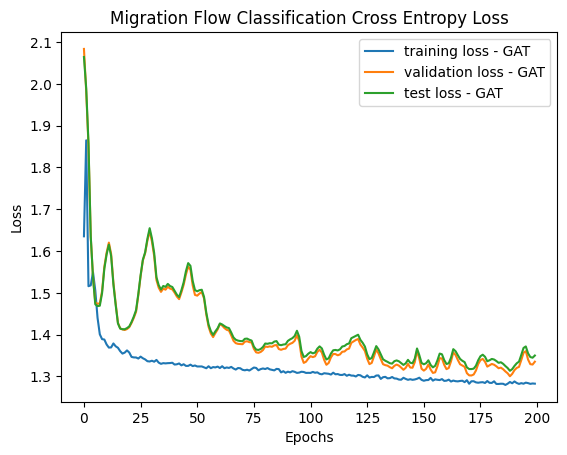

Running pipeline with config: Classification_GAT_simple_within_state


Training:   0%|          | 1/200 [00:00<01:01,  3.21Epochs/s]

Epoch 1: Training Loss 1.64411, Training F1 Score (Micro) 0.15879 Validation Loss 3.24338 Validation F1 Score (Micro) 0.4739


Training:   1%|          | 2/200 [00:00<01:03,  3.11Epochs/s]

Epoch 2: Training Loss 1.69809, Training F1 Score (Micro) 0.47388 Validation Loss 2.13281 Validation F1 Score (Micro) 0.13578


Training:   2%|▏         | 3/200 [00:00<01:04,  3.06Epochs/s]

Epoch 3: Training Loss 1.65142, Training F1 Score (Micro) 0.42627 Validation Loss 1.73122 Validation F1 Score (Micro) 0.13793


Training:   2%|▏         | 4/200 [00:01<01:02,  3.12Epochs/s]

Epoch 4: Training Loss 1.48388, Training F1 Score (Micro) 0.41626 Validation Loss 1.50289 Validation F1 Score (Micro) 0.46895


Training:   2%|▎         | 5/200 [00:01<01:02,  3.11Epochs/s]

Epoch 5: Training Loss 1.49151, Training F1 Score (Micro) 0.42093 Validation Loss 1.49656 Validation F1 Score (Micro) 0.47208


Training:   3%|▎         | 6/200 [00:01<01:01,  3.14Epochs/s]

Epoch 6: Training Loss 1.4851, Training F1 Score (Micro) 0.43216 Validation Loss 1.62878 Validation F1 Score (Micro) 0.46019


Training:   4%|▎         | 7/200 [00:02<01:00,  3.18Epochs/s]

Epoch 7: Training Loss 1.44797, Training F1 Score (Micro) 0.44731 Validation Loss 1.91462 Validation F1 Score (Micro) 0.44252


Training:   4%|▍         | 8/200 [00:02<01:00,  3.19Epochs/s]

Epoch 8: Training Loss 1.41663, Training F1 Score (Micro) 0.46241 Validation Loss 2.12776 Validation F1 Score (Micro) 0.18153


Training:   4%|▍         | 9/200 [00:02<01:00,  3.15Epochs/s]

Epoch 9: Training Loss 1.41362, Training F1 Score (Micro) 0.48023 Validation Loss 2.07358 Validation F1 Score (Micro) 0.1817


Training:   5%|▌         | 10/200 [00:03<00:59,  3.17Epochs/s]

Epoch 10: Training Loss 1.42009, Training F1 Score (Micro) 0.48039 Validation Loss 1.84643 Validation F1 Score (Micro) 0.39049


Training:   6%|▌         | 11/200 [00:03<00:59,  3.19Epochs/s]

Epoch 11: Training Loss 1.40068, Training F1 Score (Micro) 0.48445 Validation Loss 1.63879 Validation F1 Score (Micro) 0.47721


Training:   6%|▌         | 12/200 [00:03<00:59,  3.15Epochs/s]

Epoch 12: Training Loss 1.3884, Training F1 Score (Micro) 0.48794 Validation Loss 1.54014 Validation F1 Score (Micro) 0.47208


Training:   6%|▋         | 13/200 [00:04<00:59,  3.14Epochs/s]

Epoch 13: Training Loss 1.37287, Training F1 Score (Micro) 0.48141 Validation Loss 1.4974 Validation F1 Score (Micro) 0.47308


Training:   7%|▋         | 14/200 [00:04<00:58,  3.16Epochs/s]

Epoch 14: Training Loss 1.37568, Training F1 Score (Micro) 0.47603 Validation Loss 1.47766 Validation F1 Score (Micro) 0.47407


Training:   8%|▊         | 15/200 [00:04<00:59,  3.13Epochs/s]

Epoch 15: Training Loss 1.37809, Training F1 Score (Micro) 0.47638 Validation Loss 1.46176 Validation F1 Score (Micro) 0.47407


Training:   8%|▊         | 16/200 [00:05<00:59,  3.12Epochs/s]

Epoch 16: Training Loss 1.3774, Training F1 Score (Micro) 0.48084 Validation Loss 1.45843 Validation F1 Score (Micro) 0.47407


Training:   8%|▊         | 17/200 [00:05<00:58,  3.14Epochs/s]

Epoch 17: Training Loss 1.37228, Training F1 Score (Micro) 0.48266 Validation Loss 1.46749 Validation F1 Score (Micro) 0.47407


Training:   9%|▉         | 18/200 [00:05<00:58,  3.12Epochs/s]

Epoch 18: Training Loss 1.36038, Training F1 Score (Micro) 0.48436 Validation Loss 1.47755 Validation F1 Score (Micro) 0.47407


Training:  10%|▉         | 19/200 [00:06<00:57,  3.14Epochs/s]

Epoch 19: Training Loss 1.35306, Training F1 Score (Micro) 0.48735 Validation Loss 1.48947 Validation F1 Score (Micro) 0.47407


Training:  10%|█         | 20/200 [00:06<00:56,  3.16Epochs/s]

Epoch 20: Training Loss 1.3622, Training F1 Score (Micro) 0.48598 Validation Loss 1.48723 Validation F1 Score (Micro) 0.47407


Training:  10%|█         | 21/200 [00:06<00:58,  3.05Epochs/s]

Epoch 21: Training Loss 1.36532, Training F1 Score (Micro) 0.48641 Validation Loss 1.46354 Validation F1 Score (Micro) 0.47407


Training:  11%|█         | 22/200 [00:07<01:04,  2.74Epochs/s]

Epoch 22: Training Loss 1.35822, Training F1 Score (Micro) 0.48808 Validation Loss 1.43842 Validation F1 Score (Micro) 0.47407


Training:  12%|█▏        | 23/200 [00:07<01:06,  2.67Epochs/s]

Epoch 23: Training Loss 1.35951, Training F1 Score (Micro) 0.48542 Validation Loss 1.41865 Validation F1 Score (Micro) 0.47407


Training:  12%|█▏        | 24/200 [00:08<01:10,  2.50Epochs/s]

Epoch 24: Training Loss 1.35498, Training F1 Score (Micro) 0.48438 Validation Loss 1.40137 Validation F1 Score (Micro) 0.47407


Training:  12%|█▎        | 25/200 [00:08<01:12,  2.40Epochs/s]

Epoch 25: Training Loss 1.35574, Training F1 Score (Micro) 0.48129 Validation Loss 1.38874 Validation F1 Score (Micro) 0.47407


Training:  13%|█▎        | 26/200 [00:08<01:12,  2.39Epochs/s]

Epoch 26: Training Loss 1.34994, Training F1 Score (Micro) 0.48672 Validation Loss 1.38387 Validation F1 Score (Micro) 0.47407


Training:  14%|█▎        | 27/200 [00:09<01:12,  2.38Epochs/s]

Epoch 27: Training Loss 1.35225, Training F1 Score (Micro) 0.48735 Validation Loss 1.3821 Validation F1 Score (Micro) 0.47407


Training:  14%|█▍        | 28/200 [00:09<01:13,  2.35Epochs/s]

Epoch 28: Training Loss 1.35183, Training F1 Score (Micro) 0.48983 Validation Loss 1.38303 Validation F1 Score (Micro) 0.47407


Training:  14%|█▍        | 29/200 [00:10<01:14,  2.30Epochs/s]

Epoch 29: Training Loss 1.34596, Training F1 Score (Micro) 0.48693 Validation Loss 1.38402 Validation F1 Score (Micro) 0.47407


Training:  15%|█▌        | 30/200 [00:10<01:15,  2.27Epochs/s]

Epoch 30: Training Loss 1.34724, Training F1 Score (Micro) 0.48698 Validation Loss 1.38899 Validation F1 Score (Micro) 0.47407


Training:  16%|█▌        | 31/200 [00:11<01:12,  2.33Epochs/s]

Epoch 31: Training Loss 1.34659, Training F1 Score (Micro) 0.48766 Validation Loss 1.39762 Validation F1 Score (Micro) 0.47407


Training:  16%|█▌        | 32/200 [00:11<01:10,  2.39Epochs/s]

Epoch 32: Training Loss 1.3496, Training F1 Score (Micro) 0.48662 Validation Loss 1.41059 Validation F1 Score (Micro) 0.47407


Training:  16%|█▋        | 33/200 [00:11<01:10,  2.37Epochs/s]

Epoch 33: Training Loss 1.34878, Training F1 Score (Micro) 0.4845 Validation Loss 1.42584 Validation F1 Score (Micro) 0.47407


Training:  17%|█▋        | 34/200 [00:12<01:08,  2.43Epochs/s]

Epoch 34: Training Loss 1.34009, Training F1 Score (Micro) 0.48575 Validation Loss 1.43527 Validation F1 Score (Micro) 0.47407


Training:  18%|█▊        | 35/200 [00:12<01:02,  2.62Epochs/s]

Epoch 35: Training Loss 1.34261, Training F1 Score (Micro) 0.48936 Validation Loss 1.44757 Validation F1 Score (Micro) 0.47407


Training:  18%|█▊        | 36/200 [00:12<00:59,  2.78Epochs/s]

Epoch 36: Training Loss 1.34225, Training F1 Score (Micro) 0.48941 Validation Loss 1.46441 Validation F1 Score (Micro) 0.47407


Training:  18%|█▊        | 37/200 [00:13<00:56,  2.87Epochs/s]

Epoch 37: Training Loss 1.34544, Training F1 Score (Micro) 0.48674 Validation Loss 1.49811 Validation F1 Score (Micro) 0.47407


Training:  19%|█▉        | 38/200 [00:13<00:54,  2.97Epochs/s]

Epoch 38: Training Loss 1.34079, Training F1 Score (Micro) 0.48924 Validation Loss 1.56918 Validation F1 Score (Micro) 0.47407


Training:  20%|█▉        | 39/200 [00:13<00:53,  3.00Epochs/s]

Epoch 39: Training Loss 1.33926, Training F1 Score (Micro) 0.48636 Validation Loss 1.58628 Validation F1 Score (Micro) 0.47407


Training:  20%|██        | 40/200 [00:14<00:55,  2.88Epochs/s]

Epoch 40: Training Loss 1.34289, Training F1 Score (Micro) 0.48499 Validation Loss 1.59752 Validation F1 Score (Micro) 0.47407


Training:  20%|██        | 41/200 [00:14<00:56,  2.81Epochs/s]

Epoch 41: Training Loss 1.3394, Training F1 Score (Micro) 0.48853 Validation Loss 1.62866 Validation F1 Score (Micro) 0.47407


Training:  21%|██        | 42/200 [00:15<00:58,  2.69Epochs/s]

Epoch 42: Training Loss 1.33902, Training F1 Score (Micro) 0.48591 Validation Loss 1.64681 Validation F1 Score (Micro) 0.47407


Training:  22%|██▏       | 43/200 [00:15<01:00,  2.59Epochs/s]

Epoch 43: Training Loss 1.3382, Training F1 Score (Micro) 0.48856 Validation Loss 1.65331 Validation F1 Score (Micro) 0.47407


Training:  22%|██▏       | 44/200 [00:15<01:00,  2.57Epochs/s]

Epoch 44: Training Loss 1.33392, Training F1 Score (Micro) 0.48889 Validation Loss 1.64695 Validation F1 Score (Micro) 0.47407


Training:  22%|██▎       | 45/200 [00:16<01:00,  2.57Epochs/s]

Epoch 45: Training Loss 1.3358, Training F1 Score (Micro) 0.48237 Validation Loss 1.61199 Validation F1 Score (Micro) 0.47407


Training:  23%|██▎       | 46/200 [00:16<01:00,  2.56Epochs/s]

Epoch 46: Training Loss 1.3404, Training F1 Score (Micro) 0.48275 Validation Loss 1.566 Validation F1 Score (Micro) 0.47407


Training:  24%|██▎       | 47/200 [00:17<00:59,  2.56Epochs/s]

Epoch 47: Training Loss 1.33243, Training F1 Score (Micro) 0.48995 Validation Loss 1.52653 Validation F1 Score (Micro) 0.47407


Training:  24%|██▍       | 48/200 [00:17<00:59,  2.55Epochs/s]

Epoch 48: Training Loss 1.33655, Training F1 Score (Micro) 0.49042 Validation Loss 1.5026 Validation F1 Score (Micro) 0.47407


Training:  24%|██▍       | 49/200 [00:17<00:59,  2.56Epochs/s]

Epoch 49: Training Loss 1.33425, Training F1 Score (Micro) 0.49179 Validation Loss 1.50067 Validation F1 Score (Micro) 0.47407


Training:  25%|██▌       | 50/200 [00:18<00:58,  2.58Epochs/s]

Epoch 50: Training Loss 1.33243, Training F1 Score (Micro) 0.49186 Validation Loss 1.52379 Validation F1 Score (Micro) 0.47407


Training:  26%|██▌       | 51/200 [00:18<00:57,  2.58Epochs/s]

Epoch 51: Training Loss 1.33265, Training F1 Score (Micro) 0.49118 Validation Loss 1.56466 Validation F1 Score (Micro) 0.47407


Training:  26%|██▌       | 52/200 [00:18<00:56,  2.60Epochs/s]

Epoch 52: Training Loss 1.3318, Training F1 Score (Micro) 0.49214 Validation Loss 1.61195 Validation F1 Score (Micro) 0.47407


Training:  26%|██▋       | 53/200 [00:19<00:56,  2.60Epochs/s]

Epoch 53: Training Loss 1.33346, Training F1 Score (Micro) 0.49132 Validation Loss 1.65192 Validation F1 Score (Micro) 0.47407


Training:  27%|██▋       | 54/200 [00:19<00:56,  2.59Epochs/s]

Epoch 54: Training Loss 1.33027, Training F1 Score (Micro) 0.48969 Validation Loss 1.64336 Validation F1 Score (Micro) 0.47407


Training:  28%|██▊       | 55/200 [00:20<00:55,  2.59Epochs/s]

Epoch 55: Training Loss 1.33283, Training F1 Score (Micro) 0.48478 Validation Loss 1.61371 Validation F1 Score (Micro) 0.47407


Training:  28%|██▊       | 56/200 [00:20<00:55,  2.57Epochs/s]

Epoch 56: Training Loss 1.33396, Training F1 Score (Micro) 0.48749 Validation Loss 1.59807 Validation F1 Score (Micro) 0.47407


Training:  28%|██▊       | 57/200 [00:20<00:55,  2.56Epochs/s]

Epoch 57: Training Loss 1.33045, Training F1 Score (Micro) 0.48808 Validation Loss 1.58295 Validation F1 Score (Micro) 0.47407


Training:  29%|██▉       | 58/200 [00:21<00:54,  2.58Epochs/s]

Epoch 58: Training Loss 1.33085, Training F1 Score (Micro) 0.49066 Validation Loss 1.58804 Validation F1 Score (Micro) 0.47407


Training:  30%|██▉       | 59/200 [00:21<00:55,  2.56Epochs/s]

Epoch 59: Training Loss 1.32907, Training F1 Score (Micro) 0.49358 Validation Loss 1.60149 Validation F1 Score (Micro) 0.47407


Training:  30%|███       | 60/200 [00:22<00:54,  2.56Epochs/s]

Epoch 60: Training Loss 1.32764, Training F1 Score (Micro) 0.49276 Validation Loss 1.62523 Validation F1 Score (Micro) 0.47407


Training:  30%|███       | 61/200 [00:22<00:57,  2.44Epochs/s]

Epoch 61: Training Loss 1.33144, Training F1 Score (Micro) 0.49306 Validation Loss 1.6729 Validation F1 Score (Micro) 0.47407


Training:  31%|███       | 62/200 [00:22<00:58,  2.35Epochs/s]

Epoch 62: Training Loss 1.33293, Training F1 Score (Micro) 0.49379 Validation Loss 1.75748 Validation F1 Score (Micro) 0.47407


Training:  32%|███▏      | 63/200 [00:23<00:58,  2.33Epochs/s]

Epoch 63: Training Loss 1.33108, Training F1 Score (Micro) 0.49085 Validation Loss 1.89493 Validation F1 Score (Micro) 0.47407


Training:  32%|███▏      | 64/200 [00:23<00:59,  2.28Epochs/s]

Epoch 64: Training Loss 1.33035, Training F1 Score (Micro) 0.48631 Validation Loss 1.95176 Validation F1 Score (Micro) 0.47407


Training:  32%|███▎      | 65/200 [00:24<00:59,  2.29Epochs/s]

Epoch 65: Training Loss 1.32823, Training F1 Score (Micro) 0.49018 Validation Loss 1.89238 Validation F1 Score (Micro) 0.47407


Training:  33%|███▎      | 66/200 [00:24<00:59,  2.27Epochs/s]

Epoch 66: Training Loss 1.32707, Training F1 Score (Micro) 0.48924 Validation Loss 1.83174 Validation F1 Score (Micro) 0.47407


Training:  34%|███▎      | 67/200 [00:25<00:59,  2.25Epochs/s]

Epoch 67: Training Loss 1.32912, Training F1 Score (Micro) 0.48926 Validation Loss 1.79352 Validation F1 Score (Micro) 0.47407


Training:  34%|███▍      | 68/200 [00:25<00:58,  2.27Epochs/s]

Epoch 68: Training Loss 1.32531, Training F1 Score (Micro) 0.49188 Validation Loss 1.76016 Validation F1 Score (Micro) 0.47407


Training:  34%|███▍      | 69/200 [00:26<00:57,  2.26Epochs/s]

Epoch 69: Training Loss 1.32921, Training F1 Score (Micro) 0.49231 Validation Loss 1.79274 Validation F1 Score (Micro) 0.47407


Training:  35%|███▌      | 70/200 [00:26<00:57,  2.27Epochs/s]

Epoch 70: Training Loss 1.32577, Training F1 Score (Micro) 0.49 Validation Loss 1.79858 Validation F1 Score (Micro) 0.47407


Training:  36%|███▌      | 71/200 [00:26<00:56,  2.28Epochs/s]

Epoch 71: Training Loss 1.32737, Training F1 Score (Micro) 0.48893 Validation Loss 1.73774 Validation F1 Score (Micro) 0.47407


Training:  36%|███▌      | 72/200 [00:27<00:55,  2.31Epochs/s]

Epoch 72: Training Loss 1.32426, Training F1 Score (Micro) 0.4933 Validation Loss 1.7202 Validation F1 Score (Micro) 0.47407


Training:  36%|███▋      | 73/200 [00:27<00:54,  2.33Epochs/s]

Epoch 73: Training Loss 1.3263, Training F1 Score (Micro) 0.49344 Validation Loss 1.77768 Validation F1 Score (Micro) 0.47407


Training:  37%|███▋      | 74/200 [00:28<00:52,  2.41Epochs/s]

Epoch 74: Training Loss 1.32578, Training F1 Score (Micro) 0.49346 Validation Loss 1.87879 Validation F1 Score (Micro) 0.47407


Training:  38%|███▊      | 75/200 [00:28<00:48,  2.57Epochs/s]

Epoch 75: Training Loss 1.32521, Training F1 Score (Micro) 0.49021 Validation Loss 1.99124 Validation F1 Score (Micro) 0.47407


Training:  38%|███▊      | 76/200 [00:28<00:46,  2.69Epochs/s]

Epoch 76: Training Loss 1.32833, Training F1 Score (Micro) 0.48877 Validation Loss 2.0479 Validation F1 Score (Micro) 0.47407


Training:  38%|███▊      | 77/200 [00:29<00:44,  2.78Epochs/s]

Epoch 77: Training Loss 1.32479, Training F1 Score (Micro) 0.49179 Validation Loss 2.09012 Validation F1 Score (Micro) 0.47407


Training:  39%|███▉      | 78/200 [00:29<00:42,  2.86Epochs/s]

Epoch 78: Training Loss 1.32672, Training F1 Score (Micro) 0.48882 Validation Loss 2.21039 Validation F1 Score (Micro) 0.47407


Training:  40%|███▉      | 79/200 [00:29<00:41,  2.92Epochs/s]

Epoch 79: Training Loss 1.32989, Training F1 Score (Micro) 0.49077 Validation Loss 2.24179 Validation F1 Score (Micro) 0.47407


Training:  40%|████      | 80/200 [00:30<00:41,  2.91Epochs/s]

Epoch 80: Training Loss 1.32584, Training F1 Score (Micro) 0.49115 Validation Loss 2.42218 Validation F1 Score (Micro) 0.47407


Training:  40%|████      | 81/200 [00:30<00:39,  2.98Epochs/s]

Epoch 81: Training Loss 1.32566, Training F1 Score (Micro) 0.49379 Validation Loss 2.54847 Validation F1 Score (Micro) 0.47407


Training:  41%|████      | 82/200 [00:30<00:39,  2.99Epochs/s]

Epoch 82: Training Loss 1.32226, Training F1 Score (Micro) 0.48919 Validation Loss 2.42317 Validation F1 Score (Micro) 0.47407


Training:  42%|████▏     | 83/200 [00:31<00:39,  3.00Epochs/s]

Epoch 83: Training Loss 1.32344, Training F1 Score (Micro) 0.49153 Validation Loss 2.21219 Validation F1 Score (Micro) 0.47407


Training:  42%|████▏     | 84/200 [00:31<00:38,  3.03Epochs/s]

Epoch 84: Training Loss 1.32469, Training F1 Score (Micro) 0.49342 Validation Loss 2.18109 Validation F1 Score (Micro) 0.47407


Training:  42%|████▎     | 85/200 [00:31<00:37,  3.04Epochs/s]

Epoch 85: Training Loss 1.32223, Training F1 Score (Micro) 0.49337 Validation Loss 2.29093 Validation F1 Score (Micro) 0.47407


Training:  43%|████▎     | 86/200 [00:32<00:37,  3.02Epochs/s]

Epoch 86: Training Loss 1.32114, Training F1 Score (Micro) 0.49311 Validation Loss 2.63659 Validation F1 Score (Micro) 0.47407


Training:  44%|████▎     | 87/200 [00:32<00:38,  2.97Epochs/s]

Epoch 87: Training Loss 1.32334, Training F1 Score (Micro) 0.49214 Validation Loss 2.81332 Validation F1 Score (Micro) 0.47407


Training:  44%|████▍     | 88/200 [00:32<00:37,  3.00Epochs/s]

Epoch 88: Training Loss 1.32486, Training F1 Score (Micro) 0.48839 Validation Loss 2.33961 Validation F1 Score (Micro) 0.47407


Training:  44%|████▍     | 89/200 [00:33<00:36,  3.02Epochs/s]

Epoch 89: Training Loss 1.32191, Training F1 Score (Micro) 0.49422 Validation Loss 2.03905 Validation F1 Score (Micro) 0.47407


Training:  45%|████▌     | 90/200 [00:33<00:35,  3.06Epochs/s]

Epoch 90: Training Loss 1.32452, Training F1 Score (Micro) 0.49554 Validation Loss 2.07822 Validation F1 Score (Micro) 0.47407


Training:  46%|████▌     | 91/200 [00:33<00:35,  3.09Epochs/s]

Epoch 91: Training Loss 1.32268, Training F1 Score (Micro) 0.49514 Validation Loss 2.25781 Validation F1 Score (Micro) 0.47407


Training:  46%|████▌     | 92/200 [00:34<00:35,  3.05Epochs/s]

Epoch 92: Training Loss 1.32471, Training F1 Score (Micro) 0.48882 Validation Loss 2.27299 Validation F1 Score (Micro) 0.47407


Training:  46%|████▋     | 93/200 [00:34<00:35,  3.03Epochs/s]

Epoch 93: Training Loss 1.32242, Training F1 Score (Micro) 0.49063 Validation Loss 2.17766 Validation F1 Score (Micro) 0.47407


Training:  47%|████▋     | 94/200 [00:34<00:35,  3.03Epochs/s]

Epoch 94: Training Loss 1.32217, Training F1 Score (Micro) 0.49665 Validation Loss 2.09015 Validation F1 Score (Micro) 0.47407


Training:  48%|████▊     | 95/200 [00:35<00:34,  3.07Epochs/s]

Epoch 95: Training Loss 1.32309, Training F1 Score (Micro) 0.49252 Validation Loss 2.01528 Validation F1 Score (Micro) 0.47407


Training:  48%|████▊     | 96/200 [00:35<00:33,  3.08Epochs/s]

Epoch 96: Training Loss 1.32361, Training F1 Score (Micro) 0.49658 Validation Loss 1.99351 Validation F1 Score (Micro) 0.47407


Training:  48%|████▊     | 97/200 [00:35<00:33,  3.03Epochs/s]

Epoch 97: Training Loss 1.32266, Training F1 Score (Micro) 0.48955 Validation Loss 1.95721 Validation F1 Score (Micro) 0.47407


Training:  49%|████▉     | 98/200 [00:36<00:33,  3.02Epochs/s]

Epoch 98: Training Loss 1.32101, Training F1 Score (Micro) 0.4933 Validation Loss 1.87711 Validation F1 Score (Micro) 0.47407


Training:  50%|████▉     | 99/200 [00:36<00:33,  3.01Epochs/s]

Epoch 99: Training Loss 1.32003, Training F1 Score (Micro) 0.49526 Validation Loss 1.89514 Validation F1 Score (Micro) 0.47407


Training:  50%|█████     | 100/200 [00:36<00:32,  3.06Epochs/s]

Epoch 100: Training Loss 1.31721, Training F1 Score (Micro) 0.49526 Validation Loss 1.92966 Validation F1 Score (Micro) 0.47407


Training:  50%|█████     | 101/200 [00:37<00:32,  3.09Epochs/s]

Epoch 101: Training Loss 1.32291, Training F1 Score (Micro) 0.49438 Validation Loss 1.98444 Validation F1 Score (Micro) 0.47407


Training:  51%|█████     | 102/200 [00:37<00:32,  3.06Epochs/s]

Epoch 102: Training Loss 1.32135, Training F1 Score (Micro) 0.49118 Validation Loss 2.02371 Validation F1 Score (Micro) 0.47407


Training:  52%|█████▏    | 103/200 [00:37<00:31,  3.07Epochs/s]

Epoch 103: Training Loss 1.31933, Training F1 Score (Micro) 0.49339 Validation Loss 1.93536 Validation F1 Score (Micro) 0.47407


Training:  52%|█████▏    | 104/200 [00:38<00:31,  3.02Epochs/s]

Epoch 104: Training Loss 1.31702, Training F1 Score (Micro) 0.49698 Validation Loss 1.86544 Validation F1 Score (Micro) 0.47407


Training:  52%|█████▎    | 105/200 [00:38<00:34,  2.72Epochs/s]

Epoch 105: Training Loss 1.31968, Training F1 Score (Micro) 0.49127 Validation Loss 1.73987 Validation F1 Score (Micro) 0.47407


Training:  53%|█████▎    | 106/200 [00:38<00:35,  2.65Epochs/s]

Epoch 106: Training Loss 1.31909, Training F1 Score (Micro) 0.49299 Validation Loss 1.61666 Validation F1 Score (Micro) 0.47407


Training:  54%|█████▎    | 107/200 [00:39<00:35,  2.60Epochs/s]

Epoch 107: Training Loss 1.31923, Training F1 Score (Micro) 0.49667 Validation Loss 1.63013 Validation F1 Score (Micro) 0.47407


Training:  54%|█████▍    | 108/200 [00:39<00:37,  2.48Epochs/s]

Epoch 108: Training Loss 1.3136, Training F1 Score (Micro) 0.49691 Validation Loss 1.70226 Validation F1 Score (Micro) 0.47407


Training:  55%|█████▍    | 109/200 [00:40<00:37,  2.40Epochs/s]

Epoch 109: Training Loss 1.3152, Training F1 Score (Micro) 0.49691 Validation Loss 1.86741 Validation F1 Score (Micro) 0.47407


Training:  55%|█████▌    | 110/200 [00:40<00:38,  2.37Epochs/s]

Epoch 110: Training Loss 1.31493, Training F1 Score (Micro) 0.4967 Validation Loss 1.96074 Validation F1 Score (Micro) 0.47407


Training:  56%|█████▌    | 111/200 [00:41<00:37,  2.38Epochs/s]

Epoch 111: Training Loss 1.31871, Training F1 Score (Micro) 0.49285 Validation Loss 2.03456 Validation F1 Score (Micro) 0.47407


Training:  56%|█████▌    | 112/200 [00:41<00:38,  2.31Epochs/s]

Epoch 112: Training Loss 1.31705, Training F1 Score (Micro) 0.49568 Validation Loss 2.05097 Validation F1 Score (Micro) 0.47407


Training:  56%|█████▋    | 113/200 [00:41<00:37,  2.31Epochs/s]

Epoch 113: Training Loss 1.31527, Training F1 Score (Micro) 0.49715 Validation Loss 2.21232 Validation F1 Score (Micro) 0.47407


Training:  57%|█████▋    | 114/200 [00:42<00:36,  2.37Epochs/s]

Epoch 114: Training Loss 1.3156, Training F1 Score (Micro) 0.49724 Validation Loss 2.39816 Validation F1 Score (Micro) 0.47407


Training:  57%|█████▊    | 115/200 [00:42<00:36,  2.31Epochs/s]

Epoch 115: Training Loss 1.31505, Training F1 Score (Micro) 0.49608 Validation Loss 2.74189 Validation F1 Score (Micro) 0.47407


Training:  58%|█████▊    | 116/200 [00:43<00:35,  2.36Epochs/s]

Epoch 116: Training Loss 1.3142, Training F1 Score (Micro) 0.49644 Validation Loss 2.97384 Validation F1 Score (Micro) 0.47407


Training:  58%|█████▊    | 117/200 [00:43<00:33,  2.47Epochs/s]

Epoch 117: Training Loss 1.31707, Training F1 Score (Micro) 0.49181 Validation Loss 2.80718 Validation F1 Score (Micro) 0.47407


Training:  59%|█████▉    | 118/200 [00:43<00:31,  2.61Epochs/s]

Epoch 118: Training Loss 1.31404, Training F1 Score (Micro) 0.49578 Validation Loss 2.70888 Validation F1 Score (Micro) 0.47407


Training:  60%|█████▉    | 119/200 [00:44<00:29,  2.75Epochs/s]

Epoch 119: Training Loss 1.31956, Training F1 Score (Micro) 0.49453 Validation Loss 2.94972 Validation F1 Score (Micro) 0.47407


Training:  60%|██████    | 120/200 [00:44<00:28,  2.85Epochs/s]

Epoch 120: Training Loss 1.31164, Training F1 Score (Micro) 0.49589 Validation Loss 3.72829 Validation F1 Score (Micro) 0.47407


Training:  60%|██████    | 121/200 [00:44<00:27,  2.87Epochs/s]

Epoch 121: Training Loss 1.31231, Training F1 Score (Micro) 0.4911 Validation Loss 3.65565 Validation F1 Score (Micro) 0.47407


Training:  61%|██████    | 122/200 [00:45<00:26,  2.96Epochs/s]

Epoch 122: Training Loss 1.31291, Training F1 Score (Micro) 0.49568 Validation Loss 3.56748 Validation F1 Score (Micro) 0.47407


Training:  62%|██████▏   | 123/200 [00:45<00:25,  2.97Epochs/s]

Epoch 123: Training Loss 1.3134, Training F1 Score (Micro) 0.49363 Validation Loss 3.47689 Validation F1 Score (Micro) 0.47407


Training:  62%|██████▏   | 124/200 [00:45<00:25,  2.94Epochs/s]

Epoch 124: Training Loss 1.31415, Training F1 Score (Micro) 0.49625 Validation Loss 3.32617 Validation F1 Score (Micro) 0.47407


Training:  62%|██████▎   | 125/200 [00:46<00:25,  2.99Epochs/s]

Epoch 125: Training Loss 1.31608, Training F1 Score (Micro) 0.49549 Validation Loss 3.32248 Validation F1 Score (Micro) 0.47407


Training:  63%|██████▎   | 126/200 [00:46<00:24,  3.03Epochs/s]

Epoch 126: Training Loss 1.30931, Training F1 Score (Micro) 0.49731 Validation Loss 3.43754 Validation F1 Score (Micro) 0.47407


Training:  64%|██████▎   | 127/200 [00:46<00:24,  3.03Epochs/s]

Epoch 127: Training Loss 1.31028, Training F1 Score (Micro) 0.4966 Validation Loss 3.32527 Validation F1 Score (Micro) 0.47407


Training:  64%|██████▍   | 128/200 [00:47<00:23,  3.07Epochs/s]

Epoch 128: Training Loss 1.31254, Training F1 Score (Micro) 0.49384 Validation Loss 3.05527 Validation F1 Score (Micro) 0.47407


Training:  64%|██████▍   | 129/200 [00:47<00:22,  3.10Epochs/s]

Epoch 129: Training Loss 1.31018, Training F1 Score (Micro) 0.49759 Validation Loss 2.94743 Validation F1 Score (Micro) 0.47407


Training:  65%|██████▌   | 130/200 [00:47<00:22,  3.12Epochs/s]

Epoch 130: Training Loss 1.31094, Training F1 Score (Micro) 0.49733 Validation Loss 3.07887 Validation F1 Score (Micro) 0.47407


Training:  66%|██████▌   | 131/200 [00:48<00:22,  3.07Epochs/s]

Epoch 131: Training Loss 1.31002, Training F1 Score (Micro) 0.49505 Validation Loss 3.22193 Validation F1 Score (Micro) 0.47407


Training:  66%|██████▌   | 132/200 [00:48<00:21,  3.10Epochs/s]

Epoch 132: Training Loss 1.31086, Training F1 Score (Micro) 0.49467 Validation Loss 3.15505 Validation F1 Score (Micro) 0.47407


Training:  66%|██████▋   | 133/200 [00:48<00:21,  3.11Epochs/s]

Epoch 133: Training Loss 1.30904, Training F1 Score (Micro) 0.49585 Validation Loss 2.74601 Validation F1 Score (Micro) 0.47407


Training:  67%|██████▋   | 134/200 [00:49<00:21,  3.10Epochs/s]

Epoch 134: Training Loss 1.31199, Training F1 Score (Micro) 0.4996 Validation Loss 2.59363 Validation F1 Score (Micro) 0.47407


Training:  68%|██████▊   | 135/200 [00:49<00:20,  3.13Epochs/s]

Epoch 135: Training Loss 1.30975, Training F1 Score (Micro) 0.4967 Validation Loss 2.94273 Validation F1 Score (Micro) 0.47407


Training:  68%|██████▊   | 136/200 [00:49<00:20,  3.14Epochs/s]

Epoch 136: Training Loss 1.30705, Training F1 Score (Micro) 0.49604 Validation Loss 3.1232 Validation F1 Score (Micro) 0.47407


Training:  68%|██████▊   | 137/200 [00:50<00:20,  3.09Epochs/s]

Epoch 137: Training Loss 1.30916, Training F1 Score (Micro) 0.49915 Validation Loss 3.24083 Validation F1 Score (Micro) 0.47407


Training:  69%|██████▉   | 138/200 [00:50<00:19,  3.10Epochs/s]

Epoch 138: Training Loss 1.31344, Training F1 Score (Micro) 0.49125 Validation Loss 2.69999 Validation F1 Score (Micro) 0.47407


Training:  70%|██████▉   | 139/200 [00:50<00:19,  3.12Epochs/s]

Epoch 139: Training Loss 1.31052, Training F1 Score (Micro) 0.50054 Validation Loss 2.31373 Validation F1 Score (Micro) 0.47407


Training:  70%|███████   | 140/200 [00:51<00:19,  3.10Epochs/s]

Epoch 140: Training Loss 1.31153, Training F1 Score (Micro) 0.49512 Validation Loss 2.51358 Validation F1 Score (Micro) 0.47407


Training:  70%|███████   | 141/200 [00:51<00:19,  3.10Epochs/s]

Epoch 141: Training Loss 1.31024, Training F1 Score (Micro) 0.49561 Validation Loss 2.98844 Validation F1 Score (Micro) 0.47407


Training:  71%|███████   | 142/200 [00:51<00:18,  3.09Epochs/s]

Epoch 142: Training Loss 1.31056, Training F1 Score (Micro) 0.4937 Validation Loss 2.90157 Validation F1 Score (Micro) 0.47407


Training:  72%|███████▏  | 143/200 [00:51<00:18,  3.09Epochs/s]

Epoch 143: Training Loss 1.3111, Training F1 Score (Micro) 0.49625 Validation Loss 2.43727 Validation F1 Score (Micro) 0.47407


Training:  72%|███████▏  | 144/200 [00:52<00:18,  3.11Epochs/s]

Epoch 144: Training Loss 1.30957, Training F1 Score (Micro) 0.50267 Validation Loss 2.00436 Validation F1 Score (Micro) 0.47407


Training:  72%|███████▎  | 145/200 [00:52<00:17,  3.11Epochs/s]

Epoch 145: Training Loss 1.30724, Training F1 Score (Micro) 0.50352 Validation Loss 1.96458 Validation F1 Score (Micro) 0.47407


Training:  73%|███████▎  | 146/200 [00:52<00:17,  3.07Epochs/s]

Epoch 146: Training Loss 1.30696, Training F1 Score (Micro) 0.49858 Validation Loss 2.09356 Validation F1 Score (Micro) 0.47407


Training:  74%|███████▎  | 147/200 [00:53<00:17,  3.03Epochs/s]

Epoch 147: Training Loss 1.307, Training F1 Score (Micro) 0.49854 Validation Loss 2.4254 Validation F1 Score (Micro) 0.47407


Training:  74%|███████▍  | 148/200 [00:53<00:19,  2.70Epochs/s]

Epoch 148: Training Loss 1.30636, Training F1 Score (Micro) 0.49771 Validation Loss 2.44881 Validation F1 Score (Micro) 0.47407


Training:  74%|███████▍  | 149/200 [00:54<00:20,  2.55Epochs/s]

Epoch 149: Training Loss 1.31338, Training F1 Score (Micro) 0.49733 Validation Loss 2.37706 Validation F1 Score (Micro) 0.47407


Training:  75%|███████▌  | 150/200 [00:54<00:19,  2.51Epochs/s]

Epoch 150: Training Loss 1.31686, Training F1 Score (Micro) 0.49943 Validation Loss 2.50642 Validation F1 Score (Micro) 0.47407


Training:  76%|███████▌  | 151/200 [00:55<00:20,  2.45Epochs/s]

Epoch 151: Training Loss 1.30612, Training F1 Score (Micro) 0.49941 Validation Loss 2.48275 Validation F1 Score (Micro) 0.47407


Training:  76%|███████▌  | 152/200 [00:55<00:19,  2.43Epochs/s]

Epoch 152: Training Loss 1.30535, Training F1 Score (Micro) 0.50215 Validation Loss 2.49055 Validation F1 Score (Micro) 0.47407


Training:  76%|███████▋  | 153/200 [00:55<00:19,  2.44Epochs/s]

Epoch 153: Training Loss 1.30448, Training F1 Score (Micro) 0.49908 Validation Loss 2.54849 Validation F1 Score (Micro) 0.47407


Training:  77%|███████▋  | 154/200 [00:56<00:19,  2.41Epochs/s]

Epoch 154: Training Loss 1.31706, Training F1 Score (Micro) 0.4954 Validation Loss 2.40162 Validation F1 Score (Micro) 0.47407


Training:  78%|███████▊  | 155/200 [00:56<00:18,  2.38Epochs/s]

Epoch 155: Training Loss 1.30435, Training F1 Score (Micro) 0.50031 Validation Loss 2.46787 Validation F1 Score (Micro) 0.47407


Training:  78%|███████▊  | 156/200 [00:57<00:18,  2.34Epochs/s]

Epoch 156: Training Loss 1.30494, Training F1 Score (Micro) 0.49932 Validation Loss 2.58482 Validation F1 Score (Micro) 0.47407


Training:  78%|███████▊  | 157/200 [00:57<00:18,  2.32Epochs/s]

Epoch 157: Training Loss 1.30855, Training F1 Score (Micro) 0.50066 Validation Loss 2.77902 Validation F1 Score (Micro) 0.47407


Training:  79%|███████▉  | 158/200 [00:58<00:17,  2.34Epochs/s]

Epoch 158: Training Loss 1.30771, Training F1 Score (Micro) 0.4996 Validation Loss 2.90076 Validation F1 Score (Micro) 0.47407


Training:  80%|███████▉  | 159/200 [00:58<00:16,  2.49Epochs/s]

Epoch 159: Training Loss 1.30595, Training F1 Score (Micro) 0.49691 Validation Loss 2.62338 Validation F1 Score (Micro) 0.47407


Training:  80%|████████  | 160/200 [00:58<00:14,  2.68Epochs/s]

Epoch 160: Training Loss 1.30508, Training F1 Score (Micro) 0.49762 Validation Loss 2.1183 Validation F1 Score (Micro) 0.47407


Training:  80%|████████  | 161/200 [00:59<00:13,  2.80Epochs/s]

Epoch 161: Training Loss 1.30582, Training F1 Score (Micro) 0.49811 Validation Loss 1.85547 Validation F1 Score (Micro) 0.47407


Training:  81%|████████  | 162/200 [00:59<00:13,  2.88Epochs/s]

Epoch 162: Training Loss 1.30647, Training F1 Score (Micro) 0.50281 Validation Loss 1.83615 Validation F1 Score (Micro) 0.47407


Training:  82%|████████▏ | 163/200 [00:59<00:12,  2.97Epochs/s]

Epoch 163: Training Loss 1.30335, Training F1 Score (Micro) 0.49986 Validation Loss 1.92857 Validation F1 Score (Micro) 0.47407


Training:  82%|████████▏ | 164/200 [00:59<00:11,  3.02Epochs/s]

Epoch 164: Training Loss 1.30611, Training F1 Score (Micro) 0.49615 Validation Loss 1.81596 Validation F1 Score (Micro) 0.47407


Training:  82%|████████▎ | 165/200 [01:00<00:11,  3.05Epochs/s]

Epoch 165: Training Loss 1.31406, Training F1 Score (Micro) 0.49797 Validation Loss 1.65979 Validation F1 Score (Micro) 0.47407


Training:  83%|████████▎ | 166/200 [01:00<00:11,  3.06Epochs/s]

Epoch 166: Training Loss 1.31674, Training F1 Score (Micro) 0.50083 Validation Loss 1.63392 Validation F1 Score (Micro) 0.47407


Training:  84%|████████▎ | 167/200 [01:00<00:10,  3.09Epochs/s]

Epoch 167: Training Loss 1.30368, Training F1 Score (Micro) 0.50309 Validation Loss 1.65131 Validation F1 Score (Micro) 0.47407


Training:  84%|████████▍ | 168/200 [01:01<00:10,  3.15Epochs/s]

Epoch 168: Training Loss 1.30194, Training F1 Score (Micro) 0.50054 Validation Loss 1.68144 Validation F1 Score (Micro) 0.47407


Training:  84%|████████▍ | 169/200 [01:01<00:09,  3.11Epochs/s]

Epoch 169: Training Loss 1.31796, Training F1 Score (Micro) 0.49575 Validation Loss 1.6093 Validation F1 Score (Micro) 0.47407


Training:  85%|████████▌ | 170/200 [01:01<00:09,  3.06Epochs/s]

Epoch 170: Training Loss 1.3027, Training F1 Score (Micro) 0.50177 Validation Loss 1.67691 Validation F1 Score (Micro) 0.47407


Training:  86%|████████▌ | 171/200 [01:02<00:09,  3.10Epochs/s]

Epoch 171: Training Loss 1.30807, Training F1 Score (Micro) 0.49927 Validation Loss 1.88191 Validation F1 Score (Micro) 0.47407


Training:  86%|████████▌ | 172/200 [01:02<00:09,  3.10Epochs/s]

Epoch 172: Training Loss 1.31292, Training F1 Score (Micro) 0.49483 Validation Loss 2.12954 Validation F1 Score (Micro) 0.47407


Training:  86%|████████▋ | 173/200 [01:02<00:08,  3.11Epochs/s]

Epoch 173: Training Loss 1.30861, Training F1 Score (Micro) 0.49861 Validation Loss 2.27107 Validation F1 Score (Micro) 0.47407


Training:  87%|████████▋ | 174/200 [01:03<00:08,  3.14Epochs/s]

Epoch 174: Training Loss 1.30771, Training F1 Score (Micro) 0.49252 Validation Loss 2.04199 Validation F1 Score (Micro) 0.47407


Training:  88%|████████▊ | 175/200 [01:03<00:08,  3.12Epochs/s]

Epoch 175: Training Loss 1.30415, Training F1 Score (Micro) 0.49429 Validation Loss 1.64463 Validation F1 Score (Micro) 0.47407


Training:  88%|████████▊ | 176/200 [01:03<00:07,  3.15Epochs/s]

Epoch 176: Training Loss 1.30625, Training F1 Score (Micro) 0.497 Validation Loss 1.43385 Validation F1 Score (Micro) 0.47836


Training:  88%|████████▊ | 177/200 [01:04<00:07,  3.18Epochs/s]

Epoch 177: Training Loss 1.30583, Training F1 Score (Micro) 0.50038 Validation Loss 1.42477 Validation F1 Score (Micro) 0.47836


Training:  89%|████████▉ | 178/200 [01:04<00:06,  3.16Epochs/s]

Epoch 178: Training Loss 1.31004, Training F1 Score (Micro) 0.49851 Validation Loss 1.53591 Validation F1 Score (Micro) 0.47407


Training:  90%|████████▉ | 179/200 [01:04<00:07,  2.69Epochs/s]

Epoch 179: Training Loss 1.30601, Training F1 Score (Micro) 0.50139 Validation Loss 1.75471 Validation F1 Score (Micro) 0.47407


Training:  90%|█████████ | 180/200 [01:05<00:07,  2.77Epochs/s]

Epoch 180: Training Loss 1.30313, Training F1 Score (Micro) 0.5004 Validation Loss 1.89849 Validation F1 Score (Micro) 0.47407


Training:  90%|█████████ | 181/200 [01:05<00:06,  2.83Epochs/s]

Epoch 181: Training Loss 1.30332, Training F1 Score (Micro) 0.49467 Validation Loss 1.87517 Validation F1 Score (Micro) 0.47407


Training:  91%|█████████ | 182/200 [01:05<00:06,  2.91Epochs/s]

Epoch 182: Training Loss 1.30285, Training F1 Score (Micro) 0.49899 Validation Loss 1.77034 Validation F1 Score (Micro) 0.47407


Training:  92%|█████████▏| 183/200 [01:06<00:05,  2.97Epochs/s]

Epoch 183: Training Loss 1.30424, Training F1 Score (Micro) 0.50177 Validation Loss 1.72845 Validation F1 Score (Micro) 0.47407


Training:  92%|█████████▏| 184/200 [01:06<00:05,  3.01Epochs/s]

Epoch 184: Training Loss 1.30102, Training F1 Score (Micro) 0.50429 Validation Loss 1.71703 Validation F1 Score (Micro) 0.47407


Training:  92%|█████████▎| 185/200 [01:06<00:04,  3.05Epochs/s]

Epoch 185: Training Loss 1.30295, Training F1 Score (Micro) 0.50139 Validation Loss 1.76963 Validation F1 Score (Micro) 0.47407


Training:  93%|█████████▎| 186/200 [01:07<00:04,  3.12Epochs/s]

Epoch 186: Training Loss 1.30873, Training F1 Score (Micro) 0.49924 Validation Loss 1.73707 Validation F1 Score (Micro) 0.47407


Training:  94%|█████████▎| 187/200 [01:07<00:04,  3.13Epochs/s]

Epoch 187: Training Loss 1.29839, Training F1 Score (Micro) 0.50472 Validation Loss 1.76429 Validation F1 Score (Micro) 0.47407


Training:  94%|█████████▍| 188/200 [01:07<00:03,  3.07Epochs/s]

Epoch 188: Training Loss 1.30052, Training F1 Score (Micro) 0.5038 Validation Loss 1.8247 Validation F1 Score (Micro) 0.47407


Training:  94%|█████████▍| 189/200 [01:08<00:03,  2.89Epochs/s]

Epoch 189: Training Loss 1.30175, Training F1 Score (Micro) 0.49908 Validation Loss 1.88551 Validation F1 Score (Micro) 0.47407


Training:  95%|█████████▌| 190/200 [01:08<00:03,  2.67Epochs/s]

Epoch 190: Training Loss 1.29944, Training F1 Score (Micro) 0.50302 Validation Loss 1.97301 Validation F1 Score (Micro) 0.47407


Training:  96%|█████████▌| 191/200 [01:09<00:03,  2.62Epochs/s]

Epoch 191: Training Loss 1.30151, Training F1 Score (Micro) 0.50061 Validation Loss 2.03057 Validation F1 Score (Micro) 0.47407


Training:  96%|█████████▌| 192/200 [01:09<00:03,  2.60Epochs/s]

Epoch 192: Training Loss 1.3048, Training F1 Score (Micro) 0.49656 Validation Loss 1.97235 Validation F1 Score (Micro) 0.47407


Training:  96%|█████████▋| 193/200 [01:09<00:02,  2.49Epochs/s]

Epoch 193: Training Loss 1.3011, Training F1 Score (Micro) 0.50186 Validation Loss 1.98663 Validation F1 Score (Micro) 0.47407


Training:  97%|█████████▋| 194/200 [01:10<00:02,  2.50Epochs/s]

Epoch 194: Training Loss 1.2987, Training F1 Score (Micro) 0.50101 Validation Loss 2.01774 Validation F1 Score (Micro) 0.47407


Training:  98%|█████████▊| 195/200 [01:10<00:02,  2.47Epochs/s]

Epoch 195: Training Loss 1.30101, Training F1 Score (Micro) 0.50144 Validation Loss 2.09883 Validation F1 Score (Micro) 0.47407


Training:  98%|█████████▊| 196/200 [01:11<00:01,  2.47Epochs/s]

Epoch 196: Training Loss 1.29632, Training F1 Score (Micro) 0.50403 Validation Loss 2.14487 Validation F1 Score (Micro) 0.47407


Training:  98%|█████████▊| 197/200 [01:11<00:01,  2.45Epochs/s]

Epoch 197: Training Loss 1.29876, Training F1 Score (Micro) 0.50295 Validation Loss 2.20767 Validation F1 Score (Micro) 0.47407


Training:  99%|█████████▉| 198/200 [01:12<00:00,  2.36Epochs/s]

Epoch 198: Training Loss 1.29698, Training F1 Score (Micro) 0.50361 Validation Loss 2.24942 Validation F1 Score (Micro) 0.47407


Training: 100%|█████████▉| 199/200 [01:12<00:00,  2.37Epochs/s]

Epoch 199: Training Loss 1.29782, Training F1 Score (Micro) 0.50267 Validation Loss 2.30558 Validation F1 Score (Micro) 0.47407


Training: 100%|██████████| 200/200 [01:12<00:00,  2.74Epochs/s]

Epoch 200: Training Loss 1.29872, Training F1 Score (Micro) 0.50182 Validation Loss 2.32367 Validation F1 Score (Micro) 0.47407
Saving Model Predictions for Model Type GAT
Model saved successfully as Classification_GAT_simple_within_state
Minimum validation loss: 1.3821022510528564
Minimum test loss: 1.3868744373321533
Best test metric: 0.47456228733062744


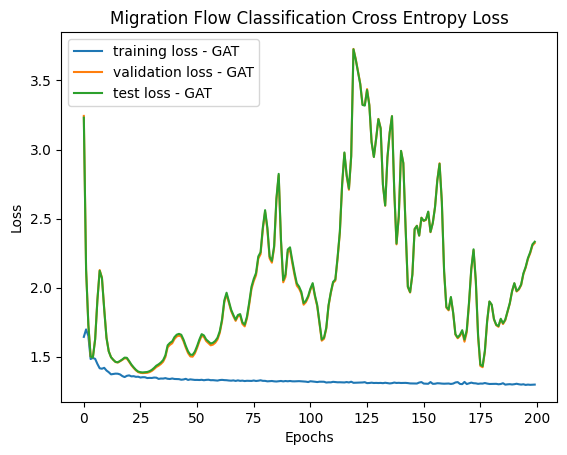

Running pipeline with config: Regression_GCN_full_full


Training:   0%|          | 1/200 [00:00<01:33,  2.13Epochs/s]

Epoch 1: Training Loss 2.72373, Training R2 -1.91286 Validation Loss 7.94034 Validation R2 -15.86882


Training:   1%|          | 2/200 [00:01<01:41,  1.94Epochs/s]

Epoch 2: Training Loss 1.69338, Training R2 -0.22626 Validation Loss 4.51876 Validation R2 -4.84063


Training:   2%|▏         | 3/200 [00:01<01:34,  2.08Epochs/s]

Epoch 3: Training Loss 1.74135, Training R2 -0.13983 Validation Loss 9.26697 Validation R2 -22.36592


Training:   2%|▏         | 4/200 [00:01<01:28,  2.23Epochs/s]

Epoch 4: Training Loss 1.4943, Training R2 0.12726 Validation Loss 10.06822 Validation R2 -26.74609


Training:   2%|▎         | 5/200 [00:02<01:25,  2.28Epochs/s]

Epoch 5: Training Loss 1.52733, Training R2 0.08463 Validation Loss 7.4477 Validation R2 -14.64187


Training:   3%|▎         | 6/200 [00:02<01:24,  2.30Epochs/s]

Epoch 6: Training Loss 1.41861, Training R2 0.19634 Validation Loss 5.87866 Validation R2 -8.97687


Training:   4%|▎         | 7/200 [00:03<01:22,  2.35Epochs/s]

Epoch 7: Training Loss 1.4452, Training R2 0.14419 Validation Loss 6.10989 Validation R2 -9.8228


Training:   4%|▍         | 8/200 [00:03<01:21,  2.36Epochs/s]

Epoch 8: Training Loss 1.38672, Training R2 0.16678 Validation Loss 6.59977 Validation R2 -11.63528


Training:   4%|▍         | 9/200 [00:03<01:19,  2.39Epochs/s]

Epoch 9: Training Loss 1.40883, Training R2 0.13641 Validation Loss 5.88235 Validation R2 -9.17897


Training:   5%|▌         | 10/200 [00:04<01:18,  2.41Epochs/s]

Epoch 10: Training Loss 1.39872, Training R2 0.143 Validation Loss 4.53215 Validation R2 -5.16404


Training:   6%|▌         | 11/200 [00:04<01:18,  2.40Epochs/s]

Epoch 11: Training Loss 1.3794, Training R2 0.15693 Validation Loss 3.61009 Validation R2 -2.94633


Training:   6%|▌         | 12/200 [00:05<01:17,  2.42Epochs/s]

Epoch 12: Training Loss 1.3808, Training R2 0.16068 Validation Loss 3.403 Validation R2 -2.50678


Training:   6%|▋         | 13/200 [00:05<01:16,  2.43Epochs/s]

Epoch 13: Training Loss 1.3599, Training R2 0.19838 Validation Loss 3.53444 Validation R2 -2.77768


Training:   7%|▋         | 14/200 [00:05<01:15,  2.46Epochs/s]

Epoch 14: Training Loss 1.34414, Training R2 0.23176 Validation Loss 3.56644 Validation R2 -2.84271


Training:   8%|▊         | 15/200 [00:06<01:14,  2.47Epochs/s]

Epoch 15: Training Loss 1.34898, Training R2 0.24596 Validation Loss 3.14287 Validation R2 -1.98469


Training:   8%|▊         | 16/200 [00:06<01:16,  2.41Epochs/s]

Epoch 16: Training Loss 1.34751, Training R2 0.26033 Validation Loss 2.46894 Validation R2 -0.83358


Training:   8%|▊         | 17/200 [00:07<01:15,  2.44Epochs/s]

Epoch 17: Training Loss 1.33954, Training R2 0.27398 Validation Loss 2.11392 Validation R2 -0.33844


Training:   9%|▉         | 18/200 [00:07<01:14,  2.44Epochs/s]

Epoch 18: Training Loss 1.34102, Training R2 0.27622 Validation Loss 2.13258 Validation R2 -0.36754


Training:  10%|▉         | 19/200 [00:08<01:15,  2.39Epochs/s]

Epoch 19: Training Loss 1.3172, Training R2 0.298 Validation Loss 2.2282 Validation R2 -0.50132


Training:  10%|█         | 20/200 [00:08<01:16,  2.35Epochs/s]

Epoch 20: Training Loss 1.32011, Training R2 0.29553 Validation Loss 2.02935 Validation R2 -0.24569


Training:  10%|█         | 21/200 [00:08<01:19,  2.26Epochs/s]

Epoch 21: Training Loss 1.31921, Training R2 0.29615 Validation Loss 1.67583 Validation R2 0.14703


Training:  11%|█         | 22/200 [00:09<01:26,  2.05Epochs/s]

Epoch 22: Training Loss 1.30805, Training R2 0.30365 Validation Loss 1.54651 Validation R2 0.26521


Training:  12%|█▏        | 23/200 [00:10<01:28,  2.01Epochs/s]

Epoch 23: Training Loss 1.31381, Training R2 0.29938 Validation Loss 1.60317 Validation R2 0.21555


Training:  12%|█▏        | 24/200 [00:10<01:29,  1.97Epochs/s]

Epoch 24: Training Loss 1.29532, Training R2 0.31444 Validation Loss 1.6847 Validation R2 0.14036


Training:  12%|█▎        | 25/200 [00:11<01:32,  1.89Epochs/s]

Epoch 25: Training Loss 1.29393, Training R2 0.31648 Validation Loss 1.60892 Validation R2 0.21397


Training:  13%|█▎        | 26/200 [00:11<01:35,  1.82Epochs/s]

Epoch 26: Training Loss 1.29268, Training R2 0.31737 Validation Loss 1.46744 Validation R2 0.33379


Training:  14%|█▎        | 27/200 [00:12<01:36,  1.80Epochs/s]

Epoch 27: Training Loss 1.28483, Training R2 0.32631 Validation Loss 1.44562 Validation R2 0.35071


Training:  14%|█▍        | 28/200 [00:12<01:36,  1.79Epochs/s]

Epoch 28: Training Loss 1.28345, Training R2 0.33086 Validation Loss 1.45954 Validation R2 0.33963


Training:  14%|█▍        | 29/200 [00:13<01:33,  1.84Epochs/s]

Epoch 29: Training Loss 1.28103, Training R2 0.33142 Validation Loss 1.45325 Validation R2 0.34294


Training:  15%|█▌        | 30/200 [00:13<01:31,  1.85Epochs/s]

Epoch 30: Training Loss 1.27886, Training R2 0.33319 Validation Loss 1.4277 Validation R2 0.36046


Training:  16%|█▌        | 31/200 [00:14<01:24,  2.00Epochs/s]

Epoch 31: Training Loss 1.27031, Training R2 0.33977 Validation Loss 1.405 Validation R2 0.37529


Training:  16%|█▌        | 32/200 [00:14<01:18,  2.13Epochs/s]

Epoch 32: Training Loss 1.27076, Training R2 0.33637 Validation Loss 1.39724 Validation R2 0.37959


Training:  16%|█▋        | 33/200 [00:15<01:15,  2.20Epochs/s]

Epoch 33: Training Loss 1.26967, Training R2 0.33606 Validation Loss 1.40061 Validation R2 0.37542


Training:  17%|█▋        | 34/200 [00:15<01:13,  2.27Epochs/s]

Epoch 34: Training Loss 1.2655, Training R2 0.33933 Validation Loss 1.38566 Validation R2 0.38117


Training:  18%|█▊        | 35/200 [00:16<01:12,  2.27Epochs/s]

Epoch 35: Training Loss 1.26242, Training R2 0.33889 Validation Loss 1.38498 Validation R2 0.37956


Training:  18%|█▊        | 36/200 [00:16<01:11,  2.31Epochs/s]

Epoch 36: Training Loss 1.26786, Training R2 0.33358 Validation Loss 1.43198 Validation R2 0.35193


Training:  18%|█▊        | 37/200 [00:16<01:08,  2.36Epochs/s]

Epoch 37: Training Loss 1.26062, Training R2 0.34074 Validation Loss 1.45994 Validation R2 0.33406


Training:  19%|█▉        | 38/200 [00:17<01:08,  2.37Epochs/s]

Epoch 38: Training Loss 1.26039, Training R2 0.33841 Validation Loss 1.42005 Validation R2 0.35791


Training:  20%|█▉        | 39/200 [00:17<01:08,  2.35Epochs/s]

Epoch 39: Training Loss 1.25441, Training R2 0.34301 Validation Loss 1.39096 Validation R2 0.37377


Training:  20%|██        | 40/200 [00:18<01:07,  2.37Epochs/s]

Epoch 40: Training Loss 1.25918, Training R2 0.33959 Validation Loss 1.45599 Validation R2 0.33333


Training:  20%|██        | 41/200 [00:18<01:08,  2.34Epochs/s]

Epoch 41: Training Loss 1.25681, Training R2 0.34236 Validation Loss 1.49506 Validation R2 0.30661


Training:  21%|██        | 42/200 [00:18<01:07,  2.35Epochs/s]

Epoch 42: Training Loss 1.25798, Training R2 0.34164 Validation Loss 1.40968 Validation R2 0.35468


Training:  22%|██▏       | 43/200 [00:19<01:06,  2.37Epochs/s]

Epoch 43: Training Loss 1.24893, Training R2 0.34795 Validation Loss 1.39137 Validation R2 0.3625


Training:  22%|██▏       | 44/200 [00:19<01:04,  2.41Epochs/s]

Epoch 44: Training Loss 1.25855, Training R2 0.3388 Validation Loss 1.46014 Validation R2 0.31822


Training:  22%|██▎       | 45/200 [00:20<01:04,  2.41Epochs/s]

Epoch 45: Training Loss 1.25026, Training R2 0.34634 Validation Loss 1.50297 Validation R2 0.28849


Training:  23%|██▎       | 46/200 [00:20<01:03,  2.43Epochs/s]

Epoch 46: Training Loss 1.25617, Training R2 0.34137 Validation Loss 1.39544 Validation R2 0.35246


Training:  24%|██▎       | 47/200 [00:21<01:04,  2.36Epochs/s]

Epoch 47: Training Loss 1.2462, Training R2 0.34747 Validation Loss 1.34826 Validation R2 0.38022


Training:  24%|██▍       | 48/200 [00:21<01:04,  2.35Epochs/s]

Epoch 48: Training Loss 1.25932, Training R2 0.33594 Validation Loss 1.40257 Validation R2 0.34503


Training:  24%|██▍       | 49/200 [00:21<01:05,  2.32Epochs/s]

Epoch 49: Training Loss 1.249, Training R2 0.34744 Validation Loss 1.458 Validation R2 0.31056


Training:  25%|██▌       | 50/200 [00:22<01:04,  2.34Epochs/s]

Epoch 50: Training Loss 1.25472, Training R2 0.34543 Validation Loss 1.37138 Validation R2 0.36664


Training:  26%|██▌       | 51/200 [00:22<01:02,  2.38Epochs/s]

Epoch 51: Training Loss 1.24473, Training R2 0.35133 Validation Loss 1.341 Validation R2 0.38621


Training:  26%|██▌       | 52/200 [00:23<01:02,  2.37Epochs/s]

Epoch 52: Training Loss 1.25209, Training R2 0.34568 Validation Loss 1.37429 Validation R2 0.36405


Training:  26%|██▋       | 53/200 [00:23<01:01,  2.37Epochs/s]

Epoch 53: Training Loss 1.24715, Training R2 0.35094 Validation Loss 1.44533 Validation R2 0.31837


Training:  27%|██▋       | 54/200 [00:24<01:05,  2.22Epochs/s]

Epoch 54: Training Loss 1.25076, Training R2 0.34747 Validation Loss 1.38042 Validation R2 0.3579


Training:  28%|██▊       | 55/200 [00:24<01:08,  2.11Epochs/s]

Epoch 55: Training Loss 1.24336, Training R2 0.35267 Validation Loss 1.3348 Validation R2 0.38644


Training:  28%|██▊       | 56/200 [00:25<01:12,  1.98Epochs/s]

Epoch 56: Training Loss 1.24767, Training R2 0.34835 Validation Loss 1.3407 Validation R2 0.38239


Training:  28%|██▊       | 57/200 [00:25<01:13,  1.94Epochs/s]

Epoch 57: Training Loss 1.24093, Training R2 0.35346 Validation Loss 1.39754 Validation R2 0.34713


Training:  29%|██▉       | 58/200 [00:26<01:13,  1.94Epochs/s]

Epoch 58: Training Loss 1.24582, Training R2 0.35054 Validation Loss 1.37446 Validation R2 0.36166


Training:  30%|██▉       | 59/200 [00:26<01:18,  1.80Epochs/s]

Epoch 59: Training Loss 1.2423, Training R2 0.35287 Validation Loss 1.32973 Validation R2 0.38964


Training:  30%|███       | 60/200 [00:27<01:24,  1.66Epochs/s]

Epoch 60: Training Loss 1.24483, Training R2 0.34874 Validation Loss 1.33596 Validation R2 0.38538


Training:  30%|███       | 61/200 [00:28<01:26,  1.60Epochs/s]

Epoch 61: Training Loss 1.24491, Training R2 0.35 Validation Loss 1.42698 Validation R2 0.32951


Training:  31%|███       | 62/200 [00:28<01:26,  1.60Epochs/s]

Epoch 62: Training Loss 1.24775, Training R2 0.34949 Validation Loss 1.4018 Validation R2 0.34595


Training:  32%|███▏      | 63/200 [00:29<01:23,  1.64Epochs/s]

Epoch 63: Training Loss 1.24533, Training R2 0.35107 Validation Loss 1.33357 Validation R2 0.38848


Training:  32%|███▏      | 64/200 [00:30<01:23,  1.63Epochs/s]

Epoch 64: Training Loss 1.2443, Training R2 0.35172 Validation Loss 1.33909 Validation R2 0.38544


Training:  32%|███▎      | 65/200 [00:30<01:24,  1.59Epochs/s]

Epoch 65: Training Loss 1.24052, Training R2 0.35511 Validation Loss 1.41987 Validation R2 0.33642


Training:  33%|███▎      | 66/200 [00:31<01:22,  1.62Epochs/s]

Epoch 66: Training Loss 1.24313, Training R2 0.35463 Validation Loss 1.41376 Validation R2 0.33963


Training:  34%|███▎      | 67/200 [00:32<01:24,  1.58Epochs/s]

Epoch 67: Training Loss 1.24069, Training R2 0.35628 Validation Loss 1.34096 Validation R2 0.38283


Training:  34%|███▍      | 68/200 [00:32<01:23,  1.59Epochs/s]

Epoch 68: Training Loss 1.23897, Training R2 0.3568 Validation Loss 1.33557 Validation R2 0.38383


Training:  34%|███▍      | 69/200 [00:33<01:19,  1.64Epochs/s]

Epoch 69: Training Loss 1.24229, Training R2 0.35261 Validation Loss 1.43828 Validation R2 0.31601


Training:  35%|███▌      | 70/200 [00:33<01:11,  1.81Epochs/s]

Epoch 70: Training Loss 1.23405, Training R2 0.36111 Validation Loss 1.5004 Validation R2 0.27395


Training:  36%|███▌      | 71/200 [00:34<01:06,  1.94Epochs/s]

Epoch 71: Training Loss 1.24633, Training R2 0.35212 Validation Loss 1.38214 Validation R2 0.34809


Training:  36%|███▌      | 72/200 [00:34<01:01,  2.08Epochs/s]

Epoch 72: Training Loss 1.23524, Training R2 0.36014 Validation Loss 1.34274 Validation R2 0.373


Training:  36%|███▋      | 73/200 [00:34<00:58,  2.18Epochs/s]

Epoch 73: Training Loss 1.2438, Training R2 0.35136 Validation Loss 1.41015 Validation R2 0.32856


Training:  37%|███▋      | 74/200 [00:35<00:55,  2.27Epochs/s]

Epoch 74: Training Loss 1.2367, Training R2 0.35635 Validation Loss 1.48421 Validation R2 0.28272


Training:  38%|███▊      | 75/200 [00:35<00:53,  2.33Epochs/s]

Epoch 75: Training Loss 1.24023, Training R2 0.35594 Validation Loss 1.40406 Validation R2 0.33467


Training:  38%|███▊      | 76/200 [00:36<00:52,  2.35Epochs/s]

Epoch 76: Training Loss 1.23384, Training R2 0.36064 Validation Loss 1.34345 Validation R2 0.37439


Training:  38%|███▊      | 77/200 [00:36<00:51,  2.39Epochs/s]

Epoch 77: Training Loss 1.24104, Training R2 0.35325 Validation Loss 1.3952 Validation R2 0.34194


Training:  39%|███▉      | 78/200 [00:36<00:50,  2.41Epochs/s]

Epoch 78: Training Loss 1.23295, Training R2 0.36238 Validation Loss 1.47899 Validation R2 0.2901


Training:  40%|███▉      | 79/200 [00:37<00:50,  2.41Epochs/s]

Epoch 79: Training Loss 1.23605, Training R2 0.36114 Validation Loss 1.4479 Validation R2 0.30973


Training:  40%|████      | 80/200 [00:37<00:49,  2.43Epochs/s]

Epoch 80: Training Loss 1.23238, Training R2 0.36184 Validation Loss 1.36592 Validation R2 0.3615


Training:  40%|████      | 81/200 [00:38<00:49,  2.43Epochs/s]

Epoch 81: Training Loss 1.23447, Training R2 0.35813 Validation Loss 1.3894 Validation R2 0.34671


Training:  41%|████      | 82/200 [00:38<00:48,  2.45Epochs/s]

Epoch 82: Training Loss 1.23108, Training R2 0.36139 Validation Loss 1.45021 Validation R2 0.31106


Training:  42%|████▏     | 83/200 [00:38<00:47,  2.44Epochs/s]

Epoch 83: Training Loss 1.23344, Training R2 0.36128 Validation Loss 1.42716 Validation R2 0.32886


Training:  42%|████▏     | 84/200 [00:39<00:47,  2.42Epochs/s]

Epoch 84: Training Loss 1.23104, Training R2 0.36149 Validation Loss 1.35539 Validation R2 0.37454


Training:  42%|████▎     | 85/200 [00:39<00:47,  2.43Epochs/s]

Epoch 85: Training Loss 1.23505, Training R2 0.35881 Validation Loss 1.37645 Validation R2 0.3611


Training:  43%|████▎     | 86/200 [00:40<00:46,  2.43Epochs/s]

Epoch 86: Training Loss 1.22944, Training R2 0.36285 Validation Loss 1.38715 Validation R2 0.35314


Training:  44%|████▎     | 87/200 [00:40<00:46,  2.45Epochs/s]

Epoch 87: Training Loss 1.23045, Training R2 0.36258 Validation Loss 1.40752 Validation R2 0.33841


Training:  44%|████▍     | 88/200 [00:41<00:50,  2.20Epochs/s]

Epoch 88: Training Loss 1.22838, Training R2 0.36495 Validation Loss 1.40271 Validation R2 0.33897


Training:  44%|████▍     | 89/200 [00:41<00:52,  2.11Epochs/s]

Epoch 89: Training Loss 1.22803, Training R2 0.36542 Validation Loss 1.4178 Validation R2 0.32781


Training:  45%|████▌     | 90/200 [00:42<00:53,  2.06Epochs/s]

Epoch 90: Training Loss 1.22771, Training R2 0.36243 Validation Loss 1.38669 Validation R2 0.34671


Training:  46%|████▌     | 91/200 [00:42<00:53,  2.03Epochs/s]

Epoch 91: Training Loss 1.22549, Training R2 0.36696 Validation Loss 1.38004 Validation R2 0.3519


Training:  46%|████▌     | 92/200 [00:43<00:54,  1.96Epochs/s]

Epoch 92: Training Loss 1.2296, Training R2 0.36308 Validation Loss 1.40528 Validation R2 0.33594


Training:  46%|████▋     | 93/200 [00:43<00:55,  1.92Epochs/s]

Epoch 93: Training Loss 1.2276, Training R2 0.36512 Validation Loss 1.43062 Validation R2 0.32093


Training:  47%|████▋     | 94/200 [00:44<00:55,  1.91Epochs/s]

Epoch 94: Training Loss 1.22993, Training R2 0.36377 Validation Loss 1.38835 Validation R2 0.34921


Training:  48%|████▊     | 95/200 [00:44<00:54,  1.92Epochs/s]

Epoch 95: Training Loss 1.22764, Training R2 0.36465 Validation Loss 1.35227 Validation R2 0.37295


Training:  48%|████▊     | 96/200 [00:45<00:55,  1.86Epochs/s]

Epoch 96: Training Loss 1.23046, Training R2 0.36132 Validation Loss 1.39173 Validation R2 0.3485


Training:  48%|████▊     | 97/200 [00:46<00:55,  1.84Epochs/s]

Epoch 97: Training Loss 1.2259, Training R2 0.36579 Validation Loss 1.42448 Validation R2 0.32898


Training:  49%|████▉     | 98/200 [00:46<00:50,  2.01Epochs/s]

Epoch 98: Training Loss 1.2273, Training R2 0.36491 Validation Loss 1.37867 Validation R2 0.35768


Training:  50%|████▉     | 99/200 [00:46<00:48,  2.09Epochs/s]

Epoch 99: Training Loss 1.22414, Training R2 0.36795 Validation Loss 1.3571 Validation R2 0.37055


Training:  50%|█████     | 100/200 [00:47<00:46,  2.14Epochs/s]

Epoch 100: Training Loss 1.23011, Training R2 0.36272 Validation Loss 1.41387 Validation R2 0.33228


Training:  50%|█████     | 101/200 [00:47<00:45,  2.18Epochs/s]

Epoch 101: Training Loss 1.22597, Training R2 0.366 Validation Loss 1.47234 Validation R2 0.29425


Training:  51%|█████     | 102/200 [00:48<00:43,  2.25Epochs/s]

Epoch 102: Training Loss 1.22895, Training R2 0.36443 Validation Loss 1.39351 Validation R2 0.3453


Training:  52%|█████▏    | 103/200 [00:48<00:42,  2.30Epochs/s]

Epoch 103: Training Loss 1.22705, Training R2 0.36504 Validation Loss 1.35268 Validation R2 0.3723


Training:  52%|█████▏    | 104/200 [00:48<00:41,  2.33Epochs/s]

Epoch 104: Training Loss 1.2287, Training R2 0.36399 Validation Loss 1.4228 Validation R2 0.32657


Training:  52%|█████▎    | 105/200 [00:49<00:41,  2.26Epochs/s]

Epoch 105: Training Loss 1.22493, Training R2 0.36684 Validation Loss 1.45741 Validation R2 0.30432


Training:  53%|█████▎    | 106/200 [00:49<00:41,  2.28Epochs/s]

Epoch 106: Training Loss 1.2278, Training R2 0.3643 Validation Loss 1.36573 Validation R2 0.36585


Training:  54%|█████▎    | 107/200 [00:50<00:39,  2.33Epochs/s]

Epoch 107: Training Loss 1.22736, Training R2 0.364 Validation Loss 1.35263 Validation R2 0.37536


Training:  54%|█████▍    | 108/200 [00:50<00:38,  2.36Epochs/s]

Epoch 108: Training Loss 1.2239, Training R2 0.36632 Validation Loss 1.4227 Validation R2 0.3313


Training:  55%|█████▍    | 109/200 [00:51<00:37,  2.40Epochs/s]

Epoch 109: Training Loss 1.22445, Training R2 0.36822 Validation Loss 1.43869 Validation R2 0.32166


Training:  55%|█████▌    | 110/200 [00:51<00:36,  2.44Epochs/s]

Epoch 110: Training Loss 1.22879, Training R2 0.36505 Validation Loss 1.36458 Validation R2 0.37008


Training:  56%|█████▌    | 111/200 [00:51<00:36,  2.42Epochs/s]

Epoch 111: Training Loss 1.22554, Training R2 0.36666 Validation Loss 1.36136 Validation R2 0.37237


Training:  56%|█████▌    | 112/200 [00:52<00:36,  2.43Epochs/s]

Epoch 112: Training Loss 1.22442, Training R2 0.36879 Validation Loss 1.39865 Validation R2 0.34894


Training:  56%|█████▋    | 113/200 [00:52<00:35,  2.43Epochs/s]

Epoch 113: Training Loss 1.22587, Training R2 0.36529 Validation Loss 1.38548 Validation R2 0.3558


Training:  57%|█████▋    | 114/200 [00:53<00:36,  2.36Epochs/s]

Epoch 114: Training Loss 1.22466, Training R2 0.3679 Validation Loss 1.41301 Validation R2 0.33634


Training:  57%|█████▊    | 115/200 [00:53<00:36,  2.36Epochs/s]

Epoch 115: Training Loss 1.22391, Training R2 0.36836 Validation Loss 1.39533 Validation R2 0.34487


Training:  58%|█████▊    | 116/200 [00:54<00:36,  2.32Epochs/s]

Epoch 116: Training Loss 1.22323, Training R2 0.36785 Validation Loss 1.36987 Validation R2 0.3591


Training:  58%|█████▊    | 117/200 [00:54<00:35,  2.36Epochs/s]

Epoch 117: Training Loss 1.22562, Training R2 0.36568 Validation Loss 1.43033 Validation R2 0.31801


Training:  59%|█████▉    | 118/200 [00:54<00:34,  2.38Epochs/s]

Epoch 118: Training Loss 1.22285, Training R2 0.36805 Validation Loss 1.47223 Validation R2 0.29024


Training:  60%|█████▉    | 119/200 [00:55<00:34,  2.36Epochs/s]

Epoch 119: Training Loss 1.22537, Training R2 0.36552 Validation Loss 1.36557 Validation R2 0.36148


Training:  60%|██████    | 120/200 [00:55<00:33,  2.35Epochs/s]

Epoch 120: Training Loss 1.22225, Training R2 0.36862 Validation Loss 1.38797 Validation R2 0.34751


Training:  60%|██████    | 121/200 [00:56<00:34,  2.28Epochs/s]

Epoch 121: Training Loss 1.22426, Training R2 0.36762 Validation Loss 1.41511 Validation R2 0.32994


Training:  61%|██████    | 122/200 [00:56<00:37,  2.06Epochs/s]

Epoch 122: Training Loss 1.22214, Training R2 0.369 Validation Loss 1.45363 Validation R2 0.3029


Training:  62%|██████▏   | 123/200 [00:57<00:39,  1.96Epochs/s]

Epoch 123: Training Loss 1.22679, Training R2 0.36717 Validation Loss 1.37837 Validation R2 0.35065


Training:  62%|██████▏   | 124/200 [00:57<00:39,  1.94Epochs/s]

Epoch 124: Training Loss 1.22497, Training R2 0.36748 Validation Loss 1.35799 Validation R2 0.36255


Training:  62%|██████▎   | 125/200 [00:58<00:38,  1.94Epochs/s]

Epoch 125: Training Loss 1.22315, Training R2 0.36828 Validation Loss 1.42006 Validation R2 0.31927


Training:  63%|██████▎   | 126/200 [00:58<00:38,  1.94Epochs/s]

Epoch 126: Training Loss 1.22231, Training R2 0.36798 Validation Loss 1.43595 Validation R2 0.30969


Training:  64%|██████▎   | 127/200 [00:59<00:38,  1.91Epochs/s]

Epoch 127: Training Loss 1.22494, Training R2 0.36688 Validation Loss 1.36001 Validation R2 0.36271


Training:  64%|██████▍   | 128/200 [01:00<00:38,  1.85Epochs/s]

Epoch 128: Training Loss 1.22498, Training R2 0.36579 Validation Loss 1.4089 Validation R2 0.33198


Training:  64%|██████▍   | 129/200 [01:00<00:38,  1.84Epochs/s]

Epoch 129: Training Loss 1.22092, Training R2 0.36933 Validation Loss 1.40357 Validation R2 0.33774


Training:  65%|██████▌   | 130/200 [01:01<00:36,  1.93Epochs/s]

Epoch 130: Training Loss 1.22069, Training R2 0.37025 Validation Loss 1.37614 Validation R2 0.35814


Training:  66%|██████▌   | 131/200 [01:01<00:35,  1.97Epochs/s]

Epoch 131: Training Loss 1.21912, Training R2 0.37079 Validation Loss 1.37916 Validation R2 0.35825


Training:  66%|██████▌   | 132/200 [01:01<00:32,  2.09Epochs/s]

Epoch 132: Training Loss 1.22251, Training R2 0.37072 Validation Loss 1.3718 Validation R2 0.36398


Training:  66%|██████▋   | 133/200 [01:02<00:30,  2.18Epochs/s]

Epoch 133: Training Loss 1.22177, Training R2 0.37141 Validation Loss 1.43752 Validation R2 0.32196


Training:  67%|██████▋   | 134/200 [01:02<00:29,  2.26Epochs/s]

Epoch 134: Training Loss 1.22364, Training R2 0.36881 Validation Loss 1.37919 Validation R2 0.36068


Training:  68%|██████▊   | 135/200 [01:03<00:27,  2.34Epochs/s]

Epoch 135: Training Loss 1.22304, Training R2 0.36879 Validation Loss 1.33488 Validation R2 0.3885


Training:  68%|██████▊   | 136/200 [01:03<00:27,  2.37Epochs/s]

Epoch 136: Training Loss 1.22508, Training R2 0.36588 Validation Loss 1.42162 Validation R2 0.33158


Training:  68%|██████▊   | 137/200 [01:03<00:26,  2.34Epochs/s]

Epoch 137: Training Loss 1.22003, Training R2 0.37067 Validation Loss 1.43333 Validation R2 0.3228


Training:  69%|██████▉   | 138/200 [01:04<00:26,  2.32Epochs/s]

Epoch 138: Training Loss 1.2225, Training R2 0.36731 Validation Loss 1.33425 Validation R2 0.3854


Training:  70%|██████▉   | 139/200 [01:04<00:25,  2.35Epochs/s]

Epoch 139: Training Loss 1.2264, Training R2 0.36539 Validation Loss 1.42865 Validation R2 0.32166


Training:  70%|███████   | 140/200 [01:05<00:25,  2.38Epochs/s]

Epoch 140: Training Loss 1.2226, Training R2 0.36794 Validation Loss 1.47656 Validation R2 0.2876


Training:  70%|███████   | 141/200 [01:05<00:25,  2.34Epochs/s]

Epoch 141: Training Loss 1.2248, Training R2 0.36727 Validation Loss 1.34438 Validation R2 0.37332


Training:  71%|███████   | 142/200 [01:06<00:25,  2.32Epochs/s]

Epoch 142: Training Loss 1.22604, Training R2 0.36511 Validation Loss 1.37083 Validation R2 0.35547


Training:  72%|███████▏  | 143/200 [01:06<00:24,  2.36Epochs/s]

Epoch 143: Training Loss 1.22156, Training R2 0.36996 Validation Loss 1.51256 Validation R2 0.26112


Training:  72%|███████▏  | 144/200 [01:06<00:23,  2.37Epochs/s]

Epoch 144: Training Loss 1.22744, Training R2 0.36732 Validation Loss 1.42782 Validation R2 0.31845


Training:  72%|███████▎  | 145/200 [01:07<00:22,  2.39Epochs/s]

Epoch 145: Training Loss 1.22161, Training R2 0.3693 Validation Loss 1.3115 Validation R2 0.39603


Training:  73%|███████▎  | 146/200 [01:07<00:22,  2.41Epochs/s]

Epoch 146: Training Loss 1.23148, Training R2 0.36032 Validation Loss 1.35825 Validation R2 0.36507


Training:  74%|███████▎  | 147/200 [01:08<00:21,  2.44Epochs/s]

Epoch 147: Training Loss 1.2195, Training R2 0.37067 Validation Loss 1.51843 Validation R2 0.26122


Training:  74%|███████▍  | 148/200 [01:08<00:21,  2.46Epochs/s]

Epoch 148: Training Loss 1.23401, Training R2 0.35956 Validation Loss 1.398 Validation R2 0.34142


Training:  74%|███████▍  | 149/200 [01:08<00:20,  2.48Epochs/s]

Epoch 149: Training Loss 1.21803, Training R2 0.3718 Validation Loss 1.31512 Validation R2 0.39571


Training:  75%|███████▌  | 150/200 [01:09<00:20,  2.48Epochs/s]

Epoch 150: Training Loss 1.22903, Training R2 0.3629 Validation Loss 1.37804 Validation R2 0.3559


Training:  76%|███████▌  | 151/200 [01:09<00:19,  2.45Epochs/s]

Epoch 151: Training Loss 1.21752, Training R2 0.37255 Validation Loss 1.47246 Validation R2 0.29605


Training:  76%|███████▌  | 152/200 [01:10<00:19,  2.44Epochs/s]

Epoch 152: Training Loss 1.22431, Training R2 0.36984 Validation Loss 1.36817 Validation R2 0.36361


Training:  76%|███████▋  | 153/200 [01:10<00:19,  2.39Epochs/s]

Epoch 153: Training Loss 1.22011, Training R2 0.37156 Validation Loss 1.31498 Validation R2 0.39818


Training:  77%|███████▋  | 154/200 [01:11<00:20,  2.20Epochs/s]

Epoch 154: Training Loss 1.22716, Training R2 0.36567 Validation Loss 1.38864 Validation R2 0.35213


Training:  78%|███████▊  | 155/200 [01:11<00:21,  2.11Epochs/s]

Epoch 155: Training Loss 1.21916, Training R2 0.37003 Validation Loss 1.44542 Validation R2 0.31703


Training:  78%|███████▊  | 156/200 [01:12<00:22,  1.97Epochs/s]

Epoch 156: Training Loss 1.22598, Training R2 0.36382 Validation Loss 1.3302 Validation R2 0.38913


Training:  78%|███████▊  | 157/200 [01:12<00:23,  1.83Epochs/s]

Epoch 157: Training Loss 1.21902, Training R2 0.37048 Validation Loss 1.31282 Validation R2 0.39928


Training:  79%|███████▉  | 158/200 [01:13<00:22,  1.84Epochs/s]

Epoch 158: Training Loss 1.22875, Training R2 0.36212 Validation Loss 1.46599 Validation R2 0.30271


Training:  80%|███████▉  | 159/200 [01:14<00:22,  1.84Epochs/s]

Epoch 159: Training Loss 1.22618, Training R2 0.36669 Validation Loss 1.45644 Validation R2 0.3098


Training:  80%|████████  | 160/200 [01:14<00:21,  1.82Epochs/s]

Epoch 160: Training Loss 1.22421, Training R2 0.36924 Validation Loss 1.3303 Validation R2 0.38877


Training:  80%|████████  | 161/200 [01:15<00:21,  1.82Epochs/s]

Epoch 161: Training Loss 1.21952, Training R2 0.37078 Validation Loss 1.31998 Validation R2 0.39499


Training:  81%|████████  | 162/200 [01:15<00:19,  1.99Epochs/s]

Epoch 162: Training Loss 1.2268, Training R2 0.36499 Validation Loss 1.47748 Validation R2 0.29823


Training:  82%|████████▏ | 163/200 [01:15<00:17,  2.10Epochs/s]

Epoch 163: Training Loss 1.22568, Training R2 0.36707 Validation Loss 1.46368 Validation R2 0.306


Training:  82%|████████▏ | 164/200 [01:16<00:16,  2.21Epochs/s]

Epoch 164: Training Loss 1.22714, Training R2 0.36565 Validation Loss 1.31024 Validation R2 0.40044


Training:  82%|████████▎ | 165/200 [01:16<00:15,  2.30Epochs/s]

Epoch 165: Training Loss 1.22442, Training R2 0.36534 Validation Loss 1.31756 Validation R2 0.39635


Training:  83%|████████▎ | 166/200 [01:17<00:14,  2.34Epochs/s]

Epoch 166: Training Loss 1.22389, Training R2 0.36615 Validation Loss 1.45283 Validation R2 0.31431


Training:  84%|████████▎ | 167/200 [01:17<00:13,  2.37Epochs/s]

Epoch 167: Training Loss 1.22547, Training R2 0.36704 Validation Loss 1.40785 Validation R2 0.3436


Training:  84%|████████▍ | 168/200 [01:17<00:13,  2.41Epochs/s]

Epoch 168: Training Loss 1.22138, Training R2 0.37114 Validation Loss 1.31509 Validation R2 0.40012


Training:  84%|████████▍ | 169/200 [01:18<00:12,  2.45Epochs/s]

Epoch 169: Training Loss 1.22489, Training R2 0.36612 Validation Loss 1.33011 Validation R2 0.3903


Training:  85%|████████▌ | 170/200 [01:18<00:12,  2.46Epochs/s]

Epoch 170: Training Loss 1.21873, Training R2 0.37196 Validation Loss 1.39421 Validation R2 0.34991


Training:  86%|████████▌ | 171/200 [01:19<00:11,  2.43Epochs/s]

Epoch 171: Training Loss 1.2195, Training R2 0.3708 Validation Loss 1.37786 Validation R2 0.35882


Training:  86%|████████▌ | 172/200 [01:19<00:11,  2.46Epochs/s]

Epoch 172: Training Loss 1.21872, Training R2 0.37218 Validation Loss 1.32698 Validation R2 0.38963


Training:  86%|████████▋ | 173/200 [01:19<00:10,  2.47Epochs/s]

Epoch 173: Training Loss 1.2184, Training R2 0.37233 Validation Loss 1.34036 Validation R2 0.38036


Training:  87%|████████▋ | 174/200 [01:20<00:10,  2.46Epochs/s]

Epoch 174: Training Loss 1.21477, Training R2 0.37575 Validation Loss 1.37901 Validation R2 0.35584


Training:  88%|████████▊ | 175/200 [01:20<00:10,  2.48Epochs/s]

Epoch 175: Training Loss 1.21648, Training R2 0.37524 Validation Loss 1.42212 Validation R2 0.32844


Training:  88%|████████▊ | 176/200 [01:21<00:09,  2.46Epochs/s]

Epoch 176: Training Loss 1.221, Training R2 0.37004 Validation Loss 1.36578 Validation R2 0.36531


Training:  88%|████████▊ | 177/200 [01:21<00:09,  2.47Epochs/s]

Epoch 177: Training Loss 1.21753, Training R2 0.37336 Validation Loss 1.3301 Validation R2 0.38825


Training:  89%|████████▉ | 178/200 [01:21<00:08,  2.49Epochs/s]

Epoch 178: Training Loss 1.21819, Training R2 0.37123 Validation Loss 1.37707 Validation R2 0.35988


Training:  90%|████████▉ | 179/200 [01:22<00:08,  2.48Epochs/s]

Epoch 179: Training Loss 1.2182, Training R2 0.37207 Validation Loss 1.4283 Validation R2 0.32997


Training:  90%|█████████ | 180/200 [01:22<00:08,  2.49Epochs/s]

Epoch 180: Training Loss 1.22132, Training R2 0.36884 Validation Loss 1.35089 Validation R2 0.3789


Training:  90%|█████████ | 181/200 [01:23<00:07,  2.48Epochs/s]

Epoch 181: Training Loss 1.21699, Training R2 0.37254 Validation Loss 1.3357 Validation R2 0.38875


Training:  91%|█████████ | 182/200 [01:23<00:07,  2.49Epochs/s]

Epoch 182: Training Loss 1.21906, Training R2 0.37151 Validation Loss 1.36552 Validation R2 0.37169


Training:  92%|█████████▏| 183/200 [01:23<00:06,  2.50Epochs/s]

Epoch 183: Training Loss 1.21591, Training R2 0.37395 Validation Loss 1.36633 Validation R2 0.37032


Training:  92%|█████████▏| 184/200 [01:24<00:06,  2.49Epochs/s]

Epoch 184: Training Loss 1.21588, Training R2 0.37299 Validation Loss 1.35887 Validation R2 0.37219


Training:  92%|█████████▎| 185/200 [01:24<00:06,  2.48Epochs/s]

Epoch 185: Training Loss 1.21533, Training R2 0.37344 Validation Loss 1.35481 Validation R2 0.37224


Training:  93%|█████████▎| 186/200 [01:25<00:06,  2.31Epochs/s]

Epoch 186: Training Loss 1.21719, Training R2 0.37212 Validation Loss 1.44995 Validation R2 0.30779


Training:  94%|█████████▎| 187/200 [01:25<00:06,  2.17Epochs/s]

Epoch 187: Training Loss 1.21869, Training R2 0.37208 Validation Loss 1.39422 Validation R2 0.34434


Training:  94%|█████████▍| 188/200 [01:26<00:05,  2.09Epochs/s]

Epoch 188: Training Loss 1.21476, Training R2 0.37437 Validation Loss 1.33376 Validation R2 0.38379


Training:  94%|█████████▍| 189/200 [01:26<00:05,  2.02Epochs/s]

Epoch 189: Training Loss 1.21892, Training R2 0.3714 Validation Loss 1.3708 Validation R2 0.36115


Training:  95%|█████████▌| 190/200 [01:27<00:05,  1.97Epochs/s]

Epoch 190: Training Loss 1.21687, Training R2 0.37394 Validation Loss 1.45823 Validation R2 0.30755


Training:  96%|█████████▌| 191/200 [01:27<00:04,  1.97Epochs/s]

Epoch 191: Training Loss 1.2226, Training R2 0.368 Validation Loss 1.35434 Validation R2 0.37484


Training:  96%|█████████▌| 192/200 [01:28<00:04,  1.91Epochs/s]

Epoch 192: Training Loss 1.21467, Training R2 0.37454 Validation Loss 1.31386 Validation R2 0.40096


Training:  96%|█████████▋| 193/200 [01:29<00:03,  1.87Epochs/s]

Epoch 193: Training Loss 1.22242, Training R2 0.36805 Validation Loss 1.38551 Validation R2 0.35801


Training:  97%|█████████▋| 194/200 [01:29<00:03,  1.90Epochs/s]

Epoch 194: Training Loss 1.21584, Training R2 0.37369 Validation Loss 1.43956 Validation R2 0.3252


Training:  98%|█████████▊| 195/200 [01:29<00:02,  2.05Epochs/s]

Epoch 195: Training Loss 1.22645, Training R2 0.3663 Validation Loss 1.32314 Validation R2 0.39519


Training:  98%|█████████▊| 196/200 [01:30<00:01,  2.17Epochs/s]

Epoch 196: Training Loss 1.21766, Training R2 0.37285 Validation Loss 1.30847 Validation R2 0.40332


Training:  98%|█████████▊| 197/200 [01:30<00:01,  2.25Epochs/s]

Epoch 197: Training Loss 1.22731, Training R2 0.36371 Validation Loss 1.44984 Validation R2 0.31837


Training:  99%|█████████▉| 198/200 [01:31<00:00,  2.31Epochs/s]

Epoch 198: Training Loss 1.22434, Training R2 0.3661 Validation Loss 1.43261 Validation R2 0.32942


Training: 100%|█████████▉| 199/200 [01:31<00:00,  2.33Epochs/s]

Epoch 199: Training Loss 1.22069, Training R2 0.37002 Validation Loss 1.31429 Validation R2 0.40049


Training: 100%|██████████| 200/200 [01:31<00:00,  2.17Epochs/s]

Epoch 200: Training Loss 1.22299, Training R2 0.36821 Validation Loss 1.33013 Validation R2 0.39111
Saving Model Predictions for Model Type GCN


Model saved successfully as Regression_GCN_full_full
Minimum validation loss: 1.3084716796875
Minimum test loss: 1.2928640842437744
Best test metric: 0.4127662777900696


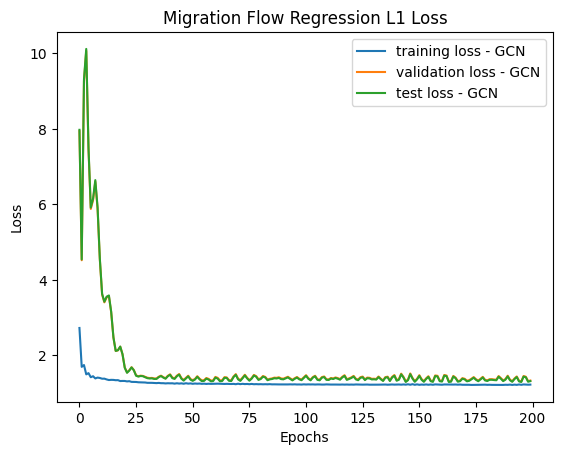

Running pipeline with config: Regression_GCN_simple_full


Training:   0%|          | 1/200 [00:00<01:15,  2.65Epochs/s]

Epoch 1: Training Loss 2.72256, Training R2 -1.93661 Validation Loss 3.20345 Validation R2 -1.98801


Training:   1%|          | 2/200 [00:00<01:16,  2.60Epochs/s]

Epoch 2: Training Loss 1.88406, Training R2 -0.47517 Validation Loss 1.9125 Validation R2 -0.08134


Training:   2%|▏         | 3/200 [00:01<01:16,  2.59Epochs/s]

Epoch 3: Training Loss 1.44368, Training R2 0.04952 Validation Loss 1.49713 Validation R2 0.33602


Training:   2%|▏         | 4/200 [00:01<01:15,  2.59Epochs/s]

Epoch 4: Training Loss 1.58129, Training R2 -0.04188 Validation Loss 1.90849 Validation R2 -0.06725


Training:   2%|▎         | 5/200 [00:01<01:15,  2.57Epochs/s]

Epoch 5: Training Loss 1.40048, Training R2 0.15753 Validation Loss 2.48439 Validation R2 -0.82237


Training:   3%|▎         | 6/200 [00:02<01:15,  2.56Epochs/s]

Epoch 6: Training Loss 1.48535, Training R2 0.07972 Validation Loss 2.17793 Validation R2 -0.40266


Training:   4%|▎         | 7/200 [00:02<01:15,  2.57Epochs/s]

Epoch 7: Training Loss 1.43159, Training R2 0.14798 Validation Loss 1.66779 Validation R2 0.18269


Training:   4%|▍         | 8/200 [00:03<01:14,  2.56Epochs/s]

Epoch 8: Training Loss 1.41045, Training R2 0.17172 Validation Loss 1.50147 Validation R2 0.31896


Training:   4%|▍         | 9/200 [00:03<01:15,  2.53Epochs/s]

Epoch 9: Training Loss 1.4408, Training R2 0.13799 Validation Loss 1.54589 Validation R2 0.2827


Training:   5%|▌         | 10/200 [00:03<01:15,  2.51Epochs/s]

Epoch 10: Training Loss 1.40946, Training R2 0.15685 Validation Loss 1.76327 Validation R2 0.07488


Training:   6%|▌         | 11/200 [00:04<01:14,  2.52Epochs/s]

Epoch 11: Training Loss 1.37963, Training R2 0.17703 Validation Loss 1.94606 Validation R2 -0.13675


Training:   6%|▌         | 12/200 [00:04<01:13,  2.54Epochs/s]

Epoch 12: Training Loss 1.40024, Training R2 0.15245 Validation Loss 1.84188 Validation R2 -0.02117


Training:   6%|▋         | 13/200 [00:05<01:14,  2.52Epochs/s]

Epoch 13: Training Loss 1.38823, Training R2 0.15872 Validation Loss 1.61929 Validation R2 0.20252


Training:   7%|▋         | 14/200 [00:05<01:13,  2.53Epochs/s]

Epoch 14: Training Loss 1.37981, Training R2 0.16018 Validation Loss 1.49877 Validation R2 0.29319


Training:   8%|▊         | 15/200 [00:05<01:18,  2.36Epochs/s]

Epoch 15: Training Loss 1.39101, Training R2 0.14388 Validation Loss 1.48694 Validation R2 0.29661


Training:   8%|▊         | 16/200 [00:06<01:22,  2.24Epochs/s]

Epoch 16: Training Loss 1.39139, Training R2 0.14582 Validation Loss 1.52849 Validation R2 0.26918


Training:   8%|▊         | 17/200 [00:07<01:25,  2.14Epochs/s]

Epoch 17: Training Loss 1.3602, Training R2 0.18455 Validation Loss 1.60931 Validation R2 0.20302


Training:   9%|▉         | 18/200 [00:07<01:27,  2.07Epochs/s]

Epoch 18: Training Loss 1.36265, Training R2 0.19384 Validation Loss 1.63002 Validation R2 0.18245


Training:  10%|▉         | 19/200 [00:08<01:28,  2.06Epochs/s]

Epoch 19: Training Loss 1.3768, Training R2 0.18885 Validation Loss 1.54145 Validation R2 0.25338


Training:  10%|█         | 20/200 [00:08<01:28,  2.03Epochs/s]

Epoch 20: Training Loss 1.35118, Training R2 0.21464 Validation Loss 1.4733 Validation R2 0.28805


Training:  10%|█         | 21/200 [00:09<01:29,  2.00Epochs/s]

Epoch 21: Training Loss 1.35089, Training R2 0.2204 Validation Loss 1.48122 Validation R2 0.26713


Training:  11%|█         | 22/200 [00:09<01:30,  1.97Epochs/s]

Epoch 22: Training Loss 1.35928, Training R2 0.21392 Validation Loss 1.4726 Validation R2 0.2781


Training:  12%|█▏        | 23/200 [00:10<01:29,  1.98Epochs/s]

Epoch 23: Training Loss 1.34622, Training R2 0.23085 Validation Loss 1.46895 Validation R2 0.29438


Training:  12%|█▏        | 24/200 [00:10<01:29,  1.97Epochs/s]

Epoch 24: Training Loss 1.34079, Training R2 0.24042 Validation Loss 1.46854 Validation R2 0.29771


Training:  12%|█▎        | 25/200 [00:11<01:30,  1.93Epochs/s]

Epoch 25: Training Loss 1.34027, Training R2 0.24427 Validation Loss 1.45932 Validation R2 0.29757


Training:  13%|█▎        | 26/200 [00:11<01:24,  2.07Epochs/s]

Epoch 26: Training Loss 1.32794, Training R2 0.25445 Validation Loss 1.46524 Validation R2 0.28521


Training:  14%|█▎        | 27/200 [00:11<01:18,  2.20Epochs/s]

Epoch 27: Training Loss 1.32303, Training R2 0.26149 Validation Loss 1.48238 Validation R2 0.26698


Training:  14%|█▍        | 28/200 [00:12<01:15,  2.28Epochs/s]

Epoch 28: Training Loss 1.32464, Training R2 0.2622 Validation Loss 1.51399 Validation R2 0.238


Training:  14%|█▍        | 29/200 [00:12<01:12,  2.35Epochs/s]

Epoch 29: Training Loss 1.32364, Training R2 0.26363 Validation Loss 1.48211 Validation R2 0.26875


Training:  15%|█▌        | 30/200 [00:13<01:10,  2.41Epochs/s]

Epoch 30: Training Loss 1.31571, Training R2 0.27236 Validation Loss 1.45472 Validation R2 0.2962


Training:  16%|█▌        | 31/200 [00:13<01:09,  2.44Epochs/s]

Epoch 31: Training Loss 1.31882, Training R2 0.27191 Validation Loss 1.4756 Validation R2 0.27183


Training:  16%|█▌        | 32/200 [00:13<01:07,  2.48Epochs/s]

Epoch 32: Training Loss 1.31785, Training R2 0.27385 Validation Loss 1.57517 Validation R2 0.18111


Training:  16%|█▋        | 33/200 [00:14<01:07,  2.48Epochs/s]

Epoch 33: Training Loss 1.3086, Training R2 0.28313 Validation Loss 1.57537 Validation R2 0.18051


Training:  17%|█▋        | 34/200 [00:14<01:06,  2.49Epochs/s]

Epoch 34: Training Loss 1.30798, Training R2 0.28854 Validation Loss 1.52652 Validation R2 0.22174


Training:  18%|█▊        | 35/200 [00:15<01:07,  2.46Epochs/s]

Epoch 35: Training Loss 1.29799, Training R2 0.29742 Validation Loss 1.52662 Validation R2 0.21985


Training:  18%|█▊        | 36/200 [00:15<01:07,  2.44Epochs/s]

Epoch 36: Training Loss 1.29683, Training R2 0.3002 Validation Loss 1.56508 Validation R2 0.18508


Training:  18%|█▊        | 37/200 [00:15<01:05,  2.48Epochs/s]

Epoch 37: Training Loss 1.29742, Training R2 0.3034 Validation Loss 1.70717 Validation R2 0.05982


Training:  19%|█▉        | 38/200 [00:16<01:04,  2.50Epochs/s]

Epoch 38: Training Loss 1.29588, Training R2 0.30589 Validation Loss 1.73206 Validation R2 0.03868


Training:  20%|█▉        | 39/200 [00:16<01:04,  2.49Epochs/s]

Epoch 39: Training Loss 1.29089, Training R2 0.31431 Validation Loss 1.62665 Validation R2 0.13449


Training:  20%|██        | 40/200 [00:17<01:04,  2.49Epochs/s]

Epoch 40: Training Loss 1.2873, Training R2 0.31798 Validation Loss 1.61025 Validation R2 0.15152


Training:  20%|██        | 41/200 [00:17<01:03,  2.49Epochs/s]

Epoch 41: Training Loss 1.28571, Training R2 0.31809 Validation Loss 1.69048 Validation R2 0.08607


Training:  21%|██        | 42/200 [00:17<01:02,  2.52Epochs/s]

Epoch 42: Training Loss 1.27731, Training R2 0.32813 Validation Loss 1.71976 Validation R2 0.06325


Training:  22%|██▏       | 43/200 [00:18<01:02,  2.52Epochs/s]

Epoch 43: Training Loss 1.27762, Training R2 0.32854 Validation Loss 1.62813 Validation R2 0.14415


Training:  22%|██▏       | 44/200 [00:18<01:02,  2.51Epochs/s]

Epoch 44: Training Loss 1.27252, Training R2 0.33218 Validation Loss 1.60347 Validation R2 0.16663


Training:  22%|██▎       | 45/200 [00:19<01:01,  2.53Epochs/s]

Epoch 45: Training Loss 1.2751, Training R2 0.33091 Validation Loss 1.74565 Validation R2 0.0517


Training:  23%|██▎       | 46/200 [00:19<01:01,  2.52Epochs/s]

Epoch 46: Training Loss 1.26949, Training R2 0.33686 Validation Loss 1.75985 Validation R2 0.04478


Training:  24%|██▎       | 47/200 [00:19<01:01,  2.50Epochs/s]

Epoch 47: Training Loss 1.26672, Training R2 0.33875 Validation Loss 1.65005 Validation R2 0.14255


Training:  24%|██▍       | 48/200 [00:20<01:00,  2.50Epochs/s]

Epoch 48: Training Loss 1.26895, Training R2 0.3363 Validation Loss 1.61291 Validation R2 0.17556


Training:  24%|██▍       | 49/200 [00:20<01:00,  2.48Epochs/s]

Epoch 49: Training Loss 1.26332, Training R2 0.3385 Validation Loss 1.69024 Validation R2 0.11628


Training:  25%|██▌       | 50/200 [00:21<01:02,  2.40Epochs/s]

Epoch 50: Training Loss 1.26411, Training R2 0.33695 Validation Loss 1.7299 Validation R2 0.08492


Training:  26%|██▌       | 51/200 [00:21<01:07,  2.21Epochs/s]

Epoch 51: Training Loss 1.26807, Training R2 0.33432 Validation Loss 1.65947 Validation R2 0.14567


Training:  26%|██▌       | 52/200 [00:22<01:10,  2.10Epochs/s]

Epoch 52: Training Loss 1.26124, Training R2 0.3381 Validation Loss 1.59406 Validation R2 0.19622


Training:  26%|██▋       | 53/200 [00:22<01:11,  2.04Epochs/s]

Epoch 53: Training Loss 1.26042, Training R2 0.33878 Validation Loss 1.66852 Validation R2 0.13844


Training:  27%|██▋       | 54/200 [00:23<01:13,  1.98Epochs/s]

Epoch 54: Training Loss 1.25505, Training R2 0.34506 Validation Loss 1.76425 Validation R2 0.0547


Training:  28%|██▊       | 55/200 [00:23<01:14,  1.95Epochs/s]

Epoch 55: Training Loss 1.26458, Training R2 0.33945 Validation Loss 1.54421 Validation R2 0.22423


Training:  28%|██▊       | 56/200 [00:24<01:14,  1.92Epochs/s]

Epoch 56: Training Loss 1.25963, Training R2 0.34336 Validation Loss 1.55659 Validation R2 0.21017


Training:  28%|██▊       | 57/200 [00:24<01:14,  1.93Epochs/s]

Epoch 57: Training Loss 1.25811, Training R2 0.34345 Validation Loss 1.76288 Validation R2 0.04121


Training:  29%|██▉       | 58/200 [00:25<01:14,  1.91Epochs/s]

Epoch 58: Training Loss 1.26345, Training R2 0.34218 Validation Loss 1.58889 Validation R2 0.17682


Training:  30%|██▉       | 59/200 [00:25<01:13,  1.92Epochs/s]

Epoch 59: Training Loss 1.25243, Training R2 0.3454 Validation Loss 1.44801 Validation R2 0.28019


Training:  30%|███       | 60/200 [00:26<01:12,  1.94Epochs/s]

Epoch 60: Training Loss 1.26491, Training R2 0.33444 Validation Loss 1.60609 Validation R2 0.16993


Training:  30%|███       | 61/200 [00:26<01:08,  2.04Epochs/s]

Epoch 61: Training Loss 1.25037, Training R2 0.34731 Validation Loss 1.6756 Validation R2 0.12289


Training:  31%|███       | 62/200 [00:27<01:04,  2.15Epochs/s]

Epoch 62: Training Loss 1.25783, Training R2 0.34478 Validation Loss 1.46465 Validation R2 0.27791


Training:  32%|███▏      | 63/200 [00:27<01:02,  2.18Epochs/s]

Epoch 63: Training Loss 1.24993, Training R2 0.34991 Validation Loss 1.4414 Validation R2 0.29772


Training:  32%|███▏      | 64/200 [00:28<01:02,  2.19Epochs/s]

Epoch 64: Training Loss 1.25052, Training R2 0.34864 Validation Loss 1.54264 Validation R2 0.23446


Training:  32%|███▎      | 65/200 [00:28<01:00,  2.23Epochs/s]

Epoch 65: Training Loss 1.24444, Training R2 0.35522 Validation Loss 1.62489 Validation R2 0.18128


Training:  33%|███▎      | 66/200 [00:28<00:58,  2.30Epochs/s]

Epoch 66: Training Loss 1.25115, Training R2 0.35371 Validation Loss 1.48244 Validation R2 0.28202


Training:  34%|███▎      | 67/200 [00:29<00:56,  2.34Epochs/s]

Epoch 67: Training Loss 1.24576, Training R2 0.35582 Validation Loss 1.38267 Validation R2 0.34928


Training:  34%|███▍      | 68/200 [00:29<00:55,  2.40Epochs/s]

Epoch 68: Training Loss 1.24826, Training R2 0.35074 Validation Loss 1.46516 Validation R2 0.30716


Training:  34%|███▍      | 69/200 [00:30<00:53,  2.43Epochs/s]

Epoch 69: Training Loss 1.2402, Training R2 0.35721 Validation Loss 1.5548 Validation R2 0.26041


Training:  35%|███▌      | 70/200 [00:30<00:53,  2.43Epochs/s]

Epoch 70: Training Loss 1.24545, Training R2 0.35286 Validation Loss 1.41863 Validation R2 0.34397


Training:  36%|███▌      | 71/200 [00:31<00:52,  2.44Epochs/s]

Epoch 71: Training Loss 1.24052, Training R2 0.35621 Validation Loss 1.36476 Validation R2 0.37681


Training:  36%|███▌      | 72/200 [00:31<00:53,  2.38Epochs/s]

Epoch 72: Training Loss 1.24434, Training R2 0.35305 Validation Loss 1.46878 Validation R2 0.32073


Training:  36%|███▋      | 73/200 [00:31<00:53,  2.37Epochs/s]

Epoch 73: Training Loss 1.24097, Training R2 0.35575 Validation Loss 1.42756 Validation R2 0.34429


Training:  37%|███▋      | 74/200 [00:32<00:52,  2.40Epochs/s]

Epoch 74: Training Loss 1.23879, Training R2 0.35889 Validation Loss 1.40997 Validation R2 0.35316


Training:  38%|███▊      | 75/200 [00:32<00:51,  2.44Epochs/s]

Epoch 75: Training Loss 1.23872, Training R2 0.35971 Validation Loss 1.39737 Validation R2 0.35632


Training:  38%|███▊      | 76/200 [00:33<00:50,  2.48Epochs/s]

Epoch 76: Training Loss 1.2363, Training R2 0.36164 Validation Loss 1.45485 Validation R2 0.31914


Training:  38%|███▊      | 77/200 [00:33<00:50,  2.42Epochs/s]

Epoch 77: Training Loss 1.24231, Training R2 0.35617 Validation Loss 1.38842 Validation R2 0.34839


Training:  39%|███▉      | 78/200 [00:33<00:49,  2.44Epochs/s]

Epoch 78: Training Loss 1.23454, Training R2 0.36085 Validation Loss 1.38832 Validation R2 0.3439


Training:  40%|███▉      | 79/200 [00:34<00:49,  2.45Epochs/s]

Epoch 79: Training Loss 1.23522, Training R2 0.3598 Validation Loss 1.42852 Validation R2 0.3164


Training:  40%|████      | 80/200 [00:34<00:48,  2.47Epochs/s]

Epoch 80: Training Loss 1.23624, Training R2 0.35909 Validation Loss 1.43398 Validation R2 0.30991


Training:  40%|████      | 81/200 [00:35<00:48,  2.46Epochs/s]

Epoch 81: Training Loss 1.23307, Training R2 0.35995 Validation Loss 1.37284 Validation R2 0.34245


Training:  41%|████      | 82/200 [00:35<00:47,  2.46Epochs/s]

Epoch 82: Training Loss 1.23699, Training R2 0.35839 Validation Loss 1.43583 Validation R2 0.31266


Training:  42%|████▏     | 83/200 [00:35<00:47,  2.47Epochs/s]

Epoch 83: Training Loss 1.23604, Training R2 0.35897 Validation Loss 1.43397 Validation R2 0.31935


Training:  42%|████▏     | 84/200 [00:36<00:46,  2.48Epochs/s]

Epoch 84: Training Loss 1.2333, Training R2 0.35977 Validation Loss 1.34171 Validation R2 0.3693


Training:  42%|████▎     | 85/200 [00:36<00:50,  2.26Epochs/s]

Epoch 85: Training Loss 1.23887, Training R2 0.35589 Validation Loss 1.39133 Validation R2 0.34933


Training:  43%|████▎     | 86/200 [00:37<00:52,  2.17Epochs/s]

Epoch 86: Training Loss 1.23058, Training R2 0.36297 Validation Loss 1.43055 Validation R2 0.33471


Training:  44%|████▎     | 87/200 [00:37<00:54,  2.08Epochs/s]

Epoch 87: Training Loss 1.23115, Training R2 0.36287 Validation Loss 1.35769 Validation R2 0.37596


Training:  44%|████▍     | 88/200 [00:38<00:55,  2.02Epochs/s]

Epoch 88: Training Loss 1.23047, Training R2 0.3617 Validation Loss 1.35575 Validation R2 0.37937


Training:  44%|████▍     | 89/200 [00:38<00:55,  1.98Epochs/s]

Epoch 89: Training Loss 1.22881, Training R2 0.36429 Validation Loss 1.37257 Validation R2 0.3722


Training:  45%|████▌     | 90/200 [00:39<00:55,  1.99Epochs/s]

Epoch 90: Training Loss 1.22743, Training R2 0.36473 Validation Loss 1.3865 Validation R2 0.36546


Training:  46%|████▌     | 91/200 [00:39<00:55,  1.95Epochs/s]

Epoch 91: Training Loss 1.23095, Training R2 0.36245 Validation Loss 1.36873 Validation R2 0.37129


Training:  46%|████▌     | 92/200 [00:40<00:55,  1.95Epochs/s]

Epoch 92: Training Loss 1.22901, Training R2 0.36392 Validation Loss 1.35145 Validation R2 0.37537


Training:  46%|████▋     | 93/200 [00:41<00:55,  1.94Epochs/s]

Epoch 93: Training Loss 1.22941, Training R2 0.36115 Validation Loss 1.40881 Validation R2 0.33945


Training:  47%|████▋     | 94/200 [00:41<00:54,  1.95Epochs/s]

Epoch 94: Training Loss 1.22869, Training R2 0.36319 Validation Loss 1.36901 Validation R2 0.35535


Training:  48%|████▊     | 95/200 [00:42<00:53,  1.97Epochs/s]

Epoch 95: Training Loss 1.23061, Training R2 0.36264 Validation Loss 1.42179 Validation R2 0.32473


Training:  48%|████▊     | 96/200 [00:42<00:49,  2.10Epochs/s]

Epoch 96: Training Loss 1.22858, Training R2 0.36435 Validation Loss 1.35655 Validation R2 0.35405


Training:  48%|████▊     | 97/200 [00:42<00:46,  2.20Epochs/s]

Epoch 97: Training Loss 1.2274, Training R2 0.36303 Validation Loss 1.37912 Validation R2 0.34314


Training:  49%|████▉     | 98/200 [00:43<00:44,  2.27Epochs/s]

Epoch 98: Training Loss 1.22556, Training R2 0.36465 Validation Loss 1.46956 Validation R2 0.29682


Training:  50%|████▉     | 99/200 [00:43<00:43,  2.33Epochs/s]

Epoch 99: Training Loss 1.23003, Training R2 0.36429 Validation Loss 1.39131 Validation R2 0.33445


Training:  50%|█████     | 100/200 [00:44<00:42,  2.38Epochs/s]

Epoch 100: Training Loss 1.22635, Training R2 0.3634 Validation Loss 1.36257 Validation R2 0.35212


Training:  50%|█████     | 101/200 [00:44<00:41,  2.41Epochs/s]

Epoch 101: Training Loss 1.2284, Training R2 0.3621 Validation Loss 1.50379 Validation R2 0.29002


Training:  51%|█████     | 102/200 [00:44<00:40,  2.43Epochs/s]

Epoch 102: Training Loss 1.22715, Training R2 0.36446 Validation Loss 1.44837 Validation R2 0.3231


Training:  52%|█████▏    | 103/200 [00:45<00:40,  2.42Epochs/s]

Epoch 103: Training Loss 1.22622, Training R2 0.36623 Validation Loss 1.33078 Validation R2 0.38085


Training:  52%|█████▏    | 104/200 [00:45<00:38,  2.47Epochs/s]

Epoch 104: Training Loss 1.23073, Training R2 0.36183 Validation Loss 1.37897 Validation R2 0.36082


Training:  52%|█████▎    | 105/200 [00:46<00:38,  2.47Epochs/s]

Epoch 105: Training Loss 1.22351, Training R2 0.36678 Validation Loss 1.491 Validation R2 0.30785


Training:  53%|█████▎    | 106/200 [00:46<00:38,  2.46Epochs/s]

Epoch 106: Training Loss 1.2346, Training R2 0.35878 Validation Loss 1.35258 Validation R2 0.37902


Training:  54%|█████▎    | 107/200 [00:46<00:37,  2.46Epochs/s]

Epoch 107: Training Loss 1.22384, Training R2 0.36679 Validation Loss 1.32278 Validation R2 0.39196


Training:  54%|█████▍    | 108/200 [00:47<00:37,  2.44Epochs/s]

Epoch 108: Training Loss 1.23764, Training R2 0.35599 Validation Loss 1.55518 Validation R2 0.27293


Training:  55%|█████▍    | 109/200 [00:47<00:37,  2.44Epochs/s]

Epoch 109: Training Loss 1.24159, Training R2 0.35451 Validation Loss 1.47383 Validation R2 0.31744


Training:  55%|█████▌    | 110/200 [00:48<00:36,  2.45Epochs/s]

Epoch 110: Training Loss 1.22831, Training R2 0.36248 Validation Loss 1.32327 Validation R2 0.39215


Training:  56%|█████▌    | 111/200 [00:48<00:36,  2.46Epochs/s]

Epoch 111: Training Loss 1.25074, Training R2 0.34464 Validation Loss 1.45719 Validation R2 0.32715


Training:  56%|█████▌    | 112/200 [00:48<00:35,  2.45Epochs/s]

Epoch 112: Training Loss 1.22357, Training R2 0.36572 Validation Loss 1.60401 Validation R2 0.24753


Training:  56%|█████▋    | 113/200 [00:49<00:35,  2.46Epochs/s]

Epoch 113: Training Loss 1.24026, Training R2 0.35491 Validation Loss 1.48128 Validation R2 0.32132


Training:  57%|█████▋    | 114/200 [00:49<00:35,  2.45Epochs/s]

Epoch 114: Training Loss 1.21992, Training R2 0.36891 Validation Loss 1.38708 Validation R2 0.37026


Training:  57%|█████▊    | 115/200 [00:50<00:34,  2.46Epochs/s]

Epoch 115: Training Loss 1.23504, Training R2 0.35837 Validation Loss 1.52089 Validation R2 0.29402


Training:  58%|█████▊    | 116/200 [00:50<00:33,  2.48Epochs/s]

Epoch 116: Training Loss 1.2224, Training R2 0.36791 Validation Loss 1.65212 Validation R2 0.20294


Training:  58%|█████▊    | 117/200 [00:50<00:33,  2.47Epochs/s]

Epoch 117: Training Loss 1.23167, Training R2 0.36011 Validation Loss 1.48267 Validation R2 0.30706


Training:  59%|█████▉    | 118/200 [00:51<00:33,  2.45Epochs/s]

Epoch 118: Training Loss 1.22193, Training R2 0.36892 Validation Loss 1.36182 Validation R2 0.37185


Training:  60%|█████▉    | 119/200 [00:51<00:33,  2.44Epochs/s]

Epoch 119: Training Loss 1.22842, Training R2 0.36421 Validation Loss 1.41923 Validation R2 0.33945


Training:  60%|██████    | 120/200 [00:52<00:34,  2.30Epochs/s]

Epoch 120: Training Loss 1.22165, Training R2 0.3695 Validation Loss 1.52824 Validation R2 0.27573


Training:  60%|██████    | 121/200 [00:52<00:36,  2.17Epochs/s]

Epoch 121: Training Loss 1.22911, Training R2 0.36587 Validation Loss 1.45129 Validation R2 0.31633


Training:  61%|██████    | 122/200 [00:53<00:37,  2.09Epochs/s]

Epoch 122: Training Loss 1.22153, Training R2 0.36935 Validation Loss 1.35525 Validation R2 0.36522


Training:  62%|██████▏   | 123/200 [00:53<00:37,  2.03Epochs/s]

Epoch 123: Training Loss 1.22231, Training R2 0.3672 Validation Loss 1.37045 Validation R2 0.35154


Training:  62%|██████▏   | 124/200 [00:54<00:38,  1.99Epochs/s]

Epoch 124: Training Loss 1.2247, Training R2 0.36691 Validation Loss 1.47641 Validation R2 0.28716


Training:  62%|██████▎   | 125/200 [00:54<00:37,  1.98Epochs/s]

Epoch 125: Training Loss 1.22359, Training R2 0.36671 Validation Loss 1.46754 Validation R2 0.29522


Training:  63%|██████▎   | 126/200 [00:55<00:38,  1.92Epochs/s]

Epoch 126: Training Loss 1.22615, Training R2 0.36533 Validation Loss 1.34821 Validation R2 0.37019


Training:  64%|██████▎   | 127/200 [00:55<00:38,  1.89Epochs/s]

Epoch 127: Training Loss 1.2235, Training R2 0.3665 Validation Loss 1.32967 Validation R2 0.38576


Training:  64%|██████▍   | 128/200 [00:56<00:37,  1.91Epochs/s]

Epoch 128: Training Loss 1.2258, Training R2 0.36521 Validation Loss 1.41651 Validation R2 0.3441


Training:  64%|██████▍   | 129/200 [00:56<00:34,  2.05Epochs/s]

Epoch 129: Training Loss 1.22124, Training R2 0.3686 Validation Loss 1.45306 Validation R2 0.3276


Training:  65%|██████▌   | 130/200 [00:57<00:32,  2.13Epochs/s]

Epoch 130: Training Loss 1.22703, Training R2 0.3649 Validation Loss 1.34899 Validation R2 0.38262


Training:  66%|██████▌   | 131/200 [00:57<00:30,  2.23Epochs/s]

Epoch 131: Training Loss 1.22125, Training R2 0.36981 Validation Loss 1.32903 Validation R2 0.39179


Training:  66%|██████▌   | 132/200 [00:58<00:29,  2.28Epochs/s]

Epoch 132: Training Loss 1.22167, Training R2 0.36819 Validation Loss 1.38673 Validation R2 0.36097


Training:  66%|██████▋   | 133/200 [00:58<00:29,  2.28Epochs/s]

Epoch 133: Training Loss 1.21987, Training R2 0.36934 Validation Loss 1.44397 Validation R2 0.33106


Training:  67%|██████▋   | 134/200 [00:58<00:28,  2.35Epochs/s]

Epoch 134: Training Loss 1.22585, Training R2 0.36409 Validation Loss 1.36917 Validation R2 0.37228


Training:  68%|██████▊   | 135/200 [00:59<00:27,  2.39Epochs/s]

Epoch 135: Training Loss 1.22106, Training R2 0.36843 Validation Loss 1.35572 Validation R2 0.37957


Training:  68%|██████▊   | 136/200 [00:59<00:26,  2.42Epochs/s]

Epoch 136: Training Loss 1.21807, Training R2 0.3723 Validation Loss 1.36601 Validation R2 0.3738


Training:  68%|██████▊   | 137/200 [01:00<00:25,  2.45Epochs/s]

Epoch 137: Training Loss 1.21799, Training R2 0.37232 Validation Loss 1.36948 Validation R2 0.36942


Training:  69%|██████▉   | 138/200 [01:00<00:25,  2.46Epochs/s]

Epoch 138: Training Loss 1.21921, Training R2 0.37222 Validation Loss 1.38542 Validation R2 0.35666


Training:  70%|██████▉   | 139/200 [01:00<00:24,  2.48Epochs/s]

Epoch 139: Training Loss 1.2189, Training R2 0.36941 Validation Loss 1.3658 Validation R2 0.36266


Training:  70%|███████   | 140/200 [01:01<00:24,  2.47Epochs/s]

Epoch 140: Training Loss 1.21639, Training R2 0.37094 Validation Loss 1.36516 Validation R2 0.36146


Training:  70%|███████   | 141/200 [01:01<00:23,  2.47Epochs/s]

Epoch 141: Training Loss 1.2181, Training R2 0.36993 Validation Loss 1.38734 Validation R2 0.34885


Training:  71%|███████   | 142/200 [01:02<00:23,  2.49Epochs/s]

Epoch 142: Training Loss 1.21715, Training R2 0.37098 Validation Loss 1.36736 Validation R2 0.35771


Training:  72%|███████▏  | 143/200 [01:02<00:22,  2.48Epochs/s]

Epoch 143: Training Loss 1.21686, Training R2 0.37276 Validation Loss 1.35027 Validation R2 0.36618


Training:  72%|███████▏  | 144/200 [01:02<00:22,  2.48Epochs/s]

Epoch 144: Training Loss 1.21854, Training R2 0.37359 Validation Loss 1.37089 Validation R2 0.35612


Training:  72%|███████▎  | 145/200 [01:03<00:22,  2.49Epochs/s]

Epoch 145: Training Loss 1.21768, Training R2 0.37303 Validation Loss 1.38032 Validation R2 0.35217


Training:  73%|███████▎  | 146/200 [01:03<00:21,  2.48Epochs/s]

Epoch 146: Training Loss 1.21912, Training R2 0.37114 Validation Loss 1.34092 Validation R2 0.37345


Training:  74%|███████▎  | 147/200 [01:04<00:21,  2.50Epochs/s]

Epoch 147: Training Loss 1.21832, Training R2 0.36969 Validation Loss 1.34437 Validation R2 0.37276


Training:  74%|███████▍  | 148/200 [01:04<00:20,  2.49Epochs/s]

Epoch 148: Training Loss 1.21557, Training R2 0.372 Validation Loss 1.34268 Validation R2 0.37528


Training:  74%|███████▍  | 149/200 [01:04<00:20,  2.49Epochs/s]

Epoch 149: Training Loss 1.2166, Training R2 0.37097 Validation Loss 1.33616 Validation R2 0.38037


Training:  75%|███████▌  | 150/200 [01:05<00:19,  2.50Epochs/s]

Epoch 150: Training Loss 1.21637, Training R2 0.37267 Validation Loss 1.35514 Validation R2 0.37248


Training:  76%|███████▌  | 151/200 [01:05<00:19,  2.51Epochs/s]

Epoch 151: Training Loss 1.21742, Training R2 0.3704 Validation Loss 1.35189 Validation R2 0.37527


Training:  76%|███████▌  | 152/200 [01:06<00:19,  2.51Epochs/s]

Epoch 152: Training Loss 1.21674, Training R2 0.37208 Validation Loss 1.32333 Validation R2 0.39214


Training:  76%|███████▋  | 153/200 [01:06<00:19,  2.37Epochs/s]

Epoch 153: Training Loss 1.21777, Training R2 0.37233 Validation Loss 1.34584 Validation R2 0.38177


Training:  77%|███████▋  | 154/200 [01:07<00:20,  2.19Epochs/s]

Epoch 154: Training Loss 1.21565, Training R2 0.37362 Validation Loss 1.35686 Validation R2 0.37801


Training:  78%|███████▊  | 155/200 [01:07<00:20,  2.15Epochs/s]

Epoch 155: Training Loss 1.21648, Training R2 0.37319 Validation Loss 1.324 Validation R2 0.39694


Training:  78%|███████▊  | 156/200 [01:08<00:21,  2.04Epochs/s]

Epoch 156: Training Loss 1.21597, Training R2 0.375 Validation Loss 1.31608 Validation R2 0.4011


Training:  78%|███████▊  | 157/200 [01:08<00:21,  2.01Epochs/s]

Epoch 157: Training Loss 1.22059, Training R2 0.37112 Validation Loss 1.36826 Validation R2 0.37577


Training:  79%|███████▉  | 158/200 [01:09<00:21,  1.99Epochs/s]

Epoch 158: Training Loss 1.21623, Training R2 0.37074 Validation Loss 1.38191 Validation R2 0.37037


Training:  80%|███████▉  | 159/200 [01:09<00:20,  1.98Epochs/s]

Epoch 159: Training Loss 1.21827, Training R2 0.36954 Validation Loss 1.33112 Validation R2 0.39548


Training:  80%|████████  | 160/200 [01:10<00:21,  1.87Epochs/s]

Epoch 160: Training Loss 1.21826, Training R2 0.37164 Validation Loss 1.33054 Validation R2 0.39654


Training:  80%|████████  | 161/200 [01:10<00:20,  1.91Epochs/s]

Epoch 161: Training Loss 1.21651, Training R2 0.37269 Validation Loss 1.40608 Validation R2 0.35941


Training:  81%|████████  | 162/200 [01:11<00:18,  2.04Epochs/s]

Epoch 162: Training Loss 1.2179, Training R2 0.37423 Validation Loss 1.38708 Validation R2 0.3638


Training:  82%|████████▏ | 163/200 [01:11<00:17,  2.17Epochs/s]

Epoch 163: Training Loss 1.21581, Training R2 0.37337 Validation Loss 1.33885 Validation R2 0.38162


Training:  82%|████████▏ | 164/200 [01:12<00:15,  2.25Epochs/s]

Epoch 164: Training Loss 1.2164, Training R2 0.37276 Validation Loss 1.33764 Validation R2 0.37447


Training:  82%|████████▎ | 165/200 [01:12<00:14,  2.33Epochs/s]

Epoch 165: Training Loss 1.21702, Training R2 0.37046 Validation Loss 1.38002 Validation R2 0.34659


Training:  83%|████████▎ | 166/200 [01:12<00:14,  2.38Epochs/s]

Epoch 166: Training Loss 1.21298, Training R2 0.37266 Validation Loss 1.40432 Validation R2 0.33498


Training:  84%|████████▎ | 167/200 [01:13<00:13,  2.39Epochs/s]

Epoch 167: Training Loss 1.21688, Training R2 0.3705 Validation Loss 1.34295 Validation R2 0.37527


Training:  84%|████████▍ | 168/200 [01:13<00:13,  2.43Epochs/s]

Epoch 168: Training Loss 1.21518, Training R2 0.37388 Validation Loss 1.35739 Validation R2 0.37278


Training:  84%|████████▍ | 169/200 [01:14<00:12,  2.45Epochs/s]

Epoch 169: Training Loss 1.21619, Training R2 0.37473 Validation Loss 1.41885 Validation R2 0.34351


Training:  85%|████████▌ | 170/200 [01:14<00:12,  2.44Epochs/s]

Epoch 170: Training Loss 1.21681, Training R2 0.3753 Validation Loss 1.40255 Validation R2 0.35166


Training:  86%|████████▌ | 171/200 [01:14<00:11,  2.46Epochs/s]

Epoch 171: Training Loss 1.21575, Training R2 0.37424 Validation Loss 1.34858 Validation R2 0.37536


Training:  86%|████████▌ | 172/200 [01:15<00:11,  2.46Epochs/s]

Epoch 172: Training Loss 1.21601, Training R2 0.3718 Validation Loss 1.35716 Validation R2 0.36799


Training:  86%|████████▋ | 173/200 [01:15<00:11,  2.45Epochs/s]

Epoch 173: Training Loss 1.21556, Training R2 0.3723 Validation Loss 1.42176 Validation R2 0.3303


Training:  87%|████████▋ | 174/200 [01:16<00:10,  2.40Epochs/s]

Epoch 174: Training Loss 1.21717, Training R2 0.37094 Validation Loss 1.40524 Validation R2 0.33424


Training:  88%|████████▊ | 175/200 [01:16<00:10,  2.41Epochs/s]

Epoch 175: Training Loss 1.21284, Training R2 0.37563 Validation Loss 1.36705 Validation R2 0.35299


Training:  88%|████████▊ | 176/200 [01:16<00:09,  2.42Epochs/s]

Epoch 176: Training Loss 1.21601, Training R2 0.37507 Validation Loss 1.37971 Validation R2 0.34454


Training:  88%|████████▊ | 177/200 [01:17<00:09,  2.42Epochs/s]

Epoch 177: Training Loss 1.21348, Training R2 0.37839 Validation Loss 1.37947 Validation R2 0.34549


Training:  89%|████████▉ | 178/200 [01:17<00:09,  2.44Epochs/s]

Epoch 178: Training Loss 1.21438, Training R2 0.37299 Validation Loss 1.37738 Validation R2 0.34432


Training:  90%|████████▉ | 179/200 [01:18<00:08,  2.45Epochs/s]

Epoch 179: Training Loss 1.21458, Training R2 0.37272 Validation Loss 1.38749 Validation R2 0.34249


Training:  90%|█████████ | 180/200 [01:18<00:08,  2.45Epochs/s]

Epoch 180: Training Loss 1.21308, Training R2 0.37329 Validation Loss 1.37471 Validation R2 0.35454


Training:  90%|█████████ | 181/200 [01:18<00:07,  2.47Epochs/s]

Epoch 181: Training Loss 1.21479, Training R2 0.37426 Validation Loss 1.36983 Validation R2 0.36249


Training:  91%|█████████ | 182/200 [01:19<00:07,  2.43Epochs/s]

Epoch 182: Training Loss 1.21166, Training R2 0.37849 Validation Loss 1.37452 Validation R2 0.36504


Training:  92%|█████████▏| 183/200 [01:19<00:06,  2.44Epochs/s]

Epoch 183: Training Loss 1.2142, Training R2 0.37636 Validation Loss 1.39871 Validation R2 0.35664


Training:  92%|█████████▏| 184/200 [01:20<00:06,  2.46Epochs/s]

Epoch 184: Training Loss 1.21422, Training R2 0.37585 Validation Loss 1.36989 Validation R2 0.37084


Training:  92%|█████████▎| 185/200 [01:20<00:06,  2.46Epochs/s]

Epoch 185: Training Loss 1.21334, Training R2 0.37556 Validation Loss 1.36843 Validation R2 0.37026


Training:  93%|█████████▎| 186/200 [01:21<00:05,  2.34Epochs/s]

Epoch 186: Training Loss 1.21369, Training R2 0.37414 Validation Loss 1.37499 Validation R2 0.36614


Training:  94%|█████████▎| 187/200 [01:21<00:05,  2.20Epochs/s]

Epoch 187: Training Loss 1.21397, Training R2 0.37335 Validation Loss 1.36064 Validation R2 0.36973


Training:  94%|█████████▍| 188/200 [01:22<00:05,  2.15Epochs/s]

Epoch 188: Training Loss 1.21418, Training R2 0.37306 Validation Loss 1.38838 Validation R2 0.35038


Training:  94%|█████████▍| 189/200 [01:22<00:05,  1.99Epochs/s]

Epoch 189: Training Loss 1.21291, Training R2 0.37471 Validation Loss 1.38433 Validation R2 0.34556


Training:  95%|█████████▌| 190/200 [01:23<00:05,  1.97Epochs/s]

Epoch 190: Training Loss 1.21218, Training R2 0.3776 Validation Loss 1.36834 Validation R2 0.34557


Training:  96%|█████████▌| 191/200 [01:23<00:04,  1.98Epochs/s]

Epoch 191: Training Loss 1.21478, Training R2 0.37457 Validation Loss 1.42574 Validation R2 0.3049


Training:  96%|█████████▌| 192/200 [01:24<00:04,  1.96Epochs/s]

Epoch 192: Training Loss 1.21453, Training R2 0.37389 Validation Loss 1.39688 Validation R2 0.32377


Training:  96%|█████████▋| 193/200 [01:24<00:03,  1.93Epochs/s]

Epoch 193: Training Loss 1.21146, Training R2 0.37579 Validation Loss 1.35279 Validation R2 0.35553


Training:  97%|█████████▋| 194/200 [01:25<00:03,  1.94Epochs/s]

Epoch 194: Training Loss 1.21339, Training R2 0.37402 Validation Loss 1.38105 Validation R2 0.35158


Training:  98%|█████████▊| 195/200 [01:25<00:02,  1.93Epochs/s]

Epoch 195: Training Loss 1.21232, Training R2 0.3748 Validation Loss 1.41376 Validation R2 0.34592


Training:  98%|█████████▊| 196/200 [01:26<00:02,  1.97Epochs/s]

Epoch 196: Training Loss 1.21426, Training R2 0.37376 Validation Loss 1.37214 Validation R2 0.37243


Training:  98%|█████████▊| 197/200 [01:26<00:01,  2.10Epochs/s]

Epoch 197: Training Loss 1.21267, Training R2 0.37653 Validation Loss 1.38554 Validation R2 0.36478


Training:  99%|█████████▉| 198/200 [01:27<00:00,  2.21Epochs/s]

Epoch 198: Training Loss 1.21035, Training R2 0.37875 Validation Loss 1.41167 Validation R2 0.3464


Training: 100%|█████████▉| 199/200 [01:27<00:00,  2.28Epochs/s]

Epoch 199: Training Loss 1.21358, Training R2 0.37549 Validation Loss 1.38634 Validation R2 0.35143


Training: 100%|██████████| 200/200 [01:27<00:00,  2.28Epochs/s]

Epoch 200: Training Loss 1.2114, Training R2 0.37629 Validation Loss 1.36469 Validation R2 0.35725
Saving Model Predictions for Model Type GCN


Model saved successfully as Regression_GCN_simple_full
Minimum validation loss: 1.3160847425460815
Minimum test loss: 1.298857569694519
Best test metric: 0.41095292568206787


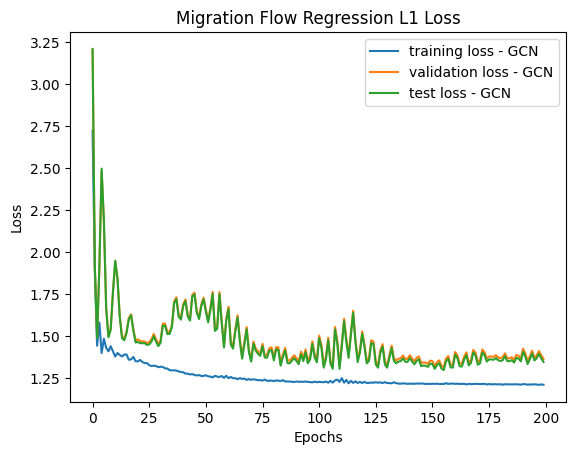

Running pipeline with config: Regression_GCN_full_within_state


Training:   1%|          | 2/200 [00:00<00:33,  5.93Epochs/s]

Epoch 1: Training Loss 2.97812, Training R2 -1.96594 Validation Loss 1.81442 Validation R2 0.1945
Epoch 2: Training Loss 2.03085, Training R2 -0.22032 Validation Loss 7.87917 Validation R2 -12.33194


Training:   2%|▏         | 3/200 [00:00<00:34,  5.64Epochs/s]

Epoch 3: Training Loss 2.15821, Training R2 -0.53756 Validation Loss 5.32944 Validation R2 -5.17407
Epoch 4: Training Loss 1.83111, Training R2 -0.09879 Validation Loss 3.68836 Validation R2 -2.21671


Training:   3%|▎         | 6/200 [00:01<00:34,  5.68Epochs/s]

Epoch 5: Training Loss 1.83336, Training R2 -0.04928 Validation Loss 3.68148 Validation R2 -2.22909
Epoch 6: Training Loss 1.72813, Training R2 0.10384 Validation Loss 4.33306 Validation R2 -3.34523


Training:   4%|▍         | 8/200 [00:01<00:34,  5.53Epochs/s]

Epoch 7: Training Loss 1.67299, Training R2 0.14755 Validation Loss 5.17896 Validation R2 -5.0523
Epoch 8: Training Loss 1.67732, Training R2 0.10186 Validation Loss 5.42255 Validation R2 -5.54212


Training:   5%|▌         | 10/200 [00:01<00:34,  5.56Epochs/s]

Epoch 9: Training Loss 1.67556, Training R2 0.06924 Validation Loss 5.03011 Validation R2 -4.61174
Epoch 10: Training Loss 1.63705, Training R2 0.10398 Validation Loss 4.48729 Validation R2 -3.53589


Training:   6%|▌         | 11/200 [00:01<00:34,  5.47Epochs/s]

Epoch 11: Training Loss 1.62067, Training R2 0.13443 Validation Loss 4.20425 Validation R2 -3.06567
Epoch 12: Training Loss 1.6272, Training R2 0.14589 Validation Loss 4.0995 Validation R2 -2.89843


Training:   7%|▋         | 14/200 [00:02<00:33,  5.58Epochs/s]

Epoch 13: Training Loss 1.60795, Training R2 0.17369 Validation Loss 4.24135 Validation R2 -3.12224
Epoch 14: Training Loss 1.5845, Training R2 0.18343 Validation Loss 4.46955 Validation R2 -3.49628


Training:   8%|▊         | 16/200 [00:02<00:32,  5.62Epochs/s]

Epoch 15: Training Loss 1.56479, Training R2 0.19063 Validation Loss 4.59241 Validation R2 -3.69627
Epoch 16: Training Loss 1.55403, Training R2 0.19419 Validation Loss 4.41785 Validation R2 -3.36628


Training:   8%|▊         | 17/200 [00:03<00:33,  5.49Epochs/s]

Epoch 17: Training Loss 1.56103, Training R2 0.18766 Validation Loss 3.9899 Validation R2 -2.63918
Epoch 18: Training Loss 1.55279, Training R2 0.19809 Validation Loss 3.49281 Validation R2 -1.89059


Training:  10%|█         | 20/200 [00:03<00:32,  5.49Epochs/s]

Epoch 19: Training Loss 1.53012, Training R2 0.22704 Validation Loss 3.19014 Validation R2 -1.48546
Epoch 20: Training Loss 1.52849, Training R2 0.23383 Validation Loss 3.17437 Validation R2 -1.47526


Training:  11%|█         | 22/200 [00:03<00:32,  5.54Epochs/s]

Epoch 21: Training Loss 1.54025, Training R2 0.22566 Validation Loss 3.46815 Validation R2 -1.88294
Epoch 22: Training Loss 1.52742, Training R2 0.22495 Validation Loss 3.74079 Validation R2 -2.28115


Training:  12%|█▏        | 23/200 [00:04<00:32,  5.48Epochs/s]

Epoch 23: Training Loss 1.53258, Training R2 0.2072 Validation Loss 3.70908 Validation R2 -2.2284
Epoch 24: Training Loss 1.51068, Training R2 0.22204 Validation Loss 3.45013 Validation R2 -1.85478


Training:  13%|█▎        | 26/200 [00:04<00:31,  5.56Epochs/s]

Epoch 25: Training Loss 1.50356, Training R2 0.22752 Validation Loss 3.24946 Validation R2 -1.58434
Epoch 26: Training Loss 1.52083, Training R2 0.21957 Validation Loss 3.2175 Validation R2 -1.54527


Training:  14%|█▍        | 28/200 [00:05<00:30,  5.64Epochs/s]

Epoch 27: Training Loss 1.51116, Training R2 0.22313 Validation Loss 3.30896 Validation R2 -1.67051
Epoch 28: Training Loss 1.51128, Training R2 0.21589 Validation Loss 3.35159 Validation R2 -1.73205


Training:  14%|█▍        | 29/200 [00:05<00:31,  5.49Epochs/s]

Epoch 29: Training Loss 1.51054, Training R2 0.21269 Validation Loss 3.15287 Validation R2 -1.47112
Epoch 30: Training Loss 1.49914, Training R2 0.22167 Validation Loss 2.81991 Validation R2 -1.05561


Training:  16%|█▌        | 32/200 [00:05<00:30,  5.54Epochs/s]

Epoch 31: Training Loss 1.49831, Training R2 0.22787 Validation Loss 2.55668 Validation R2 -0.74409
Epoch 32: Training Loss 1.50157, Training R2 0.23177 Validation Loss 2.48957 Validation R2 -0.66536


Training:  17%|█▋        | 34/200 [00:06<00:29,  5.53Epochs/s]

Epoch 33: Training Loss 1.5001, Training R2 0.23344 Validation Loss 2.54391 Validation R2 -0.72468
Epoch 34: Training Loss 1.49655, Training R2 0.22842 Validation Loss 2.52627 Validation R2 -0.701


Training:  18%|█▊        | 35/200 [00:06<00:30,  5.44Epochs/s]

Epoch 35: Training Loss 1.50048, Training R2 0.21989 Validation Loss 2.28929 Validation R2 -0.43265


Training:  18%|█▊        | 36/200 [00:06<00:33,  4.84Epochs/s]

Epoch 36: Training Loss 1.49663, Training R2 0.22784 Validation Loss 2.02482 Validation R2 -0.15138


Training:  18%|█▊        | 37/200 [00:06<00:35,  4.61Epochs/s]

Epoch 37: Training Loss 1.49094, Training R2 0.23893 Validation Loss 1.84883 Validation R2 0.02102


Training:  19%|█▉        | 38/200 [00:07<00:36,  4.44Epochs/s]

Epoch 38: Training Loss 1.48779, Training R2 0.24543 Validation Loss 1.81422 Validation R2 0.05353


Training:  20%|█▉        | 39/200 [00:07<00:35,  4.52Epochs/s]

Epoch 39: Training Loss 1.48345, Training R2 0.24612 Validation Loss 1.81912 Validation R2 0.04915


Training:  20%|██        | 40/200 [00:07<00:36,  4.41Epochs/s]

Epoch 40: Training Loss 1.48373, Training R2 0.23699 Validation Loss 1.77189 Validation R2 0.09536


Training:  20%|██        | 41/200 [00:07<00:36,  4.36Epochs/s]

Epoch 41: Training Loss 1.48636, Training R2 0.23359 Validation Loss 1.7029 Validation R2 0.16721


Training:  21%|██        | 42/200 [00:08<00:35,  4.43Epochs/s]

Epoch 42: Training Loss 1.49154, Training R2 0.23561 Validation Loss 1.65639 Validation R2 0.22277


Training:  22%|██▏       | 43/200 [00:08<00:35,  4.43Epochs/s]

Epoch 43: Training Loss 1.48507, Training R2 0.24959 Validation Loss 1.64013 Validation R2 0.2415


Training:  22%|██▏       | 44/200 [00:08<00:36,  4.29Epochs/s]

Epoch 44: Training Loss 1.4846, Training R2 0.24575 Validation Loss 1.62354 Validation R2 0.2543


Training:  22%|██▎       | 45/200 [00:08<00:37,  4.16Epochs/s]

Epoch 45: Training Loss 1.47859, Training R2 0.2483 Validation Loss 1.60595 Validation R2 0.2697


Training:  23%|██▎       | 46/200 [00:09<00:37,  4.05Epochs/s]

Epoch 46: Training Loss 1.48004, Training R2 0.24417 Validation Loss 1.59665 Validation R2 0.28168


Training:  24%|██▎       | 47/200 [00:09<00:38,  4.02Epochs/s]

Epoch 47: Training Loss 1.47352, Training R2 0.24754 Validation Loss 1.59974 Validation R2 0.28755


Training:  24%|██▍       | 48/200 [00:09<00:36,  4.15Epochs/s]

Epoch 48: Training Loss 1.48576, Training R2 0.24146 Validation Loss 1.6014 Validation R2 0.2899


Training:  24%|██▍       | 49/200 [00:09<00:38,  3.96Epochs/s]

Epoch 49: Training Loss 1.48079, Training R2 0.24854 Validation Loss 1.59407 Validation R2 0.2886


Training:  25%|██▌       | 50/200 [00:10<00:37,  3.98Epochs/s]

Epoch 50: Training Loss 1.47658, Training R2 0.2467 Validation Loss 1.60126 Validation R2 0.28322


Training:  26%|██▌       | 51/200 [00:10<00:35,  4.15Epochs/s]

Epoch 51: Training Loss 1.47272, Training R2 0.24387 Validation Loss 1.61513 Validation R2 0.28135


Training:  26%|██▌       | 52/200 [00:10<00:34,  4.25Epochs/s]

Epoch 52: Training Loss 1.47153, Training R2 0.24777 Validation Loss 1.63071 Validation R2 0.2809


Training:  26%|██▋       | 53/200 [00:10<00:34,  4.29Epochs/s]

Epoch 53: Training Loss 1.47294, Training R2 0.25327 Validation Loss 1.62575 Validation R2 0.28365


Training:  27%|██▋       | 54/200 [00:10<00:34,  4.28Epochs/s]

Epoch 54: Training Loss 1.47078, Training R2 0.25293 Validation Loss 1.6086 Validation R2 0.28836


Training:  28%|██▊       | 55/200 [00:11<00:34,  4.24Epochs/s]

Epoch 55: Training Loss 1.47423, Training R2 0.24456 Validation Loss 1.60457 Validation R2 0.28999


Training:  28%|██▊       | 56/200 [00:11<00:34,  4.18Epochs/s]

Epoch 56: Training Loss 1.47206, Training R2 0.24931 Validation Loss 1.60566 Validation R2 0.28977


Training:  28%|██▊       | 57/200 [00:11<00:34,  4.15Epochs/s]

Epoch 57: Training Loss 1.47548, Training R2 0.24226 Validation Loss 1.61818 Validation R2 0.2887


Training:  29%|██▉       | 58/200 [00:11<00:34,  4.09Epochs/s]

Epoch 58: Training Loss 1.46816, Training R2 0.25253 Validation Loss 1.63211 Validation R2 0.28478


Training:  30%|██▉       | 59/200 [00:12<00:34,  4.08Epochs/s]

Epoch 59: Training Loss 1.4694, Training R2 0.25514 Validation Loss 1.63722 Validation R2 0.28221


Training:  30%|███       | 60/200 [00:12<00:34,  4.08Epochs/s]

Epoch 60: Training Loss 1.46646, Training R2 0.25554 Validation Loss 1.63807 Validation R2 0.28098


Training:  30%|███       | 61/200 [00:12<00:35,  3.91Epochs/s]

Epoch 61: Training Loss 1.47164, Training R2 0.24759 Validation Loss 1.64494 Validation R2 0.27866


Training:  31%|███       | 62/200 [00:12<00:35,  3.91Epochs/s]

Epoch 62: Training Loss 1.47344, Training R2 0.24797 Validation Loss 1.65942 Validation R2 0.27345


Training:  32%|███▏      | 63/200 [00:13<00:34,  3.97Epochs/s]

Epoch 63: Training Loss 1.47003, Training R2 0.24988 Validation Loss 1.6749 Validation R2 0.26695


Training:  32%|███▏      | 64/200 [00:13<00:33,  4.06Epochs/s]

Epoch 64: Training Loss 1.46309, Training R2 0.26001 Validation Loss 1.66708 Validation R2 0.26879


Training:  33%|███▎      | 66/200 [00:13<00:29,  4.48Epochs/s]

Epoch 65: Training Loss 1.46232, Training R2 0.25675 Validation Loss 1.64784 Validation R2 0.27597
Epoch 66: Training Loss 1.47183, Training R2 0.24629 Validation Loss 1.62896 Validation R2 0.28358


Training:  34%|███▍      | 68/200 [00:14<00:26,  4.98Epochs/s]

Epoch 67: Training Loss 1.46421, Training R2 0.24888 Validation Loss 1.63796 Validation R2 0.28008
Epoch 68: Training Loss 1.46678, Training R2 0.24842 Validation Loss 1.68035 Validation R2 0.26234


Training:  35%|███▌      | 70/200 [00:14<00:24,  5.26Epochs/s]

Epoch 69: Training Loss 1.46598, Training R2 0.25877 Validation Loss 1.69592 Validation R2 0.2552
Epoch 70: Training Loss 1.46929, Training R2 0.26039 Validation Loss 1.65058 Validation R2 0.275


Training:  36%|███▌      | 72/200 [00:14<00:23,  5.38Epochs/s]

Epoch 71: Training Loss 1.45809, Training R2 0.25565 Validation Loss 1.63338 Validation R2 0.27998
Epoch 72: Training Loss 1.45988, Training R2 0.25255 Validation Loss 1.65372 Validation R2 0.27097


Training:  37%|███▋      | 74/200 [00:15<00:23,  5.45Epochs/s]

Epoch 73: Training Loss 1.46601, Training R2 0.25065 Validation Loss 1.66157 Validation R2 0.26837
Epoch 74: Training Loss 1.46516, Training R2 0.25109 Validation Loss 1.6771 Validation R2 0.26209


Training:  38%|███▊      | 76/200 [00:15<00:22,  5.48Epochs/s]

Epoch 75: Training Loss 1.46146, Training R2 0.25806 Validation Loss 1.67636 Validation R2 0.26261
Epoch 76: Training Loss 1.4634, Training R2 0.25651 Validation Loss 1.67306 Validation R2 0.26474


Training:  39%|███▉      | 78/200 [00:16<00:21,  5.58Epochs/s]

Epoch 77: Training Loss 1.4602, Training R2 0.25804 Validation Loss 1.66129 Validation R2 0.27033
Epoch 78: Training Loss 1.45964, Training R2 0.25689 Validation Loss 1.67008 Validation R2 0.26615


Training:  40%|████      | 80/200 [00:16<00:21,  5.61Epochs/s]

Epoch 79: Training Loss 1.46054, Training R2 0.25101 Validation Loss 1.70751 Validation R2 0.24753
Epoch 80: Training Loss 1.45671, Training R2 0.26168 Validation Loss 1.71946 Validation R2 0.24001


Training:  41%|████      | 82/200 [00:16<00:21,  5.56Epochs/s]

Epoch 81: Training Loss 1.45931, Training R2 0.25983 Validation Loss 1.69034 Validation R2 0.25368
Epoch 82: Training Loss 1.45853, Training R2 0.25365 Validation Loss 1.67321 Validation R2 0.26196


Training:  42%|████▏     | 83/200 [00:16<00:21,  5.45Epochs/s]

Epoch 83: Training Loss 1.45366, Training R2 0.25863 Validation Loss 1.66686 Validation R2 0.26473
Epoch 84: Training Loss 1.46041, Training R2 0.25322 Validation Loss 1.70592 Validation R2 0.24637


Training:  43%|████▎     | 86/200 [00:17<00:20,  5.57Epochs/s]

Epoch 85: Training Loss 1.45516, Training R2 0.26289 Validation Loss 1.69903 Validation R2 0.24994
Epoch 86: Training Loss 1.45883, Training R2 0.2609 Validation Loss 1.67038 Validation R2 0.26344


Training:  44%|████▍     | 88/200 [00:17<00:20,  5.59Epochs/s]

Epoch 87: Training Loss 1.45603, Training R2 0.25702 Validation Loss 1.65349 Validation R2 0.27097
Epoch 88: Training Loss 1.46343, Training R2 0.24349 Validation Loss 1.6919 Validation R2 0.25502


Training:  44%|████▍     | 89/200 [00:18<00:20,  5.54Epochs/s]

Epoch 89: Training Loss 1.45274, Training R2 0.26054 Validation Loss 1.69586 Validation R2 0.25517
Epoch 90: Training Loss 1.45516, Training R2 0.25864 Validation Loss 1.67893 Validation R2 0.2644


Training:  46%|████▌     | 91/200 [00:18<00:19,  5.55Epochs/s]

Epoch 91: Training Loss 1.4545, Training R2 0.25915 Validation Loss 1.67871 Validation R2 0.26442
Epoch 92: Training Loss 1.45519, Training R2 0.2608 Validation Loss 1.66733 Validation R2 0.26911


Training:  47%|████▋     | 94/200 [00:18<00:19,  5.45Epochs/s]

Epoch 93: Training Loss 1.45888, Training R2 0.25486 Validation Loss 1.68154 Validation R2 0.26172
Epoch 94: Training Loss 1.45408, Training R2 0.26003 Validation Loss 1.69549 Validation R2 0.25338


Training:  48%|████▊     | 95/200 [00:19<00:19,  5.26Epochs/s]

Epoch 95: Training Loss 1.45416, Training R2 0.26242 Validation Loss 1.69138 Validation R2 0.25484
Epoch 96: Training Loss 1.45651, Training R2 0.2569 Validation Loss 1.67131 Validation R2 0.26472


Training:  49%|████▉     | 98/200 [00:19<00:18,  5.48Epochs/s]

Epoch 97: Training Loss 1.45759, Training R2 0.254 Validation Loss 1.67461 Validation R2 0.26503
Epoch 98: Training Loss 1.45343, Training R2 0.25921 Validation Loss 1.68238 Validation R2 0.26193


Training:  50%|████▉     | 99/200 [00:19<00:18,  5.34Epochs/s]

Epoch 99: Training Loss 1.45223, Training R2 0.26503 Validation Loss 1.65512 Validation R2 0.27433
Epoch 100: Training Loss 1.45299, Training R2 0.25581 Validation Loss 1.67611 Validation R2 0.26447


Training:  51%|█████     | 102/200 [00:20<00:17,  5.46Epochs/s]

Epoch 101: Training Loss 1.45286, Training R2 0.26463 Validation Loss 1.6801 Validation R2 0.26198
Epoch 102: Training Loss 1.45508, Training R2 0.26312 Validation Loss 1.62978 Validation R2 0.2827


Training:  52%|█████▏    | 104/200 [00:20<00:17,  5.58Epochs/s]

Epoch 103: Training Loss 1.45143, Training R2 0.25445 Validation Loss 1.63206 Validation R2 0.28136
Epoch 104: Training Loss 1.45442, Training R2 0.25558 Validation Loss 1.64937 Validation R2 0.27559


Training:  53%|█████▎    | 106/200 [00:21<00:16,  5.61Epochs/s]

Epoch 105: Training Loss 1.45128, Training R2 0.26173 Validation Loss 1.65829 Validation R2 0.27314
Epoch 106: Training Loss 1.45603, Training R2 0.2601 Validation Loss 1.6335 Validation R2 0.28284


Training:  54%|█████▍    | 108/200 [00:21<00:16,  5.53Epochs/s]

Epoch 107: Training Loss 1.44943, Training R2 0.25822 Validation Loss 1.63076 Validation R2 0.28389
Epoch 108: Training Loss 1.45384, Training R2 0.25372 Validation Loss 1.65322 Validation R2 0.27551


Training:  55%|█████▌    | 110/200 [00:21<00:16,  5.48Epochs/s]

Epoch 109: Training Loss 1.45149, Training R2 0.26022 Validation Loss 1.66592 Validation R2 0.27023
Epoch 110: Training Loss 1.4519, Training R2 0.26445 Validation Loss 1.63517 Validation R2 0.28346


Training:  56%|█████▌    | 112/200 [00:22<00:15,  5.53Epochs/s]

Epoch 111: Training Loss 1.45228, Training R2 0.2577 Validation Loss 1.62714 Validation R2 0.28773
Epoch 112: Training Loss 1.45147, Training R2 0.25716 Validation Loss 1.63715 Validation R2 0.28495


Training:  57%|█████▋    | 114/200 [00:22<00:15,  5.43Epochs/s]

Epoch 113: Training Loss 1.44732, Training R2 0.26443 Validation Loss 1.65018 Validation R2 0.28012
Epoch 114: Training Loss 1.45285, Training R2 0.26371 Validation Loss 1.62505 Validation R2 0.28941


Training:  58%|█████▊    | 116/200 [00:22<00:14,  5.61Epochs/s]

Epoch 115: Training Loss 1.45267, Training R2 0.25563 Validation Loss 1.66038 Validation R2 0.27598
Epoch 116: Training Loss 1.45, Training R2 0.26556 Validation Loss 1.66419 Validation R2 0.27423


Training:  59%|█████▉    | 118/200 [00:23<00:14,  5.58Epochs/s]

Epoch 117: Training Loss 1.44459, Training R2 0.26877 Validation Loss 1.63256 Validation R2 0.28635
Epoch 118: Training Loss 1.44874, Training R2 0.25869 Validation Loss 1.62102 Validation R2 0.29035


Training:  60%|█████▉    | 119/200 [00:23<00:14,  5.50Epochs/s]

Epoch 119: Training Loss 1.451, Training R2 0.25367 Validation Loss 1.66255 Validation R2 0.27508


Training:  60%|██████    | 120/200 [00:23<00:15,  5.11Epochs/s]

Epoch 120: Training Loss 1.4444, Training R2 0.26885 Validation Loss 1.64666 Validation R2 0.28176


Training:  60%|██████    | 121/200 [00:24<00:16,  4.69Epochs/s]

Epoch 121: Training Loss 1.4497, Training R2 0.26577 Validation Loss 1.59856 Validation R2 0.298


Training:  61%|██████    | 122/200 [00:24<00:17,  4.46Epochs/s]

Epoch 122: Training Loss 1.45125, Training R2 0.25186 Validation Loss 1.63533 Validation R2 0.28616


Training:  62%|██████▏   | 123/200 [00:24<00:18,  4.14Epochs/s]

Epoch 123: Training Loss 1.44481, Training R2 0.26421 Validation Loss 1.68919 Validation R2 0.2617


Training:  62%|██████▏   | 124/200 [00:24<00:18,  4.10Epochs/s]

Epoch 124: Training Loss 1.45342, Training R2 0.26671 Validation Loss 1.66127 Validation R2 0.27354


Training:  62%|██████▎   | 125/200 [00:25<00:18,  4.00Epochs/s]

Epoch 125: Training Loss 1.44946, Training R2 0.26334 Validation Loss 1.6071 Validation R2 0.29274


Training:  63%|██████▎   | 126/200 [00:25<00:17,  4.15Epochs/s]

Epoch 126: Training Loss 1.45382, Training R2 0.24888 Validation Loss 1.61598 Validation R2 0.28951


Training:  64%|██████▎   | 127/200 [00:25<00:17,  4.15Epochs/s]

Epoch 127: Training Loss 1.44778, Training R2 0.25748 Validation Loss 1.67099 Validation R2 0.26922


Training:  64%|██████▍   | 128/200 [00:25<00:17,  4.08Epochs/s]

Epoch 128: Training Loss 1.45025, Training R2 0.26771 Validation Loss 1.63586 Validation R2 0.28452


Training:  64%|██████▍   | 129/200 [00:26<00:17,  4.11Epochs/s]

Epoch 129: Training Loss 1.453, Training R2 0.26155 Validation Loss 1.58853 Validation R2 0.29941


Training:  65%|██████▌   | 130/200 [00:26<00:17,  4.09Epochs/s]

Epoch 130: Training Loss 1.45345, Training R2 0.24843 Validation Loss 1.62923 Validation R2 0.28854


Training:  66%|██████▌   | 131/200 [00:26<00:16,  4.23Epochs/s]

Epoch 131: Training Loss 1.4438, Training R2 0.26723 Validation Loss 1.65321 Validation R2 0.27992


Training:  66%|██████▌   | 132/200 [00:26<00:15,  4.28Epochs/s]

Epoch 132: Training Loss 1.44721, Training R2 0.26841 Validation Loss 1.61874 Validation R2 0.29273


Training:  66%|██████▋   | 133/200 [00:26<00:15,  4.44Epochs/s]

Epoch 133: Training Loss 1.44654, Training R2 0.26089 Validation Loss 1.60274 Validation R2 0.29726


Training:  67%|██████▋   | 134/200 [00:27<00:14,  4.47Epochs/s]

Epoch 134: Training Loss 1.45238, Training R2 0.25012 Validation Loss 1.64454 Validation R2 0.2838


Training:  68%|██████▊   | 135/200 [00:27<00:14,  4.51Epochs/s]

Epoch 135: Training Loss 1.44539, Training R2 0.26618 Validation Loss 1.65393 Validation R2 0.27983


Training:  68%|██████▊   | 136/200 [00:27<00:14,  4.52Epochs/s]

Epoch 136: Training Loss 1.45001, Training R2 0.26958 Validation Loss 1.59034 Validation R2 0.29956


Training:  68%|██████▊   | 137/200 [00:27<00:14,  4.43Epochs/s]

Epoch 137: Training Loss 1.44952, Training R2 0.25271 Validation Loss 1.59387 Validation R2 0.29901


Training:  69%|██████▉   | 138/200 [00:28<00:13,  4.53Epochs/s]

Epoch 138: Training Loss 1.44681, Training R2 0.25559 Validation Loss 1.65908 Validation R2 0.27663


Training:  70%|██████▉   | 139/200 [00:28<00:14,  4.31Epochs/s]

Epoch 139: Training Loss 1.44405, Training R2 0.27125 Validation Loss 1.67771 Validation R2 0.26808


Training:  70%|███████   | 140/200 [00:28<00:14,  4.25Epochs/s]

Epoch 140: Training Loss 1.44659, Training R2 0.27162 Validation Loss 1.62278 Validation R2 0.28968


Training:  70%|███████   | 141/200 [00:28<00:14,  4.02Epochs/s]

Epoch 141: Training Loss 1.44551, Training R2 0.25848 Validation Loss 1.62009 Validation R2 0.29017


Training:  71%|███████   | 142/200 [00:29<00:14,  3.95Epochs/s]

Epoch 142: Training Loss 1.44828, Training R2 0.25593 Validation Loss 1.64724 Validation R2 0.28008


Training:  72%|███████▏  | 143/200 [00:29<00:14,  3.94Epochs/s]

Epoch 143: Training Loss 1.44311, Training R2 0.26806 Validation Loss 1.64968 Validation R2 0.27951


Training:  72%|███████▏  | 144/200 [00:29<00:14,  4.00Epochs/s]

Epoch 144: Training Loss 1.44699, Training R2 0.26641 Validation Loss 1.62853 Validation R2 0.28772


Training:  72%|███████▎  | 145/200 [00:29<00:13,  4.04Epochs/s]

Epoch 145: Training Loss 1.44525, Training R2 0.26369 Validation Loss 1.60186 Validation R2 0.29607


Training:  73%|███████▎  | 146/200 [00:30<00:13,  4.12Epochs/s]

Epoch 146: Training Loss 1.44735, Training R2 0.25863 Validation Loss 1.60833 Validation R2 0.29459


Training:  74%|███████▎  | 147/200 [00:30<00:12,  4.26Epochs/s]

Epoch 147: Training Loss 1.44509, Training R2 0.25877 Validation Loss 1.65593 Validation R2 0.27696


Training:  74%|███████▍  | 148/200 [00:30<00:11,  4.41Epochs/s]

Epoch 148: Training Loss 1.44351, Training R2 0.26856 Validation Loss 1.65667 Validation R2 0.27642


Training:  74%|███████▍  | 149/200 [00:30<00:11,  4.40Epochs/s]

Epoch 149: Training Loss 1.44306, Training R2 0.2697 Validation Loss 1.61554 Validation R2 0.29215


Training:  75%|███████▌  | 150/200 [00:30<00:11,  4.51Epochs/s]

Epoch 150: Training Loss 1.44995, Training R2 0.24998 Validation Loss 1.62952 Validation R2 0.29003


Training:  76%|███████▌  | 151/200 [00:31<00:11,  4.45Epochs/s]

Epoch 151: Training Loss 1.44425, Training R2 0.26614 Validation Loss 1.63353 Validation R2 0.29085


Training:  76%|███████▌  | 152/200 [00:31<00:10,  4.54Epochs/s]

Epoch 152: Training Loss 1.44443, Training R2 0.26938 Validation Loss 1.59357 Validation R2 0.30316


Training:  76%|███████▋  | 153/200 [00:31<00:11,  4.25Epochs/s]

Epoch 153: Training Loss 1.44241, Training R2 0.26565 Validation Loss 1.57874 Validation R2 0.30524


Training:  77%|███████▋  | 154/200 [00:31<00:11,  4.13Epochs/s]

Epoch 154: Training Loss 1.44686, Training R2 0.25797 Validation Loss 1.6136 Validation R2 0.29771


Training:  78%|███████▊  | 155/200 [00:32<00:10,  4.25Epochs/s]

Epoch 155: Training Loss 1.44297, Training R2 0.26961 Validation Loss 1.63365 Validation R2 0.28973
Epoch 156: Training Loss 1.44393, Training R2 0.2693 Validation Loss 1.60466 Validation R2 0.29721


Training:  79%|███████▉  | 158/200 [00:32<00:08,  5.04Epochs/s]

Epoch 157: Training Loss 1.44655, Training R2 0.2535 Validation Loss 1.64204 Validation R2 0.28409
Epoch 158: Training Loss 1.44457, Training R2 0.25995 Validation Loss 1.68313 Validation R2 0.26593


Training:  80%|████████  | 160/200 [00:32<00:07,  5.33Epochs/s]

Epoch 159: Training Loss 1.44513, Training R2 0.27186 Validation Loss 1.62999 Validation R2 0.28679
Epoch 160: Training Loss 1.44546, Training R2 0.26113 Validation Loss 1.61019 Validation R2 0.29259


Training:  81%|████████  | 162/200 [00:33<00:06,  5.47Epochs/s]

Epoch 161: Training Loss 1.44718, Training R2 0.25528 Validation Loss 1.64473 Validation R2 0.28125
Epoch 162: Training Loss 1.44542, Training R2 0.26736 Validation Loss 1.65922 Validation R2 0.27509


Training:  82%|████████▏ | 163/200 [00:33<00:06,  5.37Epochs/s]

Epoch 163: Training Loss 1.44651, Training R2 0.26993 Validation Loss 1.6123 Validation R2 0.29138
Epoch 164: Training Loss 1.44351, Training R2 0.25942 Validation Loss 1.61512 Validation R2 0.29123


Training:  83%|████████▎ | 166/200 [00:34<00:06,  5.58Epochs/s]

Epoch 165: Training Loss 1.4412, Training R2 0.26052 Validation Loss 1.65622 Validation R2 0.27697
Epoch 166: Training Loss 1.44341, Training R2 0.26875 Validation Loss 1.64042 Validation R2 0.28309


Training:  84%|████████▍ | 168/200 [00:34<00:05,  5.59Epochs/s]

Epoch 167: Training Loss 1.44078, Training R2 0.26881 Validation Loss 1.61192 Validation R2 0.29274
Epoch 168: Training Loss 1.44881, Training R2 0.25815 Validation Loss 1.59876 Validation R2 0.29713


Training:  85%|████████▌ | 170/200 [00:34<00:05,  5.66Epochs/s]

Epoch 169: Training Loss 1.44366, Training R2 0.25965 Validation Loss 1.62728 Validation R2 0.28766
Epoch 170: Training Loss 1.44403, Training R2 0.26904 Validation Loss 1.6034 Validation R2 0.29462


Training:  86%|████████▌ | 171/200 [00:34<00:05,  5.52Epochs/s]

Epoch 171: Training Loss 1.44021, Training R2 0.26397 Validation Loss 1.59273 Validation R2 0.2985
Epoch 172: Training Loss 1.44228, Training R2 0.26076 Validation Loss 1.61646 Validation R2 0.294


Training:  87%|████████▋ | 174/200 [00:35<00:04,  5.59Epochs/s]

Epoch 173: Training Loss 1.4401, Training R2 0.26805 Validation Loss 1.62319 Validation R2 0.29263
Epoch 174: Training Loss 1.44181, Training R2 0.26587 Validation Loss 1.59506 Validation R2 0.30056


Training:  88%|████████▊ | 176/200 [00:35<00:04,  5.59Epochs/s]

Epoch 175: Training Loss 1.43938, Training R2 0.26345 Validation Loss 1.58704 Validation R2 0.30211
Epoch 176: Training Loss 1.4426, Training R2 0.25873 Validation Loss 1.61861 Validation R2 0.29435


Training:  88%|████████▊ | 177/200 [00:36<00:04,  5.46Epochs/s]

Epoch 177: Training Loss 1.43913, Training R2 0.27223 Validation Loss 1.60968 Validation R2 0.29587
Epoch 178: Training Loss 1.44006, Training R2 0.26687 Validation Loss 1.58279 Validation R2 0.30173


Training:  90%|████████▉ | 179/200 [00:36<00:03,  5.41Epochs/s]

Epoch 179: Training Loss 1.4447, Training R2 0.25575 Validation Loss 1.63516 Validation R2 0.28771
Epoch 180: Training Loss 1.44332, Training R2 0.26926 Validation Loss 1.62117 Validation R2 0.29325


Training:  91%|█████████ | 182/200 [00:36<00:03,  5.55Epochs/s]

Epoch 181: Training Loss 1.44204, Training R2 0.26718 Validation Loss 1.57255 Validation R2 0.3035
Epoch 182: Training Loss 1.4422, Training R2 0.25523 Validation Loss 1.59348 Validation R2 0.29967


Training:  92%|█████████▏| 184/200 [00:37<00:02,  5.56Epochs/s]

Epoch 183: Training Loss 1.44095, Training R2 0.26204 Validation Loss 1.65762 Validation R2 0.27597
Epoch 184: Training Loss 1.44487, Training R2 0.27317 Validation Loss 1.62149 Validation R2 0.28797


Training:  93%|█████████▎| 186/200 [00:37<00:02,  5.53Epochs/s]

Epoch 185: Training Loss 1.43791, Training R2 0.2656 Validation Loss 1.60492 Validation R2 0.29257
Epoch 186: Training Loss 1.44162, Training R2 0.2584 Validation Loss 1.64413 Validation R2 0.27838


Training:  94%|█████████▍| 188/200 [00:38<00:02,  5.56Epochs/s]

Epoch 187: Training Loss 1.43604, Training R2 0.26672 Validation Loss 1.67277 Validation R2 0.26672
Epoch 188: Training Loss 1.43833, Training R2 0.27499 Validation Loss 1.62865 Validation R2 0.28538


Training:  95%|█████████▌| 190/200 [00:38<00:01,  5.56Epochs/s]

Epoch 189: Training Loss 1.44045, Training R2 0.26762 Validation Loss 1.59057 Validation R2 0.29603
Epoch 190: Training Loss 1.44145, Training R2 0.25592 Validation Loss 1.64072 Validation R2 0.27942


Training:  96%|█████████▌| 192/200 [00:38<00:01,  5.49Epochs/s]

Epoch 191: Training Loss 1.43718, Training R2 0.26514 Validation Loss 1.68636 Validation R2 0.2593
Epoch 192: Training Loss 1.44098, Training R2 0.27218 Validation Loss 1.63449 Validation R2 0.28162


Training:  97%|█████████▋| 194/200 [00:39<00:01,  5.54Epochs/s]

Epoch 193: Training Loss 1.43981, Training R2 0.25982 Validation Loss 1.60758 Validation R2 0.29152
Epoch 194: Training Loss 1.43998, Training R2 0.25705 Validation Loss 1.65513 Validation R2 0.27286


Training:  98%|█████████▊| 196/200 [00:39<00:00,  5.55Epochs/s]

Epoch 195: Training Loss 1.43708, Training R2 0.27056 Validation Loss 1.6713 Validation R2 0.26425
Epoch 196: Training Loss 1.44225, Training R2 0.27171 Validation Loss 1.61675 Validation R2 0.28358


Training:  99%|█████████▉| 198/200 [00:39<00:00,  5.64Epochs/s]

Epoch 197: Training Loss 1.44216, Training R2 0.25616 Validation Loss 1.663 Validation R2 0.2637
Epoch 198: Training Loss 1.44048, Training R2 0.26625 Validation Loss 1.71414 Validation R2 0.24119


Training: 100%|██████████| 200/200 [00:40<00:00,  4.97Epochs/s]

Epoch 199: Training Loss 1.4443, Training R2 0.26711 Validation Loss 1.62623 Validation R2 0.28529
Epoch 200: Training Loss 1.43844, Training R2 0.25691 Validation Loss 1.61021 Validation R2 0.29198


Saving Model Predictions for Model Type GCN
Model saved successfully as Regression_GCN_full_within_state
Minimum validation loss: 1.5725497007369995
Minimum test loss: 1.5602799654006958
Best test metric: 0.2978202700614929


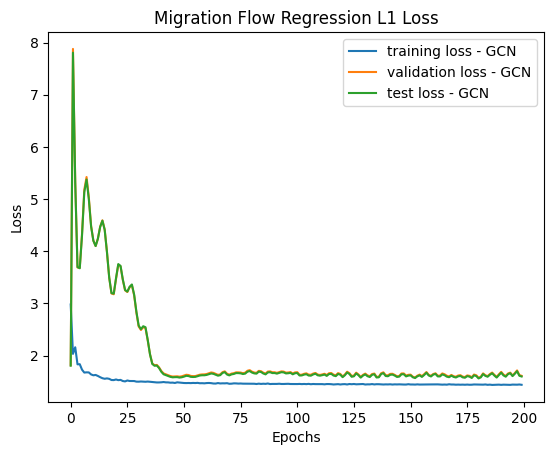

Running pipeline with config: Regression_GCN_simple_within_state


Training:   1%|          | 2/200 [00:00<00:32,  6.08Epochs/s]

Epoch 1: Training Loss 2.72488, Training R2 -1.52033 Validation Loss 2.67337 Validation R2 -0.9212
Epoch 2: Training Loss 1.84559, Training R2 -0.07517 Validation Loss 10.33631 Validation R2 -19.78413


Training:   2%|▏         | 3/200 [00:00<00:36,  5.34Epochs/s]

Epoch 3: Training Loss 2.34357, Training R2 -0.94035 Validation Loss 7.30934 Validation R2 -9.762


Training:   2%|▏         | 4/200 [00:00<00:38,  5.05Epochs/s]

Epoch 4: Training Loss 1.84101, Training R2 -0.13959 Validation Loss 3.26407 Validation R2 -1.6366


Training:   2%|▎         | 5/200 [00:01<00:42,  4.56Epochs/s]

Epoch 5: Training Loss 1.80367, Training R2 0.02087 Validation Loss 2.07803 Validation R2 -0.23818


Training:   3%|▎         | 6/200 [00:01<00:41,  4.66Epochs/s]

Epoch 6: Training Loss 1.90971, Training R2 -0.06131 Validation Loss 2.41998 Validation R2 -0.59841
Epoch 7: Training Loss 1.8233, Training R2 -0.03598 Validation Loss 3.7301 Validation R2 -2.26256


Training:   4%|▍         | 8/200 [00:01<00:39,  4.84Epochs/s]

Epoch 8: Training Loss 1.73469, Training R2 -0.00498 Validation Loss 5.24326 Validation R2 -4.90334


Training:   4%|▍         | 9/200 [00:01<00:40,  4.66Epochs/s]

Epoch 9: Training Loss 1.70166, Training R2 0.00704 Validation Loss 5.9177 Validation R2 -6.38624


Training:   5%|▌         | 10/200 [00:02<00:42,  4.47Epochs/s]

Epoch 10: Training Loss 1.68303, Training R2 0.0225 Validation Loss 5.48805 Validation R2 -5.4759


Training:   6%|▌         | 11/200 [00:02<00:41,  4.56Epochs/s]

Epoch 11: Training Loss 1.65342, Training R2 0.06214 Validation Loss 4.54029 Validation R2 -3.63869


Training:   6%|▌         | 12/200 [00:02<00:41,  4.53Epochs/s]

Epoch 12: Training Loss 1.6636, Training R2 0.06623 Validation Loss 3.59883 Validation R2 -2.10618


Training:   6%|▋         | 13/200 [00:02<00:42,  4.44Epochs/s]

Epoch 13: Training Loss 1.65357, Training R2 0.10533 Validation Loss 2.96048 Validation R2 -1.22834


Training:   7%|▋         | 14/200 [00:03<00:42,  4.36Epochs/s]

Epoch 14: Training Loss 1.6242, Training R2 0.14499 Validation Loss 2.52525 Validation R2 -0.69838


Training:   8%|▊         | 15/200 [00:03<00:42,  4.31Epochs/s]

Epoch 15: Training Loss 1.60064, Training R2 0.17182 Validation Loss 2.27183 Validation R2 -0.41561


Training:   8%|▊         | 16/200 [00:03<00:41,  4.43Epochs/s]

Epoch 16: Training Loss 1.60331, Training R2 0.16347 Validation Loss 2.16164 Validation R2 -0.29812
Epoch 17: Training Loss 1.62871, Training R2 0.13408 Validation Loss 2.17332 Validation R2 -0.31034


Training:   9%|▉         | 18/200 [00:03<00:38,  4.76Epochs/s]

Epoch 18: Training Loss 1.61645, Training R2 0.13824 Validation Loss 2.20974 Validation R2 -0.34919


Training:  10%|▉         | 19/200 [00:04<00:37,  4.77Epochs/s]

Epoch 19: Training Loss 1.59988, Training R2 0.15542 Validation Loss 2.21978 Validation R2 -0.36173


Training:  10%|█         | 20/200 [00:04<00:38,  4.69Epochs/s]

Epoch 20: Training Loss 1.57952, Training R2 0.17473 Validation Loss 2.20359 Validation R2 -0.3473
Epoch 21: Training Loss 1.56507, Training R2 0.18669

Training:  10%|█         | 21/200 [00:04<00:37,  4.77Epochs/s]

 Validation Loss 2.19143 Validation R2 -0.33731
Epoch 22: Training Loss 1.55794, Training R2 0.19164 Validation Loss 2.19749 Validation R2 -0.34619


Training:  12%|█▏        | 23/200 [00:04<00:36,  4.90Epochs/s]

Epoch 23: Training Loss 1.57484, Training R2 0.1733 Validation Loss 2.2118 Validation R2 -0.36361
Epoch 24: Training Loss 1.58245, Training R2 0.16025 Validation Loss 2.17469 Validation R2 -0.32391


Training:  12%|█▎        | 25/200 [00:05<00:36,  4.84Epochs/s]

Epoch 25: Training Loss 1.56741, Training R2 0.16549 Validation Loss 2.02667 Validation R2 -0.16395


Training:  13%|█▎        | 26/200 [00:05<00:38,  4.50Epochs/s]

Epoch 26: Training Loss 1.55962, Training R2 0.17778 Validation Loss 1.85859 Validation R2 0.01316


Training:  14%|█▎        | 27/200 [00:05<00:37,  4.62Epochs/s]

Epoch 27: Training Loss 1.55006, Training R2 0.1884 Validation Loss 1.74006 Validation R2 0.14092


Training:  14%|█▍        | 28/200 [00:05<00:37,  4.56Epochs/s]

Epoch 28: Training Loss 1.54145, Training R2 0.19519 Validation Loss 1.68951 Validation R2 0.20407


Training:  14%|█▍        | 29/200 [00:06<00:38,  4.43Epochs/s]

Epoch 29: Training Loss 1.54981, Training R2 0.19245 Validation Loss 1.67932 Validation R2 0.21806


Training:  15%|█▌        | 30/200 [00:06<00:39,  4.28Epochs/s]

Epoch 30: Training Loss 1.5484, Training R2 0.19288 Validation Loss 1.6755 Validation R2 0.2223


Training:  16%|█▌        | 31/200 [00:06<00:40,  4.19Epochs/s]

Epoch 31: Training Loss 1.54716, Training R2 0.19338 Validation Loss 1.67327 Validation R2 0.22456


Training:  16%|█▌        | 32/200 [00:06<00:39,  4.27Epochs/s]

Epoch 32: Training Loss 1.54449, Training R2 0.19861 Validation Loss 1.68152 Validation R2 0.20711


Training:  16%|█▋        | 33/200 [00:07<00:38,  4.30Epochs/s]

Epoch 33: Training Loss 1.54275, Training R2 0.19698 Validation Loss 1.69312 Validation R2 0.18947


Training:  17%|█▋        | 34/200 [00:07<00:38,  4.32Epochs/s]

Epoch 34: Training Loss 1.53114, Training R2 0.20453 Validation Loss 1.71683 Validation R2 0.15944


Training:  18%|█▊        | 35/200 [00:07<00:38,  4.29Epochs/s]

Epoch 35: Training Loss 1.53628, Training R2 0.20043 Validation Loss 1.73092 Validation R2 0.14272


Training:  18%|█▊        | 36/200 [00:07<00:37,  4.38Epochs/s]

Epoch 36: Training Loss 1.53431, Training R2 0.2031 Validation Loss 1.72729 Validation R2 0.14602


Training:  18%|█▊        | 37/200 [00:08<00:36,  4.43Epochs/s]

Epoch 37: Training Loss 1.52934, Training R2 0.20451 Validation Loss 1.70215 Validation R2 0.17423


Training:  19%|█▉        | 38/200 [00:08<00:35,  4.55Epochs/s]

Epoch 38: Training Loss 1.52633, Training R2 0.20987 Validation Loss 1.67608 Validation R2 0.20641


Training:  20%|█▉        | 39/200 [00:08<00:35,  4.51Epochs/s]

Epoch 39: Training Loss 1.52459, Training R2 0.21306 Validation Loss 1.66351 Validation R2 0.23097


Training:  20%|██        | 40/200 [00:08<00:34,  4.65Epochs/s]

Epoch 40: Training Loss 1.52231, Training R2 0.21358 Validation Loss 1.67124 Validation R2 0.23799


Training:  20%|██        | 41/200 [00:08<00:34,  4.58Epochs/s]

Epoch 41: Training Loss 1.51825, Training R2 0.21755 Validation Loss 1.69023 Validation R2 0.23488


Training:  21%|██        | 42/200 [00:09<00:34,  4.56Epochs/s]

Epoch 42: Training Loss 1.51568, Training R2 0.21373 Validation Loss 1.69487 Validation R2 0.23442


Training:  22%|██▏       | 43/200 [00:09<00:35,  4.44Epochs/s]

Epoch 43: Training Loss 1.51501, Training R2 0.21664 Validation Loss 1.66919 Validation R2 0.23875


Training:  22%|██▏       | 44/200 [00:09<00:36,  4.30Epochs/s]

Epoch 44: Training Loss 1.51637, Training R2 0.21346 Validation Loss 1.6589 Validation R2 0.23559


Training:  22%|██▎       | 45/200 [00:09<00:37,  4.16Epochs/s]

Epoch 45: Training Loss 1.51051, Training R2 0.21932 Validation Loss 1.65428 Validation R2 0.23184


Training:  23%|██▎       | 46/200 [00:10<00:37,  4.14Epochs/s]

Epoch 46: Training Loss 1.50789, Training R2 0.22143 Validation Loss 1.64958 Validation R2 0.23101


Training:  24%|██▎       | 47/200 [00:10<00:35,  4.30Epochs/s]

Epoch 47: Training Loss 1.50902, Training R2 0.22208 Validation Loss 1.64664 Validation R2 0.23039


Training:  24%|██▍       | 48/200 [00:10<00:33,  4.55Epochs/s]

Epoch 48: Training Loss 1.51307, Training R2 0.22063 Validation Loss 1.65164 Validation R2 0.2189


Training:  24%|██▍       | 49/200 [00:10<00:32,  4.60Epochs/s]

Epoch 49: Training Loss 1.50588, Training R2 0.22475 Validation Loss 1.67055 Validation R2 0.19508
Epoch 50: Training Loss 1.50594, Training R2 0.22012 Validation Loss 1.66206 Validation R2 0.20527


Training:  26%|██▌       | 51/200 [00:11<00:33,  4.51Epochs/s]

Epoch 51: Training Loss 1.50185, Training R2 0.22496 Validation Loss 1.64623 Validation R2 0.22852


Training:  26%|██▌       | 52/200 [00:11<00:31,  4.63Epochs/s]

Epoch 52: Training Loss 1.49836, Training R2 0.23018 Validation Loss 1.64254 Validation R2 0.23729


Training:  26%|██▋       | 53/200 [00:11<00:31,  4.74Epochs/s]

Epoch 53: Training Loss 1.50274, Training R2 0.22913 Validation Loss 1.6477 Validation R2 0.22785


Training:  27%|██▋       | 54/200 [00:11<00:31,  4.70Epochs/s]

Epoch 54: Training Loss 1.49513, Training R2 0.23044 Validation Loss 1.66708 Validation R2 0.2023
Epoch 55: Training Loss 1.49742, Training R2 0.23069 Validation Loss 1.69422 Validation R2 0.17183


Training:  28%|██▊       | 56/200 [00:12<00:30,  4.74Epochs/s]

Epoch 56: Training Loss 1.49689, Training R2 0.22907 Validation Loss 1.71549 Validation R2 0.14915


Training:  28%|██▊       | 57/200 [00:12<00:31,  4.61Epochs/s]

Epoch 57: Training Loss 1.49475, Training R2 0.23147 Validation Loss 1.70319 Validation R2 0.16242


Training:  29%|██▉       | 58/200 [00:12<00:30,  4.68Epochs/s]

Epoch 58: Training Loss 1.49828, Training R2 0.23092 Validation Loss 1.69503 Validation R2 0.17144


Training:  30%|██▉       | 59/200 [00:12<00:31,  4.54Epochs/s]

Epoch 59: Training Loss 1.50179, Training R2 0.22637 Validation Loss 1.69112 Validation R2 0.17664


Training:  30%|███       | 60/200 [00:13<00:31,  4.48Epochs/s]

Epoch 60: Training Loss 1.49016, Training R2 0.23381 Validation Loss 1.75058 Validation R2 0.11774


Training:  30%|███       | 61/200 [00:13<00:31,  4.37Epochs/s]

Epoch 61: Training Loss 1.49085, Training R2 0.23483 Validation Loss 1.69353 Validation R2 0.17827


Training:  31%|███       | 62/200 [00:13<00:32,  4.29Epochs/s]

Epoch 62: Training Loss 1.48683, Training R2 0.24011 Validation Loss 1.67787 Validation R2 0.19807


Training:  32%|███▏      | 63/200 [00:13<00:31,  4.32Epochs/s]

Epoch 63: Training Loss 1.48747, Training R2 0.23616 Validation Loss 1.65353 Validation R2 0.23668


Training:  32%|███▏      | 64/200 [00:14<00:31,  4.29Epochs/s]

Epoch 64: Training Loss 1.49343, Training R2 0.22613 Validation Loss 1.6744 Validation R2 0.25775


Training:  32%|███▎      | 65/200 [00:14<00:32,  4.19Epochs/s]

Epoch 65: Training Loss 1.48912, Training R2 0.23775 Validation Loss 1.70719 Validation R2 0.24877


Training:  33%|███▎      | 66/200 [00:14<00:30,  4.38Epochs/s]

Epoch 66: Training Loss 1.48572, Training R2 0.24417 Validation Loss 1.69183 Validation R2 0.25397
Epoch 67: Training Loss 1.48894, Training R2 0.24104 Validation Loss 1.64126 Validation R2 0.23342


Training:  34%|███▍      | 68/200 [00:14<00:28,  4.69Epochs/s]

Epoch 68: Training Loss 1.48683, Training R2 0.22853 Validation Loss 1.69135 Validation R2 0.16617


Training:  34%|███▍      | 69/200 [00:15<00:28,  4.65Epochs/s]

Epoch 69: Training Loss 1.48793, Training R2 0.22405 Validation Loss 1.63259 Validation R2 0.22863
Epoch 70: Training Loss 1.48504, Training R2 0.23174 Validation Loss 1.62707 Validation R2 0.2628


Training:  36%|███▌      | 71/200 [00:15<00:26,  4.87Epochs/s]

Epoch 71: Training Loss 1.48557, Training R2 0.24562 Validation Loss 1.62468 Validation R2 0.26362
Epoch 72: Training Loss 1.48493, Training R2 0.24665

Training:  36%|███▌      | 72/200 [00:15<00:26,  4.86Epochs/s]

 Validation Loss 1.62106 Validation R2 0.24524
Epoch 73: Training Loss 1.48407, Training R2 0.2299 Validation Loss 1.64317 Validation R2 0.25787


Training:  38%|███▊      | 75/200 [00:16<00:23,  5.33Epochs/s]

Epoch 74: Training Loss 1.4835, Training R2 0.23636 Validation Loss 1.73186 Validation R2 0.22316
Epoch 75: Training Loss 1.48475, Training R2 0.24714 Validation Loss 1.72405 Validation R2 0.23603


Training:  38%|███▊      | 77/200 [00:16<00:21,  5.65Epochs/s]

Epoch 76: Training Loss 1.48148, Training R2 0.24896 Validation Loss 1.66536 Validation R2 0.22582
Epoch 77: Training Loss 1.48279, Training R2 0.23844 Validation Loss 1.73559 Validation R2 0.14495


Training:  40%|███▉      | 79/200 [00:16<00:20,  5.76Epochs/s]

Epoch 78: Training Loss 1.48539, Training R2 0.23407 Validation Loss 1.68126 Validation R2 0.20781
Epoch 79: Training Loss 1.48238, Training R2 0.24294 Validation Loss 1.65391 Validation R2 0.24886


Training:  40%|████      | 80/200 [00:17<00:21,  5.60Epochs/s]

Epoch 80: Training Loss 1.48165, Training R2 0.24281 Validation Loss 1.68196 Validation R2 0.25886
Epoch 81: Training Loss 1.47671, Training R2 0.24286 Validation Loss 1.70232 Validation R2 0.24582


Training:  42%|████▏     | 83/200 [00:17<00:20,  5.64Epochs/s]

Epoch 82: Training Loss 1.47536, Training R2 0.24516 Validation Loss 1.66743 Validation R2 0.25702
Epoch 83: Training Loss 1.47425, Training R2 0.24555 Validation Loss 1.65992 Validation R2 0.25878


Training:  42%|████▎     | 85/200 [00:18<00:20,  5.70Epochs/s]

Epoch 84: Training Loss 1.47425, Training R2 0.24699 Validation Loss 1.64473 Validation R2 0.26177
Epoch 85: Training Loss 1.47913, Training R2 0.24098 Validation Loss 1.63247 Validation R2 0.26273


Training:  44%|████▎     | 87/200 [00:18<00:20,  5.59Epochs/s]

Epoch 86: Training Loss 1.47427, Training R2 0.25125 Validation Loss 1.61581 Validation R2 0.2599
Epoch 87: Training Loss 1.47731, Training R2 0.237 Validation Loss 1.62032 Validation R2 0.25865


Training:  44%|████▍     | 89/200 [00:18<00:19,  5.80Epochs/s]

Epoch 88: Training Loss 1.47507, Training R2 0.23848 Validation Loss 1.67024 Validation R2 0.24554
Epoch 89: Training Loss 1.47622, Training R2 0.24617 Validation Loss 1.74334 Validation R2 0.21013


Training:  46%|████▌     | 91/200 [00:19<00:18,  5.87Epochs/s]

Epoch 90: Training Loss 1.47871, Training R2 0.25017 Validation Loss 1.75104 Validation R2 0.206
Epoch 91: Training Loss 1.47476, Training R2 0.25315 Validation Loss 1.72095 Validation R2 0.22149


Training:  46%|████▋     | 93/200 [00:19<00:18,  5.78Epochs/s]

Epoch 92: Training Loss 1.47288, Training R2 0.24279 Validation Loss 1.71462 Validation R2 0.22452
Epoch 93: Training Loss 1.47426, Training R2 0.2436 Validation Loss 1.76031 Validation R2 0.20174


Training:  47%|████▋     | 94/200 [00:19<00:19,  5.36Epochs/s]

Epoch 94: Training Loss 1.4695, Training R2 0.25197 Validation Loss 1.79589 Validation R2 0.18203


Training:  48%|████▊     | 95/200 [00:19<00:21,  4.90Epochs/s]

Epoch 95: Training Loss 1.47495, Training R2 0.24901 Validation Loss 1.7369 Validation R2 0.21813


Training:  48%|████▊     | 96/200 [00:20<00:21,  4.74Epochs/s]

Epoch 96: Training Loss 1.47025, Training R2 0.24671 Validation Loss 1.69987 Validation R2 0.23776


Training:  48%|████▊     | 97/200 [00:20<00:21,  4.72Epochs/s]

Epoch 97: Training Loss 1.47504, Training R2 0.23955 Validation Loss 1.70011 Validation R2 0.23668


Training:  49%|████▉     | 98/200 [00:20<00:21,  4.83Epochs/s]

Epoch 98: Training Loss 1.4675, Training R2 0.24659 Validation Loss 1.73041 Validation R2 0.22089
Epoch 99: Training Loss 1.47826, Training R2 0.2529 Validation Loss 1.66421 Validation R2 0.24821


Training:  50%|█████     | 100/200 [00:20<00:20,  4.96Epochs/s]

Epoch 100: Training Loss 1.469, Training R2 0.24927 Validation Loss 1.63633 Validation R2 0.25518
Epoch 101: Training Loss 1.47116, Training R2 0.23685

Training:  50%|█████     | 101/200 [00:21<00:19,  4.97Epochs/s]

 Validation Loss 1.68341 Validation R2 0.23786
Epoch 102: Training Loss 1.47508, Training R2 0.23924 Validation Loss 1.76118 Validation R2 0.20158


Training:  52%|█████▏    | 103/200 [00:21<00:20,  4.68Epochs/s]

Epoch 103: Training Loss 1.47118, Training R2 0.25973 Validation Loss 1.72214 Validation R2 0.22379


Training:  52%|█████▏    | 104/200 [00:21<00:21,  4.55Epochs/s]

Epoch 104: Training Loss 1.47091, Training R2 0.25306 Validation Loss 1.66352 Validation R2 0.25157


Training:  52%|█████▎    | 105/200 [00:22<00:21,  4.49Epochs/s]

Epoch 105: Training Loss 1.47065, Training R2 0.24615 Validation Loss 1.66482 Validation R2 0.25297


Training:  53%|█████▎    | 106/200 [00:22<00:21,  4.42Epochs/s]

Epoch 106: Training Loss 1.47402, Training R2 0.24272 Validation Loss 1.7058 Validation R2 0.23823


Training:  54%|█████▎    | 107/200 [00:22<00:20,  4.50Epochs/s]

Epoch 107: Training Loss 1.46645, Training R2 0.25396 Validation Loss 1.72314 Validation R2 0.23215


Training:  54%|█████▍    | 108/200 [00:22<00:20,  4.55Epochs/s]

Epoch 108: Training Loss 1.47482, Training R2 0.25566 Validation Loss 1.64525 Validation R2 0.264


Training:  55%|█████▍    | 109/200 [00:22<00:20,  4.45Epochs/s]

Epoch 109: Training Loss 1.46574, Training R2 0.24782 Validation Loss 1.62788 Validation R2 0.26668


Training:  55%|█████▌    | 110/200 [00:23<00:20,  4.37Epochs/s]

Epoch 110: Training Loss 1.46849, Training R2 0.24297 Validation Loss 1.69027 Validation R2 0.2506


Training:  56%|█████▌    | 111/200 [00:23<00:19,  4.60Epochs/s]

Epoch 111: Training Loss 1.46542, Training R2 0.25262 Validation Loss 1.75048 Validation R2 0.22414


Training:  56%|█████▌    | 112/200 [00:23<00:19,  4.58Epochs/s]

Epoch 112: Training Loss 1.46797, Training R2 0.25587 Validation Loss 1.70516 Validation R2 0.24744
Epoch 113: Training Loss 1.46616, Training R2 0.25065 Validation Loss 1.64953 Validation R2 0.26904


Training:  57%|█████▋    | 114/200 [00:23<00:17,  4.91Epochs/s]

Epoch 114: Training Loss 1.47016, Training R2 0.23777 Validation Loss 1.64657 Validation R2 0.26933


Training:  57%|█████▊    | 115/200 [00:24<00:17,  4.83Epochs/s]

Epoch 115: Training Loss 1.46764, Training R2 0.25015 Validation Loss 1.6392 Validation R2 0.25044


Training:  58%|█████▊    | 116/200 [00:24<00:17,  4.70Epochs/s]

Epoch 116: Training Loss 1.4717, Training R2 0.25168 Validation Loss 1.72883 Validation R2 0.1332


Training:  58%|█████▊    | 117/200 [00:24<00:17,  4.73Epochs/s]

Epoch 117: Training Loss 1.46698, Training R2 0.2545 Validation Loss 1.9769 Validation R2 -0.1205


Training:  59%|█████▉    | 118/200 [00:24<00:17,  4.59Epochs/s]

Epoch 118: Training Loss 1.46664, Training R2 0.24392 Validation Loss 1.99411 Validation R2 -0.13841


Training:  60%|█████▉    | 119/200 [00:25<00:18,  4.46Epochs/s]

Epoch 119: Training Loss 1.46687, Training R2 0.24646 Validation Loss 1.82045 Validation R2 0.03705


Training:  60%|██████    | 120/200 [00:25<00:18,  4.40Epochs/s]

Epoch 120: Training Loss 1.46778, Training R2 0.25669 Validation Loss 1.81273 Validation R2 0.04435


Training:  60%|██████    | 121/200 [00:25<00:17,  4.45Epochs/s]

Epoch 121: Training Loss 1.46794, Training R2 0.25484 Validation Loss 1.85822 Validation R2 -0.00187


Training:  61%|██████    | 122/200 [00:25<00:17,  4.46Epochs/s]

Epoch 122: Training Loss 1.46819, Training R2 0.24333 Validation Loss 1.76254 Validation R2 0.093
Epoch 123: Training Loss 1.46455, Training R2 0.25106 Validation Loss 1.69639 Validation R2 0.1624


Training:  62%|██████▏   | 124/200 [00:26<00:16,  4.60Epochs/s]

Epoch 124: Training Loss 1.46471, Training R2 0.25461 Validation Loss 1.67678 Validation R2 0.18349
Epoch 125: Training Loss 1.46117, Training R2 0.25597

Training:  62%|██████▎   | 125/200 [00:26<00:16,  4.65Epochs/s]

 Validation Loss 1.65601 Validation R2 0.20389


Training:  63%|██████▎   | 126/200 [00:26<00:16,  4.60Epochs/s]

Epoch 126: Training Loss 1.46851, Training R2 0.24424 Validation Loss 1.61689 Validation R2 0.25745


Training:  64%|██████▎   | 127/200 [00:26<00:16,  4.51Epochs/s]

Epoch 127: Training Loss 1.46276, Training R2 0.25462 Validation Loss 1.6163 Validation R2 0.27084
Epoch 128: Training Loss 1.46406, Training R2 0.25565 Validation Loss 1.61312 Validation R2 0.27229


Training:  65%|██████▌   | 130/200 [00:27<00:12,  5.42Epochs/s]

Epoch 129: Training Loss 1.46408, Training R2 0.24668 Validation Loss 1.62364 Validation R2 0.27339
Epoch 130: Training Loss 1.46134, Training R2 0.25197 Validation Loss 1.65156 Validation R2 0.2677


Training:  66%|██████▌   | 132/200 [00:27<00:12,  5.61Epochs/s]

Epoch 131: Training Loss 1.4657, Training R2 0.25276 Validation Loss 1.64916 Validation R2 0.26798
Epoch 132: Training Loss 1.46151, Training R2 0.25418 Validation Loss 1.63967 Validation R2 0.26911


Training:  67%|██████▋   | 134/200 [00:28<00:11,  5.60Epochs/s]

Epoch 133: Training Loss 1.46724, Training R2 0.24612 Validation Loss 1.67812 Validation R2 0.2566
Epoch 134: Training Loss 1.46143, Training R2 0.25412 Validation Loss 1.7403 Validation R2 0.2275


Training:  68%|██████▊   | 136/200 [00:28<00:11,  5.73Epochs/s]

Epoch 135: Training Loss 1.46547, Training R2 0.25501 Validation Loss 1.74926 Validation R2 0.22028
Epoch 136: Training Loss 1.4577, Training R2 0.25719 Validation Loss 1.76804 Validation R2 0.20892


Training:  69%|██████▉   | 138/200 [00:28<00:10,  5.80Epochs/s]

Epoch 137: Training Loss 1.46288, Training R2 0.25291 Validation Loss 1.74861 Validation R2 0.21882
Epoch 138: Training Loss 1.46429, Training R2 0.24526 Validation Loss 1.82074 Validation R2 0.17885


Training:  70%|███████   | 140/200 [00:29<00:10,  5.75Epochs/s]

Epoch 139: Training Loss 1.46169, Training R2 0.25742 Validation Loss 1.84923 Validation R2 0.15963
Epoch 140: Training Loss 1.46197, Training R2 0.25654 Validation Loss 1.8273 Validation R2 0.17322


Training:  71%|███████   | 142/200 [00:29<00:09,  5.87Epochs/s]

Epoch 141: Training Loss 1.45865, Training R2 0.25309 Validation Loss 1.80949 Validation R2 0.18595
Epoch 142: Training Loss 1.45906, Training R2 0.25457 Validation Loss 1.80548 Validation R2 0.19063


Training:  72%|███████▏  | 144/200 [00:29<00:09,  5.95Epochs/s]

Epoch 143: Training Loss 1.45882, Training R2 0.25556 Validation Loss 1.80905 Validation R2 0.18756
Epoch 144: Training Loss 1.45897, Training R2 0.25713 Validation Loss 1.79723 Validation R2 0.19326


Training:  73%|███████▎  | 146/200 [00:30<00:09,  5.89Epochs/s]

Epoch 145: Training Loss 1.45662, Training R2 0.25696 Validation Loss 1.74657 Validation R2 0.22578
Epoch 146: Training Loss 1.46054, Training R2 0.25795 Validation Loss 1.68627 Validation R2 0.25731


Training:  74%|███████▍  | 148/200 [00:30<00:08,  5.95Epochs/s]

Epoch 147: Training Loss 1.46171, Training R2 0.25123 Validation Loss 1.69487 Validation R2 0.25677
Epoch 148: Training Loss 1.4586, Training R2 0.25612 Validation Loss 1.68031 Validation R2 0.26278


Training:  75%|███████▌  | 150/200 [00:30<00:08,  6.01Epochs/s]

Epoch 149: Training Loss 1.45981, Training R2 0.25787 Validation Loss 1.65428 Validation R2 0.27033
Epoch 150: Training Loss 1.45841, Training R2 0.25444 Validation Loss 1.65044 Validation R2 0.26986


Training:  76%|███████▌  | 152/200 [00:31<00:08,  5.96Epochs/s]

Epoch 151: Training Loss 1.45893, Training R2 0.25612 Validation Loss 1.65297 Validation R2 0.26797
Epoch 152: Training Loss 1.45619, Training R2 0.25405 Validation Loss 1.66697 Validation R2 0.26348


Training:  77%|███████▋  | 154/200 [00:31<00:07,  6.01Epochs/s]

Epoch 153: Training Loss 1.4609, Training R2 0.25752 Validation Loss 1.67354 Validation R2 0.25975
Epoch 154: Training Loss 1.45609, Training R2 0.2603 Validation Loss 1.64666 Validation R2 0.26813


Training:  78%|███████▊  | 156/200 [00:31<00:07,  5.91Epochs/s]

Epoch 155: Training Loss 1.45631, Training R2 0.25387 Validation Loss 1.67047 Validation R2 0.26085
Epoch 156: Training Loss 1.45694, Training R2 0.25632 Validation Loss 1.7119 Validation R2 0.24415


Training:  79%|███████▉  | 158/200 [00:32<00:07,  5.91Epochs/s]

Epoch 157: Training Loss 1.46057, Training R2 0.25917 Validation Loss 1.68925 Validation R2 0.25145
Epoch 158: Training Loss 1.45655, Training R2 0.25483 Validation Loss 1.72874 Validation R2 0.23049


Training:  80%|████████  | 160/200 [00:32<00:06,  5.97Epochs/s]

Epoch 159: Training Loss 1.45202, Training R2 0.25995 Validation Loss 1.79813 Validation R2 0.1897
Epoch 160: Training Loss 1.45867, Training R2 0.2626 Validation Loss 1.7496 Validation R2 0.21286


Training:  81%|████████  | 162/200 [00:32<00:06,  6.03Epochs/s]

Epoch 161: Training Loss 1.4559, Training R2 0.25567 Validation Loss 1.73562 Validation R2 0.21714
Epoch 162: Training Loss 1.46053, Training R2 0.24226 Validation Loss 1.89737 Validation R2 0.11518


Training:  82%|████████▏ | 164/200 [00:33<00:06,  5.97Epochs/s]

Epoch 163: Training Loss 1.45825, Training R2 0.26477 Validation Loss 1.80268 Validation R2 0.18256
Epoch 164: Training Loss 1.45667, Training R2 0.25741 Validation Loss 1.66709 Validation R2 0.25699


Training:  83%|████████▎ | 166/200 [00:33<00:05,  6.07Epochs/s]

Epoch 165: Training Loss 1.46417, Training R2 0.24147 Validation Loss 1.70481 Validation R2 0.24075
Epoch 166: Training Loss 1.4571, Training R2 0.25444 Validation Loss 1.74988 Validation R2 0.21847


Training:  84%|████████▍ | 168/200 [00:33<00:05,  6.13Epochs/s]

Epoch 167: Training Loss 1.4631, Training R2 0.26283 Validation Loss 1.65036 Validation R2 0.2606
Epoch 168: Training Loss 1.45989, Training R2 0.25088 Validation Loss 1.62209 Validation R2 0.26699


Training:  85%|████████▌ | 170/200 [00:34<00:05,  5.80Epochs/s]

Epoch 169: Training Loss 1.46574, Training R2 0.24143 Validation Loss 1.6762 Validation R2 0.25298
Epoch 170: Training Loss 1.45773, Training R2 0.26389 Validation Loss 1.65646 Validation R2 0.26151


Training:  86%|████████▌ | 172/200 [00:34<00:04,  5.86Epochs/s]

Epoch 171: Training Loss 1.45789, Training R2 0.26206 Validation Loss 1.6089 Validation R2 0.27158
Epoch 172: Training Loss 1.45541, Training R2 0.25351 Validation Loss 1.60721 Validation R2 0.27301


Training:  87%|████████▋ | 174/200 [00:34<00:04,  5.90Epochs/s]

Epoch 173: Training Loss 1.45237, Training R2 0.25515 Validation Loss 1.64056 Validation R2 0.26938
Epoch 174: Training Loss 1.45554, Training R2 0.25788 Validation Loss 1.65068 Validation R2 0.26881


Training:  88%|████████▊ | 175/200 [00:35<00:04,  5.67Epochs/s]

Epoch 175: Training Loss 1.4574, Training R2 0.26367 Validation Loss 1.60349 Validation R2 0.27064
Epoch 176: Training Loss 1.45728, Training R2 0.25073 Validation Loss 1.60835 Validation R2 0.27148


Training:  89%|████████▉ | 178/200 [00:35<00:03,  5.85Epochs/s]

Epoch 177: Training Loss 1.45362, Training R2 0.25235 Validation Loss 1.66973 Validation R2 0.26461
Epoch 178: Training Loss 1.4628, Training R2 0.26402 Validation Loss 1.64647 Validation R2 0.27152


Training:  90%|█████████ | 180/200 [00:35<00:03,  5.73Epochs/s]

Epoch 179: Training Loss 1.45859, Training R2 0.25474 Validation Loss 1.62505 Validation R2 0.27586
Epoch 180: Training Loss 1.45652, Training R2 0.24929 Validation Loss 1.65141 Validation R2 0.27103


Training:  91%|█████████ | 182/200 [00:36<00:03,  5.76Epochs/s]

Epoch 181: Training Loss 1.45328, Training R2 0.26015 Validation Loss 1.65704 Validation R2 0.26961
Epoch 182: Training Loss 1.45462, Training R2 0.26069 Validation Loss 1.63112 Validation R2 0.275


Training:  92%|█████████▏| 184/200 [00:36<00:02,  5.86Epochs/s]

Epoch 183: Training Loss 1.45323, Training R2 0.25519 Validation Loss 1.64162 Validation R2 0.27267
Epoch 184: Training Loss 1.45388, Training R2 0.25638 Validation Loss 1.69773 Validation R2 0.25373


Training:  92%|█████████▎| 185/200 [00:36<00:02,  5.78Epochs/s]

Epoch 185: Training Loss 1.457, Training R2 0.26021 Validation Loss 1.70609 Validation R2 0.24937
Epoch 186: Training Loss 1.45525, Training R2 0.25993 Validation Loss 1.68546 Validation R2 0.2571


Training:  94%|█████████▎| 187/200 [00:37<00:02,  5.17Epochs/s]

Epoch 187: Training Loss 1.45531, Training R2 0.25034 Validation Loss 1.76249 Validation R2 0.22695


Training:  94%|█████████▍| 188/200 [00:37<00:02,  5.02Epochs/s]

Epoch 188: Training Loss 1.45497, Training R2 0.26083 Validation Loss 1.77505 Validation R2 0.2239


Training:  94%|█████████▍| 189/200 [00:37<00:02,  4.87Epochs/s]

Epoch 189: Training Loss 1.45811, Training R2 0.26447 Validation Loss 1.65859 Validation R2 0.27253
Epoch 190: Training Loss 1.45814, Training R2 0.24285 Validation Loss 1.69515 Validation R2 0.25986


Training:  96%|█████████▌| 191/200 [00:38<00:01,  5.06Epochs/s]

Epoch 191: Training Loss 1.45441, Training R2 0.25672 Validation Loss 1.74506 Validation R2 0.23552
Epoch 192: Training Loss 1.45559, Training R2 0.26376 Validation Loss 1.66459 Validation R2 0.26563


Training:  96%|█████████▋| 193/200 [00:38<00:01,  4.93Epochs/s]

Epoch 193: Training Loss 1.45271, Training R2 0.25209 Validation Loss 1.64794 Validation R2 0.26666
Epoch 194: Training Loss 1.45648, Training R2 0.2457 Validation Loss 1.75236 Validation R2 0.21942


Training:  98%|█████████▊| 195/200 [00:38<00:00,  5.02Epochs/s]

Epoch 195: Training Loss 1.45308, Training R2 0.26654 Validation Loss 1.72778 Validation R2 0.22878


Training:  98%|█████████▊| 196/200 [00:39<00:00,  4.88Epochs/s]

Epoch 196: Training Loss 1.45579, Training R2 0.26429 Validation Loss 1.63744 Validation R2 0.2639


Training:  98%|█████████▊| 197/200 [00:39<00:00,  4.68Epochs/s]

Epoch 197: Training Loss 1.45813, Training R2 0.24593 Validation Loss 1.67701 Validation R2 0.25353


Training:  99%|█████████▉| 198/200 [00:39<00:00,  4.48Epochs/s]

Epoch 198: Training Loss 1.45309, Training R2 0.25866 Validation Loss 1.68556 Validation R2 0.25324


Training: 100%|█████████▉| 199/200 [00:39<00:00,  4.54Epochs/s]

Epoch 199: Training Loss 1.4568, Training R2 0.26359 Validation Loss 1.61063 Validation R2 0.27502


Training: 100%|██████████| 200/200 [00:40<00:00,  5.00Epochs/s]

Epoch 200: Training Loss 1.45282, Training R2 0.25284 Validation Loss 1.59715 Validation R2 0.27195
Saving Model Predictions for Model Type GCN
Model saved successfully as Regression_GCN_simple_within_state
Minimum validation loss: 1.5971518754959106
Minimum test loss: 1.5662510395050049
Best test metric: 0.27704477310180664


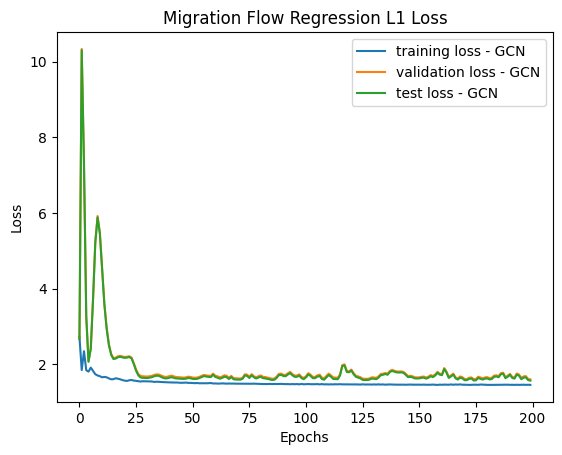

Running pipeline with config: Classification_GCN_full_full


Training:   0%|          | 1/200 [00:00<01:57,  1.69Epochs/s]

Epoch 1: Training Loss 1.64292, Training F1 Score (Micro) 0.23364 Validation Loss 1.67162 Validation F1 Score (Micro) 0.43207


Training:   1%|          | 2/200 [00:01<01:54,  1.73Epochs/s]

Epoch 2: Training Loss 1.46739, Training F1 Score (Micro) 0.47486 Validation Loss 2.98796 Validation F1 Score (Micro) 0.1232


Training:   2%|▏         | 3/200 [00:01<01:41,  1.95Epochs/s]

Epoch 3: Training Loss 1.39822, Training F1 Score (Micro) 0.44196 Validation Loss 2.4255 Validation F1 Score (Micro) 0.13926


Training:   2%|▏         | 4/200 [00:02<01:40,  1.94Epochs/s]

Epoch 4: Training Loss 1.33552, Training F1 Score (Micro) 0.48324 Validation Loss 1.58046 Validation F1 Score (Micro) 0.39674


Training:   2%|▎         | 5/200 [00:02<01:40,  1.94Epochs/s]

Epoch 5: Training Loss 1.34873, Training F1 Score (Micro) 0.48475 Validation Loss 3.2223 Validation F1 Score (Micro) 0.1414


Training:   3%|▎         | 6/200 [00:03<01:36,  2.00Epochs/s]

Epoch 6: Training Loss 1.34571, Training F1 Score (Micro) 0.48141 Validation Loss 2.74915 Validation F1 Score (Micro) 0.1516


Training:   4%|▎         | 7/200 [00:03<01:33,  2.06Epochs/s]

Epoch 7: Training Loss 1.33421, Training F1 Score (Micro) 0.48003 Validation Loss 1.95758 Validation F1 Score (Micro) 0.17081


Training:   4%|▍         | 8/200 [00:04<01:32,  2.08Epochs/s]

Epoch 8: Training Loss 1.30576, Training F1 Score (Micro) 0.4824 Validation Loss 1.70372 Validation F1 Score (Micro) 0.24948


Training:   4%|▍         | 9/200 [00:04<01:33,  2.05Epochs/s]

Epoch 9: Training Loss 1.30719, Training F1 Score (Micro) 0.48234 Validation Loss 1.57514 Validation F1 Score (Micro) 0.38515


Training:   5%|▌         | 10/200 [00:05<01:34,  2.01Epochs/s]

Epoch 10: Training Loss 1.31078, Training F1 Score (Micro) 0.48138 Validation Loss 1.52618 Validation F1 Score (Micro) 0.40625


Training:   6%|▌         | 11/200 [00:05<01:31,  2.07Epochs/s]

Epoch 11: Training Loss 1.30186, Training F1 Score (Micro) 0.4801 Validation Loss 1.57105 Validation F1 Score (Micro) 0.36707


Training:   6%|▌         | 12/200 [00:05<01:29,  2.11Epochs/s]

Epoch 12: Training Loss 1.29155, Training F1 Score (Micro) 0.48502 Validation Loss 1.66271 Validation F1 Score (Micro) 0.32437


Training:   6%|▋         | 13/200 [00:06<01:28,  2.10Epochs/s]

Epoch 13: Training Loss 1.28829, Training F1 Score (Micro) 0.49056 Validation Loss 1.7047 Validation F1 Score (Micro) 0.31385


Training:   7%|▋         | 14/200 [00:06<01:28,  2.09Epochs/s]

Epoch 14: Training Loss 1.2856, Training F1 Score (Micro) 0.49353 Validation Loss 1.67093 Validation F1 Score (Micro) 0.33967


Training:   8%|▊         | 15/200 [00:07<01:28,  2.08Epochs/s]

Epoch 15: Training Loss 1.28349, Training F1 Score (Micro) 0.49352 Validation Loss 1.59577 Validation F1 Score (Micro) 0.38206


Training:   8%|▊         | 16/200 [00:07<01:26,  2.12Epochs/s]

Epoch 16: Training Loss 1.28291, Training F1 Score (Micro) 0.49495 Validation Loss 1.50515 Validation F1 Score (Micro) 0.41966


Training:   8%|▊         | 17/200 [00:08<01:25,  2.13Epochs/s]

Epoch 17: Training Loss 1.28265, Training F1 Score (Micro) 0.49601 Validation Loss 1.42263 Validation F1 Score (Micro) 0.45582


Training:   9%|▉         | 18/200 [00:08<01:24,  2.15Epochs/s]

Epoch 18: Training Loss 1.27998, Training F1 Score (Micro) 0.49704 Validation Loss 1.36424 Validation F1 Score (Micro) 0.47855


Training:  10%|▉         | 19/200 [00:09<01:22,  2.18Epochs/s]

Epoch 19: Training Loss 1.27648, Training F1 Score (Micro) 0.49621 Validation Loss 1.33711 Validation F1 Score (Micro) 0.48492


Training:  10%|█         | 20/200 [00:09<01:21,  2.21Epochs/s]

Epoch 20: Training Loss 1.27781, Training F1 Score (Micro) 0.49611 Validation Loss 1.33789 Validation F1 Score (Micro) 0.48258


Training:  10%|█         | 21/200 [00:10<01:22,  2.16Epochs/s]

Epoch 21: Training Loss 1.27676, Training F1 Score (Micro) 0.49691 Validation Loss 1.36309 Validation F1 Score (Micro) 0.4693


Training:  11%|█         | 22/200 [00:10<01:29,  2.00Epochs/s]

Epoch 22: Training Loss 1.27452, Training F1 Score (Micro) 0.49641 Validation Loss 1.38051 Validation F1 Score (Micro) 0.4635


Training:  12%|█▏        | 23/200 [00:11<01:35,  1.85Epochs/s]

Epoch 23: Training Loss 1.27437, Training F1 Score (Micro) 0.49717 Validation Loss 1.38338 Validation F1 Score (Micro) 0.46136


Training:  12%|█▏        | 24/200 [00:11<01:37,  1.81Epochs/s]

Epoch 24: Training Loss 1.27463, Training F1 Score (Micro) 0.49641 Validation Loss 1.37203 Validation F1 Score (Micro) 0.46375


Training:  12%|█▎        | 25/200 [00:12<01:41,  1.72Epochs/s]

Epoch 25: Training Loss 1.27422, Training F1 Score (Micro) 0.49593 Validation Loss 1.34939 Validation F1 Score (Micro) 0.47383


Training:  13%|█▎        | 26/200 [00:13<01:41,  1.72Epochs/s]

Epoch 26: Training Loss 1.27246, Training F1 Score (Micro) 0.49661 Validation Loss 1.32491 Validation F1 Score (Micro) 0.48051


Training:  14%|█▎        | 27/200 [00:13<01:43,  1.68Epochs/s]

Epoch 27: Training Loss 1.27176, Training F1 Score (Micro) 0.49706 Validation Loss 1.30364 Validation F1 Score (Micro) 0.48788


Training:  14%|█▍        | 28/200 [00:14<01:43,  1.66Epochs/s]

Epoch 28: Training Loss 1.2707, Training F1 Score (Micro) 0.49568 Validation Loss 1.28771 Validation F1 Score (Micro) 0.49134


Training:  14%|█▍        | 29/200 [00:15<01:42,  1.66Epochs/s]

Epoch 29: Training Loss 1.26997, Training F1 Score (Micro) 0.49766 Validation Loss 1.27808 Validation F1 Score (Micro) 0.49594


Training:  15%|█▌        | 30/200 [00:15<01:36,  1.76Epochs/s]

Epoch 30: Training Loss 1.26946, Training F1 Score (Micro) 0.49742 Validation Loss 1.27321 Validation F1 Score (Micro) 0.49701


Training:  16%|█▌        | 31/200 [00:16<01:32,  1.83Epochs/s]

Epoch 31: Training Loss 1.26975, Training F1 Score (Micro) 0.49698 Validation Loss 1.27177 Validation F1 Score (Micro) 0.49783


Training:  16%|█▌        | 32/200 [00:16<01:28,  1.89Epochs/s]

Epoch 32: Training Loss 1.2698, Training F1 Score (Micro) 0.49782 Validation Loss 1.27223 Validation F1 Score (Micro) 0.49707


Training:  16%|█▋        | 33/200 [00:16<01:26,  1.92Epochs/s]

Epoch 33: Training Loss 1.26859, Training F1 Score (Micro) 0.4974 Validation Loss 1.27211 Validation F1 Score (Micro) 0.49726


Training:  17%|█▋        | 34/200 [00:17<01:24,  1.96Epochs/s]

Epoch 34: Training Loss 1.2683, Training F1 Score (Micro) 0.49677 Validation Loss 1.27214 Validation F1 Score (Micro) 0.49556


Training:  18%|█▊        | 35/200 [00:17<01:22,  2.00Epochs/s]

Epoch 35: Training Loss 1.26807, Training F1 Score (Micro) 0.49749 Validation Loss 1.27204 Validation F1 Score (Micro) 0.49411


Training:  18%|█▊        | 36/200 [00:18<01:19,  2.06Epochs/s]

Epoch 36: Training Loss 1.26803, Training F1 Score (Micro) 0.49696 Validation Loss 1.27085 Validation F1 Score (Micro) 0.49392


Training:  18%|█▊        | 37/200 [00:18<01:16,  2.12Epochs/s]

Epoch 37: Training Loss 1.26843, Training F1 Score (Micro) 0.49582 Validation Loss 1.26855 Validation F1 Score (Micro) 0.49531


Training:  19%|█▉        | 38/200 [00:19<01:15,  2.16Epochs/s]

Epoch 38: Training Loss 1.26748, Training F1 Score (Micro) 0.49667 Validation Loss 1.26567 Validation F1 Score (Micro) 0.49707


Training:  20%|█▉        | 39/200 [00:19<01:14,  2.18Epochs/s]

Epoch 39: Training Loss 1.26698, Training F1 Score (Micro) 0.49624 Validation Loss 1.26323 Validation F1 Score (Micro) 0.49846


Training:  20%|██        | 40/200 [00:20<01:12,  2.20Epochs/s]

Epoch 40: Training Loss 1.26635, Training F1 Score (Micro) 0.49688 Validation Loss 1.26195 Validation F1 Score (Micro) 0.49959


Training:  20%|██        | 41/200 [00:20<01:11,  2.21Epochs/s]

Epoch 41: Training Loss 1.26599, Training F1 Score (Micro) 0.49815 Validation Loss 1.26155 Validation F1 Score (Micro) 0.50104


Training:  21%|██        | 42/200 [00:21<01:11,  2.22Epochs/s]

Epoch 42: Training Loss 1.26635, Training F1 Score (Micro) 0.49908 Validation Loss 1.26138 Validation F1 Score (Micro) 0.50091


Training:  22%|██▏       | 43/200 [00:21<01:13,  2.12Epochs/s]

Epoch 43: Training Loss 1.26561, Training F1 Score (Micro) 0.49835 Validation Loss 1.26121 Validation F1 Score (Micro) 0.5006


Training:  22%|██▏       | 44/200 [00:22<01:15,  2.07Epochs/s]

Epoch 44: Training Loss 1.26576, Training F1 Score (Micro) 0.49821 Validation Loss 1.26124 Validation F1 Score (Micro) 0.49959


Training:  22%|██▎       | 45/200 [00:22<01:12,  2.13Epochs/s]

Epoch 45: Training Loss 1.26532, Training F1 Score (Micro) 0.49843 Validation Loss 1.2618 Validation F1 Score (Micro) 0.49852


Training:  23%|██▎       | 46/200 [00:23<01:11,  2.15Epochs/s]

Epoch 46: Training Loss 1.26552, Training F1 Score (Micro) 0.49791 Validation Loss 1.26283 Validation F1 Score (Micro) 0.49827


Training:  24%|██▎       | 47/200 [00:23<01:11,  2.14Epochs/s]

Epoch 47: Training Loss 1.2645, Training F1 Score (Micro) 0.49764 Validation Loss 1.26381 Validation F1 Score (Micro) 0.49783


Training:  24%|██▍       | 48/200 [00:23<01:12,  2.11Epochs/s]

Epoch 48: Training Loss 1.26466, Training F1 Score (Micro) 0.49704 Validation Loss 1.26443 Validation F1 Score (Micro) 0.49808


Training:  24%|██▍       | 49/200 [00:24<01:09,  2.17Epochs/s]

Epoch 49: Training Loss 1.26457, Training F1 Score (Micro) 0.49792 Validation Loss 1.264 Validation F1 Score (Micro) 0.49776


Training:  25%|██▌       | 50/200 [00:24<01:08,  2.20Epochs/s]

Epoch 50: Training Loss 1.26469, Training F1 Score (Micro) 0.49758 Validation Loss 1.26247 Validation F1 Score (Micro) 0.49827


Training:  26%|██▌       | 51/200 [00:25<01:13,  2.04Epochs/s]

Epoch 51: Training Loss 1.26505, Training F1 Score (Micro) 0.49713 Validation Loss 1.26081 Validation F1 Score (Micro) 0.49896


Training:  26%|██▌       | 52/200 [00:26<01:19,  1.86Epochs/s]

Epoch 52: Training Loss 1.2637, Training F1 Score (Micro) 0.4974 Validation Loss 1.26 Validation F1 Score (Micro) 0.4994


Training:  26%|██▋       | 53/200 [00:26<01:19,  1.84Epochs/s]

Epoch 53: Training Loss 1.2642, Training F1 Score (Micro) 0.49752 Validation Loss 1.26004 Validation F1 Score (Micro) 0.50047


Training:  27%|██▋       | 54/200 [00:27<01:21,  1.79Epochs/s]

Epoch 54: Training Loss 1.26348, Training F1 Score (Micro) 0.49803 Validation Loss 1.26034 Validation F1 Score (Micro) 0.50054


Training:  28%|██▊       | 55/200 [00:27<01:23,  1.74Epochs/s]

Epoch 55: Training Loss 1.26389, Training F1 Score (Micro) 0.49824 Validation Loss 1.26014 Validation F1 Score (Micro) 0.50066


Training:  28%|██▊       | 56/200 [00:28<01:23,  1.72Epochs/s]

Epoch 56: Training Loss 1.26359, Training F1 Score (Micro) 0.49855 Validation Loss 1.25963 Validation F1 Score (Micro) 0.50066


Training:  28%|██▊       | 57/200 [00:29<01:24,  1.70Epochs/s]

Epoch 57: Training Loss 1.26308, Training F1 Score (Micro) 0.49894 Validation Loss 1.25923 Validation F1 Score (Micro) 0.49946


Training:  29%|██▉       | 58/200 [00:29<01:25,  1.66Epochs/s]

Epoch 58: Training Loss 1.26289, Training F1 Score (Micro) 0.49876 Validation Loss 1.2591 Validation F1 Score (Micro) 0.49978


Training:  30%|██▉       | 59/200 [00:30<01:24,  1.66Epochs/s]

Epoch 59: Training Loss 1.26267, Training F1 Score (Micro) 0.49836 Validation Loss 1.25891 Validation F1 Score (Micro) 0.49991


Training:  30%|███       | 60/200 [00:30<01:18,  1.79Epochs/s]

Epoch 60: Training Loss 1.26338, Training F1 Score (Micro) 0.49857 Validation Loss 1.25859 Validation F1 Score (Micro) 0.49965


Training:  30%|███       | 61/200 [00:31<01:12,  1.91Epochs/s]

Epoch 61: Training Loss 1.26263, Training F1 Score (Micro) 0.4978 Validation Loss 1.25847 Validation F1 Score (Micro) 0.49984


Training:  31%|███       | 62/200 [00:31<01:08,  2.00Epochs/s]

Epoch 62: Training Loss 1.26208, Training F1 Score (Micro) 0.49807 Validation Loss 1.25847 Validation F1 Score (Micro) 0.50003


Training:  32%|███▏      | 63/200 [00:32<01:06,  2.07Epochs/s]

Epoch 63: Training Loss 1.26217, Training F1 Score (Micro) 0.49849 Validation Loss 1.25844 Validation F1 Score (Micro) 0.50009


Training:  32%|███▏      | 64/200 [00:32<01:04,  2.11Epochs/s]

Epoch 64: Training Loss 1.26196, Training F1 Score (Micro) 0.49858 Validation Loss 1.2584 Validation F1 Score (Micro) 0.49959


Training:  32%|███▎      | 65/200 [00:32<01:02,  2.17Epochs/s]

Epoch 65: Training Loss 1.26187, Training F1 Score (Micro) 0.49852 Validation Loss 1.25853 Validation F1 Score (Micro) 0.49959


Training:  33%|███▎      | 66/200 [00:33<01:01,  2.18Epochs/s]

Epoch 66: Training Loss 1.26171, Training F1 Score (Micro) 0.49776 Validation Loss 1.25876 Validation F1 Score (Micro) 0.49896


Training:  34%|███▎      | 67/200 [00:33<01:00,  2.21Epochs/s]

Epoch 67: Training Loss 1.26197, Training F1 Score (Micro) 0.49825 Validation Loss 1.25878 Validation F1 Score (Micro) 0.49921


Training:  34%|███▍      | 68/200 [00:34<00:59,  2.21Epochs/s]

Epoch 68: Training Loss 1.26208, Training F1 Score (Micro) 0.49808 Validation Loss 1.25872 Validation F1 Score (Micro) 0.49991


Training:  34%|███▍      | 69/200 [00:34<00:58,  2.24Epochs/s]

Epoch 69: Training Loss 1.26138, Training F1 Score (Micro) 0.4991 Validation Loss 1.25931 Validation F1 Score (Micro) 0.50117


Training:  35%|███▌      | 70/200 [00:35<00:58,  2.21Epochs/s]

Epoch 70: Training Loss 1.26155, Training F1 Score (Micro) 0.49888 Validation Loss 1.2593 Validation F1 Score (Micro) 0.50091


Training:  36%|███▌      | 71/200 [00:35<00:58,  2.20Epochs/s]

Epoch 71: Training Loss 1.26155, Training F1 Score (Micro) 0.49914 Validation Loss 1.2582 Validation F1 Score (Micro) 0.5011


Training:  36%|███▌      | 72/200 [00:36<00:58,  2.20Epochs/s]

Epoch 72: Training Loss 1.26096, Training F1 Score (Micro) 0.49892 Validation Loss 1.25767 Validation F1 Score (Micro) 0.50091


Training:  36%|███▋      | 73/200 [00:36<00:58,  2.18Epochs/s]

Epoch 73: Training Loss 1.26092, Training F1 Score (Micro) 0.49907 Validation Loss 1.2576 Validation F1 Score (Micro) 0.50047


Training:  37%|███▋      | 74/200 [00:37<00:57,  2.19Epochs/s]

Epoch 74: Training Loss 1.26095, Training F1 Score (Micro) 0.49854 Validation Loss 1.2578 Validation F1 Score (Micro) 0.50035


Training:  38%|███▊      | 75/200 [00:37<00:56,  2.20Epochs/s]

Epoch 75: Training Loss 1.26116, Training F1 Score (Micro) 0.49812 Validation Loss 1.25784 Validation F1 Score (Micro) 0.49978


Training:  38%|███▊      | 76/200 [00:37<00:57,  2.17Epochs/s]

Epoch 76: Training Loss 1.26109, Training F1 Score (Micro) 0.49845 Validation Loss 1.25777 Validation F1 Score (Micro) 0.50035


Training:  38%|███▊      | 77/200 [00:38<00:57,  2.15Epochs/s]

Epoch 77: Training Loss 1.26059, Training F1 Score (Micro) 0.49887 Validation Loss 1.25814 Validation F1 Score (Micro) 0.50041


Training:  39%|███▉      | 78/200 [00:38<00:56,  2.16Epochs/s]

Epoch 78: Training Loss 1.26018, Training F1 Score (Micro) 0.4993 Validation Loss 1.25988 Validation F1 Score (Micro) 0.50186


Training:  40%|███▉      | 79/200 [00:39<00:55,  2.17Epochs/s]

Epoch 79: Training Loss 1.26071, Training F1 Score (Micro) 0.49944 Validation Loss 1.26122 Validation F1 Score (Micro) 0.50161


Training:  40%|████      | 80/200 [00:39<00:55,  2.16Epochs/s]

Epoch 80: Training Loss 1.26056, Training F1 Score (Micro) 0.49928 Validation Loss 1.26055 Validation F1 Score (Micro) 0.5018


Training:  40%|████      | 81/200 [00:40<00:54,  2.18Epochs/s]

Epoch 81: Training Loss 1.25988, Training F1 Score (Micro) 0.49911 Validation Loss 1.25831 Validation F1 Score (Micro) 0.50035


Training:  41%|████      | 82/200 [00:40<00:58,  2.03Epochs/s]

Epoch 82: Training Loss 1.25996, Training F1 Score (Micro) 0.49861 Validation Loss 1.25801 Validation F1 Score (Micro) 0.50041


Training:  42%|████▏     | 83/200 [00:41<01:01,  1.90Epochs/s]

Epoch 83: Training Loss 1.26049, Training F1 Score (Micro) 0.49883 Validation Loss 1.25809 Validation F1 Score (Micro) 0.5011


Training:  42%|████▏     | 84/200 [00:42<01:04,  1.79Epochs/s]

Epoch 84: Training Loss 1.25955, Training F1 Score (Micro) 0.49839 Validation Loss 1.25918 Validation F1 Score (Micro) 0.50167


Training:  42%|████▎     | 85/200 [00:42<01:05,  1.76Epochs/s]

Epoch 85: Training Loss 1.26007, Training F1 Score (Micro) 0.49927 Validation Loss 1.25938 Validation F1 Score (Micro) 0.50186


Training:  43%|████▎     | 86/200 [00:43<01:05,  1.74Epochs/s]

Epoch 86: Training Loss 1.26004, Training F1 Score (Micro) 0.49928 Validation Loss 1.25808 Validation F1 Score (Micro) 0.50154


Training:  44%|████▎     | 87/200 [00:43<01:06,  1.69Epochs/s]

Epoch 87: Training Loss 1.26007, Training F1 Score (Micro) 0.49864 Validation Loss 1.25731 Validation F1 Score (Micro) 0.49991


Training:  44%|████▍     | 88/200 [00:44<01:06,  1.69Epochs/s]

Epoch 88: Training Loss 1.25985, Training F1 Score (Micro) 0.49834 Validation Loss 1.25739 Validation F1 Score (Micro) 0.4994


Training:  44%|████▍     | 89/200 [00:45<01:05,  1.68Epochs/s]

Epoch 89: Training Loss 1.25941, Training F1 Score (Micro) 0.49876 Validation Loss 1.25726 Validation F1 Score (Micro) 0.50016


Training:  45%|████▌     | 90/200 [00:45<01:04,  1.70Epochs/s]

Epoch 90: Training Loss 1.25961, Training F1 Score (Micro) 0.49874 Validation Loss 1.25867 Validation F1 Score (Micro) 0.50129


Training:  46%|████▌     | 91/200 [00:46<01:00,  1.79Epochs/s]

Epoch 91: Training Loss 1.25964, Training F1 Score (Micro) 0.4996 Validation Loss 1.26002 Validation F1 Score (Micro) 0.5023


Training:  46%|████▌     | 92/200 [00:46<00:57,  1.89Epochs/s]

Epoch 92: Training Loss 1.25894, Training F1 Score (Micro) 0.49993 Validation Loss 1.25733 Validation F1 Score (Micro) 0.50161


Training:  46%|████▋     | 93/200 [00:47<00:54,  1.96Epochs/s]

Epoch 93: Training Loss 1.25933, Training F1 Score (Micro) 0.49898 Validation Loss 1.25677 Validation F1 Score (Micro) 0.50016


Training:  47%|████▋     | 94/200 [00:47<00:53,  1.99Epochs/s]

Epoch 94: Training Loss 1.25931, Training F1 Score (Micro) 0.49885 Validation Loss 1.25682 Validation F1 Score (Micro) 0.50072


Training:  48%|████▊     | 95/200 [00:48<00:52,  2.00Epochs/s]

Epoch 95: Training Loss 1.25919, Training F1 Score (Micro) 0.49834 Validation Loss 1.25968 Validation F1 Score (Micro) 0.50236


Training:  48%|████▊     | 96/200 [00:48<00:51,  2.04Epochs/s]

Epoch 96: Training Loss 1.25892, Training F1 Score (Micro) 0.49846 Validation Loss 1.26175 Validation F1 Score (Micro) 0.50274


Training:  48%|████▊     | 97/200 [00:48<00:49,  2.09Epochs/s]

Epoch 97: Training Loss 1.25951, Training F1 Score (Micro) 0.49967 Validation Loss 1.25741 Validation F1 Score (Micro) 0.5023


Training:  49%|████▉     | 98/200 [00:49<00:47,  2.13Epochs/s]

Epoch 98: Training Loss 1.25876, Training F1 Score (Micro) 0.49896 Validation Loss 1.25643 Validation F1 Score (Micro) 0.49991


Training:  50%|████▉     | 99/200 [00:49<00:47,  2.11Epochs/s]

Epoch 99: Training Loss 1.25852, Training F1 Score (Micro) 0.4997 Validation Loss 1.25672 Validation F1 Score (Micro) 0.49991


Training:  50%|█████     | 100/200 [00:50<00:47,  2.09Epochs/s]

Epoch 100: Training Loss 1.25878, Training F1 Score (Micro) 0.49877 Validation Loss 1.25683 Validation F1 Score (Micro) 0.50085


Training:  50%|█████     | 101/200 [00:50<00:46,  2.12Epochs/s]

Epoch 101: Training Loss 1.25892, Training F1 Score (Micro) 0.49867 Validation Loss 1.26034 Validation F1 Score (Micro) 0.50287


Training:  51%|█████     | 102/200 [00:51<00:46,  2.11Epochs/s]

Epoch 102: Training Loss 1.25831, Training F1 Score (Micro) 0.49896 Validation Loss 1.26014 Validation F1 Score (Micro) 0.50331


Training:  52%|█████▏    | 103/200 [00:51<00:46,  2.07Epochs/s]

Epoch 103: Training Loss 1.25866, Training F1 Score (Micro) 0.49904 Validation Loss 1.25662 Validation F1 Score (Micro) 0.50085


Training:  52%|█████▏    | 104/200 [00:52<00:47,  2.03Epochs/s]

Epoch 104: Training Loss 1.25859, Training F1 Score (Micro) 0.49897 Validation Loss 1.25681 Validation F1 Score (Micro) 0.49972


Training:  52%|█████▎    | 105/200 [00:52<00:46,  2.04Epochs/s]

Epoch 105: Training Loss 1.25865, Training F1 Score (Micro) 0.49919 Validation Loss 1.25669 Validation F1 Score (Micro) 0.49991


Training:  53%|█████▎    | 106/200 [00:53<00:46,  2.00Epochs/s]

Epoch 106: Training Loss 1.25838, Training F1 Score (Micro) 0.49887 Validation Loss 1.25749 Validation F1 Score (Micro) 0.50224


Training:  54%|█████▎    | 107/200 [00:53<00:46,  2.00Epochs/s]

Epoch 107: Training Loss 1.2587, Training F1 Score (Micro) 0.49972 Validation Loss 1.25691 Validation F1 Score (Micro) 0.50236


Training:  54%|█████▍    | 108/200 [00:54<00:44,  2.05Epochs/s]

Epoch 108: Training Loss 1.25873, Training F1 Score (Micro) 0.49933 Validation Loss 1.25628 Validation F1 Score (Micro) 0.49997


Training:  55%|█████▍    | 109/200 [00:54<00:44,  2.06Epochs/s]

Epoch 109: Training Loss 1.25836, Training F1 Score (Micro) 0.49955 Validation Loss 1.25635 Validation F1 Score (Micro) 0.50016


Training:  55%|█████▌    | 110/200 [00:55<00:44,  2.03Epochs/s]

Epoch 110: Training Loss 1.25832, Training F1 Score (Micro) 0.49838 Validation Loss 1.25692 Validation F1 Score (Micro) 0.50167


Training:  56%|█████▌    | 111/200 [00:55<00:44,  1.99Epochs/s]

Epoch 111: Training Loss 1.25819, Training F1 Score (Micro) 0.49964 Validation Loss 1.25803 Validation F1 Score (Micro) 0.50205


Training:  56%|█████▌    | 112/200 [00:56<00:47,  1.84Epochs/s]

Epoch 112: Training Loss 1.25795, Training F1 Score (Micro) 0.49937 Validation Loss 1.2562 Validation F1 Score (Micro) 0.50066


Training:  56%|█████▋    | 113/200 [00:57<00:48,  1.78Epochs/s]

Epoch 113: Training Loss 1.25848, Training F1 Score (Micro) 0.49922 Validation Loss 1.25731 Validation F1 Score (Micro) 0.49965


Training:  57%|█████▋    | 114/200 [00:57<00:48,  1.76Epochs/s]

Epoch 114: Training Loss 1.25841, Training F1 Score (Micro) 0.49928 Validation Loss 1.25651 Validation F1 Score (Micro) 0.49997


Training:  57%|█████▊    | 115/200 [00:58<00:49,  1.73Epochs/s]

Epoch 115: Training Loss 1.25792, Training F1 Score (Micro) 0.49991 Validation Loss 1.25631 Validation F1 Score (Micro) 0.5006


Training:  58%|█████▊    | 116/200 [00:58<00:48,  1.73Epochs/s]

Epoch 116: Training Loss 1.2583, Training F1 Score (Micro) 0.49933 Validation Loss 1.25604 Validation F1 Score (Micro) 0.50186


Training:  58%|█████▊    | 117/200 [00:59<00:50,  1.66Epochs/s]

Epoch 117: Training Loss 1.25774, Training F1 Score (Micro) 0.49979 Validation Loss 1.25706 Validation F1 Score (Micro) 0.50022


Training:  59%|█████▉    | 118/200 [01:00<00:48,  1.68Epochs/s]

Epoch 118: Training Loss 1.25844, Training F1 Score (Micro) 0.49989 Validation Loss 1.25791 Validation F1 Score (Micro) 0.49972


Training:  60%|█████▉    | 119/200 [01:00<00:47,  1.70Epochs/s]

Epoch 119: Training Loss 1.25828, Training F1 Score (Micro) 0.49915 Validation Loss 1.25663 Validation F1 Score (Micro) 0.49959


Training:  60%|██████    | 120/200 [01:01<00:44,  1.80Epochs/s]

Epoch 120: Training Loss 1.25796, Training F1 Score (Micro) 0.49925 Validation Loss 1.25661 Validation F1 Score (Micro) 0.50085


Training:  60%|██████    | 121/200 [01:01<00:41,  1.91Epochs/s]

Epoch 121: Training Loss 1.25803, Training F1 Score (Micro) 0.49939 Validation Loss 1.25844 Validation F1 Score (Micro) 0.50312


Training:  61%|██████    | 122/200 [01:02<00:39,  1.95Epochs/s]

Epoch 122: Training Loss 1.25825, Training F1 Score (Micro) 0.49984 Validation Loss 1.25612 Validation F1 Score (Micro) 0.49953


Training:  62%|██████▏   | 123/200 [01:02<00:38,  2.00Epochs/s]

Epoch 123: Training Loss 1.2576, Training F1 Score (Micro) 0.49916 Validation Loss 1.25721 Validation F1 Score (Micro) 0.49946


Training:  62%|██████▏   | 124/200 [01:03<00:38,  1.98Epochs/s]

Epoch 124: Training Loss 1.25757, Training F1 Score (Micro) 0.49909 Validation Loss 1.2578 Validation F1 Score (Micro) 0.49928


Training:  62%|██████▎   | 125/200 [01:03<00:37,  2.01Epochs/s]

Epoch 125: Training Loss 1.25845, Training F1 Score (Micro) 0.49939 Validation Loss 1.25596 Validation F1 Score (Micro) 0.49997


Training:  63%|██████▎   | 126/200 [01:03<00:36,  2.05Epochs/s]

Epoch 126: Training Loss 1.25797, Training F1 Score (Micro) 0.49968 Validation Loss 1.25609 Validation F1 Score (Micro) 0.50085


Training:  64%|██████▎   | 127/200 [01:04<00:34,  2.11Epochs/s]

Epoch 127: Training Loss 1.25817, Training F1 Score (Micro) 0.49903 Validation Loss 1.25597 Validation F1 Score (Micro) 0.49997


Training:  64%|██████▍   | 128/200 [01:04<00:33,  2.13Epochs/s]

Epoch 128: Training Loss 1.25741, Training F1 Score (Micro) 0.49972 Validation Loss 1.25587 Validation F1 Score (Micro) 0.50016


Training:  64%|██████▍   | 129/200 [01:05<00:33,  2.12Epochs/s]

Epoch 129: Training Loss 1.25772, Training F1 Score (Micro) 0.4992 Validation Loss 1.25578 Validation F1 Score (Micro) 0.4994


Training:  65%|██████▌   | 130/200 [01:05<00:32,  2.16Epochs/s]

Epoch 130: Training Loss 1.25727, Training F1 Score (Micro) 0.49912 Validation Loss 1.25684 Validation F1 Score (Micro) 0.50117


Training:  66%|██████▌   | 131/200 [01:06<00:31,  2.17Epochs/s]

Epoch 131: Training Loss 1.25798, Training F1 Score (Micro) 0.49984 Validation Loss 1.25577 Validation F1 Score (Micro) 0.50154


Training:  66%|██████▌   | 132/200 [01:06<00:30,  2.20Epochs/s]

Epoch 132: Training Loss 1.25668, Training F1 Score (Micro) 0.49983 Validation Loss 1.25582 Validation F1 Score (Micro) 0.50022


Training:  66%|██████▋   | 133/200 [01:07<00:30,  2.20Epochs/s]

Epoch 133: Training Loss 1.25781, Training F1 Score (Micro) 0.49946 Validation Loss 1.2555 Validation F1 Score (Micro) 0.50028


Training:  67%|██████▋   | 134/200 [01:07<00:29,  2.22Epochs/s]

Epoch 134: Training Loss 1.2571, Training F1 Score (Micro) 0.49965 Validation Loss 1.25794 Validation F1 Score (Micro) 0.50324


Training:  68%|██████▊   | 135/200 [01:08<00:29,  2.22Epochs/s]

Epoch 135: Training Loss 1.25713, Training F1 Score (Micro) 0.49953 Validation Loss 1.26047 Validation F1 Score (Micro) 0.50463


Training:  68%|██████▊   | 136/200 [01:08<00:28,  2.23Epochs/s]

Epoch 136: Training Loss 1.25785, Training F1 Score (Micro) 0.49935 Validation Loss 1.25575 Validation F1 Score (Micro) 0.50072


Training:  68%|██████▊   | 137/200 [01:08<00:28,  2.24Epochs/s]

Epoch 137: Training Loss 1.25766, Training F1 Score (Micro) 0.49927 Validation Loss 1.25675 Validation F1 Score (Micro) 0.49928


Training:  69%|██████▉   | 138/200 [01:09<00:27,  2.24Epochs/s]

Epoch 138: Training Loss 1.25736, Training F1 Score (Micro) 0.49891 Validation Loss 1.25549 Validation F1 Score (Micro) 0.50135


Training:  70%|██████▉   | 139/200 [01:09<00:27,  2.22Epochs/s]

Epoch 139: Training Loss 1.25697, Training F1 Score (Micro) 0.49952 Validation Loss 1.2572 Validation F1 Score (Micro) 0.50224


Training:  70%|███████   | 140/200 [01:10<00:26,  2.23Epochs/s]

Epoch 140: Training Loss 1.25765, Training F1 Score (Micro) 0.49938 Validation Loss 1.25922 Validation F1 Score (Micro) 0.49871


Training:  70%|███████   | 141/200 [01:10<00:26,  2.19Epochs/s]

Epoch 141: Training Loss 1.25685, Training F1 Score (Micro) 0.4993 Validation Loss 1.26133 Validation F1 Score (Micro) 0.49776


Training:  71%|███████   | 142/200 [01:11<00:29,  1.97Epochs/s]

Epoch 142: Training Loss 1.25747, Training F1 Score (Micro) 0.49946 Validation Loss 1.25556 Validation F1 Score (Micro) 0.50022


Training:  72%|███████▏  | 143/200 [01:11<00:30,  1.88Epochs/s]

Epoch 143: Training Loss 1.25716, Training F1 Score (Micro) 0.49983 Validation Loss 1.2658 Validation F1 Score (Micro) 0.50501


Training:  72%|███████▏  | 144/200 [01:12<00:31,  1.76Epochs/s]

Epoch 144: Training Loss 1.25793, Training F1 Score (Micro) 0.50002 Validation Loss 1.25679 Validation F1 Score (Micro) 0.50211


Training:  72%|███████▎  | 145/200 [01:13<00:32,  1.69Epochs/s]

Epoch 145: Training Loss 1.25684, Training F1 Score (Micro) 0.49995 Validation Loss 1.25582 Validation F1 Score (Micro) 0.49991


Training:  73%|███████▎  | 146/200 [01:13<00:33,  1.62Epochs/s]

Epoch 146: Training Loss 1.25667, Training F1 Score (Micro) 0.49934 Validation Loss 1.2556 Validation F1 Score (Micro) 0.49965


Training:  74%|███████▎  | 147/200 [01:14<00:32,  1.62Epochs/s]

Epoch 147: Training Loss 1.2562, Training F1 Score (Micro) 0.49974 Validation Loss 1.2569 Validation F1 Score (Micro) 0.5018


Training:  74%|███████▍  | 148/200 [01:15<00:32,  1.59Epochs/s]

Epoch 148: Training Loss 1.25664, Training F1 Score (Micro) 0.49974 Validation Loss 1.26598 Validation F1 Score (Micro) 0.50299


Training:  74%|███████▍  | 149/200 [01:15<00:32,  1.57Epochs/s]

Epoch 149: Training Loss 1.2576, Training F1 Score (Micro) 0.49993 Validation Loss 1.25715 Validation F1 Score (Micro) 0.50381


Training:  75%|███████▌  | 150/200 [01:16<00:31,  1.61Epochs/s]

Epoch 150: Training Loss 1.25667, Training F1 Score (Micro) 0.50022 Validation Loss 1.25775 Validation F1 Score (Micro) 0.49991


Training:  76%|███████▌  | 151/200 [01:16<00:28,  1.72Epochs/s]

Epoch 151: Training Loss 1.25709, Training F1 Score (Micro) 0.49935 Validation Loss 1.25812 Validation F1 Score (Micro) 0.49871


Training:  76%|███████▌  | 152/200 [01:17<00:26,  1.80Epochs/s]

Epoch 152: Training Loss 1.25643, Training F1 Score (Micro) 0.49863 Validation Loss 1.25514 Validation F1 Score (Micro) 0.50041


Training:  76%|███████▋  | 153/200 [01:17<00:24,  1.89Epochs/s]

Epoch 153: Training Loss 1.25708, Training F1 Score (Micro) 0.4986 Validation Loss 1.25879 Validation F1 Score (Micro) 0.50381


Training:  77%|███████▋  | 154/200 [01:18<00:23,  1.94Epochs/s]

Epoch 154: Training Loss 1.25732, Training F1 Score (Micro) 0.49985 Validation Loss 1.25895 Validation F1 Score (Micro) 0.50457


Training:  78%|███████▊  | 155/200 [01:18<00:22,  1.97Epochs/s]

Epoch 155: Training Loss 1.2574, Training F1 Score (Micro) 0.50044 Validation Loss 1.25609 Validation F1 Score (Micro) 0.50236


Training:  78%|███████▊  | 156/200 [01:19<00:22,  1.99Epochs/s]

Epoch 156: Training Loss 1.25688, Training F1 Score (Micro) 0.50007 Validation Loss 1.25654 Validation F1 Score (Micro) 0.49991


Training:  78%|███████▊  | 157/200 [01:19<00:20,  2.07Epochs/s]

Epoch 157: Training Loss 1.25679, Training F1 Score (Micro) 0.49957 Validation Loss 1.25514 Validation F1 Score (Micro) 0.5011


Training:  79%|███████▉  | 158/200 [01:20<00:19,  2.13Epochs/s]

Epoch 158: Training Loss 1.25684, Training F1 Score (Micro) 0.49955 Validation Loss 1.25852 Validation F1 Score (Micro) 0.50413


Training:  80%|███████▉  | 159/200 [01:20<00:19,  2.14Epochs/s]

Epoch 159: Training Loss 1.25641, Training F1 Score (Micro) 0.50011 Validation Loss 1.25955 Validation F1 Score (Micro) 0.50551


Training:  80%|████████  | 160/200 [01:21<00:18,  2.15Epochs/s]

Epoch 160: Training Loss 1.25638, Training F1 Score (Micro) 0.49996 Validation Loss 1.25705 Validation F1 Score (Micro) 0.50249


Training:  80%|████████  | 161/200 [01:21<00:18,  2.14Epochs/s]

Epoch 161: Training Loss 1.25656, Training F1 Score (Micro) 0.49981 Validation Loss 1.25631 Validation F1 Score (Micro) 0.50054


Training:  81%|████████  | 162/200 [01:22<00:17,  2.15Epochs/s]

Epoch 162: Training Loss 1.25626, Training F1 Score (Micro) 0.49948 Validation Loss 1.25625 Validation F1 Score (Micro) 0.50104


Training:  82%|████████▏ | 163/200 [01:22<00:16,  2.18Epochs/s]

Epoch 163: Training Loss 1.2566, Training F1 Score (Micro) 0.49966 Validation Loss 1.25858 Validation F1 Score (Micro) 0.50545


Training:  82%|████████▏ | 164/200 [01:22<00:16,  2.20Epochs/s]

Epoch 164: Training Loss 1.25613, Training F1 Score (Micro) 0.49985 Validation Loss 1.25967 Validation F1 Score (Micro) 0.50532


Training:  82%|████████▎ | 165/200 [01:23<00:16,  2.17Epochs/s]

Epoch 165: Training Loss 1.25677, Training F1 Score (Micro) 0.49964 Validation Loss 1.2551 Validation F1 Score (Micro) 0.50224


Training:  83%|████████▎ | 166/200 [01:23<00:15,  2.16Epochs/s]

Epoch 166: Training Loss 1.25647, Training F1 Score (Micro) 0.50002 Validation Loss 1.2558 Validation F1 Score (Micro) 0.4994


Training:  84%|████████▎ | 167/200 [01:24<00:15,  2.19Epochs/s]

Epoch 167: Training Loss 1.25542, Training F1 Score (Micro) 0.49987 Validation Loss 1.25522 Validation F1 Score (Micro) 0.4994


Training:  84%|████████▍ | 168/200 [01:24<00:14,  2.17Epochs/s]

Epoch 168: Training Loss 1.25559, Training F1 Score (Micro) 0.50035 Validation Loss 1.2553 Validation F1 Score (Micro) 0.50167


Training:  84%|████████▍ | 169/200 [01:25<00:14,  2.15Epochs/s]

Epoch 169: Training Loss 1.25616, Training F1 Score (Micro) 0.50039 Validation Loss 1.26221 Validation F1 Score (Micro) 0.50186


Training:  85%|████████▌ | 170/200 [01:25<00:13,  2.17Epochs/s]

Epoch 170: Training Loss 1.25622, Training F1 Score (Micro) 0.50081 Validation Loss 1.25554 Validation F1 Score (Micro) 0.50242


Training:  86%|████████▌ | 171/200 [01:26<00:13,  2.17Epochs/s]

Epoch 171: Training Loss 1.25612, Training F1 Score (Micro) 0.49967 Validation Loss 1.25874 Validation F1 Score (Micro) 0.49852


Training:  86%|████████▌ | 172/200 [01:26<00:14,  1.99Epochs/s]

Epoch 172: Training Loss 1.25582, Training F1 Score (Micro) 0.50003 Validation Loss 1.25787 Validation F1 Score (Micro) 0.49972


Training:  86%|████████▋ | 173/200 [01:27<00:14,  1.88Epochs/s]

Epoch 173: Training Loss 1.2567, Training F1 Score (Micro) 0.49915 Validation Loss 1.2584 Validation F1 Score (Micro) 0.50431


Training:  87%|████████▋ | 174/200 [01:28<00:15,  1.73Epochs/s]

Epoch 174: Training Loss 1.25603, Training F1 Score (Micro) 0.5003 Validation Loss 1.26973 Validation F1 Score (Micro) 0.50054


Training:  88%|████████▊ | 175/200 [01:28<00:14,  1.67Epochs/s]

Epoch 175: Training Loss 1.2562, Training F1 Score (Micro) 0.50034 Validation Loss 1.25878 Validation F1 Score (Micro) 0.50337


Training:  88%|████████▊ | 176/200 [01:29<00:14,  1.66Epochs/s]

Epoch 176: Training Loss 1.25622, Training F1 Score (Micro) 0.50093 Validation Loss 1.25746 Validation F1 Score (Micro) 0.49871


Training:  88%|████████▊ | 177/200 [01:30<00:14,  1.58Epochs/s]

Epoch 177: Training Loss 1.2562, Training F1 Score (Micro) 0.49914 Validation Loss 1.25612 Validation F1 Score (Micro) 0.49991


Training:  89%|████████▉ | 178/200 [01:30<00:13,  1.63Epochs/s]

Epoch 178: Training Loss 1.25617, Training F1 Score (Micro) 0.50028 Validation Loss 1.25911 Validation F1 Score (Micro) 0.50356


Training:  90%|████████▉ | 179/200 [01:31<00:12,  1.70Epochs/s]

Epoch 179: Training Loss 1.25605, Training F1 Score (Micro) 0.50028 Validation Loss 1.26194 Validation F1 Score (Micro) 0.50249


Training:  90%|█████████ | 180/200 [01:31<00:10,  1.82Epochs/s]

Epoch 180: Training Loss 1.25675, Training F1 Score (Micro) 0.50084 Validation Loss 1.2558 Validation F1 Score (Micro) 0.50129


Training:  90%|█████████ | 181/200 [01:32<00:10,  1.86Epochs/s]

Epoch 181: Training Loss 1.25543, Training F1 Score (Micro) 0.50067 Validation Loss 1.26071 Validation F1 Score (Micro) 0.49758


Training:  91%|█████████ | 182/200 [01:32<00:09,  1.87Epochs/s]

Epoch 182: Training Loss 1.2565, Training F1 Score (Micro) 0.49948 Validation Loss 1.25605 Validation F1 Score (Micro) 0.49934


Training:  92%|█████████▏| 183/200 [01:33<00:08,  1.89Epochs/s]

Epoch 183: Training Loss 1.25527, Training F1 Score (Micro) 0.49972 Validation Loss 1.25975 Validation F1 Score (Micro) 0.50501


Training:  92%|█████████▏| 184/200 [01:33<00:08,  1.95Epochs/s]

Epoch 184: Training Loss 1.25589, Training F1 Score (Micro) 0.50072 Validation Loss 1.26484 Validation F1 Score (Micro) 0.50387


Training:  92%|█████████▎| 185/200 [01:34<00:07,  1.97Epochs/s]

Epoch 185: Training Loss 1.25635, Training F1 Score (Micro) 0.50018 Validation Loss 1.25593 Validation F1 Score (Micro) 0.50161


Training:  93%|█████████▎| 186/200 [01:34<00:06,  2.00Epochs/s]

Epoch 186: Training Loss 1.25555, Training F1 Score (Micro) 0.50076 Validation Loss 1.25493 Validation F1 Score (Micro) 0.50054


Training:  94%|█████████▎| 187/200 [01:35<00:06,  2.03Epochs/s]

Epoch 187: Training Loss 1.25562, Training F1 Score (Micro) 0.5 Validation Loss 1.25676 Validation F1 Score (Micro) 0.50305


Training:  94%|█████████▍| 188/200 [01:35<00:05,  2.07Epochs/s]

Epoch 188: Training Loss 1.25524, Training F1 Score (Micro) 0.50033 Validation Loss 1.26095 Validation F1 Score (Micro) 0.50551


Training:  94%|█████████▍| 189/200 [01:36<00:05,  2.10Epochs/s]

Epoch 189: Training Loss 1.25576, Training F1 Score (Micro) 0.50011 Validation Loss 1.25566 Validation F1 Score (Micro) 0.50148


Training:  95%|█████████▌| 190/200 [01:36<00:04,  2.16Epochs/s]

Epoch 190: Training Loss 1.25542, Training F1 Score (Micro) 0.50004 Validation Loss 1.25542 Validation F1 Score (Micro) 0.49997


Training:  96%|█████████▌| 191/200 [01:36<00:04,  2.18Epochs/s]

Epoch 191: Training Loss 1.25589, Training F1 Score (Micro) 0.49883 Validation Loss 1.25531 Validation F1 Score (Micro) 0.50154


Training:  96%|█████████▌| 192/200 [01:37<00:03,  2.19Epochs/s]

Epoch 192: Training Loss 1.2551, Training F1 Score (Micro) 0.50031 Validation Loss 1.25875 Validation F1 Score (Micro) 0.50494


Training:  96%|█████████▋| 193/200 [01:37<00:03,  2.21Epochs/s]

Epoch 193: Training Loss 1.25544, Training F1 Score (Micro) 0.50075 Validation Loss 1.25817 Validation F1 Score (Micro) 0.50545


Training:  97%|█████████▋| 194/200 [01:38<00:02,  2.21Epochs/s]

Epoch 194: Training Loss 1.25565, Training F1 Score (Micro) 0.50003 Validation Loss 1.25681 Validation F1 Score (Micro) 0.50287


Training:  98%|█████████▊| 195/200 [01:38<00:02,  2.25Epochs/s]

Epoch 195: Training Loss 1.25507, Training F1 Score (Micro) 0.50016 Validation Loss 1.25811 Validation F1 Score (Micro) 0.5023


Training:  98%|█████████▊| 196/200 [01:39<00:01,  2.25Epochs/s]

Epoch 196: Training Loss 1.25523, Training F1 Score (Micro) 0.50032 Validation Loss 1.25884 Validation F1 Score (Micro) 0.5062


Training:  98%|█████████▊| 197/200 [01:39<00:01,  2.26Epochs/s]

Epoch 197: Training Loss 1.25544, Training F1 Score (Micro) 0.50055 Validation Loss 1.25426 Validation F1 Score (Micro) 0.50072


Training:  99%|█████████▉| 198/200 [01:40<00:00,  2.24Epochs/s]

Epoch 198: Training Loss 1.25507, Training F1 Score (Micro) 0.50029 Validation Loss 1.25676 Validation F1 Score (Micro) 0.49997


Training: 100%|█████████▉| 199/200 [01:40<00:00,  2.20Epochs/s]

Epoch 199: Training Loss 1.25514, Training F1 Score (Micro) 0.49964 Validation Loss 1.25666 Validation F1 Score (Micro) 0.50066


Training: 100%|██████████| 200/200 [01:41<00:00,  1.98Epochs/s]

Epoch 200: Training Loss 1.25524, Training F1 Score (Micro) 0.50019 Validation Loss 1.25478 Validation F1 Score (Micro) 0.50268


Saving Model Predictions for Model Type GCN
Model saved successfully as Classification_GCN_full_full
Minimum validation loss: 1.2542567253112793
Minimum test loss: 1.2538031339645386
Best test metric: 0.5017162561416626


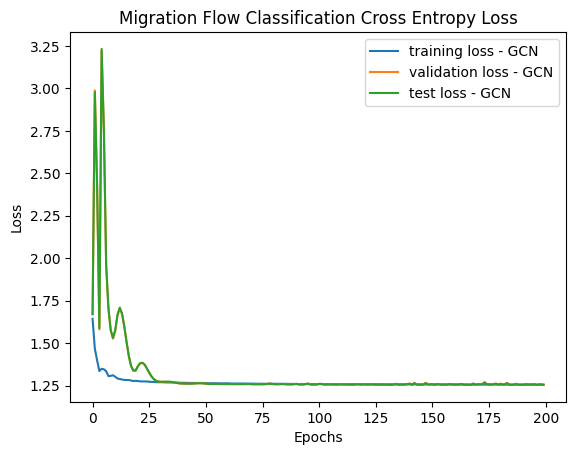

Running pipeline with config: Classification_GCN_simple_full


Training:   0%|          | 1/200 [00:00<02:19,  1.43Epochs/s]

Epoch 1: Training Loss 1.6872, Training F1 Score (Micro) 0.17614 Validation Loss 3.32779 Validation F1 Score (Micro) 0.1317


Training:   1%|          | 2/200 [00:01<02:20,  1.41Epochs/s]

Epoch 2: Training Loss 1.95018, Training F1 Score (Micro) 0.39217 Validation Loss 2.31192 Validation F1 Score (Micro) 0.13277


Training:   2%|▏         | 3/200 [00:02<02:11,  1.49Epochs/s]

Epoch 3: Training Loss 1.54505, Training F1 Score (Micro) 0.4712 Validation Loss 1.72479 Validation F1 Score (Micro) 0.14486


Training:   2%|▏         | 4/200 [00:02<02:01,  1.61Epochs/s]

Epoch 4: Training Loss 1.37851, Training F1 Score (Micro) 0.48196 Validation Loss 2.20102 Validation F1 Score (Micro) 0.13422


Training:   2%|▎         | 5/200 [00:03<01:48,  1.80Epochs/s]

Epoch 5: Training Loss 1.39184, Training F1 Score (Micro) 0.45706 Validation Loss 2.17075 Validation F1 Score (Micro) 0.13428


Training:   3%|▎         | 6/200 [00:03<01:39,  1.95Epochs/s]

Epoch 6: Training Loss 1.39236, Training F1 Score (Micro) 0.46052 Validation Loss 1.83192 Validation F1 Score (Micro) 0.16036


Training:   4%|▎         | 7/200 [00:03<01:34,  2.05Epochs/s]

Epoch 7: Training Loss 1.35718, Training F1 Score (Micro) 0.47531 Validation Loss 1.6299 Validation F1 Score (Micro) 0.28664


Training:   4%|▍         | 8/200 [00:04<01:30,  2.11Epochs/s]

Epoch 8: Training Loss 1.3378, Training F1 Score (Micro) 0.48156 Validation Loss 1.62726 Validation F1 Score (Micro) 0.29168


Training:   4%|▍         | 9/200 [00:04<01:28,  2.16Epochs/s]

Epoch 9: Training Loss 1.30718, Training F1 Score (Micro) 0.48313 Validation Loss 1.61812 Validation F1 Score (Micro) 0.32909


Training:   5%|▌         | 10/200 [00:05<01:29,  2.12Epochs/s]

Epoch 10: Training Loss 1.30283, Training F1 Score (Micro) 0.48584 Validation Loss 1.56045 Validation F1 Score (Micro) 0.38723


Training:   6%|▌         | 11/200 [00:05<01:29,  2.12Epochs/s]

Epoch 11: Training Loss 1.30368, Training F1 Score (Micro) 0.49113 Validation Loss 1.49178 Validation F1 Score (Micro) 0.44133


Training:   6%|▌         | 12/200 [00:06<01:27,  2.14Epochs/s]

Epoch 12: Training Loss 1.31041, Training F1 Score (Micro) 0.4922 Validation Loss 1.44511 Validation F1 Score (Micro) 0.48082


Training:   6%|▋         | 13/200 [00:06<01:25,  2.18Epochs/s]

Epoch 13: Training Loss 1.31349, Training F1 Score (Micro) 0.49445 Validation Loss 1.42437 Validation F1 Score (Micro) 0.49222


Training:   7%|▋         | 14/200 [00:07<01:24,  2.21Epochs/s]

Epoch 14: Training Loss 1.3088, Training F1 Score (Micro) 0.49421 Validation Loss 1.421 Validation F1 Score (Micro) 0.48699


Training:   8%|▊         | 15/200 [00:07<01:22,  2.24Epochs/s]

Epoch 15: Training Loss 1.29795, Training F1 Score (Micro) 0.49451 Validation Loss 1.4228 Validation F1 Score (Micro) 0.46999


Training:   8%|▊         | 16/200 [00:07<01:24,  2.17Epochs/s]

Epoch 16: Training Loss 1.28864, Training F1 Score (Micro) 0.49389 Validation Loss 1.41529 Validation F1 Score (Micro) 0.46212


Training:   8%|▊         | 17/200 [00:08<01:25,  2.14Epochs/s]

Epoch 17: Training Loss 1.28634, Training F1 Score (Micro) 0.49362 Validation Loss 1.37705 Validation F1 Score (Micro) 0.48227


Training:   9%|▉         | 18/200 [00:08<01:23,  2.18Epochs/s]

Epoch 18: Training Loss 1.28531, Training F1 Score (Micro) 0.49464 Validation Loss 1.33092 Validation F1 Score (Micro) 0.50117


Training:  10%|▉         | 19/200 [00:09<01:22,  2.20Epochs/s]

Epoch 19: Training Loss 1.288, Training F1 Score (Micro) 0.49585 Validation Loss 1.31021 Validation F1 Score (Micro) 0.49524


Training:  10%|█         | 20/200 [00:09<01:21,  2.22Epochs/s]

Epoch 20: Training Loss 1.28986, Training F1 Score (Micro) 0.49566 Validation Loss 1.30102 Validation F1 Score (Micro) 0.49071


Training:  10%|█         | 21/200 [00:10<01:20,  2.23Epochs/s]

Epoch 21: Training Loss 1.2893, Training F1 Score (Micro) 0.49503 Validation Loss 1.29702 Validation F1 Score (Micro) 0.48825


Training:  11%|█         | 22/200 [00:10<01:19,  2.25Epochs/s]

Epoch 22: Training Loss 1.28431, Training F1 Score (Micro) 0.49506 Validation Loss 1.29845 Validation F1 Score (Micro) 0.48233


Training:  12%|█▏        | 23/200 [00:11<01:17,  2.30Epochs/s]

Epoch 23: Training Loss 1.27919, Training F1 Score (Micro) 0.49578 Validation Loss 1.31897 Validation F1 Score (Micro) 0.47818


Training:  12%|█▏        | 24/200 [00:11<01:16,  2.31Epochs/s]

Epoch 24: Training Loss 1.27778, Training F1 Score (Micro) 0.49505 Validation Loss 1.33989 Validation F1 Score (Micro) 0.47818


Training:  12%|█▎        | 25/200 [00:11<01:15,  2.31Epochs/s]

Epoch 25: Training Loss 1.27705, Training F1 Score (Micro) 0.49493 Validation Loss 1.31078 Validation F1 Score (Micro) 0.47818


Training:  13%|█▎        | 26/200 [00:12<01:18,  2.21Epochs/s]

Epoch 26: Training Loss 1.27728, Training F1 Score (Micro) 0.49574 Validation Loss 1.29845 Validation F1 Score (Micro) 0.47855


Training:  14%|█▎        | 27/200 [00:13<01:28,  1.95Epochs/s]

Epoch 27: Training Loss 1.27903, Training F1 Score (Micro) 0.494 Validation Loss 1.29949 Validation F1 Score (Micro) 0.4783


Training:  14%|█▍        | 28/200 [00:13<01:34,  1.82Epochs/s]

Epoch 28: Training Loss 1.27798, Training F1 Score (Micro) 0.49517 Validation Loss 1.31447 Validation F1 Score (Micro) 0.47818


Training:  14%|█▍        | 29/200 [00:14<01:37,  1.76Epochs/s]

Epoch 29: Training Loss 1.27575, Training F1 Score (Micro) 0.49693 Validation Loss 1.35015 Validation F1 Score (Micro) 0.47818


Training:  15%|█▌        | 30/200 [00:14<01:36,  1.76Epochs/s]

Epoch 30: Training Loss 1.27292, Training F1 Score (Micro) 0.49771 Validation Loss 1.36322 Validation F1 Score (Micro) 0.47818


Training:  16%|█▌        | 31/200 [00:15<01:36,  1.76Epochs/s]

Epoch 31: Training Loss 1.27411, Training F1 Score (Micro) 0.49664 Validation Loss 1.3127 Validation F1 Score (Micro) 0.47824


Training:  16%|█▌        | 32/200 [00:16<01:36,  1.73Epochs/s]

Epoch 32: Training Loss 1.27242, Training F1 Score (Micro) 0.49668 Validation Loss 1.27645 Validation F1 Score (Micro) 0.49008


Training:  16%|█▋        | 33/200 [00:16<01:37,  1.72Epochs/s]

Epoch 33: Training Loss 1.2742, Training F1 Score (Micro) 0.4957 Validation Loss 1.26896 Validation F1 Score (Micro) 0.49915


Training:  17%|█▋        | 34/200 [00:17<01:32,  1.79Epochs/s]

Epoch 34: Training Loss 1.27454, Training F1 Score (Micro) 0.49515 Validation Loss 1.27074 Validation F1 Score (Micro) 0.49613


Training:  18%|█▊        | 35/200 [00:17<01:25,  1.93Epochs/s]

Epoch 35: Training Loss 1.27268, Training F1 Score (Micro) 0.49649 Validation Loss 1.28498 Validation F1 Score (Micro) 0.48466


Training:  18%|█▊        | 36/200 [00:18<01:20,  2.04Epochs/s]

Epoch 36: Training Loss 1.27191, Training F1 Score (Micro) 0.49782 Validation Loss 1.28484 Validation F1 Score (Micro) 0.48643


Training:  18%|█▊        | 37/200 [00:18<01:16,  2.13Epochs/s]

Epoch 37: Training Loss 1.27052, Training F1 Score (Micro) 0.49743 Validation Loss 1.27086 Validation F1 Score (Micro) 0.49909


Training:  19%|█▉        | 38/200 [00:18<01:16,  2.12Epochs/s]

Epoch 38: Training Loss 1.26949, Training F1 Score (Micro) 0.49772 Validation Loss 1.26775 Validation F1 Score (Micro) 0.50154


Training:  20%|█▉        | 39/200 [00:19<01:16,  2.10Epochs/s]

Epoch 39: Training Loss 1.27037, Training F1 Score (Micro) 0.49621 Validation Loss 1.26737 Validation F1 Score (Micro) 0.50255


Training:  20%|██        | 40/200 [00:19<01:14,  2.15Epochs/s]

Epoch 40: Training Loss 1.26994, Training F1 Score (Micro) 0.49694 Validation Loss 1.27001 Validation F1 Score (Micro) 0.50154


Training:  20%|██        | 41/200 [00:20<01:12,  2.18Epochs/s]

Epoch 41: Training Loss 1.26986, Training F1 Score (Micro) 0.49703 Validation Loss 1.2795 Validation F1 Score (Micro) 0.49594


Training:  21%|██        | 42/200 [00:20<01:13,  2.16Epochs/s]

Epoch 42: Training Loss 1.26921, Training F1 Score (Micro) 0.49808 Validation Loss 1.29288 Validation F1 Score (Micro) 0.48781


Training:  22%|██▏       | 43/200 [00:21<01:12,  2.17Epochs/s]

Epoch 43: Training Loss 1.26885, Training F1 Score (Micro) 0.49946 Validation Loss 1.29222 Validation F1 Score (Micro) 0.49033


Training:  22%|██▏       | 44/200 [00:21<01:12,  2.16Epochs/s]

Epoch 44: Training Loss 1.26967, Training F1 Score (Micro) 0.49861 Validation Loss 1.27914 Validation F1 Score (Micro) 0.50261


Training:  22%|██▎       | 45/200 [00:22<01:11,  2.17Epochs/s]

Epoch 45: Training Loss 1.26844, Training F1 Score (Micro) 0.49827 Validation Loss 1.27089 Validation F1 Score (Micro) 0.50425


Training:  23%|██▎       | 46/200 [00:22<01:09,  2.21Epochs/s]

Epoch 46: Training Loss 1.26817, Training F1 Score (Micro) 0.49788 Validation Loss 1.27122 Validation F1 Score (Micro) 0.50425


Training:  24%|██▎       | 47/200 [00:23<01:08,  2.24Epochs/s]

Epoch 47: Training Loss 1.26796, Training F1 Score (Micro) 0.49745 Validation Loss 1.28914 Validation F1 Score (Micro) 0.49953


Training:  24%|██▍       | 48/200 [00:23<01:08,  2.23Epochs/s]

Epoch 48: Training Loss 1.26792, Training F1 Score (Micro) 0.49847 Validation Loss 1.31338 Validation F1 Score (Micro) 0.48674


Training:  24%|██▍       | 49/200 [00:23<01:09,  2.18Epochs/s]

Epoch 49: Training Loss 1.26638, Training F1 Score (Micro) 0.49842 Validation Loss 1.31827 Validation F1 Score (Micro) 0.48378


Training:  25%|██▌       | 50/200 [00:24<01:06,  2.24Epochs/s]

Epoch 50: Training Loss 1.26756, Training F1 Score (Micro) 0.49835 Validation Loss 1.27752 Validation F1 Score (Micro) 0.50431


Training:  26%|██▌       | 51/200 [00:24<01:05,  2.26Epochs/s]

Epoch 51: Training Loss 1.26727, Training F1 Score (Micro) 0.49801 Validation Loss 1.2616 Validation F1 Score (Micro) 0.50117


Training:  26%|██▌       | 52/200 [00:25<01:04,  2.31Epochs/s]

Epoch 52: Training Loss 1.26669, Training F1 Score (Micro) 0.49777 Validation Loss 1.26259 Validation F1 Score (Micro) 0.49953


Training:  26%|██▋       | 53/200 [00:25<01:03,  2.33Epochs/s]

Epoch 53: Training Loss 1.26731, Training F1 Score (Micro) 0.49683 Validation Loss 1.26106 Validation F1 Score (Micro) 0.50091


Training:  27%|██▋       | 54/200 [00:26<01:02,  2.33Epochs/s]

Epoch 54: Training Loss 1.26646, Training F1 Score (Micro) 0.4979 Validation Loss 1.26094 Validation F1 Score (Micro) 0.50186


Training:  28%|██▊       | 55/200 [00:26<01:01,  2.34Epochs/s]

Epoch 55: Training Loss 1.26669, Training F1 Score (Micro) 0.49787 Validation Loss 1.26159 Validation F1 Score (Micro) 0.50274


Training:  28%|██▊       | 56/200 [00:26<01:03,  2.26Epochs/s]

Epoch 56: Training Loss 1.26623, Training F1 Score (Micro) 0.49889 Validation Loss 1.25981 Validation F1 Score (Micro) 0.50079


Training:  28%|██▊       | 57/200 [00:27<01:10,  2.02Epochs/s]

Epoch 57: Training Loss 1.26614, Training F1 Score (Micro) 0.49764 Validation Loss 1.26015 Validation F1 Score (Micro) 0.49972


Training:  29%|██▉       | 58/200 [00:28<01:15,  1.89Epochs/s]

Epoch 58: Training Loss 1.2659, Training F1 Score (Micro) 0.49801 Validation Loss 1.25967 Validation F1 Score (Micro) 0.50079


Training:  30%|██▉       | 59/200 [00:28<01:16,  1.84Epochs/s]

Epoch 59: Training Loss 1.26594, Training F1 Score (Micro) 0.49786 Validation Loss 1.25991 Validation F1 Score (Micro) 0.50142


Training:  30%|███       | 60/200 [00:29<01:16,  1.82Epochs/s]

Epoch 60: Training Loss 1.2661, Training F1 Score (Micro) 0.4977 Validation Loss 1.26168 Validation F1 Score (Micro) 0.50305


Training:  30%|███       | 61/200 [00:29<01:16,  1.81Epochs/s]

Epoch 61: Training Loss 1.2655, Training F1 Score (Micro) 0.49843 Validation Loss 1.26171 Validation F1 Score (Micro) 0.50343


Training:  31%|███       | 62/200 [00:30<01:19,  1.73Epochs/s]

Epoch 62: Training Loss 1.26498, Training F1 Score (Micro) 0.49793 Validation Loss 1.26126 Validation F1 Score (Micro) 0.50312


Training:  32%|███▏      | 63/200 [00:31<01:20,  1.70Epochs/s]

Epoch 63: Training Loss 1.26528, Training F1 Score (Micro) 0.49891 Validation Loss 1.25954 Validation F1 Score (Micro) 0.50035


Training:  32%|███▏      | 64/200 [00:31<01:18,  1.73Epochs/s]

Epoch 64: Training Loss 1.26568, Training F1 Score (Micro) 0.49805 Validation Loss 1.2607 Validation F1 Score (Micro) 0.49978


Training:  32%|███▎      | 65/200 [00:32<01:18,  1.73Epochs/s]

Epoch 65: Training Loss 1.26548, Training F1 Score (Micro) 0.49765 Validation Loss 1.26026 Validation F1 Score (Micro) 0.50054


Training:  33%|███▎      | 66/200 [00:32<01:11,  1.87Epochs/s]

Epoch 66: Training Loss 1.26474, Training F1 Score (Micro) 0.49776 Validation Loss 1.25951 Validation F1 Score (Micro) 0.50142


Training:  34%|███▎      | 67/200 [00:33<01:06,  2.00Epochs/s]

Epoch 67: Training Loss 1.26486, Training F1 Score (Micro) 0.499 Validation Loss 1.2595 Validation F1 Score (Micro) 0.50154


Training:  34%|███▍      | 68/200 [00:33<01:03,  2.09Epochs/s]

Epoch 68: Training Loss 1.26495, Training F1 Score (Micro) 0.4991 Validation Loss 1.25992 Validation F1 Score (Micro) 0.49946


Training:  34%|███▍      | 69/200 [00:33<01:00,  2.16Epochs/s]

Epoch 69: Training Loss 1.26472, Training F1 Score (Micro) 0.49756 Validation Loss 1.2607 Validation F1 Score (Micro) 0.49758


Training:  35%|███▌      | 70/200 [00:34<00:59,  2.20Epochs/s]

Epoch 70: Training Loss 1.26502, Training F1 Score (Micro) 0.49704 Validation Loss 1.25881 Validation F1 Score (Micro) 0.50028


Training:  36%|███▌      | 71/200 [00:34<00:57,  2.24Epochs/s]

Epoch 71: Training Loss 1.2648, Training F1 Score (Micro) 0.49759 Validation Loss 1.26386 Validation F1 Score (Micro) 0.50249


Training:  36%|███▌      | 72/200 [00:35<00:56,  2.25Epochs/s]

Epoch 72: Training Loss 1.26443, Training F1 Score (Micro) 0.4989 Validation Loss 1.25834 Validation F1 Score (Micro) 0.50135


Training:  36%|███▋      | 73/200 [00:35<00:55,  2.29Epochs/s]

Epoch 73: Training Loss 1.26408, Training F1 Score (Micro) 0.49903 Validation Loss 1.2616 Validation F1 Score (Micro) 0.4982


Training:  37%|███▋      | 74/200 [00:36<00:55,  2.28Epochs/s]

Epoch 74: Training Loss 1.2643, Training F1 Score (Micro) 0.49749 Validation Loss 1.26143 Validation F1 Score (Micro) 0.49776


Training:  38%|███▊      | 75/200 [00:36<00:55,  2.27Epochs/s]

Epoch 75: Training Loss 1.26486, Training F1 Score (Micro) 0.49748 Validation Loss 1.25852 Validation F1 Score (Micro) 0.50041


Training:  38%|███▊      | 76/200 [00:37<00:54,  2.29Epochs/s]

Epoch 76: Training Loss 1.26519, Training F1 Score (Micro) 0.49842 Validation Loss 1.25859 Validation F1 Score (Micro) 0.50098


Training:  38%|███▊      | 77/200 [00:37<00:53,  2.31Epochs/s]

Epoch 77: Training Loss 1.2637, Training F1 Score (Micro) 0.49873 Validation Loss 1.25877 Validation F1 Score (Micro) 0.50186


Training:  39%|███▉      | 78/200 [00:37<00:52,  2.31Epochs/s]

Epoch 78: Training Loss 1.26404, Training F1 Score (Micro) 0.49881 Validation Loss 1.25954 Validation F1 Score (Micro) 0.50066


Training:  40%|███▉      | 79/200 [00:38<00:51,  2.34Epochs/s]

Epoch 79: Training Loss 1.2637, Training F1 Score (Micro) 0.49949 Validation Loss 1.26379 Validation F1 Score (Micro) 0.49846


Training:  40%|████      | 80/200 [00:38<00:51,  2.32Epochs/s]

Epoch 80: Training Loss 1.26427, Training F1 Score (Micro) 0.49806 Validation Loss 1.26352 Validation F1 Score (Micro) 0.49883


Training:  40%|████      | 81/200 [00:39<00:51,  2.33Epochs/s]

Epoch 81: Training Loss 1.26508, Training F1 Score (Micro) 0.49875 Validation Loss 1.26569 Validation F1 Score (Micro) 0.49776


Training:  41%|████      | 82/200 [00:39<00:50,  2.33Epochs/s]

Epoch 82: Training Loss 1.26392, Training F1 Score (Micro) 0.49834 Validation Loss 1.26292 Validation F1 Score (Micro) 0.4982


Training:  42%|████▏     | 83/200 [00:40<00:49,  2.34Epochs/s]

Epoch 83: Training Loss 1.26484, Training F1 Score (Micro) 0.49742 Validation Loss 1.26031 Validation F1 Score (Micro) 0.49972


Training:  42%|████▏     | 84/200 [00:40<00:49,  2.32Epochs/s]

Epoch 84: Training Loss 1.26387, Training F1 Score (Micro) 0.49849 Validation Loss 1.25872 Validation F1 Score (Micro) 0.50028


Training:  42%|████▎     | 85/200 [00:40<00:51,  2.25Epochs/s]

Epoch 85: Training Loss 1.26327, Training F1 Score (Micro) 0.49828 Validation Loss 1.25867 Validation F1 Score (Micro) 0.50079


Training:  43%|████▎     | 86/200 [00:41<00:49,  2.28Epochs/s]

Epoch 86: Training Loss 1.26362, Training F1 Score (Micro) 0.49842 Validation Loss 1.25915 Validation F1 Score (Micro) 0.50072


Training:  44%|████▎     | 87/200 [00:41<00:50,  2.22Epochs/s]

Epoch 87: Training Loss 1.26313, Training F1 Score (Micro) 0.4986 Validation Loss 1.26108 Validation F1 Score (Micro) 0.4989


Training:  44%|████▍     | 88/200 [00:42<00:50,  2.21Epochs/s]

Epoch 88: Training Loss 1.26339, Training F1 Score (Micro) 0.49855 Validation Loss 1.26093 Validation F1 Score (Micro) 0.49909


Training:  44%|████▍     | 89/200 [00:42<00:56,  1.96Epochs/s]

Epoch 89: Training Loss 1.26339, Training F1 Score (Micro) 0.49806 Validation Loss 1.25803 Validation F1 Score (Micro) 0.5011


Training:  45%|████▌     | 90/200 [00:43<00:57,  1.91Epochs/s]

Epoch 90: Training Loss 1.26395, Training F1 Score (Micro) 0.49864 Validation Loss 1.25796 Validation F1 Score (Micro) 0.50154


Training:  46%|████▌     | 91/200 [00:44<01:00,  1.81Epochs/s]

Epoch 91: Training Loss 1.26376, Training F1 Score (Micro) 0.49878 Validation Loss 1.25878 Validation F1 Score (Micro) 0.5028


Training:  46%|████▌     | 92/200 [00:44<00:59,  1.80Epochs/s]

Epoch 92: Training Loss 1.26274, Training F1 Score (Micro) 0.49864 Validation Loss 1.25934 Validation F1 Score (Micro) 0.50268


Training:  46%|████▋     | 93/200 [00:45<00:59,  1.81Epochs/s]

Epoch 93: Training Loss 1.26329, Training F1 Score (Micro) 0.4983 Validation Loss 1.25822 Validation F1 Score (Micro) 0.50035


Training:  47%|████▋     | 94/200 [00:45<01:01,  1.73Epochs/s]

Epoch 94: Training Loss 1.26296, Training F1 Score (Micro) 0.49853 Validation Loss 1.25834 Validation F1 Score (Micro) 0.49997


Training:  48%|████▊     | 95/200 [00:46<01:02,  1.67Epochs/s]

Epoch 95: Training Loss 1.26293, Training F1 Score (Micro) 0.49836 Validation Loss 1.25811 Validation F1 Score (Micro) 0.50305


Training:  48%|████▊     | 96/200 [00:47<01:01,  1.69Epochs/s]

Epoch 96: Training Loss 1.26287, Training F1 Score (Micro) 0.49864 Validation Loss 1.25818 Validation F1 Score (Micro) 0.50268


Training:  48%|████▊     | 97/200 [00:47<01:00,  1.70Epochs/s]

Epoch 97: Training Loss 1.26263, Training F1 Score (Micro) 0.4985 Validation Loss 1.25917 Validation F1 Score (Micro) 0.50217


Training:  49%|████▉     | 98/200 [00:48<00:56,  1.80Epochs/s]

Epoch 98: Training Loss 1.26308, Training F1 Score (Micro) 0.49881 Validation Loss 1.26111 Validation F1 Score (Micro) 0.50148


Training:  50%|████▉     | 99/200 [00:48<00:54,  1.87Epochs/s]

Epoch 99: Training Loss 1.26296, Training F1 Score (Micro) 0.49982 Validation Loss 1.26271 Validation F1 Score (Micro) 0.49732


Training:  50%|█████     | 100/200 [00:49<00:51,  1.95Epochs/s]

Epoch 100: Training Loss 1.26309, Training F1 Score (Micro) 0.49804 Validation Loss 1.26478 Validation F1 Score (Micro) 0.49669


Training:  50%|█████     | 101/200 [00:49<00:48,  2.04Epochs/s]

Epoch 101: Training Loss 1.26279, Training F1 Score (Micro) 0.49752 Validation Loss 1.26199 Validation F1 Score (Micro) 0.49928


Training:  51%|█████     | 102/200 [00:50<00:48,  2.03Epochs/s]

Epoch 102: Training Loss 1.26275, Training F1 Score (Micro) 0.49874 Validation Loss 1.25981 Validation F1 Score (Micro) 0.50161


Training:  52%|█████▏    | 103/200 [00:50<00:47,  2.04Epochs/s]

Epoch 103: Training Loss 1.26263, Training F1 Score (Micro) 0.49933 Validation Loss 1.26044 Validation F1 Score (Micro) 0.50198


Training:  52%|█████▏    | 104/200 [00:50<00:46,  2.05Epochs/s]

Epoch 104: Training Loss 1.26278, Training F1 Score (Micro) 0.49886 Validation Loss 1.26172 Validation F1 Score (Micro) 0.50211


Training:  52%|█████▎    | 105/200 [00:51<00:44,  2.14Epochs/s]

Epoch 105: Training Loss 1.2629, Training F1 Score (Micro) 0.49856 Validation Loss 1.26394 Validation F1 Score (Micro) 0.50186


Training:  53%|█████▎    | 106/200 [00:51<00:42,  2.19Epochs/s]

Epoch 106: Training Loss 1.26295, Training F1 Score (Micro) 0.49844 Validation Loss 1.25908 Validation F1 Score (Micro) 0.50192


Training:  54%|█████▎    | 107/200 [00:52<00:43,  2.16Epochs/s]

Epoch 107: Training Loss 1.2623, Training F1 Score (Micro) 0.49862 Validation Loss 1.25818 Validation F1 Score (Micro) 0.50028


Training:  54%|█████▍    | 108/200 [00:52<00:43,  2.12Epochs/s]

Epoch 108: Training Loss 1.26304, Training F1 Score (Micro) 0.49814 Validation Loss 1.25772 Validation F1 Score (Micro) 0.50217


Training:  55%|█████▍    | 109/200 [00:53<00:42,  2.12Epochs/s]

Epoch 109: Training Loss 1.26259, Training F1 Score (Micro) 0.49847 Validation Loss 1.26011 Validation F1 Score (Micro) 0.50287


Training:  55%|█████▌    | 110/200 [00:53<00:42,  2.11Epochs/s]

Epoch 110: Training Loss 1.26246, Training F1 Score (Micro) 0.49848 Validation Loss 1.26032 Validation F1 Score (Micro) 0.50293


Training:  56%|█████▌    | 111/200 [00:54<00:40,  2.17Epochs/s]

Epoch 111: Training Loss 1.26234, Training F1 Score (Micro) 0.49888 Validation Loss 1.26128 Validation F1 Score (Micro) 0.50173


Training:  56%|█████▌    | 112/200 [00:54<00:39,  2.22Epochs/s]

Epoch 112: Training Loss 1.26197, Training F1 Score (Micro) 0.49856 Validation Loss 1.25936 Validation F1 Score (Micro) 0.50148


Training:  56%|█████▋    | 113/200 [00:55<00:39,  2.22Epochs/s]

Epoch 113: Training Loss 1.26198, Training F1 Score (Micro) 0.49822 Validation Loss 1.25737 Validation F1 Score (Micro) 0.50312


Training:  57%|█████▋    | 114/200 [00:55<00:38,  2.24Epochs/s]

Epoch 114: Training Loss 1.26213, Training F1 Score (Micro) 0.49874 Validation Loss 1.25667 Validation F1 Score (Micro) 0.50242


Training:  57%|█████▊    | 115/200 [00:55<00:37,  2.26Epochs/s]

Epoch 115: Training Loss 1.26132, Training F1 Score (Micro) 0.49842 Validation Loss 1.2564 Validation F1 Score (Micro) 0.50205


Training:  58%|█████▊    | 116/200 [00:56<00:37,  2.26Epochs/s]

Epoch 116: Training Loss 1.2624, Training F1 Score (Micro) 0.49823 Validation Loss 1.25677 Validation F1 Score (Micro) 0.50287


Training:  58%|█████▊    | 117/200 [00:56<00:37,  2.20Epochs/s]

Epoch 117: Training Loss 1.26187, Training F1 Score (Micro) 0.4991 Validation Loss 1.25687 Validation F1 Score (Micro) 0.50142


Training:  59%|█████▉    | 118/200 [00:57<00:37,  2.19Epochs/s]

Epoch 118: Training Loss 1.26185, Training F1 Score (Micro) 0.49934 Validation Loss 1.26254 Validation F1 Score (Micro) 0.4972


Training:  60%|█████▉    | 119/200 [00:57<00:37,  2.16Epochs/s]

Epoch 119: Training Loss 1.2614, Training F1 Score (Micro) 0.49875 Validation Loss 1.26301 Validation F1 Score (Micro) 0.49695


Training:  60%|██████    | 120/200 [00:58<00:39,  2.04Epochs/s]

Epoch 120: Training Loss 1.26304, Training F1 Score (Micro) 0.49837 Validation Loss 1.25988 Validation F1 Score (Micro) 0.49839


Training:  60%|██████    | 121/200 [00:58<00:40,  1.95Epochs/s]

Epoch 121: Training Loss 1.26234, Training F1 Score (Micro) 0.49835 Validation Loss 1.25821 Validation F1 Score (Micro) 0.50154


Training:  61%|██████    | 122/200 [00:59<00:41,  1.89Epochs/s]

Epoch 122: Training Loss 1.26166, Training F1 Score (Micro) 0.49952 Validation Loss 1.27591 Validation F1 Score (Micro) 0.49802


Training:  62%|██████▏   | 123/200 [01:00<00:41,  1.85Epochs/s]

Epoch 123: Training Loss 1.26196, Training F1 Score (Micro) 0.49816 Validation Loss 1.29717 Validation F1 Score (Micro) 0.48504


Training:  62%|██████▏   | 124/200 [01:00<00:41,  1.81Epochs/s]

Epoch 124: Training Loss 1.26194, Training F1 Score (Micro) 0.49794 Validation Loss 1.29552 Validation F1 Score (Micro) 0.48422


Training:  62%|██████▎   | 125/200 [01:01<00:42,  1.78Epochs/s]

Epoch 125: Training Loss 1.26199, Training F1 Score (Micro) 0.49873 Validation Loss 1.25904 Validation F1 Score (Micro) 0.50154


Training:  63%|██████▎   | 126/200 [01:01<00:42,  1.75Epochs/s]

Epoch 126: Training Loss 1.26227, Training F1 Score (Micro) 0.4993 Validation Loss 1.27019 Validation F1 Score (Micro) 0.4977


Training:  64%|██████▎   | 127/200 [01:02<00:41,  1.78Epochs/s]

Epoch 127: Training Loss 1.26194, Training F1 Score (Micro) 0.49884 Validation Loss 1.28106 Validation F1 Score (Micro) 0.49096


Training:  64%|██████▍   | 128/200 [01:02<00:40,  1.77Epochs/s]

Epoch 128: Training Loss 1.26151, Training F1 Score (Micro) 0.4981 Validation Loss 1.26856 Validation F1 Score (Micro) 0.4965


Training:  64%|██████▍   | 129/200 [01:03<00:37,  1.88Epochs/s]

Epoch 129: Training Loss 1.26209, Training F1 Score (Micro) 0.49776 Validation Loss 1.25722 Validation F1 Score (Micro) 0.50324


Training:  65%|██████▌   | 130/200 [01:03<00:35,  1.96Epochs/s]

Epoch 130: Training Loss 1.26143, Training F1 Score (Micro) 0.49868 Validation Loss 1.26523 Validation F1 Score (Micro) 0.50488


Training:  66%|██████▌   | 131/200 [01:04<00:35,  1.97Epochs/s]

Epoch 131: Training Loss 1.26172, Training F1 Score (Micro) 0.49991 Validation Loss 1.25764 Validation F1 Score (Micro) 0.50261


Training:  66%|██████▌   | 132/200 [01:04<00:37,  1.80Epochs/s]

Epoch 132: Training Loss 1.26135, Training F1 Score (Micro) 0.49853 Validation Loss 1.25816 Validation F1 Score (Micro) 0.4989


Training:  66%|██████▋   | 133/200 [01:05<00:37,  1.80Epochs/s]

Epoch 133: Training Loss 1.26146, Training F1 Score (Micro) 0.49862 Validation Loss 1.26247 Validation F1 Score (Micro) 0.49808


Training:  67%|██████▋   | 134/200 [01:06<00:38,  1.72Epochs/s]

Epoch 134: Training Loss 1.2617, Training F1 Score (Micro) 0.49815 Validation Loss 1.26 Validation F1 Score (Micro) 0.5028


Training:  68%|██████▊   | 135/200 [01:06<00:37,  1.74Epochs/s]

Epoch 135: Training Loss 1.26157, Training F1 Score (Micro) 0.49955 Validation Loss 1.25901 Validation F1 Score (Micro) 0.50362


Training:  68%|██████▊   | 136/200 [01:07<00:36,  1.77Epochs/s]

Epoch 136: Training Loss 1.26154, Training F1 Score (Micro) 0.49948 Validation Loss 1.25774 Validation F1 Score (Micro) 0.50287


Training:  68%|██████▊   | 137/200 [01:07<00:35,  1.76Epochs/s]

Epoch 137: Training Loss 1.26132, Training F1 Score (Micro) 0.49894 Validation Loss 1.25623 Validation F1 Score (Micro) 0.50312


Training:  69%|██████▉   | 138/200 [01:08<00:36,  1.68Epochs/s]

Epoch 138: Training Loss 1.26096, Training F1 Score (Micro) 0.49809 Validation Loss 1.25959 Validation F1 Score (Micro) 0.50444


Training:  70%|██████▉   | 139/200 [01:09<00:35,  1.70Epochs/s]

Epoch 139: Training Loss 1.26083, Training F1 Score (Micro) 0.49864 Validation Loss 1.26029 Validation F1 Score (Micro) 0.50463


Training:  70%|███████   | 140/200 [01:09<00:32,  1.86Epochs/s]

Epoch 140: Training Loss 1.26104, Training F1 Score (Micro) 0.49956 Validation Loss 1.25688 Validation F1 Score (Micro) 0.50268


Training:  70%|███████   | 141/200 [01:10<00:30,  1.91Epochs/s]

Epoch 141: Training Loss 1.26143, Training F1 Score (Micro) 0.49807 Validation Loss 1.25906 Validation F1 Score (Micro) 0.5028


Training:  71%|███████   | 142/200 [01:10<00:30,  1.92Epochs/s]

Epoch 142: Training Loss 1.26096, Training F1 Score (Micro) 0.49868 Validation Loss 1.26007 Validation F1 Score (Micro) 0.50293


Training:  72%|███████▏  | 143/200 [01:11<00:28,  1.97Epochs/s]

Epoch 143: Training Loss 1.2614, Training F1 Score (Micro) 0.49931 Validation Loss 1.2608 Validation F1 Score (Micro) 0.50072


Training:  72%|███████▏  | 144/200 [01:11<00:27,  2.04Epochs/s]

Epoch 144: Training Loss 1.26109, Training F1 Score (Micro) 0.49864 Validation Loss 1.25958 Validation F1 Score (Micro) 0.49883


Training:  72%|███████▎  | 145/200 [01:11<00:26,  2.07Epochs/s]

Epoch 145: Training Loss 1.26118, Training F1 Score (Micro) 0.49946 Validation Loss 1.25888 Validation F1 Score (Micro) 0.49915


Training:  73%|███████▎  | 146/200 [01:12<00:25,  2.12Epochs/s]

Epoch 146: Training Loss 1.26147, Training F1 Score (Micro) 0.49865 Validation Loss 1.2613 Validation F1 Score (Micro) 0.50224


Training:  74%|███████▎  | 147/200 [01:12<00:25,  2.11Epochs/s]

Epoch 147: Training Loss 1.2612, Training F1 Score (Micro) 0.49883 Validation Loss 1.2653 Validation F1 Score (Micro) 0.50337


Training:  74%|███████▍  | 148/200 [01:13<00:27,  1.90Epochs/s]

Epoch 148: Training Loss 1.26042, Training F1 Score (Micro) 0.49938 Validation Loss 1.26757 Validation F1 Score (Micro) 0.50387


Training:  74%|███████▍  | 149/200 [01:14<00:28,  1.81Epochs/s]

Epoch 149: Training Loss 1.26083, Training F1 Score (Micro) 0.49964 Validation Loss 1.25923 Validation F1 Score (Micro) 0.50198


Training:  75%|███████▌  | 150/200 [01:14<00:27,  1.82Epochs/s]

Epoch 150: Training Loss 1.2608, Training F1 Score (Micro) 0.49838 Validation Loss 1.25736 Validation F1 Score (Micro) 0.49997


Training:  76%|███████▌  | 151/200 [01:15<00:27,  1.77Epochs/s]

Epoch 151: Training Loss 1.26121, Training F1 Score (Micro) 0.49841 Validation Loss 1.25592 Validation F1 Score (Micro) 0.50305


Training:  76%|███████▌  | 152/200 [01:15<00:27,  1.75Epochs/s]

Epoch 152: Training Loss 1.26048, Training F1 Score (Micro) 0.49961 Validation Loss 1.25708 Validation F1 Score (Micro) 0.50312


Training:  76%|███████▋  | 153/200 [01:16<00:27,  1.69Epochs/s]

Epoch 153: Training Loss 1.26042, Training F1 Score (Micro) 0.49887 Validation Loss 1.25707 Validation F1 Score (Micro) 0.50293


Training:  77%|███████▋  | 154/200 [01:17<00:27,  1.66Epochs/s]

Epoch 154: Training Loss 1.26049, Training F1 Score (Micro) 0.49935 Validation Loss 1.25814 Validation F1 Score (Micro) 0.50224


Training:  78%|███████▊  | 155/200 [01:17<00:27,  1.66Epochs/s]

Epoch 155: Training Loss 1.26067, Training F1 Score (Micro) 0.49838 Validation Loss 1.25723 Validation F1 Score (Micro) 0.50268


Training:  78%|███████▊  | 156/200 [01:18<00:25,  1.70Epochs/s]

Epoch 156: Training Loss 1.26063, Training F1 Score (Micro) 0.49839 Validation Loss 1.25648 Validation F1 Score (Micro) 0.50261


Training:  78%|███████▊  | 157/200 [01:18<00:23,  1.84Epochs/s]

Epoch 157: Training Loss 1.26091, Training F1 Score (Micro) 0.49807 Validation Loss 1.26621 Validation F1 Score (Micro) 0.50198


Training:  79%|███████▉  | 158/200 [01:19<00:21,  1.96Epochs/s]

Epoch 158: Training Loss 1.26113, Training F1 Score (Micro) 0.49901 Validation Loss 1.26631 Validation F1 Score (Micro) 0.50368


Training:  80%|███████▉  | 159/200 [01:19<00:20,  2.04Epochs/s]

Epoch 159: Training Loss 1.26093, Training F1 Score (Micro) 0.49897 Validation Loss 1.26323 Validation F1 Score (Micro) 0.50142


Training:  80%|████████  | 160/200 [01:20<00:18,  2.12Epochs/s]

Epoch 160: Training Loss 1.26098, Training F1 Score (Micro) 0.49888 Validation Loss 1.25841 Validation F1 Score (Micro) 0.49871


Training:  80%|████████  | 161/200 [01:20<00:18,  2.15Epochs/s]

Epoch 161: Training Loss 1.26116, Training F1 Score (Micro) 0.49776 Validation Loss 1.26071 Validation F1 Score (Micro) 0.49871


Training:  81%|████████  | 162/200 [01:20<00:17,  2.14Epochs/s]

Epoch 162: Training Loss 1.26044, Training F1 Score (Micro) 0.49883 Validation Loss 1.25877 Validation F1 Score (Micro) 0.50261


Training:  82%|████████▏ | 163/200 [01:21<00:16,  2.18Epochs/s]

Epoch 163: Training Loss 1.26103, Training F1 Score (Micro) 0.49936 Validation Loss 1.25844 Validation F1 Score (Micro) 0.50318


Training:  82%|████████▏ | 164/200 [01:21<00:16,  2.22Epochs/s]

Epoch 164: Training Loss 1.26133, Training F1 Score (Micro) 0.49968 Validation Loss 1.25814 Validation F1 Score (Micro) 0.50135


Training:  82%|████████▎ | 165/200 [01:22<00:15,  2.24Epochs/s]

Epoch 165: Training Loss 1.26091, Training F1 Score (Micro) 0.49888 Validation Loss 1.2576 Validation F1 Score (Micro) 0.50054


Training:  83%|████████▎ | 166/200 [01:22<00:15,  2.20Epochs/s]

Epoch 166: Training Loss 1.26054, Training F1 Score (Micro) 0.49896 Validation Loss 1.25676 Validation F1 Score (Micro) 0.50104


Training:  84%|████████▎ | 167/200 [01:23<00:14,  2.25Epochs/s]

Epoch 167: Training Loss 1.26038, Training F1 Score (Micro) 0.49858 Validation Loss 1.25698 Validation F1 Score (Micro) 0.50224


Training:  84%|████████▍ | 168/200 [01:23<00:14,  2.26Epochs/s]

Epoch 168: Training Loss 1.2607, Training F1 Score (Micro) 0.49874 Validation Loss 1.25679 Validation F1 Score (Micro) 0.50337


Training:  84%|████████▍ | 169/200 [01:23<00:13,  2.29Epochs/s]

Epoch 169: Training Loss 1.26013, Training F1 Score (Micro) 0.49964 Validation Loss 1.25664 Validation F1 Score (Micro) 0.50368


Training:  85%|████████▌ | 170/200 [01:24<00:12,  2.32Epochs/s]

Epoch 170: Training Loss 1.25994, Training F1 Score (Micro) 0.49947 Validation Loss 1.25783 Validation F1 Score (Micro) 0.50305


Training:  86%|████████▌ | 171/200 [01:24<00:12,  2.28Epochs/s]

Epoch 171: Training Loss 1.26051, Training F1 Score (Micro) 0.49937 Validation Loss 1.25735 Validation F1 Score (Micro) 0.50217


Training:  86%|████████▌ | 172/200 [01:25<00:12,  2.30Epochs/s]

Epoch 172: Training Loss 1.26031, Training F1 Score (Micro) 0.49954 Validation Loss 1.26182 Validation F1 Score (Micro) 0.49751


Training:  86%|████████▋ | 173/200 [01:25<00:11,  2.30Epochs/s]

Epoch 173: Training Loss 1.26065, Training F1 Score (Micro) 0.49839 Validation Loss 1.25973 Validation F1 Score (Micro) 0.49953


Training:  87%|████████▋ | 174/200 [01:26<00:11,  2.25Epochs/s]

Epoch 174: Training Loss 1.26033, Training F1 Score (Micro) 0.49798 Validation Loss 1.2603 Validation F1 Score (Micro) 0.50161


Training:  88%|████████▊ | 175/200 [01:26<00:11,  2.22Epochs/s]

Epoch 175: Training Loss 1.2605, Training F1 Score (Micro) 0.49843 Validation Loss 1.26297 Validation F1 Score (Micro) 0.4994


Training:  88%|████████▊ | 176/200 [01:27<00:10,  2.25Epochs/s]

Epoch 176: Training Loss 1.25989, Training F1 Score (Micro) 0.49909 Validation Loss 1.25924 Validation F1 Score (Micro) 0.5018


Training:  88%|████████▊ | 177/200 [01:27<00:10,  2.27Epochs/s]

Epoch 177: Training Loss 1.26047, Training F1 Score (Micro) 0.4998 Validation Loss 1.25538 Validation F1 Score (Micro) 0.50343


Training:  89%|████████▉ | 178/200 [01:28<00:10,  2.20Epochs/s]

Epoch 178: Training Loss 1.26104, Training F1 Score (Micro) 0.49825 Validation Loss 1.25609 Validation F1 Score (Micro) 0.50016


Training:  90%|████████▉ | 179/200 [01:28<00:09,  2.13Epochs/s]

Epoch 179: Training Loss 1.26024, Training F1 Score (Micro) 0.49759 Validation Loss 1.25571 Validation F1 Score (Micro) 0.50148


Training:  90%|█████████ | 180/200 [01:29<00:10,  1.97Epochs/s]

Epoch 180: Training Loss 1.25955, Training F1 Score (Micro) 0.49855 Validation Loss 1.26359 Validation F1 Score (Micro) 0.50028


Training:  90%|█████████ | 181/200 [01:29<00:09,  1.90Epochs/s]

Epoch 181: Training Loss 1.25998, Training F1 Score (Micro) 0.49964 Validation Loss 1.26463 Validation F1 Score (Micro) 0.49997


Training:  91%|█████████ | 182/200 [01:30<00:10,  1.77Epochs/s]

Epoch 182: Training Loss 1.26092, Training F1 Score (Micro) 0.50019 Validation Loss 1.25743 Validation F1 Score (Micro) 0.5006


Training:  92%|█████████▏| 183/200 [01:30<00:09,  1.74Epochs/s]

Epoch 183: Training Loss 1.25972, Training F1 Score (Micro) 0.49953 Validation Loss 1.26165 Validation F1 Score (Micro) 0.49852


Training:  92%|█████████▏| 184/200 [01:31<00:09,  1.77Epochs/s]

Epoch 184: Training Loss 1.26042, Training F1 Score (Micro) 0.49863 Validation Loss 1.26103 Validation F1 Score (Micro) 0.50072


Training:  92%|█████████▎| 185/200 [01:32<00:08,  1.67Epochs/s]

Epoch 185: Training Loss 1.26029, Training F1 Score (Micro) 0.49931 Validation Loss 1.26039 Validation F1 Score (Micro) 0.50337


Training:  93%|█████████▎| 186/200 [01:32<00:08,  1.66Epochs/s]

Epoch 186: Training Loss 1.26042, Training F1 Score (Micro) 0.49985 Validation Loss 1.26605 Validation F1 Score (Micro) 0.50028


Training:  94%|█████████▎| 187/200 [01:33<00:07,  1.64Epochs/s]

Epoch 187: Training Loss 1.26044, Training F1 Score (Micro) 0.5001 Validation Loss 1.26377 Validation F1 Score (Micro) 0.5011


Training:  94%|█████████▍| 188/200 [01:33<00:07,  1.68Epochs/s]

Epoch 188: Training Loss 1.25974, Training F1 Score (Micro) 0.49946 Validation Loss 1.25781 Validation F1 Score (Micro) 0.50419


Training:  94%|█████████▍| 189/200 [01:34<00:05,  1.84Epochs/s]

Epoch 189: Training Loss 1.26029, Training F1 Score (Micro) 0.49802 Validation Loss 1.25907 Validation F1 Score (Micro) 0.50362


Training:  95%|█████████▌| 190/200 [01:34<00:05,  1.97Epochs/s]

Epoch 190: Training Loss 1.25958, Training F1 Score (Micro) 0.49908 Validation Loss 1.26723 Validation F1 Score (Micro) 0.5028


Training:  96%|█████████▌| 191/200 [01:35<00:04,  2.05Epochs/s]

Epoch 191: Training Loss 1.26043, Training F1 Score (Micro) 0.49832 Validation Loss 1.29741 Validation F1 Score (Micro) 0.49147


Training:  96%|█████████▌| 192/200 [01:35<00:03,  2.13Epochs/s]

Epoch 192: Training Loss 1.26057, Training F1 Score (Micro) 0.49974 Validation Loss 1.26437 Validation F1 Score (Micro) 0.50362


Training:  96%|█████████▋| 193/200 [01:36<00:03,  2.13Epochs/s]

Epoch 193: Training Loss 1.2602, Training F1 Score (Micro) 0.50004 Validation Loss 1.25655 Validation F1 Score (Micro) 0.50129


Training:  97%|█████████▋| 194/200 [01:36<00:02,  2.15Epochs/s]

Epoch 194: Training Loss 1.26077, Training F1 Score (Micro) 0.4986 Validation Loss 1.25563 Validation F1 Score (Micro) 0.50066


Training:  98%|█████████▊| 195/200 [01:37<00:02,  2.16Epochs/s]

Epoch 195: Training Loss 1.25991, Training F1 Score (Micro) 0.49917 Validation Loss 1.25583 Validation F1 Score (Micro) 0.50299


Training:  98%|█████████▊| 196/200 [01:37<00:01,  2.18Epochs/s]

Epoch 196: Training Loss 1.26028, Training F1 Score (Micro) 0.49883 Validation Loss 1.2587 Validation F1 Score (Micro) 0.504


Training:  98%|█████████▊| 197/200 [01:37<00:01,  2.17Epochs/s]

Epoch 197: Training Loss 1.25958, Training F1 Score (Micro) 0.49975 Validation Loss 1.25935 Validation F1 Score (Micro) 0.50368


Training:  99%|█████████▉| 198/200 [01:38<00:00,  2.19Epochs/s]

Epoch 198: Training Loss 1.26026, Training F1 Score (Micro) 0.49949 Validation Loss 1.25693 Validation F1 Score (Micro) 0.50331


Training: 100%|█████████▉| 199/200 [01:38<00:00,  2.23Epochs/s]

Epoch 199: Training Loss 1.25949, Training F1 Score (Micro) 0.49925 Validation Loss 1.25585 Validation F1 Score (Micro) 0.50312


Training: 100%|██████████| 200/200 [01:39<00:00,  2.01Epochs/s]

Epoch 200: Training Loss 1.25988, Training F1 Score (Micro) 0.49893 Validation Loss 1.2571 Validation F1 Score (Micro) 0.50324
Saving Model Predictions for Model Type GCN


Model saved successfully as Classification_GCN_simple_full
Minimum validation loss: 1.2553833723068237
Minimum test loss: 1.258257508277893
Best test metric: 0.501086413860321


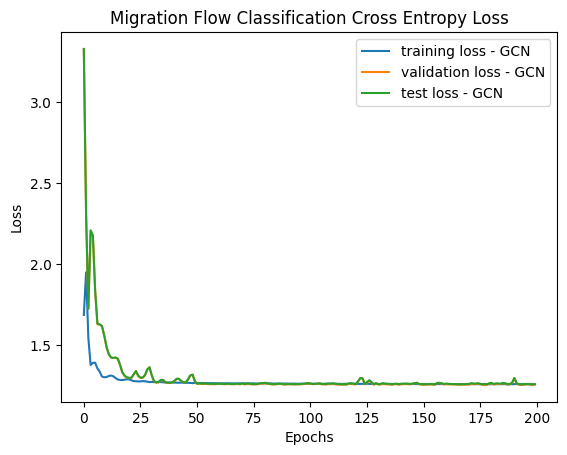

Running pipeline with config: Classification_GCN_full_within_state


Training:   0%|          | 1/200 [00:00<00:35,  5.57Epochs/s]

Epoch 1: Training Loss 1.6891, Training F1 Score (Micro) 0.16172 Validation Loss 1.5696 Validation F1 Score (Micro) 0.47407
Epoch 2: Training Loss 1.50907, Training F1 Score (Micro) 0.47159 Validation Loss 1.65926 Validation F1 Score (Micro) 0.21292


Training:   2%|▏         | 3/200 [00:00<00:38,  5.14Epochs/s]

Epoch 3: Training Loss 1.43914, Training F1 Score (Micro) 0.48591 Validation Loss 2.12732 Validation F1 Score (Micro) 0.13528
Epoch 4: Training Loss 1.41026, Training F1 Score (Micro) 0.47487 Validation Loss 2.35937 Validation F1 Score (Micro) 0.13462


Training:   2%|▎         | 5/200 [00:00<00:37,  5.20Epochs/s]

Epoch 5: Training Loss 1.37061, Training F1 Score (Micro) 0.47933 Validation Loss 2.83411 Validation F1 Score (Micro) 0.13545
Epoch 6: Training Loss 1.36083, Training F1 Score (Micro) 0.48693 Validation Loss 3.37789 Validation F1 Score (Micro) 0.13495


Training:   4%|▎         | 7/200 [00:01<00:39,  4.86Epochs/s]

Epoch 7: Training Loss 1.33733, Training F1 Score (Micro) 0.49899 Validation Loss 3.70396 Validation F1 Score (Micro) 0.13413
Epoch 8: Training Loss 1.34338, Training F1 Score (Micro) 0.49672 Validation Loss 4.03932 Validation F1 Score (Micro) 0.13347


Training:   4%|▍         | 9/200 [00:01<00:39,  4.88Epochs/s]

Epoch 9: Training Loss 1.32081, Training F1 Score (Micro) 0.50297 Validation Loss 3.94511 Validation F1 Score (Micro) 0.13413
Epoch 10: Training Loss 1.3153, Training F1 Score (Micro) 0.50387 Validation Loss 3.60243 Validation F1 Score (Micro) 0.13677


Training:   6%|▌         | 12/200 [00:02<00:35,  5.25Epochs/s]

Epoch 11: Training Loss 1.31925, Training F1 Score (Micro) 0.50323 Validation Loss 3.31943 Validation F1 Score (Micro) 0.13991
Epoch 12: Training Loss 1.30712, Training F1 Score (Micro) 0.50849 Validation Loss 3.03517 Validation F1 Score (Micro) 0.15197


Training:   6%|▋         | 13/200 [00:02<00:36,  5.11Epochs/s]

Epoch 13: Training Loss 1.30488, Training F1 Score (Micro) 0.5076 Validation Loss 2.7402 Validation F1 Score (Micro) 0.17212
Epoch 14: Training Loss 1.30053, Training F1 Score (Micro) 0.51064 Validation Loss 2.46813 Validation F1 Score (Micro) 0.19491


Training:   8%|▊         | 15/200 [00:02<00:35,  5.16Epochs/s]

Epoch 15: Training Loss 1.29992, Training F1 Score (Micro) 0.51074 Validation Loss 2.2144 Validation F1 Score (Micro) 0.21738


Training:   8%|▊         | 16/200 [00:03<00:37,  4.92Epochs/s]

Epoch 16: Training Loss 1.29866, Training F1 Score (Micro) 0.5058 Validation Loss 2.08531 Validation F1 Score (Micro) 0.23423


Training:   8%|▊         | 17/200 [00:03<00:39,  4.59Epochs/s]

Epoch 17: Training Loss 1.29808, Training F1 Score (Micro) 0.5037 Validation Loss 2.05273 Validation F1 Score (Micro) 0.24529


Training:   9%|▉         | 18/200 [00:03<00:42,  4.29Epochs/s]

Epoch 18: Training Loss 1.29479, Training F1 Score (Micro) 0.50932 Validation Loss 1.99457 Validation F1 Score (Micro) 0.25768


Training:  10%|▉         | 19/200 [00:03<00:42,  4.25Epochs/s]

Epoch 19: Training Loss 1.29276, Training F1 Score (Micro) 0.51187 Validation Loss 1.89702 Validation F1 Score (Micro) 0.27965


Training:  10%|█         | 20/200 [00:04<00:41,  4.34Epochs/s]

Epoch 20: Training Loss 1.29158, Training F1 Score (Micro) 0.51225 Validation Loss 1.76635 Validation F1 Score (Micro) 0.31054


Training:  10%|█         | 21/200 [00:04<00:41,  4.35Epochs/s]

Epoch 21: Training Loss 1.29062, Training F1 Score (Micro) 0.51161 Validation Loss 1.65123 Validation F1 Score (Micro) 0.33944


Training:  11%|█         | 22/200 [00:04<00:43,  4.12Epochs/s]

Epoch 22: Training Loss 1.28676, Training F1 Score (Micro) 0.51293 Validation Loss 1.56916 Validation F1 Score (Micro) 0.3705


Training:  12%|█▏        | 23/200 [00:04<00:43,  4.10Epochs/s]

Epoch 23: Training Loss 1.28516, Training F1 Score (Micro) 0.51286 Validation Loss 1.51374 Validation F1 Score (Micro) 0.39115


Training:  12%|█▏        | 24/200 [00:05<00:43,  4.05Epochs/s]

Epoch 24: Training Loss 1.28471, Training F1 Score (Micro) 0.51166 Validation Loss 1.48968 Validation F1 Score (Micro) 0.40899


Training:  12%|█▎        | 25/200 [00:05<00:43,  3.98Epochs/s]

Epoch 25: Training Loss 1.28464, Training F1 Score (Micro) 0.51267 Validation Loss 1.48622 Validation F1 Score (Micro) 0.41146


Training:  13%|█▎        | 26/200 [00:05<00:44,  3.87Epochs/s]

Epoch 26: Training Loss 1.28211, Training F1 Score (Micro) 0.51321 Validation Loss 1.47757 Validation F1 Score (Micro) 0.41691


Training:  14%|█▎        | 27/200 [00:05<00:46,  3.70Epochs/s]

Epoch 27: Training Loss 1.28168, Training F1 Score (Micro) 0.51442 Validation Loss 1.4344 Validation F1 Score (Micro) 0.43261


Training:  14%|█▍        | 28/200 [00:06<00:44,  3.84Epochs/s]

Epoch 28: Training Loss 1.28085, Training F1 Score (Micro) 0.51432 Validation Loss 1.3832 Validation F1 Score (Micro) 0.45606


Training:  14%|█▍        | 29/200 [00:06<00:44,  3.87Epochs/s]

Epoch 29: Training Loss 1.28006, Training F1 Score (Micro) 0.51319 Validation Loss 1.36064 Validation F1 Score (Micro) 0.47142


Training:  15%|█▌        | 30/200 [00:06<00:44,  3.83Epochs/s]

Epoch 30: Training Loss 1.28089, Training F1 Score (Micro) 0.51258 Validation Loss 1.34686 Validation F1 Score (Micro) 0.47721


Training:  16%|█▌        | 31/200 [00:06<00:44,  3.82Epochs/s]

Epoch 31: Training Loss 1.27766, Training F1 Score (Micro) 0.51378 Validation Loss 1.32887 Validation F1 Score (Micro) 0.4853


Training:  16%|█▌        | 32/200 [00:07<00:41,  4.00Epochs/s]

Epoch 32: Training Loss 1.27784, Training F1 Score (Micro) 0.51442 Validation Loss 1.3094 Validation F1 Score (Micro) 0.49488


Training:  16%|█▋        | 33/200 [00:07<00:40,  4.15Epochs/s]

Epoch 33: Training Loss 1.27571, Training F1 Score (Micro) 0.51694 Validation Loss 1.28912 Validation F1 Score (Micro) 0.50694


Training:  17%|█▋        | 34/200 [00:07<00:40,  4.14Epochs/s]

Epoch 34: Training Loss 1.27735, Training F1 Score (Micro) 0.51411 Validation Loss 1.27321 Validation F1 Score (Micro) 0.51222


Training:  18%|█▊        | 35/200 [00:07<00:42,  3.89Epochs/s]

Epoch 35: Training Loss 1.27344, Training F1 Score (Micro) 0.51604 Validation Loss 1.26763 Validation F1 Score (Micro) 0.51734


Training:  18%|█▊        | 36/200 [00:08<00:42,  3.82Epochs/s]

Epoch 36: Training Loss 1.27478, Training F1 Score (Micro) 0.51475 Validation Loss 1.26415 Validation F1 Score (Micro) 0.51652


Training:  18%|█▊        | 37/200 [00:08<00:44,  3.69Epochs/s]

Epoch 37: Training Loss 1.27255, Training F1 Score (Micro) 0.51505 Validation Loss 1.26407 Validation F1 Score (Micro) 0.51536


Training:  19%|█▉        | 38/200 [00:08<00:42,  3.77Epochs/s]

Epoch 38: Training Loss 1.2728, Training F1 Score (Micro) 0.51616 Validation Loss 1.26943 Validation F1 Score (Micro) 0.51635


Training:  20%|█▉        | 39/200 [00:09<00:42,  3.76Epochs/s]

Epoch 39: Training Loss 1.27223, Training F1 Score (Micro) 0.51718 Validation Loss 1.27607 Validation F1 Score (Micro) 0.51024


Training:  20%|██        | 40/200 [00:09<00:40,  3.98Epochs/s]

Epoch 40: Training Loss 1.27158, Training F1 Score (Micro) 0.5168 Validation Loss 1.28484 Validation F1 Score (Micro) 0.50661


Training:  20%|██        | 41/200 [00:09<00:38,  4.15Epochs/s]

Epoch 41: Training Loss 1.27056, Training F1 Score (Micro) 0.51741 Validation Loss 1.28412 Validation F1 Score (Micro) 0.50595


Training:  21%|██        | 42/200 [00:09<00:37,  4.25Epochs/s]

Epoch 42: Training Loss 1.27127, Training F1 Score (Micro) 0.51781 Validation Loss 1.28194 Validation F1 Score (Micro) 0.50743


Training:  22%|██▏       | 43/200 [00:09<00:37,  4.16Epochs/s]

Epoch 43: Training Loss 1.27186, Training F1 Score (Micro) 0.51755 Validation Loss 1.27354 Validation F1 Score (Micro) 0.5114


Training:  22%|██▏       | 44/200 [00:10<00:36,  4.26Epochs/s]

Epoch 44: Training Loss 1.27086, Training F1 Score (Micro) 0.51763 Validation Loss 1.27184 Validation F1 Score (Micro) 0.51272


Training:  22%|██▎       | 45/200 [00:10<00:35,  4.35Epochs/s]

Epoch 45: Training Loss 1.26994, Training F1 Score (Micro) 0.51666 Validation Loss 1.27154 Validation F1 Score (Micro) 0.5109


Training:  23%|██▎       | 46/200 [00:10<00:35,  4.35Epochs/s]

Epoch 46: Training Loss 1.26927, Training F1 Score (Micro) 0.51706 Validation Loss 1.26038 Validation F1 Score (Micro) 0.51685


Training:  24%|██▎       | 47/200 [00:10<00:35,  4.27Epochs/s]

Epoch 47: Training Loss 1.2703, Training F1 Score (Micro) 0.51553 Validation Loss 1.25418 Validation F1 Score (Micro) 0.52197


Training:  24%|██▍       | 48/200 [00:11<00:36,  4.17Epochs/s]

Epoch 48: Training Loss 1.26897, Training F1 Score (Micro) 0.51869 Validation Loss 1.25594 Validation F1 Score (Micro) 0.52213


Training:  24%|██▍       | 49/200 [00:11<00:37,  4.07Epochs/s]

Epoch 49: Training Loss 1.26879, Training F1 Score (Micro) 0.51687 Validation Loss 1.25263 Validation F1 Score (Micro) 0.52246


Training:  25%|██▌       | 50/200 [00:11<00:37,  3.99Epochs/s]

Epoch 50: Training Loss 1.26779, Training F1 Score (Micro) 0.51763 Validation Loss 1.25451 Validation F1 Score (Micro) 0.51916


Training:  26%|██▌       | 51/200 [00:11<00:36,  4.10Epochs/s]

Epoch 51: Training Loss 1.26778, Training F1 Score (Micro) 0.51892 Validation Loss 1.25664 Validation F1 Score (Micro) 0.51949


Training:  26%|██▌       | 52/200 [00:12<00:34,  4.28Epochs/s]

Epoch 52: Training Loss 1.26776, Training F1 Score (Micro) 0.518 Validation Loss 1.25408 Validation F1 Score (Micro) 0.51999


Training:  26%|██▋       | 53/200 [00:12<00:34,  4.32Epochs/s]

Epoch 53: Training Loss 1.26783, Training F1 Score (Micro) 0.51831 Validation Loss 1.2525 Validation F1 Score (Micro) 0.5218


Training:  27%|██▋       | 54/200 [00:12<00:33,  4.41Epochs/s]

Epoch 54: Training Loss 1.26705, Training F1 Score (Micro) 0.51937 Validation Loss 1.2524 Validation F1 Score (Micro) 0.52213
Epoch 55: Training Loss 1.26651, Training F1 Score (Micro) 0.51909 Validation Loss 1.25351 Validation F1 Score (Micro) 0.52048


Training:  28%|██▊       | 56/200 [00:12<00:30,  4.74Epochs/s]

Epoch 56: Training Loss 1.26572, Training F1 Score (Micro) 0.5177 Validation Loss 1.2562 Validation F1 Score (Micro) 0.51685
Epoch 57: Training Loss 1.26712, Training F1 Score (Micro) 0.51805 Validation Loss 1.25407 Validation F1 Score (Micro) 0.51767


Training:  29%|██▉       | 58/200 [00:13<00:29,  4.85Epochs/s]

Epoch 58: Training Loss 1.26602, Training F1 Score (Micro) 0.518 Validation Loss 1.25322 Validation F1 Score (Micro) 0.52065
Epoch 59: Training Loss 1.26549, Training F1 Score (Micro) 0.51722 Validation Loss 1.25332 Validation F1 Score (Micro) 0.52081


Training:  30%|███       | 60/200 [00:13<00:27,  5.07Epochs/s]

Epoch 60: Training Loss 1.26629, Training F1 Score (Micro) 0.5194 Validation Loss 1.25495 Validation F1 Score (Micro) 0.51966
Epoch 61: Training Loss 1.26537, Training F1 Score (Micro) 0.51994 Validation Loss 1.252 Validation F1 Score (Micro) 0.52263


Training:  31%|███       | 62/200 [00:14<00:27,  5.10Epochs/s]

Epoch 62: Training Loss 1.26461, Training F1 Score (Micro) 0.51914 Validation Loss 1.25064 Validation F1 Score (Micro) 0.52362
Epoch 63: Training Loss 1.26565, Training F1 Score (Micro) 0.51763 Validation Loss 1.24999 Validation F1 Score (Micro) 0.52428


Training:  32%|███▏      | 64/200 [00:14<00:26,  5.12Epochs/s]

Epoch 64: Training Loss 1.26509, Training F1 Score (Micro) 0.5189 Validation Loss 1.25016 Validation F1 Score (Micro) 0.52213
Epoch 65: Training Loss 1.26378, Training F1 Score (Micro) 0.51961 Validation Loss 1.25067 Validation F1 Score (Micro) 0.52263


Training:  33%|███▎      | 66/200 [00:14<00:26,  5.05Epochs/s]

Epoch 66: Training Loss 1.2639, Training F1 Score (Micro) 0.51864 Validation Loss 1.25027 Validation F1 Score (Micro) 0.52246
Epoch 67: Training Loss 1.26277, Training F1 Score (Micro) 0.51977 Validation Loss 1.25407 Validation F1 Score (Micro) 0.52098


Training:  34%|███▍      | 68/200 [00:15<00:26,  5.01Epochs/s]

Epoch 68: Training Loss 1.26496, Training F1 Score (Micro) 0.51824 Validation Loss 1.25116 Validation F1 Score (Micro) 0.52279
Epoch 69: Training Loss 1.26476, Training F1 Score (Micro) 0.518 Validation Loss 1.24945 Validation F1 Score (Micro) 0.52131


Training:  35%|███▌      | 70/200 [00:15<00:25,  5.04Epochs/s]

Epoch 70: Training Loss 1.26341, Training F1 Score (Micro) 0.51899 Validation Loss 1.25052 Validation F1 Score (Micro) 0.52131
Epoch 71: Training Loss 1.26522, Training F1 Score (Micro) 0.51607 Validation Loss 1.25285 Validation F1 Score (Micro) 0.52048


Training:  36%|███▌      | 72/200 [00:16<00:25,  5.04Epochs/s]

Epoch 72: Training Loss 1.26396, Training F1 Score (Micro) 0.5185 Validation Loss 1.25027 Validation F1 Score (Micro) 0.52164
Epoch 73: Training Loss 1.26324, Training F1 Score (Micro) 0.51954 Validation Loss 1.24861 Validation F1 Score (Micro) 0.52329


Training:  37%|███▋      | 74/200 [00:16<00:25,  5.04Epochs/s]

Epoch 74: Training Loss 1.2633, Training F1 Score (Micro) 0.51916 Validation Loss 1.24884 Validation F1 Score (Micro) 0.52263
Epoch 75: Training Loss 1.26301, Training F1 Score (Micro) 0.51956 Validation Loss 1.25214 Validation F1 Score (Micro) 0.52147


Training:  38%|███▊      | 76/200 [00:16<00:24,  5.02Epochs/s]

Epoch 76: Training Loss 1.26059, Training F1 Score (Micro) 0.52102 Validation Loss 1.25148 Validation F1 Score (Micro) 0.52164
Epoch 77: Training Loss 1.26439, Training F1 Score (Micro) 0.51857 Validation Loss 1.24916 Validation F1 Score (Micro) 0.52098


Training:  39%|███▉      | 78/200 [00:17<00:23,  5.13Epochs/s]

Epoch 78: Training Loss 1.26087, Training F1 Score (Micro) 0.51977 Validation Loss 1.25032 Validation F1 Score (Micro) 0.52147


Training:  40%|███▉      | 79/200 [00:17<00:24,  5.00Epochs/s]

Epoch 79: Training Loss 1.26229, Training F1 Score (Micro) 0.52024 Validation Loss 1.2525 Validation F1 Score (Micro) 0.52296
Epoch 80: Training Loss 1.26313, Training F1 Score (Micro) 0.51977 Validation Loss 1.25221 Validation F1 Score (Micro) 0.52296


Training:  40%|████      | 81/200 [00:17<00:23,  5.05Epochs/s]

Epoch 81: Training Loss 1.2615, Training F1 Score (Micro) 0.51888 Validation Loss 1.25486 Validation F1 Score (Micro) 0.51685
Epoch 82: Training Loss 1.26199, Training F1 Score (Micro) 0.5194 Validation Loss 1.26007 Validation F1 Score (Micro) 0.51569


Training:  42%|████▏     | 83/200 [00:18<00:22,  5.21Epochs/s]

Epoch 83: Training Loss 1.26315, Training F1 Score (Micro) 0.51968 Validation Loss 1.25317 Validation F1 Score (Micro) 0.51933
Epoch 84: Training Loss 1.26082, Training F1 Score (Micro) 0.5201 Validation Loss 1.24971 Validation F1 Score (Micro) 0.52329


Training:  42%|████▎     | 85/200 [00:18<00:22,  5.21Epochs/s]

Epoch 85: Training Loss 1.26054, Training F1 Score (Micro) 0.52083 Validation Loss 1.24958 Validation F1 Score (Micro) 0.52246
Epoch 86: Training Loss 1.26192, Training F1 Score (Micro) 0.51968 Validation Loss 1.24717 Validation F1 Score (Micro) 0.52395


Training:  44%|████▍     | 88/200 [00:19<00:21,  5.27Epochs/s]

Epoch 87: Training Loss 1.26073, Training F1 Score (Micro) 0.52048 Validation Loss 1.24695 Validation F1 Score (Micro) 0.52445
Epoch 88: Training Loss 1.26106, Training F1 Score (Micro) 0.52107 Validation Loss 1.25424 Validation F1 Score (Micro) 0.51999


Training:  44%|████▍     | 89/200 [00:19<00:21,  5.09Epochs/s]

Epoch 89: Training Loss 1.25969, Training F1 Score (Micro) 0.52024 Validation Loss 1.25533 Validation F1 Score (Micro) 0.51949
Epoch 90: Training Loss 1.25998, Training F1 Score (Micro) 0.51885 Validation Loss 1.25075 Validation F1 Score (Micro) 0.52065


Training:  46%|████▌     | 91/200 [00:19<00:21,  5.06Epochs/s]

Epoch 91: Training Loss 1.26005, Training F1 Score (Micro) 0.52003 Validation Loss 1.24786 Validation F1 Score (Micro) 0.52362
Epoch 92: Training Loss 1.25935, Training F1 Score (Micro) 0.52074 Validation Loss 1.24807 Validation F1 Score (Micro) 0.52346


Training:  47%|████▋     | 94/200 [00:20<00:20,  5.30Epochs/s]

Epoch 93: Training Loss 1.2594, Training F1 Score (Micro) 0.52154 Validation Loss 1.24744 Validation F1 Score (Micro) 0.52379
Epoch 94: Training Loss 1.25856, Training F1 Score (Micro) 0.52145 Validation Loss 1.24829 Validation F1 Score (Micro) 0.52246


Training:  48%|████▊     | 95/200 [00:20<00:20,  5.10Epochs/s]

Epoch 95: Training Loss 1.25804, Training F1 Score (Micro) 0.52112 Validation Loss 1.24914 Validation F1 Score (Micro) 0.52114
Epoch 96: Training Loss 1.25923, Training F1 Score (Micro) 0.51973 Validation Loss 1.24805 Validation F1 Score (Micro) 0.52098


Training:  48%|████▊     | 97/200 [00:20<00:20,  5.05Epochs/s]

Epoch 97: Training Loss 1.25746, Training F1 Score (Micro) 0.52133 Validation Loss 1.2464 Validation F1 Score (Micro) 0.52395
Epoch 98: Training Loss 1.25907, Training F1 Score (Micro) 0.52001 Validation Loss 1.25238 Validation F1 Score (Micro) 0.52147


Training:  50%|████▉     | 99/200 [00:21<00:19,  5.13Epochs/s]

Epoch 99: Training Loss 1.26019, Training F1 Score (Micro) 0.51987 Validation Loss 1.25861 Validation F1 Score (Micro) 0.51767
Epoch 100: Training Loss 1.25928, Training F1 Score (Micro) 0.52015 Validation Loss 1.25176 Validation F1 Score (Micro) 0.52197


Training:  50%|█████     | 101/200 [00:21<00:20,  4.91Epochs/s]

Epoch 101: Training Loss 1.2591, Training F1 Score (Micro) 0.52072 Validation Loss 1.24821 Validation F1 Score (Micro) 0.52395


Training:  51%|█████     | 102/200 [00:21<00:21,  4.62Epochs/s]

Epoch 102: Training Loss 1.25882, Training F1 Score (Micro) 0.52135 Validation Loss 1.24741 Validation F1 Score (Micro) 0.52131


Training:  52%|█████▏    | 103/200 [00:22<00:22,  4.28Epochs/s]

Epoch 103: Training Loss 1.25925, Training F1 Score (Micro) 0.5205 Validation Loss 1.2493 Validation F1 Score (Micro) 0.52279


Training:  52%|█████▏    | 104/200 [00:22<00:22,  4.22Epochs/s]

Epoch 104: Training Loss 1.25838, Training F1 Score (Micro) 0.52032 Validation Loss 1.24947 Validation F1 Score (Micro) 0.52263


Training:  52%|█████▎    | 105/200 [00:22<00:23,  4.12Epochs/s]

Epoch 105: Training Loss 1.25868, Training F1 Score (Micro) 0.52211 Validation Loss 1.25147 Validation F1 Score (Micro) 0.51751


Training:  53%|█████▎    | 106/200 [00:23<00:23,  4.05Epochs/s]

Epoch 106: Training Loss 1.25769, Training F1 Score (Micro) 0.52055 Validation Loss 1.24628 Validation F1 Score (Micro) 0.52478


Training:  54%|█████▎    | 107/200 [00:23<00:23,  3.93Epochs/s]

Epoch 107: Training Loss 1.25694, Training F1 Score (Micro) 0.52154 Validation Loss 1.24814 Validation F1 Score (Micro) 0.52147


Training:  54%|█████▍    | 108/200 [00:23<00:23,  3.98Epochs/s]

Epoch 108: Training Loss 1.25731, Training F1 Score (Micro) 0.52055 Validation Loss 1.25414 Validation F1 Score (Micro) 0.51933


Training:  55%|█████▍    | 109/200 [00:23<00:23,  3.88Epochs/s]

Epoch 109: Training Loss 1.25713, Training F1 Score (Micro) 0.52072 Validation Loss 1.25204 Validation F1 Score (Micro) 0.52065


Training:  55%|█████▌    | 110/200 [00:24<00:23,  3.82Epochs/s]

Epoch 110: Training Loss 1.25967, Training F1 Score (Micro) 0.5194 Validation Loss 1.24685 Validation F1 Score (Micro) 0.52313


Training:  56%|█████▌    | 111/200 [00:24<00:23,  3.87Epochs/s]

Epoch 111: Training Loss 1.25666, Training F1 Score (Micro) 0.52062 Validation Loss 1.2457 Validation F1 Score (Micro) 0.52395


Training:  56%|█████▌    | 112/200 [00:24<00:22,  3.89Epochs/s]

Epoch 112: Training Loss 1.25803, Training F1 Score (Micro) 0.52022 Validation Loss 1.25456 Validation F1 Score (Micro) 0.5152


Training:  56%|█████▋    | 113/200 [00:24<00:21,  3.98Epochs/s]

Epoch 113: Training Loss 1.25755, Training F1 Score (Micro) 0.52091 Validation Loss 1.25681 Validation F1 Score (Micro) 0.5147


Training:  57%|█████▋    | 114/200 [00:25<00:21,  4.08Epochs/s]

Epoch 114: Training Loss 1.25866, Training F1 Score (Micro) 0.51963 Validation Loss 1.25071 Validation F1 Score (Micro) 0.51883


Training:  57%|█████▊    | 115/200 [00:25<00:20,  4.12Epochs/s]

Epoch 115: Training Loss 1.2578, Training F1 Score (Micro) 0.52027 Validation Loss 1.24662 Validation F1 Score (Micro) 0.52197


Training:  58%|█████▊    | 116/200 [00:25<00:20,  4.16Epochs/s]

Epoch 116: Training Loss 1.25696, Training F1 Score (Micro) 0.52102 Validation Loss 1.2456 Validation F1 Score (Micro) 0.52461


Training:  58%|█████▊    | 117/200 [00:25<00:19,  4.21Epochs/s]

Epoch 117: Training Loss 1.25718, Training F1 Score (Micro) 0.52121 Validation Loss 1.24773 Validation F1 Score (Micro) 0.52412


Training:  59%|█████▉    | 118/200 [00:25<00:19,  4.19Epochs/s]

Epoch 118: Training Loss 1.25797, Training F1 Score (Micro) 0.52161 Validation Loss 1.24809 Validation F1 Score (Micro) 0.52362


Training:  60%|█████▉    | 119/200 [00:26<00:18,  4.31Epochs/s]

Epoch 119: Training Loss 1.25784, Training F1 Score (Micro) 0.52145 Validation Loss 1.25022 Validation F1 Score (Micro) 0.5218


Training:  60%|██████    | 120/200 [00:26<00:19,  4.09Epochs/s]

Epoch 120: Training Loss 1.2552, Training F1 Score (Micro) 0.52175 Validation Loss 1.24709 Validation F1 Score (Micro) 0.52428


Training:  60%|██████    | 121/200 [00:26<00:19,  4.05Epochs/s]

Epoch 121: Training Loss 1.2556, Training F1 Score (Micro) 0.52204 Validation Loss 1.24775 Validation F1 Score (Micro) 0.51949


Training:  61%|██████    | 122/200 [00:27<00:20,  3.88Epochs/s]

Epoch 122: Training Loss 1.25608, Training F1 Score (Micro) 0.52135 Validation Loss 1.24597 Validation F1 Score (Micro) 0.52081


Training:  62%|██████▏   | 123/200 [00:27<00:20,  3.76Epochs/s]

Epoch 123: Training Loss 1.25656, Training F1 Score (Micro) 0.52095 Validation Loss 1.24412 Validation F1 Score (Micro) 0.5261


Training:  62%|██████▏   | 124/200 [00:27<00:20,  3.79Epochs/s]

Epoch 124: Training Loss 1.25406, Training F1 Score (Micro) 0.52216 Validation Loss 1.24423 Validation F1 Score (Micro) 0.52346


Training:  62%|██████▎   | 125/200 [00:27<00:19,  3.86Epochs/s]

Epoch 125: Training Loss 1.25635, Training F1 Score (Micro) 0.52116 Validation Loss 1.24531 Validation F1 Score (Micro) 0.52445


Training:  63%|██████▎   | 126/200 [00:28<00:19,  3.74Epochs/s]

Epoch 126: Training Loss 1.25572, Training F1 Score (Micro) 0.52128 Validation Loss 1.24988 Validation F1 Score (Micro) 0.52147


Training:  64%|██████▎   | 127/200 [00:28<00:19,  3.68Epochs/s]

Epoch 127: Training Loss 1.25638, Training F1 Score (Micro) 0.52171 Validation Loss 1.24688 Validation F1 Score (Micro) 0.5223


Training:  64%|██████▍   | 128/200 [00:28<00:19,  3.71Epochs/s]

Epoch 128: Training Loss 1.25465, Training F1 Score (Micro) 0.52216 Validation Loss 1.2431 Validation F1 Score (Micro) 0.52676


Training:  64%|██████▍   | 129/200 [00:28<00:19,  3.63Epochs/s]

Epoch 129: Training Loss 1.25336, Training F1 Score (Micro) 0.5222 Validation Loss 1.24337 Validation F1 Score (Micro) 0.5261


Training:  65%|██████▌   | 130/200 [00:29<00:19,  3.60Epochs/s]

Epoch 130: Training Loss 1.25516, Training F1 Score (Micro) 0.52055 Validation Loss 1.24403 Validation F1 Score (Micro) 0.52313


Training:  66%|██████▌   | 131/200 [00:29<00:18,  3.81Epochs/s]

Epoch 131: Training Loss 1.25587, Training F1 Score (Micro) 0.52072 Validation Loss 1.24549 Validation F1 Score (Micro) 0.52164
Epoch 132: Training Loss 1.25379, Training F1 Score (Micro) 0.52192 Validation Loss 1.24878 Validation F1 Score (Micro) 0.51833


Training:  66%|██████▋   | 133/200 [00:29<00:15,  4.41Epochs/s]

Epoch 133: Training Loss 1.2553, Training F1 Score (Micro) 0.52225 Validation Loss 1.24647 Validation F1 Score (Micro) 0.52395
Epoch 134: Training Loss 1.25535, Training F1 Score (Micro) 0.52008 Validation Loss 1.24861 Validation F1 Score (Micro) 0.52346


Training:  68%|██████▊   | 136/200 [00:30<00:12,  4.94Epochs/s]

Epoch 135: Training Loss 1.25504, Training F1 Score (Micro) 0.52154 Validation Loss 1.246 Validation F1 Score (Micro) 0.52544
Epoch 136: Training Loss 1.25396, Training F1 Score (Micro) 0.52197 Validation Loss 1.24566 Validation F1 Score (Micro) 0.52395


Training:  68%|██████▊   | 137/200 [00:30<00:12,  4.99Epochs/s]

Epoch 137: Training Loss 1.25537, Training F1 Score (Micro) 0.51949 Validation Loss 1.24679 Validation F1 Score (Micro) 0.52329
Epoch 138: Training Loss 1.25527, Training F1 Score (Micro) 0.52024 Validation Loss 1.24594 Validation F1 Score (Micro) 0.52279


Training:  70%|██████▉   | 139/200 [00:30<00:12,  5.07Epochs/s]

Epoch 139: Training Loss 1.25461, Training F1 Score (Micro) 0.52003 Validation Loss 1.24677 Validation F1 Score (Micro) 0.52213
Epoch 140: Training Loss 1.25527, Training F1 Score (Micro) 0.52126 Validation Loss 1.24384 Validation F1 Score (Micro) 0.52643


Training:  71%|███████   | 142/200 [00:31<00:10,  5.31Epochs/s]

Epoch 141: Training Loss 1.25426, Training F1 Score (Micro) 0.52277 Validation Loss 1.24615 Validation F1 Score (Micro) 0.52279
Epoch 142: Training Loss 1.25481, Training F1 Score (Micro) 0.52147 Validation Loss 1.2479 Validation F1 Score (Micro) 0.52362


Training:  72%|███████▏  | 143/200 [00:31<00:10,  5.21Epochs/s]

Epoch 143: Training Loss 1.2534, Training F1 Score (Micro) 0.5226 Validation Loss 1.24691 Validation F1 Score (Micro) 0.52362
Epoch 144: Training Loss 1.2554, Training F1 Score (Micro) 0.52185 Validation Loss 1.26573 Validation F1 Score (Micro) 0.51288


Training:  72%|███████▎  | 145/200 [00:32<00:10,  5.16Epochs/s]

Epoch 145: Training Loss 1.25507, Training F1 Score (Micro) 0.52114 Validation Loss 1.26914 Validation F1 Score (Micro) 0.51107


Training:  73%|███████▎  | 146/200 [00:32<00:10,  4.97Epochs/s]

Epoch 146: Training Loss 1.25525, Training F1 Score (Micro) 0.52166 Validation Loss 1.25256 Validation F1 Score (Micro) 0.5218


Training:  74%|███████▎  | 147/200 [00:32<00:10,  4.87Epochs/s]

Epoch 147: Training Loss 1.25437, Training F1 Score (Micro) 0.52166 Validation Loss 1.25945 Validation F1 Score (Micro) 0.5152


Training:  74%|███████▍  | 148/200 [00:32<00:10,  4.86Epochs/s]

Epoch 148: Training Loss 1.25628, Training F1 Score (Micro) 0.51909 Validation Loss 1.24557 Validation F1 Score (Micro) 0.52577


Training:  74%|███████▍  | 149/200 [00:32<00:10,  4.87Epochs/s]

Epoch 149: Training Loss 1.25482, Training F1 Score (Micro) 0.52126 Validation Loss 1.24525 Validation F1 Score (Micro) 0.52428
Epoch 150: Training Loss 1.25616, Training F1 Score (Micro) 0.51923 Validation Loss 1.24984 Validation F1 Score (Micro) 0.52032


Training:  76%|███████▌  | 151/200 [00:33<00:10,  4.89Epochs/s]

Epoch 151: Training Loss 1.2535, Training F1 Score (Micro) 0.5222 Validation Loss 1.246 Validation F1 Score (Micro) 0.52279
Epoch 152: Training Loss 1.25426, Training F1 Score (Micro) 0.51942 Validation Loss 1.24599 Validation F1 Score (Micro) 0.5223


Training:  76%|███████▋  | 153/200 [00:33<00:09,  4.93Epochs/s]

Epoch 153: Training Loss 1.25336, Training F1 Score (Micro) 0.52105 Validation Loss 1.24965 Validation F1 Score (Micro) 0.51652
Epoch 154: Training Loss 1.25343, Training F1 Score (Micro) 0.52211 Validation Loss 1.24344 Validation F1 Score (Micro) 0.52478


Training:  78%|███████▊  | 155/200 [00:34<00:09,  4.93Epochs/s]

Epoch 155: Training Loss 1.25378, Training F1 Score (Micro) 0.52216 Validation Loss 1.24818 Validation F1 Score (Micro) 0.52296
Epoch 156: Training Loss 1.25257, Training F1 Score (Micro) 0.52199 Validation Loss 1.24726 Validation F1 Score (Micro) 0.52478


Training:  78%|███████▊  | 157/200 [00:34<00:08,  5.02Epochs/s]

Epoch 157: Training Loss 1.25262, Training F1 Score (Micro) 0.52194 Validation Loss 1.24904 Validation F1 Score (Micro) 0.52263
Epoch 158: Training Loss 1.25534, Training F1 Score (Micro) 0.52013 Validation Loss 1.24503 Validation F1 Score (Micro) 0.52494


Training:  80%|████████  | 160/200 [00:35<00:07,  5.24Epochs/s]

Epoch 159: Training Loss 1.25375, Training F1 Score (Micro) 0.5222 Validation Loss 1.24698 Validation F1 Score (Micro) 0.51883
Epoch 160: Training Loss 1.25201, Training F1 Score (Micro) 0.52227 Validation Loss 1.26688 Validation F1 Score (Micro) 0.5114


Training:  80%|████████  | 161/200 [00:35<00:07,  5.11Epochs/s]

Epoch 161: Training Loss 1.25176, Training F1 Score (Micro) 0.52272 Validation Loss 1.27375 Validation F1 Score (Micro) 0.50942
Epoch 162: Training Loss 1.25389, Training F1 Score (Micro) 0.52152 Validation Loss 1.26403 Validation F1 Score (Micro) 0.51305


Training:  82%|████████▏ | 163/200 [00:35<00:07,  5.01Epochs/s]

Epoch 163: Training Loss 1.25288, Training F1 Score (Micro) 0.52216 Validation Loss 1.2593 Validation F1 Score (Micro) 0.51487
Epoch 164: Training Loss 1.25095, Training F1 Score (Micro) 0.52234 Validation Loss 1.24386 Validation F1 Score (Micro) 0.52296


Training:  82%|████████▎ | 165/200 [00:36<00:06,  5.05Epochs/s]

Epoch 165: Training Loss 1.25246, Training F1 Score (Micro) 0.52251 Validation Loss 1.25584 Validation F1 Score (Micro) 0.51553
Epoch 166: Training Loss 1.25397, Training F1 Score (Micro) 0.51961 Validation Loss 1.24504 Validation F1 Score (Micro) 0.52263


Training:  84%|████████▎ | 167/200 [00:36<00:06,  5.03Epochs/s]

Epoch 167: Training Loss 1.25228, Training F1 Score (Micro) 0.52206 Validation Loss 1.24323 Validation F1 Score (Micro) 0.52445
Epoch 168: Training Loss 1.25313, Training F1 Score (Micro) 0.52119 Validation Loss 1.24277 Validation F1 Score (Micro) 0.52511


Training:  84%|████████▍ | 169/200 [00:36<00:06,  4.95Epochs/s]

Epoch 169: Training Loss 1.25163, Training F1 Score (Micro) 0.52244 Validation Loss 1.24704 Validation F1 Score (Micro) 0.52296
Epoch 170: Training Loss 1.25365, Training F1 Score (Micro) 0.52114 Validation Loss 1.24588 Validation F1 Score (Micro) 0.52362


Training:  86%|████████▌ | 171/200 [00:37<00:05,  5.03Epochs/s]

Epoch 171: Training Loss 1.25373, Training F1 Score (Micro) 0.52159 Validation Loss 1.24317 Validation F1 Score (Micro) 0.52395
Epoch 172: Training Loss 1.25168, Training F1 Score (Micro) 0.52138 Validation Loss 1.2502 Validation F1 Score (Micro) 0.5223


Training:  86%|████████▋ | 173/200 [00:37<00:05,  5.15Epochs/s]

Epoch 173: Training Loss 1.25389, Training F1 Score (Micro) 0.52076 Validation Loss 1.2438 Validation F1 Score (Micro) 0.52461
Epoch 174: Training Loss 1.25179, Training F1 Score (Micro) 0.52225 Validation Loss 1.24416 Validation F1 Score (Micro) 0.52213


Training:  88%|████████▊ | 176/200 [00:38<00:04,  5.28Epochs/s]

Epoch 175: Training Loss 1.25211, Training F1 Score (Micro) 0.52201 Validation Loss 1.24639 Validation F1 Score (Micro) 0.5218
Epoch 176: Training Loss 1.253, Training F1 Score (Micro) 0.52173 Validation Loss 1.24677 Validation F1 Score (Micro) 0.52395


Training:  88%|████████▊ | 177/200 [00:38<00:04,  5.11Epochs/s]

Epoch 177: Training Loss 1.25331, Training F1 Score (Micro) 0.52164 Validation Loss 1.24692 Validation F1 Score (Micro) 0.51933
Epoch 178: Training Loss 1.25135, Training F1 Score (Micro) 0.52244 Validation Loss 1.25148 Validation F1 Score (Micro) 0.51817


Training:  90%|█████████ | 180/200 [00:39<00:03,  5.24Epochs/s]

Epoch 179: Training Loss 1.25428, Training F1 Score (Micro) 0.52036 Validation Loss 1.24684 Validation F1 Score (Micro) 0.52263
Epoch 180: Training Loss 1.25281, Training F1 Score (Micro) 0.52119 Validation Loss 1.25604 Validation F1 Score (Micro) 0.51734


Training:  90%|█████████ | 181/200 [00:39<00:03,  5.14Epochs/s]

Epoch 181: Training Loss 1.25455, Training F1 Score (Micro) 0.52098 Validation Loss 1.24406 Validation F1 Score (Micro) 0.52279


Training:  91%|█████████ | 182/200 [00:39<00:03,  4.68Epochs/s]

Epoch 182: Training Loss 1.25141, Training F1 Score (Micro) 0.52246 Validation Loss 1.26084 Validation F1 Score (Micro) 0.51454


Training:  92%|█████████▏| 183/200 [00:39<00:03,  4.41Epochs/s]

Epoch 183: Training Loss 1.25315, Training F1 Score (Micro) 0.52131 Validation Loss 1.25066 Validation F1 Score (Micro) 0.51949


Training:  92%|█████████▏| 184/200 [00:40<00:03,  4.13Epochs/s]

Epoch 184: Training Loss 1.25096, Training F1 Score (Micro) 0.52324 Validation Loss 1.24653 Validation F1 Score (Micro) 0.52461


Training:  92%|█████████▎| 185/200 [00:40<00:03,  3.97Epochs/s]

Epoch 185: Training Loss 1.25275, Training F1 Score (Micro) 0.52022 Validation Loss 1.24439 Validation F1 Score (Micro) 0.52478


Training:  93%|█████████▎| 186/200 [00:40<00:03,  3.90Epochs/s]

Epoch 186: Training Loss 1.25127, Training F1 Score (Micro) 0.52284 Validation Loss 1.25065 Validation F1 Score (Micro) 0.52048


Training:  94%|█████████▎| 187/200 [00:40<00:03,  3.89Epochs/s]

Epoch 187: Training Loss 1.25099, Training F1 Score (Micro) 0.52242 Validation Loss 1.25457 Validation F1 Score (Micro) 0.51817


Training:  94%|█████████▍| 188/200 [00:41<00:02,  4.04Epochs/s]

Epoch 188: Training Loss 1.25117, Training F1 Score (Micro) 0.52161 Validation Loss 1.24426 Validation F1 Score (Micro) 0.52114


Training:  94%|█████████▍| 189/200 [00:41<00:02,  3.99Epochs/s]

Epoch 189: Training Loss 1.25164, Training F1 Score (Micro) 0.52211 Validation Loss 1.24227 Validation F1 Score (Micro) 0.52544


Training:  95%|█████████▌| 190/200 [00:41<00:02,  4.03Epochs/s]

Epoch 190: Training Loss 1.25172, Training F1 Score (Micro) 0.52091 Validation Loss 1.24339 Validation F1 Score (Micro) 0.52461


Training:  96%|█████████▌| 191/200 [00:41<00:02,  3.98Epochs/s]

Epoch 191: Training Loss 1.25281, Training F1 Score (Micro) 0.52324 Validation Loss 1.24459 Validation F1 Score (Micro) 0.52213


Training:  96%|█████████▌| 192/200 [00:42<00:01,  4.04Epochs/s]

Epoch 192: Training Loss 1.25176, Training F1 Score (Micro) 0.52192 Validation Loss 1.24507 Validation F1 Score (Micro) 0.5218


Training:  96%|█████████▋| 193/200 [00:42<00:01,  3.96Epochs/s]

Epoch 193: Training Loss 1.25188, Training F1 Score (Micro) 0.52166 Validation Loss 1.25357 Validation F1 Score (Micro) 0.51718


Training:  97%|█████████▋| 194/200 [00:42<00:01,  4.14Epochs/s]

Epoch 194: Training Loss 1.24903, Training F1 Score (Micro) 0.52258 Validation Loss 1.25865 Validation F1 Score (Micro) 0.51487


Training:  98%|█████████▊| 195/200 [00:42<00:01,  4.19Epochs/s]

Epoch 195: Training Loss 1.25002, Training F1 Score (Micro) 0.52187 Validation Loss 1.24686 Validation F1 Score (Micro) 0.52346


Training:  98%|█████████▊| 196/200 [00:43<00:00,  4.21Epochs/s]

Epoch 196: Training Loss 1.24883, Training F1 Score (Micro) 0.52277 Validation Loss 1.24412 Validation F1 Score (Micro) 0.52511


Training:  98%|█████████▊| 197/200 [00:43<00:00,  4.24Epochs/s]

Epoch 197: Training Loss 1.25179, Training F1 Score (Micro) 0.52138 Validation Loss 1.24771 Validation F1 Score (Micro) 0.5218


Training:  99%|█████████▉| 198/200 [00:43<00:00,  4.24Epochs/s]

Epoch 198: Training Loss 1.25066, Training F1 Score (Micro) 0.52253 Validation Loss 1.24635 Validation F1 Score (Micro) 0.51999


Training: 100%|█████████▉| 199/200 [00:43<00:00,  4.33Epochs/s]

Epoch 199: Training Loss 1.25035, Training F1 Score (Micro) 0.52343 Validation Loss 1.24306 Validation F1 Score (Micro) 0.52461


Training: 100%|██████████| 200/200 [00:43<00:00,  4.55Epochs/s]

Epoch 200: Training Loss 1.2502, Training F1 Score (Micro) 0.52201 Validation Loss 1.24398 Validation F1 Score (Micro) 0.5256
Saving Model Predictions for Model Type GCN
Model saved successfully as Classification_GCN_full_within_state
Minimum validation loss: 1.2422707080841064
Minimum test loss: 1.2571111917495728
Best test metric: 0.5222992897033691


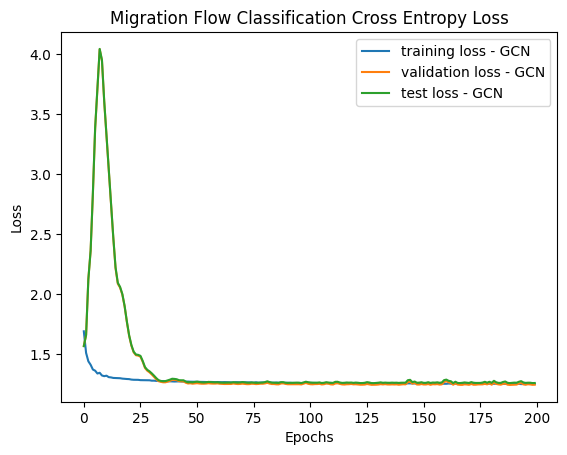

Running pipeline with config: Classification_GCN_simple_within_state


Training:   0%|          | 1/200 [00:00<00:45,  4.35Epochs/s]

Epoch 1: Training Loss 1.59931, Training F1 Score (Micro) 0.24567 Validation Loss 1.73889 Validation F1 Score (Micro) 0.47407
Epoch 2: Training Loss 1.40938, Training F1 Score (Micro) 0.48497 Validation Loss 1.5677 Validation F1 Score (Micro) 0.15775


Training:   2%|▏         | 4/200 [00:00<00:35,  5.54Epochs/s]

Epoch 3: Training Loss 1.35032, Training F1 Score (Micro) 0.4886 Validation Loss 2.04062 Validation F1 Score (Micro) 0.13479
Epoch 4: Training Loss 1.35582, Training F1 Score (Micro) 0.48358 Validation Loss 1.77797 Validation F1 Score (Micro) 0.13776


Training:   2%|▎         | 5/200 [00:00<00:36,  5.36Epochs/s]

Epoch 5: Training Loss 1.34368, Training F1 Score (Micro) 0.48969 Validation Loss 1.5338 Validation F1 Score (Micro) 0.39148
Epoch 6: Training Loss 1.33256, Training F1 Score (Micro) 0.49969 Validation Loss 1.45564 Validation F1 Score (Micro) 0.47407


Training:   4%|▍         | 8/200 [00:01<00:35,  5.45Epochs/s]

Epoch 7: Training Loss 1.32756, Training F1 Score (Micro) 0.50349 Validation Loss 1.42313 Validation F1 Score (Micro) 0.47407
Epoch 8: Training Loss 1.32705, Training F1 Score (Micro) 0.50189 Validation Loss 1.40255 Validation F1 Score (Micro) 0.47407


Training:   5%|▌         | 10/200 [00:01<00:34,  5.45Epochs/s]

Epoch 9: Training Loss 1.31874, Training F1 Score (Micro) 0.5051 Validation Loss 1.43076 Validation F1 Score (Micro) 0.50694
Epoch 10: Training Loss 1.31522, Training F1 Score (Micro) 0.5026 Validation Loss 1.51842 Validation F1 Score (Micro) 0.37066


Training:   6%|▌         | 12/200 [00:02<00:34,  5.45Epochs/s]

Epoch 11: Training Loss 1.31761, Training F1 Score (Micro) 0.50465 Validation Loss 1.59508 Validation F1 Score (Micro) 0.27486
Epoch 12: Training Loss 1.31782, Training F1 Score (Micro) 0.50495 Validation Loss 1.6176 Validation F1 Score (Micro) 0.27321


Training:   7%|▋         | 14/200 [00:02<00:34,  5.44Epochs/s]

Epoch 13: Training Loss 1.31718, Training F1 Score (Micro) 0.50415 Validation Loss 1.55359 Validation F1 Score (Micro) 0.34077
Epoch 14: Training Loss 1.30923, Training F1 Score (Micro) 0.5059 Validation Loss 1.43882 Validation F1 Score (Micro) 0.46829


Training:   8%|▊         | 15/200 [00:02<00:34,  5.32Epochs/s]

Epoch 15: Training Loss 1.3069, Training F1 Score (Micro) 0.50854 Validation Loss 1.36004 Validation F1 Score (Micro) 0.50281
Epoch 16: Training Loss 1.30605, Training F1 Score (Micro) 0.50637 Validation Loss 1.35682 Validation F1 Score (Micro) 0.47869


Training:   9%|▉         | 18/200 [00:03<00:34,  5.35Epochs/s]

Epoch 17: Training Loss 1.30406, Training F1 Score (Micro) 0.50762 Validation Loss 1.35579 Validation F1 Score (Micro) 0.48018
Epoch 18: Training Loss 1.30513, Training F1 Score (Micro) 0.50682 Validation Loss 1.34002 Validation F1 Score (Micro) 0.49323


Training:  10%|█         | 20/200 [00:03<00:32,  5.48Epochs/s]

Epoch 19: Training Loss 1.30779, Training F1 Score (Micro) 0.50578 Validation Loss 1.32894 Validation F1 Score (Micro) 0.49884
Epoch 20: Training Loss 1.30234, Training F1 Score (Micro) 0.50977 Validation Loss 1.32436 Validation F1 Score (Micro) 0.50396


Training:  11%|█         | 22/200 [00:04<00:32,  5.49Epochs/s]

Epoch 21: Training Loss 1.29779, Training F1 Score (Micro) 0.5092 Validation Loss 1.32587 Validation F1 Score (Micro) 0.50661
Epoch 22: Training Loss 1.29531, Training F1 Score (Micro) 0.51003 Validation Loss 1.32839 Validation F1 Score (Micro) 0.51107


Training:  12%|█▏        | 24/200 [00:04<00:31,  5.52Epochs/s]

Epoch 23: Training Loss 1.29728, Training F1 Score (Micro) 0.50691 Validation Loss 1.32562 Validation F1 Score (Micro) 0.51288
Epoch 24: Training Loss 1.29514, Training F1 Score (Micro) 0.50932 Validation Loss 1.31755 Validation F1 Score (Micro) 0.51206


Training:  13%|█▎        | 26/200 [00:04<00:31,  5.53Epochs/s]

Epoch 25: Training Loss 1.29308, Training F1 Score (Micro) 0.51026 Validation Loss 1.30288 Validation F1 Score (Micro) 0.51024
Epoch 26: Training Loss 1.29362, Training F1 Score (Micro) 0.50979 Validation Loss 1.29396 Validation F1 Score (Micro) 0.50776


Training:  14%|█▍        | 28/200 [00:05<00:31,  5.51Epochs/s]

Epoch 27: Training Loss 1.29206, Training F1 Score (Micro) 0.51173 Validation Loss 1.30191 Validation F1 Score (Micro) 0.50149
Epoch 28: Training Loss 1.28985, Training F1 Score (Micro) 0.51163 Validation Loss 1.30638 Validation F1 Score (Micro) 0.49752


Training:  15%|█▌        | 30/200 [00:05<00:30,  5.57Epochs/s]

Epoch 29: Training Loss 1.28912, Training F1 Score (Micro) 0.51109 Validation Loss 1.29567 Validation F1 Score (Micro) 0.50446
Epoch 30: Training Loss 1.28984, Training F1 Score (Micro) 0.51133 Validation Loss 1.28978 Validation F1 Score (Micro) 0.51321


Training:  16%|█▌        | 32/200 [00:05<00:30,  5.58Epochs/s]

Epoch 31: Training Loss 1.28878, Training F1 Score (Micro) 0.51088 Validation Loss 1.30073 Validation F1 Score (Micro) 0.50908
Epoch 32: Training Loss 1.28917, Training F1 Score (Micro) 0.51168 Validation Loss 1.30113 Validation F1 Score (Micro) 0.50776


Training:  17%|█▋        | 34/200 [00:06<00:29,  5.55Epochs/s]

Epoch 33: Training Loss 1.28789, Training F1 Score (Micro) 0.51024 Validation Loss 1.28681 Validation F1 Score (Micro) 0.51487
Epoch 34: Training Loss 1.28565, Training F1 Score (Micro) 0.51173 Validation Loss 1.30462 Validation F1 Score (Micro) 0.5005


Training:  18%|█▊        | 36/200 [00:06<00:29,  5.58Epochs/s]

Epoch 35: Training Loss 1.28464, Training F1 Score (Micro) 0.51192 Validation Loss 1.3415 Validation F1 Score (Micro) 0.48612
Epoch 36: Training Loss 1.28549, Training F1 Score (Micro) 0.51133 Validation Loss 1.33259 Validation F1 Score (Micro) 0.49438


Training:  18%|█▊        | 37/200 [00:06<00:30,  5.43Epochs/s]

Epoch 37: Training Loss 1.28516, Training F1 Score (Micro) 0.51227 Validation Loss 1.31648 Validation F1 Score (Micro) 0.50165
Epoch 38: Training Loss 1.28464, Training F1 Score (Micro) 0.51161 Validation Loss 1.32734 Validation F1 Score (Micro) 0.49306


Training:  20%|██        | 40/200 [00:07<00:29,  5.50Epochs/s]

Epoch 39: Training Loss 1.28379, Training F1 Score (Micro) 0.51286 Validation Loss 1.34491 Validation F1 Score (Micro) 0.48216
Epoch 40: Training Loss 1.28303, Training F1 Score (Micro) 0.51128 Validation Loss 1.34175 Validation F1 Score (Micro) 0.481


Training:  21%|██        | 42/200 [00:07<00:28,  5.56Epochs/s]

Epoch 41: Training Loss 1.2829, Training F1 Score (Micro) 0.51041 Validation Loss 1.29796 Validation F1 Score (Micro) 0.49719
Epoch 42: Training Loss 1.28275, Training F1 Score (Micro) 0.51133 Validation Loss 1.28 Validation F1 Score (Micro) 0.51553


Training:  22%|██▏       | 44/200 [00:08<00:28,  5.57Epochs/s]

Epoch 43: Training Loss 1.27891, Training F1 Score (Micro) 0.51456 Validation Loss 1.27948 Validation F1 Score (Micro) 0.51536
Epoch 44: Training Loss 1.28149, Training F1 Score (Micro) 0.5122 Validation Loss 1.30475 Validation F1 Score (Micro) 0.50363


Training:  22%|██▎       | 45/200 [00:08<00:28,  5.50Epochs/s]

Epoch 45: Training Loss 1.28016, Training F1 Score (Micro) 0.51253 Validation Loss 1.30639 Validation F1 Score (Micro) 0.50281
Epoch 46: Training Loss 1.28089, Training F1 Score (Micro) 0.51385 Validation Loss 1.28163 Validation F1 Score (Micro) 0.51288


Training:  24%|██▍       | 48/200 [00:08<00:26,  5.63Epochs/s]

Epoch 47: Training Loss 1.27683, Training F1 Score (Micro) 0.5131 Validation Loss 1.29425 Validation F1 Score (Micro) 0.50578
Epoch 48: Training Loss 1.27778, Training F1 Score (Micro) 0.51536 Validation Loss 1.29529 Validation F1 Score (Micro) 0.50479


Training:  25%|██▌       | 50/200 [00:09<00:26,  5.63Epochs/s]

Epoch 49: Training Loss 1.27705, Training F1 Score (Micro) 0.51352 Validation Loss 1.29096 Validation F1 Score (Micro) 0.50826
Epoch 50: Training Loss 1.27697, Training F1 Score (Micro) 0.5135 Validation Loss 1.42753 Validation F1 Score (Micro) 0.48084


Training:  26%|██▌       | 52/200 [00:09<00:26,  5.61Epochs/s]

Epoch 51: Training Loss 1.27823, Training F1 Score (Micro) 0.51305 Validation Loss 1.43825 Validation F1 Score (Micro) 0.48233
Epoch 52: Training Loss 1.27713, Training F1 Score (Micro) 0.51321 Validation Loss 1.36196 Validation F1 Score (Micro) 0.49422


Training:  26%|██▋       | 53/200 [00:09<00:26,  5.57Epochs/s]

Epoch 53: Training Loss 1.27862, Training F1 Score (Micro) 0.51251 Validation Loss 1.33702 Validation F1 Score (Micro) 0.4924
Epoch 54: Training Loss 1.2769, Training F1 Score (Micro) 0.51418 Validation Loss 1.3261 Validation F1 Score (Micro) 0.48431


Training:  28%|██▊       | 55/200 [00:10<00:26,  5.43Epochs/s]

Epoch 55: Training Loss 1.27686, Training F1 Score (Micro) 0.51446 Validation Loss 1.2857 Validation F1 Score (Micro) 0.50859
Epoch 56: Training Loss 1.27574, Training F1 Score (Micro) 0.51458 Validation Loss 1.27811 Validation F1 Score (Micro) 0.51569


Training:  28%|██▊       | 57/200 [00:10<00:28,  4.95Epochs/s]

Epoch 57: Training Loss 1.27712, Training F1 Score (Micro) 0.51442 Validation Loss 1.28248 Validation F1 Score (Micro) 0.51173


Training:  29%|██▉       | 58/200 [00:10<00:29,  4.78Epochs/s]

Epoch 58: Training Loss 1.27449, Training F1 Score (Micro) 0.51458 Validation Loss 1.32209 Validation F1 Score (Micro) 0.48646


Training:  30%|██▉       | 59/200 [00:11<00:31,  4.51Epochs/s]

Epoch 59: Training Loss 1.27689, Training F1 Score (Micro) 0.51508 Validation Loss 1.28693 Validation F1 Score (Micro) 0.50595


Training:  30%|███       | 60/200 [00:11<00:31,  4.41Epochs/s]

Epoch 60: Training Loss 1.27531, Training F1 Score (Micro) 0.51604 Validation Loss 1.28443 Validation F1 Score (Micro) 0.51156


Training:  30%|███       | 61/200 [00:11<00:31,  4.41Epochs/s]

Epoch 61: Training Loss 1.27635, Training F1 Score (Micro) 0.51444 Validation Loss 1.27502 Validation F1 Score (Micro) 0.51222


Training:  31%|███       | 62/200 [00:11<00:31,  4.34Epochs/s]

Epoch 62: Training Loss 1.2752, Training F1 Score (Micro) 0.51385 Validation Loss 1.29538 Validation F1 Score (Micro) 0.50066


Training:  32%|███▏      | 63/200 [00:12<00:32,  4.21Epochs/s]

Epoch 63: Training Loss 1.27491, Training F1 Score (Micro) 0.51595 Validation Loss 1.31546 Validation F1 Score (Micro) 0.4886


Training:  32%|███▏      | 64/200 [00:12<00:32,  4.14Epochs/s]

Epoch 64: Training Loss 1.2754, Training F1 Score (Micro) 0.51234 Validation Loss 1.2718 Validation F1 Score (Micro) 0.5152


Training:  32%|███▎      | 65/200 [00:12<00:33,  4.08Epochs/s]

Epoch 65: Training Loss 1.27345, Training F1 Score (Micro) 0.5159 Validation Loss 1.31118 Validation F1 Score (Micro) 0.49323


Training:  33%|███▎      | 66/200 [00:12<00:33,  4.05Epochs/s]

Epoch 66: Training Loss 1.27748, Training F1 Score (Micro) 0.51274 Validation Loss 1.29089 Validation F1 Score (Micro) 0.50264


Training:  34%|███▎      | 67/200 [00:12<00:32,  4.09Epochs/s]

Epoch 67: Training Loss 1.27512, Training F1 Score (Micro) 0.51361 Validation Loss 1.27531 Validation F1 Score (Micro) 0.51041


Training:  34%|███▍      | 68/200 [00:13<00:31,  4.17Epochs/s]

Epoch 68: Training Loss 1.27478, Training F1 Score (Micro) 0.51427 Validation Loss 1.28621 Validation F1 Score (Micro) 0.50496


Training:  34%|███▍      | 69/200 [00:13<00:31,  4.20Epochs/s]

Epoch 69: Training Loss 1.27487, Training F1 Score (Micro) 0.51477 Validation Loss 1.27346 Validation F1 Score (Micro) 0.51255


Training:  35%|███▌      | 70/200 [00:13<00:30,  4.26Epochs/s]

Epoch 70: Training Loss 1.27482, Training F1 Score (Micro) 0.5151 Validation Loss 1.27273 Validation F1 Score (Micro) 0.51107


Training:  36%|███▌      | 71/200 [00:13<00:29,  4.30Epochs/s]

Epoch 71: Training Loss 1.27382, Training F1 Score (Micro) 0.51574 Validation Loss 1.27726 Validation F1 Score (Micro) 0.51189


Training:  36%|███▌      | 72/200 [00:14<00:29,  4.30Epochs/s]

Epoch 72: Training Loss 1.27267, Training F1 Score (Micro) 0.51553 Validation Loss 1.27043 Validation F1 Score (Micro) 0.51602


Training:  36%|███▋      | 73/200 [00:14<00:29,  4.30Epochs/s]

Epoch 73: Training Loss 1.27227, Training F1 Score (Micro) 0.51529 Validation Loss 1.27957 Validation F1 Score (Micro) 0.51057


Training:  37%|███▋      | 74/200 [00:14<00:30,  4.16Epochs/s]

Epoch 74: Training Loss 1.27448, Training F1 Score (Micro) 0.51482 Validation Loss 1.2692 Validation F1 Score (Micro) 0.51437


Training:  38%|███▊      | 75/200 [00:14<00:30,  4.16Epochs/s]

Epoch 75: Training Loss 1.27403, Training F1 Score (Micro) 0.51475 Validation Loss 1.29567 Validation F1 Score (Micro) 0.50281


Training:  38%|███▊      | 76/200 [00:15<00:30,  4.05Epochs/s]

Epoch 76: Training Loss 1.27445, Training F1 Score (Micro) 0.51378 Validation Loss 1.2825 Validation F1 Score (Micro) 0.50925


Training:  38%|███▊      | 77/200 [00:15<00:30,  4.08Epochs/s]

Epoch 77: Training Loss 1.27456, Training F1 Score (Micro) 0.51366 Validation Loss 1.28643 Validation F1 Score (Micro) 0.5076


Training:  39%|███▉      | 78/200 [00:15<00:29,  4.08Epochs/s]

Epoch 78: Training Loss 1.27357, Training F1 Score (Micro) 0.5163 Validation Loss 1.31681 Validation F1 Score (Micro) 0.4929


Training:  40%|███▉      | 79/200 [00:15<00:29,  4.08Epochs/s]

Epoch 79: Training Loss 1.27387, Training F1 Score (Micro) 0.51562 Validation Loss 1.26953 Validation F1 Score (Micro) 0.51553


Training:  40%|████      | 80/200 [00:16<00:29,  4.01Epochs/s]

Epoch 80: Training Loss 1.2721, Training F1 Score (Micro) 0.51531 Validation Loss 1.27556 Validation F1 Score (Micro) 0.50958


Training:  40%|████      | 81/200 [00:16<00:29,  4.03Epochs/s]

Epoch 81: Training Loss 1.27329, Training F1 Score (Micro) 0.51482 Validation Loss 1.27491 Validation F1 Score (Micro) 0.51024


Training:  41%|████      | 82/200 [00:16<00:28,  4.17Epochs/s]

Epoch 82: Training Loss 1.27233, Training F1 Score (Micro) 0.51567 Validation Loss 1.27064 Validation F1 Score (Micro) 0.51586


Training:  42%|████▏     | 83/200 [00:16<00:27,  4.29Epochs/s]

Epoch 83: Training Loss 1.27276, Training F1 Score (Micro) 0.51489 Validation Loss 1.27916 Validation F1 Score (Micro) 0.51239


Training:  42%|████▏     | 84/200 [00:17<00:27,  4.28Epochs/s]

Epoch 84: Training Loss 1.27297, Training F1 Score (Micro) 0.51553 Validation Loss 1.27622 Validation F1 Score (Micro) 0.51338


Training:  42%|████▎     | 85/200 [00:17<00:27,  4.22Epochs/s]

Epoch 85: Training Loss 1.27375, Training F1 Score (Micro) 0.51461 Validation Loss 1.26965 Validation F1 Score (Micro) 0.51503


Training:  43%|████▎     | 86/200 [00:17<00:27,  4.10Epochs/s]

Epoch 86: Training Loss 1.27159, Training F1 Score (Micro) 0.51649 Validation Loss 1.2722 Validation F1 Score (Micro) 0.51371


Training:  44%|████▎     | 87/200 [00:17<00:26,  4.32Epochs/s]

Epoch 87: Training Loss 1.27212, Training F1 Score (Micro) 0.51619 Validation Loss 1.27241 Validation F1 Score (Micro) 0.51602


Training:  44%|████▍     | 88/200 [00:17<00:25,  4.34Epochs/s]

Epoch 88: Training Loss 1.27156, Training F1 Score (Micro) 0.51619 Validation Loss 1.30038 Validation F1 Score (Micro) 0.5033


Training:  44%|████▍     | 89/200 [00:18<00:24,  4.50Epochs/s]

Epoch 89: Training Loss 1.27273, Training F1 Score (Micro) 0.51406 Validation Loss 1.30816 Validation F1 Score (Micro) 0.5033


Training:  45%|████▌     | 90/200 [00:18<00:24,  4.58Epochs/s]

Epoch 90: Training Loss 1.27273, Training F1 Score (Micro) 0.5155 Validation Loss 1.28036 Validation F1 Score (Micro) 0.51421


Training:  46%|████▌     | 91/200 [00:18<00:23,  4.66Epochs/s]

Epoch 91: Training Loss 1.27291, Training F1 Score (Micro) 0.51602 Validation Loss 1.27022 Validation F1 Score (Micro) 0.5152


Training:  46%|████▌     | 92/200 [00:18<00:23,  4.67Epochs/s]

Epoch 92: Training Loss 1.27045, Training F1 Score (Micro) 0.51637 Validation Loss 1.26982 Validation F1 Score (Micro) 0.5152


Training:  46%|████▋     | 93/200 [00:19<00:23,  4.61Epochs/s]

Epoch 93: Training Loss 1.27018, Training F1 Score (Micro) 0.51635 Validation Loss 1.27592 Validation F1 Score (Micro) 0.51404


Training:  47%|████▋     | 94/200 [00:19<00:22,  4.70Epochs/s]

Epoch 94: Training Loss 1.27148, Training F1 Score (Micro) 0.51614 Validation Loss 1.30203 Validation F1 Score (Micro) 0.50809


Training:  48%|████▊     | 95/200 [00:19<00:22,  4.75Epochs/s]

Epoch 95: Training Loss 1.27092, Training F1 Score (Micro) 0.51484 Validation Loss 1.30464 Validation F1 Score (Micro) 0.50727


Training:  48%|████▊     | 96/200 [00:19<00:21,  4.81Epochs/s]

Epoch 96: Training Loss 1.27145, Training F1 Score (Micro) 0.51772 Validation Loss 1.28736 Validation F1 Score (Micro) 0.51123
Epoch 97: Training Loss 1.27016, Training F1 Score (Micro) 0.51812 Validation Loss 1.26989 Validation F1 Score (Micro) 0.5147


Training:  49%|████▉     | 98/200 [00:20<00:21,  4.69Epochs/s]

Epoch 98: Training Loss 1.27041, Training F1 Score (Micro) 0.51765 Validation Loss 1.26682 Validation F1 Score (Micro) 0.5147
Epoch 99: Training Loss 1.2707, Training F1 Score (Micro) 0.5155 Validation Loss 1.26854 Validation F1 Score (Micro) 0.51404


Training:  50%|█████     | 101/200 [00:20<00:18,  5.36Epochs/s]

Epoch 100: Training Loss 1.27195, Training F1 Score (Micro) 0.51482 Validation Loss 1.27341 Validation F1 Score (Micro) 0.5114
Epoch 101: Training Loss 1.27145, Training F1 Score (Micro) 0.51633 Validation Loss 1.26939 Validation F1 Score (Micro) 0.51536


Training:  52%|█████▏    | 103/200 [00:20<00:17,  5.45Epochs/s]

Epoch 102: Training Loss 1.27206, Training F1 Score (Micro) 0.51505 Validation Loss 1.27405 Validation F1 Score (Micro) 0.51635
Epoch 103: Training Loss 1.27058, Training F1 Score (Micro) 0.51567 Validation Loss 1.28567 Validation F1 Score (Micro) 0.50661


Training:  52%|█████▏    | 104/200 [00:21<00:18,  5.09Epochs/s]

Epoch 104: Training Loss 1.27114, Training F1 Score (Micro) 0.51489 Validation Loss 1.27769 Validation F1 Score (Micro) 0.50842
Epoch 105: Training Loss 1.27284, Training F1 Score (Micro) 0.51468 Validation Loss 1.26866 Validation F1 Score (Micro) 0.51354


Training:  54%|█████▎    | 107/200 [00:21<00:17,  5.41Epochs/s]

Epoch 106: Training Loss 1.27117, Training F1 Score (Micro) 0.51642 Validation Loss 1.27262 Validation F1 Score (Micro) 0.51404
Epoch 107: Training Loss 1.27016, Training F1 Score (Micro) 0.51616 Validation Loss 1.2685 Validation F1 Score (Micro) 0.51602


Training:  55%|█████▍    | 109/200 [00:22<00:16,  5.44Epochs/s]

Epoch 108: Training Loss 1.27042, Training F1 Score (Micro) 0.51741 Validation Loss 1.26801 Validation F1 Score (Micro) 0.51685
Epoch 109: Training Loss 1.27057, Training F1 Score (Micro) 0.51583 Validation Loss 1.26862 Validation F1 Score (Micro) 0.51569


Training:  56%|█████▌    | 111/200 [00:22<00:16,  5.46Epochs/s]

Epoch 110: Training Loss 1.27026, Training F1 Score (Micro) 0.51645 Validation Loss 1.27956 Validation F1 Score (Micro) 0.51189
Epoch 111: Training Loss 1.26966, Training F1 Score (Micro) 0.51671 Validation Loss 1.28252 Validation F1 Score (Micro) 0.50908


Training:  56%|█████▋    | 113/200 [00:22<00:15,  5.57Epochs/s]

Epoch 112: Training Loss 1.27049, Training F1 Score (Micro) 0.5164 Validation Loss 1.27436 Validation F1 Score (Micro) 0.51437
Epoch 113: Training Loss 1.27056, Training F1 Score (Micro) 0.51517 Validation Loss 1.2725 Validation F1 Score (Micro) 0.5147


Training:  57%|█████▋    | 114/200 [00:23<00:16,  5.32Epochs/s]

Epoch 114: Training Loss 1.26868, Training F1 Score (Micro) 0.51727 Validation Loss 1.27477 Validation F1 Score (Micro) 0.51454
Epoch 115: Training Loss 1.26983, Training F1 Score (Micro) 0.51704 Validation Loss 1.26763 Validation F1 Score (Micro) 0.51354


Training:  58%|█████▊    | 117/200 [00:23<00:15,  5.53Epochs/s]

Epoch 116: Training Loss 1.27186, Training F1 Score (Micro) 0.51564 Validation Loss 1.29488 Validation F1 Score (Micro) 0.50529
Epoch 117: Training Loss 1.27072, Training F1 Score (Micro) 0.5151 Validation Loss 1.30458 Validation F1 Score (Micro) 0.49851


Training:  59%|█████▉    | 118/200 [00:23<00:15,  5.42Epochs/s]

Epoch 118: Training Loss 1.27194, Training F1 Score (Micro) 0.51748 Validation Loss 1.26723 Validation F1 Score (Micro) 0.51718
Epoch 119: Training Loss 1.26828, Training F1 Score (Micro) 0.51796 Validation Loss 1.28301 Validation F1 Score (Micro) 0.5071


Training:  60%|██████    | 121/200 [00:24<00:14,  5.44Epochs/s]

Epoch 120: Training Loss 1.27049, Training F1 Score (Micro) 0.5155 Validation Loss 1.2696 Validation F1 Score (Micro) 0.51437
Epoch 121: Training Loss 1.26957, Training F1 Score (Micro) 0.51557 Validation Loss 1.27783 Validation F1 Score (Micro) 0.51437


Training:  62%|██████▏   | 123/200 [00:24<00:13,  5.53Epochs/s]

Epoch 122: Training Loss 1.27098, Training F1 Score (Micro) 0.51635 Validation Loss 1.28494 Validation F1 Score (Micro) 0.51156
Epoch 123: Training Loss 1.26875, Training F1 Score (Micro) 0.5164 Validation Loss 1.27297 Validation F1 Score (Micro) 0.51354


Training:  62%|██████▏   | 124/200 [00:24<00:14,  5.38Epochs/s]

Epoch 124: Training Loss 1.27118, Training F1 Score (Micro) 0.51689 Validation Loss 1.26627 Validation F1 Score (Micro) 0.51767
Epoch 125: Training Loss 1.27089, Training F1 Score (Micro) 0.51663 Validation Loss 1.2658 Validation F1 Score (Micro) 0.51652


Training:  63%|██████▎   | 126/200 [00:25<00:13,  5.36Epochs/s]

Epoch 126: Training Loss 1.26829, Training F1 Score (Micro) 0.51791 Validation Loss 1.26874 Validation F1 Score (Micro) 0.5152
Epoch 127: Training Loss 1.27071, Training F1 Score (Micro) 0.51649 Validation Loss 1.26628 Validation F1 Score (Micro) 0.51685


Training:  64%|██████▍   | 129/200 [00:25<00:12,  5.54Epochs/s]

Epoch 128: Training Loss 1.26983, Training F1 Score (Micro) 0.51602 Validation Loss 1.27166 Validation F1 Score (Micro) 0.51008
Epoch 129: Training Loss 1.26895, Training F1 Score (Micro) 0.51548 Validation Loss 1.27734 Validation F1 Score (Micro) 0.50958


Training:  65%|██████▌   | 130/200 [00:25<00:12,  5.40Epochs/s]

Epoch 130: Training Loss 1.26995, Training F1 Score (Micro) 0.51722 Validation Loss 1.26607 Validation F1 Score (Micro) 0.51602


Training:  66%|██████▌   | 131/200 [00:26<00:13,  5.12Epochs/s]

Epoch 131: Training Loss 1.26984, Training F1 Score (Micro) 0.51593 Validation Loss 1.27739 Validation F1 Score (Micro) 0.51189
Epoch 132: Training Loss 1.26933, Training F1 Score (Micro) 0.51682 Validation Loss 1.27003 Validation F1 Score (Micro) 0.5147


Training:  67%|██████▋   | 134/200 [00:26<00:12,  5.42Epochs/s]

Epoch 133: Training Loss 1.26921, Training F1 Score (Micro) 0.51656 Validation Loss 1.30063 Validation F1 Score (Micro) 0.50215
Epoch 134: Training Loss 1.26856, Training F1 Score (Micro) 0.51725 Validation Loss 1.32237 Validation F1 Score (Micro) 0.49108


Training:  68%|██████▊   | 136/200 [00:27<00:11,  5.53Epochs/s]

Epoch 135: Training Loss 1.26994, Training F1 Score (Micro) 0.51581 Validation Loss 1.27379 Validation F1 Score (Micro) 0.51107
Epoch 136: Training Loss 1.26905, Training F1 Score (Micro) 0.51647 Validation Loss 1.26735 Validation F1 Score (Micro) 0.51536


Training:  68%|██████▊   | 137/200 [00:27<00:11,  5.40Epochs/s]

Epoch 137: Training Loss 1.26982, Training F1 Score (Micro) 0.51786 Validation Loss 1.26533 Validation F1 Score (Micro) 0.51602
Epoch 138: Training Loss 1.26818, Training F1 Score (Micro) 0.51656 Validation Loss 1.2656 Validation F1 Score (Micro) 0.51487


Training:  70%|██████▉   | 139/200 [00:27<00:11,  5.10Epochs/s]

Epoch 139: Training Loss 1.26917, Training F1 Score (Micro) 0.51692 Validation Loss 1.26755 Validation F1 Score (Micro) 0.51553


Training:  70%|███████   | 140/200 [00:27<00:12,  4.88Epochs/s]

Epoch 140: Training Loss 1.26942, Training F1 Score (Micro) 0.51652 Validation Loss 1.28247 Validation F1 Score (Micro) 0.50842


Training:  70%|███████   | 141/200 [00:28<00:12,  4.57Epochs/s]

Epoch 141: Training Loss 1.26948, Training F1 Score (Micro) 0.51663 Validation Loss 1.29627 Validation F1 Score (Micro) 0.5005


Training:  71%|███████   | 142/200 [00:28<00:13,  4.45Epochs/s]

Epoch 142: Training Loss 1.26939, Training F1 Score (Micro) 0.51522 Validation Loss 1.30404 Validation F1 Score (Micro) 0.49537


Training:  72%|███████▏  | 143/200 [00:28<00:12,  4.52Epochs/s]

Epoch 143: Training Loss 1.2683, Training F1 Score (Micro) 0.5159 Validation Loss 1.27549 Validation F1 Score (Micro) 0.51123


Training:  72%|███████▏  | 144/200 [00:28<00:12,  4.39Epochs/s]

Epoch 144: Training Loss 1.26853, Training F1 Score (Micro) 0.51739 Validation Loss 1.26689 Validation F1 Score (Micro) 0.51553


Training:  72%|███████▎  | 145/200 [00:29<00:12,  4.33Epochs/s]

Epoch 145: Training Loss 1.26691, Training F1 Score (Micro) 0.5172 Validation Loss 1.26674 Validation F1 Score (Micro) 0.51553


Training:  73%|███████▎  | 146/200 [00:29<00:12,  4.38Epochs/s]

Epoch 146: Training Loss 1.26826, Training F1 Score (Micro) 0.51675 Validation Loss 1.27169 Validation F1 Score (Micro) 0.51338


Training:  74%|███████▎  | 147/200 [00:29<00:12,  4.31Epochs/s]

Epoch 147: Training Loss 1.26758, Training F1 Score (Micro) 0.51689 Validation Loss 1.29052 Validation F1 Score (Micro) 0.5038


Training:  74%|███████▍  | 148/200 [00:29<00:12,  4.07Epochs/s]

Epoch 148: Training Loss 1.26823, Training F1 Score (Micro) 0.51626 Validation Loss 1.27631 Validation F1 Score (Micro) 0.51156


Training:  74%|███████▍  | 149/200 [00:30<00:12,  4.02Epochs/s]

Epoch 149: Training Loss 1.26808, Training F1 Score (Micro) 0.5176 Validation Loss 1.26619 Validation F1 Score (Micro) 0.51404


Training:  75%|███████▌  | 150/200 [00:30<00:12,  4.04Epochs/s]

Epoch 150: Training Loss 1.26927, Training F1 Score (Micro) 0.51805 Validation Loss 1.26957 Validation F1 Score (Micro) 0.51338


Training:  76%|███████▌  | 151/200 [00:30<00:12,  3.94Epochs/s]

Epoch 151: Training Loss 1.26858, Training F1 Score (Micro) 0.51678 Validation Loss 1.27155 Validation F1 Score (Micro) 0.51222


Training:  76%|███████▌  | 152/200 [00:30<00:12,  3.93Epochs/s]

Epoch 152: Training Loss 1.26811, Training F1 Score (Micro) 0.518 Validation Loss 1.27564 Validation F1 Score (Micro) 0.50826


Training:  76%|███████▋  | 153/200 [00:31<00:11,  4.02Epochs/s]

Epoch 153: Training Loss 1.26702, Training F1 Score (Micro) 0.51883 Validation Loss 1.28152 Validation F1 Score (Micro) 0.50694


Training:  77%|███████▋  | 154/200 [00:31<00:10,  4.22Epochs/s]

Epoch 154: Training Loss 1.26877, Training F1 Score (Micro) 0.51656 Validation Loss 1.30448 Validation F1 Score (Micro) 0.49868


Training:  78%|███████▊  | 155/200 [00:31<00:10,  4.28Epochs/s]

Epoch 155: Training Loss 1.26751, Training F1 Score (Micro) 0.51694 Validation Loss 1.29359 Validation F1 Score (Micro) 0.50149


Training:  78%|███████▊  | 156/200 [00:31<00:10,  4.32Epochs/s]

Epoch 156: Training Loss 1.26761, Training F1 Score (Micro) 0.51715 Validation Loss 1.26775 Validation F1 Score (Micro) 0.51652


Training:  78%|███████▊  | 157/200 [00:32<00:09,  4.41Epochs/s]

Epoch 157: Training Loss 1.26698, Training F1 Score (Micro) 0.51692 Validation Loss 1.26641 Validation F1 Score (Micro) 0.51635


Training:  79%|███████▉  | 158/200 [00:32<00:09,  4.53Epochs/s]

Epoch 158: Training Loss 1.26701, Training F1 Score (Micro) 0.51767 Validation Loss 1.27369 Validation F1 Score (Micro) 0.51057


Training:  80%|███████▉  | 159/200 [00:32<00:09,  4.44Epochs/s]

Epoch 159: Training Loss 1.26674, Training F1 Score (Micro) 0.51873 Validation Loss 1.2754 Validation F1 Score (Micro) 0.50859


Training:  80%|████████  | 160/200 [00:32<00:09,  4.38Epochs/s]

Epoch 160: Training Loss 1.26773, Training F1 Score (Micro) 0.51859 Validation Loss 1.26826 Validation F1 Score (Micro) 0.51569


Training:  80%|████████  | 161/200 [00:32<00:09,  4.23Epochs/s]

Epoch 161: Training Loss 1.26862, Training F1 Score (Micro) 0.5156 Validation Loss 1.2773 Validation F1 Score (Micro) 0.51173


Training:  81%|████████  | 162/200 [00:33<00:09,  4.18Epochs/s]

Epoch 162: Training Loss 1.26687, Training F1 Score (Micro) 0.51649 Validation Loss 1.27994 Validation F1 Score (Micro) 0.50991


Training:  82%|████████▏ | 163/200 [00:33<00:08,  4.23Epochs/s]

Epoch 163: Training Loss 1.2662, Training F1 Score (Micro) 0.51711 Validation Loss 1.27263 Validation F1 Score (Micro) 0.51239


Training:  82%|████████▏ | 164/200 [00:33<00:08,  4.22Epochs/s]

Epoch 164: Training Loss 1.26681, Training F1 Score (Micro) 0.5173 Validation Loss 1.2683 Validation F1 Score (Micro) 0.51784


Training:  82%|████████▎ | 165/200 [00:33<00:08,  4.27Epochs/s]

Epoch 165: Training Loss 1.26804, Training F1 Score (Micro) 0.51937 Validation Loss 1.27462 Validation F1 Score (Micro) 0.51156


Training:  83%|████████▎ | 166/200 [00:34<00:07,  4.39Epochs/s]

Epoch 166: Training Loss 1.26775, Training F1 Score (Micro) 0.51663 Validation Loss 1.28758 Validation F1 Score (Micro) 0.5076


Training:  84%|████████▎ | 167/200 [00:34<00:07,  4.52Epochs/s]

Epoch 167: Training Loss 1.26679, Training F1 Score (Micro) 0.51746 Validation Loss 1.29477 Validation F1 Score (Micro) 0.5071


Training:  84%|████████▍ | 168/200 [00:34<00:07,  4.53Epochs/s]

Epoch 168: Training Loss 1.26838, Training F1 Score (Micro) 0.51694 Validation Loss 1.27411 Validation F1 Score (Micro) 0.51553


Training:  84%|████████▍ | 169/200 [00:34<00:06,  4.62Epochs/s]

Epoch 169: Training Loss 1.26855, Training F1 Score (Micro) 0.51656 Validation Loss 1.28697 Validation F1 Score (Micro) 0.50892


Training:  85%|████████▌ | 170/200 [00:34<00:06,  4.54Epochs/s]

Epoch 170: Training Loss 1.26614, Training F1 Score (Micro) 0.51718 Validation Loss 1.2889 Validation F1 Score (Micro) 0.5071


Training:  86%|████████▌ | 171/200 [00:35<00:06,  4.50Epochs/s]

Epoch 171: Training Loss 1.26748, Training F1 Score (Micro) 0.51593 Validation Loss 1.26498 Validation F1 Score (Micro) 0.5185


Training:  86%|████████▌ | 172/200 [00:35<00:06,  4.61Epochs/s]

Epoch 172: Training Loss 1.26727, Training F1 Score (Micro) 0.51786 Validation Loss 1.26747 Validation F1 Score (Micro) 0.51388


Training:  86%|████████▋ | 173/200 [00:35<00:05,  4.65Epochs/s]

Epoch 173: Training Loss 1.26566, Training F1 Score (Micro) 0.51796 Validation Loss 1.2934 Validation F1 Score (Micro) 0.50496


Training:  87%|████████▋ | 174/200 [00:35<00:05,  4.66Epochs/s]

Epoch 174: Training Loss 1.26576, Training F1 Score (Micro) 0.51621 Validation Loss 1.3123 Validation F1 Score (Micro) 0.49637


Training:  88%|████████▊ | 175/200 [00:36<00:05,  4.36Epochs/s]

Epoch 175: Training Loss 1.26569, Training F1 Score (Micro) 0.51843 Validation Loss 1.27485 Validation F1 Score (Micro) 0.51024


Training:  88%|████████▊ | 176/200 [00:36<00:05,  4.23Epochs/s]

Epoch 176: Training Loss 1.267, Training F1 Score (Micro) 0.5177 Validation Loss 1.26277 Validation F1 Score (Micro) 0.51734


Training:  88%|████████▊ | 177/200 [00:36<00:05,  4.39Epochs/s]

Epoch 177: Training Loss 1.26601, Training F1 Score (Micro) 0.51704 Validation Loss 1.26666 Validation F1 Score (Micro) 0.51569
Epoch 178: Training Loss 1.26705, Training F1 Score (Micro) 0.51767 Validation Loss 1.26855 Validation F1 Score (Micro) 0.51421


Training:  90%|████████▉ | 179/200 [00:36<00:04,  4.58Epochs/s]

Epoch 179: Training Loss 1.26631, Training F1 Score (Micro) 0.51706 Validation Loss 1.26414 Validation F1 Score (Micro) 0.51569


Training:  90%|█████████ | 180/200 [00:37<00:04,  4.56Epochs/s]

Epoch 180: Training Loss 1.26628, Training F1 Score (Micro) 0.51607 Validation Loss 1.26483 Validation F1 Score (Micro) 0.51833
Epoch 181: Training Loss 1.26761, Training F1 Score (Micro) 0.51671 Validation Loss 1.26457 Validation F1 Score (Micro) 0.51635


Training:  91%|█████████ | 182/200 [00:37<00:03,  4.71Epochs/s]

Epoch 182: Training Loss 1.26858, Training F1 Score (Micro) 0.51659 Validation Loss 1.26319 Validation F1 Score (Micro) 0.51751


Training:  92%|█████████▏| 183/200 [00:37<00:03,  4.72Epochs/s]

Epoch 183: Training Loss 1.26496, Training F1 Score (Micro) 0.51826 Validation Loss 1.26399 Validation F1 Score (Micro) 0.518


Training:  92%|█████████▏| 184/200 [00:38<00:03,  4.67Epochs/s]

Epoch 184: Training Loss 1.26661, Training F1 Score (Micro) 0.51661 Validation Loss 1.29354 Validation F1 Score (Micro) 0.49752


Training:  92%|█████████▎| 185/200 [00:38<00:03,  4.67Epochs/s]

Epoch 185: Training Loss 1.26745, Training F1 Score (Micro) 0.51654 Validation Loss 1.28952 Validation F1 Score (Micro) 0.49917


Training:  93%|█████████▎| 186/200 [00:38<00:02,  4.73Epochs/s]

Epoch 186: Training Loss 1.2672, Training F1 Score (Micro) 0.51682 Validation Loss 1.26795 Validation F1 Score (Micro) 0.51404
Epoch 187: Training Loss 1.26574, Training F1 Score (Micro) 0.51656

Training:  94%|█████████▎| 187/200 [00:38<00:02,  4.79Epochs/s]

 Validation Loss 1.27945 Validation F1 Score (Micro) 0.50628
Epoch 188: Training Loss 1.26711, Training F1 Score (Micro) 0.51746 Validation Loss 1.26562 Validation F1 Score (Micro) 0.51206


Training:  94%|█████████▍| 189/200 [00:39<00:02,  4.96Epochs/s]

Epoch 189: Training Loss 1.26626, Training F1 Score (Micro) 0.51715 Validation Loss 1.2649 Validation F1 Score (Micro) 0.51354
Epoch 190: Training Loss 1.26609, Training F1 Score (Micro) 0.51689 Validation Loss 1.28942 Validation F1 Score (Micro) 0.50496


Training:  96%|█████████▌| 192/200 [00:39<00:01,  5.31Epochs/s]

Epoch 191: Training Loss 1.26704, Training F1 Score (Micro) 0.51881 Validation Loss 1.31224 Validation F1 Score (Micro) 0.49422
Epoch 192: Training Loss 1.26683, Training F1 Score (Micro) 0.51812 Validation Loss 1.28131 Validation F1 Score (Micro) 0.50991


Training:  97%|█████████▋| 194/200 [00:39<00:01,  5.34Epochs/s]

Epoch 193: Training Loss 1.26448, Training F1 Score (Micro) 0.51878 Validation Loss 1.2667 Validation F1 Score (Micro) 0.51784
Epoch 194: Training Loss 1.26567, Training F1 Score (Micro) 0.51876 Validation Loss 1.26775 Validation F1 Score (Micro) 0.51536


Training:  98%|█████████▊| 195/200 [00:40<00:00,  5.25Epochs/s]

Epoch 195: Training Loss 1.26591, Training F1 Score (Micro) 0.51663 Validation Loss 1.26491 Validation F1 Score (Micro) 0.51652
Epoch 196: Training Loss 1.2656, Training F1 Score (Micro) 0.51666 Validation Loss 1.26353 Validation F1 Score (Micro) 0.51487


Training:  98%|█████████▊| 197/200 [00:40<00:00,  5.33Epochs/s]

Epoch 197: Training Loss 1.26493, Training F1 Score (Micro) 0.51704 Validation Loss 1.27478 Validation F1 Score (Micro) 0.51321
Epoch 198: Training Loss 1.26399, Training F1 Score (Micro) 0.51796 Validation Loss 1.29161 Validation F1 Score (Micro) 0.50661


Training: 100%|██████████| 200/200 [00:41<00:00,  5.38Epochs/s]

Epoch 199: Training Loss 1.26602, Training F1 Score (Micro) 0.51607 Validation Loss 1.26911 Validation F1 Score (Micro) 0.51553
Epoch 200: Training Loss 1.26595, Training F1 Score (Micro) 0.51772 Validation Loss 1.26487 Validation F1 Score (Micro) 0.51817


Training: 100%|██████████| 200/200 [00:41<00:00,  4.87Epochs/s]


Saving Model Predictions for Model Type GCN
Model saved successfully as Classification_GCN_simple_within_state
Minimum validation loss: 1.2627737522125244
Minimum test loss: 1.2642112970352173
Best test metric: 0.519739031791687


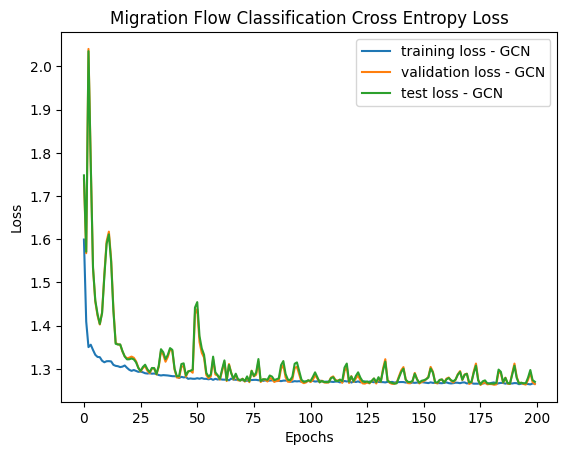

In [ ]:
# Iterate through all combinations
import itertools

results = []

for model_type, task, edge_type, feature_type in itertools.product(model_type, task,
                                                                   edge_type, feature_type):
    args_copy = args.copy()
    args_copy['model_type'] = model_type
    args_copy['task'] = task
    args_copy['edge_type'] = edge_type
    args_copy['feature_type'] = feature_type

    # Additional parameters for GAT
    if model_type == "GAT":
        args_copy['heads'] = 2
    else:
        args_copy['heads'] = 1
    name = f"{args_copy['task']}_{args_copy['model_type']}_{args_copy['feature_type']}_{args_copy['edge_type']}"

    model_path = os.path.join("models/", name + ".pkl")
    if os.path.exists(model_path):
        continue

    print(f"Running pipeline with config: {name}")

    # Call the pipeline with the current configuration
    best_loss, best_metric = run_pipeline(args_copy)

    config = {
        'model_type': model_type,
        'task': task,
        'edge_type': edge_type,
        'feature_type': feature_type,
        'best_loss': best_loss,
        'best_metric': best_metric
    }
    results.append(config)

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv("results/final_result.csv", index=False)